# Classification on imbalanced data

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use [Keras](https://www.tensorflow.org/guide/keras/overview) to define the model and [class weights](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model) to help the model learn from the imbalanced data. .

This tutorial contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
    * Class weighting 
    * Oversampling


## Setup

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Data processing and exploration

### Download the Kaggle Credit Card Fraud data set

Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html#pandas.DataFrame).

Note: This dataset has been collected and analysed during a research collaboration of Worldline and the [Machine Learning Group](http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available [here](https://www.researchgate.net/project/Fraud-detection-5) and the page of the [DefeatFraud](https://mlg.ulb.ac.be/wordpress/portfolio_page/defeatfraud-assessment-and-validation-of-deep-feature-engineering-and-learning-solutions-for-fraud-detection/) project

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Examine the class label imbalance

Let's look at the dataset imbalance:

In [6]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



This shows the small fraction of positive samples.

### Clean, split and normalize the data

The raw data has a few issues. First the `Time` and `Amount` columns are too variable to use directly. Drop the `Time` column (since it's not clear what it means) and take the log of the `Amount` column to reduce its range.

In [7]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where [overfitting](https://developers.google.com/machine-learning/crash-course/generalization/peril-of-overfitting) is a significant concern from the lack of training data.

In [8]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [9]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.


### Look at the data distribution

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

* Do these distributions make sense? 
    * Yes. You've normalized the input and these are mostly concentrated in the `+/- 2` range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.

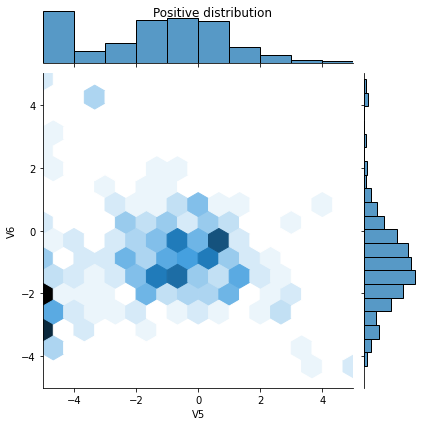

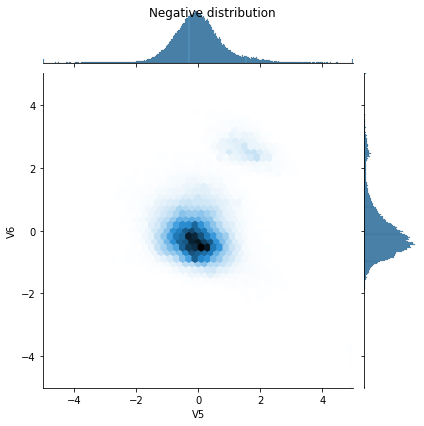

In [10]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

### Understanding useful metrics

Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.



*   **False** negatives and **false** positives are samples that were **incorrectly** classified
*   **True** negatives and **true** positives are samples that were **correctly** classified
*   **Accuracy** is the percentage of examples correctly classified
>   $\frac{\text{true samples}}{\text{total samples}}$
*   **Precision** is the percentage of **predicted** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*   **Recall** is the percentage of **actual** positives that were correctly classified
>   $\frac{\text{true positives}}{\text{true positives + false negatives}}$
*   **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
*   **AUPRC** refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds. 

Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.  

Read more:
*  [True vs. False and Positive vs. Negative](https://developers.google.com/machine-learning/crash-course/classification/true-false-positive-negative)
*  [Accuracy](https://developers.google.com/machine-learning/crash-course/classification/accuracy)
*   [Precision and Recall](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)
*   [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [Relationship between Precision-Recall and ROC Curves](https://www.biostat.wisc.edu/~page/rocpr.pdf)

## Baseline model

### Build the model

Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.


Note: this model will not handle the class imbalance well. You will improve it later in this tutorial.

In [12]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [13]:
model = make_model()
model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 dense (Dense)               (None, 16)                480       


 dropout (Dropout)           (None, 16)                0         


 dense_1 (Dense)             (None, 1)                 17        


Total params: 497


Trainable params: 497


Non-trainable params: 0


_________________________________________________________________


Test run the model:

In [14]:
model.predict(train_features[:10])

array([[0.9466284 ],
       [0.7211031 ],
       [0.60527885],
       [0.8335568 ],
       [0.5909625 ],
       [0.6751574 ],
       [0.6623665 ],
       [0.81066036],
       [0.50712407],
       [0.8296292 ]], dtype=float32)

### Optional: Set the correct initial bias.

These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that (See: [A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines)). This can help with initial convergence.

With the default bias initialization the loss should be about `math.log(2) = 0.69314` 

In [15]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.2781


The correct bias to set can be derived from:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses. 

It should be near: `pos/total = 0.0018`

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[2.3598122e-05],
       [1.5476024e-03],
       [6.8338902e-04],
       [9.4873342e-04],
       [1.0742771e-03],
       [7.7475846e-04],
       [1.2199467e-03],
       [5.5399281e-04],
       [1.6213538e-03],
       [3.0470363e-04]], dtype=float32)

With this initialization the initial loss should be approximately:

$$-p_0log(p_0)-(1-p_0)log(1-p_0) = 0.01317$$

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0200


This initial loss is about 50 times less than if would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. This also makes it easier to read plots of the loss during training.

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [19]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps

Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses: 

In [20]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [21]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

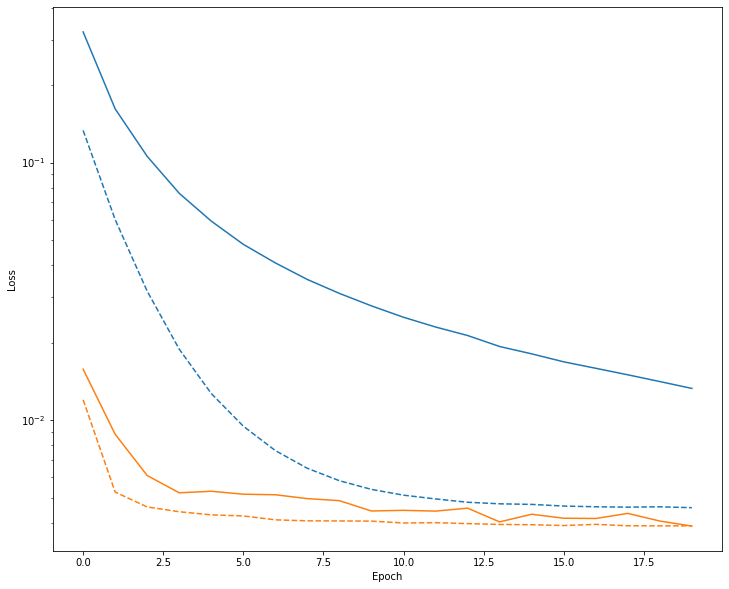

In [23]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage. 

### Train the model

In [24]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100



 1/90 [..............................] - ETA: 2:08 - loss: 0.0220 - tp: 64.0000 - fp: 9.0000 - tn: 47518.0000 - fn: 26.0000 - accuracy: 0.9993 - precision: 0.8767 - recall: 0.7111 - auc: 0.8938 - prc: 0.7388


11/90 [==>...........................] - ETA: 0s - loss: 0.0229 - tp: 64.0000 - fp: 9.0000 - tn: 67960.0000 - fn: 64.0000 - accuracy: 0.9989 - precision: 0.8767 - recall: 0.5000 - auc: 0.7742 - prc: 0.5144  


21/90 [======>.......................] - ETA: 0s - loss: 0.0199 - tp: 64.0000 - fp: 9.0000 - tn: 88408.0000 - fn: 96.0000 - accuracy: 0.9988 - precision: 0.8767 - recall: 0.4000 - auc: 0.7198 - prc: 0.4101


31/90 [=========>....................] - ETA: 0s - loss: 0.0178 - tp: 64.0000 - fp: 9.0000 - tn: 108860.0000 - fn: 124.0000 - accuracy: 0.9988 - precision: 0.8767 - recall: 0.3404 - auc: 0.6877 - prc: 0.3488


41/90 [============>.................] - ETA: 0s - loss: 0.0177 - tp: 64.0000 - fp: 9.0000 - tn: 129299.0000 - fn: 165.0000 - accuracy: 0.9987 - precision: 0.8767 - recall: 0.2795 - auc: 0.6541 - prc: 0.2865


51/90 [================>.............] - ETA: 0s - loss: 0.0172 - tp: 64.0000 - fp: 9.0000 - tn: 149745.0000 - fn: 199.0000 - accuracy: 0.9986 - precision: 0.8767 - recall: 0.2433 - auc: 0.6363 - prc: 0.2497


61/90 [===================>..........] - ETA: 0s - loss: 0.0176 - tp: 64.0000 - fp: 9.0000 - tn: 170174.0000 - fn: 250.0000 - accuracy: 0.9985 - precision: 0.8767 - recall: 0.2038 - auc: 0.6235 - prc: 0.2136


71/90 [======================>.......] - ETA: 0s - loss: 0.0164 - tp: 64.0000 - fp: 9.0000 - tn: 190630.0000 - fn: 274.0000 - accuracy: 0.9985 - precision: 0.8767 - recall: 0.1893 - auc: 0.6168 - prc: 0.1984


81/90 [==========================>...] - ETA: 0s - loss: 0.0162 - tp: 64.0000 - fp: 9.0000 - tn: 211068.0000 - fn: 316.0000 - accuracy: 0.9985 - precision: 0.8767 - recall: 0.1684 - auc: 0.6172 - prc: 0.1820


90/90 [==============================] - 3s 15ms/step - loss: 0.0161 - tp: 64.0000 - fp: 9.0000 - tn: 227425.0000 - fn: 347.0000 - accuracy: 0.9984 - precision: 0.8767 - recall: 0.1557 - auc: 0.6148 - prc: 0.1692 - val_loss: 0.0115 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45483.0000 - val_fn: 86.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7205 - val_prc: 0.2571


Epoch 2/100



 1/90 [..............................] - ETA: 0s - loss: 0.0108 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4863 - prc: 9.0243e-04


11/90 [==>...........................] - ETA: 0s - loss: 0.0119 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 22488.0000 - fn: 40.0000 - accuracy: 0.9982 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6388 - prc: 0.0501  


21/90 [======>.......................] - ETA: 0s - loss: 0.0109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 42935.0000 - fn: 73.0000 - accuracy: 0.9983 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6746 - prc: 0.1195


31/90 [=========>....................] - ETA: 0s - loss: 0.0104 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 63380.0000 - fn: 108.0000 - accuracy: 0.9983 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7172 - prc: 0.1598


42/90 [=============>................] - ETA: 0s - loss: 0.0100 - tp: 7.0000 - fp: 1.0000 - tn: 85865.0000 - fn: 143.0000 - accuracy: 0.9983 - precision: 0.8750 - recall: 0.0467 - auc: 0.7478 - prc: 0.2272                


52/90 [================>.............] - ETA: 0s - loss: 0.0100 - tp: 12.0000 - fp: 2.0000 - tn: 106301.0000 - fn: 181.0000 - accuracy: 0.9983 - precision: 0.8571 - recall: 0.0622 - auc: 0.7663 - prc: 0.2624


62/90 [===================>..........] - ETA: 0s - loss: 0.0095 - tp: 18.0000 - fp: 2.0000 - tn: 126752.0000 - fn: 204.0000 - accuracy: 0.9984 - precision: 0.9000 - recall: 0.0811 - auc: 0.7757 - prc: 0.2893


72/90 [=======================>......] - ETA: 0s - loss: 0.0091 - tp: 31.0000 - fp: 7.0000 - tn: 147188.0000 - fn: 230.0000 - accuracy: 0.9984 - precision: 0.8158 - recall: 0.1188 - auc: 0.7933 - prc: 0.3374


82/90 [==========================>...] - ETA: 0s - loss: 0.0087 - tp: 39.0000 - fp: 11.0000 - tn: 167635.0000 - fn: 251.0000 - accuracy: 0.9984 - precision: 0.7800 - recall: 0.1345 - auc: 0.8015 - prc: 0.3510


90/90 [==============================] - 1s 7ms/step - loss: 0.0087 - tp: 49.0000 - fp: 11.0000 - tn: 181940.0000 - fn: 276.0000 - accuracy: 0.9984 - precision: 0.8167 - recall: 0.1508 - auc: 0.8085 - prc: 0.3735 - val_loss: 0.0054 - val_tp: 35.0000 - val_fp: 6.0000 - val_tn: 45477.0000 - val_fn: 51.0000 - val_accuracy: 0.9987 - val_precision: 0.8537 - val_recall: 0.4070 - val_auc: 0.9065 - val_prc: 0.6598


Epoch 3/100



 1/90 [..............................] - ETA: 0s - loss: 0.0039 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7428 - prc: 0.5011


11/90 [==>...........................] - ETA: 0s - loss: 0.0072 - tp: 14.0000 - fp: 4.0000 - tn: 22484.0000 - fn: 26.0000 - accuracy: 0.9987 - precision: 0.7778 - recall: 0.3500 - auc: 0.8709 - prc: 0.5284 


21/90 [======>.......................] - ETA: 0s - loss: 0.0078 - tp: 30.0000 - fp: 10.0000 - tn: 42910.0000 - fn: 58.0000 - accuracy: 0.9984 - precision: 0.7500 - recall: 0.3409 - auc: 0.8764 - prc: 0.5260


31/90 [=========>....................] - ETA: 0s - loss: 0.0077 - tp: 37.0000 - fp: 14.0000 - tn: 63347.0000 - fn: 90.0000 - accuracy: 0.9984 - precision: 0.7255 - recall: 0.2913 - auc: 0.8816 - prc: 0.5118


41/90 [============>.................] - ETA: 0s - loss: 0.0069 - tp: 54.0000 - fp: 16.0000 - tn: 83792.0000 - fn: 106.0000 - accuracy: 0.9985 - precision: 0.7714 - recall: 0.3375 - auc: 0.8930 - prc: 0.5585


51/90 [================>.............] - ETA: 0s - loss: 0.0068 - tp: 67.0000 - fp: 20.0000 - tn: 104234.0000 - fn: 127.0000 - accuracy: 0.9986 - precision: 0.7701 - recall: 0.3454 - auc: 0.8879 - prc: 0.5550


61/90 [===================>..........] - ETA: 0s - loss: 0.0065 - tp: 80.0000 - fp: 23.0000 - tn: 124682.0000 - fn: 143.0000 - accuracy: 0.9987 - precision: 0.7767 - recall: 0.3587 - auc: 0.8910 - prc: 0.5740


71/90 [======================>.......] - ETA: 0s - loss: 0.0063 - tp: 100.0000 - fp: 24.0000 - tn: 145121.0000 - fn: 163.0000 - accuracy: 0.9987 - precision: 0.8065 - recall: 0.3802 - auc: 0.8959 - prc: 0.6043


81/90 [==========================>...] - ETA: 0s - loss: 0.0062 - tp: 113.0000 - fp: 24.0000 - tn: 165562.0000 - fn: 189.0000 - accuracy: 0.9987 - precision: 0.8248 - recall: 0.3742 - auc: 0.9040 - prc: 0.6223


90/90 [==============================] - ETA: 0s - loss: 0.0061 - tp: 126.0000 - fp: 27.0000 - tn: 181924.0000 - fn: 199.0000 - accuracy: 0.9988 - precision: 0.8235 - recall: 0.3877 - auc: 0.8997 - prc: 0.6187


90/90 [==============================] - 1s 7ms/step - loss: 0.0061 - tp: 126.0000 - fp: 27.0000 - tn: 181924.0000 - fn: 199.0000 - accuracy: 0.9988 - precision: 0.8235 - recall: 0.3877 - auc: 0.8997 - prc: 0.6187 - val_loss: 0.0046 - val_tp: 55.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 31.0000 - val_accuracy: 0.9991 - val_precision: 0.8730 - val_recall: 0.6395 - val_auc: 0.9063 - val_prc: 0.6941


Epoch 4/100



 1/90 [..............................] - ETA: 0s - loss: 0.0012 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0050 - tp: 20.0000 - fp: 3.0000 - tn: 22490.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.5714 - auc: 0.8973 - prc: 0.6581     


20/90 [=====>........................] - ETA: 0s - loss: 0.0050 - tp: 43.0000 - fp: 7.0000 - tn: 40882.0000 - fn: 28.0000 - accuracy: 0.9991 - precision: 0.8600 - recall: 0.6056 - auc: 0.9061 - prc: 0.7078


30/90 [=========>....................] - ETA: 0s - loss: 0.0056 - tp: 56.0000 - fp: 12.0000 - tn: 61322.0000 - fn: 50.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5283 - auc: 0.8839 - prc: 0.6434


39/90 [============>.................] - ETA: 0s - loss: 0.0057 - tp: 78.0000 - fp: 14.0000 - tn: 79712.0000 - fn: 68.0000 - accuracy: 0.9990 - precision: 0.8478 - recall: 0.5342 - auc: 0.8912 - prc: 0.6588


49/90 [===============>..............] - ETA: 0s - loss: 0.0058 - tp: 97.0000 - fp: 17.0000 - tn: 100152.0000 - fn: 86.0000 - accuracy: 0.9990 - precision: 0.8509 - recall: 0.5301 - auc: 0.8906 - prc: 0.6395


59/90 [==================>...........] - ETA: 0s - loss: 0.0058 - tp: 122.0000 - fp: 20.0000 - tn: 120589.0000 - fn: 101.0000 - accuracy: 0.9990 - precision: 0.8592 - recall: 0.5471 - auc: 0.8919 - prc: 0.6503


69/90 [======================>.......] - ETA: 0s - loss: 0.0059 - tp: 136.0000 - fp: 24.0000 - tn: 141023.0000 - fn: 129.0000 - accuracy: 0.9989 - precision: 0.8500 - recall: 0.5132 - auc: 0.9012 - prc: 0.6445


79/90 [=========================>....] - ETA: 0s - loss: 0.0057 - tp: 159.0000 - fp: 26.0000 - tn: 161467.0000 - fn: 140.0000 - accuracy: 0.9990 - precision: 0.8595 - recall: 0.5318 - auc: 0.9038 - prc: 0.6502


89/90 [============================>.] - ETA: 0s - loss: 0.0056 - tp: 172.0000 - fp: 31.0000 - tn: 181916.0000 - fn: 153.0000 - accuracy: 0.9990 - precision: 0.8473 - recall: 0.5292 - auc: 0.9068 - prc: 0.6448


90/90 [==============================] - 1s 7ms/step - loss: 0.0056 - tp: 172.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 153.0000 - accuracy: 0.9990 - precision: 0.8473 - recall: 0.5292 - auc: 0.9068 - prc: 0.6448 - val_loss: 0.0044 - val_tp: 58.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 28.0000 - val_accuracy: 0.9992 - val_precision: 0.8788 - val_recall: 0.6744 - val_auc: 0.9064 - val_prc: 0.7114


Epoch 5/100



 1/90 [..............................] - ETA: 0s - loss: 0.0042 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7452 - prc: 0.5012


11/90 [==>...........................] - ETA: 0s - loss: 0.0050 - tp: 18.0000 - fp: 4.0000 - tn: 22489.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8182 - recall: 0.5143 - auc: 0.9265 - prc: 0.6024 


21/90 [======>.......................] - ETA: 0s - loss: 0.0058 - tp: 37.0000 - fp: 12.0000 - tn: 42926.0000 - fn: 33.0000 - accuracy: 0.9990 - precision: 0.7551 - recall: 0.5286 - auc: 0.9480 - prc: 0.5642


31/90 [=========>....................] - ETA: 0s - loss: 0.0061 - tp: 60.0000 - fp: 17.0000 - tn: 63357.0000 - fn: 54.0000 - accuracy: 0.9989 - precision: 0.7792 - recall: 0.5263 - auc: 0.9232 - prc: 0.5775


41/90 [============>.................] - ETA: 0s - loss: 0.0062 - tp: 82.0000 - fp: 21.0000 - tn: 83791.0000 - fn: 74.0000 - accuracy: 0.9989 - precision: 0.7961 - recall: 0.5256 - auc: 0.9176 - prc: 0.5851


51/90 [================>.............] - ETA: 0s - loss: 0.0060 - tp: 103.0000 - fp: 22.0000 - tn: 104231.0000 - fn: 92.0000 - accuracy: 0.9989 - precision: 0.8240 - recall: 0.5282 - auc: 0.9133 - prc: 0.6023


61/90 [===================>..........] - ETA: 0s - loss: 0.0058 - tp: 121.0000 - fp: 25.0000 - tn: 124672.0000 - fn: 110.0000 - accuracy: 0.9989 - precision: 0.8288 - recall: 0.5238 - auc: 0.9135 - prc: 0.6071


71/90 [======================>.......] - ETA: 0s - loss: 0.0058 - tp: 140.0000 - fp: 27.0000 - tn: 145112.0000 - fn: 129.0000 - accuracy: 0.9989 - precision: 0.8383 - recall: 0.5204 - auc: 0.9143 - prc: 0.6147


81/90 [==========================>...] - ETA: 0s - loss: 0.0059 - tp: 154.0000 - fp: 29.0000 - tn: 165554.0000 - fn: 151.0000 - accuracy: 0.9989 - precision: 0.8415 - recall: 0.5049 - auc: 0.9110 - prc: 0.6077


90/90 [==============================] - ETA: 0s - loss: 0.0056 - tp: 167.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 158.0000 - accuracy: 0.9990 - precision: 0.8477 - recall: 0.5138 - auc: 0.9134 - prc: 0.6215


90/90 [==============================] - 1s 7ms/step - loss: 0.0056 - tp: 167.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 158.0000 - accuracy: 0.9990 - precision: 0.8477 - recall: 0.5138 - auc: 0.9134 - prc: 0.6215 - val_loss: 0.0043 - val_tp: 60.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8824 - val_recall: 0.6977 - val_auc: 0.9064 - val_prc: 0.7181


Epoch 6/100



 1/90 [..............................] - ETA: 0s - loss: 0.0042 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8732 - prc: 0.7517


11/90 [==>...........................] - ETA: 0s - loss: 0.0048 - tp: 24.0000 - fp: 1.0000 - tn: 22483.0000 - fn: 20.0000 - accuracy: 0.9991 - precision: 0.9600 - recall: 0.5455 - auc: 0.9184 - prc: 0.7154 


21/90 [======>.......................] - ETA: 0s - loss: 0.0051 - tp: 52.0000 - fp: 4.0000 - tn: 42916.0000 - fn: 36.0000 - accuracy: 0.9991 - precision: 0.9286 - recall: 0.5909 - auc: 0.9014 - prc: 0.7132


31/90 [=========>....................] - ETA: 0s - loss: 0.0055 - tp: 73.0000 - fp: 13.0000 - tn: 63350.0000 - fn: 52.0000 - accuracy: 0.9990 - precision: 0.8488 - recall: 0.5840 - auc: 0.9142 - prc: 0.6735


41/90 [============>.................] - ETA: 0s - loss: 0.0050 - tp: 93.0000 - fp: 15.0000 - tn: 83796.0000 - fn: 64.0000 - accuracy: 0.9991 - precision: 0.8611 - recall: 0.5924 - auc: 0.9252 - prc: 0.6911


51/90 [================>.............] - ETA: 0s - loss: 0.0053 - tp: 113.0000 - fp: 19.0000 - tn: 104234.0000 - fn: 82.0000 - accuracy: 0.9990 - precision: 0.8561 - recall: 0.5795 - auc: 0.9239 - prc: 0.6679


60/90 [===================>..........] - ETA: 0s - loss: 0.0053 - tp: 125.0000 - fp: 21.0000 - tn: 122636.0000 - fn: 98.0000 - accuracy: 0.9990 - precision: 0.8562 - recall: 0.5605 - auc: 0.9197 - prc: 0.6553


70/90 [======================>.......] - ETA: 0s - loss: 0.0052 - tp: 147.0000 - fp: 23.0000 - tn: 143081.0000 - fn: 109.0000 - accuracy: 0.9991 - precision: 0.8647 - recall: 0.5742 - auc: 0.9161 - prc: 0.6601


80/90 [=========================>....] - ETA: 0s - loss: 0.0053 - tp: 173.0000 - fp: 28.0000 - tn: 163514.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8607 - recall: 0.5805 - auc: 0.9160 - prc: 0.6573


90/90 [==============================] - ETA: 0s - loss: 0.0050 - tp: 193.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8733 - recall: 0.5938 - auc: 0.9198 - prc: 0.6760


90/90 [==============================] - 1s 7ms/step - loss: 0.0050 - tp: 193.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 132.0000 - accuracy: 0.9991 - precision: 0.8733 - recall: 0.5938 - auc: 0.9198 - prc: 0.6760 - val_loss: 0.0042 - val_tp: 59.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 27.0000 - val_accuracy: 0.9992 - val_precision: 0.8806 - val_recall: 0.6860 - val_auc: 0.9064 - val_prc: 0.7370


Epoch 7/100



 1/90 [..............................] - ETA: 0s - loss: 0.0107 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.8985 - prc: 0.4799


11/90 [==>...........................] - ETA: 0s - loss: 0.0050 - tp: 31.0000 - fp: 4.0000 - tn: 22473.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.8857 - recall: 0.6078 - auc: 0.9596 - prc: 0.7615


21/90 [======>.......................] - ETA: 0s - loss: 0.0048 - tp: 49.0000 - fp: 7.0000 - tn: 42914.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8750 - recall: 0.5632 - auc: 0.9470 - prc: 0.7195


31/90 [=========>....................] - ETA: 0s - loss: 0.0051 - tp: 61.0000 - fp: 9.0000 - tn: 63361.0000 - fn: 57.0000 - accuracy: 0.9990 - precision: 0.8714 - recall: 0.5169 - auc: 0.9222 - prc: 0.6728


40/90 [============>.................] - ETA: 0s - loss: 0.0048 - tp: 84.0000 - fp: 13.0000 - tn: 81754.0000 - fn: 69.0000 - accuracy: 0.9990 - precision: 0.8660 - recall: 0.5490 - auc: 0.9333 - prc: 0.6945


50/90 [===============>..............] - ETA: 0s - loss: 0.0048 - tp: 106.0000 - fp: 18.0000 - tn: 102192.0000 - fn: 84.0000 - accuracy: 0.9990 - precision: 0.8548 - recall: 0.5579 - auc: 0.9302 - prc: 0.6780


60/90 [===================>..........] - ETA: 0s - loss: 0.0045 - tp: 131.0000 - fp: 20.0000 - tn: 122636.0000 - fn: 93.0000 - accuracy: 0.9991 - precision: 0.8675 - recall: 0.5848 - auc: 0.9340 - prc: 0.7022


70/90 [======================>.......] - ETA: 0s - loss: 0.0045 - tp: 145.0000 - fp: 23.0000 - tn: 143084.0000 - fn: 108.0000 - accuracy: 0.9991 - precision: 0.8631 - recall: 0.5731 - auc: 0.9315 - prc: 0.6937


80/90 [=========================>....] - ETA: 0s - loss: 0.0048 - tp: 161.0000 - fp: 28.0000 - tn: 163525.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8519 - recall: 0.5610 - auc: 0.9220 - prc: 0.6705


90/90 [==============================] - ETA: 0s - loss: 0.0048 - tp: 183.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 142.0000 - accuracy: 0.9991 - precision: 0.8592 - recall: 0.5631 - auc: 0.9202 - prc: 0.6737


90/90 [==============================] - 1s 7ms/step - loss: 0.0048 - tp: 183.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 142.0000 - accuracy: 0.9991 - precision: 0.8592 - recall: 0.5631 - auc: 0.9202 - prc: 0.6737 - val_loss: 0.0042 - val_tp: 60.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8824 - val_recall: 0.6977 - val_auc: 0.9064 - val_prc: 0.7463


Epoch 8/100



 1/90 [..............................] - ETA: 0s - loss: 0.0109 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6210 - prc: 0.2527


10/90 [==>...........................] - ETA: 0s - loss: 0.0045 - tp: 16.0000 - fp: 0.0000e+00 - tn: 20444.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.4444 - auc: 0.9294 - prc: 0.7619         


19/90 [=====>........................] - ETA: 0s - loss: 0.0051 - tp: 33.0000 - fp: 7.0000 - tn: 38838.0000 - fn: 34.0000 - accuracy: 0.9989 - precision: 0.8250 - recall: 0.4925 - auc: 0.9239 - prc: 0.6233    


29/90 [========>.....................] - ETA: 0s - loss: 0.0052 - tp: 49.0000 - fp: 16.0000 - tn: 59280.0000 - fn: 47.0000 - accuracy: 0.9989 - precision: 0.7538 - recall: 0.5104 - auc: 0.9255 - prc: 0.5878


39/90 [============>.................] - ETA: 0s - loss: 0.0055 - tp: 68.0000 - fp: 19.0000 - tn: 79716.0000 - fn: 69.0000 - accuracy: 0.9989 - precision: 0.7816 - recall: 0.4964 - auc: 0.9109 - prc: 0.5884


49/90 [===============>..............] - ETA: 0s - loss: 0.0052 - tp: 85.0000 - fp: 21.0000 - tn: 100163.0000 - fn: 83.0000 - accuracy: 0.9990 - precision: 0.8019 - recall: 0.5060 - auc: 0.9122 - prc: 0.6007


59/90 [==================>...........] - ETA: 0s - loss: 0.0053 - tp: 108.0000 - fp: 25.0000 - tn: 120596.0000 - fn: 103.0000 - accuracy: 0.9989 - precision: 0.8120 - recall: 0.5118 - auc: 0.9156 - prc: 0.6146


69/90 [======================>.......] - ETA: 0s - loss: 0.0050 - tp: 133.0000 - fp: 28.0000 - tn: 141036.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8261 - recall: 0.5363 - auc: 0.9201 - prc: 0.6470


79/90 [=========================>....] - ETA: 0s - loss: 0.0050 - tp: 146.0000 - fp: 31.0000 - tn: 161483.0000 - fn: 132.0000 - accuracy: 0.9990 - precision: 0.8249 - recall: 0.5252 - auc: 0.9160 - prc: 0.6404


89/90 [============================>.] - ETA: 0s - loss: 0.0050 - tp: 171.0000 - fp: 31.0000 - tn: 181916.0000 - fn: 154.0000 - accuracy: 0.9990 - precision: 0.8465 - recall: 0.5262 - auc: 0.9156 - prc: 0.6574


90/90 [==============================] - 1s 7ms/step - loss: 0.0050 - tp: 171.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 154.0000 - accuracy: 0.9990 - precision: 0.8465 - recall: 0.5262 - auc: 0.9156 - prc: 0.6574 - val_loss: 0.0041 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.9065 - val_prc: 0.7480


Epoch 9/100



 1/90 [..............................] - ETA: 0s - loss: 7.1484e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


10/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 22.0000 - fp: 2.0000 - tn: 20447.0000 - fn: 9.0000 - accuracy: 0.9995 - precision: 0.9167 - recall: 0.7097 - auc: 0.9182 - prc: 0.7068          


20/90 [=====>........................] - ETA: 0s - loss: 0.0040 - tp: 44.0000 - fp: 6.0000 - tn: 40890.0000 - fn: 20.0000 - accuracy: 0.9994 - precision: 0.8800 - recall: 0.6875 - auc: 0.9129 - prc: 0.7119


30/90 [=========>....................] - ETA: 0s - loss: 0.0043 - tp: 62.0000 - fp: 10.0000 - tn: 61332.0000 - fn: 36.0000 - accuracy: 0.9993 - precision: 0.8611 - recall: 0.6327 - auc: 0.9274 - prc: 0.6774


39/90 [============>.................] - ETA: 0s - loss: 0.0043 - tp: 83.0000 - fp: 12.0000 - tn: 79726.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8737 - recall: 0.6194 - auc: 0.9354 - prc: 0.6962


48/90 [===============>..............] - ETA: 0s - loss: 0.0047 - tp: 108.0000 - fp: 14.0000 - tn: 98113.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.8852 - recall: 0.6102 - auc: 0.9225 - prc: 0.6950


58/90 [==================>...........] - ETA: 0s - loss: 0.0049 - tp: 135.0000 - fp: 20.0000 - tn: 118545.0000 - fn: 84.0000 - accuracy: 0.9991 - precision: 0.8710 - recall: 0.6164 - auc: 0.9234 - prc: 0.6764


67/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 156.0000 - fp: 21.0000 - tn: 136946.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8814 - recall: 0.6265 - auc: 0.9184 - prc: 0.6836


76/90 [========================>.....] - ETA: 0s - loss: 0.0049 - tp: 174.0000 - fp: 25.0000 - tn: 155339.0000 - fn: 110.0000 - accuracy: 0.9991 - precision: 0.8744 - recall: 0.6127 - auc: 0.9160 - prc: 0.6728


85/90 [===========================>..] - ETA: 0s - loss: 0.0047 - tp: 186.0000 - fp: 28.0000 - tn: 173746.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8692 - recall: 0.6078 - auc: 0.9203 - prc: 0.6779


90/90 [==============================] - 1s 7ms/step - loss: 0.0047 - tp: 196.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8711 - recall: 0.6031 - auc: 0.9218 - prc: 0.6799 - val_loss: 0.0041 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.9065 - val_prc: 0.7550


Epoch 10/100



 1/90 [..............................] - ETA: 0s - loss: 0.0068 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 0.8319 - prc: 0.6684


10/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 25.0000 - fp: 1.0000 - tn: 20440.0000 - fn: 14.0000 - accuracy: 0.9993 - precision: 0.9615 - recall: 0.6410 - auc: 0.9093 - prc: 0.7893 


20/90 [=====>........................] - ETA: 0s - loss: 0.0043 - tp: 38.0000 - fp: 4.0000 - tn: 40891.0000 - fn: 27.0000 - accuracy: 0.9992 - precision: 0.9048 - recall: 0.5846 - auc: 0.8911 - prc: 0.6591


30/90 [=========>....................] - ETA: 0s - loss: 0.0049 - tp: 56.0000 - fp: 11.0000 - tn: 61327.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.8358 - recall: 0.5490 - auc: 0.8957 - prc: 0.6155


40/90 [============>.................] - ETA: 0s - loss: 0.0047 - tp: 76.0000 - fp: 13.0000 - tn: 81767.0000 - fn: 64.0000 - accuracy: 0.9991 - precision: 0.8539 - recall: 0.5429 - auc: 0.9094 - prc: 0.6439


49/90 [===============>..............] - ETA: 0s - loss: 0.0045 - tp: 100.0000 - fp: 14.0000 - tn: 100160.0000 - fn: 78.0000 - accuracy: 0.9991 - precision: 0.8772 - recall: 0.5618 - auc: 0.9173 - prc: 0.6785


59/90 [==================>...........] - ETA: 0s - loss: 0.0049 - tp: 117.0000 - fp: 18.0000 - tn: 120600.0000 - fn: 97.0000 - accuracy: 0.9990 - precision: 0.8667 - recall: 0.5467 - auc: 0.9052 - prc: 0.6489


69/90 [======================>.......] - ETA: 0s - loss: 0.0049 - tp: 136.0000 - fp: 21.0000 - tn: 141039.0000 - fn: 116.0000 - accuracy: 0.9990 - precision: 0.8662 - recall: 0.5397 - auc: 0.9054 - prc: 0.6528


79/90 [=========================>....] - ETA: 0s - loss: 0.0049 - tp: 156.0000 - fp: 22.0000 - tn: 161480.0000 - fn: 134.0000 - accuracy: 0.9990 - precision: 0.8764 - recall: 0.5379 - auc: 0.9055 - prc: 0.6613


89/90 [============================>.] - ETA: 0s - loss: 0.0050 - tp: 173.0000 - fp: 27.0000 - tn: 181920.0000 - fn: 152.0000 - accuracy: 0.9990 - precision: 0.8650 - recall: 0.5323 - auc: 0.9048 - prc: 0.6520


90/90 [==============================] - 1s 7ms/step - loss: 0.0050 - tp: 173.0000 - fp: 27.0000 - tn: 181924.0000 - fn: 152.0000 - accuracy: 0.9990 - precision: 0.8650 - recall: 0.5323 - auc: 0.9048 - prc: 0.6520 - val_loss: 0.0040 - val_tp: 63.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8750 - val_recall: 0.7326 - val_auc: 0.9122 - val_prc: 0.7598


Epoch 11/100



 1/90 [..............................] - ETA: 0s - loss: 0.0158 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 5.0000 - accuracy: 0.9976 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6936 - prc: 0.2172


11/90 [==>...........................] - ETA: 0s - loss: 0.0059 - tp: 22.0000 - fp: 5.0000 - tn: 22481.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.8148 - recall: 0.5238 - auc: 0.8791 - prc: 0.6005             


21/90 [======>.......................] - ETA: 0s - loss: 0.0053 - tp: 45.0000 - fp: 11.0000 - tn: 42919.0000 - fn: 33.0000 - accuracy: 0.9990 - precision: 0.8036 - recall: 0.5769 - auc: 0.9088 - prc: 0.6319


30/90 [=========>....................] - ETA: 0s - loss: 0.0047 - tp: 66.0000 - fp: 12.0000 - tn: 61319.0000 - fn: 43.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.6055 - auc: 0.9115 - prc: 0.6743


40/90 [============>.................] - ETA: 0s - loss: 0.0047 - tp: 84.0000 - fp: 13.0000 - tn: 81761.0000 - fn: 62.0000 - accuracy: 0.9991 - precision: 0.8660 - recall: 0.5753 - auc: 0.9131 - prc: 0.6820


50/90 [===============>..............] - ETA: 0s - loss: 0.0048 - tp: 111.0000 - fp: 14.0000 - tn: 102194.0000 - fn: 81.0000 - accuracy: 0.9991 - precision: 0.8880 - recall: 0.5781 - auc: 0.9154 - prc: 0.6925


59/90 [==================>...........] - ETA: 0s - loss: 0.0045 - tp: 127.0000 - fp: 16.0000 - tn: 120599.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8881 - recall: 0.5853 - auc: 0.9205 - prc: 0.6981


68/90 [=====================>........] - ETA: 0s - loss: 0.0047 - tp: 156.0000 - fp: 23.0000 - tn: 138979.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8715 - recall: 0.5954 - auc: 0.9244 - prc: 0.6972


78/90 [=========================>....] - ETA: 0s - loss: 0.0048 - tp: 172.0000 - fp: 28.0000 - tn: 159425.0000 - fn: 119.0000 - accuracy: 0.9991 - precision: 0.8600 - recall: 0.5911 - auc: 0.9214 - prc: 0.6812


88/90 [============================>.] - ETA: 0s - loss: 0.0048 - tp: 188.0000 - fp: 31.0000 - tn: 179870.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8584 - recall: 0.5820 - auc: 0.9166 - prc: 0.6764


90/90 [==============================] - 1s 7ms/step - loss: 0.0048 - tp: 190.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8597 - recall: 0.5846 - auc: 0.9172 - prc: 0.6779 - val_loss: 0.0040 - val_tp: 63.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8750 - val_recall: 0.7326 - val_auc: 0.9065 - val_prc: 0.7595


Epoch 12/100



 1/90 [..............................] - ETA: 0s - loss: 9.1615e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0051 - tp: 31.0000 - fp: 4.0000 - tn: 22476.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.8857 - recall: 0.6458 - auc: 0.9154 - prc: 0.7425         


21/90 [======>.......................] - ETA: 0s - loss: 0.0041 - tp: 47.0000 - fp: 5.0000 - tn: 42926.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.9038 - recall: 0.6104 - auc: 0.9274 - prc: 0.7553


31/90 [=========>....................] - ETA: 0s - loss: 0.0044 - tp: 73.0000 - fp: 8.0000 - tn: 63357.0000 - fn: 50.0000 - accuracy: 0.9991 - precision: 0.9012 - recall: 0.5935 - auc: 0.9298 - prc: 0.7499


41/90 [============>.................] - ETA: 0s - loss: 0.0048 - tp: 104.0000 - fp: 10.0000 - tn: 83784.0000 - fn: 70.0000 - accuracy: 0.9990 - precision: 0.9123 - recall: 0.5977 - auc: 0.9271 - prc: 0.7545


51/90 [================>.............] - ETA: 0s - loss: 0.0045 - tp: 123.0000 - fp: 18.0000 - tn: 104225.0000 - fn: 82.0000 - accuracy: 0.9990 - precision: 0.8723 - recall: 0.6000 - auc: 0.9331 - prc: 0.7505


61/90 [===================>..........] - ETA: 0s - loss: 0.0045 - tp: 143.0000 - fp: 22.0000 - tn: 124668.0000 - fn: 95.0000 - accuracy: 0.9991 - precision: 0.8667 - recall: 0.6008 - auc: 0.9296 - prc: 0.7423


71/90 [======================>.......] - ETA: 0s - loss: 0.0043 - tp: 162.0000 - fp: 27.0000 - tn: 145114.0000 - fn: 105.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6067 - auc: 0.9315 - prc: 0.7426


81/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 181.0000 - fp: 29.0000 - tn: 165557.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8619 - recall: 0.5993 - auc: 0.9344 - prc: 0.7422


90/90 [==============================] - 1s 7ms/step - loss: 0.0043 - tp: 192.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 133.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5908 - auc: 0.9281 - prc: 0.7312 - val_loss: 0.0039 - val_tp: 64.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8767 - val_recall: 0.7442 - val_auc: 0.9123 - val_prc: 0.7648


Epoch 13/100



 1/90 [..............................] - ETA: 0s - loss: 5.5657e-04 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2048.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00 - prc: 0.0000e+00


11/90 [==>...........................] - ETA: 0s - loss: 0.0034 - tp: 22.0000 - fp: 2.0000 - tn: 22488.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.9167 - recall: 0.5789 - auc: 0.9597 - prc: 0.7872                             


21/90 [======>.......................] - ETA: 0s - loss: 0.0037 - tp: 39.0000 - fp: 5.0000 - tn: 42932.0000 - fn: 32.0000 - accuracy: 0.9991 - precision: 0.8864 - recall: 0.5493 - auc: 0.9428 - prc: 0.7512


31/90 [=========>....................] - ETA: 0s - loss: 0.0042 - tp: 56.0000 - fp: 8.0000 - tn: 63372.0000 - fn: 52.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5185 - auc: 0.9202 - prc: 0.7014


41/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 77.0000 - fp: 13.0000 - tn: 83816.0000 - fn: 62.0000 - accuracy: 0.9991 - precision: 0.8556 - recall: 0.5540 - auc: 0.9234 - prc: 0.7086


51/90 [================>.............] - ETA: 0s - loss: 0.0041 - tp: 93.0000 - fp: 17.0000 - tn: 104257.0000 - fn: 81.0000 - accuracy: 0.9991 - precision: 0.8455 - recall: 0.5345 - auc: 0.9300 - prc: 0.7014


61/90 [===================>..........] - ETA: 0s - loss: 0.0043 - tp: 120.0000 - fp: 19.0000 - tn: 124686.0000 - fn: 103.0000 - accuracy: 0.9990 - precision: 0.8633 - recall: 0.5381 - auc: 0.9317 - prc: 0.7162


71/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 146.0000 - fp: 22.0000 - tn: 145124.0000 - fn: 116.0000 - accuracy: 0.9991 - precision: 0.8690 - recall: 0.5573 - auc: 0.9302 - prc: 0.7223


81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 160.0000 - fp: 27.0000 - tn: 165574.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8556 - recall: 0.5575 - auc: 0.9275 - prc: 0.7185


90/90 [==============================] - 1s 7ms/step - loss: 0.0042 - tp: 185.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 140.0000 - accuracy: 0.9991 - precision: 0.8565 - recall: 0.5692 - auc: 0.9328 - prc: 0.7222 - val_loss: 0.0040 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8784 - val_recall: 0.7558 - val_auc: 0.9123 - val_prc: 0.7615


Epoch 14/100



 1/90 [..............................] - ETA: 0s - loss: 0.0011 - tp: 4.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.8000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0045 - tp: 14.0000 - fp: 7.0000 - tn: 22492.0000 - fn: 15.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.4828 - auc: 0.9124 - prc: 0.5475 


21/90 [======>.......................] - ETA: 0s - loss: 0.0048 - tp: 37.0000 - fp: 11.0000 - tn: 42929.0000 - fn: 31.0000 - accuracy: 0.9990 - precision: 0.7708 - recall: 0.5441 - auc: 0.9177 - prc: 0.6044


31/90 [=========>....................] - ETA: 0s - loss: 0.0054 - tp: 56.0000 - fp: 14.0000 - tn: 63368.0000 - fn: 50.0000 - accuracy: 0.9990 - precision: 0.8000 - recall: 0.5283 - auc: 0.9182 - prc: 0.5895


41/90 [============>.................] - ETA: 0s - loss: 0.0054 - tp: 79.0000 - fp: 18.0000 - tn: 83796.0000 - fn: 75.0000 - accuracy: 0.9989 - precision: 0.8144 - recall: 0.5130 - auc: 0.9174 - prc: 0.6252


51/90 [================>.............] - ETA: 0s - loss: 0.0050 - tp: 97.0000 - fp: 20.0000 - tn: 104246.0000 - fn: 85.0000 - accuracy: 0.9990 - precision: 0.8291 - recall: 0.5330 - auc: 0.9272 - prc: 0.6481


61/90 [===================>..........] - ETA: 0s - loss: 0.0050 - tp: 123.0000 - fp: 22.0000 - tn: 124678.0000 - fn: 105.0000 - accuracy: 0.9990 - precision: 0.8483 - recall: 0.5395 - auc: 0.9329 - prc: 0.6658


70/90 [======================>.......] - ETA: 0s - loss: 0.0047 - tp: 143.0000 - fp: 25.0000 - tn: 143078.0000 - fn: 114.0000 - accuracy: 0.9990 - precision: 0.8512 - recall: 0.5564 - auc: 0.9345 - prc: 0.6782


80/90 [=========================>....] - ETA: 0s - loss: 0.0046 - tp: 165.0000 - fp: 29.0000 - tn: 163520.0000 - fn: 126.0000 - accuracy: 0.9991 - precision: 0.8505 - recall: 0.5670 - auc: 0.9335 - prc: 0.6845


90/90 [==============================] - ETA: 0s - loss: 0.0047 - tp: 183.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8472 - recall: 0.5631 - auc: 0.9295 - prc: 0.6770


90/90 [==============================] - 1s 7ms/step - loss: 0.0047 - tp: 183.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 142.0000 - accuracy: 0.9990 - precision: 0.8472 - recall: 0.5631 - auc: 0.9295 - prc: 0.6770 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8784 - val_recall: 0.7558 - val_auc: 0.9123 - val_prc: 0.7670


Epoch 15/100



 1/90 [..............................] - ETA: 0s - loss: 0.0016 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0027 - tp: 18.0000 - fp: 5.0000 - tn: 22491.0000 - fn: 14.0000 - accuracy: 0.9992 - precision: 0.7826 - recall: 0.5625 - auc: 0.9682 - prc: 0.7725 


21/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 41.0000 - fp: 6.0000 - tn: 42928.0000 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8723 - recall: 0.5541 - auc: 0.9588 - prc: 0.7866


31/90 [=========>....................] - ETA: 0s - loss: 0.0037 - tp: 64.0000 - fp: 8.0000 - tn: 63371.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.5872 - auc: 0.9441 - prc: 0.7707


41/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 82.0000 - fp: 13.0000 - tn: 83812.0000 - fn: 61.0000 - accuracy: 0.9991 - precision: 0.8632 - recall: 0.5734 - auc: 0.9431 - prc: 0.7396


51/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 105.0000 - fp: 16.0000 - tn: 104253.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8678 - recall: 0.5866 - auc: 0.9404 - prc: 0.7342


61/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 127.0000 - fp: 18.0000 - tn: 124693.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8759 - recall: 0.5853 - auc: 0.9391 - prc: 0.7328


71/90 [======================>.......] - ETA: 0s - loss: 0.0043 - tp: 150.0000 - fp: 22.0000 - tn: 145130.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8721 - recall: 0.5859 - auc: 0.9384 - prc: 0.7198


81/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 170.0000 - fp: 24.0000 - tn: 165582.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8763 - recall: 0.6028 - auc: 0.9387 - prc: 0.7284


90/90 [==============================] - 1s 7ms/step - loss: 0.0043 - tp: 194.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8700 - recall: 0.5969 - auc: 0.9344 - prc: 0.7233 - val_loss: 0.0040 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8784 - val_recall: 0.7558 - val_auc: 0.9123 - val_prc: 0.7672


Epoch 16/100



 1/90 [..............................] - ETA: 0s - loss: 0.0012 - tp: 5.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.8333 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0030 - tp: 28.0000 - fp: 2.0000 - tn: 22488.0000 - fn: 10.0000 - accuracy: 0.9995 - precision: 0.9333 - recall: 0.7368 - auc: 0.9203 - prc: 0.8222 


21/90 [======>.......................] - ETA: 0s - loss: 0.0034 - tp: 57.0000 - fp: 6.0000 - tn: 42922.0000 - fn: 23.0000 - accuracy: 0.9993 - precision: 0.9048 - recall: 0.7125 - auc: 0.9306 - prc: 0.7905


31/90 [=========>....................] - ETA: 0s - loss: 0.0034 - tp: 80.0000 - fp: 8.0000 - tn: 63370.0000 - fn: 30.0000 - accuracy: 0.9994 - precision: 0.9091 - recall: 0.7273 - auc: 0.9220 - prc: 0.7739


41/90 [============>.................] - ETA: 0s - loss: 0.0036 - tp: 100.0000 - fp: 13.0000 - tn: 83810.0000 - fn: 45.0000 - accuracy: 0.9993 - precision: 0.8850 - recall: 0.6897 - auc: 0.9268 - prc: 0.7454


51/90 [================>.............] - ETA: 0s - loss: 0.0039 - tp: 128.0000 - fp: 15.0000 - tn: 104244.0000 - fn: 61.0000 - accuracy: 0.9993 - precision: 0.8951 - recall: 0.6772 - auc: 0.9249 - prc: 0.7376


61/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 147.0000 - fp: 20.0000 - tn: 124685.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8802 - recall: 0.6592 - auc: 0.9250 - prc: 0.7119


71/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 172.0000 - fp: 24.0000 - tn: 145120.0000 - fn: 92.0000 - accuracy: 0.9992 - precision: 0.8776 - recall: 0.6515 - auc: 0.9327 - prc: 0.7194


81/90 [==========================>...] - ETA: 0s - loss: 0.0042 - tp: 191.0000 - fp: 29.0000 - tn: 165560.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8682 - recall: 0.6388 - auc: 0.9287 - prc: 0.7111


90/90 [==============================] - 1s 7ms/step - loss: 0.0041 - tp: 207.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8697 - recall: 0.6369 - auc: 0.9329 - prc: 0.7194 - val_loss: 0.0039 - val_tp: 64.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8767 - val_recall: 0.7442 - val_auc: 0.9124 - val_prc: 0.7694


Epoch 17/100



 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.3333 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0041 - tp: 19.0000 - fp: 2.0000 - tn: 22490.0000 - fn: 17.0000 - accuracy: 0.9992 - precision: 0.9048 - recall: 0.5278 - auc: 0.9156 - prc: 0.6767 


21/90 [======>.......................] - ETA: 0s - loss: 0.0046 - tp: 40.0000 - fp: 5.0000 - tn: 42932.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.5634 - auc: 0.9002 - prc: 0.6659


31/90 [=========>....................] - ETA: 0s - loss: 0.0040 - tp: 56.0000 - fp: 7.0000 - tn: 63384.0000 - fn: 41.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.5773 - auc: 0.9113 - prc: 0.6918


41/90 [============>.................] - ETA: 0s - loss: 0.0038 - tp: 79.0000 - fp: 8.0000 - tn: 83826.0000 - fn: 55.0000 - accuracy: 0.9992 - precision: 0.9080 - recall: 0.5896 - auc: 0.9245 - prc: 0.7261


51/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 95.0000 - fp: 13.0000 - tn: 104276.0000 - fn: 64.0000 - accuracy: 0.9993 - precision: 0.8796 - recall: 0.5975 - auc: 0.9268 - prc: 0.7095


61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 115.0000 - fp: 15.0000 - tn: 124717.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8846 - recall: 0.5867 - auc: 0.9328 - prc: 0.7266


71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 144.0000 - fp: 18.0000 - tn: 145146.0000 - fn: 100.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.5902 - auc: 0.9376 - prc: 0.7374


81/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 170.0000 - fp: 23.0000 - tn: 165577.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8808 - recall: 0.5903 - auc: 0.9401 - prc: 0.7399


90/90 [==============================] - ETA: 0s - loss: 0.0042 - tp: 190.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8716 - recall: 0.5846 - auc: 0.9345 - prc: 0.7265


90/90 [==============================] - 1s 7ms/step - loss: 0.0042 - tp: 190.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 135.0000 - accuracy: 0.9991 - precision: 0.8716 - recall: 0.5846 - auc: 0.9345 - prc: 0.7265 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8784 - val_recall: 0.7558 - val_auc: 0.9124 - val_prc: 0.7705


Epoch 18/100



 1/90 [..............................] - ETA: 0s - loss: 0.0059 - tp: 4.0000 - fp: 1.0000 - tn: 2041.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.8000 - recall: 0.6667 - auc: 0.9996 - prc: 0.7477


11/90 [==>...........................] - ETA: 0s - loss: 0.0043 - tp: 33.0000 - fp: 4.0000 - tn: 22475.0000 - fn: 16.0000 - accuracy: 0.9991 - precision: 0.8919 - recall: 0.6735 - auc: 0.9582 - prc: 0.7400


21/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 48.0000 - fp: 5.0000 - tn: 42928.0000 - fn: 27.0000 - accuracy: 0.9993 - precision: 0.9057 - recall: 0.6400 - auc: 0.9524 - prc: 0.7450


31/90 [=========>....................] - ETA: 0s - loss: 0.0036 - tp: 72.0000 - fp: 12.0000 - tn: 63365.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6486 - auc: 0.9450 - prc: 0.7515


41/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 83.0000 - fp: 15.0000 - tn: 83819.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8469 - recall: 0.6194 - auc: 0.9392 - prc: 0.7173


51/90 [================>.............] - ETA: 0s - loss: 0.0038 - tp: 108.0000 - fp: 17.0000 - tn: 104249.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8640 - recall: 0.5934 - auc: 0.9441 - prc: 0.7341


61/90 [===================>..........] - ETA: 0s - loss: 0.0040 - tp: 121.0000 - fp: 21.0000 - tn: 124694.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8521 - recall: 0.5681 - auc: 0.9379 - prc: 0.7118


71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 148.0000 - fp: 24.0000 - tn: 145135.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8605 - recall: 0.5944 - auc: 0.9387 - prc: 0.7172


81/90 [==========================>...] - ETA: 0s - loss: 0.0039 - tp: 175.0000 - fp: 29.0000 - tn: 165567.0000 - fn: 117.0000 - accuracy: 0.9991 - precision: 0.8578 - recall: 0.5993 - auc: 0.9391 - prc: 0.7224


90/90 [==============================] - 1s 7ms/step - loss: 0.0040 - tp: 194.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8622 - recall: 0.5969 - auc: 0.9344 - prc: 0.7199 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8784 - val_recall: 0.7558 - val_auc: 0.9124 - val_prc: 0.7725


Epoch 19/100



 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9998 - prc: 0.9041


11/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 24.0000 - fp: 3.0000 - tn: 22486.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.6154 - auc: 0.9478 - prc: 0.7626 


20/90 [=====>........................] - ETA: 0s - loss: 0.0032 - tp: 50.0000 - fp: 6.0000 - tn: 40880.0000 - fn: 24.0000 - accuracy: 0.9993 - precision: 0.8929 - recall: 0.6757 - auc: 0.9655 - prc: 0.7963


30/90 [=========>....................] - ETA: 0s - loss: 0.0031 - tp: 66.0000 - fp: 9.0000 - tn: 61331.0000 - fn: 34.0000 - accuracy: 0.9993 - precision: 0.8800 - recall: 0.6600 - auc: 0.9644 - prc: 0.7831


40/90 [============>.................] - ETA: 0s - loss: 0.0034 - tp: 88.0000 - fp: 13.0000 - tn: 81768.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8713 - recall: 0.6331 - auc: 0.9561 - prc: 0.7642


50/90 [===============>..............] - ETA: 0s - loss: 0.0037 - tp: 108.0000 - fp: 18.0000 - tn: 102208.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.6207 - auc: 0.9504 - prc: 0.7414


60/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 134.0000 - fp: 20.0000 - tn: 122650.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8701 - recall: 0.6381 - auc: 0.9445 - prc: 0.7554


70/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 154.0000 - fp: 23.0000 - tn: 143088.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8701 - recall: 0.6185 - auc: 0.9410 - prc: 0.7355


80/90 [=========================>....] - ETA: 0s - loss: 0.0039 - tp: 181.0000 - fp: 27.0000 - tn: 163524.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8702 - recall: 0.6263 - auc: 0.9387 - prc: 0.7363


90/90 [==============================] - ETA: 0s - loss: 0.0041 - tp: 205.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8613 - recall: 0.6308 - auc: 0.9346 - prc: 0.7266


90/90 [==============================] - 1s 7ms/step - loss: 0.0041 - tp: 205.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8613 - recall: 0.6308 - auc: 0.9346 - prc: 0.7266 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8784 - val_recall: 0.7558 - val_auc: 0.9124 - val_prc: 0.7739


Epoch 20/100



 1/90 [..............................] - ETA: 0s - loss: 0.0021 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9999 - prc: 0.9635


11/90 [==>...........................] - ETA: 0s - loss: 0.0030 - tp: 25.0000 - fp: 7.0000 - tn: 22485.0000 - fn: 11.0000 - accuracy: 0.9992 - precision: 0.7812 - recall: 0.6944 - auc: 0.9714 - prc: 0.7757 


21/90 [======>.......................] - ETA: 0s - loss: 0.0037 - tp: 52.0000 - fp: 9.0000 - tn: 42917.0000 - fn: 30.0000 - accuracy: 0.9991 - precision: 0.8525 - recall: 0.6341 - auc: 0.9565 - prc: 0.7752


31/90 [=========>....................] - ETA: 0s - loss: 0.0040 - tp: 84.0000 - fp: 10.0000 - tn: 63346.0000 - fn: 48.0000 - accuracy: 0.9991 - precision: 0.8936 - recall: 0.6364 - auc: 0.9536 - prc: 0.7847


41/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 101.0000 - fp: 13.0000 - tn: 83792.0000 - fn: 62.0000 - accuracy: 0.9991 - precision: 0.8860 - recall: 0.6196 - auc: 0.9469 - prc: 0.7624


50/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 126.0000 - fp: 14.0000 - tn: 102184.0000 - fn: 76.0000 - accuracy: 0.9991 - precision: 0.9000 - recall: 0.6238 - auc: 0.9446 - prc: 0.7738


60/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 158.0000 - fp: 18.0000 - tn: 122616.0000 - fn: 88.0000 - accuracy: 0.9991 - precision: 0.8977 - recall: 0.6423 - auc: 0.9462 - prc: 0.7821


70/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 178.0000 - fp: 21.0000 - tn: 143060.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8945 - recall: 0.6380 - auc: 0.9417 - prc: 0.7710


80/90 [=========================>....] - ETA: 0s - loss: 0.0037 - tp: 196.0000 - fp: 23.0000 - tn: 163512.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8950 - recall: 0.6426 - auc: 0.9417 - prc: 0.7754


90/90 [==============================] - ETA: 0s - loss: 0.0037 - tp: 207.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8809 - recall: 0.6369 - auc: 0.9421 - prc: 0.7634


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 207.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8809 - recall: 0.6369 - auc: 0.9421 - prc: 0.7634 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8784 - val_recall: 0.7558 - val_auc: 0.9124 - val_prc: 0.7729


Epoch 21/100



 1/90 [..............................] - ETA: 0s - loss: 0.0097 - tp: 4.0000 - fp: 2.0000 - tn: 2039.0000 - fn: 3.0000 - accuracy: 0.9976 - precision: 0.6667 - recall: 0.5714 - auc: 0.9272 - prc: 0.7124


11/90 [==>...........................] - ETA: 0s - loss: 0.0056 - tp: 26.0000 - fp: 8.0000 - tn: 22474.0000 - fn: 20.0000 - accuracy: 0.9988 - precision: 0.7647 - recall: 0.5652 - auc: 0.9117 - prc: 0.6524


21/90 [======>.......................] - ETA: 0s - loss: 0.0045 - tp: 42.0000 - fp: 9.0000 - tn: 42922.0000 - fn: 35.0000 - accuracy: 0.9990 - precision: 0.8235 - recall: 0.5455 - auc: 0.9210 - prc: 0.6930


31/90 [=========>....................] - ETA: 0s - loss: 0.0043 - tp: 61.0000 - fp: 11.0000 - tn: 63361.0000 - fn: 55.0000 - accuracy: 0.9990 - precision: 0.8472 - recall: 0.5259 - auc: 0.9430 - prc: 0.7136


41/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 83.0000 - fp: 14.0000 - tn: 83806.0000 - fn: 65.0000 - accuracy: 0.9991 - precision: 0.8557 - recall: 0.5608 - auc: 0.9416 - prc: 0.7240


51/90 [================>.............] - ETA: 0s - loss: 0.0041 - tp: 106.0000 - fp: 19.0000 - tn: 104241.0000 - fn: 82.0000 - accuracy: 0.9990 - precision: 0.8480 - recall: 0.5638 - auc: 0.9458 - prc: 0.7248


61/90 [===================>..........] - ETA: 0s - loss: 0.0040 - tp: 138.0000 - fp: 21.0000 - tn: 124676.0000 - fn: 93.0000 - accuracy: 0.9991 - precision: 0.8679 - recall: 0.5974 - auc: 0.9450 - prc: 0.7424


71/90 [======================>.......] - ETA: 0s - loss: 0.0040 - tp: 159.0000 - fp: 26.0000 - tn: 145122.0000 - fn: 101.0000 - accuracy: 0.9991 - precision: 0.8595 - recall: 0.6115 - auc: 0.9433 - prc: 0.7290


81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 186.0000 - fp: 31.0000 - tn: 165556.0000 - fn: 115.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6179 - auc: 0.9376 - prc: 0.7281


90/90 [==============================] - 1s 6ms/step - loss: 0.0040 - tp: 204.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8644 - recall: 0.6277 - auc: 0.9360 - prc: 0.7340 - val_loss: 0.0038 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8732 - val_recall: 0.7209 - val_auc: 0.9124 - val_prc: 0.7756


Epoch 22/100



 1/90 [..............................] - ETA: 0s - loss: 0.0031 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.9998 - prc: 0.9189


11/90 [==>...........................] - ETA: 0s - loss: 0.0046 - tp: 19.0000 - fp: 3.0000 - tn: 22485.0000 - fn: 21.0000 - accuracy: 0.9989 - precision: 0.8636 - recall: 0.4750 - auc: 0.9488 - prc: 0.6324 


21/90 [======>.......................] - ETA: 0s - loss: 0.0037 - tp: 47.0000 - fp: 4.0000 - tn: 42926.0000 - fn: 31.0000 - accuracy: 0.9992 - precision: 0.9216 - recall: 0.6026 - auc: 0.9670 - prc: 0.7407


31/90 [=========>....................] - ETA: 0s - loss: 0.0039 - tp: 79.0000 - fp: 6.0000 - tn: 63356.0000 - fn: 47.0000 - accuracy: 0.9992 - precision: 0.9294 - recall: 0.6270 - auc: 0.9555 - prc: 0.7685


41/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 103.0000 - fp: 7.0000 - tn: 83793.0000 - fn: 65.0000 - accuracy: 0.9991 - precision: 0.9364 - recall: 0.6131 - auc: 0.9424 - prc: 0.7557


51/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 120.0000 - fp: 13.0000 - tn: 104238.0000 - fn: 77.0000 - accuracy: 0.9991 - precision: 0.9023 - recall: 0.6091 - auc: 0.9380 - prc: 0.7452


61/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 150.0000 - fp: 16.0000 - tn: 124675.0000 - fn: 87.0000 - accuracy: 0.9992 - precision: 0.9036 - recall: 0.6329 - auc: 0.9377 - prc: 0.7389


71/90 [======================>.......] - ETA: 0s - loss: 0.0041 - tp: 170.0000 - fp: 20.0000 - tn: 145121.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8947 - recall: 0.6367 - auc: 0.9334 - prc: 0.7285


81/90 [==========================>...] - ETA: 0s - loss: 0.0040 - tp: 184.0000 - fp: 21.0000 - tn: 165574.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8976 - recall: 0.6280 - auc: 0.9307 - prc: 0.7244


90/90 [==============================] - 1s 7ms/step - loss: 0.0040 - tp: 207.0000 - fp: 26.0000 - tn: 181925.0000 - fn: 118.0000 - accuracy: 0.9992 - precision: 0.8884 - recall: 0.6369 - auc: 0.9328 - prc: 0.7277 - val_loss: 0.0038 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7773


Epoch 23/100



 1/90 [..............................] - ETA: 0s - loss: 6.9863e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0056 - tp: 30.0000 - fp: 5.0000 - tn: 22473.0000 - fn: 20.0000 - accuracy: 0.9989 - precision: 0.8571 - recall: 0.6000 - auc: 0.9187 - prc: 0.7032         


21/90 [======>.......................] - ETA: 0s - loss: 0.0050 - tp: 50.0000 - fp: 9.0000 - tn: 42911.0000 - fn: 38.0000 - accuracy: 0.9989 - precision: 0.8475 - recall: 0.5682 - auc: 0.9306 - prc: 0.6926


31/90 [=========>....................] - ETA: 0s - loss: 0.0050 - tp: 72.0000 - fp: 16.0000 - tn: 63346.0000 - fn: 54.0000 - accuracy: 0.9989 - precision: 0.8182 - recall: 0.5714 - auc: 0.9273 - prc: 0.6813


41/90 [============>.................] - ETA: 0s - loss: 0.0042 - tp: 92.0000 - fp: 20.0000 - tn: 83794.0000 - fn: 62.0000 - accuracy: 0.9990 - precision: 0.8214 - recall: 0.5974 - auc: 0.9405 - prc: 0.7171


51/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 118.0000 - fp: 24.0000 - tn: 104226.0000 - fn: 80.0000 - accuracy: 0.9990 - precision: 0.8310 - recall: 0.5960 - auc: 0.9435 - prc: 0.7324


61/90 [===================>..........] - ETA: 0s - loss: 0.0042 - tp: 140.0000 - fp: 24.0000 - tn: 124667.0000 - fn: 97.0000 - accuracy: 0.9990 - precision: 0.8537 - recall: 0.5907 - auc: 0.9463 - prc: 0.7447


71/90 [======================>.......] - ETA: 0s - loss: 0.0042 - tp: 159.0000 - fp: 25.0000 - tn: 145109.0000 - fn: 115.0000 - accuracy: 0.9990 - precision: 0.8641 - recall: 0.5803 - auc: 0.9406 - prc: 0.7409


81/90 [==========================>...] - ETA: 0s - loss: 0.0041 - tp: 174.0000 - fp: 31.0000 - tn: 165558.0000 - fn: 125.0000 - accuracy: 0.9991 - precision: 0.8488 - recall: 0.5819 - auc: 0.9388 - prc: 0.7278


90/90 [==============================] - 1s 6ms/step - loss: 0.0041 - tp: 191.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 134.0000 - accuracy: 0.9991 - precision: 0.8527 - recall: 0.5877 - auc: 0.9375 - prc: 0.7280 - val_loss: 0.0038 - val_tp: 62.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8857 - val_recall: 0.7209 - val_auc: 0.9124 - val_prc: 0.7790


Epoch 24/100



 1/90 [..............................] - ETA: 0s - loss: 0.0039 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9978 - prc: 0.5725


11/90 [==>...........................] - ETA: 0s - loss: 0.0041 - tp: 25.0000 - fp: 4.0000 - tn: 22481.0000 - fn: 18.0000 - accuracy: 0.9990 - precision: 0.8621 - recall: 0.5814 - auc: 0.9526 - prc: 0.7708             


22/90 [======>.......................] - ETA: 0s - loss: 0.0034 - tp: 46.0000 - fp: 7.0000 - tn: 44976.0000 - fn: 27.0000 - accuracy: 0.9992 - precision: 0.8679 - recall: 0.6301 - auc: 0.9580 - prc: 0.7748


32/90 [=========>....................] - ETA: 0s - loss: 0.0035 - tp: 70.0000 - fp: 12.0000 - tn: 65414.0000 - fn: 40.0000 - accuracy: 0.9992 - precision: 0.8537 - recall: 0.6364 - auc: 0.9536 - prc: 0.7714


42/90 [=============>................] - ETA: 0s - loss: 0.0036 - tp: 92.0000 - fp: 13.0000 - tn: 85853.0000 - fn: 58.0000 - accuracy: 0.9992 - precision: 0.8762 - recall: 0.6133 - auc: 0.9457 - prc: 0.7623


52/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 113.0000 - fp: 16.0000 - tn: 106294.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.8760 - recall: 0.6075 - auc: 0.9480 - prc: 0.7664


63/90 [====================>.........] - ETA: 0s - loss: 0.0038 - tp: 135.0000 - fp: 21.0000 - tn: 128777.0000 - fn: 91.0000 - accuracy: 0.9991 - precision: 0.8654 - recall: 0.5973 - auc: 0.9437 - prc: 0.7548


73/90 [=======================>......] - ETA: 0s - loss: 0.0038 - tp: 150.0000 - fp: 27.0000 - tn: 149221.0000 - fn: 106.0000 - accuracy: 0.9991 - precision: 0.8475 - recall: 0.5859 - auc: 0.9424 - prc: 0.7415


83/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 178.0000 - fp: 29.0000 - tn: 169659.0000 - fn: 118.0000 - accuracy: 0.9991 - precision: 0.8599 - recall: 0.6014 - auc: 0.9416 - prc: 0.7499


90/90 [==============================] - 1s 7ms/step - loss: 0.0039 - tp: 196.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 129.0000 - accuracy: 0.9991 - precision: 0.8596 - recall: 0.6031 - auc: 0.9375 - prc: 0.7466 - val_loss: 0.0038 - val_tp: 65.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8667 - val_recall: 0.7558 - val_auc: 0.9123 - val_prc: 0.7762


Epoch 25/100



 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 6.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.8571 - recall: 0.8571 - auc: 0.9999 - prc: 0.9589


11/90 [==>...........................] - ETA: 0s - loss: 0.0027 - tp: 29.0000 - fp: 3.0000 - tn: 22484.0000 - fn: 12.0000 - accuracy: 0.9993 - precision: 0.9062 - recall: 0.7073 - auc: 0.9752 - prc: 0.8573


21/90 [======>.......................] - ETA: 0s - loss: 0.0049 - tp: 51.0000 - fp: 10.0000 - tn: 42915.0000 - fn: 32.0000 - accuracy: 0.9990 - precision: 0.8361 - recall: 0.6145 - auc: 0.9204 - prc: 0.6912


31/90 [=========>....................] - ETA: 0s - loss: 0.0039 - tp: 74.0000 - fp: 14.0000 - tn: 63363.0000 - fn: 37.0000 - accuracy: 0.9992 - precision: 0.8409 - recall: 0.6667 - auc: 0.9359 - prc: 0.7290


41/90 [============>.................] - ETA: 0s - loss: 0.0035 - tp: 96.0000 - fp: 15.0000 - tn: 83810.0000 - fn: 47.0000 - accuracy: 0.9993 - precision: 0.8649 - recall: 0.6713 - auc: 0.9466 - prc: 0.7560


51/90 [================>.............] - ETA: 0s - loss: 0.0033 - tp: 113.0000 - fp: 19.0000 - tn: 104260.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.8561 - recall: 0.6686 - auc: 0.9517 - prc: 0.7518


61/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 139.0000 - fp: 21.0000 - tn: 124694.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8687 - recall: 0.6526 - auc: 0.9497 - prc: 0.7507


71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 164.0000 - fp: 24.0000 - tn: 145129.0000 - fn: 91.0000 - accuracy: 0.9992 - precision: 0.8723 - recall: 0.6431 - auc: 0.9520 - prc: 0.7581


81/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 179.0000 - fp: 29.0000 - tn: 165575.0000 - fn: 105.0000 - accuracy: 0.9992 - precision: 0.8606 - recall: 0.6303 - auc: 0.9533 - prc: 0.7499


90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 204.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8681 - recall: 0.6277 - auc: 0.9467 - prc: 0.7480 - val_loss: 0.0038 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.9123 - val_prc: 0.7789


Epoch 26/100



 1/90 [..............................] - ETA: 0s - loss: 0.0060 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6000 - auc: 0.8986 - prc: 0.6731


10/90 [==>...........................] - ETA: 0s - loss: 0.0057 - tp: 17.0000 - fp: 3.0000 - tn: 20438.0000 - fn: 22.0000 - accuracy: 0.9988 - precision: 0.8500 - recall: 0.4359 - auc: 0.8960 - prc: 0.5991 


20/90 [=====>........................] - ETA: 0s - loss: 0.0040 - tp: 42.0000 - fp: 4.0000 - tn: 40882.0000 - fn: 32.0000 - accuracy: 0.9991 - precision: 0.9130 - recall: 0.5676 - auc: 0.9314 - prc: 0.7245


30/90 [=========>....................] - ETA: 0s - loss: 0.0036 - tp: 56.0000 - fp: 8.0000 - tn: 61337.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.5895 - auc: 0.9358 - prc: 0.7075


40/90 [============>.................] - ETA: 0s - loss: 0.0036 - tp: 85.0000 - fp: 9.0000 - tn: 81774.0000 - fn: 52.0000 - accuracy: 0.9993 - precision: 0.9043 - recall: 0.6204 - auc: 0.9407 - prc: 0.7384


50/90 [===============>..............] - ETA: 0s - loss: 0.0036 - tp: 106.0000 - fp: 12.0000 - tn: 102215.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8983 - recall: 0.6127 - auc: 0.9413 - prc: 0.7400


60/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 134.0000 - fp: 15.0000 - tn: 122644.0000 - fn: 87.0000 - accuracy: 0.9992 - precision: 0.8993 - recall: 0.6063 - auc: 0.9471 - prc: 0.7531


70/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 153.0000 - fp: 19.0000 - tn: 143084.0000 - fn: 104.0000 - accuracy: 0.9991 - precision: 0.8895 - recall: 0.5953 - auc: 0.9388 - prc: 0.7448


80/90 [=========================>....] - ETA: 0s - loss: 0.0041 - tp: 171.0000 - fp: 27.0000 - tn: 163521.0000 - fn: 121.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.5856 - auc: 0.9375 - prc: 0.7276


90/90 [==============================] - ETA: 0s - loss: 0.0040 - tp: 194.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8661 - recall: 0.5969 - auc: 0.9360 - prc: 0.7292


90/90 [==============================] - 1s 7ms/step - loss: 0.0040 - tp: 194.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 131.0000 - accuracy: 0.9991 - precision: 0.8661 - recall: 0.5969 - auc: 0.9360 - prc: 0.7292 - val_loss: 0.0038 - val_tp: 60.0000 - val_fp: 7.0000 - val_tn: 45476.0000 - val_fn: 26.0000 - val_accuracy: 0.9993 - val_precision: 0.8955 - val_recall: 0.6977 - val_auc: 0.9123 - val_prc: 0.7783


Epoch 27/100



 1/90 [..............................] - ETA: 0s - loss: 0.0046 - tp: 3.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.7500 - recall: 0.7500 - auc: 0.8738 - prc: 0.6799


11/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 25.0000 - fp: 5.0000 - tn: 22481.0000 - fn: 17.0000 - accuracy: 0.9990 - precision: 0.8333 - recall: 0.5952 - auc: 0.9515 - prc: 0.7560


21/90 [======>.......................] - ETA: 0s - loss: 0.0038 - tp: 48.0000 - fp: 7.0000 - tn: 42921.0000 - fn: 32.0000 - accuracy: 0.9991 - precision: 0.8727 - recall: 0.6000 - auc: 0.9429 - prc: 0.7559


31/90 [=========>....................] - ETA: 0s - loss: 0.0041 - tp: 71.0000 - fp: 8.0000 - tn: 63361.0000 - fn: 48.0000 - accuracy: 0.9991 - precision: 0.8987 - recall: 0.5966 - auc: 0.9234 - prc: 0.7452


41/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 93.0000 - fp: 14.0000 - tn: 83800.0000 - fn: 61.0000 - accuracy: 0.9991 - precision: 0.8692 - recall: 0.6039 - auc: 0.9243 - prc: 0.7301


51/90 [================>.............] - ETA: 0s - loss: 0.0039 - tp: 122.0000 - fp: 16.0000 - tn: 104240.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8841 - recall: 0.6354 - auc: 0.9287 - prc: 0.7408


61/90 [===================>..........] - ETA: 0s - loss: 0.0041 - tp: 144.0000 - fp: 18.0000 - tn: 124674.0000 - fn: 92.0000 - accuracy: 0.9991 - precision: 0.8889 - recall: 0.6102 - auc: 0.9270 - prc: 0.7429


71/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 160.0000 - fp: 21.0000 - tn: 145126.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8840 - recall: 0.6130 - auc: 0.9282 - prc: 0.7464


81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 181.0000 - fp: 24.0000 - tn: 165575.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8829 - recall: 0.6263 - auc: 0.9334 - prc: 0.7537


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 208.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8776 - recall: 0.6400 - auc: 0.9376 - prc: 0.7632 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8667 - val_recall: 0.7558 - val_auc: 0.9124 - val_prc: 0.7772


Epoch 28/100



 1/90 [..............................] - ETA: 0s - loss: 0.0054 - tp: 3.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.7500 - recall: 0.6000 - auc: 0.9983 - prc: 0.6673


11/90 [==>...........................] - ETA: 0s - loss: 0.0037 - tp: 26.0000 - fp: 6.0000 - tn: 22481.0000 - fn: 15.0000 - accuracy: 0.9991 - precision: 0.8125 - recall: 0.6341 - auc: 0.9746 - prc: 0.7669


21/90 [======>.......................] - ETA: 0s - loss: 0.0034 - tp: 44.0000 - fp: 8.0000 - tn: 42928.0000 - fn: 28.0000 - accuracy: 0.9992 - precision: 0.8462 - recall: 0.6111 - auc: 0.9574 - prc: 0.7718


30/90 [=========>....................] - ETA: 0s - loss: 0.0038 - tp: 66.0000 - fp: 12.0000 - tn: 61316.0000 - fn: 46.0000 - accuracy: 0.9991 - precision: 0.8462 - recall: 0.5893 - auc: 0.9500 - prc: 0.7615


39/90 [============>.................] - ETA: 0s - loss: 0.0036 - tp: 80.0000 - fp: 14.0000 - tn: 79721.0000 - fn: 57.0000 - accuracy: 0.9991 - precision: 0.8511 - recall: 0.5839 - auc: 0.9554 - prc: 0.7556


49/90 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 95.0000 - fp: 17.0000 - tn: 100173.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8482 - recall: 0.5864 - auc: 0.9498 - prc: 0.7537


59/90 [==================>...........] - ETA: 0s - loss: 0.0033 - tp: 122.0000 - fp: 20.0000 - tn: 120614.0000 - fn: 76.0000 - accuracy: 0.9992 - precision: 0.8592 - recall: 0.6162 - auc: 0.9513 - prc: 0.7714


68/90 [=====================>........] - ETA: 0s - loss: 0.0033 - tp: 144.0000 - fp: 23.0000 - tn: 139009.0000 - fn: 88.0000 - accuracy: 0.9992 - precision: 0.8623 - recall: 0.6207 - auc: 0.9497 - prc: 0.7772


77/90 [========================>.....] - ETA: 0s - loss: 0.0034 - tp: 169.0000 - fp: 29.0000 - tn: 157402.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8535 - recall: 0.6377 - auc: 0.9483 - prc: 0.7706


87/90 [============================>.] - ETA: 0s - loss: 0.0037 - tp: 197.0000 - fp: 32.0000 - tn: 177827.0000 - fn: 120.0000 - accuracy: 0.9991 - precision: 0.8603 - recall: 0.6215 - auc: 0.9409 - prc: 0.7628


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 202.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 123.0000 - accuracy: 0.9991 - precision: 0.8596 - recall: 0.6215 - auc: 0.9408 - prc: 0.7638 - val_loss: 0.0039 - val_tp: 63.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8630 - val_recall: 0.7326 - val_auc: 0.9124 - val_prc: 0.7808


Epoch 29/100



 1/90 [..............................] - ETA: 0s - loss: 0.0031 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.2500 - auc: 0.9998 - prc: 0.9088


11/90 [==>...........................] - ETA: 0s - loss: 0.0035 - tp: 27.0000 - fp: 2.0000 - tn: 22483.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.9310 - recall: 0.6279 - auc: 0.9413 - prc: 0.7968 


20/90 [=====>........................] - ETA: 0s - loss: 0.0035 - tp: 51.0000 - fp: 4.0000 - tn: 40878.0000 - fn: 27.0000 - accuracy: 0.9992 - precision: 0.9273 - recall: 0.6538 - auc: 0.9417 - prc: 0.8000


29/90 [========>.....................] - ETA: 0s - loss: 0.0033 - tp: 74.0000 - fp: 5.0000 - tn: 59277.0000 - fn: 36.0000 - accuracy: 0.9993 - precision: 0.9367 - recall: 0.6727 - auc: 0.9448 - prc: 0.8109


39/90 [============>.................] - ETA: 0s - loss: 0.0034 - tp: 96.0000 - fp: 13.0000 - tn: 79717.0000 - fn: 46.0000 - accuracy: 0.9993 - precision: 0.8807 - recall: 0.6761 - auc: 0.9395 - prc: 0.7738


49/90 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 111.0000 - fp: 17.0000 - tn: 100164.0000 - fn: 60.0000 - accuracy: 0.9992 - precision: 0.8672 - recall: 0.6491 - auc: 0.9379 - prc: 0.7486


59/90 [==================>...........] - ETA: 0s - loss: 0.0036 - tp: 137.0000 - fp: 20.0000 - tn: 120603.0000 - fn: 72.0000 - accuracy: 0.9992 - precision: 0.8726 - recall: 0.6555 - auc: 0.9370 - prc: 0.7483


69/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 167.0000 - fp: 24.0000 - tn: 141034.0000 - fn: 87.0000 - accuracy: 0.9992 - precision: 0.8743 - recall: 0.6575 - auc: 0.9363 - prc: 0.7579


79/90 [=========================>....] - ETA: 0s - loss: 0.0037 - tp: 189.0000 - fp: 27.0000 - tn: 161475.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6517 - auc: 0.9337 - prc: 0.7520


89/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 214.0000 - fp: 29.0000 - tn: 181918.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8807 - recall: 0.6585 - auc: 0.9347 - prc: 0.7626


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 214.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8807 - recall: 0.6585 - auc: 0.9347 - prc: 0.7626 - val_loss: 0.0039 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8732 - val_recall: 0.7209 - val_auc: 0.9124 - val_prc: 0.7806


Epoch 30/100



 1/90 [..............................] - ETA: 0s - loss: 0.0052 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 0.8740 - prc: 0.7518


11/90 [==>...........................] - ETA: 0s - loss: 0.0031 - tp: 20.0000 - fp: 2.0000 - tn: 22493.0000 - fn: 13.0000 - accuracy: 0.9993 - precision: 0.9091 - recall: 0.6061 - auc: 0.9388 - prc: 0.7887 


20/90 [=====>........................] - ETA: 0s - loss: 0.0043 - tp: 36.0000 - fp: 5.0000 - tn: 40886.0000 - fn: 33.0000 - accuracy: 0.9991 - precision: 0.8780 - recall: 0.5217 - auc: 0.9122 - prc: 0.7122


29/90 [========>.....................] - ETA: 0s - loss: 0.0044 - tp: 64.0000 - fp: 10.0000 - tn: 59274.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8649 - recall: 0.5926 - auc: 0.9158 - prc: 0.7161


39/90 [============>.................] - ETA: 0s - loss: 0.0047 - tp: 78.0000 - fp: 19.0000 - tn: 79714.0000 - fn: 61.0000 - accuracy: 0.9990 - precision: 0.8041 - recall: 0.5612 - auc: 0.9163 - prc: 0.6742


48/90 [===============>..............] - ETA: 0s - loss: 0.0044 - tp: 97.0000 - fp: 24.0000 - tn: 98111.0000 - fn: 72.0000 - accuracy: 0.9990 - precision: 0.8017 - recall: 0.5740 - auc: 0.9251 - prc: 0.6910


58/90 [==================>...........] - ETA: 0s - loss: 0.0042 - tp: 128.0000 - fp: 25.0000 - tn: 118548.0000 - fn: 83.0000 - accuracy: 0.9991 - precision: 0.8366 - recall: 0.6066 - auc: 0.9305 - prc: 0.7236


68/90 [=====================>........] - ETA: 0s - loss: 0.0040 - tp: 146.0000 - fp: 29.0000 - tn: 138990.0000 - fn: 99.0000 - accuracy: 0.9991 - precision: 0.8343 - recall: 0.5959 - auc: 0.9339 - prc: 0.7331


78/90 [=========================>....] - ETA: 0s - loss: 0.0039 - tp: 168.0000 - fp: 29.0000 - tn: 159436.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8528 - recall: 0.6022 - auc: 0.9365 - prc: 0.7427


88/90 [============================>.] - ETA: 0s - loss: 0.0037 - tp: 193.0000 - fp: 30.0000 - tn: 179878.0000 - fn: 123.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6108 - auc: 0.9392 - prc: 0.7568


90/90 [==============================] - 1s 7ms/step - loss: 0.0039 - tp: 197.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 128.0000 - accuracy: 0.9991 - precision: 0.8640 - recall: 0.6062 - auc: 0.9346 - prc: 0.7489 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8667 - val_recall: 0.7558 - val_auc: 0.9124 - val_prc: 0.7804


Epoch 31/100



 1/90 [..............................] - ETA: 0s - loss: 0.0057 - tp: 4.0000 - fp: 1.0000 - tn: 2042.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.8000 - recall: 0.8000 - auc: 0.8991 - prc: 0.7573


11/90 [==>...........................] - ETA: 0s - loss: 0.0035 - tp: 28.0000 - fp: 5.0000 - tn: 22483.0000 - fn: 12.0000 - accuracy: 0.9992 - precision: 0.8485 - recall: 0.7000 - auc: 0.9368 - prc: 0.7961


21/90 [======>.......................] - ETA: 0s - loss: 0.0037 - tp: 59.0000 - fp: 7.0000 - tn: 42916.0000 - fn: 26.0000 - accuracy: 0.9992 - precision: 0.8939 - recall: 0.6941 - auc: 0.9346 - prc: 0.8085


30/90 [=========>....................] - ETA: 0s - loss: 0.0038 - tp: 75.0000 - fp: 14.0000 - tn: 61313.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8427 - recall: 0.6637 - auc: 0.9417 - prc: 0.7817


40/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 98.0000 - fp: 17.0000 - tn: 81754.0000 - fn: 51.0000 - accuracy: 0.9992 - precision: 0.8522 - recall: 0.6577 - auc: 0.9388 - prc: 0.7827


50/90 [===============>..............] - ETA: 0s - loss: 0.0039 - tp: 123.0000 - fp: 19.0000 - tn: 102190.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8662 - recall: 0.6440 - auc: 0.9416 - prc: 0.7722


60/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 147.0000 - fp: 24.0000 - tn: 122629.0000 - fn: 80.0000 - accuracy: 0.9992 - precision: 0.8596 - recall: 0.6476 - auc: 0.9419 - prc: 0.7700


70/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 173.0000 - fp: 27.0000 - tn: 143070.0000 - fn: 90.0000 - accuracy: 0.9992 - precision: 0.8650 - recall: 0.6578 - auc: 0.9422 - prc: 0.7776


80/90 [=========================>....] - ETA: 0s - loss: 0.0037 - tp: 194.0000 - fp: 30.0000 - tn: 163513.0000 - fn: 103.0000 - accuracy: 0.9992 - precision: 0.8661 - recall: 0.6532 - auc: 0.9436 - prc: 0.7718


90/90 [==============================] - ETA: 0s - loss: 0.0037 - tp: 213.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8659 - recall: 0.6554 - auc: 0.9407 - prc: 0.7615


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 213.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8659 - recall: 0.6554 - auc: 0.9407 - prc: 0.7615 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7809


Epoch 32/100



 1/90 [..............................] - ETA: 0s - loss: 0.0018 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0022 - tp: 30.0000 - fp: 2.0000 - tn: 22484.0000 - fn: 12.0000 - accuracy: 0.9994 - precision: 0.9375 - recall: 0.7143 - auc: 0.9759 - prc: 0.9033 


21/90 [======>.......................] - ETA: 0s - loss: 0.0028 - tp: 58.0000 - fp: 4.0000 - tn: 42922.0000 - fn: 24.0000 - accuracy: 0.9993 - precision: 0.9355 - recall: 0.7073 - auc: 0.9629 - prc: 0.8573


31/90 [=========>....................] - ETA: 0s - loss: 0.0032 - tp: 83.0000 - fp: 12.0000 - tn: 63360.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.8737 - recall: 0.7155 - auc: 0.9649 - prc: 0.8045


41/90 [============>.................] - ETA: 0s - loss: 0.0031 - tp: 112.0000 - fp: 17.0000 - tn: 83802.0000 - fn: 37.0000 - accuracy: 0.9994 - precision: 0.8682 - recall: 0.7517 - auc: 0.9692 - prc: 0.7989


51/90 [================>.............] - ETA: 0s - loss: 0.0038 - tp: 134.0000 - fp: 21.0000 - tn: 104234.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.8645 - recall: 0.6943 - auc: 0.9500 - prc: 0.7644


60/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 153.0000 - fp: 23.0000 - tn: 122637.0000 - fn: 67.0000 - accuracy: 0.9993 - precision: 0.8693 - recall: 0.6955 - auc: 0.9538 - prc: 0.7798


69/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 174.0000 - fp: 25.0000 - tn: 141032.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8744 - recall: 0.6824 - auc: 0.9482 - prc: 0.7701


78/90 [=========================>....] - ETA: 0s - loss: 0.0037 - tp: 195.0000 - fp: 27.0000 - tn: 159431.0000 - fn: 91.0000 - accuracy: 0.9993 - precision: 0.8784 - recall: 0.6818 - auc: 0.9432 - prc: 0.7671


87/90 [============================>.] - ETA: 0s - loss: 0.0037 - tp: 215.0000 - fp: 27.0000 - tn: 177830.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.8884 - recall: 0.6740 - auc: 0.9428 - prc: 0.7700


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 217.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8857 - recall: 0.6677 - auc: 0.9407 - prc: 0.7626 - val_loss: 0.0039 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8732 - val_recall: 0.7209 - val_auc: 0.9124 - val_prc: 0.7821


Epoch 33/100



 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.9996 - prc: 0.7500


11/90 [==>...........................] - ETA: 0s - loss: 0.0034 - tp: 21.0000 - fp: 6.0000 - tn: 22488.0000 - fn: 13.0000 - accuracy: 0.9992 - precision: 0.7778 - recall: 0.6176 - auc: 0.9402 - prc: 0.7254 


21/90 [======>.......................] - ETA: 0s - loss: 0.0031 - tp: 46.0000 - fp: 6.0000 - tn: 42931.0000 - fn: 25.0000 - accuracy: 0.9993 - precision: 0.8846 - recall: 0.6479 - auc: 0.9429 - prc: 0.7915


30/90 [=========>....................] - ETA: 0s - loss: 0.0034 - tp: 61.0000 - fp: 13.0000 - tn: 61330.0000 - fn: 36.0000 - accuracy: 0.9992 - precision: 0.8243 - recall: 0.6289 - auc: 0.9426 - prc: 0.7499


39/90 [============>.................] - ETA: 0s - loss: 0.0032 - tp: 85.0000 - fp: 14.0000 - tn: 79733.0000 - fn: 40.0000 - accuracy: 0.9993 - precision: 0.8586 - recall: 0.6800 - auc: 0.9433 - prc: 0.7747


49/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 115.0000 - fp: 19.0000 - tn: 100160.0000 - fn: 58.0000 - accuracy: 0.9992 - precision: 0.8582 - recall: 0.6647 - auc: 0.9415 - prc: 0.7710


59/90 [==================>...........] - ETA: 0s - loss: 0.0037 - tp: 137.0000 - fp: 23.0000 - tn: 120595.0000 - fn: 77.0000 - accuracy: 0.9992 - precision: 0.8562 - recall: 0.6402 - auc: 0.9338 - prc: 0.7540


68/90 [=====================>........] - ETA: 0s - loss: 0.0037 - tp: 164.0000 - fp: 24.0000 - tn: 138990.0000 - fn: 86.0000 - accuracy: 0.9992 - precision: 0.8723 - recall: 0.6560 - auc: 0.9353 - prc: 0.7622


77/90 [========================>.....] - ETA: 0s - loss: 0.0038 - tp: 178.0000 - fp: 25.0000 - tn: 157387.0000 - fn: 106.0000 - accuracy: 0.9992 - precision: 0.8768 - recall: 0.6268 - auc: 0.9323 - prc: 0.7476


86/90 [===========================>..] - ETA: 0s - loss: 0.0035 - tp: 200.0000 - fp: 26.0000 - tn: 175792.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8850 - recall: 0.6452 - auc: 0.9380 - prc: 0.7647


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 210.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 115.0000 - accuracy: 0.9992 - precision: 0.8787 - recall: 0.6462 - auc: 0.9392 - prc: 0.7642 - val_loss: 0.0039 - val_tp: 62.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8732 - val_recall: 0.7209 - val_auc: 0.9124 - val_prc: 0.7826


Epoch 34/100



 1/90 [..............................] - ETA: 0s - loss: 0.0040 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 0.7489 - prc: 0.5015


11/90 [==>...........................] - ETA: 0s - loss: 0.0028 - tp: 22.0000 - fp: 3.0000 - tn: 22494.0000 - fn: 9.0000 - accuracy: 0.9995 - precision: 0.8800 - recall: 0.7097 - auc: 0.9345 - prc: 0.7628  


21/90 [======>.......................] - ETA: 0s - loss: 0.0029 - tp: 52.0000 - fp: 3.0000 - tn: 42933.0000 - fn: 20.0000 - accuracy: 0.9995 - precision: 0.9455 - recall: 0.7222 - auc: 0.9298 - prc: 0.8007


30/90 [=========>....................] - ETA: 0s - loss: 0.0031 - tp: 72.0000 - fp: 8.0000 - tn: 61332.0000 - fn: 28.0000 - accuracy: 0.9994 - precision: 0.9000 - recall: 0.7200 - auc: 0.9342 - prc: 0.7699


40/90 [============>.................] - ETA: 0s - loss: 0.0031 - tp: 97.0000 - fp: 12.0000 - tn: 81773.0000 - fn: 38.0000 - accuracy: 0.9994 - precision: 0.8899 - recall: 0.7185 - auc: 0.9400 - prc: 0.7813


49/90 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 121.0000 - fp: 13.0000 - tn: 100162.0000 - fn: 56.0000 - accuracy: 0.9993 - precision: 0.9030 - recall: 0.6836 - auc: 0.9343 - prc: 0.7794


58/90 [==================>...........] - ETA: 0s - loss: 0.0037 - tp: 141.0000 - fp: 18.0000 - tn: 118555.0000 - fn: 70.0000 - accuracy: 0.9993 - precision: 0.8868 - recall: 0.6682 - auc: 0.9328 - prc: 0.7614


67/90 [=====================>........] - ETA: 0s - loss: 0.0039 - tp: 162.0000 - fp: 21.0000 - tn: 136948.0000 - fn: 85.0000 - accuracy: 0.9992 - precision: 0.8852 - recall: 0.6559 - auc: 0.9364 - prc: 0.7565


76/90 [========================>.....] - ETA: 0s - loss: 0.0038 - tp: 189.0000 - fp: 24.0000 - tn: 155338.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8873 - recall: 0.6608 - auc: 0.9398 - prc: 0.7725


85/90 [===========================>..] - ETA: 0s - loss: 0.0036 - tp: 206.0000 - fp: 27.0000 - tn: 173743.0000 - fn: 104.0000 - accuracy: 0.9992 - precision: 0.8841 - recall: 0.6645 - auc: 0.9396 - prc: 0.7698


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 217.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8857 - recall: 0.6677 - auc: 0.9423 - prc: 0.7759 - val_loss: 0.0038 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7830


Epoch 35/100



 1/90 [..............................] - ETA: 0s - loss: 0.0036 - tp: 2.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.6667 - recall: 0.6667 - auc: 0.9986 - prc: 0.7483


10/90 [==>...........................] - ETA: 0s - loss: 0.0029 - tp: 29.0000 - fp: 5.0000 - tn: 20438.0000 - fn: 8.0000 - accuracy: 0.9994 - precision: 0.8529 - recall: 0.7838 - auc: 0.9723 - prc: 0.7954


19/90 [=====>........................] - ETA: 0s - loss: 0.0033 - tp: 52.0000 - fp: 8.0000 - tn: 38831.0000 - fn: 21.0000 - accuracy: 0.9993 - precision: 0.8667 - recall: 0.7123 - auc: 0.9650 - prc: 0.7825


28/90 [========>.....................] - ETA: 0s - loss: 0.0037 - tp: 68.0000 - fp: 11.0000 - tn: 57230.0000 - fn: 35.0000 - accuracy: 0.9992 - precision: 0.8608 - recall: 0.6602 - auc: 0.9407 - prc: 0.7393


37/90 [===========>..................] - ETA: 0s - loss: 0.0035 - tp: 90.0000 - fp: 17.0000 - tn: 75627.0000 - fn: 42.0000 - accuracy: 0.9992 - precision: 0.8411 - recall: 0.6818 - auc: 0.9499 - prc: 0.7545


47/90 [==============>...............] - ETA: 0s - loss: 0.0033 - tp: 107.0000 - fp: 19.0000 - tn: 96078.0000 - fn: 52.0000 - accuracy: 0.9993 - precision: 0.8492 - recall: 0.6730 - auc: 0.9520 - prc: 0.7575


57/90 [==================>...........] - ETA: 0s - loss: 0.0032 - tp: 127.0000 - fp: 23.0000 - tn: 116524.0000 - fn: 62.0000 - accuracy: 0.9993 - precision: 0.8467 - recall: 0.6720 - auc: 0.9542 - prc: 0.7638


67/90 [=====================>........] - ETA: 0s - loss: 0.0035 - tp: 149.0000 - fp: 28.0000 - tn: 136957.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.8418 - recall: 0.6450 - auc: 0.9450 - prc: 0.7418


77/90 [========================>.....] - ETA: 0s - loss: 0.0035 - tp: 181.0000 - fp: 31.0000 - tn: 157391.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8538 - recall: 0.6606 - auc: 0.9444 - prc: 0.7476


87/90 [============================>.] - ETA: 0s - loss: 0.0038 - tp: 207.0000 - fp: 34.0000 - tn: 177825.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8589 - recall: 0.6530 - auc: 0.9392 - prc: 0.7413


90/90 [==============================] - 1s 7ms/step - loss: 0.0038 - tp: 209.0000 - fp: 35.0000 - tn: 181916.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8566 - recall: 0.6431 - auc: 0.9407 - prc: 0.7381 - val_loss: 0.0038 - val_tp: 61.0000 - val_fp: 7.0000 - val_tn: 45476.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8971 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7836


Epoch 36/100



 1/90 [..............................] - ETA: 0s - loss: 4.3159e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0030 - tp: 22.0000 - fp: 3.0000 - tn: 22489.0000 - fn: 14.0000 - accuracy: 0.9992 - precision: 0.8800 - recall: 0.6111 - auc: 0.9436 - prc: 0.7564         


21/90 [======>.......................] - ETA: 0s - loss: 0.0032 - tp: 51.0000 - fp: 8.0000 - tn: 42921.0000 - fn: 28.0000 - accuracy: 0.9992 - precision: 0.8644 - recall: 0.6456 - auc: 0.9675 - prc: 0.7823


31/90 [=========>....................] - ETA: 0s - loss: 0.0038 - tp: 69.0000 - fp: 10.0000 - tn: 63365.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8734 - recall: 0.6106 - auc: 0.9460 - prc: 0.7559


41/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 91.0000 - fp: 13.0000 - tn: 83804.0000 - fn: 60.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.6026 - auc: 0.9395 - prc: 0.7329


51/90 [================>.............] - ETA: 0s - loss: 0.0038 - tp: 112.0000 - fp: 16.0000 - tn: 104246.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.6022 - auc: 0.9427 - prc: 0.7436


61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 140.0000 - fp: 20.0000 - tn: 124681.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.6167 - auc: 0.9486 - prc: 0.7677


71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 157.0000 - fp: 21.0000 - tn: 145127.0000 - fn: 103.0000 - accuracy: 0.9991 - precision: 0.8820 - recall: 0.6038 - auc: 0.9434 - prc: 0.7608


81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 181.0000 - fp: 24.0000 - tn: 165570.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8829 - recall: 0.6156 - auc: 0.9396 - prc: 0.7564


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 204.0000 - fp: 27.0000 - tn: 181924.0000 - fn: 121.0000 - accuracy: 0.9992 - precision: 0.8831 - recall: 0.6277 - auc: 0.9407 - prc: 0.7587 - val_loss: 0.0038 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7840


Epoch 37/100



 1/90 [..............................] - ETA: 0s - loss: 7.1134e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0041 - tp: 31.0000 - fp: 4.0000 - tn: 22479.0000 - fn: 14.0000 - accuracy: 0.9992 - precision: 0.8857 - recall: 0.6889 - auc: 0.9547 - prc: 0.7606         


21/90 [======>.......................] - ETA: 0s - loss: 0.0039 - tp: 59.0000 - fp: 8.0000 - tn: 42912.0000 - fn: 29.0000 - accuracy: 0.9991 - precision: 0.8806 - recall: 0.6705 - auc: 0.9480 - prc: 0.7741


31/90 [=========>....................] - ETA: 0s - loss: 0.0039 - tp: 80.0000 - fp: 11.0000 - tn: 63355.0000 - fn: 42.0000 - accuracy: 0.9992 - precision: 0.8791 - recall: 0.6557 - auc: 0.9376 - prc: 0.7495


41/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 110.0000 - fp: 16.0000 - tn: 83786.0000 - fn: 56.0000 - accuracy: 0.9991 - precision: 0.8730 - recall: 0.6627 - auc: 0.9389 - prc: 0.7523


51/90 [================>.............] - ETA: 0s - loss: 0.0042 - tp: 130.0000 - fp: 19.0000 - tn: 104227.0000 - fn: 72.0000 - accuracy: 0.9991 - precision: 0.8725 - recall: 0.6436 - auc: 0.9298 - prc: 0.7289


61/90 [===================>..........] - ETA: 0s - loss: 0.0042 - tp: 150.0000 - fp: 23.0000 - tn: 124665.0000 - fn: 90.0000 - accuracy: 0.9991 - precision: 0.8671 - recall: 0.6250 - auc: 0.9303 - prc: 0.7295


71/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 170.0000 - fp: 26.0000 - tn: 145116.0000 - fn: 96.0000 - accuracy: 0.9992 - precision: 0.8673 - recall: 0.6391 - auc: 0.9352 - prc: 0.7468


81/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 190.0000 - fp: 30.0000 - tn: 165560.0000 - fn: 108.0000 - accuracy: 0.9992 - precision: 0.8636 - recall: 0.6376 - auc: 0.9371 - prc: 0.7402


90/90 [==============================] - ETA: 0s - loss: 0.0038 - tp: 209.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8672 - recall: 0.6431 - auc: 0.9345 - prc: 0.7386


90/90 [==============================] - 1s 7ms/step - loss: 0.0038 - tp: 209.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8672 - recall: 0.6431 - auc: 0.9345 - prc: 0.7386 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 7.0000 - val_tn: 45476.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8971 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7849


Epoch 38/100



 1/90 [..............................] - ETA: 0s - loss: 3.5515e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0028 - tp: 30.0000 - fp: 5.0000 - tn: 22481.0000 - fn: 12.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.7143 - auc: 0.9758 - prc: 0.8580         


21/90 [======>.......................] - ETA: 0s - loss: 0.0043 - tp: 48.0000 - fp: 8.0000 - tn: 42917.0000 - fn: 35.0000 - accuracy: 0.9990 - precision: 0.8571 - recall: 0.5783 - auc: 0.9510 - prc: 0.7360


31/90 [=========>....................] - ETA: 0s - loss: 0.0041 - tp: 76.0000 - fp: 13.0000 - tn: 63355.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8539 - recall: 0.6333 - auc: 0.9492 - prc: 0.7307


41/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 99.0000 - fp: 20.0000 - tn: 83791.0000 - fn: 58.0000 - accuracy: 0.9991 - precision: 0.8319 - recall: 0.6306 - auc: 0.9483 - prc: 0.7336


51/90 [================>.............] - ETA: 0s - loss: 0.0039 - tp: 113.0000 - fp: 24.0000 - tn: 104242.0000 - fn: 69.0000 - accuracy: 0.9991 - precision: 0.8248 - recall: 0.6209 - auc: 0.9470 - prc: 0.7203


61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 136.0000 - fp: 26.0000 - tn: 124684.0000 - fn: 82.0000 - accuracy: 0.9991 - precision: 0.8395 - recall: 0.6239 - auc: 0.9511 - prc: 0.7417


70/90 [======================>.......] - ETA: 0s - loss: 0.0038 - tp: 156.0000 - fp: 28.0000 - tn: 143080.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8478 - recall: 0.6190 - auc: 0.9457 - prc: 0.7439


80/90 [=========================>....] - ETA: 0s - loss: 0.0037 - tp: 180.0000 - fp: 31.0000 - tn: 163517.0000 - fn: 112.0000 - accuracy: 0.9991 - precision: 0.8531 - recall: 0.6164 - auc: 0.9479 - prc: 0.7543


90/90 [==============================] - ETA: 0s - loss: 0.0038 - tp: 198.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6092 - auc: 0.9454 - prc: 0.7488


90/90 [==============================] - 1s 7ms/step - loss: 0.0038 - tp: 198.0000 - fp: 33.0000 - tn: 181918.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6092 - auc: 0.9454 - prc: 0.7488 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7844


Epoch 39/100



 1/90 [..............................] - ETA: 0s - loss: 0.0083 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 1.0000 - recall: 0.3333 - auc: 0.8316 - prc: 0.6699


11/90 [==>...........................] - ETA: 0s - loss: 0.0050 - tp: 23.0000 - fp: 3.0000 - tn: 22480.0000 - fn: 22.0000 - accuracy: 0.9989 - precision: 0.8846 - recall: 0.5111 - auc: 0.9099 - prc: 0.6716 


21/90 [======>.......................] - ETA: 0s - loss: 0.0047 - tp: 45.0000 - fp: 7.0000 - tn: 42918.0000 - fn: 38.0000 - accuracy: 0.9990 - precision: 0.8654 - recall: 0.5422 - auc: 0.9146 - prc: 0.6800


31/90 [=========>....................] - ETA: 0s - loss: 0.0041 - tp: 72.0000 - fp: 11.0000 - tn: 63358.0000 - fn: 47.0000 - accuracy: 0.9991 - precision: 0.8675 - recall: 0.6050 - auc: 0.9318 - prc: 0.7106


41/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 89.0000 - fp: 17.0000 - tn: 83799.0000 - fn: 63.0000 - accuracy: 0.9990 - precision: 0.8396 - recall: 0.5855 - auc: 0.9399 - prc: 0.7163


51/90 [================>.............] - ETA: 0s - loss: 0.0038 - tp: 109.0000 - fp: 20.0000 - tn: 104249.0000 - fn: 70.0000 - accuracy: 0.9991 - precision: 0.8450 - recall: 0.6089 - auc: 0.9377 - prc: 0.7112


61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 140.0000 - fp: 20.0000 - tn: 124684.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6250 - auc: 0.9411 - prc: 0.7399


71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 161.0000 - fp: 20.0000 - tn: 145128.0000 - fn: 99.0000 - accuracy: 0.9992 - precision: 0.8895 - recall: 0.6192 - auc: 0.9434 - prc: 0.7508


81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 189.0000 - fp: 23.0000 - tn: 165566.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8915 - recall: 0.6321 - auc: 0.9407 - prc: 0.7513


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 209.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8782 - recall: 0.6431 - auc: 0.9407 - prc: 0.7419 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7840


Epoch 40/100



 1/90 [..............................] - ETA: 0s - loss: 0.0011 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0043 - tp: 26.0000 - fp: 6.0000 - tn: 22480.0000 - fn: 16.0000 - accuracy: 0.9990 - precision: 0.8125 - recall: 0.6190 - auc: 0.9516 - prc: 0.7344 


21/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 44.0000 - fp: 9.0000 - tn: 42930.0000 - fn: 25.0000 - accuracy: 0.9992 - precision: 0.8302 - recall: 0.6377 - auc: 0.9558 - prc: 0.7548


30/90 [=========>....................] - ETA: 0s - loss: 0.0036 - tp: 60.0000 - fp: 11.0000 - tn: 61331.0000 - fn: 38.0000 - accuracy: 0.9992 - precision: 0.8451 - recall: 0.6122 - auc: 0.9533 - prc: 0.7366


40/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 75.0000 - fp: 13.0000 - tn: 81777.0000 - fn: 55.0000 - accuracy: 0.9992 - precision: 0.8523 - recall: 0.5769 - auc: 0.9568 - prc: 0.7151


50/90 [===============>..............] - ETA: 0s - loss: 0.0037 - tp: 100.0000 - fp: 17.0000 - tn: 102214.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.8547 - recall: 0.5917 - auc: 0.9548 - prc: 0.7270


60/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 131.0000 - fp: 19.0000 - tn: 122647.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8733 - recall: 0.6121 - auc: 0.9572 - prc: 0.7570


70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 157.0000 - fp: 22.0000 - tn: 143081.0000 - fn: 100.0000 - accuracy: 0.9991 - precision: 0.8771 - recall: 0.6109 - auc: 0.9584 - prc: 0.7633


80/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 176.0000 - fp: 24.0000 - tn: 163527.0000 - fn: 113.0000 - accuracy: 0.9992 - precision: 0.8800 - recall: 0.6090 - auc: 0.9595 - prc: 0.7698


90/90 [==============================] - ETA: 0s - loss: 0.0037 - tp: 198.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8761 - recall: 0.6092 - auc: 0.9546 - prc: 0.7644


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 198.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 127.0000 - accuracy: 0.9991 - precision: 0.8761 - recall: 0.6092 - auc: 0.9546 - prc: 0.7644 - val_loss: 0.0039 - val_tp: 65.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8667 - val_recall: 0.7558 - val_auc: 0.9124 - val_prc: 0.7835


Epoch 41/100



 1/90 [..............................] - ETA: 0s - loss: 4.0706e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0028 - tp: 17.0000 - fp: 6.0000 - tn: 22497.0000 - fn: 8.0000 - accuracy: 0.9994 - precision: 0.7391 - recall: 0.6800 - auc: 0.9192 - prc: 0.7159          


21/90 [======>.......................] - ETA: 0s - loss: 0.0030 - tp: 42.0000 - fp: 6.0000 - tn: 42935.0000 - fn: 25.0000 - accuracy: 0.9993 - precision: 0.8750 - recall: 0.6269 - auc: 0.9620 - prc: 0.7802


31/90 [=========>....................] - ETA: 0s - loss: 0.0041 - tp: 68.0000 - fp: 11.0000 - tn: 63362.0000 - fn: 47.0000 - accuracy: 0.9991 - precision: 0.8608 - recall: 0.5913 - auc: 0.9252 - prc: 0.7220


41/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 91.0000 - fp: 14.0000 - tn: 83807.0000 - fn: 56.0000 - accuracy: 0.9992 - precision: 0.8667 - recall: 0.6190 - auc: 0.9243 - prc: 0.7252


51/90 [================>.............] - ETA: 0s - loss: 0.0038 - tp: 121.0000 - fp: 16.0000 - tn: 104243.0000 - fn: 68.0000 - accuracy: 0.9992 - precision: 0.8832 - recall: 0.6402 - auc: 0.9278 - prc: 0.7510


61/90 [===================>..........] - ETA: 0s - loss: 0.0039 - tp: 142.0000 - fp: 20.0000 - tn: 124685.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8765 - recall: 0.6368 - auc: 0.9297 - prc: 0.7409


71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 162.0000 - fp: 22.0000 - tn: 145129.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8804 - recall: 0.6304 - auc: 0.9389 - prc: 0.7554


81/90 [==========================>...] - ETA: 0s - loss: 0.0038 - tp: 190.0000 - fp: 27.0000 - tn: 165561.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8756 - recall: 0.6333 - auc: 0.9392 - prc: 0.7533


90/90 [==============================] - ETA: 0s - loss: 0.0038 - tp: 209.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6431 - auc: 0.9377 - prc: 0.7587


90/90 [==============================] - 1s 7ms/step - loss: 0.0038 - tp: 209.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8745 - recall: 0.6431 - auc: 0.9377 - prc: 0.7587 - val_loss: 0.0039 - val_tp: 63.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 23.0000 - val_accuracy: 0.9993 - val_precision: 0.8630 - val_recall: 0.7326 - val_auc: 0.9124 - val_prc: 0.7827


Epoch 42/100



 1/90 [..............................] - ETA: 0s - loss: 0.0051 - tp: 2.0000 - fp: 1.0000 - tn: 2043.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.6667 - recall: 0.5000 - auc: 0.9979 - prc: 0.6865


11/90 [==>...........................] - ETA: 0s - loss: 0.0044 - tp: 23.0000 - fp: 9.0000 - tn: 22479.0000 - fn: 17.0000 - accuracy: 0.9988 - precision: 0.7188 - recall: 0.5750 - auc: 0.9365 - prc: 0.7044


21/90 [======>.......................] - ETA: 0s - loss: 0.0042 - tp: 46.0000 - fp: 14.0000 - tn: 42916.0000 - fn: 32.0000 - accuracy: 0.9989 - precision: 0.7667 - recall: 0.5897 - auc: 0.9413 - prc: 0.6898


31/90 [=========>....................] - ETA: 0s - loss: 0.0039 - tp: 66.0000 - fp: 18.0000 - tn: 63363.0000 - fn: 41.0000 - accuracy: 0.9991 - precision: 0.7857 - recall: 0.6168 - auc: 0.9383 - prc: 0.7031


41/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 84.0000 - fp: 20.0000 - tn: 83802.0000 - fn: 62.0000 - accuracy: 0.9990 - precision: 0.8077 - recall: 0.5753 - auc: 0.9340 - prc: 0.7079


51/90 [================>.............] - ETA: 0s - loss: 0.0041 - tp: 101.0000 - fp: 23.0000 - tn: 104249.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8145 - recall: 0.5739 - auc: 0.9280 - prc: 0.6995


61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 121.0000 - fp: 24.0000 - tn: 124696.0000 - fn: 87.0000 - accuracy: 0.9991 - precision: 0.8345 - recall: 0.5817 - auc: 0.9366 - prc: 0.7280


71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 144.0000 - fp: 24.0000 - tn: 145143.0000 - fn: 97.0000 - accuracy: 0.9992 - precision: 0.8571 - recall: 0.5975 - auc: 0.9328 - prc: 0.7360


81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 183.0000 - fp: 27.0000 - tn: 165564.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8714 - recall: 0.6162 - auc: 0.9352 - prc: 0.7547


90/90 [==============================] - 1s 6ms/step - loss: 0.0038 - tp: 195.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 130.0000 - accuracy: 0.9991 - precision: 0.8667 - recall: 0.6000 - auc: 0.9345 - prc: 0.7436 - val_loss: 0.0039 - val_tp: 64.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8649 - val_recall: 0.7442 - val_auc: 0.9124 - val_prc: 0.7834


Epoch 43/100



 1/90 [..............................] - ETA: 0s - loss: 0.0018 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.5000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0027 - tp: 27.0000 - fp: 5.0000 - tn: 22488.0000 - fn: 8.0000 - accuracy: 0.9994 - precision: 0.8438 - recall: 0.7714 - auc: 0.9422 - prc: 0.8047  


21/90 [======>.......................] - ETA: 0s - loss: 0.0030 - tp: 51.0000 - fp: 7.0000 - tn: 42929.0000 - fn: 21.0000 - accuracy: 0.9993 - precision: 0.8793 - recall: 0.7083 - auc: 0.9438 - prc: 0.8058


31/90 [=========>....................] - ETA: 0s - loss: 0.0037 - tp: 68.0000 - fp: 13.0000 - tn: 63366.0000 - fn: 41.0000 - accuracy: 0.9991 - precision: 0.8395 - recall: 0.6239 - auc: 0.9394 - prc: 0.7341


41/90 [============>.................] - ETA: 0s - loss: 0.0033 - tp: 91.0000 - fp: 13.0000 - tn: 83812.0000 - fn: 52.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6364 - auc: 0.9502 - prc: 0.7762


51/90 [================>.............] - ETA: 0s - loss: 0.0034 - tp: 120.0000 - fp: 19.0000 - tn: 104242.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8633 - recall: 0.6417 - auc: 0.9511 - prc: 0.7817


61/90 [===================>..........] - ETA: 0s - loss: 0.0033 - tp: 143.0000 - fp: 24.0000 - tn: 124686.0000 - fn: 75.0000 - accuracy: 0.9992 - precision: 0.8563 - recall: 0.6560 - auc: 0.9556 - prc: 0.7769


71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 164.0000 - fp: 27.0000 - tn: 145122.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8586 - recall: 0.6332 - auc: 0.9489 - prc: 0.7590


81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 188.0000 - fp: 31.0000 - tn: 165558.0000 - fn: 111.0000 - accuracy: 0.9991 - precision: 0.8584 - recall: 0.6288 - auc: 0.9473 - prc: 0.7597


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 206.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8655 - recall: 0.6338 - auc: 0.9500 - prc: 0.7699 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7836


Epoch 44/100



 1/90 [..............................] - ETA: 0s - loss: 0.0080 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.8315 - prc: 0.3021


11/90 [==>...........................] - ETA: 0s - loss: 0.0049 - tp: 27.0000 - fp: 5.0000 - tn: 22478.0000 - fn: 18.0000 - accuracy: 0.9990 - precision: 0.8438 - recall: 0.6000 - auc: 0.9100 - prc: 0.7096


21/90 [======>.......................] - ETA: 0s - loss: 0.0039 - tp: 48.0000 - fp: 5.0000 - tn: 42926.0000 - fn: 29.0000 - accuracy: 0.9992 - precision: 0.9057 - recall: 0.6234 - auc: 0.9277 - prc: 0.7604


31/90 [=========>....................] - ETA: 0s - loss: 0.0036 - tp: 70.0000 - fp: 9.0000 - tn: 63371.0000 - fn: 38.0000 - accuracy: 0.9993 - precision: 0.8861 - recall: 0.6481 - auc: 0.9343 - prc: 0.7638


41/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 96.0000 - fp: 13.0000 - tn: 83804.0000 - fn: 55.0000 - accuracy: 0.9992 - precision: 0.8807 - recall: 0.6358 - auc: 0.9396 - prc: 0.7616


51/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 122.0000 - fp: 15.0000 - tn: 104241.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8905 - recall: 0.6354 - auc: 0.9392 - prc: 0.7489


61/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 140.0000 - fp: 16.0000 - tn: 124689.0000 - fn: 83.0000 - accuracy: 0.9992 - precision: 0.8974 - recall: 0.6278 - auc: 0.9409 - prc: 0.7536


71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 162.0000 - fp: 18.0000 - tn: 145133.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.9000 - recall: 0.6304 - auc: 0.9428 - prc: 0.7565


81/90 [==========================>...] - ETA: 0s - loss: 0.0037 - tp: 193.0000 - fp: 22.0000 - tn: 165566.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8977 - recall: 0.6433 - auc: 0.9459 - prc: 0.7637


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 208.0000 - fp: 25.0000 - tn: 181926.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8927 - recall: 0.6400 - auc: 0.9438 - prc: 0.7625 - val_loss: 0.0039 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8611 - val_recall: 0.7209 - val_auc: 0.9124 - val_prc: 0.7841


Epoch 45/100



 1/90 [..............................] - ETA: 0s - loss: 0.0044 - tp: 6.0000 - fp: 1.0000 - tn: 2039.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.8571 - recall: 0.7500 - auc: 0.9371 - prc: 0.8604


11/90 [==>...........................] - ETA: 0s - loss: 0.0033 - tp: 20.0000 - fp: 3.0000 - tn: 22490.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.8696 - recall: 0.5714 - auc: 0.9417 - prc: 0.7373


21/90 [======>.......................] - ETA: 0s - loss: 0.0033 - tp: 47.0000 - fp: 7.0000 - tn: 42928.0000 - fn: 26.0000 - accuracy: 0.9992 - precision: 0.8704 - recall: 0.6438 - auc: 0.9511 - prc: 0.7598


31/90 [=========>....................] - ETA: 0s - loss: 0.0035 - tp: 70.0000 - fp: 12.0000 - tn: 63367.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8537 - recall: 0.6422 - auc: 0.9394 - prc: 0.7473


41/90 [============>.................] - ETA: 0s - loss: 0.0039 - tp: 90.0000 - fp: 16.0000 - tn: 83803.0000 - fn: 59.0000 - accuracy: 0.9991 - precision: 0.8491 - recall: 0.6040 - auc: 0.9318 - prc: 0.7287


51/90 [================>.............] - ETA: 0s - loss: 0.0040 - tp: 112.0000 - fp: 19.0000 - tn: 104242.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8550 - recall: 0.5989 - auc: 0.9294 - prc: 0.7228


60/90 [===================>..........] - ETA: 0s - loss: 0.0039 - tp: 134.0000 - fp: 23.0000 - tn: 122638.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8535 - recall: 0.6119 - auc: 0.9374 - prc: 0.7362


70/90 [======================>.......] - ETA: 0s - loss: 0.0039 - tp: 158.0000 - fp: 26.0000 - tn: 143074.0000 - fn: 102.0000 - accuracy: 0.9991 - precision: 0.8587 - recall: 0.6077 - auc: 0.9414 - prc: 0.7405


80/90 [=========================>....] - ETA: 0s - loss: 0.0037 - tp: 178.0000 - fp: 30.0000 - tn: 163523.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8558 - recall: 0.6202 - auc: 0.9416 - prc: 0.7430


90/90 [==============================] - ETA: 0s - loss: 0.0037 - tp: 205.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8686 - recall: 0.6308 - auc: 0.9422 - prc: 0.7519


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 205.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 120.0000 - accuracy: 0.9992 - precision: 0.8686 - recall: 0.6308 - auc: 0.9422 - prc: 0.7519 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7847


Epoch 46/100



 1/90 [..............................] - ETA: 0s - loss: 9.0513e-04 - tp: 3.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7500 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0031 - tp: 27.0000 - fp: 6.0000 - tn: 22483.0000 - fn: 12.0000 - accuracy: 0.9992 - precision: 0.8182 - recall: 0.6923 - auc: 0.9738 - prc: 0.8008     


21/90 [======>.......................] - ETA: 0s - loss: 0.0034 - tp: 45.0000 - fp: 10.0000 - tn: 42926.0000 - fn: 27.0000 - accuracy: 0.9991 - precision: 0.8182 - recall: 0.6250 - auc: 0.9645 - prc: 0.7588


31/90 [=========>....................] - ETA: 0s - loss: 0.0031 - tp: 72.0000 - fp: 11.0000 - tn: 63368.0000 - fn: 37.0000 - accuracy: 0.9992 - precision: 0.8675 - recall: 0.6606 - auc: 0.9718 - prc: 0.7864


41/90 [============>.................] - ETA: 0s - loss: 0.0041 - tp: 89.0000 - fp: 16.0000 - tn: 83806.0000 - fn: 57.0000 - accuracy: 0.9991 - precision: 0.8476 - recall: 0.6096 - auc: 0.9375 - prc: 0.7088


51/90 [================>.............] - ETA: 0s - loss: 0.0039 - tp: 109.0000 - fp: 18.0000 - tn: 104251.0000 - fn: 70.0000 - accuracy: 0.9992 - precision: 0.8583 - recall: 0.6089 - auc: 0.9377 - prc: 0.7260


61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 137.0000 - fp: 18.0000 - tn: 124689.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8839 - recall: 0.6199 - auc: 0.9404 - prc: 0.7533


71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 163.0000 - fp: 24.0000 - tn: 145126.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.8717 - recall: 0.6318 - auc: 0.9450 - prc: 0.7593


81/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 183.0000 - fp: 25.0000 - tn: 165573.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8798 - recall: 0.6310 - auc: 0.9475 - prc: 0.7636


90/90 [==============================] - 1s 7ms/step - loss: 0.0037 - tp: 206.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8766 - recall: 0.6338 - auc: 0.9423 - prc: 0.7529 - val_loss: 0.0039 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8611 - val_recall: 0.7209 - val_auc: 0.9124 - val_prc: 0.7843


Epoch 47/100



 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 2.0000 - fp: 1.0000 - tn: 2045.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.6667 - recall: 1.0000 - auc: 0.9998 - prc: 0.7973


11/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 28.0000 - fp: 5.0000 - tn: 22482.0000 - fn: 13.0000 - accuracy: 0.9992 - precision: 0.8485 - recall: 0.6829 - auc: 0.9257 - prc: 0.7277 


21/90 [======>.......................] - ETA: 0s - loss: 0.0042 - tp: 47.0000 - fp: 9.0000 - tn: 42929.0000 - fn: 23.0000 - accuracy: 0.9993 - precision: 0.8393 - recall: 0.6714 - auc: 0.9131 - prc: 0.6604


31/90 [=========>....................] - ETA: 0s - loss: 0.0041 - tp: 85.0000 - fp: 10.0000 - tn: 63353.0000 - fn: 40.0000 - accuracy: 0.9992 - precision: 0.8947 - recall: 0.6800 - auc: 0.9311 - prc: 0.7452


41/90 [============>.................] - ETA: 0s - loss: 0.0038 - tp: 111.0000 - fp: 13.0000 - tn: 83794.0000 - fn: 50.0000 - accuracy: 0.9992 - precision: 0.8952 - recall: 0.6894 - auc: 0.9371 - prc: 0.7610


51/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 132.0000 - fp: 15.0000 - tn: 104240.0000 - fn: 61.0000 - accuracy: 0.9993 - precision: 0.8980 - recall: 0.6839 - auc: 0.9422 - prc: 0.7655


61/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 152.0000 - fp: 18.0000 - tn: 124688.0000 - fn: 70.0000 - accuracy: 0.9993 - precision: 0.8941 - recall: 0.6847 - auc: 0.9429 - prc: 0.7714


71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - tp: 174.0000 - fp: 21.0000 - tn: 145129.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.8923 - recall: 0.6744 - auc: 0.9391 - prc: 0.7663


81/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 194.0000 - fp: 27.0000 - tn: 165573.0000 - fn: 94.0000 - accuracy: 0.9993 - precision: 0.8778 - recall: 0.6736 - auc: 0.9420 - prc: 0.7659


90/90 [==============================] - 1s 7ms/step - loss: 0.0035 - tp: 219.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 106.0000 - accuracy: 0.9993 - precision: 0.8866 - recall: 0.6738 - auc: 0.9377 - prc: 0.7677 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 45475.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7871


Epoch 48/100



 1/90 [..............................] - ETA: 0s - loss: 0.0051 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.5000 - auc: 0.8739 - prc: 0.6799


11/90 [==>...........................] - ETA: 0s - loss: 0.0041 - tp: 23.0000 - fp: 7.0000 - tn: 22482.0000 - fn: 16.0000 - accuracy: 0.9990 - precision: 0.7667 - recall: 0.5897 - auc: 0.9094 - prc: 0.7035 


21/90 [======>.......................] - ETA: 0s - loss: 0.0038 - tp: 50.0000 - fp: 12.0000 - tn: 42919.0000 - fn: 27.0000 - accuracy: 0.9991 - precision: 0.8065 - recall: 0.6494 - auc: 0.9343 - prc: 0.7547


31/90 [=========>....................] - ETA: 0s - loss: 0.0038 - tp: 68.0000 - fp: 15.0000 - tn: 63365.0000 - fn: 40.0000 - accuracy: 0.9991 - precision: 0.8193 - recall: 0.6296 - auc: 0.9251 - prc: 0.7410


41/90 [============>.................] - ETA: 0s - loss: 0.0038 - tp: 90.0000 - fp: 17.0000 - tn: 83808.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8411 - recall: 0.6294 - auc: 0.9257 - prc: 0.7365


51/90 [================>.............] - ETA: 0s - loss: 0.0039 - tp: 108.0000 - fp: 18.0000 - tn: 104248.0000 - fn: 74.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.5934 - auc: 0.9305 - prc: 0.7343


61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 133.0000 - fp: 23.0000 - tn: 124687.0000 - fn: 85.0000 - accuracy: 0.9991 - precision: 0.8526 - recall: 0.6101 - auc: 0.9373 - prc: 0.7552


71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - tp: 163.0000 - fp: 23.0000 - tn: 145128.0000 - fn: 94.0000 - accuracy: 0.9992 - precision: 0.8763 - recall: 0.6342 - auc: 0.9370 - prc: 0.7734


81/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 192.0000 - fp: 27.0000 - tn: 165560.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8767 - recall: 0.6379 - auc: 0.9395 - prc: 0.7752


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 206.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8729 - recall: 0.6338 - auc: 0.9393 - prc: 0.7676 - val_loss: 0.0039 - val_tp: 64.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8649 - val_recall: 0.7442 - val_auc: 0.9124 - val_prc: 0.7854


Epoch 49/100



 1/90 [..............................] - ETA: 0s - loss: 0.0025 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 0.9998 - prc: 0.9041


11/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 21.0000 - fp: 4.0000 - tn: 22489.0000 - fn: 14.0000 - accuracy: 0.9992 - precision: 0.8400 - recall: 0.6000 - auc: 0.9275 - prc: 0.7117 


21/90 [======>.......................] - ETA: 0s - loss: 0.0041 - tp: 49.0000 - fp: 8.0000 - tn: 42920.0000 - fn: 31.0000 - accuracy: 0.9991 - precision: 0.8596 - recall: 0.6125 - auc: 0.9366 - prc: 0.7362


31/90 [=========>....................] - ETA: 0s - loss: 0.0038 - tp: 72.0000 - fp: 13.0000 - tn: 63362.0000 - fn: 41.0000 - accuracy: 0.9991 - precision: 0.8471 - recall: 0.6372 - auc: 0.9416 - prc: 0.7446


41/90 [============>.................] - ETA: 0s - loss: 0.0040 - tp: 98.0000 - fp: 17.0000 - tn: 83799.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.8522 - recall: 0.6447 - auc: 0.9465 - prc: 0.7425


51/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 126.0000 - fp: 20.0000 - tn: 104241.0000 - fn: 61.0000 - accuracy: 0.9992 - precision: 0.8630 - recall: 0.6738 - auc: 0.9511 - prc: 0.7602


61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 146.0000 - fp: 24.0000 - tn: 124685.0000 - fn: 73.0000 - accuracy: 0.9992 - precision: 0.8588 - recall: 0.6667 - auc: 0.9421 - prc: 0.7480


71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 169.0000 - fp: 27.0000 - tn: 145124.0000 - fn: 88.0000 - accuracy: 0.9992 - precision: 0.8622 - recall: 0.6576 - auc: 0.9427 - prc: 0.7489


80/90 [=========================>....] - ETA: 0s - loss: 0.0038 - tp: 191.0000 - fp: 27.0000 - tn: 163517.0000 - fn: 105.0000 - accuracy: 0.9992 - precision: 0.8761 - recall: 0.6453 - auc: 0.9383 - prc: 0.7485


90/90 [==============================] - ETA: 0s - loss: 0.0036 - tp: 215.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8811 - recall: 0.6615 - auc: 0.9407 - prc: 0.7618


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 215.0000 - fp: 29.0000 - tn: 181922.0000 - fn: 110.0000 - accuracy: 0.9992 - precision: 0.8811 - recall: 0.6615 - auc: 0.9407 - prc: 0.7618 - val_loss: 0.0039 - val_tp: 62.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 24.0000 - val_accuracy: 0.9993 - val_precision: 0.8611 - val_recall: 0.7209 - val_auc: 0.9125 - val_prc: 0.7855


Epoch 50/100



 1/90 [..............................] - ETA: 0s - loss: 0.0021 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2045.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.6667 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0020 - tp: 22.0000 - fp: 2.0000 - tn: 22497.0000 - fn: 7.0000 - accuracy: 0.9996 - precision: 0.9167 - recall: 0.7586 - auc: 0.9651 - prc: 0.8190  


21/90 [======>.......................] - ETA: 0s - loss: 0.0021 - tp: 39.0000 - fp: 6.0000 - tn: 42949.0000 - fn: 14.0000 - accuracy: 0.9995 - precision: 0.8667 - recall: 0.7358 - auc: 0.9523 - prc: 0.8000


31/90 [=========>....................] - ETA: 0s - loss: 0.0026 - tp: 65.0000 - fp: 10.0000 - tn: 63383.0000 - fn: 30.0000 - accuracy: 0.9994 - precision: 0.8667 - recall: 0.6842 - auc: 0.9521 - prc: 0.8058


41/90 [============>.................] - ETA: 0s - loss: 0.0028 - tp: 89.0000 - fp: 10.0000 - tn: 83824.0000 - fn: 45.0000 - accuracy: 0.9993 - precision: 0.8990 - recall: 0.6642 - auc: 0.9472 - prc: 0.8099


51/90 [================>.............] - ETA: 0s - loss: 0.0032 - tp: 111.0000 - fp: 11.0000 - tn: 104262.0000 - fn: 64.0000 - accuracy: 0.9993 - precision: 0.9098 - recall: 0.6343 - auc: 0.9365 - prc: 0.7906


60/90 [===================>..........] - ETA: 0s - loss: 0.0033 - tp: 135.0000 - fp: 15.0000 - tn: 122653.0000 - fn: 77.0000 - accuracy: 0.9993 - precision: 0.9000 - recall: 0.6368 - auc: 0.9428 - prc: 0.7948


70/90 [======================>.......] - ETA: 0s - loss: 0.0031 - tp: 169.0000 - fp: 18.0000 - tn: 143088.0000 - fn: 85.0000 - accuracy: 0.9993 - precision: 0.9037 - recall: 0.6654 - auc: 0.9443 - prc: 0.8080


80/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 191.0000 - fp: 25.0000 - tn: 163523.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8843 - recall: 0.6541 - auc: 0.9377 - prc: 0.7815


90/90 [==============================] - ETA: 0s - loss: 0.0035 - tp: 214.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8699 - recall: 0.6585 - auc: 0.9377 - prc: 0.7727


90/90 [==============================] - 1s 7ms/step - loss: 0.0035 - tp: 214.0000 - fp: 32.0000 - tn: 181919.0000 - fn: 111.0000 - accuracy: 0.9992 - precision: 0.8699 - recall: 0.6585 - auc: 0.9377 - prc: 0.7727 - val_loss: 0.0039 - val_tp: 64.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8649 - val_recall: 0.7442 - val_auc: 0.9124 - val_prc: 0.7858


Epoch 51/100



 1/90 [..............................] - ETA: 0s - loss: 0.0048 - tp: 5.0000 - fp: 2.0000 - tn: 2040.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.7143 - recall: 0.8333 - auc: 0.9995 - prc: 0.8270


11/90 [==>...........................] - ETA: 0s - loss: 0.0034 - tp: 39.0000 - fp: 8.0000 - tn: 22471.0000 - fn: 10.0000 - accuracy: 0.9992 - precision: 0.8298 - recall: 0.7959 - auc: 0.9586 - prc: 0.8503


21/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 59.0000 - fp: 9.0000 - tn: 42916.0000 - fn: 24.0000 - accuracy: 0.9992 - precision: 0.8676 - recall: 0.7108 - auc: 0.9390 - prc: 0.8010


31/90 [=========>....................] - ETA: 0s - loss: 0.0033 - tp: 79.0000 - fp: 13.0000 - tn: 63363.0000 - fn: 33.0000 - accuracy: 0.9993 - precision: 0.8587 - recall: 0.7054 - auc: 0.9457 - prc: 0.7977


40/90 [============>.................] - ETA: 0s - loss: 0.0030 - tp: 103.0000 - fp: 15.0000 - tn: 81761.0000 - fn: 41.0000 - accuracy: 0.9993 - precision: 0.8729 - recall: 0.7153 - auc: 0.9507 - prc: 0.8128


50/90 [===============>..............] - ETA: 0s - loss: 0.0030 - tp: 133.0000 - fp: 18.0000 - tn: 102199.0000 - fn: 50.0000 - accuracy: 0.9993 - precision: 0.8808 - recall: 0.7268 - auc: 0.9502 - prc: 0.8160


60/90 [===================>..........] - ETA: 0s - loss: 0.0034 - tp: 162.0000 - fp: 19.0000 - tn: 122631.0000 - fn: 68.0000 - accuracy: 0.9993 - precision: 0.8950 - recall: 0.7043 - auc: 0.9406 - prc: 0.8046


69/90 [======================>.......] - ETA: 0s - loss: 0.0034 - tp: 176.0000 - fp: 22.0000 - tn: 141034.0000 - fn: 80.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6875 - auc: 0.9407 - prc: 0.7921


79/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 198.0000 - fp: 27.0000 - tn: 161475.0000 - fn: 92.0000 - accuracy: 0.9993 - precision: 0.8800 - recall: 0.6828 - auc: 0.9372 - prc: 0.7853


89/90 [============================>.] - ETA: 0s - loss: 0.0034 - tp: 219.0000 - fp: 30.0000 - tn: 181917.0000 - fn: 106.0000 - accuracy: 0.9993 - precision: 0.8795 - recall: 0.6738 - auc: 0.9393 - prc: 0.7889


90/90 [==============================] - 1s 7ms/step - loss: 0.0034 - tp: 219.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 106.0000 - accuracy: 0.9993 - precision: 0.8795 - recall: 0.6738 - auc: 0.9393 - prc: 0.7889 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 7.0000 - val_tn: 45476.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8971 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7876


Epoch 52/100



 1/90 [..............................] - ETA: 0s - loss: 0.0022 - tp: 6.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 1.0000 - accuracy: 0.9990 - precision: 0.8571 - recall: 0.8571 - auc: 0.9999 - prc: 0.9589


11/90 [==>...........................] - ETA: 0s - loss: 0.0039 - tp: 34.0000 - fp: 2.0000 - tn: 22472.0000 - fn: 20.0000 - accuracy: 0.9990 - precision: 0.9444 - recall: 0.6296 - auc: 0.9532 - prc: 0.8514


21/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 47.0000 - fp: 6.0000 - tn: 42926.0000 - fn: 29.0000 - accuracy: 0.9992 - precision: 0.8868 - recall: 0.6184 - auc: 0.9467 - prc: 0.8018


31/90 [=========>....................] - ETA: 0s - loss: 0.0038 - tp: 71.0000 - fp: 7.0000 - tn: 63365.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.9103 - recall: 0.6121 - auc: 0.9432 - prc: 0.7784


41/90 [============>.................] - ETA: 0s - loss: 0.0038 - tp: 96.0000 - fp: 9.0000 - tn: 83805.0000 - fn: 58.0000 - accuracy: 0.9992 - precision: 0.9143 - recall: 0.6234 - auc: 0.9375 - prc: 0.7744


51/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 124.0000 - fp: 15.0000 - tn: 104243.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8921 - recall: 0.6526 - auc: 0.9440 - prc: 0.7632


61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 144.0000 - fp: 17.0000 - tn: 124688.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8944 - recall: 0.6457 - auc: 0.9454 - prc: 0.7674


71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - tp: 176.0000 - fp: 21.0000 - tn: 145125.0000 - fn: 86.0000 - accuracy: 0.9993 - precision: 0.8934 - recall: 0.6718 - auc: 0.9478 - prc: 0.7802


81/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 198.0000 - fp: 23.0000 - tn: 165570.0000 - fn: 97.0000 - accuracy: 0.9993 - precision: 0.8959 - recall: 0.6712 - auc: 0.9433 - prc: 0.7774


90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 217.0000 - fp: 25.0000 - tn: 181926.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8967 - recall: 0.6677 - auc: 0.9439 - prc: 0.7812


90/90 [==============================] - 1s 7ms/step - loss: 0.0034 - tp: 217.0000 - fp: 25.0000 - tn: 181926.0000 - fn: 108.0000 - accuracy: 0.9993 - precision: 0.8967 - recall: 0.6677 - auc: 0.9439 - prc: 0.7812 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9125 - val_prc: 0.7887


Epoch 53/100



 1/90 [..............................] - ETA: 0s - loss: 5.9605e-04 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2046.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0042 - tp: 26.0000 - fp: 3.0000 - tn: 22483.0000 - fn: 16.0000 - accuracy: 0.9992 - precision: 0.8966 - recall: 0.6190 - auc: 0.8920 - prc: 0.7296         


21/90 [======>.......................] - ETA: 0s - loss: 0.0034 - tp: 54.0000 - fp: 7.0000 - tn: 42919.0000 - fn: 28.0000 - accuracy: 0.9992 - precision: 0.8852 - recall: 0.6585 - auc: 0.9323 - prc: 0.8015


31/90 [=========>....................] - ETA: 0s - loss: 0.0033 - tp: 70.0000 - fp: 10.0000 - tn: 63367.0000 - fn: 41.0000 - accuracy: 0.9992 - precision: 0.8750 - recall: 0.6306 - auc: 0.9363 - prc: 0.7876


41/90 [============>.................] - ETA: 0s - loss: 0.0034 - tp: 92.0000 - fp: 15.0000 - tn: 83808.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8598 - recall: 0.6345 - auc: 0.9338 - prc: 0.7762


51/90 [================>.............] - ETA: 0s - loss: 0.0034 - tp: 116.0000 - fp: 17.0000 - tn: 104249.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8722 - recall: 0.6374 - auc: 0.9278 - prc: 0.7713


61/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 138.0000 - fp: 19.0000 - tn: 124692.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8790 - recall: 0.6359 - auc: 0.9301 - prc: 0.7765


70/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 169.0000 - fp: 24.0000 - tn: 143075.0000 - fn: 92.0000 - accuracy: 0.9992 - precision: 0.8756 - recall: 0.6475 - auc: 0.9361 - prc: 0.7816


80/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 195.0000 - fp: 27.0000 - tn: 163509.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8784 - recall: 0.6414 - auc: 0.9368 - prc: 0.7795


90/90 [==============================] - ETA: 0s - loss: 0.0035 - tp: 206.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8803 - recall: 0.6338 - auc: 0.9362 - prc: 0.7734


90/90 [==============================] - 1s 7ms/step - loss: 0.0035 - tp: 206.0000 - fp: 28.0000 - tn: 181923.0000 - fn: 119.0000 - accuracy: 0.9992 - precision: 0.8803 - recall: 0.6338 - auc: 0.9362 - prc: 0.7734 - val_loss: 0.0039 - val_tp: 64.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8649 - val_recall: 0.7442 - val_auc: 0.9124 - val_prc: 0.7873


Epoch 54/100



 1/90 [..............................] - ETA: 0s - loss: 0.0040 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2042.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.6667 - auc: 0.9995 - prc: 0.8867


11/90 [==>...........................] - ETA: 0s - loss: 0.0022 - tp: 26.0000 - fp: 3.0000 - tn: 22492.0000 - fn: 7.0000 - accuracy: 0.9996 - precision: 0.8966 - recall: 0.7879 - auc: 0.9843 - prc: 0.8450  


21/90 [======>.......................] - ETA: 0s - loss: 0.0026 - tp: 53.0000 - fp: 8.0000 - tn: 42927.0000 - fn: 20.0000 - accuracy: 0.9993 - precision: 0.8689 - recall: 0.7260 - auc: 0.9789 - prc: 0.8371


31/90 [=========>....................] - ETA: 0s - loss: 0.0028 - tp: 77.0000 - fp: 11.0000 - tn: 63370.0000 - fn: 30.0000 - accuracy: 0.9994 - precision: 0.8750 - recall: 0.7196 - auc: 0.9667 - prc: 0.8165


41/90 [============>.................] - ETA: 0s - loss: 0.0030 - tp: 101.0000 - fp: 13.0000 - tn: 83812.0000 - fn: 42.0000 - accuracy: 0.9993 - precision: 0.8860 - recall: 0.7063 - auc: 0.9609 - prc: 0.8109


51/90 [================>.............] - ETA: 0s - loss: 0.0035 - tp: 124.0000 - fp: 18.0000 - tn: 104246.0000 - fn: 60.0000 - accuracy: 0.9993 - precision: 0.8732 - recall: 0.6739 - auc: 0.9530 - prc: 0.7716


61/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 149.0000 - fp: 21.0000 - tn: 124684.0000 - fn: 74.0000 - accuracy: 0.9992 - precision: 0.8765 - recall: 0.6682 - auc: 0.9454 - prc: 0.7584


71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 173.0000 - fp: 24.0000 - tn: 145127.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.8782 - recall: 0.6732 - auc: 0.9447 - prc: 0.7608


81/90 [==========================>...] - ETA: 0s - loss: 0.0035 - tp: 202.0000 - fp: 29.0000 - tn: 165566.0000 - fn: 91.0000 - accuracy: 0.9993 - precision: 0.8745 - recall: 0.6894 - auc: 0.9446 - prc: 0.7661


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 223.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 102.0000 - accuracy: 0.9993 - precision: 0.8814 - recall: 0.6862 - auc: 0.9438 - prc: 0.7677 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9125 - val_prc: 0.7877


Epoch 55/100



 1/90 [..............................] - ETA: 0s - loss: 0.0072 - tp: 6.0000 - fp: 0.0000e+00 - tn: 2041.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8571 - auc: 0.9281 - prc: 0.8592


11/90 [==>...........................] - ETA: 0s - loss: 0.0032 - tp: 25.0000 - fp: 1.0000 - tn: 22489.0000 - fn: 13.0000 - accuracy: 0.9994 - precision: 0.9615 - recall: 0.6579 - auc: 0.9335 - prc: 0.8138 


21/90 [======>.......................] - ETA: 0s - loss: 0.0032 - tp: 43.0000 - fp: 4.0000 - tn: 42935.0000 - fn: 26.0000 - accuracy: 0.9993 - precision: 0.9149 - recall: 0.6232 - auc: 0.9414 - prc: 0.7861


31/90 [=========>....................] - ETA: 0s - loss: 0.0034 - tp: 70.0000 - fp: 8.0000 - tn: 63372.0000 - fn: 38.0000 - accuracy: 0.9993 - precision: 0.8974 - recall: 0.6481 - auc: 0.9484 - prc: 0.7810


41/90 [============>.................] - ETA: 0s - loss: 0.0035 - tp: 98.0000 - fp: 10.0000 - tn: 83806.0000 - fn: 54.0000 - accuracy: 0.9992 - precision: 0.9074 - recall: 0.6447 - auc: 0.9532 - prc: 0.7863


51/90 [================>.............] - ETA: 0s - loss: 0.0036 - tp: 126.0000 - fp: 16.0000 - tn: 104237.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.8873 - recall: 0.6462 - auc: 0.9480 - prc: 0.7805


60/90 [===================>..........] - ETA: 0s - loss: 0.0037 - tp: 152.0000 - fp: 21.0000 - tn: 122626.0000 - fn: 81.0000 - accuracy: 0.9992 - precision: 0.8786 - recall: 0.6524 - auc: 0.9478 - prc: 0.7789


70/90 [======================>.......] - ETA: 0s - loss: 0.0034 - tp: 180.0000 - fp: 23.0000 - tn: 143072.0000 - fn: 85.0000 - accuracy: 0.9992 - precision: 0.8867 - recall: 0.6792 - auc: 0.9503 - prc: 0.7930


80/90 [=========================>....] - ETA: 0s - loss: 0.0033 - tp: 200.0000 - fp: 25.0000 - tn: 163523.0000 - fn: 92.0000 - accuracy: 0.9993 - precision: 0.8889 - recall: 0.6849 - auc: 0.9480 - prc: 0.7947


90/90 [==============================] - ETA: 0s - loss: 0.0034 - tp: 220.0000 - fp: 26.0000 - tn: 181925.0000 - fn: 105.0000 - accuracy: 0.9993 - precision: 0.8943 - recall: 0.6769 - auc: 0.9439 - prc: 0.7866


90/90 [==============================] - 1s 7ms/step - loss: 0.0034 - tp: 220.0000 - fp: 26.0000 - tn: 181925.0000 - fn: 105.0000 - accuracy: 0.9993 - precision: 0.8943 - recall: 0.6769 - auc: 0.9439 - prc: 0.7866 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7886


Epoch 56/100



 1/90 [..............................] - ETA: 0s - loss: 0.0055 - tp: 5.0000 - fp: 1.0000 - tn: 2040.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.8333 - recall: 0.7143 - auc: 0.9280 - prc: 0.8371


10/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 31.0000 - fp: 4.0000 - tn: 20432.0000 - fn: 13.0000 - accuracy: 0.9992 - precision: 0.8857 - recall: 0.7045 - auc: 0.9311 - prc: 0.7749


20/90 [=====>........................] - ETA: 0s - loss: 0.0032 - tp: 45.0000 - fp: 6.0000 - tn: 40886.0000 - fn: 23.0000 - accuracy: 0.9993 - precision: 0.8824 - recall: 0.6618 - auc: 0.9331 - prc: 0.7703


30/90 [=========>....................] - ETA: 0s - loss: 0.0031 - tp: 73.0000 - fp: 11.0000 - tn: 61325.0000 - fn: 31.0000 - accuracy: 0.9993 - precision: 0.8690 - recall: 0.7019 - auc: 0.9464 - prc: 0.7803


40/90 [============>.................] - ETA: 0s - loss: 0.0034 - tp: 100.0000 - fp: 13.0000 - tn: 81763.0000 - fn: 44.0000 - accuracy: 0.9993 - precision: 0.8850 - recall: 0.6944 - auc: 0.9437 - prc: 0.7737


50/90 [===============>..............] - ETA: 0s - loss: 0.0038 - tp: 125.0000 - fp: 15.0000 - tn: 102194.0000 - fn: 66.0000 - accuracy: 0.9992 - precision: 0.8929 - recall: 0.6545 - auc: 0.9338 - prc: 0.7581


60/90 [===================>..........] - ETA: 0s - loss: 0.0038 - tp: 145.0000 - fp: 18.0000 - tn: 122635.0000 - fn: 82.0000 - accuracy: 0.9992 - precision: 0.8896 - recall: 0.6388 - auc: 0.9353 - prc: 0.7539


70/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 166.0000 - fp: 19.0000 - tn: 143082.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8973 - recall: 0.6409 - auc: 0.9374 - prc: 0.7634


80/90 [=========================>....] - ETA: 0s - loss: 0.0038 - tp: 194.0000 - fp: 23.0000 - tn: 163516.0000 - fn: 107.0000 - accuracy: 0.9992 - precision: 0.8940 - recall: 0.6445 - auc: 0.9361 - prc: 0.7553


90/90 [==============================] - ETA: 0s - loss: 0.0036 - tp: 209.0000 - fp: 24.0000 - tn: 181927.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8970 - recall: 0.6431 - auc: 0.9392 - prc: 0.7613


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 209.0000 - fp: 24.0000 - tn: 181927.0000 - fn: 116.0000 - accuracy: 0.9992 - precision: 0.8970 - recall: 0.6431 - auc: 0.9392 - prc: 0.7613 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 7.0000 - val_tn: 45476.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8971 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7886


Epoch 57/100



 1/90 [..............................] - ETA: 0s - loss: 3.3010e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


10/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 22.0000 - fp: 1.0000 - tn: 20440.0000 - fn: 17.0000 - accuracy: 0.9991 - precision: 0.9565 - recall: 0.5641 - auc: 0.9351 - prc: 0.7864         


20/90 [=====>........................] - ETA: 0s - loss: 0.0042 - tp: 45.0000 - fp: 4.0000 - tn: 40881.0000 - fn: 30.0000 - accuracy: 0.9992 - precision: 0.9184 - recall: 0.6000 - auc: 0.9326 - prc: 0.7619


30/90 [=========>....................] - ETA: 0s - loss: 0.0035 - tp: 70.0000 - fp: 4.0000 - tn: 61329.0000 - fn: 37.0000 - accuracy: 0.9993 - precision: 0.9459 - recall: 0.6542 - auc: 0.9431 - prc: 0.7859


40/90 [============>.................] - ETA: 0s - loss: 0.0035 - tp: 94.0000 - fp: 5.0000 - tn: 81772.0000 - fn: 49.0000 - accuracy: 0.9993 - precision: 0.9495 - recall: 0.6573 - auc: 0.9362 - prc: 0.7772


49/90 [===============>..............] - ETA: 0s - loss: 0.0034 - tp: 117.0000 - fp: 8.0000 - tn: 100171.0000 - fn: 56.0000 - accuracy: 0.9994 - precision: 0.9360 - recall: 0.6763 - auc: 0.9385 - prc: 0.7846


59/90 [==================>...........] - ETA: 0s - loss: 0.0035 - tp: 140.0000 - fp: 12.0000 - tn: 120608.0000 - fn: 72.0000 - accuracy: 0.9993 - precision: 0.9211 - recall: 0.6604 - auc: 0.9426 - prc: 0.7846


69/90 [======================>.......] - ETA: 0s - loss: 0.0034 - tp: 158.0000 - fp: 16.0000 - tn: 141054.0000 - fn: 84.0000 - accuracy: 0.9993 - precision: 0.9080 - recall: 0.6529 - auc: 0.9455 - prc: 0.7810


79/90 [=========================>....] - ETA: 0s - loss: 0.0034 - tp: 190.0000 - fp: 21.0000 - tn: 161485.0000 - fn: 96.0000 - accuracy: 0.9993 - precision: 0.9005 - recall: 0.6643 - auc: 0.9485 - prc: 0.7848


89/90 [============================>.] - ETA: 0s - loss: 0.0033 - tp: 221.0000 - fp: 23.0000 - tn: 181924.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.9057 - recall: 0.6800 - auc: 0.9516 - prc: 0.7954


90/90 [==============================] - 1s 7ms/step - loss: 0.0033 - tp: 221.0000 - fp: 23.0000 - tn: 181928.0000 - fn: 104.0000 - accuracy: 0.9993 - precision: 0.9057 - recall: 0.6800 - auc: 0.9516 - prc: 0.7954 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7873


Epoch 58/100



 1/90 [..............................] - ETA: 0s - loss: 0.0046 - tp: 1.0000 - fp: 2.0000 - tn: 2044.0000 - fn: 1.0000 - accuracy: 0.9985 - precision: 0.3333 - recall: 0.5000 - auc: 0.9985 - prc: 0.5991


11/90 [==>...........................] - ETA: 0s - loss: 0.0036 - tp: 25.0000 - fp: 2.0000 - tn: 22486.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.9259 - recall: 0.6250 - auc: 0.9367 - prc: 0.7751


21/90 [======>.......................] - ETA: 0s - loss: 0.0041 - tp: 49.0000 - fp: 8.0000 - tn: 42922.0000 - fn: 29.0000 - accuracy: 0.9991 - precision: 0.8596 - recall: 0.6282 - auc: 0.9415 - prc: 0.7366


31/90 [=========>....................] - ETA: 0s - loss: 0.0039 - tp: 72.0000 - fp: 12.0000 - tn: 63362.0000 - fn: 42.0000 - accuracy: 0.9991 - precision: 0.8571 - recall: 0.6316 - auc: 0.9464 - prc: 0.7440


41/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 88.0000 - fp: 12.0000 - tn: 83812.0000 - fn: 56.0000 - accuracy: 0.9992 - precision: 0.8800 - recall: 0.6111 - auc: 0.9435 - prc: 0.7484


51/90 [================>.............] - ETA: 0s - loss: 0.0037 - tp: 113.0000 - fp: 13.0000 - tn: 104251.0000 - fn: 71.0000 - accuracy: 0.9992 - precision: 0.8968 - recall: 0.6141 - auc: 0.9392 - prc: 0.7477


61/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 142.0000 - fp: 19.0000 - tn: 124688.0000 - fn: 79.0000 - accuracy: 0.9992 - precision: 0.8820 - recall: 0.6425 - auc: 0.9494 - prc: 0.7665


71/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 166.0000 - fp: 20.0000 - tn: 145129.0000 - fn: 93.0000 - accuracy: 0.9992 - precision: 0.8925 - recall: 0.6409 - auc: 0.9490 - prc: 0.7712


81/90 [==========================>...] - ETA: 0s - loss: 0.0036 - tp: 188.0000 - fp: 23.0000 - tn: 165572.0000 - fn: 105.0000 - accuracy: 0.9992 - precision: 0.8910 - recall: 0.6416 - auc: 0.9497 - prc: 0.7717


90/90 [==============================] - ETA: 0s - loss: 0.0036 - tp: 208.0000 - fp: 27.0000 - tn: 181924.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8851 - recall: 0.6400 - auc: 0.9485 - prc: 0.7746


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 208.0000 - fp: 27.0000 - tn: 181924.0000 - fn: 117.0000 - accuracy: 0.9992 - precision: 0.8851 - recall: 0.6400 - auc: 0.9485 - prc: 0.7746 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7875


Epoch 59/100



 1/90 [..............................] - ETA: 0s - loss: 4.6936e-04 - tp: 1.0000 - fp: 0.0000e+00 - tn: 2047.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


11/90 [==>...........................] - ETA: 0s - loss: 0.0024 - tp: 27.0000 - fp: 0.0000e+00 - tn: 22490.0000 - fn: 11.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.7105 - auc: 0.9601 - prc: 0.8849     


21/90 [======>.......................] - ETA: 0s - loss: 0.0033 - tp: 49.0000 - fp: 2.0000 - tn: 42929.0000 - fn: 28.0000 - accuracy: 0.9993 - precision: 0.9608 - recall: 0.6364 - auc: 0.9537 - prc: 0.8111    


31/90 [=========>....................] - ETA: 0s - loss: 0.0039 - tp: 65.0000 - fp: 5.0000 - tn: 63373.0000 - fn: 45.0000 - accuracy: 0.9992 - precision: 0.9286 - recall: 0.5909 - auc: 0.9263 - prc: 0.7455


41/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 102.0000 - fp: 6.0000 - tn: 83801.0000 - fn: 59.0000 - accuracy: 0.9992 - precision: 0.9444 - recall: 0.6335 - auc: 0.9433 - prc: 0.7896


51/90 [================>.............] - ETA: 0s - loss: 0.0034 - tp: 133.0000 - fp: 9.0000 - tn: 104237.0000 - fn: 69.0000 - accuracy: 0.9993 - precision: 0.9366 - recall: 0.6584 - auc: 0.9498 - prc: 0.8154


61/90 [===================>..........] - ETA: 0s - loss: 0.0033 - tp: 159.0000 - fp: 13.0000 - tn: 124677.0000 - fn: 79.0000 - accuracy: 0.9993 - precision: 0.9244 - recall: 0.6681 - auc: 0.9531 - prc: 0.8171


71/90 [======================>.......] - ETA: 0s - loss: 0.0033 - tp: 182.0000 - fp: 19.0000 - tn: 145120.0000 - fn: 87.0000 - accuracy: 0.9993 - precision: 0.9055 - recall: 0.6766 - auc: 0.9528 - prc: 0.8066


81/90 [==========================>...] - ETA: 0s - loss: 0.0033 - tp: 197.0000 - fp: 25.0000 - tn: 165567.0000 - fn: 99.0000 - accuracy: 0.9993 - precision: 0.8874 - recall: 0.6655 - auc: 0.9520 - prc: 0.7964


90/90 [==============================] - 1s 7ms/step - loss: 0.0034 - tp: 216.0000 - fp: 30.0000 - tn: 181921.0000 - fn: 109.0000 - accuracy: 0.9992 - precision: 0.8780 - recall: 0.6646 - auc: 0.9531 - prc: 0.7928 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9125 - val_prc: 0.7883


Epoch 60/100



 1/90 [..............................] - ETA: 0s - loss: 0.0029 - tp: 6.0000 - fp: 0.0000e+00 - tn: 2040.0000 - fn: 2.0000 - accuracy: 0.9990 - precision: 1.0000 - recall: 0.7500 - auc: 0.9999 - prc: 0.9853


11/90 [==>...........................] - ETA: 0s - loss: 0.0041 - tp: 27.0000 - fp: 6.0000 - tn: 22484.0000 - fn: 11.0000 - accuracy: 0.9992 - precision: 0.8182 - recall: 0.7105 - auc: 0.9069 - prc: 0.7521 


21/90 [======>.......................] - ETA: 0s - loss: 0.0036 - tp: 51.0000 - fp: 9.0000 - tn: 42923.0000 - fn: 25.0000 - accuracy: 0.9992 - precision: 0.8500 - recall: 0.6711 - auc: 0.9467 - prc: 0.7859


31/90 [=========>....................] - ETA: 0s - loss: 0.0039 - tp: 71.0000 - fp: 15.0000 - tn: 63358.0000 - fn: 44.0000 - accuracy: 0.9991 - precision: 0.8256 - recall: 0.6174 - auc: 0.9513 - prc: 0.7578


40/90 [============>.................] - ETA: 0s - loss: 0.0036 - tp: 89.0000 - fp: 17.0000 - tn: 81761.0000 - fn: 53.0000 - accuracy: 0.9991 - precision: 0.8396 - recall: 0.6268 - auc: 0.9499 - prc: 0.7625


50/90 [===============>..............] - ETA: 0s - loss: 0.0035 - tp: 112.0000 - fp: 20.0000 - tn: 102201.0000 - fn: 67.0000 - accuracy: 0.9992 - precision: 0.8485 - recall: 0.6257 - auc: 0.9574 - prc: 0.7726


59/90 [==================>...........] - ETA: 0s - loss: 0.0034 - tp: 139.0000 - fp: 23.0000 - tn: 120590.0000 - fn: 80.0000 - accuracy: 0.9991 - precision: 0.8580 - recall: 0.6347 - auc: 0.9605 - prc: 0.7894


69/90 [======================>.......] - ETA: 0s - loss: 0.0036 - tp: 163.0000 - fp: 26.0000 - tn: 141027.0000 - fn: 96.0000 - accuracy: 0.9991 - precision: 0.8624 - recall: 0.6293 - auc: 0.9510 - prc: 0.7798


79/90 [=========================>....] - ETA: 0s - loss: 0.0035 - tp: 189.0000 - fp: 28.0000 - tn: 161471.0000 - fn: 104.0000 - accuracy: 0.9992 - precision: 0.8710 - recall: 0.6451 - auc: 0.9498 - prc: 0.7874


89/90 [============================>.] - ETA: 0s - loss: 0.0035 - tp: 211.0000 - fp: 31.0000 - tn: 181916.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8719 - recall: 0.6492 - auc: 0.9469 - prc: 0.7808


90/90 [==============================] - 1s 7ms/step - loss: 0.0035 - tp: 211.0000 - fp: 31.0000 - tn: 181920.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8719 - recall: 0.6492 - auc: 0.9469 - prc: 0.7808 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9125 - val_prc: 0.7882


Epoch 61/100



 1/90 [..............................] - ETA: 0s - loss: 0.0068 - tp: 1.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 2.0000 - accuracy: 0.9985 - precision: 0.5000 - recall: 0.3333 - auc: 0.8314 - prc: 0.4461


11/90 [==>...........................] - ETA: 0s - loss: 0.0040 - tp: 27.0000 - fp: 3.0000 - tn: 22483.0000 - fn: 15.0000 - accuracy: 0.9992 - precision: 0.9000 - recall: 0.6429 - auc: 0.9396 - prc: 0.7334


21/90 [======>.......................] - ETA: 0s - loss: 0.0035 - tp: 38.0000 - fp: 6.0000 - tn: 42933.0000 - fn: 31.0000 - accuracy: 0.9991 - precision: 0.8636 - recall: 0.5507 - auc: 0.9485 - prc: 0.7451


31/90 [=========>....................] - ETA: 0s - loss: 0.0034 - tp: 67.0000 - fp: 8.0000 - tn: 63374.0000 - fn: 39.0000 - accuracy: 0.9993 - precision: 0.8933 - recall: 0.6321 - auc: 0.9427 - prc: 0.7577


41/90 [============>.................] - ETA: 0s - loss: 0.0037 - tp: 86.0000 - fp: 12.0000 - tn: 83812.0000 - fn: 58.0000 - accuracy: 0.9992 - precision: 0.8776 - recall: 0.5972 - auc: 0.9367 - prc: 0.7448


51/90 [================>.............] - ETA: 0s - loss: 0.0038 - tp: 112.0000 - fp: 16.0000 - tn: 104245.0000 - fn: 75.0000 - accuracy: 0.9991 - precision: 0.8750 - recall: 0.5989 - auc: 0.9377 - prc: 0.7481


61/90 [===================>..........] - ETA: 0s - loss: 0.0036 - tp: 133.0000 - fp: 17.0000 - tn: 124693.0000 - fn: 85.0000 - accuracy: 0.9992 - precision: 0.8867 - recall: 0.6101 - auc: 0.9396 - prc: 0.7581


71/90 [======================>.......] - ETA: 0s - loss: 0.0037 - tp: 160.0000 - fp: 20.0000 - tn: 145127.0000 - fn: 101.0000 - accuracy: 0.9992 - precision: 0.8889 - recall: 0.6130 - auc: 0.9399 - prc: 0.7580


80/90 [=========================>....] - ETA: 0s - loss: 0.0036 - tp: 181.0000 - fp: 21.0000 - tn: 163526.0000 - fn: 112.0000 - accuracy: 0.9992 - precision: 0.8960 - recall: 0.6177 - auc: 0.9413 - prc: 0.7657


89/90 [============================>.] - ETA: 0s - loss: 0.0036 - tp: 201.0000 - fp: 24.0000 - tn: 181923.0000 - fn: 124.0000 - accuracy: 0.9992 - precision: 0.8933 - recall: 0.6185 - auc: 0.9424 - prc: 0.7720


90/90 [==============================] - 1s 7ms/step - loss: 0.0036 - tp: 201.0000 - fp: 24.0000 - tn: 181927.0000 - fn: 124.0000 - accuracy: 0.9992 - precision: 0.8933 - recall: 0.6185 - auc: 0.9424 - prc: 0.7720 - val_loss: 0.0039 - val_tp: 61.0000 - val_fp: 9.0000 - val_tn: 45474.0000 - val_fn: 25.0000 - val_accuracy: 0.9993 - val_precision: 0.8714 - val_recall: 0.7093 - val_auc: 0.9124 - val_prc: 0.7881


Epoch 62/100



 1/90 [..............................] - ETA: 0s - loss: 0.0020 - tp: 4.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 1.0000 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.8000 - auc: 0.9998 - prc: 0.9288


11/90 [==>...........................] - ETA: 0s - loss: 0.0042 - tp: 24.0000 - fp: 7.0000 - tn: 22482.0000 - fn: 15.0000 - accuracy: 0.9990 - precision: 0.7742 - recall: 0.6154 - auc: 0.9477 - prc: 0.6967 


21/90 [======>.......................] - ETA: 0s - loss: 0.0032 - tp: 48.0000 - fp: 9.0000 - tn: 42924.0000 - fn: 27.0000 - accuracy: 0.9992 - precision: 0.8421 - recall: 0.6400 - auc: 0.9526 - prc: 0.7849


31/90 [=========>....................] - ETA: 0s - loss: 0.0033 - tp: 70.0000 - fp: 12.0000 - tn: 63367.0000 - fn: 39.0000 - accuracy: 0.9992 - precision: 0.8537 - recall: 0.6422 - auc: 0.9489 - prc: 0.7840


41/90 [============>.................] - ETA: 0s - loss: 0.0032 - tp: 93.0000 - fp: 12.0000 - tn: 83810.0000 - fn: 53.0000 - accuracy: 0.9992 - precision: 0.8857 - recall: 0.6370 - auc: 0.9445 - prc: 0.7937


51/90 [================>.............] - ETA: 0s - loss: 0.0033 - tp: 124.0000 - fp: 14.0000 - tn: 104241.0000 - fn: 69.0000 - accuracy: 0.9992 - precision: 0.8986 - recall: 0.6425 - auc: 0.9475 - prc: 0.8014


61/90 [===================>..........] - ETA: 0s - loss: 0.0035 - tp: 152.0000 - fp: 17.0000 - tn: 124675.0000 - fn: 84.0000 - accuracy: 0.9992 - precision: 0.8994 - recall: 0.6441 - auc: 0.9399 - prc: 0.7898


71/90 [======================>.......] - ETA: 0s - loss: 0.0035 - tp: 173.0000 - fp: 19.0000 - tn: 145121.0000 - fn: 95.0000 - accuracy: 0.9992 - precision: 0.9010 - recall: 0.6455 - auc: 0.9376 - prc: 0.7859


81/90 [==========================>...] - ETA: 0s - loss: 0.0034 - tp: 196.0000 - fp: 21.0000 - tn: 165565.0000 - fn: 106.0000 - accuracy: 0.9992 - precision: 0.9032 - recall: 0.6490 - auc: 0.9413 - prc: 0.7849

Restoring model weights from the end of the best epoch: 52.



90/90 [==============================] - 1s 7ms/step - loss: 0.0034 - tp: 211.0000 - fp: 25.0000 - tn: 181926.0000 - fn: 114.0000 - accuracy: 0.9992 - precision: 0.8941 - recall: 0.6492 - auc: 0.9423 - prc: 0.7828 - val_loss: 0.0039 - val_tp: 64.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 22.0000 - val_accuracy: 0.9993 - val_precision: 0.8649 - val_recall: 0.7442 - val_auc: 0.9124 - val_prc: 0.7860


Epoch 62: early stopping


### Check training history

In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the [Overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial.

Additionally, you can produce these plots for any of the metrics you created above. False negatives are included as an example.

In [25]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

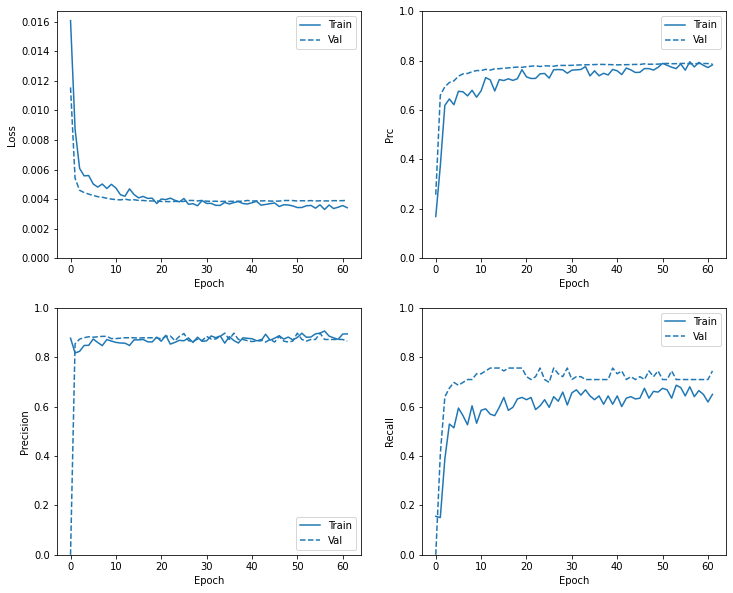

In [26]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [28]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above:

loss :  0.0024895435199141502
tp :  59.0
fp :  7.0
tn :  56874.0
fn :  22.0
accuracy :  0.9994909167289734
precision :  0.8939393758773804
recall :  0.7283950448036194
auc :  0.9318439960479736
prc :  0.8204483985900879

Legitimate Transactions Detected (True Negatives):  56874
Legitimate Transactions Incorrectly Detected (False Positives):  7
Fraudulent Transactions Missed (False Negatives):  22
Fraudulent Transactions Detected (True Positives):  59
Total Fraudulent Transactions:  81


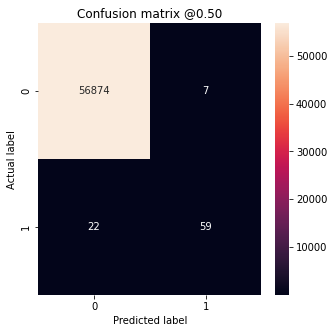

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [30]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

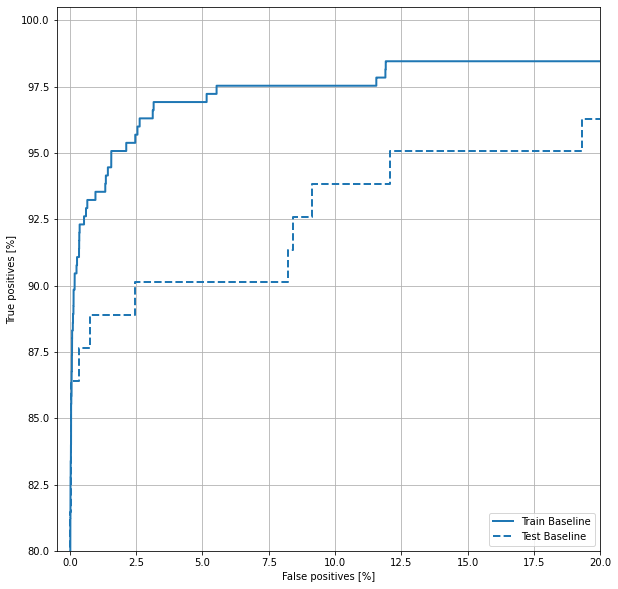

In [31]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC

Now plot the [AUPRC](https://developers.google.com/machine-learning/glossary?hl=en#PR_AUC). Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.


In [32]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

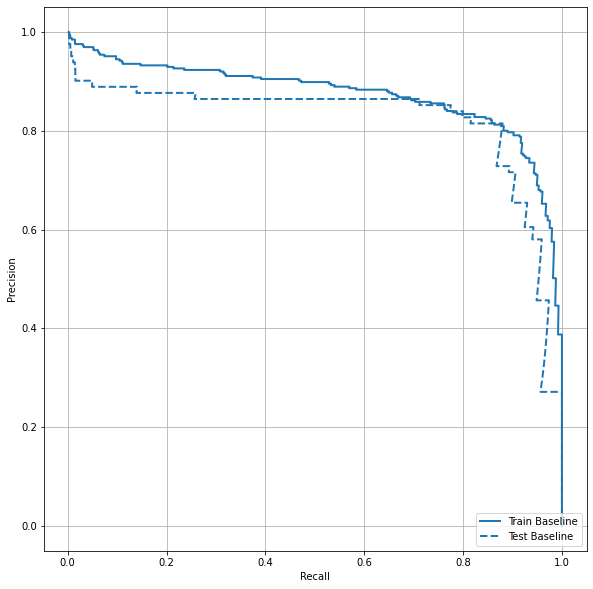

In [33]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

## Class weights

### Calculate class weights

The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `tf.keras.optimizers.SGD`, may fail. The optimizer used here, `tf.keras.optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [35]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100



 1/90 [..............................] - ETA: 2:11 - loss: 2.1836 - tp: 59.0000 - fp: 7.0000 - tn: 58920.0000 - fn: 24.0000 - accuracy: 0.9995 - precision: 0.8939 - recall: 0.7108 - auc: 0.9213 - prc: 0.8007


11/90 [==>...........................] - ETA: 0s - loss: 4.7185 - tp: 59.0000 - fp: 7.0000 - tn: 79364.0000 - fn: 60.0000 - accuracy: 0.9992 - precision: 0.8939 - recall: 0.4958 - auc: 0.7957 - prc: 0.5600  


21/90 [======>.......................] - ETA: 0s - loss: 5.0242 - tp: 59.0000 - fp: 7.0000 - tn: 99804.0000 - fn: 100.0000 - accuracy: 0.9989 - precision: 0.8939 - recall: 0.3711 - auc: 0.7213 - prc: 0.4192


31/90 [=========>....................] - ETA: 0s - loss: 5.1445 - tp: 59.0000 - fp: 7.0000 - tn: 120240.0000 - fn: 144.0000 - accuracy: 0.9987 - precision: 0.8939 - recall: 0.2906 - auc: 0.6722 - prc: 0.3276


41/90 [============>.................] - ETA: 0s - loss: 5.0659 - tp: 59.0000 - fp: 7.0000 - tn: 140680.0000 - fn: 184.0000 - accuracy: 0.9986 - precision: 0.8939 - recall: 0.2428 - auc: 0.6448 - prc: 0.2738


51/90 [================>.............] - ETA: 0s - loss: 4.9887 - tp: 59.0000 - fp: 7.0000 - tn: 161118.0000 - fn: 226.0000 - accuracy: 0.9986 - precision: 0.8939 - recall: 0.2070 - auc: 0.6253 - prc: 0.2329


61/90 [===================>..........] - ETA: 0s - loss: 4.7454 - tp: 59.0000 - fp: 8.0000 - tn: 181563.0000 - fn: 260.0000 - accuracy: 0.9985 - precision: 0.8806 - recall: 0.1850 - auc: 0.6214 - prc: 0.2078


71/90 [======================>.......] - ETA: 0s - loss: 4.5134 - tp: 59.0000 - fp: 9.0000 - tn: 202010.0000 - fn: 292.0000 - accuracy: 0.9985 - precision: 0.8676 - recall: 0.1681 - auc: 0.6217 - prc: 0.1892


81/90 [==========================>...] - ETA: 0s - loss: 4.2773 - tp: 59.0000 - fp: 9.0000 - tn: 222461.0000 - fn: 321.0000 - accuracy: 0.9985 - precision: 0.8676 - recall: 0.1553 - auc: 0.6216 - prc: 0.1761


90/90 [==============================] - 3s 15ms/step - loss: 4.1298 - tp: 59.0000 - fp: 11.0000 - tn: 238821.0000 - fn: 347.0000 - accuracy: 0.9985 - precision: 0.8429 - recall: 0.1453 - auc: 0.6238 - prc: 0.1649 - val_loss: 0.0119 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45483.0000 - val_fn: 86.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7124 - val_prc: 0.0294


Epoch 2/100



 1/90 [..............................] - ETA: 0s - loss: 2.8151 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2044.0000 - fn: 4.0000 - accuracy: 0.9980 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7210 - prc: 0.2588


11/90 [==>...........................] - ETA: 0s - loss: 2.6606 - tp: 0.0000e+00 - fp: 1.0000 - tn: 22487.0000 - fn: 40.0000 - accuracy: 0.9982 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7144 - prc: 0.0461  


21/90 [======>.......................] - ETA: 0s - loss: 2.5445 - tp: 1.0000 - fp: 3.0000 - tn: 42931.0000 - fn: 73.0000 - accuracy: 0.9982 - precision: 0.2500 - recall: 0.0135 - auc: 0.7343 - prc: 0.0550            


31/90 [=========>....................] - ETA: 0s - loss: 2.4402 - tp: 5.0000 - fp: 4.0000 - tn: 63372.0000 - fn: 107.0000 - accuracy: 0.9983 - precision: 0.5556 - recall: 0.0446 - auc: 0.7590 - prc: 0.0919


41/90 [============>.................] - ETA: 0s - loss: 2.4313 - tp: 11.0000 - fp: 8.0000 - tn: 83805.0000 - fn: 144.0000 - accuracy: 0.9982 - precision: 0.5789 - recall: 0.0710 - auc: 0.7687 - prc: 0.1211


51/90 [================>.............] - ETA: 0s - loss: 2.3842 - tp: 23.0000 - fp: 16.0000 - tn: 104230.0000 - fn: 179.0000 - accuracy: 0.9981 - precision: 0.5897 - recall: 0.1139 - auc: 0.7829 - prc: 0.1496


61/90 [===================>..........] - ETA: 0s - loss: 2.2207 - tp: 33.0000 - fp: 23.0000 - tn: 124668.0000 - fn: 204.0000 - accuracy: 0.9982 - precision: 0.5893 - recall: 0.1392 - auc: 0.8001 - prc: 0.1743


71/90 [======================>.......] - ETA: 0s - loss: 2.0979 - tp: 47.0000 - fp: 35.0000 - tn: 145100.0000 - fn: 226.0000 - accuracy: 0.9982 - precision: 0.5732 - recall: 0.1722 - auc: 0.8089 - prc: 0.1936


81/90 [==========================>...] - ETA: 0s - loss: 2.0057 - tp: 60.0000 - fp: 43.0000 - tn: 165536.0000 - fn: 249.0000 - accuracy: 0.9982 - precision: 0.5825 - recall: 0.1942 - auc: 0.8121 - prc: 0.2124


90/90 [==============================] - 1s 7ms/step - loss: 1.8711 - tp: 69.0000 - fp: 54.0000 - tn: 181897.0000 - fn: 256.0000 - accuracy: 0.9983 - precision: 0.5610 - recall: 0.2123 - auc: 0.8178 - prc: 0.2117 - val_loss: 0.0060 - val_tp: 56.0000 - val_fp: 10.0000 - val_tn: 45473.0000 - val_fn: 30.0000 - val_accuracy: 0.9991 - val_precision: 0.8485 - val_recall: 0.6512 - val_auc: 0.9427 - val_prc: 0.6870


Epoch 3/100



 1/90 [..............................] - ETA: 0s - loss: 1.6576 - tp: 2.0000 - fp: 0.0000e+00 - tn: 2043.0000 - fn: 3.0000 - accuracy: 0.9985 - precision: 1.0000 - recall: 0.4000 - auc: 0.8652 - prc: 0.5477


11/90 [==>...........................] - ETA: 0s - loss: 1.0829 - tp: 14.0000 - fp: 20.0000 - tn: 22472.0000 - fn: 22.0000 - accuracy: 0.9981 - precision: 0.4118 - recall: 0.3889 - auc: 0.8820 - prc: 0.2792


21/90 [======>.......................] - ETA: 0s - loss: 0.8135 - tp: 36.0000 - fp: 33.0000 - tn: 42907.0000 - fn: 32.0000 - accuracy: 0.9985 - precision: 0.5217 - recall: 0.5294 - auc: 0.9085 - prc: 0.4420


31/90 [=========>....................] - ETA: 0s - loss: 0.8142 - tp: 51.0000 - fp: 46.0000 - tn: 63343.0000 - fn: 48.0000 - accuracy: 0.9985 - precision: 0.5258 - recall: 0.5152 - auc: 0.9051 - prc: 0.4327


40/90 [============>.................] - ETA: 0s - loss: 0.8920 - tp: 66.0000 - fp: 58.0000 - tn: 81731.0000 - fn: 65.0000 - accuracy: 0.9985 - precision: 0.5323 - recall: 0.5038 - auc: 0.8977 - prc: 0.4165


49/90 [===============>..............] - ETA: 0s - loss: 0.7970 - tp: 90.0000 - fp: 75.0000 - tn: 100116.0000 - fn: 71.0000 - accuracy: 0.9985 - precision: 0.5455 - recall: 0.5590 - auc: 0.9084 - prc: 0.4630


58/90 [==================>...........] - ETA: 0s - loss: 0.8699 - tp: 111.0000 - fp: 97.0000 - tn: 118487.0000 - fn: 89.0000 - accuracy: 0.9984 - precision: 0.5337 - recall: 0.5550 - auc: 0.8980 - prc: 0.4681


68/90 [=====================>........] - ETA: 0s - loss: 0.8899 - tp: 137.0000 - fp: 129.0000 - tn: 138890.0000 - fn: 108.0000 - accuracy: 0.9983 - precision: 0.5150 - recall: 0.5592 - auc: 0.9017 - prc: 0.4763


77/90 [========================>.....] - ETA: 0s - loss: 0.8795 - tp: 163.0000 - fp: 154.0000 - tn: 157259.0000 - fn: 120.0000 - accuracy: 0.9983 - precision: 0.5142 - recall: 0.5760 - auc: 0.9045 - prc: 0.4998


87/90 [============================>.] - ETA: 0s - loss: 0.8784 - tp: 182.0000 - fp: 186.0000 - tn: 177671.0000 - fn: 137.0000 - accuracy: 0.9982 - precision: 0.4946 - recall: 0.5705 - auc: 0.9065 - prc: 0.4931


90/90 [==============================] - 1s 7ms/step - loss: 0.8666 - tp: 187.0000 - fp: 198.0000 - tn: 181753.0000 - fn: 138.0000 - accuracy: 0.9982 - precision: 0.4857 - recall: 0.5754 - auc: 0.9075 - prc: 0.4912 - val_loss: 0.0077 - val_tp: 65.0000 - val_fp: 19.0000 - val_tn: 45464.0000 - val_fn: 21.0000 - val_accuracy: 0.9991 - val_precision: 0.7738 - val_recall: 0.7558 - val_auc: 0.9564 - val_prc: 0.6924


Epoch 4/100



 1/90 [..............................] - ETA: 0s - loss: 0.0208 - tp: 3.0000 - fp: 1.0000 - tn: 2044.0000 - fn: 0.0000e+00 - accuracy: 0.9995 - precision: 0.7500 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000


10/90 [==>...........................] - ETA: 0s - loss: 0.6600 - tp: 31.0000 - fp: 39.0000 - tn: 20398.0000 - fn: 12.0000 - accuracy: 0.9975 - precision: 0.4429 - recall: 0.7209 - auc: 0.9356 - prc: 0.6350


20/90 [=====>........................] - ETA: 0s - loss: 0.6288 - tp: 56.0000 - fp: 87.0000 - tn: 40793.0000 - fn: 24.0000 - accuracy: 0.9973 - precision: 0.3916 - recall: 0.7000 - auc: 0.9384 - prc: 0.5379


30/90 [=========>....................] - ETA: 0s - loss: 0.6974 - tp: 71.0000 - fp: 132.0000 - tn: 61199.0000 - fn: 38.0000 - accuracy: 0.9972 - precision: 0.3498 - recall: 0.6514 - auc: 0.9174 - prc: 0.4856


40/90 [============>.................] - ETA: 0s - loss: 0.6567 - tp: 102.0000 - fp: 186.0000 - tn: 81585.0000 - fn: 47.0000 - accuracy: 0.9972 - precision: 0.3542 - recall: 0.6846 - auc: 0.9212 - prc: 0.5359


50/90 [===============>..............] - ETA: 0s - loss: 0.6918 - tp: 117.0000 - fp: 247.0000 - tn: 101977.0000 - fn: 59.0000 - accuracy: 0.9970 - precision: 0.3214 - recall: 0.6648 - auc: 0.9055 - prc: 0.4996


60/90 [===================>..........] - ETA: 0s - loss: 0.6900 - tp: 137.0000 - fp: 304.0000 - tn: 122368.0000 - fn: 71.0000 - accuracy: 0.9969 - precision: 0.3107 - recall: 0.6587 - auc: 0.9049 - prc: 0.4970


70/90 [======================>.......] - ETA: 0s - loss: 0.6288 - tp: 166.0000 - fp: 376.0000 - tn: 142738.0000 - fn: 80.0000 - accuracy: 0.9968 - precision: 0.3063 - recall: 0.6748 - auc: 0.9180 - prc: 0.5192


80/90 [=========================>....] - ETA: 0s - loss: 0.6121 - tp: 193.0000 - fp: 463.0000 - tn: 163093.0000 - fn: 91.0000 - accuracy: 0.9966 - precision: 0.2942 - recall: 0.6796 - auc: 0.9228 - prc: 0.5251


90/90 [==============================] - ETA: 0s - loss: 0.6876 - tp: 218.0000 - fp: 530.0000 - tn: 181421.0000 - fn: 107.0000 - accuracy: 0.9965 - precision: 0.2914 - recall: 0.6708 - auc: 0.9152 - prc: 0.5102


90/90 [==============================] - 1s 7ms/step - loss: 0.6876 - tp: 218.0000 - fp: 530.0000 - tn: 181421.0000 - fn: 107.0000 - accuracy: 0.9965 - precision: 0.2914 - recall: 0.6708 - auc: 0.9152 - prc: 0.5102 - val_loss: 0.0109 - val_tp: 68.0000 - val_fp: 39.0000 - val_tn: 45444.0000 - val_fn: 18.0000 - val_accuracy: 0.9987 - val_precision: 0.6355 - val_recall: 0.7907 - val_auc: 0.9661 - val_prc: 0.6926


Epoch 5/100



 1/90 [..............................] - ETA: 0s - loss: 1.4029 - tp: 5.0000 - fp: 15.0000 - tn: 2026.0000 - fn: 2.0000 - accuracy: 0.9917 - precision: 0.2500 - recall: 0.7143 - auc: 0.9285 - prc: 0.5361


11/90 [==>...........................] - ETA: 0s - loss: 0.7038 - tp: 24.0000 - fp: 113.0000 - tn: 22378.0000 - fn: 13.0000 - accuracy: 0.9944 - precision: 0.1752 - recall: 0.6486 - auc: 0.9018 - prc: 0.3984


21/90 [======>.......................] - ETA: 0s - loss: 0.5305 - tp: 45.0000 - fp: 205.0000 - tn: 42737.0000 - fn: 21.0000 - accuracy: 0.9947 - precision: 0.1800 - recall: 0.6818 - auc: 0.9281 - prc: 0.4611


31/90 [=========>....................] - ETA: 0s - loss: 0.5290 - tp: 78.0000 - fp: 324.0000 - tn: 63058.0000 - fn: 28.0000 - accuracy: 0.9945 - precision: 0.1940 - recall: 0.7358 - auc: 0.9294 - prc: 0.5455


41/90 [============>.................] - ETA: 0s - loss: 0.5105 - tp: 111.0000 - fp: 439.0000 - tn: 83380.0000 - fn: 38.0000 - accuracy: 0.9943 - precision: 0.2018 - recall: 0.7450 - auc: 0.9402 - prc: 0.5658


51/90 [================>.............] - ETA: 0s - loss: 0.4974 - tp: 141.0000 - fp: 546.0000 - tn: 103714.0000 - fn: 47.0000 - accuracy: 0.9943 - precision: 0.2052 - recall: 0.7500 - auc: 0.9428 - prc: 0.5674


61/90 [===================>..........] - ETA: 0s - loss: 0.4929 - tp: 182.0000 - fp: 681.0000 - tn: 124011.0000 - fn: 54.0000 - accuracy: 0.9941 - precision: 0.2109 - recall: 0.7712 - auc: 0.9439 - prc: 0.5839


71/90 [======================>.......] - ETA: 0s - loss: 0.5136 - tp: 201.0000 - fp: 824.0000 - tn: 144315.0000 - fn: 68.0000 - accuracy: 0.9939 - precision: 0.1961 - recall: 0.7472 - auc: 0.9412 - prc: 0.5566


81/90 [==========================>...] - ETA: 0s - loss: 0.5244 - tp: 225.0000 - fp: 970.0000 - tn: 164616.0000 - fn: 77.0000 - accuracy: 0.9937 - precision: 0.1883 - recall: 0.7450 - auc: 0.9378 - prc: 0.5484


90/90 [==============================] - 1s 7ms/step - loss: 0.5229 - tp: 240.0000 - fp: 1102.0000 - tn: 180849.0000 - fn: 85.0000 - accuracy: 0.9935 - precision: 0.1788 - recall: 0.7385 - auc: 0.9395 - prc: 0.5228 - val_loss: 0.0154 - val_tp: 70.0000 - val_fp: 79.0000 - val_tn: 45404.0000 - val_fn: 16.0000 - val_accuracy: 0.9979 - val_precision: 0.4698 - val_recall: 0.8140 - val_auc: 0.9657 - val_prc: 0.7023


Epoch 6/100



 1/90 [..............................] - ETA: 0s - loss: 0.0192 - tp: 5.0000 - fp: 15.0000 - tn: 2028.0000 - fn: 0.0000e+00 - accuracy: 0.9927 - precision: 0.2500 - recall: 1.0000 - auc: 0.9994 - prc: 0.6621


11/90 [==>...........................] - ETA: 0s - loss: 0.3936 - tp: 31.0000 - fp: 195.0000 - tn: 22295.0000 - fn: 7.0000 - accuracy: 0.9910 - precision: 0.1372 - recall: 0.8158 - auc: 0.9405 - prc: 0.4818 


21/90 [======>.......................] - ETA: 0s - loss: 0.3298 - tp: 57.0000 - fp: 367.0000 - tn: 42572.0000 - fn: 12.0000 - accuracy: 0.9912 - precision: 0.1344 - recall: 0.8261 - auc: 0.9528 - prc: 0.5297


31/90 [=========>....................] - ETA: 0s - loss: 0.4516 - tp: 85.0000 - fp: 541.0000 - tn: 62837.0000 - fn: 25.0000 - accuracy: 0.9911 - precision: 0.1358 - recall: 0.7727 - auc: 0.9384 - prc: 0.5128


40/90 [============>.................] - ETA: 0s - loss: 0.5150 - tp: 111.0000 - fp: 726.0000 - tn: 81047.0000 - fn: 36.0000 - accuracy: 0.9907 - precision: 0.1326 - recall: 0.7551 - auc: 0.9306 - prc: 0.4777


49/90 [===============>..............] - ETA: 0s - loss: 0.5100 - tp: 138.0000 - fp: 927.0000 - tn: 99243.0000 - fn: 44.0000 - accuracy: 0.9903 - precision: 0.1296 - recall: 0.7582 - auc: 0.9305 - prc: 0.4553


59/90 [==================>...........] - ETA: 0s - loss: 0.4909 - tp: 166.0000 - fp: 1144.0000 - tn: 119471.0000 - fn: 51.0000 - accuracy: 0.9901 - precision: 0.1267 - recall: 0.7650 - auc: 0.9330 - prc: 0.4606


69/90 [======================>.......] - ETA: 0s - loss: 0.4838 - tp: 193.0000 - fp: 1373.0000 - tn: 139688.0000 - fn: 58.0000 - accuracy: 0.9899 - precision: 0.1232 - recall: 0.7689 - auc: 0.9332 - prc: 0.4463


79/90 [=========================>....] - ETA: 0s - loss: 0.4397 - tp: 229.0000 - fp: 1621.0000 - tn: 159880.0000 - fn: 62.0000 - accuracy: 0.9896 - precision: 0.1238 - recall: 0.7869 - auc: 0.9416 - prc: 0.4451


89/90 [============================>.] - ETA: 0s - loss: 0.4753 - tp: 251.0000 - fp: 1839.0000 - tn: 180108.0000 - fn: 74.0000 - accuracy: 0.9895 - precision: 0.1201 - recall: 0.7723 - auc: 0.9336 - prc: 0.4297


90/90 [==============================] - 1s 7ms/step - loss: 0.4753 - tp: 251.0000 - fp: 1839.0000 - tn: 180112.0000 - fn: 74.0000 - accuracy: 0.9895 - precision: 0.1201 - recall: 0.7723 - auc: 0.9336 - prc: 0.4297 - val_loss: 0.0213 - val_tp: 70.0000 - val_fp: 156.0000 - val_tn: 45327.0000 - val_fn: 16.0000 - val_accuracy: 0.9962 - val_precision: 0.3097 - val_recall: 0.8140 - val_auc: 0.9654 - val_prc: 0.6742


Epoch 7/100



 1/90 [..............................] - ETA: 0s - loss: 0.0223 - tp: 3.0000 - fp: 32.0000 - tn: 2013.0000 - fn: 0.0000e+00 - accuracy: 0.9844 - precision: 0.0857 - recall: 1.0000 - auc: 0.9998 - prc: 0.7500


11/90 [==>...........................] - ETA: 0s - loss: 0.2544 - tp: 40.0000 - fp: 261.0000 - tn: 22222.0000 - fn: 5.0000 - accuracy: 0.9882 - precision: 0.1329 - recall: 0.8889 - auc: 0.9720 - prc: 0.5039 


20/90 [=====>........................] - ETA: 0s - loss: 0.2452 - tp: 72.0000 - fp: 489.0000 - tn: 40391.0000 - fn: 8.0000 - accuracy: 0.9879 - precision: 0.1283 - recall: 0.9000 - auc: 0.9718 - prc: 0.4925


30/90 [=========>....................] - ETA: 0s - loss: 0.2879 - tp: 108.0000 - fp: 778.0000 - tn: 60541.0000 - fn: 13.0000 - accuracy: 0.9871 - precision: 0.1219 - recall: 0.8926 - auc: 0.9617 - prc: 0.4935


39/90 [============>.................] - ETA: 0s - loss: 0.2933 - tp: 135.0000 - fp: 1011.0000 - tn: 78707.0000 - fn: 19.0000 - accuracy: 0.9871 - precision: 0.1178 - recall: 0.8766 - auc: 0.9626 - prc: 0.4876


49/90 [===============>..............] - ETA: 0s - loss: 0.3703 - tp: 157.0000 - fp: 1304.0000 - tn: 98861.0000 - fn: 30.0000 - accuracy: 0.9867 - precision: 0.1075 - recall: 0.8396 - auc: 0.9521 - prc: 0.4339


59/90 [==================>...........] - ETA: 0s - loss: 0.3623 - tp: 188.0000 - fp: 1591.0000 - tn: 119019.0000 - fn: 34.0000 - accuracy: 0.9866 - precision: 0.1057 - recall: 0.8468 - auc: 0.9495 - prc: 0.4245


69/90 [======================>.......] - ETA: 0s - loss: 0.3366 - tp: 221.0000 - fp: 1902.0000 - tn: 139151.0000 - fn: 38.0000 - accuracy: 0.9863 - precision: 0.1041 - recall: 0.8533 - auc: 0.9553 - prc: 0.4152


78/90 [=========================>....] - ETA: 0s - loss: 0.3663 - tp: 248.0000 - fp: 2205.0000 - tn: 157244.0000 - fn: 47.0000 - accuracy: 0.9859 - precision: 0.1011 - recall: 0.8407 - auc: 0.9525 - prc: 0.4029


87/90 [============================>.] - ETA: 0s - loss: 0.3942 - tp: 266.0000 - fp: 2492.0000 - tn: 175363.0000 - fn: 55.0000 - accuracy: 0.9857 - precision: 0.0964 - recall: 0.8287 - auc: 0.9457 - prc: 0.3819


90/90 [==============================] - 1s 7ms/step - loss: 0.3870 - tp: 270.0000 - fp: 2554.0000 - tn: 179397.0000 - fn: 55.0000 - accuracy: 0.9857 - precision: 0.0956 - recall: 0.8308 - auc: 0.9463 - prc: 0.3800 - val_loss: 0.0269 - val_tp: 70.0000 - val_fp: 264.0000 - val_tn: 45219.0000 - val_fn: 16.0000 - val_accuracy: 0.9939 - val_precision: 0.2096 - val_recall: 0.8140 - val_auc: 0.9651 - val_prc: 0.6116


Epoch 8/100



 1/90 [..............................] - ETA: 0s - loss: 0.0369 - tp: 5.0000 - fp: 40.0000 - tn: 2003.0000 - fn: 0.0000e+00 - accuracy: 0.9805 - precision: 0.1111 - recall: 1.0000 - auc: 0.9990 - prc: 0.5556


11/90 [==>...........................] - ETA: 0s - loss: 0.2299 - tp: 43.0000 - fp: 374.0000 - tn: 22106.0000 - fn: 5.0000 - accuracy: 0.9832 - precision: 0.1031 - recall: 0.8958 - auc: 0.9778 - prc: 0.5173 


21/90 [======>.......................] - ETA: 0s - loss: 0.3624 - tp: 77.0000 - fp: 735.0000 - tn: 42183.0000 - fn: 13.0000 - accuracy: 0.9826 - precision: 0.0948 - recall: 0.8556 - auc: 0.9601 - prc: 0.4057


31/90 [=========>....................] - ETA: 0s - loss: 0.4152 - tp: 97.0000 - fp: 1079.0000 - tn: 62292.0000 - fn: 20.0000 - accuracy: 0.9827 - precision: 0.0825 - recall: 0.8291 - auc: 0.9416 - prc: 0.3655


41/90 [============>.................] - ETA: 0s - loss: 0.3815 - tp: 124.0000 - fp: 1440.0000 - tn: 82378.0000 - fn: 26.0000 - accuracy: 0.9825 - precision: 0.0793 - recall: 0.8267 - auc: 0.9463 - prc: 0.3503


50/90 [===============>..............] - ETA: 0s - loss: 0.3839 - tp: 148.0000 - fp: 1775.0000 - tn: 100446.0000 - fn: 31.0000 - accuracy: 0.9824 - precision: 0.0770 - recall: 0.8268 - auc: 0.9433 - prc: 0.3395


60/90 [===================>..........] - ETA: 0s - loss: 0.4405 - tp: 175.0000 - fp: 2142.0000 - tn: 120521.0000 - fn: 42.0000 - accuracy: 0.9822 - precision: 0.0755 - recall: 0.8065 - auc: 0.9342 - prc: 0.3207


70/90 [======================>.......] - ETA: 0s - loss: 0.4269 - tp: 206.0000 - fp: 2491.0000 - tn: 140615.0000 - fn: 48.0000 - accuracy: 0.9823 - precision: 0.0764 - recall: 0.8110 - auc: 0.9382 - prc: 0.3193


80/90 [=========================>....] - ETA: 0s - loss: 0.3867 - tp: 247.0000 - fp: 2885.0000 - tn: 160657.0000 - fn: 51.0000 - accuracy: 0.9821 - precision: 0.0789 - recall: 0.8289 - auc: 0.9465 - prc: 0.3353


89/90 [============================>.] - ETA: 0s - loss: 0.3942 - tp: 268.0000 - fp: 3218.0000 - tn: 178729.0000 - fn: 57.0000 - accuracy: 0.9820 - precision: 0.0769 - recall: 0.8246 - auc: 0.9434 - prc: 0.3273


90/90 [==============================] - 1s 7ms/step - loss: 0.3942 - tp: 268.0000 - fp: 3219.0000 - tn: 178732.0000 - fn: 57.0000 - accuracy: 0.9820 - precision: 0.0769 - recall: 0.8246 - auc: 0.9434 - prc: 0.3273 - val_loss: 0.0337 - val_tp: 70.0000 - val_fp: 355.0000 - val_tn: 45128.0000 - val_fn: 16.0000 - val_accuracy: 0.9919 - val_precision: 0.1647 - val_recall: 0.8140 - val_auc: 0.9682 - val_prc: 0.5918


Epoch 9/100



 1/90 [..............................] - ETA: 0s - loss: 0.1318 - tp: 4.0000 - fp: 42.0000 - tn: 2002.0000 - fn: 0.0000e+00 - accuracy: 0.9795 - precision: 0.0870 - recall: 1.0000 - auc: 0.9924 - prc: 0.1560


11/90 [==>...........................] - ETA: 0s - loss: 0.7066 - tp: 39.0000 - fp: 497.0000 - tn: 21981.0000 - fn: 11.0000 - accuracy: 0.9775 - precision: 0.0728 - recall: 0.7800 - auc: 0.8986 - prc: 0.2573


21/90 [======>.......................] - ETA: 0s - loss: 0.5390 - tp: 69.0000 - fp: 917.0000 - tn: 42007.0000 - fn: 15.0000 - accuracy: 0.9783 - precision: 0.0700 - recall: 0.8214 - auc: 0.9094 - prc: 0.2950


31/90 [=========>....................] - ETA: 0s - loss: 0.4871 - tp: 101.0000 - fp: 1347.0000 - tn: 62018.0000 - fn: 22.0000 - accuracy: 0.9784 - precision: 0.0698 - recall: 0.8211 - auc: 0.9213 - prc: 0.2949


41/90 [============>.................] - ETA: 0s - loss: 0.4603 - tp: 133.0000 - fp: 1773.0000 - tn: 82034.0000 - fn: 28.0000 - accuracy: 0.9786 - precision: 0.0698 - recall: 0.8261 - auc: 0.9269 - prc: 0.3088


51/90 [================>.............] - ETA: 0s - loss: 0.3982 - tp: 154.0000 - fp: 2172.0000 - tn: 102093.0000 - fn: 29.0000 - accuracy: 0.9789 - precision: 0.0662 - recall: 0.8415 - auc: 0.9313 - prc: 0.2923


61/90 [===================>..........] - ETA: 0s - loss: 0.3943 - tp: 180.0000 - fp: 2603.0000 - tn: 122109.0000 - fn: 36.0000 - accuracy: 0.9789 - precision: 0.0647 - recall: 0.8333 - auc: 0.9342 - prc: 0.2900


71/90 [======================>.......] - ETA: 0s - loss: 0.3816 - tp: 214.0000 - fp: 3028.0000 - tn: 142126.0000 - fn: 40.0000 - accuracy: 0.9789 - precision: 0.0660 - recall: 0.8425 - auc: 0.9380 - prc: 0.2988


81/90 [==========================>...] - ETA: 0s - loss: 0.3896 - tp: 243.0000 - fp: 3480.0000 - tn: 162117.0000 - fn: 48.0000 - accuracy: 0.9787 - precision: 0.0653 - recall: 0.8351 - auc: 0.9380 - prc: 0.3032


90/90 [==============================] - ETA: 0s - loss: 0.3886 - tp: 271.0000 - fp: 3845.0000 - tn: 178106.0000 - fn: 54.0000 - accuracy: 0.9786 - precision: 0.0658 - recall: 0.8338 - auc: 0.9397 - prc: 0.2995


90/90 [==============================] - 1s 7ms/step - loss: 0.3886 - tp: 271.0000 - fp: 3845.0000 - tn: 178106.0000 - fn: 54.0000 - accuracy: 0.9786 - precision: 0.0658 - recall: 0.8338 - auc: 0.9397 - prc: 0.2995 - val_loss: 0.0386 - val_tp: 70.0000 - val_fp: 406.0000 - val_tn: 45077.0000 - val_fn: 16.0000 - val_accuracy: 0.9907 - val_precision: 0.1471 - val_recall: 0.8140 - val_auc: 0.9756 - val_prc: 0.5889


Epoch 10/100



 1/90 [..............................] - ETA: 0s - loss: 0.0714 - tp: 2.0000 - fp: 35.0000 - tn: 2011.0000 - fn: 0.0000e+00 - accuracy: 0.9829 - precision: 0.0541 - recall: 1.0000 - auc: 0.9956 - prc: 0.2071


11/90 [==>...........................] - ETA: 0s - loss: 0.2687 - tp: 28.0000 - fp: 509.0000 - tn: 21988.0000 - fn: 3.0000 - accuracy: 0.9773 - precision: 0.0521 - recall: 0.9032 - auc: 0.9354 - prc: 0.2902 


20/90 [=====>........................] - ETA: 0s - loss: 0.3800 - tp: 52.0000 - fp: 924.0000 - tn: 39974.0000 - fn: 10.0000 - accuracy: 0.9772 - precision: 0.0533 - recall: 0.8387 - auc: 0.9216 - prc: 0.2403


30/90 [=========>....................] - ETA: 0s - loss: 0.3766 - tp: 77.0000 - fp: 1411.0000 - tn: 59935.0000 - fn: 17.0000 - accuracy: 0.9768 - precision: 0.0517 - recall: 0.8191 - auc: 0.9326 - prc: 0.2317


40/90 [============>.................] - ETA: 0s - loss: 0.4025 - tp: 106.0000 - fp: 1867.0000 - tn: 79921.0000 - fn: 26.0000 - accuracy: 0.9769 - precision: 0.0537 - recall: 0.8030 - auc: 0.9345 - prc: 0.2338


50/90 [===============>..............] - ETA: 0s - loss: 0.3836 - tp: 146.0000 - fp: 2325.0000 - tn: 99897.0000 - fn: 32.0000 - accuracy: 0.9770 - precision: 0.0591 - recall: 0.8202 - auc: 0.9459 - prc: 0.2553


60/90 [===================>..........] - ETA: 0s - loss: 0.3299 - tp: 184.0000 - fp: 2814.0000 - tn: 119850.0000 - fn: 32.0000 - accuracy: 0.9768 - precision: 0.0614 - recall: 0.8519 - auc: 0.9548 - prc: 0.2731


70/90 [======================>.......] - ETA: 0s - loss: 0.3048 - tp: 216.0000 - fp: 3338.0000 - tn: 139772.0000 - fn: 34.0000 - accuracy: 0.9765 - precision: 0.0608 - recall: 0.8640 - auc: 0.9589 - prc: 0.2835


80/90 [=========================>....] - ETA: 0s - loss: 0.3100 - tp: 260.0000 - fp: 3889.0000 - tn: 159651.0000 - fn: 40.0000 - accuracy: 0.9760 - precision: 0.0627 - recall: 0.8667 - auc: 0.9603 - prc: 0.2884


90/90 [==============================] - ETA: 0s - loss: 0.2951 - tp: 281.0000 - fp: 4348.0000 - tn: 177603.0000 - fn: 44.0000 - accuracy: 0.9759 - precision: 0.0607 - recall: 0.8646 - auc: 0.9623 - prc: 0.2826


90/90 [==============================] - 1s 7ms/step - loss: 0.2951 - tp: 281.0000 - fp: 4348.0000 - tn: 177603.0000 - fn: 44.0000 - accuracy: 0.9759 - precision: 0.0607 - recall: 0.8646 - auc: 0.9623 - prc: 0.2826 - val_loss: 0.0441 - val_tp: 72.0000 - val_fp: 464.0000 - val_tn: 45019.0000 - val_fn: 14.0000 - val_accuracy: 0.9895 - val_precision: 0.1343 - val_recall: 0.8372 - val_auc: 0.9748 - val_prc: 0.5895


Epoch 11/100



 1/90 [..............................] - ETA: 0s - loss: 0.0580 - tp: 3.0000 - fp: 61.0000 - tn: 1984.0000 - fn: 0.0000e+00 - accuracy: 0.9702 - precision: 0.0469 - recall: 1.0000 - auc: 0.9976 - prc: 0.2308


11/90 [==>...........................] - ETA: 0s - loss: 0.1731 - tp: 24.0000 - fp: 565.0000 - tn: 21933.0000 - fn: 6.0000 - accuracy: 0.9747 - precision: 0.0407 - recall: 0.8000 - auc: 0.9849 - prc: 0.1695 


20/90 [=====>........................] - ETA: 0s - loss: 0.1526 - tp: 56.0000 - fp: 1071.0000 - tn: 39826.0000 - fn: 7.0000 - accuracy: 0.9737 - precision: 0.0497 - recall: 0.8889 - auc: 0.9843 - prc: 0.2404


30/90 [=========>....................] - ETA: 0s - loss: 0.1340 - tp: 94.0000 - fp: 1582.0000 - tn: 59756.0000 - fn: 8.0000 - accuracy: 0.9741 - precision: 0.0561 - recall: 0.9216 - auc: 0.9884 - prc: 0.2594


40/90 [============>.................] - ETA: 0s - loss: 0.1996 - tp: 126.0000 - fp: 2109.0000 - tn: 79670.0000 - fn: 15.0000 - accuracy: 0.9741 - precision: 0.0564 - recall: 0.8936 - auc: 0.9753 - prc: 0.2639


49/90 [===============>..............] - ETA: 0s - loss: 0.2728 - tp: 161.0000 - fp: 2574.0000 - tn: 97595.0000 - fn: 22.0000 - accuracy: 0.9741 - precision: 0.0589 - recall: 0.8798 - auc: 0.9652 - prc: 0.2757


58/90 [==================>...........] - ETA: 0s - loss: 0.2533 - tp: 186.0000 - fp: 3044.0000 - tn: 115529.0000 - fn: 25.0000 - accuracy: 0.9742 - precision: 0.0576 - recall: 0.8815 - auc: 0.9681 - prc: 0.2681


68/90 [=====================>........] - ETA: 0s - loss: 0.2513 - tp: 213.0000 - fp: 3565.0000 - tn: 135455.0000 - fn: 31.0000 - accuracy: 0.9742 - precision: 0.0564 - recall: 0.8730 - auc: 0.9688 - prc: 0.2599


78/90 [=========================>....] - ETA: 0s - loss: 0.2549 - tp: 244.0000 - fp: 4076.0000 - tn: 155388.0000 - fn: 36.0000 - accuracy: 0.9743 - precision: 0.0565 - recall: 0.8714 - auc: 0.9676 - prc: 0.2680


88/90 [============================>.] - ETA: 0s - loss: 0.2651 - tp: 279.0000 - fp: 4636.0000 - tn: 175265.0000 - fn: 44.0000 - accuracy: 0.9740 - precision: 0.0568 - recall: 0.8638 - auc: 0.9672 - prc: 0.2616


90/90 [==============================] - 1s 7ms/step - loss: 0.2703 - tp: 280.0000 - fp: 4697.0000 - tn: 177254.0000 - fn: 45.0000 - accuracy: 0.9740 - precision: 0.0563 - recall: 0.8615 - auc: 0.9660 - prc: 0.2589 - val_loss: 0.0490 - val_tp: 72.0000 - val_fp: 552.0000 - val_tn: 44931.0000 - val_fn: 14.0000 - val_accuracy: 0.9876 - val_precision: 0.1154 - val_recall: 0.8372 - val_auc: 0.9762 - val_prc: 0.5902


Epoch 12/100



 1/90 [..............................] - ETA: 0s - loss: 0.3745 - tp: 3.0000 - fp: 66.0000 - tn: 1978.0000 - fn: 1.0000 - accuracy: 0.9673 - precision: 0.0435 - recall: 0.7500 - auc: 0.9761 - prc: 0.1778


11/90 [==>...........................] - ETA: 0s - loss: 0.4461 - tp: 37.0000 - fp: 629.0000 - tn: 21854.0000 - fn: 8.0000 - accuracy: 0.9717 - precision: 0.0556 - recall: 0.8222 - auc: 0.9369 - prc: 0.2533


21/90 [======>.......................] - ETA: 0s - loss: 0.3564 - tp: 68.0000 - fp: 1179.0000 - tn: 41749.0000 - fn: 12.0000 - accuracy: 0.9723 - precision: 0.0545 - recall: 0.8500 - auc: 0.9460 - prc: 0.2470


30/90 [=========>....................] - ETA: 0s - loss: 0.3867 - tp: 97.0000 - fp: 1714.0000 - tn: 59611.0000 - fn: 18.0000 - accuracy: 0.9718 - precision: 0.0536 - recall: 0.8435 - auc: 0.9378 - prc: 0.2342


40/90 [============>.................] - ETA: 0s - loss: 0.3892 - tp: 136.0000 - fp: 2340.0000 - tn: 79420.0000 - fn: 24.0000 - accuracy: 0.9711 - precision: 0.0549 - recall: 0.8500 - auc: 0.9394 - prc: 0.2527


50/90 [===============>..............] - ETA: 0s - loss: 0.4124 - tp: 159.0000 - fp: 2928.0000 - tn: 99281.0000 - fn: 32.0000 - accuracy: 0.9711 - precision: 0.0515 - recall: 0.8325 - auc: 0.9340 - prc: 0.2360


59/90 [==================>...........] - ETA: 0s - loss: 0.4032 - tp: 187.0000 - fp: 3452.0000 - tn: 117156.0000 - fn: 37.0000 - accuracy: 0.9711 - precision: 0.0514 - recall: 0.8348 - auc: 0.9352 - prc: 0.2379


69/90 [======================>.......] - ETA: 0s - loss: 0.3778 - tp: 222.0000 - fp: 4075.0000 - tn: 136975.0000 - fn: 40.0000 - accuracy: 0.9709 - precision: 0.0517 - recall: 0.8473 - auc: 0.9400 - prc: 0.2431


78/90 [=========================>....] - ETA: 0s - loss: 0.3688 - tp: 250.0000 - fp: 4588.0000 - tn: 154861.0000 - fn: 45.0000 - accuracy: 0.9710 - precision: 0.0517 - recall: 0.8475 - auc: 0.9422 - prc: 0.2418


87/90 [============================>.] - ETA: 0s - loss: 0.3421 - tp: 274.0000 - fp: 5117.0000 - tn: 172738.0000 - fn: 47.0000 - accuracy: 0.9710 - precision: 0.0508 - recall: 0.8536 - auc: 0.9462 - prc: 0.2385


90/90 [==============================] - 1s 7ms/step - loss: 0.3358 - tp: 278.0000 - fp: 5262.0000 - tn: 176689.0000 - fn: 47.0000 - accuracy: 0.9709 - precision: 0.0502 - recall: 0.8554 - auc: 0.9468 - prc: 0.2368 - val_loss: 0.0534 - val_tp: 74.0000 - val_fp: 597.0000 - val_tn: 44886.0000 - val_fn: 12.0000 - val_accuracy: 0.9866 - val_precision: 0.1103 - val_recall: 0.8605 - val_auc: 0.9752 - val_prc: 0.5848


Epoch 13/100



 1/90 [..............................] - ETA: 0s - loss: 0.0564 - tp: 6.0000 - fp: 66.0000 - tn: 1976.0000 - fn: 0.0000e+00 - accuracy: 0.9678 - precision: 0.0833 - recall: 1.0000 - auc: 0.9985 - prc: 0.5000


10/90 [==>...........................] - ETA: 0s - loss: 0.2050 - tp: 34.0000 - fp: 598.0000 - tn: 19846.0000 - fn: 2.0000 - accuracy: 0.9707 - precision: 0.0538 - recall: 0.9444 - auc: 0.9674 - prc: 0.2979 


19/90 [=====>........................] - ETA: 0s - loss: 0.1993 - tp: 64.0000 - fp: 1120.0000 - tn: 37723.0000 - fn: 5.0000 - accuracy: 0.9711 - precision: 0.0541 - recall: 0.9275 - auc: 0.9726 - prc: 0.3114


29/90 [========>.....................] - ETA: 0s - loss: 0.2805 - tp: 98.0000 - fp: 1742.0000 - tn: 57540.0000 - fn: 12.0000 - accuracy: 0.9705 - precision: 0.0533 - recall: 0.8909 - auc: 0.9585 - prc: 0.2858


38/90 [===========>..................] - ETA: 0s - loss: 0.3212 - tp: 122.0000 - fp: 2328.0000 - tn: 75355.0000 - fn: 19.0000 - accuracy: 0.9698 - precision: 0.0498 - recall: 0.8652 - auc: 0.9511 - prc: 0.2549


47/90 [==============>...............] - ETA: 0s - loss: 0.2862 - tp: 149.0000 - fp: 2839.0000 - tn: 93247.0000 - fn: 21.0000 - accuracy: 0.9703 - precision: 0.0499 - recall: 0.8765 - auc: 0.9572 - prc: 0.2576


56/90 [=================>............] - ETA: 0s - loss: 0.2813 - tp: 178.0000 - fp: 3376.0000 - tn: 111108.0000 - fn: 26.0000 - accuracy: 0.9703 - precision: 0.0501 - recall: 0.8725 - auc: 0.9587 - prc: 0.2574


66/90 [=====================>........] - ETA: 0s - loss: 0.3197 - tp: 209.0000 - fp: 4018.0000 - tn: 130907.0000 - fn: 34.0000 - accuracy: 0.9700 - precision: 0.0494 - recall: 0.8601 - auc: 0.9513 - prc: 0.2535


76/90 [========================>.....] - ETA: 0s - loss: 0.2939 - tp: 241.0000 - fp: 4664.0000 - tn: 150708.0000 - fn: 35.0000 - accuracy: 0.9698 - precision: 0.0491 - recall: 0.8732 - auc: 0.9557 - prc: 0.2540


86/90 [===========================>..] - ETA: 0s - loss: 0.2870 - tp: 275.0000 - fp: 5315.0000 - tn: 170500.0000 - fn: 38.0000 - accuracy: 0.9696 - precision: 0.0492 - recall: 0.8786 - auc: 0.9570 - prc: 0.2562


90/90 [==============================] - 1s 7ms/step - loss: 0.2833 - tp: 286.0000 - fp: 5502.0000 - tn: 176449.0000 - fn: 39.0000 - accuracy: 0.9696 - precision: 0.0494 - recall: 0.8800 - auc: 0.9582 - prc: 0.2572 - val_loss: 0.0563 - val_tp: 74.0000 - val_fp: 616.0000 - val_tn: 44867.0000 - val_fn: 12.0000 - val_accuracy: 0.9862 - val_precision: 0.1072 - val_recall: 0.8605 - val_auc: 0.9748 - val_prc: 0.5678


Epoch 14/100



 1/90 [..............................] - ETA: 0s - loss: 0.0554 - tp: 3.0000 - fp: 60.0000 - tn: 1985.0000 - fn: 0.0000e+00 - accuracy: 0.9707 - precision: 0.0476 - recall: 1.0000 - auc: 0.9970 - prc: 0.1972


11/90 [==>...........................] - ETA: 0s - loss: 0.2729 - tp: 35.0000 - fp: 719.0000 - tn: 21768.0000 - fn: 6.0000 - accuracy: 0.9678 - precision: 0.0464 - recall: 0.8537 - auc: 0.9651 - prc: 0.2197 


20/90 [=====>........................] - ETA: 0s - loss: 0.2530 - tp: 64.0000 - fp: 1275.0000 - tn: 39611.0000 - fn: 10.0000 - accuracy: 0.9686 - precision: 0.0478 - recall: 0.8649 - auc: 0.9681 - prc: 0.2343


30/90 [=========>....................] - ETA: 0s - loss: 0.2846 - tp: 94.0000 - fp: 1893.0000 - tn: 59439.0000 - fn: 14.0000 - accuracy: 0.9690 - precision: 0.0473 - recall: 0.8704 - auc: 0.9563 - prc: 0.2395


40/90 [============>.................] - ETA: 0s - loss: 0.2693 - tp: 128.0000 - fp: 2544.0000 - tn: 79229.0000 - fn: 19.0000 - accuracy: 0.9687 - precision: 0.0479 - recall: 0.8707 - auc: 0.9636 - prc: 0.2334


50/90 [===============>..............] - ETA: 0s - loss: 0.2735 - tp: 152.0000 - fp: 3186.0000 - tn: 99039.0000 - fn: 23.0000 - accuracy: 0.9687 - precision: 0.0455 - recall: 0.8686 - auc: 0.9606 - prc: 0.2329


60/90 [===================>..........] - ETA: 0s - loss: 0.2794 - tp: 188.0000 - fp: 3845.0000 - tn: 118818.0000 - fn: 29.0000 - accuracy: 0.9685 - precision: 0.0466 - recall: 0.8664 - auc: 0.9622 - prc: 0.2342


70/90 [======================>.......] - ETA: 0s - loss: 0.2919 - tp: 217.0000 - fp: 4471.0000 - tn: 138636.0000 - fn: 36.0000 - accuracy: 0.9686 - precision: 0.0463 - recall: 0.8577 - auc: 0.9615 - prc: 0.2333


80/90 [=========================>....] - ETA: 0s - loss: 0.2868 - tp: 256.0000 - fp: 5075.0000 - tn: 158469.0000 - fn: 40.0000 - accuracy: 0.9688 - precision: 0.0480 - recall: 0.8649 - auc: 0.9630 - prc: 0.2417


90/90 [==============================] - ETA: 0s - loss: 0.2969 - tp: 280.0000 - fp: 5630.0000 - tn: 176321.0000 - fn: 45.0000 - accuracy: 0.9689 - precision: 0.0474 - recall: 0.8615 - auc: 0.9594 - prc: 0.2374


90/90 [==============================] - 1s 7ms/step - loss: 0.2969 - tp: 280.0000 - fp: 5630.0000 - tn: 176321.0000 - fn: 45.0000 - accuracy: 0.9689 - precision: 0.0474 - recall: 0.8615 - auc: 0.9594 - prc: 0.2374 - val_loss: 0.0597 - val_tp: 74.0000 - val_fp: 644.0000 - val_tn: 44839.0000 - val_fn: 12.0000 - val_accuracy: 0.9856 - val_precision: 0.1031 - val_recall: 0.8605 - val_auc: 0.9741 - val_prc: 0.5627


Epoch 15/100



 1/90 [..............................] - ETA: 0s - loss: 0.0531 - tp: 4.0000 - fp: 65.0000 - tn: 1979.0000 - fn: 0.0000e+00 - accuracy: 0.9683 - precision: 0.0580 - recall: 1.0000 - auc: 0.9983 - prc: 0.3636


11/90 [==>...........................] - ETA: 0s - loss: 0.2192 - tp: 38.0000 - fp: 703.0000 - tn: 21783.0000 - fn: 4.0000 - accuracy: 0.9686 - precision: 0.0513 - recall: 0.9048 - auc: 0.9800 - prc: 0.2298 


21/90 [======>.......................] - ETA: 0s - loss: 0.2346 - tp: 71.0000 - fp: 1343.0000 - tn: 41586.0000 - fn: 8.0000 - accuracy: 0.9686 - precision: 0.0502 - recall: 0.8987 - auc: 0.9727 - prc: 0.2441


31/90 [=========>....................] - ETA: 0s - loss: 0.2417 - tp: 102.0000 - fp: 2032.0000 - tn: 61342.0000 - fn: 12.0000 - accuracy: 0.9678 - precision: 0.0478 - recall: 0.8947 - auc: 0.9695 - prc: 0.2327


41/90 [============>.................] - ETA: 0s - loss: 0.2788 - tp: 128.0000 - fp: 2731.0000 - tn: 81090.0000 - fn: 19.0000 - accuracy: 0.9672 - precision: 0.0448 - recall: 0.8707 - auc: 0.9578 - prc: 0.2204


51/90 [================>.............] - ETA: 0s - loss: 0.2844 - tp: 161.0000 - fp: 3373.0000 - tn: 100889.0000 - fn: 25.0000 - accuracy: 0.9675 - precision: 0.0456 - recall: 0.8656 - auc: 0.9598 - prc: 0.2265


61/90 [===================>..........] - ETA: 0s - loss: 0.2831 - tp: 182.0000 - fp: 4095.0000 - tn: 120623.0000 - fn: 28.0000 - accuracy: 0.9670 - precision: 0.0426 - recall: 0.8667 - auc: 0.9553 - prc: 0.2106


71/90 [======================>.......] - ETA: 0s - loss: 0.2898 - tp: 213.0000 - fp: 4788.0000 - tn: 140374.0000 - fn: 33.0000 - accuracy: 0.9668 - precision: 0.0426 - recall: 0.8659 - auc: 0.9532 - prc: 0.2126


81/90 [==========================>...] - ETA: 0s - loss: 0.3009 - tp: 251.0000 - fp: 5431.0000 - tn: 160166.0000 - fn: 40.0000 - accuracy: 0.9670 - precision: 0.0442 - recall: 0.8625 - auc: 0.9532 - prc: 0.2208


90/90 [==============================] - ETA: 0s - loss: 0.3183 - tp: 280.0000 - fp: 5954.0000 - tn: 175997.0000 - fn: 45.0000 - accuracy: 0.9671 - precision: 0.0449 - recall: 0.8615 - auc: 0.9496 - prc: 0.2224

Restoring model weights from the end of the best epoch: 5.



90/90 [==============================] - 1s 7ms/step - loss: 0.3183 - tp: 280.0000 - fp: 5954.0000 - tn: 175997.0000 - fn: 45.0000 - accuracy: 0.9671 - precision: 0.0449 - recall: 0.8615 - auc: 0.9496 - prc: 0.2224 - val_loss: 0.0621 - val_tp: 74.0000 - val_fp: 665.0000 - val_tn: 44818.0000 - val_fn: 12.0000 - val_accuracy: 0.9851 - val_precision: 0.1001 - val_recall: 0.8605 - val_auc: 0.9771 - val_prc: 0.5550


Epoch 15: early stopping


### Check training history

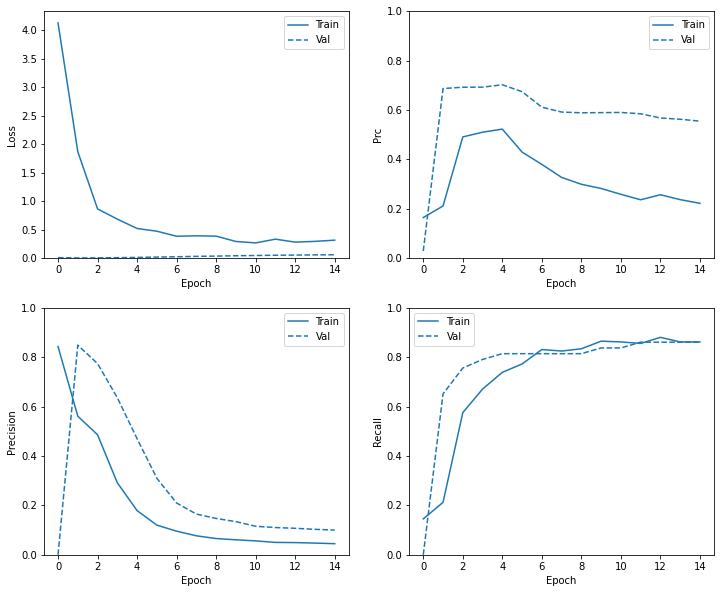

In [36]:
plot_metrics(weighted_history)

### Evaluate metrics

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.014327289536595345
tp :  69.0
fp :  88.0
tn :  56793.0
fn :  12.0
accuracy :  0.9982444643974304
precision :  0.4394904375076294
recall :  0.8518518805503845
auc :  0.9410961866378784
prc :  0.7397712469100952

Legitimate Transactions Detected (True Negatives):  56793
Legitimate Transactions Incorrectly Detected (False Positives):  88
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  69
Total Fraudulent Transactions:  81


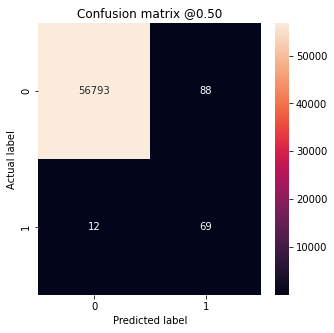

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

### Plot the ROC

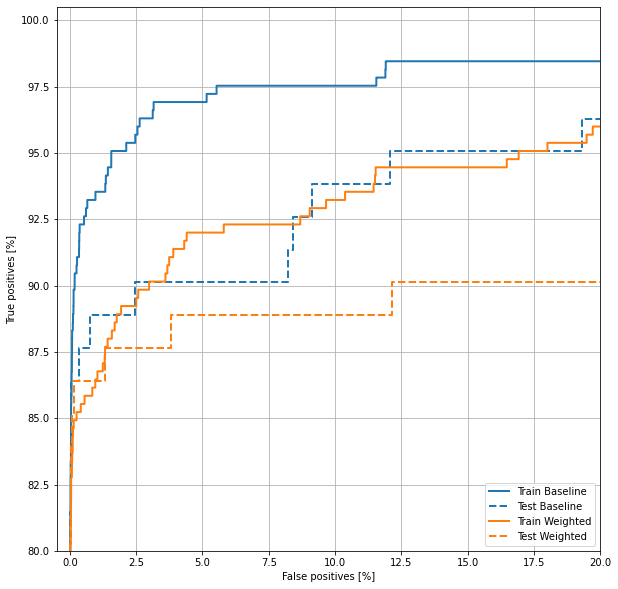

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

### Plot the AUPRC

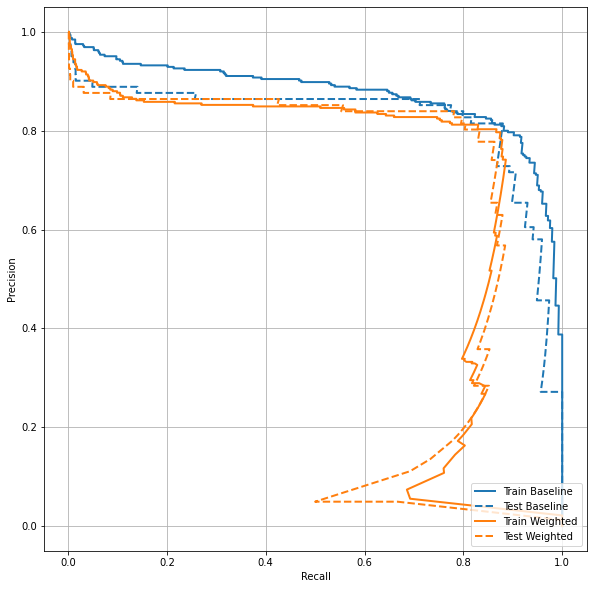

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

## Oversampling

### Oversample the minority class

A related approach would be to resample the dataset by oversampling the minority class.

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

#### Using NumPy

You can balance the dataset manually by choosing the right number of random 
indices from the positive examples:

In [42]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181951, 29)

In [43]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363902, 29)

#### Using `tf.data`

If you're using `tf.data` the easiest way to produce balanced examples is to start with a `positive` and a `negative` dataset, and merge them. See [the tf.data guide](../../guide/data.ipynb) for more examples.

In [44]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

Each dataset provides `(feature, label)` pairs:

In [45]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 0.56826828  1.24841849 -2.52251105  3.84165891  0.05052604 -0.7621795
 -1.43118352  0.43296139 -1.85102109 -2.50477555  3.20133397 -3.52460861
 -0.95133935 -5.         -1.93144512 -0.7302767  -2.46735228  0.21827555
 -1.45046438  0.21081234  0.39176826 -0.23558789 -0.03611637 -0.62063738
  0.3686766   0.23622961  1.2242418   0.75555829 -1.45589162]

Label:  1


Merge the two together using `tf.data.Dataset.sample_from_datasets`:

In [46]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [47]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50732421875


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [48]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

### Train on the oversampled data

Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps. 

In [49]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100



  1/278 [..............................] - ETA: 7:17 - loss: 2.4840 - tp: 139.0000 - fp: 325.0000 - tn: 57611.0000 - fn: 935.0000 - accuracy: 0.9786 - precision: 0.2996 - recall: 0.1294 - auc: 0.7428 - prc: 0.1984


  4/278 [..............................] - ETA: 6s - loss: 2.4117 - tp: 467.0000 - fp: 1045.0000 - tn: 59954.0000 - fn: 3688.0000 - accuracy: 0.9274 - precision: 0.3089 - recall: 0.1124 - auc: 0.7262 - prc: 0.2237


  6/278 [..............................] - ETA: 6s - loss: 2.3650 - tp: 705.0000 - fp: 1517.0000 - tn: 61540.0000 - fn: 5488.0000 - accuracy: 0.8988 - precision: 0.3173 - recall: 0.1138 - auc: 0.7150 - prc: 0.2426


  8/278 [..............................] - ETA: 6s - loss: 2.2995 - tp: 991.0000 - fp: 1991.0000 - tn: 63139.0000 - fn: 7225.0000 - accuracy: 0.8743 - precision: 0.3323 - recall: 0.1206 - auc: 0.7091 - prc: 0.2607


 10/278 [>.............................] - ETA: 6s - loss: 2.2441 - tp: 1283.0000 - fp: 2499.0000 - tn: 64691.0000 - fn: 8969.0000 - accuracy: 0.8519 - precision: 0.3392 - recall: 0.1251 - auc: 0.7021 - prc: 0.2751


 12/278 [>.............................] - ETA: 6s - loss: 2.1892 - tp: 1606.0000 - fp: 2991.0000 - tn: 66263.0000 - fn: 10678.0000 - accuracy: 0.8324 - precision: 0.3494 - recall: 0.1307 - auc: 0.6963 - prc: 0.2893


 14/278 [>.............................] - ETA: 6s - loss: 2.1400 - tp: 2023.0000 - fp: 3497.0000 - tn: 67812.0000 - fn: 12302.0000 - accuracy: 0.8155 - precision: 0.3665 - recall: 0.1412 - auc: 0.6913 - prc: 0.3038


 16/278 [>.............................] - ETA: 6s - loss: 2.0895 - tp: 2439.0000 - fp: 3998.0000 - tn: 69412.0000 - fn: 13881.0000 - accuracy: 0.8007 - precision: 0.3789 - recall: 0.1494 - auc: 0.6857 - prc: 0.3151


 18/278 [>.............................] - ETA: 6s - loss: 2.0391 - tp: 2886.0000 - fp: 4482.0000 - tn: 71009.0000 - fn: 15449.0000 - accuracy: 0.7876 - precision: 0.3917 - recall: 0.1574 - auc: 0.6814 - prc: 0.3280


 20/278 [=>............................] - ETA: 6s - loss: 1.9949 - tp: 3375.0000 - fp: 4997.0000 - tn: 72488.0000 - fn: 17062.0000 - accuracy: 0.7747 - precision: 0.4031 - recall: 0.1651 - auc: 0.6782 - prc: 0.3407


 22/278 [=>............................] - ETA: 6s - loss: 1.9515 - tp: 3934.0000 - fp: 5493.0000 - tn: 74010.0000 - fn: 18581.0000 - accuracy: 0.7640 - precision: 0.4173 - recall: 0.1747 - auc: 0.6752 - prc: 0.3534


 24/278 [=>............................] - ETA: 6s - loss: 1.9088 - tp: 4478.0000 - fp: 6017.0000 - tn: 75574.0000 - fn: 20045.0000 - accuracy: 0.7544 - precision: 0.4267 - recall: 0.1826 - auc: 0.6719 - prc: 0.3637


 26/278 [=>............................] - ETA: 6s - loss: 1.8700 - tp: 5114.0000 - fp: 6507.0000 - tn: 77103.0000 - fn: 21486.0000 - accuracy: 0.7460 - precision: 0.4401 - recall: 0.1923 - auc: 0.6696 - prc: 0.3762


 28/278 [==>...........................] - ETA: 6s - loss: 1.8302 - tp: 5801.0000 - fp: 7054.0000 - tn: 78627.0000 - fn: 22824.0000 - accuracy: 0.7386 - precision: 0.4513 - recall: 0.2027 - auc: 0.6674 - prc: 0.3874


 30/278 [==>...........................] - ETA: 6s - loss: 1.7899 - tp: 6497.0000 - fp: 7554.0000 - tn: 80198.0000 - fn: 24153.0000 - accuracy: 0.7322 - precision: 0.4624 - recall: 0.2120 - auc: 0.6660 - prc: 0.3987


 32/278 [==>...........................] - ETA: 6s - loss: 1.7490 - tp: 7267.0000 - fp: 8046.0000 - tn: 81753.0000 - fn: 25432.0000 - accuracy: 0.7267 - precision: 0.4746 - recall: 0.2222 - auc: 0.6657 - prc: 0.4108


 34/278 [==>...........................] - ETA: 6s - loss: 1.7113 - tp: 8141.0000 - fp: 8546.0000 - tn: 83235.0000 - fn: 26672.0000 - accuracy: 0.7218 - precision: 0.4879 - recall: 0.2338 - auc: 0.6662 - prc: 0.4249


 36/278 [==>...........................] - ETA: 6s - loss: 1.6743 - tp: 8980.0000 - fp: 9062.0000 - tn: 84757.0000 - fn: 27891.0000 - accuracy: 0.7172 - precision: 0.4977 - recall: 0.2436 - auc: 0.6663 - prc: 0.4370


 38/278 [===>..........................] - ETA: 6s - loss: 1.6391 - tp: 9871.0000 - fp: 9626.0000 - tn: 86290.0000 - fn: 28999.0000 - accuracy: 0.7134 - precision: 0.5063 - recall: 0.2539 - auc: 0.6662 - prc: 0.4478


 40/278 [===>..........................] - ETA: 6s - loss: 1.6046 - tp: 10794.0000 - fp: 10177.0000 - tn: 87848.0000 - fn: 30063.0000 - accuracy: 0.7103 - precision: 0.5147 - recall: 0.2642 - auc: 0.6666 - prc: 0.4588


 42/278 [===>..........................] - ETA: 6s - loss: 1.5707 - tp: 11860.0000 - fp: 10682.0000 - tn: 89338.0000 - fn: 31098.0000 - accuracy: 0.7078 - precision: 0.5261 - recall: 0.2761 - auc: 0.6684 - prc: 0.4729


 44/278 [===>..........................] - ETA: 6s - loss: 1.5387 - tp: 12906.0000 - fp: 11170.0000 - tn: 90843.0000 - fn: 32155.0000 - accuracy: 0.7054 - precision: 0.5361 - recall: 0.2864 - auc: 0.6701 - prc: 0.4858


 46/278 [===>..........................] - ETA: 6s - loss: 1.5071 - tp: 14023.0000 - fp: 11735.0000 - tn: 92331.0000 - fn: 33081.0000 - accuracy: 0.7035 - precision: 0.5444 - recall: 0.2977 - auc: 0.6718 - prc: 0.4983


 48/278 [====>.........................] - ETA: 6s - loss: 1.4769 - tp: 15198.0000 - fp: 12310.0000 - tn: 93782.0000 - fn: 33976.0000 - accuracy: 0.7019 - precision: 0.5525 - recall: 0.3091 - auc: 0.6738 - prc: 0.5110


 50/278 [====>.........................] - ETA: 6s - loss: 1.4480 - tp: 16393.0000 - fp: 12808.0000 - tn: 95288.0000 - fn: 34873.0000 - accuracy: 0.7008 - precision: 0.5614 - recall: 0.3198 - auc: 0.6759 - prc: 0.5236


 52/278 [====>.........................] - ETA: 6s - loss: 1.4192 - tp: 17634.0000 - fp: 13372.0000 - tn: 96775.0000 - fn: 35677.0000 - accuracy: 0.6999 - precision: 0.5687 - recall: 0.3308 - auc: 0.6782 - prc: 0.5355


 54/278 [====>.........................] - ETA: 6s - loss: 1.3914 - tp: 18924.0000 - fp: 13942.0000 - tn: 98252.0000 - fn: 36436.0000 - accuracy: 0.6993 - precision: 0.5758 - recall: 0.3418 - auc: 0.6806 - prc: 0.5476


 56/278 [=====>........................] - ETA: 6s - loss: 1.3647 - tp: 20253.0000 - fp: 14476.0000 - tn: 99783.0000 - fn: 37138.0000 - accuracy: 0.6993 - precision: 0.5832 - recall: 0.3529 - auc: 0.6831 - prc: 0.5590


 58/278 [=====>........................] - ETA: 6s - loss: 1.3390 - tp: 21649.0000 - fp: 15048.0000 - tn: 101257.0000 - fn: 37792.0000 - accuracy: 0.6993 - precision: 0.5899 - recall: 0.3642 - auc: 0.6858 - prc: 0.5702


 60/278 [=====>........................] - ETA: 6s - loss: 1.3145 - tp: 23038.0000 - fp: 15604.0000 - tn: 102762.0000 - fn: 38438.0000 - accuracy: 0.6995 - precision: 0.5962 - recall: 0.3747 - auc: 0.6884 - prc: 0.5808


 62/278 [=====>........................] - ETA: 6s - loss: 1.2904 - tp: 24500.0000 - fp: 16169.0000 - tn: 104252.0000 - fn: 39017.0000 - accuracy: 0.7000 - precision: 0.6024 - recall: 0.3857 - auc: 0.6913 - prc: 0.5913


 64/278 [=====>........................] - ETA: 6s - loss: 1.2672 - tp: 26043.0000 - fp: 16678.0000 - tn: 105741.0000 - fn: 39572.0000 - accuracy: 0.7009 - precision: 0.6096 - recall: 0.3969 - auc: 0.6946 - prc: 0.6023


 66/278 [======>.......................] - ETA: 6s - loss: 1.2448 - tp: 27545.0000 - fp: 17236.0000 - tn: 107278.0000 - fn: 40071.0000 - accuracy: 0.7017 - precision: 0.6151 - recall: 0.4074 - auc: 0.6974 - prc: 0.6120


 68/278 [======>.......................] - ETA: 6s - loss: 1.2241 - tp: 29079.0000 - fp: 17785.0000 - tn: 108763.0000 - fn: 40599.0000 - accuracy: 0.7025 - precision: 0.6205 - recall: 0.4173 - auc: 0.7002 - prc: 0.6212


 70/278 [======>.......................] - ETA: 6s - loss: 1.2038 - tp: 30646.0000 - fp: 18337.0000 - tn: 110276.0000 - fn: 41063.0000 - accuracy: 0.7035 - precision: 0.6256 - recall: 0.4274 - auc: 0.7031 - prc: 0.6302


 72/278 [======>.......................] - ETA: 5s - loss: 1.1841 - tp: 32244.0000 - fp: 18907.0000 - tn: 111770.0000 - fn: 41497.0000 - accuracy: 0.7045 - precision: 0.6304 - recall: 0.4373 - auc: 0.7060 - prc: 0.6388


 74/278 [======>.......................] - ETA: 5s - loss: 1.1655 - tp: 33838.0000 - fp: 19484.0000 - tn: 113269.0000 - fn: 41923.0000 - accuracy: 0.7055 - precision: 0.6346 - recall: 0.4466 - auc: 0.7088 - prc: 0.6469


 76/278 [=======>......................] - ETA: 5s - loss: 1.1476 - tp: 35451.0000 - fp: 20075.0000 - tn: 114745.0000 - fn: 42339.0000 - accuracy: 0.7064 - precision: 0.6385 - recall: 0.4557 - auc: 0.7116 - prc: 0.6546


 78/278 [=======>......................] - ETA: 5s - loss: 1.1307 - tp: 37059.0000 - fp: 20627.0000 - tn: 116256.0000 - fn: 42764.0000 - accuracy: 0.7075 - precision: 0.6424 - recall: 0.4643 - auc: 0.7142 - prc: 0.6618


 80/278 [=======>......................] - ETA: 5s - loss: 1.1136 - tp: 38730.0000 - fp: 21169.0000 - tn: 117777.0000 - fn: 43126.0000 - accuracy: 0.7088 - precision: 0.6466 - recall: 0.4731 - auc: 0.7172 - prc: 0.6694


 82/278 [=======>......................] - ETA: 5s - loss: 1.0976 - tp: 40364.0000 - fp: 21718.0000 - tn: 119320.0000 - fn: 43496.0000 - accuracy: 0.7100 - precision: 0.6502 - recall: 0.4813 - auc: 0.7198 - prc: 0.6762


 84/278 [========>.....................] - ETA: 5s - loss: 1.0818 - tp: 42049.0000 - fp: 22201.0000 - tn: 120871.0000 - fn: 43873.0000 - accuracy: 0.7115 - precision: 0.6545 - recall: 0.4894 - auc: 0.7228 - prc: 0.6834


 86/278 [========>.....................] - ETA: 5s - loss: 1.0668 - tp: 43770.0000 - fp: 22711.0000 - tn: 122384.0000 - fn: 44225.0000 - accuracy: 0.7128 - precision: 0.6584 - recall: 0.4974 - auc: 0.7256 - prc: 0.6901


 88/278 [========>.....................] - ETA: 5s - loss: 1.0525 - tp: 45440.0000 - fp: 23266.0000 - tn: 123925.0000 - fn: 44555.0000 - accuracy: 0.7141 - precision: 0.6614 - recall: 0.5049 - auc: 0.7281 - prc: 0.6961


 90/278 [========>.....................] - ETA: 5s - loss: 1.0384 - tp: 47171.0000 - fp: 23767.0000 - tn: 125477.0000 - fn: 44867.0000 - accuracy: 0.7155 - precision: 0.6650 - recall: 0.5125 - auc: 0.7309 - prc: 0.7023


 92/278 [========>.....................] - ETA: 5s - loss: 1.0248 - tp: 48919.0000 - fp: 24259.0000 - tn: 127013.0000 - fn: 45187.0000 - accuracy: 0.7170 - precision: 0.6685 - recall: 0.5198 - auc: 0.7337 - prc: 0.7083


 94/278 [=========>....................] - ETA: 5s - loss: 1.0118 - tp: 50685.0000 - fp: 24756.0000 - tn: 128535.0000 - fn: 45498.0000 - accuracy: 0.7184 - precision: 0.6718 - recall: 0.5270 - auc: 0.7364 - prc: 0.7140


 96/278 [=========>....................] - ETA: 5s - loss: 0.9993 - tp: 52460.0000 - fp: 25261.0000 - tn: 130043.0000 - fn: 45806.0000 - accuracy: 0.7197 - precision: 0.6750 - recall: 0.5339 - auc: 0.7390 - prc: 0.7195


 98/278 [=========>....................] - ETA: 5s - loss: 0.9875 - tp: 54159.0000 - fp: 25712.0000 - tn: 131651.0000 - fn: 46144.0000 - accuracy: 0.7211 - precision: 0.6781 - recall: 0.5400 - auc: 0.7414 - prc: 0.7245


100/278 [=========>....................] - ETA: 5s - loss: 0.9758 - tp: 55869.0000 - fp: 26207.0000 - tn: 133258.0000 - fn: 46428.0000 - accuracy: 0.7225 - precision: 0.6807 - recall: 0.5461 - auc: 0.7437 - prc: 0.7292


102/278 [==========>...................] - ETA: 5s - loss: 0.9645 - tp: 57641.0000 - fp: 26656.0000 - tn: 134836.0000 - fn: 46725.0000 - accuracy: 0.7240 - precision: 0.6838 - recall: 0.5523 - auc: 0.7462 - prc: 0.7341


104/278 [==========>...................] - ETA: 5s - loss: 0.9537 - tp: 59350.0000 - fp: 27140.0000 - tn: 136444.0000 - fn: 47020.0000 - accuracy: 0.7253 - precision: 0.6862 - recall: 0.5580 - auc: 0.7485 - prc: 0.7383


106/278 [==========>...................] - ETA: 4s - loss: 0.9432 - tp: 61108.0000 - fp: 27626.0000 - tn: 137991.0000 - fn: 47325.0000 - accuracy: 0.7265 - precision: 0.6887 - recall: 0.5636 - auc: 0.7507 - prc: 0.7427


108/278 [==========>...................] - ETA: 4s - loss: 0.9329 - tp: 62861.0000 - fp: 28085.0000 - tn: 139578.0000 - fn: 47622.0000 - accuracy: 0.7278 - precision: 0.6912 - recall: 0.5690 - auc: 0.7531 - prc: 0.7470


110/278 [==========>...................] - ETA: 4s - loss: 0.9227 - tp: 64628.0000 - fp: 28511.0000 - tn: 141213.0000 - fn: 47890.0000 - accuracy: 0.7293 - precision: 0.6939 - recall: 0.5744 - auc: 0.7554 - prc: 0.7512


112/278 [===========>..................] - ETA: 4s - loss: 0.9131 - tp: 66369.0000 - fp: 28949.0000 - tn: 142812.0000 - fn: 48208.0000 - accuracy: 0.7305 - precision: 0.6963 - recall: 0.5793 - auc: 0.7576 - prc: 0.7552


114/278 [===========>..................] - ETA: 4s - loss: 0.9037 - tp: 68147.0000 - fp: 29410.0000 - tn: 144403.0000 - fn: 48474.0000 - accuracy: 0.7318 - precision: 0.6985 - recall: 0.5843 - auc: 0.7598 - prc: 0.7590


116/278 [===========>..................] - ETA: 4s - loss: 0.8946 - tp: 69914.0000 - fp: 29857.0000 - tn: 146001.0000 - fn: 48758.0000 - accuracy: 0.7331 - precision: 0.7007 - recall: 0.5891 - auc: 0.7619 - prc: 0.7627


118/278 [===========>..................] - ETA: 4s - loss: 0.8858 - tp: 71652.0000 - fp: 30267.0000 - tn: 147657.0000 - fn: 49050.0000 - accuracy: 0.7344 - precision: 0.7030 - recall: 0.5936 - auc: 0.7639 - prc: 0.7662


120/278 [===========>..................] - ETA: 4s - loss: 0.8772 - tp: 73469.0000 - fp: 30693.0000 - tn: 149221.0000 - fn: 49339.0000 - accuracy: 0.7356 - precision: 0.7053 - recall: 0.5982 - auc: 0.7661 - prc: 0.7698


122/278 [============>.................] - ETA: 4s - loss: 0.8688 - tp: 75251.0000 - fp: 31088.0000 - tn: 150852.0000 - fn: 49627.0000 - accuracy: 0.7369 - precision: 0.7077 - recall: 0.6026 - auc: 0.7681 - prc: 0.7732


124/278 [============>.................] - ETA: 4s - loss: 0.8605 - tp: 77065.0000 - fp: 31471.0000 - tn: 152471.0000 - fn: 49907.0000 - accuracy: 0.7383 - precision: 0.7100 - recall: 0.6069 - auc: 0.7702 - prc: 0.7767


126/278 [============>.................] - ETA: 4s - loss: 0.8525 - tp: 78854.0000 - fp: 31864.0000 - tn: 154100.0000 - fn: 50192.0000 - accuracy: 0.7395 - precision: 0.7122 - recall: 0.6111 - auc: 0.7722 - prc: 0.7798


128/278 [============>.................] - ETA: 4s - loss: 0.8448 - tp: 80600.0000 - fp: 32273.0000 - tn: 155797.0000 - fn: 50436.0000 - accuracy: 0.7408 - precision: 0.7141 - recall: 0.6151 - auc: 0.7741 - prc: 0.7827


130/278 [=============>................] - ETA: 4s - loss: 0.8373 - tp: 82394.0000 - fp: 32653.0000 - tn: 157451.0000 - fn: 50704.0000 - accuracy: 0.7421 - precision: 0.7162 - recall: 0.6190 - auc: 0.7760 - prc: 0.7857


132/278 [=============>................] - ETA: 4s - loss: 0.8299 - tp: 84181.0000 - fp: 33046.0000 - tn: 159120.0000 - fn: 50951.0000 - accuracy: 0.7434 - precision: 0.7181 - recall: 0.6230 - auc: 0.7779 - prc: 0.7886


134/278 [=============>................] - ETA: 4s - loss: 0.8230 - tp: 85945.0000 - fp: 33454.0000 - tn: 160764.0000 - fn: 51231.0000 - accuracy: 0.7445 - precision: 0.7198 - recall: 0.6265 - auc: 0.7796 - prc: 0.7912


136/278 [=============>................] - ETA: 4s - loss: 0.8160 - tp: 87706.0000 - fp: 33849.0000 - tn: 162442.0000 - fn: 51493.0000 - accuracy: 0.7456 - precision: 0.7215 - recall: 0.6301 - auc: 0.7814 - prc: 0.7939


138/278 [=============>................] - ETA: 4s - loss: 0.8095 - tp: 89509.0000 - fp: 34269.0000 - tn: 164039.0000 - fn: 51769.0000 - accuracy: 0.7466 - precision: 0.7231 - recall: 0.6336 - auc: 0.7831 - prc: 0.7964


140/278 [==============>...............] - ETA: 3s - loss: 0.8029 - tp: 91299.0000 - fp: 34634.0000 - tn: 165712.0000 - fn: 52037.0000 - accuracy: 0.7478 - precision: 0.7250 - recall: 0.6370 - auc: 0.7848 - prc: 0.7990


142/278 [==============>...............] - ETA: 3s - loss: 0.7965 - tp: 93061.0000 - fp: 34989.0000 - tn: 167436.0000 - fn: 52292.0000 - accuracy: 0.7490 - precision: 0.7268 - recall: 0.6402 - auc: 0.7864 - prc: 0.8013


144/278 [==============>...............] - ETA: 3s - loss: 0.7902 - tp: 94783.0000 - fp: 35365.0000 - tn: 169185.0000 - fn: 52541.0000 - accuracy: 0.7502 - precision: 0.7283 - recall: 0.6434 - auc: 0.7880 - prc: 0.8036


146/278 [==============>...............] - ETA: 3s - loss: 0.7840 - tp: 96590.0000 - fp: 35714.0000 - tn: 170888.0000 - fn: 52778.0000 - accuracy: 0.7514 - precision: 0.7301 - recall: 0.6467 - auc: 0.7897 - prc: 0.8060


148/278 [==============>...............] - ETA: 3s - loss: 0.7779 - tp: 98320.0000 - fp: 36052.0000 - tn: 172681.0000 - fn: 53013.0000 - accuracy: 0.7526 - precision: 0.7317 - recall: 0.6497 - auc: 0.7913 - prc: 0.8081


150/278 [===============>..............] - ETA: 3s - loss: 0.7720 - tp: 100103.0000 - fp: 36407.0000 - tn: 174383.0000 - fn: 53269.0000 - accuracy: 0.7537 - precision: 0.7333 - recall: 0.6527 - auc: 0.7929 - prc: 0.8103


152/278 [===============>..............] - ETA: 3s - loss: 0.7662 - tp: 101893.0000 - fp: 36752.0000 - tn: 176103.0000 - fn: 53510.0000 - accuracy: 0.7549 - precision: 0.7349 - recall: 0.6557 - auc: 0.7945 - prc: 0.8125


154/278 [===============>..............] - ETA: 3s - loss: 0.7605 - tp: 103672.0000 - fp: 37062.0000 - tn: 177830.0000 - fn: 53790.0000 - accuracy: 0.7560 - precision: 0.7367 - recall: 0.6584 - auc: 0.7960 - prc: 0.8146


156/278 [===============>..............] - ETA: 3s - loss: 0.7551 - tp: 105433.0000 - fp: 37389.0000 - tn: 179563.0000 - fn: 54065.0000 - accuracy: 0.7571 - precision: 0.7382 - recall: 0.6610 - auc: 0.7975 - prc: 0.8166


158/278 [================>.............] - ETA: 3s - loss: 0.7498 - tp: 107209.0000 - fp: 37709.0000 - tn: 181262.0000 - fn: 54366.0000 - accuracy: 0.7580 - precision: 0.7398 - recall: 0.6635 - auc: 0.7990 - prc: 0.8186


160/278 [================>.............] - ETA: 3s - loss: 0.7445 - tp: 108983.0000 - fp: 38016.0000 - tn: 182989.0000 - fn: 54654.0000 - accuracy: 0.7591 - precision: 0.7414 - recall: 0.6660 - auc: 0.8005 - prc: 0.8206


162/278 [================>.............] - ETA: 3s - loss: 0.7393 - tp: 110775.0000 - fp: 38325.0000 - tn: 184712.0000 - fn: 54926.0000 - accuracy: 0.7601 - precision: 0.7430 - recall: 0.6685 - auc: 0.8020 - prc: 0.8226


164/278 [================>.............] - ETA: 3s - loss: 0.7343 - tp: 112509.0000 - fp: 38620.0000 - tn: 186484.0000 - fn: 55221.0000 - accuracy: 0.7611 - precision: 0.7445 - recall: 0.6708 - auc: 0.8034 - prc: 0.8244


166/278 [================>.............] - ETA: 3s - loss: 0.7293 - tp: 114262.0000 - fp: 38911.0000 - tn: 188275.0000 - fn: 55482.0000 - accuracy: 0.7622 - precision: 0.7460 - recall: 0.6731 - auc: 0.8048 - prc: 0.8262


168/278 [=================>............] - ETA: 3s - loss: 0.7243 - tp: 115941.0000 - fp: 39220.0000 - tn: 190114.0000 - fn: 55751.0000 - accuracy: 0.7632 - precision: 0.7472 - recall: 0.6753 - auc: 0.8062 - prc: 0.8279


170/278 [=================>............] - ETA: 3s - loss: 0.7196 - tp: 117688.0000 - fp: 39502.0000 - tn: 191896.0000 - fn: 56036.0000 - accuracy: 0.7642 - precision: 0.7487 - recall: 0.6774 - auc: 0.8075 - prc: 0.8296


172/278 [=================>............] - ETA: 3s - loss: 0.7149 - tp: 119422.0000 - fp: 39805.0000 - tn: 193677.0000 - fn: 56314.0000 - accuracy: 0.7651 - precision: 0.7500 - recall: 0.6796 - auc: 0.8088 - prc: 0.8312


174/278 [=================>............] - ETA: 2s - loss: 0.7103 - tp: 121190.0000 - fp: 40076.0000 - tn: 195452.0000 - fn: 56596.0000 - accuracy: 0.7661 - precision: 0.7515 - recall: 0.6817 - auc: 0.8102 - prc: 0.8329


176/278 [=================>............] - ETA: 2s - loss: 0.7058 - tp: 123003.0000 - fp: 40326.0000 - tn: 197213.0000 - fn: 56868.0000 - accuracy: 0.7671 - precision: 0.7531 - recall: 0.6838 - auc: 0.8116 - prc: 0.8347


178/278 [==================>...........] - ETA: 2s - loss: 0.7013 - tp: 124777.0000 - fp: 40602.0000 - tn: 198974.0000 - fn: 57153.0000 - accuracy: 0.7681 - precision: 0.7545 - recall: 0.6859 - auc: 0.8129 - prc: 0.8363


180/278 [==================>...........] - ETA: 2s - loss: 0.6971 - tp: 126565.0000 - fp: 40851.0000 - tn: 200735.0000 - fn: 57451.0000 - accuracy: 0.7690 - precision: 0.7560 - recall: 0.6878 - auc: 0.8141 - prc: 0.8379


182/278 [==================>...........] - ETA: 2s - loss: 0.6928 - tp: 128342.0000 - fp: 41137.0000 - tn: 202497.0000 - fn: 57722.0000 - accuracy: 0.7699 - precision: 0.7573 - recall: 0.6898 - auc: 0.8154 - prc: 0.8394


184/278 [==================>...........] - ETA: 2s - loss: 0.6886 - tp: 130095.0000 - fp: 41384.0000 - tn: 204300.0000 - fn: 58015.0000 - accuracy: 0.7709 - precision: 0.7587 - recall: 0.6916 - auc: 0.8166 - prc: 0.8409


186/278 [===================>..........] - ETA: 2s - loss: 0.6844 - tp: 131843.0000 - fp: 41608.0000 - tn: 206131.0000 - fn: 58308.0000 - accuracy: 0.7718 - precision: 0.7601 - recall: 0.6934 - auc: 0.8178 - prc: 0.8424


188/278 [===================>..........] - ETA: 2s - loss: 0.6804 - tp: 133633.0000 - fp: 41853.0000 - tn: 207920.0000 - fn: 58580.0000 - accuracy: 0.7728 - precision: 0.7615 - recall: 0.6952 - auc: 0.8191 - prc: 0.8438


190/278 [===================>..........] - ETA: 2s - loss: 0.6764 - tp: 135387.0000 - fp: 42095.0000 - tn: 209751.0000 - fn: 58849.0000 - accuracy: 0.7737 - precision: 0.7628 - recall: 0.6970 - auc: 0.8202 - prc: 0.8452


193/278 [===================>..........] - ETA: 2s - loss: 0.6705 - tp: 138057.0000 - fp: 42461.0000 - tn: 212469.0000 - fn: 59239.0000 - accuracy: 0.7751 - precision: 0.7648 - recall: 0.6997 - auc: 0.8221 - prc: 0.8473


195/278 [====================>.........] - ETA: 2s - loss: 0.6666 - tp: 139850.0000 - fp: 42702.0000 - tn: 214250.0000 - fn: 59520.0000 - accuracy: 0.7760 - precision: 0.7661 - recall: 0.7015 - auc: 0.8232 - prc: 0.8487


197/278 [====================>.........] - ETA: 2s - loss: 0.6629 - tp: 141641.0000 - fp: 42964.0000 - tn: 216028.0000 - fn: 59785.0000 - accuracy: 0.7768 - precision: 0.7673 - recall: 0.7032 - auc: 0.8243 - prc: 0.8500


199/278 [====================>.........] - ETA: 2s - loss: 0.6593 - tp: 143426.0000 - fp: 43220.0000 - tn: 217821.0000 - fn: 60047.0000 - accuracy: 0.7777 - precision: 0.7684 - recall: 0.7049 - auc: 0.8255 - prc: 0.8513


201/278 [====================>.........] - ETA: 2s - loss: 0.6558 - tp: 145250.0000 - fp: 43474.0000 - tn: 219554.0000 - fn: 60332.0000 - accuracy: 0.7785 - precision: 0.7696 - recall: 0.7065 - auc: 0.8266 - prc: 0.8526


203/278 [====================>.........] - ETA: 2s - loss: 0.6522 - tp: 147040.0000 - fp: 43702.0000 - tn: 221366.0000 - fn: 60598.0000 - accuracy: 0.7794 - precision: 0.7709 - recall: 0.7082 - auc: 0.8277 - prc: 0.8539


205/278 [=====================>........] - ETA: 2s - loss: 0.6487 - tp: 148813.0000 - fp: 43950.0000 - tn: 223167.0000 - fn: 60872.0000 - accuracy: 0.7802 - precision: 0.7720 - recall: 0.7097 - auc: 0.8287 - prc: 0.8551


207/278 [=====================>........] - ETA: 2s - loss: 0.6453 - tp: 150578.0000 - fp: 44169.0000 - tn: 225013.0000 - fn: 61138.0000 - accuracy: 0.7810 - precision: 0.7732 - recall: 0.7112 - auc: 0.8298 - prc: 0.8563


209/278 [=====================>........] - ETA: 1s - loss: 0.6419 - tp: 152369.0000 - fp: 44407.0000 - tn: 226810.0000 - fn: 61408.0000 - accuracy: 0.7818 - precision: 0.7743 - recall: 0.7127 - auc: 0.8309 - prc: 0.8575


211/278 [=====================>........] - ETA: 1s - loss: 0.6386 - tp: 154124.0000 - fp: 44640.0000 - tn: 228636.0000 - fn: 61690.0000 - accuracy: 0.7826 - precision: 0.7754 - recall: 0.7142 - auc: 0.8319 - prc: 0.8586


213/278 [=====================>........] - ETA: 1s - loss: 0.6353 - tp: 155921.0000 - fp: 44852.0000 - tn: 230453.0000 - fn: 61960.0000 - accuracy: 0.7834 - precision: 0.7766 - recall: 0.7156 - auc: 0.8329 - prc: 0.8597


215/278 [======================>.......] - ETA: 1s - loss: 0.6321 - tp: 157728.0000 - fp: 45088.0000 - tn: 232245.0000 - fn: 62221.0000 - accuracy: 0.7842 - precision: 0.7777 - recall: 0.7171 - auc: 0.8339 - prc: 0.8608


217/278 [======================>.......] - ETA: 1s - loss: 0.6289 - tp: 159524.0000 - fp: 45317.0000 - tn: 234046.0000 - fn: 62491.0000 - accuracy: 0.7850 - precision: 0.7788 - recall: 0.7185 - auc: 0.8349 - prc: 0.8620


219/278 [======================>.......] - ETA: 1s - loss: 0.6258 - tp: 161351.0000 - fp: 45549.0000 - tn: 235835.0000 - fn: 62739.0000 - accuracy: 0.7858 - precision: 0.7799 - recall: 0.7200 - auc: 0.8359 - prc: 0.8631


221/278 [======================>.......] - ETA: 1s - loss: 0.6226 - tp: 163147.0000 - fp: 45751.0000 - tn: 237691.0000 - fn: 62981.0000 - accuracy: 0.7866 - precision: 0.7810 - recall: 0.7215 - auc: 0.8369 - prc: 0.8641


223/278 [=======================>......] - ETA: 1s - loss: 0.6196 - tp: 164947.0000 - fp: 45974.0000 - tn: 239510.0000 - fn: 63235.0000 - accuracy: 0.7874 - precision: 0.7820 - recall: 0.7229 - auc: 0.8379 - prc: 0.8652


225/278 [=======================>......] - ETA: 1s - loss: 0.6166 - tp: 166729.0000 - fp: 46196.0000 - tn: 241322.0000 - fn: 63515.0000 - accuracy: 0.7881 - precision: 0.7830 - recall: 0.7241 - auc: 0.8388 - prc: 0.8662


227/278 [=======================>......] - ETA: 1s - loss: 0.6137 - tp: 168488.0000 - fp: 46410.0000 - tn: 243172.0000 - fn: 63788.0000 - accuracy: 0.7888 - precision: 0.7840 - recall: 0.7254 - auc: 0.8397 - prc: 0.8671


229/278 [=======================>......] - ETA: 1s - loss: 0.6108 - tp: 170316.0000 - fp: 46611.0000 - tn: 244975.0000 - fn: 64052.0000 - accuracy: 0.7896 - precision: 0.7851 - recall: 0.7267 - auc: 0.8407 - prc: 0.8682


231/278 [=======================>......] - ETA: 1s - loss: 0.6079 - tp: 172124.0000 - fp: 46814.0000 - tn: 246804.0000 - fn: 64308.0000 - accuracy: 0.7904 - precision: 0.7862 - recall: 0.7280 - auc: 0.8416 - prc: 0.8691


233/278 [========================>.....] - ETA: 1s - loss: 0.6051 - tp: 173918.0000 - fp: 46991.0000 - tn: 248655.0000 - fn: 64582.0000 - accuracy: 0.7911 - precision: 0.7873 - recall: 0.7292 - auc: 0.8425 - prc: 0.8701


235/278 [========================>.....] - ETA: 1s - loss: 0.6024 - tp: 175683.0000 - fp: 47205.0000 - tn: 250478.0000 - fn: 64876.0000 - accuracy: 0.7918 - precision: 0.7882 - recall: 0.7303 - auc: 0.8433 - prc: 0.8710


237/278 [========================>.....] - ETA: 1s - loss: 0.5997 - tp: 177487.0000 - fp: 47388.0000 - tn: 252317.0000 - fn: 65146.0000 - accuracy: 0.7925 - precision: 0.7893 - recall: 0.7315 - auc: 0.8442 - prc: 0.8719


239/278 [========================>.....] - ETA: 1s - loss: 0.5969 - tp: 179298.0000 - fp: 47575.0000 - tn: 254153.0000 - fn: 65408.0000 - accuracy: 0.7932 - precision: 0.7903 - recall: 0.7327 - auc: 0.8451 - prc: 0.8729


241/278 [=========================>....] - ETA: 1s - loss: 0.5942 - tp: 181121.0000 - fp: 47756.0000 - tn: 255975.0000 - fn: 65678.0000 - accuracy: 0.7940 - precision: 0.7913 - recall: 0.7339 - auc: 0.8459 - prc: 0.8738


243/278 [=========================>....] - ETA: 1s - loss: 0.5916 - tp: 182893.0000 - fp: 47959.0000 - tn: 257845.0000 - fn: 65929.0000 - accuracy: 0.7947 - precision: 0.7923 - recall: 0.7350 - auc: 0.8468 - prc: 0.8747


245/278 [=========================>....] - ETA: 0s - loss: 0.5891 - tp: 184690.0000 - fp: 48160.0000 - tn: 259689.0000 - fn: 66183.0000 - accuracy: 0.7953 - precision: 0.7932 - recall: 0.7362 - auc: 0.8476 - prc: 0.8755


247/278 [=========================>....] - ETA: 0s - loss: 0.5865 - tp: 186483.0000 - fp: 48354.0000 - tn: 261547.0000 - fn: 66434.0000 - accuracy: 0.7960 - precision: 0.7941 - recall: 0.7373 - auc: 0.8484 - prc: 0.8763


249/278 [=========================>....] - ETA: 0s - loss: 0.5839 - tp: 188282.0000 - fp: 48548.0000 - tn: 263401.0000 - fn: 66683.0000 - accuracy: 0.7967 - precision: 0.7950 - recall: 0.7385 - auc: 0.8492 - prc: 0.8772


251/278 [==========================>...] - ETA: 0s - loss: 0.5814 - tp: 190172.0000 - fp: 48721.0000 - tn: 265188.0000 - fn: 66929.0000 - accuracy: 0.7975 - precision: 0.7961 - recall: 0.7397 - auc: 0.8501 - prc: 0.8781


253/278 [==========================>...] - ETA: 0s - loss: 0.5788 - tp: 191887.0000 - fp: 48877.0000 - tn: 267172.0000 - fn: 67170.0000 - accuracy: 0.7982 - precision: 0.7970 - recall: 0.7407 - auc: 0.8509 - prc: 0.8789


255/278 [==========================>...] - ETA: 0s - loss: 0.5765 - tp: 193654.0000 - fp: 49057.0000 - tn: 269052.0000 - fn: 67439.0000 - accuracy: 0.7989 - precision: 0.7979 - recall: 0.7417 - auc: 0.8517 - prc: 0.8797


257/278 [==========================>...] - ETA: 0s - loss: 0.5741 - tp: 195457.0000 - fp: 49239.0000 - tn: 270903.0000 - fn: 67699.0000 - accuracy: 0.7995 - precision: 0.7988 - recall: 0.7427 - auc: 0.8525 - prc: 0.8804


259/278 [==========================>...] - ETA: 0s - loss: 0.5717 - tp: 197236.0000 - fp: 49424.0000 - tn: 272791.0000 - fn: 67943.0000 - accuracy: 0.8002 - precision: 0.7996 - recall: 0.7438 - auc: 0.8532 - prc: 0.8812


261/278 [===========================>..] - ETA: 0s - loss: 0.5694 - tp: 198998.0000 - fp: 49595.0000 - tn: 274715.0000 - fn: 68182.0000 - accuracy: 0.8009 - precision: 0.8005 - recall: 0.7448 - auc: 0.8540 - prc: 0.8819


263/278 [===========================>..] - ETA: 0s - loss: 0.5671 - tp: 200735.0000 - fp: 49799.0000 - tn: 276611.0000 - fn: 68441.0000 - accuracy: 0.8015 - precision: 0.8012 - recall: 0.7457 - auc: 0.8547 - prc: 0.8826


265/278 [===========================>..] - ETA: 0s - loss: 0.5649 - tp: 202491.0000 - fp: 49969.0000 - tn: 278499.0000 - fn: 68723.0000 - accuracy: 0.8021 - precision: 0.8021 - recall: 0.7466 - auc: 0.8554 - prc: 0.8833


267/278 [===========================>..] - ETA: 0s - loss: 0.5627 - tp: 204276.0000 - fp: 50163.0000 - tn: 280365.0000 - fn: 68974.0000 - accuracy: 0.8027 - precision: 0.8028 - recall: 0.7476 - auc: 0.8561 - prc: 0.8840


269/278 [============================>.] - ETA: 0s - loss: 0.5606 - tp: 206083.0000 - fp: 50348.0000 - tn: 282190.0000 - fn: 69253.0000 - accuracy: 0.8032 - precision: 0.8037 - recall: 0.7485 - auc: 0.8568 - prc: 0.8847


271/278 [============================>.] - ETA: 0s - loss: 0.5584 - tp: 207873.0000 - fp: 50526.0000 - tn: 284051.0000 - fn: 69520.0000 - accuracy: 0.8038 - precision: 0.8045 - recall: 0.7494 - auc: 0.8575 - prc: 0.8854


273/278 [============================>.] - ETA: 0s - loss: 0.5561 - tp: 209660.0000 - fp: 50687.0000 - tn: 285957.0000 - fn: 69762.0000 - accuracy: 0.8045 - precision: 0.8053 - recall: 0.7503 - auc: 0.8583 - prc: 0.8862


275/278 [============================>.] - ETA: 0s - loss: 0.5540 - tp: 211440.0000 - fp: 50851.0000 - tn: 287857.0000 - fn: 70014.0000 - accuracy: 0.8051 - precision: 0.8061 - recall: 0.7512 - auc: 0.8590 - prc: 0.8868


277/278 [============================>.] - ETA: 0s - loss: 0.5519 - tp: 213249.0000 - fp: 51030.0000 - tn: 289732.0000 - fn: 70247.0000 - accuracy: 0.8057 - precision: 0.8069 - recall: 0.7522 - auc: 0.8597 - prc: 0.8875


278/278 [==============================] - 10s 32ms/step - loss: 0.5508 - tp: 214194.0000 - fp: 51114.0000 - tn: 290615.0000 - fn: 70383.0000 - accuracy: 0.8060 - precision: 0.8073 - recall: 0.7527 - auc: 0.8600 - prc: 0.8879 - val_loss: 0.2279 - val_tp: 73.0000 - val_fp: 969.0000 - val_tn: 44514.0000 - val_fn: 13.0000 - val_accuracy: 0.9785 - val_precision: 0.0701 - val_recall: 0.8488 - val_auc: 0.9551 - val_prc: 0.7044


Epoch 2/100



  1/278 [..............................] - ETA: 2s - loss: 0.2587 - tp: 909.0000 - fp: 77.0000 - tn: 927.0000 - fn: 135.0000 - accuracy: 0.8965 - precision: 0.9219 - recall: 0.8707 - auc: 0.9561 - prc: 0.9683


  4/278 [..............................] - ETA: 5s - loss: 0.2648 - tp: 3550.0000 - fp: 337.0000 - tn: 3798.0000 - fn: 507.0000 - accuracy: 0.8970 - precision: 0.9133 - recall: 0.8750 - auc: 0.9548 - prc: 0.9657


  6/278 [..............................] - ETA: 6s - loss: 0.2632 - tp: 5380.0000 - fp: 499.0000 - tn: 5656.0000 - fn: 753.0000 - accuracy: 0.8981 - precision: 0.9151 - recall: 0.8772 - auc: 0.9550 - prc: 0.9665


  8/278 [..............................] - ETA: 6s - loss: 0.2613 - tp: 7156.0000 - fp: 648.0000 - tn: 7579.0000 - fn: 1001.0000 - accuracy: 0.8994 - precision: 0.9170 - recall: 0.8773 - auc: 0.9554 - prc: 0.9668


 10/278 [>.............................] - ETA: 6s - loss: 0.2614 - tp: 8873.0000 - fp: 816.0000 - tn: 9531.0000 - fn: 1260.0000 - accuracy: 0.8986 - precision: 0.9158 - recall: 0.8757 - auc: 0.9551 - prc: 0.9662


 12/278 [>.............................] - ETA: 6s - loss: 0.2604 - tp: 10693.0000 - fp: 974.0000 - tn: 11381.0000 - fn: 1528.0000 - accuracy: 0.8982 - precision: 0.9165 - recall: 0.8750 - auc: 0.9556 - prc: 0.9667


 14/278 [>.............................] - ETA: 6s - loss: 0.2593 - tp: 12509.0000 - fp: 1135.0000 - tn: 13250.0000 - fn: 1778.0000 - accuracy: 0.8984 - precision: 0.9168 - recall: 0.8756 - auc: 0.9559 - prc: 0.9670


 16/278 [>.............................] - ETA: 6s - loss: 0.2590 - tp: 14311.0000 - fp: 1287.0000 - tn: 15134.0000 - fn: 2036.0000 - accuracy: 0.8986 - precision: 0.9175 - recall: 0.8755 - auc: 0.9561 - prc: 0.9672


 18/278 [>.............................] - ETA: 6s - loss: 0.2574 - tp: 16066.0000 - fp: 1464.0000 - tn: 17080.0000 - fn: 2254.0000 - accuracy: 0.8991 - precision: 0.9165 - recall: 0.8770 - auc: 0.9568 - prc: 0.9675


 20/278 [=>............................] - ETA: 6s - loss: 0.2570 - tp: 17854.0000 - fp: 1618.0000 - tn: 18991.0000 - fn: 2497.0000 - accuracy: 0.8995 - precision: 0.9169 - recall: 0.8773 - auc: 0.9569 - prc: 0.9677


 22/278 [=>............................] - ETA: 6s - loss: 0.2565 - tp: 19632.0000 - fp: 1769.0000 - tn: 20907.0000 - fn: 2748.0000 - accuracy: 0.8997 - precision: 0.9173 - recall: 0.8772 - auc: 0.9570 - prc: 0.9678


 24/278 [=>............................] - ETA: 6s - loss: 0.2561 - tp: 21433.0000 - fp: 1923.0000 - tn: 22790.0000 - fn: 3006.0000 - accuracy: 0.8997 - precision: 0.9177 - recall: 0.8770 - auc: 0.9571 - prc: 0.9679


 26/278 [=>............................] - ETA: 6s - loss: 0.2549 - tp: 23288.0000 - fp: 2058.0000 - tn: 24650.0000 - fn: 3252.0000 - accuracy: 0.9003 - precision: 0.9188 - recall: 0.8775 - auc: 0.9575 - prc: 0.9683


 28/278 [==>...........................] - ETA: 6s - loss: 0.2543 - tp: 25050.0000 - fp: 2210.0000 - tn: 26600.0000 - fn: 3484.0000 - accuracy: 0.9007 - precision: 0.9189 - recall: 0.8779 - auc: 0.9577 - prc: 0.9684


 30/278 [==>...........................] - ETA: 6s - loss: 0.2540 - tp: 26889.0000 - fp: 2367.0000 - tn: 28445.0000 - fn: 3739.0000 - accuracy: 0.9006 - precision: 0.9191 - recall: 0.8779 - auc: 0.9577 - prc: 0.9685


 32/278 [==>...........................] - ETA: 6s - loss: 0.2542 - tp: 28645.0000 - fp: 2524.0000 - tn: 30375.0000 - fn: 3992.0000 - accuracy: 0.9006 - precision: 0.9190 - recall: 0.8777 - auc: 0.9576 - prc: 0.9684


 34/278 [==>...........................] - ETA: 6s - loss: 0.2545 - tp: 30431.0000 - fp: 2681.0000 - tn: 32280.0000 - fn: 4240.0000 - accuracy: 0.9006 - precision: 0.9190 - recall: 0.8777 - auc: 0.9575 - prc: 0.9682


 36/278 [==>...........................] - ETA: 6s - loss: 0.2540 - tp: 32279.0000 - fp: 2830.0000 - tn: 34138.0000 - fn: 4481.0000 - accuracy: 0.9008 - precision: 0.9194 - recall: 0.8781 - auc: 0.9576 - prc: 0.9684


 38/278 [===>..........................] - ETA: 6s - loss: 0.2537 - tp: 34072.0000 - fp: 2966.0000 - tn: 36049.0000 - fn: 4737.0000 - accuracy: 0.9010 - precision: 0.9199 - recall: 0.8779 - auc: 0.9577 - prc: 0.9685


 40/278 [===>..........................] - ETA: 6s - loss: 0.2537 - tp: 35882.0000 - fp: 3119.0000 - tn: 37927.0000 - fn: 4992.0000 - accuracy: 0.9010 - precision: 0.9200 - recall: 0.8779 - auc: 0.9576 - prc: 0.9684


 42/278 [===>..........................] - ETA: 6s - loss: 0.2531 - tp: 37710.0000 - fp: 3262.0000 - tn: 39819.0000 - fn: 5225.0000 - accuracy: 0.9013 - precision: 0.9204 - recall: 0.8783 - auc: 0.9578 - prc: 0.9686


 44/278 [===>..........................] - ETA: 6s - loss: 0.2526 - tp: 39506.0000 - fp: 3400.0000 - tn: 41731.0000 - fn: 5475.0000 - accuracy: 0.9015 - precision: 0.9208 - recall: 0.8783 - auc: 0.9580 - prc: 0.9687


 46/278 [===>..........................] - ETA: 6s - loss: 0.2523 - tp: 41312.0000 - fp: 3543.0000 - tn: 43613.0000 - fn: 5740.0000 - accuracy: 0.9015 - precision: 0.9210 - recall: 0.8780 - auc: 0.9580 - prc: 0.9687


 48/278 [====>.........................] - ETA: 6s - loss: 0.2521 - tp: 43147.0000 - fp: 3692.0000 - tn: 45451.0000 - fn: 6014.0000 - accuracy: 0.9013 - precision: 0.9212 - recall: 0.8777 - auc: 0.9580 - prc: 0.9688


 50/278 [====>.........................] - ETA: 6s - loss: 0.2518 - tp: 44990.0000 - fp: 3818.0000 - tn: 47330.0000 - fn: 6262.0000 - accuracy: 0.9016 - precision: 0.9218 - recall: 0.8778 - auc: 0.9581 - prc: 0.9689


 52/278 [====>.........................] - ETA: 6s - loss: 0.2515 - tp: 46797.0000 - fp: 3942.0000 - tn: 49247.0000 - fn: 6510.0000 - accuracy: 0.9019 - precision: 0.9223 - recall: 0.8779 - auc: 0.9582 - prc: 0.9689


 54/278 [====>.........................] - ETA: 6s - loss: 0.2516 - tp: 48580.0000 - fp: 4107.0000 - tn: 51137.0000 - fn: 6768.0000 - accuracy: 0.9017 - precision: 0.9220 - recall: 0.8777 - auc: 0.9580 - prc: 0.9688


 56/278 [=====>........................] - ETA: 6s - loss: 0.2513 - tp: 50379.0000 - fp: 4236.0000 - tn: 53060.0000 - fn: 7013.0000 - accuracy: 0.9019 - precision: 0.9224 - recall: 0.8778 - auc: 0.9581 - prc: 0.9689


 58/278 [=====>........................] - ETA: 6s - loss: 0.2511 - tp: 52174.0000 - fp: 4365.0000 - tn: 54986.0000 - fn: 7259.0000 - accuracy: 0.9021 - precision: 0.9228 - recall: 0.8779 - auc: 0.9582 - prc: 0.9690


 60/278 [=====>........................] - ETA: 6s - loss: 0.2505 - tp: 54027.0000 - fp: 4482.0000 - tn: 56889.0000 - fn: 7482.0000 - accuracy: 0.9026 - precision: 0.9234 - recall: 0.8784 - auc: 0.9584 - prc: 0.9691


 62/278 [=====>........................] - ETA: 6s - loss: 0.2505 - tp: 55837.0000 - fp: 4598.0000 - tn: 58786.0000 - fn: 7755.0000 - accuracy: 0.9027 - precision: 0.9239 - recall: 0.8781 - auc: 0.9583 - prc: 0.9691


 64/278 [=====>........................] - ETA: 5s - loss: 0.2503 - tp: 57635.0000 - fp: 4737.0000 - tn: 60707.0000 - fn: 7993.0000 - accuracy: 0.9029 - precision: 0.9241 - recall: 0.8782 - auc: 0.9584 - prc: 0.9692


 66/278 [======>.......................] - ETA: 5s - loss: 0.2502 - tp: 59439.0000 - fp: 4890.0000 - tn: 62606.0000 - fn: 8233.0000 - accuracy: 0.9029 - precision: 0.9240 - recall: 0.8783 - auc: 0.9584 - prc: 0.9692


 68/278 [======>.......................] - ETA: 5s - loss: 0.2503 - tp: 61260.0000 - fp: 5047.0000 - tn: 64479.0000 - fn: 8478.0000 - accuracy: 0.9029 - precision: 0.9239 - recall: 0.8784 - auc: 0.9583 - prc: 0.9691


 70/278 [======>.......................] - ETA: 5s - loss: 0.2499 - tp: 63111.0000 - fp: 5179.0000 - tn: 66361.0000 - fn: 8709.0000 - accuracy: 0.9031 - precision: 0.9242 - recall: 0.8787 - auc: 0.9585 - prc: 0.9693


 72/278 [======>.......................] - ETA: 5s - loss: 0.2494 - tp: 64955.0000 - fp: 5308.0000 - tn: 68238.0000 - fn: 8955.0000 - accuracy: 0.9033 - precision: 0.9245 - recall: 0.8788 - auc: 0.9586 - prc: 0.9694


 74/278 [======>.......................] - ETA: 5s - loss: 0.2492 - tp: 66774.0000 - fp: 5433.0000 - tn: 70147.0000 - fn: 9198.0000 - accuracy: 0.9035 - precision: 0.9248 - recall: 0.8789 - auc: 0.9587 - prc: 0.9694


 76/278 [=======>......................] - ETA: 5s - loss: 0.2488 - tp: 68565.0000 - fp: 5555.0000 - tn: 72097.0000 - fn: 9431.0000 - accuracy: 0.9037 - precision: 0.9251 - recall: 0.8791 - auc: 0.9588 - prc: 0.9695


 78/278 [=======>......................] - ETA: 5s - loss: 0.2485 - tp: 70357.0000 - fp: 5690.0000 - tn: 74033.0000 - fn: 9664.0000 - accuracy: 0.9039 - precision: 0.9252 - recall: 0.8792 - auc: 0.9589 - prc: 0.9696


 80/278 [=======>......................] - ETA: 5s - loss: 0.2483 - tp: 72175.0000 - fp: 5816.0000 - tn: 75930.0000 - fn: 9919.0000 - accuracy: 0.9040 - precision: 0.9254 - recall: 0.8792 - auc: 0.9589 - prc: 0.9696


 82/278 [=======>......................] - ETA: 5s - loss: 0.2481 - tp: 74017.0000 - fp: 5955.0000 - tn: 77802.0000 - fn: 10162.0000 - accuracy: 0.9040 - precision: 0.9255 - recall: 0.8793 - auc: 0.9590 - prc: 0.9697


 84/278 [========>.....................] - ETA: 5s - loss: 0.2479 - tp: 75803.0000 - fp: 6067.0000 - tn: 79751.0000 - fn: 10411.0000 - accuracy: 0.9042 - precision: 0.9259 - recall: 0.8792 - auc: 0.9590 - prc: 0.9697


 86/278 [========>.....................] - ETA: 5s - loss: 0.2476 - tp: 77635.0000 - fp: 6195.0000 - tn: 81658.0000 - fn: 10640.0000 - accuracy: 0.9044 - precision: 0.9261 - recall: 0.8795 - auc: 0.9591 - prc: 0.9698


 88/278 [========>.....................] - ETA: 5s - loss: 0.2475 - tp: 79486.0000 - fp: 6338.0000 - tn: 83528.0000 - fn: 10872.0000 - accuracy: 0.9045 - precision: 0.9262 - recall: 0.8797 - auc: 0.9591 - prc: 0.9698


 90/278 [========>.....................] - ETA: 5s - loss: 0.2475 - tp: 81305.0000 - fp: 6488.0000 - tn: 85398.0000 - fn: 11129.0000 - accuracy: 0.9044 - precision: 0.9261 - recall: 0.8796 - auc: 0.9591 - prc: 0.9698


 92/278 [========>.....................] - ETA: 5s - loss: 0.2470 - tp: 83170.0000 - fp: 6589.0000 - tn: 87297.0000 - fn: 11360.0000 - accuracy: 0.9047 - precision: 0.9266 - recall: 0.8798 - auc: 0.9592 - prc: 0.9699


 94/278 [=========>....................] - ETA: 5s - loss: 0.2466 - tp: 84970.0000 - fp: 6700.0000 - tn: 89279.0000 - fn: 11563.0000 - accuracy: 0.9051 - precision: 0.9269 - recall: 0.8802 - auc: 0.9594 - prc: 0.9700


 96/278 [=========>....................] - ETA: 5s - loss: 0.2464 - tp: 86739.0000 - fp: 6826.0000 - tn: 91253.0000 - fn: 11790.0000 - accuracy: 0.9053 - precision: 0.9270 - recall: 0.8803 - auc: 0.9595 - prc: 0.9700


 98/278 [=========>....................] - ETA: 5s - loss: 0.2461 - tp: 88538.0000 - fp: 6948.0000 - tn: 93177.0000 - fn: 12041.0000 - accuracy: 0.9054 - precision: 0.9272 - recall: 0.8803 - auc: 0.9595 - prc: 0.9701


100/278 [=========>....................] - ETA: 4s - loss: 0.2459 - tp: 90372.0000 - fp: 7057.0000 - tn: 95084.0000 - fn: 12287.0000 - accuracy: 0.9055 - precision: 0.9276 - recall: 0.8803 - auc: 0.9596 - prc: 0.9702


102/278 [==========>...................] - ETA: 4s - loss: 0.2457 - tp: 92212.0000 - fp: 7181.0000 - tn: 96988.0000 - fn: 12515.0000 - accuracy: 0.9057 - precision: 0.9278 - recall: 0.8805 - auc: 0.9597 - prc: 0.9702


104/278 [==========>...................] - ETA: 4s - loss: 0.2453 - tp: 93972.0000 - fp: 7299.0000 - tn: 98959.0000 - fn: 12762.0000 - accuracy: 0.9058 - precision: 0.9279 - recall: 0.8804 - auc: 0.9598 - prc: 0.9703


106/278 [==========>...................] - ETA: 4s - loss: 0.2449 - tp: 95827.0000 - fp: 7407.0000 - tn: 100863.0000 - fn: 12991.0000 - accuracy: 0.9060 - precision: 0.9283 - recall: 0.8806 - auc: 0.9599 - prc: 0.9704


108/278 [==========>...................] - ETA: 4s - loss: 0.2446 - tp: 97602.0000 - fp: 7514.0000 - tn: 102838.0000 - fn: 13230.0000 - accuracy: 0.9062 - precision: 0.9285 - recall: 0.8806 - auc: 0.9600 - prc: 0.9704


110/278 [==========>...................] - ETA: 4s - loss: 0.2443 - tp: 99410.0000 - fp: 7626.0000 - tn: 104771.0000 - fn: 13473.0000 - accuracy: 0.9063 - precision: 0.9288 - recall: 0.8806 - auc: 0.9600 - prc: 0.9704


112/278 [===========>..................] - ETA: 4s - loss: 0.2441 - tp: 101261.0000 - fp: 7745.0000 - tn: 106648.0000 - fn: 13722.0000 - accuracy: 0.9064 - precision: 0.9289 - recall: 0.8807 - auc: 0.9601 - prc: 0.9705


114/278 [===========>..................] - ETA: 4s - loss: 0.2437 - tp: 103108.0000 - fp: 7849.0000 - tn: 108569.0000 - fn: 13946.0000 - accuracy: 0.9066 - precision: 0.9293 - recall: 0.8809 - auc: 0.9602 - prc: 0.9706


116/278 [===========>..................] - ETA: 4s - loss: 0.2433 - tp: 104923.0000 - fp: 7949.0000 - tn: 110516.0000 - fn: 14180.0000 - accuracy: 0.9069 - precision: 0.9296 - recall: 0.8809 - auc: 0.9603 - prc: 0.9707


118/278 [===========>..................] - ETA: 4s - loss: 0.2430 - tp: 106797.0000 - fp: 8075.0000 - tn: 112383.0000 - fn: 14409.0000 - accuracy: 0.9070 - precision: 0.9297 - recall: 0.8811 - auc: 0.9604 - prc: 0.9708


120/278 [===========>..................] - ETA: 4s - loss: 0.2428 - tp: 108620.0000 - fp: 8201.0000 - tn: 114293.0000 - fn: 14646.0000 - accuracy: 0.9070 - precision: 0.9298 - recall: 0.8812 - auc: 0.9605 - prc: 0.9708


122/278 [============>.................] - ETA: 4s - loss: 0.2425 - tp: 110413.0000 - fp: 8311.0000 - tn: 116261.0000 - fn: 14871.0000 - accuracy: 0.9072 - precision: 0.9300 - recall: 0.8813 - auc: 0.9605 - prc: 0.9708


124/278 [============>.................] - ETA: 4s - loss: 0.2422 - tp: 112224.0000 - fp: 8399.0000 - tn: 118218.0000 - fn: 15111.0000 - accuracy: 0.9074 - precision: 0.9304 - recall: 0.8813 - auc: 0.9606 - prc: 0.9709


126/278 [============>.................] - ETA: 4s - loss: 0.2418 - tp: 114016.0000 - fp: 8501.0000 - tn: 120190.0000 - fn: 15341.0000 - accuracy: 0.9076 - precision: 0.9306 - recall: 0.8814 - auc: 0.9607 - prc: 0.9709


128/278 [============>.................] - ETA: 4s - loss: 0.2415 - tp: 115930.0000 - fp: 8606.0000 - tn: 122036.0000 - fn: 15572.0000 - accuracy: 0.9078 - precision: 0.9309 - recall: 0.8816 - auc: 0.9608 - prc: 0.9710


130/278 [=============>................] - ETA: 4s - loss: 0.2412 - tp: 117712.0000 - fp: 8717.0000 - tn: 124008.0000 - fn: 15803.0000 - accuracy: 0.9079 - precision: 0.9311 - recall: 0.8816 - auc: 0.9609 - prc: 0.9711


132/278 [=============>................] - ETA: 4s - loss: 0.2410 - tp: 119509.0000 - fp: 8824.0000 - tn: 125968.0000 - fn: 16035.0000 - accuracy: 0.9080 - precision: 0.9312 - recall: 0.8817 - auc: 0.9609 - prc: 0.9711


134/278 [=============>................] - ETA: 4s - loss: 0.2407 - tp: 121344.0000 - fp: 8951.0000 - tn: 127879.0000 - fn: 16258.0000 - accuracy: 0.9081 - precision: 0.9313 - recall: 0.8818 - auc: 0.9610 - prc: 0.9712


136/278 [=============>................] - ETA: 3s - loss: 0.2406 - tp: 123090.0000 - fp: 9065.0000 - tn: 129895.0000 - fn: 16478.0000 - accuracy: 0.9083 - precision: 0.9314 - recall: 0.8819 - auc: 0.9610 - prc: 0.9712


138/278 [=============>................] - ETA: 3s - loss: 0.2404 - tp: 124931.0000 - fp: 9188.0000 - tn: 131802.0000 - fn: 16703.0000 - accuracy: 0.9084 - precision: 0.9315 - recall: 0.8821 - auc: 0.9611 - prc: 0.9712


140/278 [==============>...............] - ETA: 3s - loss: 0.2401 - tp: 126781.0000 - fp: 9299.0000 - tn: 133713.0000 - fn: 16927.0000 - accuracy: 0.9085 - precision: 0.9317 - recall: 0.8822 - auc: 0.9612 - prc: 0.9713


142/278 [==============>...............] - ETA: 3s - loss: 0.2398 - tp: 128590.0000 - fp: 9402.0000 - tn: 135683.0000 - fn: 17141.0000 - accuracy: 0.9087 - precision: 0.9319 - recall: 0.8824 - auc: 0.9613 - prc: 0.9714


144/278 [==============>...............] - ETA: 3s - loss: 0.2397 - tp: 130402.0000 - fp: 9540.0000 - tn: 137588.0000 - fn: 17382.0000 - accuracy: 0.9087 - precision: 0.9318 - recall: 0.8824 - auc: 0.9613 - prc: 0.9714


146/278 [==============>...............] - ETA: 3s - loss: 0.2395 - tp: 132230.0000 - fp: 9641.0000 - tn: 139537.0000 - fn: 17600.0000 - accuracy: 0.9089 - precision: 0.9320 - recall: 0.8825 - auc: 0.9614 - prc: 0.9714


148/278 [==============>...............] - ETA: 3s - loss: 0.2393 - tp: 134079.0000 - fp: 9766.0000 - tn: 141437.0000 - fn: 17822.0000 - accuracy: 0.9090 - precision: 0.9321 - recall: 0.8827 - auc: 0.9614 - prc: 0.9714


150/278 [===============>..............] - ETA: 3s - loss: 0.2390 - tp: 135924.0000 - fp: 9880.0000 - tn: 143376.0000 - fn: 18020.0000 - accuracy: 0.9092 - precision: 0.9322 - recall: 0.8829 - auc: 0.9615 - prc: 0.9715


152/278 [===============>..............] - ETA: 3s - loss: 0.2388 - tp: 137673.0000 - fp: 9998.0000 - tn: 145384.0000 - fn: 18241.0000 - accuracy: 0.9093 - precision: 0.9323 - recall: 0.8830 - auc: 0.9616 - prc: 0.9715


154/278 [===============>..............] - ETA: 3s - loss: 0.2386 - tp: 139488.0000 - fp: 10096.0000 - tn: 147361.0000 - fn: 18447.0000 - accuracy: 0.9095 - precision: 0.9325 - recall: 0.8832 - auc: 0.9617 - prc: 0.9716


156/278 [===============>..............] - ETA: 3s - loss: 0.2383 - tp: 141328.0000 - fp: 10209.0000 - tn: 149277.0000 - fn: 18674.0000 - accuracy: 0.9096 - precision: 0.9326 - recall: 0.8833 - auc: 0.9617 - prc: 0.9716


158/278 [================>.............] - ETA: 3s - loss: 0.2381 - tp: 143194.0000 - fp: 10317.0000 - tn: 151180.0000 - fn: 18893.0000 - accuracy: 0.9097 - precision: 0.9328 - recall: 0.8834 - auc: 0.9618 - prc: 0.9717


160/278 [================>.............] - ETA: 3s - loss: 0.2377 - tp: 145015.0000 - fp: 10418.0000 - tn: 153148.0000 - fn: 19099.0000 - accuracy: 0.9099 - precision: 0.9330 - recall: 0.8836 - auc: 0.9619 - prc: 0.9718


162/278 [================>.............] - ETA: 3s - loss: 0.2374 - tp: 146828.0000 - fp: 10506.0000 - tn: 155118.0000 - fn: 19324.0000 - accuracy: 0.9101 - precision: 0.9332 - recall: 0.8837 - auc: 0.9620 - prc: 0.9718


164/278 [================>.............] - ETA: 3s - loss: 0.2371 - tp: 148734.0000 - fp: 10616.0000 - tn: 156984.0000 - fn: 19538.0000 - accuracy: 0.9102 - precision: 0.9334 - recall: 0.8839 - auc: 0.9621 - prc: 0.9719


166/278 [================>.............] - ETA: 3s - loss: 0.2368 - tp: 150540.0000 - fp: 10718.0000 - tn: 158958.0000 - fn: 19752.0000 - accuracy: 0.9104 - precision: 0.9335 - recall: 0.8840 - auc: 0.9622 - prc: 0.9720


168/278 [=================>............] - ETA: 3s - loss: 0.2366 - tp: 152361.0000 - fp: 10811.0000 - tn: 160913.0000 - fn: 19979.0000 - accuracy: 0.9105 - precision: 0.9337 - recall: 0.8841 - auc: 0.9622 - prc: 0.9720


170/278 [=================>............] - ETA: 3s - loss: 0.2364 - tp: 154179.0000 - fp: 10910.0000 - tn: 162874.0000 - fn: 20197.0000 - accuracy: 0.9107 - precision: 0.9339 - recall: 0.8842 - auc: 0.9623 - prc: 0.9720


172/278 [=================>............] - ETA: 2s - loss: 0.2362 - tp: 155996.0000 - fp: 11013.0000 - tn: 164828.0000 - fn: 20419.0000 - accuracy: 0.9108 - precision: 0.9341 - recall: 0.8843 - auc: 0.9623 - prc: 0.9721


174/278 [=================>............] - ETA: 2s - loss: 0.2358 - tp: 157823.0000 - fp: 11092.0000 - tn: 166818.0000 - fn: 20619.0000 - accuracy: 0.9110 - precision: 0.9343 - recall: 0.8844 - auc: 0.9624 - prc: 0.9721


176/278 [=================>............] - ETA: 2s - loss: 0.2356 - tp: 159573.0000 - fp: 11188.0000 - tn: 168848.0000 - fn: 20839.0000 - accuracy: 0.9111 - precision: 0.9345 - recall: 0.8845 - auc: 0.9625 - prc: 0.9722


178/278 [==================>...........] - ETA: 2s - loss: 0.2354 - tp: 161467.0000 - fp: 11288.0000 - tn: 170735.0000 - fn: 21054.0000 - accuracy: 0.9113 - precision: 0.9347 - recall: 0.8846 - auc: 0.9625 - prc: 0.9722


180/278 [==================>...........] - ETA: 2s - loss: 0.2351 - tp: 163277.0000 - fp: 11389.0000 - tn: 172726.0000 - fn: 21248.0000 - accuracy: 0.9115 - precision: 0.9348 - recall: 0.8849 - auc: 0.9626 - prc: 0.9723


182/278 [==================>...........] - ETA: 2s - loss: 0.2348 - tp: 165064.0000 - fp: 11483.0000 - tn: 174734.0000 - fn: 21455.0000 - accuracy: 0.9116 - precision: 0.9350 - recall: 0.8850 - auc: 0.9627 - prc: 0.9723


184/278 [==================>...........] - ETA: 2s - loss: 0.2346 - tp: 166919.0000 - fp: 11574.0000 - tn: 176682.0000 - fn: 21657.0000 - accuracy: 0.9118 - precision: 0.9352 - recall: 0.8852 - auc: 0.9628 - prc: 0.9724


186/278 [===================>..........] - ETA: 2s - loss: 0.2342 - tp: 168757.0000 - fp: 11669.0000 - tn: 178625.0000 - fn: 21877.0000 - accuracy: 0.9119 - precision: 0.9353 - recall: 0.8852 - auc: 0.9629 - prc: 0.9725


188/278 [===================>..........] - ETA: 2s - loss: 0.2340 - tp: 170559.0000 - fp: 11757.0000 - tn: 180620.0000 - fn: 22088.0000 - accuracy: 0.9121 - precision: 0.9355 - recall: 0.8853 - auc: 0.9630 - prc: 0.9725


190/278 [===================>..........] - ETA: 2s - loss: 0.2338 - tp: 172403.0000 - fp: 11851.0000 - tn: 182566.0000 - fn: 22300.0000 - accuracy: 0.9122 - precision: 0.9357 - recall: 0.8855 - auc: 0.9630 - prc: 0.9726


192/278 [===================>..........] - ETA: 2s - loss: 0.2336 - tp: 174216.0000 - fp: 11944.0000 - tn: 184540.0000 - fn: 22516.0000 - accuracy: 0.9124 - precision: 0.9358 - recall: 0.8855 - auc: 0.9631 - prc: 0.9726


194/278 [===================>..........] - ETA: 2s - loss: 0.2333 - tp: 176075.0000 - fp: 12031.0000 - tn: 186479.0000 - fn: 22727.0000 - accuracy: 0.9125 - precision: 0.9360 - recall: 0.8857 - auc: 0.9632 - prc: 0.9727


196/278 [====================>.........] - ETA: 2s - loss: 0.2329 - tp: 177913.0000 - fp: 12111.0000 - tn: 188445.0000 - fn: 22939.0000 - accuracy: 0.9127 - precision: 0.9363 - recall: 0.8858 - auc: 0.9633 - prc: 0.9727


198/278 [====================>.........] - ETA: 2s - loss: 0.2327 - tp: 179755.0000 - fp: 12205.0000 - tn: 190406.0000 - fn: 23138.0000 - accuracy: 0.9128 - precision: 0.9364 - recall: 0.8860 - auc: 0.9633 - prc: 0.9728


200/278 [====================>.........] - ETA: 2s - loss: 0.2324 - tp: 181628.0000 - fp: 12293.0000 - tn: 192345.0000 - fn: 23334.0000 - accuracy: 0.9130 - precision: 0.9366 - recall: 0.8862 - auc: 0.9634 - prc: 0.9728


202/278 [====================>.........] - ETA: 2s - loss: 0.2322 - tp: 183490.0000 - fp: 12387.0000 - tn: 194284.0000 - fn: 23535.0000 - accuracy: 0.9132 - precision: 0.9368 - recall: 0.8863 - auc: 0.9635 - prc: 0.9729


204/278 [=====================>........] - ETA: 2s - loss: 0.2319 - tp: 185357.0000 - fp: 12469.0000 - tn: 196205.0000 - fn: 23761.0000 - accuracy: 0.9133 - precision: 0.9370 - recall: 0.8864 - auc: 0.9635 - prc: 0.9729


206/278 [=====================>........] - ETA: 2s - loss: 0.2318 - tp: 187174.0000 - fp: 12577.0000 - tn: 198179.0000 - fn: 23958.0000 - accuracy: 0.9134 - precision: 0.9370 - recall: 0.8865 - auc: 0.9636 - prc: 0.9729


208/278 [=====================>........] - ETA: 1s - loss: 0.2316 - tp: 189048.0000 - fp: 12683.0000 - tn: 200101.0000 - fn: 24152.0000 - accuracy: 0.9135 - precision: 0.9371 - recall: 0.8867 - auc: 0.9636 - prc: 0.9730


210/278 [=====================>........] - ETA: 1s - loss: 0.2313 - tp: 190926.0000 - fp: 12776.0000 - tn: 202023.0000 - fn: 24355.0000 - accuracy: 0.9137 - precision: 0.9373 - recall: 0.8869 - auc: 0.9637 - prc: 0.9730


212/278 [=====================>........] - ETA: 1s - loss: 0.2310 - tp: 192753.0000 - fp: 12862.0000 - tn: 203983.0000 - fn: 24578.0000 - accuracy: 0.9138 - precision: 0.9374 - recall: 0.8869 - auc: 0.9638 - prc: 0.9731


214/278 [======================>.......] - ETA: 1s - loss: 0.2308 - tp: 194627.0000 - fp: 12951.0000 - tn: 205915.0000 - fn: 24779.0000 - accuracy: 0.9139 - precision: 0.9376 - recall: 0.8871 - auc: 0.9638 - prc: 0.9731


216/278 [======================>.......] - ETA: 1s - loss: 0.2306 - tp: 196445.0000 - fp: 13044.0000 - tn: 207903.0000 - fn: 24976.0000 - accuracy: 0.9141 - precision: 0.9377 - recall: 0.8872 - auc: 0.9639 - prc: 0.9732


218/278 [======================>.......] - ETA: 1s - loss: 0.2304 - tp: 198327.0000 - fp: 13152.0000 - tn: 209795.0000 - fn: 25190.0000 - accuracy: 0.9141 - precision: 0.9378 - recall: 0.8873 - auc: 0.9639 - prc: 0.9732


220/278 [======================>.......] - ETA: 1s - loss: 0.2302 - tp: 200163.0000 - fp: 13228.0000 - tn: 211769.0000 - fn: 25400.0000 - accuracy: 0.9143 - precision: 0.9380 - recall: 0.8874 - auc: 0.9640 - prc: 0.9733


222/278 [======================>.......] - ETA: 1s - loss: 0.2299 - tp: 201986.0000 - fp: 13329.0000 - tn: 213729.0000 - fn: 25612.0000 - accuracy: 0.9144 - precision: 0.9381 - recall: 0.8875 - auc: 0.9640 - prc: 0.9733


224/278 [=======================>......] - ETA: 1s - loss: 0.2297 - tp: 203843.0000 - fp: 13416.0000 - tn: 215684.0000 - fn: 25809.0000 - accuracy: 0.9145 - precision: 0.9382 - recall: 0.8876 - auc: 0.9641 - prc: 0.9734


226/278 [=======================>......] - ETA: 1s - loss: 0.2296 - tp: 205679.0000 - fp: 13517.0000 - tn: 217621.0000 - fn: 26031.0000 - accuracy: 0.9146 - precision: 0.9383 - recall: 0.8877 - auc: 0.9641 - prc: 0.9734


228/278 [=======================>......] - ETA: 1s - loss: 0.2293 - tp: 207574.0000 - fp: 13618.0000 - tn: 219512.0000 - fn: 26240.0000 - accuracy: 0.9146 - precision: 0.9384 - recall: 0.8878 - auc: 0.9642 - prc: 0.9734


230/278 [=======================>......] - ETA: 1s - loss: 0.2290 - tp: 209381.0000 - fp: 13710.0000 - tn: 221509.0000 - fn: 26440.0000 - accuracy: 0.9148 - precision: 0.9385 - recall: 0.8879 - auc: 0.9643 - prc: 0.9735


232/278 [========================>.....] - ETA: 1s - loss: 0.2288 - tp: 211268.0000 - fp: 13800.0000 - tn: 223433.0000 - fn: 26635.0000 - accuracy: 0.9149 - precision: 0.9387 - recall: 0.8880 - auc: 0.9643 - prc: 0.9736


234/278 [========================>.....] - ETA: 1s - loss: 0.2285 - tp: 213110.0000 - fp: 13883.0000 - tn: 225385.0000 - fn: 26854.0000 - accuracy: 0.9150 - precision: 0.9388 - recall: 0.8881 - auc: 0.9644 - prc: 0.9736


236/278 [========================>.....] - ETA: 1s - loss: 0.2282 - tp: 214925.0000 - fp: 13973.0000 - tn: 227389.0000 - fn: 27041.0000 - accuracy: 0.9151 - precision: 0.9390 - recall: 0.8882 - auc: 0.9645 - prc: 0.9736


238/278 [========================>.....] - ETA: 1s - loss: 0.2280 - tp: 216805.0000 - fp: 14041.0000 - tn: 229323.0000 - fn: 27255.0000 - accuracy: 0.9153 - precision: 0.9392 - recall: 0.8883 - auc: 0.9645 - prc: 0.9737


240/278 [========================>.....] - ETA: 1s - loss: 0.2277 - tp: 218703.0000 - fp: 14113.0000 - tn: 231251.0000 - fn: 27453.0000 - accuracy: 0.9154 - precision: 0.9394 - recall: 0.8885 - auc: 0.9646 - prc: 0.9738


242/278 [=========================>....] - ETA: 0s - loss: 0.2275 - tp: 220590.0000 - fp: 14213.0000 - tn: 233152.0000 - fn: 27661.0000 - accuracy: 0.9155 - precision: 0.9395 - recall: 0.8886 - auc: 0.9647 - prc: 0.9738


244/278 [=========================>....] - ETA: 0s - loss: 0.2272 - tp: 222434.0000 - fp: 14303.0000 - tn: 235113.0000 - fn: 27862.0000 - accuracy: 0.9156 - precision: 0.9396 - recall: 0.8887 - auc: 0.9648 - prc: 0.9739


246/278 [=========================>....] - ETA: 0s - loss: 0.2270 - tp: 224331.0000 - fp: 14374.0000 - tn: 237045.0000 - fn: 28058.0000 - accuracy: 0.9158 - precision: 0.9398 - recall: 0.8888 - auc: 0.9648 - prc: 0.9739


248/278 [=========================>....] - ETA: 0s - loss: 0.2267 - tp: 226163.0000 - fp: 14468.0000 - tn: 239024.0000 - fn: 28249.0000 - accuracy: 0.9159 - precision: 0.9399 - recall: 0.8890 - auc: 0.9649 - prc: 0.9740


250/278 [=========================>....] - ETA: 0s - loss: 0.2264 - tp: 227983.0000 - fp: 14549.0000 - tn: 241027.0000 - fn: 28441.0000 - accuracy: 0.9160 - precision: 0.9400 - recall: 0.8891 - auc: 0.9650 - prc: 0.9740


252/278 [==========================>...] - ETA: 0s - loss: 0.2261 - tp: 229820.0000 - fp: 14634.0000 - tn: 243018.0000 - fn: 28624.0000 - accuracy: 0.9162 - precision: 0.9401 - recall: 0.8892 - auc: 0.9651 - prc: 0.9741


254/278 [==========================>...] - ETA: 0s - loss: 0.2259 - tp: 231612.0000 - fp: 14714.0000 - tn: 245032.0000 - fn: 28834.0000 - accuracy: 0.9163 - precision: 0.9403 - recall: 0.8893 - auc: 0.9651 - prc: 0.9741


256/278 [==========================>...] - ETA: 0s - loss: 0.2257 - tp: 233441.0000 - fp: 14799.0000 - tn: 247012.0000 - fn: 29036.0000 - accuracy: 0.9164 - precision: 0.9404 - recall: 0.8894 - auc: 0.9652 - prc: 0.9741


258/278 [==========================>...] - ETA: 0s - loss: 0.2255 - tp: 235287.0000 - fp: 14881.0000 - tn: 248974.0000 - fn: 29242.0000 - accuracy: 0.9165 - precision: 0.9405 - recall: 0.8895 - auc: 0.9652 - prc: 0.9742


260/278 [===========================>..] - ETA: 0s - loss: 0.2253 - tp: 237147.0000 - fp: 14979.0000 - tn: 250918.0000 - fn: 29436.0000 - accuracy: 0.9166 - precision: 0.9406 - recall: 0.8896 - auc: 0.9653 - prc: 0.9742


262/278 [===========================>..] - ETA: 0s - loss: 0.2252 - tp: 239004.0000 - fp: 15080.0000 - tn: 252844.0000 - fn: 29648.0000 - accuracy: 0.9166 - precision: 0.9406 - recall: 0.8896 - auc: 0.9653 - prc: 0.9743


264/278 [===========================>..] - ETA: 0s - loss: 0.2250 - tp: 240866.0000 - fp: 15155.0000 - tn: 254803.0000 - fn: 29848.0000 - accuracy: 0.9168 - precision: 0.9408 - recall: 0.8897 - auc: 0.9654 - prc: 0.9743


266/278 [===========================>..] - ETA: 0s - loss: 0.2247 - tp: 242717.0000 - fp: 15246.0000 - tn: 256771.0000 - fn: 30034.0000 - accuracy: 0.9169 - precision: 0.9409 - recall: 0.8899 - auc: 0.9655 - prc: 0.9744


269/278 [============================>.] - ETA: 0s - loss: 0.2243 - tp: 245467.0000 - fp: 15365.0000 - tn: 259757.0000 - fn: 30323.0000 - accuracy: 0.9171 - precision: 0.9411 - recall: 0.8901 - auc: 0.9656 - prc: 0.9744


271/278 [============================>.] - ETA: 0s - loss: 0.2241 - tp: 247327.0000 - fp: 15458.0000 - tn: 261694.0000 - fn: 30529.0000 - accuracy: 0.9171 - precision: 0.9412 - recall: 0.8901 - auc: 0.9656 - prc: 0.9745


273/278 [============================>.] - ETA: 0s - loss: 0.2239 - tp: 249215.0000 - fp: 15539.0000 - tn: 263633.0000 - fn: 30717.0000 - accuracy: 0.9173 - precision: 0.9413 - recall: 0.8903 - auc: 0.9657 - prc: 0.9745


275/278 [============================>.] - ETA: 0s - loss: 0.2237 - tp: 251102.0000 - fp: 15618.0000 - tn: 265571.0000 - fn: 30909.0000 - accuracy: 0.9174 - precision: 0.9414 - recall: 0.8904 - auc: 0.9657 - prc: 0.9746


277/278 [============================>.] - ETA: 0s - loss: 0.2235 - tp: 252963.0000 - fp: 15704.0000 - tn: 267530.0000 - fn: 31099.0000 - accuracy: 0.9175 - precision: 0.9415 - recall: 0.8905 - auc: 0.9658 - prc: 0.9746


278/278 [==============================] - 8s 28ms/step - loss: 0.2235 - tp: 253877.0000 - fp: 15743.0000 - tn: 268530.0000 - fn: 31194.0000 - accuracy: 0.9176 - precision: 0.9416 - recall: 0.8906 - auc: 0.9658 - prc: 0.9746 - val_loss: 0.1367 - val_tp: 73.0000 - val_fp: 777.0000 - val_tn: 44706.0000 - val_fn: 13.0000 - val_accuracy: 0.9827 - val_precision: 0.0859 - val_recall: 0.8488 - val_auc: 0.9596 - val_prc: 0.7072


Epoch 3/100



  1/278 [..............................] - ETA: 2s - loss: 0.1939 - tp: 950.0000 - fp: 36.0000 - tn: 962.0000 - fn: 100.0000 - accuracy: 0.9336 - precision: 0.9635 - recall: 0.9048 - auc: 0.9724 - prc: 0.9808


  4/278 [..............................] - ETA: 5s - loss: 0.1951 - tp: 3744.0000 - fp: 181.0000 - tn: 3893.0000 - fn: 374.0000 - accuracy: 0.9323 - precision: 0.9539 - recall: 0.9092 - auc: 0.9729 - prc: 0.9796


  6/278 [..............................] - ETA: 5s - loss: 0.1927 - tp: 5625.0000 - fp: 256.0000 - tn: 5840.0000 - fn: 567.0000 - accuracy: 0.9330 - precision: 0.9565 - recall: 0.9084 - auc: 0.9734 - prc: 0.9802


  8/278 [..............................] - ETA: 6s - loss: 0.1937 - tp: 7477.0000 - fp: 343.0000 - tn: 7800.0000 - fn: 764.0000 - accuracy: 0.9324 - precision: 0.9561 - recall: 0.9073 - auc: 0.9731 - prc: 0.9800


 10/278 [>.............................] - ETA: 6s - loss: 0.1921 - tp: 9296.0000 - fp: 422.0000 - tn: 9813.0000 - fn: 949.0000 - accuracy: 0.9331 - precision: 0.9566 - recall: 0.9074 - auc: 0.9737 - prc: 0.9803


 12/278 [>.............................] - ETA: 6s - loss: 0.1923 - tp: 11166.0000 - fp: 495.0000 - tn: 11771.0000 - fn: 1144.0000 - accuracy: 0.9333 - precision: 0.9576 - recall: 0.9071 - auc: 0.9735 - prc: 0.9802


 14/278 [>.............................] - ETA: 6s - loss: 0.1915 - tp: 12968.0000 - fp: 580.0000 - tn: 13781.0000 - fn: 1343.0000 - accuracy: 0.9329 - precision: 0.9572 - recall: 0.9062 - auc: 0.9739 - prc: 0.9803


 16/278 [>.............................] - ETA: 6s - loss: 0.1925 - tp: 14809.0000 - fp: 667.0000 - tn: 15734.0000 - fn: 1558.0000 - accuracy: 0.9321 - precision: 0.9569 - recall: 0.9048 - auc: 0.9737 - prc: 0.9801


 18/278 [>.............................] - ETA: 6s - loss: 0.1928 - tp: 16661.0000 - fp: 746.0000 - tn: 17692.0000 - fn: 1765.0000 - accuracy: 0.9319 - precision: 0.9571 - recall: 0.9042 - auc: 0.9736 - prc: 0.9800


 20/278 [=>............................] - ETA: 6s - loss: 0.1916 - tp: 18497.0000 - fp: 816.0000 - tn: 19706.0000 - fn: 1941.0000 - accuracy: 0.9327 - precision: 0.9577 - recall: 0.9050 - auc: 0.9739 - prc: 0.9802


 22/278 [=>............................] - ETA: 6s - loss: 0.1911 - tp: 20402.0000 - fp: 883.0000 - tn: 21628.0000 - fn: 2143.0000 - accuracy: 0.9328 - precision: 0.9585 - recall: 0.9049 - auc: 0.9739 - prc: 0.9804


 24/278 [=>............................] - ETA: 6s - loss: 0.1918 - tp: 22246.0000 - fp: 966.0000 - tn: 23602.0000 - fn: 2338.0000 - accuracy: 0.9328 - precision: 0.9584 - recall: 0.9049 - auc: 0.9737 - prc: 0.9802


 26/278 [=>............................] - ETA: 6s - loss: 0.1915 - tp: 24114.0000 - fp: 1036.0000 - tn: 25542.0000 - fn: 2556.0000 - accuracy: 0.9325 - precision: 0.9588 - recall: 0.9042 - auc: 0.9738 - prc: 0.9803


 28/278 [==>...........................] - ETA: 6s - loss: 0.1916 - tp: 26015.0000 - fp: 1127.0000 - tn: 27441.0000 - fn: 2761.0000 - accuracy: 0.9322 - precision: 0.9585 - recall: 0.9041 - auc: 0.9739 - prc: 0.9804


 30/278 [==>...........................] - ETA: 6s - loss: 0.1911 - tp: 27878.0000 - fp: 1214.0000 - tn: 29408.0000 - fn: 2940.0000 - accuracy: 0.9324 - precision: 0.9583 - recall: 0.9046 - auc: 0.9740 - prc: 0.9805


 32/278 [==>...........................] - ETA: 6s - loss: 0.1905 - tp: 29721.0000 - fp: 1275.0000 - tn: 31407.0000 - fn: 3133.0000 - accuracy: 0.9327 - precision: 0.9589 - recall: 0.9046 - auc: 0.9741 - prc: 0.9806


 34/278 [==>...........................] - ETA: 6s - loss: 0.1900 - tp: 31545.0000 - fp: 1351.0000 - tn: 33412.0000 - fn: 3324.0000 - accuracy: 0.9329 - precision: 0.9589 - recall: 0.9047 - auc: 0.9743 - prc: 0.9807


 36/278 [==>...........................] - ETA: 6s - loss: 0.1903 - tp: 33398.0000 - fp: 1425.0000 - tn: 35382.0000 - fn: 3523.0000 - accuracy: 0.9329 - precision: 0.9591 - recall: 0.9046 - auc: 0.9742 - prc: 0.9806


 38/278 [===>..........................] - ETA: 6s - loss: 0.1900 - tp: 35236.0000 - fp: 1500.0000 - tn: 37370.0000 - fn: 3718.0000 - accuracy: 0.9330 - precision: 0.9592 - recall: 0.9046 - auc: 0.9743 - prc: 0.9806


 40/278 [===>..........................] - ETA: 6s - loss: 0.1901 - tp: 37089.0000 - fp: 1586.0000 - tn: 39331.0000 - fn: 3914.0000 - accuracy: 0.9329 - precision: 0.9590 - recall: 0.9045 - auc: 0.9743 - prc: 0.9806


 42/278 [===>..........................] - ETA: 6s - loss: 0.1899 - tp: 38957.0000 - fp: 1658.0000 - tn: 41300.0000 - fn: 4101.0000 - accuracy: 0.9330 - precision: 0.9592 - recall: 0.9048 - auc: 0.9743 - prc: 0.9807


 44/278 [===>..........................] - ETA: 6s - loss: 0.1897 - tp: 40881.0000 - fp: 1732.0000 - tn: 43226.0000 - fn: 4273.0000 - accuracy: 0.9334 - precision: 0.9594 - recall: 0.9054 - auc: 0.9744 - prc: 0.9808


 47/278 [====>.........................] - ETA: 6s - loss: 0.1897 - tp: 43690.0000 - fp: 1855.0000 - tn: 46141.0000 - fn: 4570.0000 - accuracy: 0.9333 - precision: 0.9593 - recall: 0.9053 - auc: 0.9744 - prc: 0.9808


 49/278 [====>.........................] - ETA: 6s - loss: 0.1894 - tp: 45525.0000 - fp: 1934.0000 - tn: 48149.0000 - fn: 4744.0000 - accuracy: 0.9335 - precision: 0.9592 - recall: 0.9056 - auc: 0.9746 - prc: 0.9808


 51/278 [====>.........................] - ETA: 5s - loss: 0.1896 - tp: 47429.0000 - fp: 2013.0000 - tn: 50055.0000 - fn: 4951.0000 - accuracy: 0.9333 - precision: 0.9593 - recall: 0.9055 - auc: 0.9745 - prc: 0.9808


 53/278 [====>.........................] - ETA: 5s - loss: 0.1893 - tp: 49264.0000 - fp: 2088.0000 - tn: 52063.0000 - fn: 5129.0000 - accuracy: 0.9335 - precision: 0.9593 - recall: 0.9057 - auc: 0.9746 - prc: 0.9809


 55/278 [====>.........................] - ETA: 5s - loss: 0.1894 - tp: 51164.0000 - fp: 2172.0000 - tn: 53980.0000 - fn: 5324.0000 - accuracy: 0.9335 - precision: 0.9593 - recall: 0.9057 - auc: 0.9746 - prc: 0.9808


 58/278 [=====>........................] - ETA: 5s - loss: 0.1891 - tp: 53925.0000 - fp: 2292.0000 - tn: 56956.0000 - fn: 5611.0000 - accuracy: 0.9335 - precision: 0.9592 - recall: 0.9058 - auc: 0.9747 - prc: 0.9809


 60/278 [=====>........................] - ETA: 5s - loss: 0.1889 - tp: 55777.0000 - fp: 2372.0000 - tn: 58931.0000 - fn: 5800.0000 - accuracy: 0.9335 - precision: 0.9592 - recall: 0.9058 - auc: 0.9747 - prc: 0.9809


 62/278 [=====>........................] - ETA: 5s - loss: 0.1888 - tp: 57697.0000 - fp: 2449.0000 - tn: 60853.0000 - fn: 5977.0000 - accuracy: 0.9336 - precision: 0.9593 - recall: 0.9061 - auc: 0.9748 - prc: 0.9810


 64/278 [=====>........................] - ETA: 5s - loss: 0.1886 - tp: 59606.0000 - fp: 2517.0000 - tn: 62762.0000 - fn: 6187.0000 - accuracy: 0.9336 - precision: 0.9595 - recall: 0.9060 - auc: 0.9748 - prc: 0.9811


 66/278 [======>.......................] - ETA: 5s - loss: 0.1888 - tp: 61427.0000 - fp: 2587.0000 - tn: 64768.0000 - fn: 6386.0000 - accuracy: 0.9336 - precision: 0.9596 - recall: 0.9058 - auc: 0.9747 - prc: 0.9810


 68/278 [======>.......................] - ETA: 5s - loss: 0.1886 - tp: 63330.0000 - fp: 2644.0000 - tn: 66699.0000 - fn: 6591.0000 - accuracy: 0.9337 - precision: 0.9599 - recall: 0.9057 - auc: 0.9748 - prc: 0.9810


 70/278 [======>.......................] - ETA: 5s - loss: 0.1885 - tp: 65133.0000 - fp: 2721.0000 - tn: 68718.0000 - fn: 6788.0000 - accuracy: 0.9337 - precision: 0.9599 - recall: 0.9056 - auc: 0.9748 - prc: 0.9810


 72/278 [======>.......................] - ETA: 5s - loss: 0.1886 - tp: 67052.0000 - fp: 2784.0000 - tn: 70621.0000 - fn: 6999.0000 - accuracy: 0.9337 - precision: 0.9601 - recall: 0.9055 - auc: 0.9748 - prc: 0.9810


 74/278 [======>.......................] - ETA: 5s - loss: 0.1887 - tp: 68949.0000 - fp: 2851.0000 - tn: 72555.0000 - fn: 7197.0000 - accuracy: 0.9337 - precision: 0.9603 - recall: 0.9055 - auc: 0.9747 - prc: 0.9810


 76/278 [=======>......................] - ETA: 5s - loss: 0.1882 - tp: 70834.0000 - fp: 2925.0000 - tn: 74510.0000 - fn: 7379.0000 - accuracy: 0.9338 - precision: 0.9603 - recall: 0.9057 - auc: 0.9748 - prc: 0.9811


 78/278 [=======>......................] - ETA: 5s - loss: 0.1880 - tp: 72687.0000 - fp: 2988.0000 - tn: 76494.0000 - fn: 7575.0000 - accuracy: 0.9339 - precision: 0.9605 - recall: 0.9056 - auc: 0.9749 - prc: 0.9811


 80/278 [=======>......................] - ETA: 5s - loss: 0.1879 - tp: 74527.0000 - fp: 3065.0000 - tn: 78485.0000 - fn: 7763.0000 - accuracy: 0.9339 - precision: 0.9605 - recall: 0.9057 - auc: 0.9749 - prc: 0.9811


 82/278 [=======>......................] - ETA: 5s - loss: 0.1877 - tp: 76355.0000 - fp: 3133.0000 - tn: 80512.0000 - fn: 7936.0000 - accuracy: 0.9341 - precision: 0.9606 - recall: 0.9058 - auc: 0.9749 - prc: 0.9812


 84/278 [========>.....................] - ETA: 5s - loss: 0.1874 - tp: 78283.0000 - fp: 3196.0000 - tn: 82426.0000 - fn: 8127.0000 - accuracy: 0.9342 - precision: 0.9608 - recall: 0.9059 - auc: 0.9750 - prc: 0.9812


 86/278 [========>.....................] - ETA: 5s - loss: 0.1875 - tp: 80172.0000 - fp: 3275.0000 - tn: 84360.0000 - fn: 8321.0000 - accuracy: 0.9342 - precision: 0.9608 - recall: 0.9060 - auc: 0.9750 - prc: 0.9812


 88/278 [========>.....................] - ETA: 5s - loss: 0.1874 - tp: 82015.0000 - fp: 3365.0000 - tn: 86341.0000 - fn: 8503.0000 - accuracy: 0.9341 - precision: 0.9606 - recall: 0.9061 - auc: 0.9751 - prc: 0.9812


 90/278 [========>.....................] - ETA: 5s - loss: 0.1873 - tp: 83882.0000 - fp: 3435.0000 - tn: 88314.0000 - fn: 8689.0000 - accuracy: 0.9342 - precision: 0.9607 - recall: 0.9061 - auc: 0.9751 - prc: 0.9813


 92/278 [========>.....................] - ETA: 5s - loss: 0.1873 - tp: 85718.0000 - fp: 3506.0000 - tn: 90317.0000 - fn: 8875.0000 - accuracy: 0.9343 - precision: 0.9607 - recall: 0.9062 - auc: 0.9751 - prc: 0.9813


 94/278 [=========>....................] - ETA: 5s - loss: 0.1873 - tp: 87567.0000 - fp: 3587.0000 - tn: 92308.0000 - fn: 9050.0000 - accuracy: 0.9344 - precision: 0.9606 - recall: 0.9063 - auc: 0.9751 - prc: 0.9812


 96/278 [=========>....................] - ETA: 4s - loss: 0.1872 - tp: 89424.0000 - fp: 3671.0000 - tn: 94255.0000 - fn: 9258.0000 - accuracy: 0.9342 - precision: 0.9606 - recall: 0.9062 - auc: 0.9751 - prc: 0.9812


 98/278 [=========>....................] - ETA: 4s - loss: 0.1870 - tp: 91304.0000 - fp: 3749.0000 - tn: 96215.0000 - fn: 9436.0000 - accuracy: 0.9343 - precision: 0.9606 - recall: 0.9063 - auc: 0.9751 - prc: 0.9813


100/278 [=========>....................] - ETA: 4s - loss: 0.1869 - tp: 93187.0000 - fp: 3819.0000 - tn: 98162.0000 - fn: 9632.0000 - accuracy: 0.9343 - precision: 0.9606 - recall: 0.9063 - auc: 0.9752 - prc: 0.9813


102/278 [==========>...................] - ETA: 4s - loss: 0.1868 - tp: 95005.0000 - fp: 3890.0000 - tn: 100175.0000 - fn: 9826.0000 - accuracy: 0.9343 - precision: 0.9607 - recall: 0.9063 - auc: 0.9752 - prc: 0.9813


104/278 [==========>...................] - ETA: 4s - loss: 0.1867 - tp: 96885.0000 - fp: 3972.0000 - tn: 102146.0000 - fn: 9989.0000 - accuracy: 0.9345 - precision: 0.9606 - recall: 0.9065 - auc: 0.9753 - prc: 0.9814


106/278 [==========>...................] - ETA: 4s - loss: 0.1866 - tp: 98730.0000 - fp: 4056.0000 - tn: 104141.0000 - fn: 10161.0000 - accuracy: 0.9345 - precision: 0.9605 - recall: 0.9067 - auc: 0.9753 - prc: 0.9814


108/278 [==========>...................] - ETA: 4s - loss: 0.1866 - tp: 100595.0000 - fp: 4133.0000 - tn: 106110.0000 - fn: 10346.0000 - accuracy: 0.9345 - precision: 0.9605 - recall: 0.9067 - auc: 0.9753 - prc: 0.9814


110/278 [==========>...................] - ETA: 4s - loss: 0.1864 - tp: 102480.0000 - fp: 4206.0000 - tn: 108067.0000 - fn: 10527.0000 - accuracy: 0.9346 - precision: 0.9606 - recall: 0.9068 - auc: 0.9754 - prc: 0.9814


112/278 [===========>..................] - ETA: 4s - loss: 0.1864 - tp: 104328.0000 - fp: 4274.0000 - tn: 110038.0000 - fn: 10736.0000 - accuracy: 0.9346 - precision: 0.9606 - recall: 0.9067 - auc: 0.9754 - prc: 0.9814


114/278 [===========>..................] - ETA: 4s - loss: 0.1864 - tp: 106197.0000 - fp: 4354.0000 - tn: 111997.0000 - fn: 10924.0000 - accuracy: 0.9346 - precision: 0.9606 - recall: 0.9067 - auc: 0.9754 - prc: 0.9814


116/278 [===========>..................] - ETA: 4s - loss: 0.1863 - tp: 108067.0000 - fp: 4412.0000 - tn: 113976.0000 - fn: 11113.0000 - accuracy: 0.9347 - precision: 0.9608 - recall: 0.9068 - auc: 0.9754 - prc: 0.9814


118/278 [===========>..................] - ETA: 4s - loss: 0.1862 - tp: 109865.0000 - fp: 4488.0000 - tn: 116006.0000 - fn: 11305.0000 - accuracy: 0.9346 - precision: 0.9608 - recall: 0.9067 - auc: 0.9754 - prc: 0.9814


120/278 [===========>..................] - ETA: 4s - loss: 0.1863 - tp: 111704.0000 - fp: 4573.0000 - tn: 117986.0000 - fn: 11497.0000 - accuracy: 0.9346 - precision: 0.9607 - recall: 0.9067 - auc: 0.9754 - prc: 0.9814


122/278 [============>.................] - ETA: 4s - loss: 0.1862 - tp: 113611.0000 - fp: 4636.0000 - tn: 119919.0000 - fn: 11690.0000 - accuracy: 0.9347 - precision: 0.9608 - recall: 0.9067 - auc: 0.9754 - prc: 0.9814


124/278 [============>.................] - ETA: 4s - loss: 0.1860 - tp: 115403.0000 - fp: 4705.0000 - tn: 121986.0000 - fn: 11858.0000 - accuracy: 0.9348 - precision: 0.9608 - recall: 0.9068 - auc: 0.9755 - prc: 0.9814


126/278 [============>.................] - ETA: 4s - loss: 0.1859 - tp: 117238.0000 - fp: 4786.0000 - tn: 123978.0000 - fn: 12046.0000 - accuracy: 0.9348 - precision: 0.9608 - recall: 0.9068 - auc: 0.9755 - prc: 0.9815


128/278 [============>.................] - ETA: 4s - loss: 0.1859 - tp: 119116.0000 - fp: 4851.0000 - tn: 125944.0000 - fn: 12233.0000 - accuracy: 0.9348 - precision: 0.9609 - recall: 0.9069 - auc: 0.9755 - prc: 0.9815


130/278 [=============>................] - ETA: 4s - loss: 0.1857 - tp: 121017.0000 - fp: 4922.0000 - tn: 127894.0000 - fn: 12407.0000 - accuracy: 0.9349 - precision: 0.9609 - recall: 0.9070 - auc: 0.9755 - prc: 0.9815


132/278 [=============>................] - ETA: 4s - loss: 0.1857 - tp: 122898.0000 - fp: 4986.0000 - tn: 129847.0000 - fn: 12605.0000 - accuracy: 0.9349 - precision: 0.9610 - recall: 0.9070 - auc: 0.9755 - prc: 0.9815


134/278 [=============>................] - ETA: 3s - loss: 0.1856 - tp: 124718.0000 - fp: 5060.0000 - tn: 131861.0000 - fn: 12793.0000 - accuracy: 0.9349 - precision: 0.9610 - recall: 0.9070 - auc: 0.9755 - prc: 0.9815


136/278 [=============>................] - ETA: 3s - loss: 0.1855 - tp: 126617.0000 - fp: 5125.0000 - tn: 133804.0000 - fn: 12982.0000 - accuracy: 0.9350 - precision: 0.9611 - recall: 0.9070 - auc: 0.9756 - prc: 0.9815


138/278 [=============>................] - ETA: 3s - loss: 0.1853 - tp: 128458.0000 - fp: 5198.0000 - tn: 135810.0000 - fn: 13158.0000 - accuracy: 0.9351 - precision: 0.9611 - recall: 0.9071 - auc: 0.9756 - prc: 0.9816


140/278 [==============>...............] - ETA: 3s - loss: 0.1850 - tp: 130324.0000 - fp: 5256.0000 - tn: 137791.0000 - fn: 13349.0000 - accuracy: 0.9351 - precision: 0.9612 - recall: 0.9071 - auc: 0.9757 - prc: 0.9816


142/278 [==============>...............] - ETA: 3s - loss: 0.1850 - tp: 132161.0000 - fp: 5333.0000 - tn: 139788.0000 - fn: 13534.0000 - accuracy: 0.9351 - precision: 0.9612 - recall: 0.9071 - auc: 0.9757 - prc: 0.9816


144/278 [==============>...............] - ETA: 3s - loss: 0.1848 - tp: 134032.0000 - fp: 5399.0000 - tn: 141768.0000 - fn: 13713.0000 - accuracy: 0.9352 - precision: 0.9613 - recall: 0.9072 - auc: 0.9757 - prc: 0.9816


146/278 [==============>...............] - ETA: 3s - loss: 0.1848 - tp: 135869.0000 - fp: 5478.0000 - tn: 143753.0000 - fn: 13908.0000 - accuracy: 0.9352 - precision: 0.9612 - recall: 0.9071 - auc: 0.9757 - prc: 0.9816


148/278 [==============>...............] - ETA: 3s - loss: 0.1845 - tp: 137710.0000 - fp: 5542.0000 - tn: 145776.0000 - fn: 14076.0000 - accuracy: 0.9353 - precision: 0.9613 - recall: 0.9073 - auc: 0.9758 - prc: 0.9817


150/278 [===============>..............] - ETA: 3s - loss: 0.1843 - tp: 139591.0000 - fp: 5614.0000 - tn: 147723.0000 - fn: 14272.0000 - accuracy: 0.9353 - precision: 0.9613 - recall: 0.9072 - auc: 0.9758 - prc: 0.9817


152/278 [===============>..............] - ETA: 3s - loss: 0.1842 - tp: 141474.0000 - fp: 5685.0000 - tn: 149682.0000 - fn: 14455.0000 - accuracy: 0.9353 - precision: 0.9614 - recall: 0.9073 - auc: 0.9759 - prc: 0.9817


154/278 [===============>..............] - ETA: 3s - loss: 0.1842 - tp: 143293.0000 - fp: 5762.0000 - tn: 151686.0000 - fn: 14651.0000 - accuracy: 0.9353 - precision: 0.9613 - recall: 0.9072 - auc: 0.9759 - prc: 0.9817


156/278 [===============>..............] - ETA: 3s - loss: 0.1841 - tp: 145148.0000 - fp: 5819.0000 - tn: 153679.0000 - fn: 14842.0000 - accuracy: 0.9353 - precision: 0.9615 - recall: 0.9072 - auc: 0.9759 - prc: 0.9817


158/278 [================>.............] - ETA: 3s - loss: 0.1839 - tp: 147043.0000 - fp: 5889.0000 - tn: 155620.0000 - fn: 15032.0000 - accuracy: 0.9353 - precision: 0.9615 - recall: 0.9073 - auc: 0.9760 - prc: 0.9818


160/278 [================>.............] - ETA: 3s - loss: 0.1839 - tp: 148927.0000 - fp: 5976.0000 - tn: 157552.0000 - fn: 15225.0000 - accuracy: 0.9353 - precision: 0.9614 - recall: 0.9073 - auc: 0.9760 - prc: 0.9818


162/278 [================>.............] - ETA: 3s - loss: 0.1839 - tp: 150808.0000 - fp: 6036.0000 - tn: 159510.0000 - fn: 15422.0000 - accuracy: 0.9353 - precision: 0.9615 - recall: 0.9072 - auc: 0.9760 - prc: 0.9818


164/278 [================>.............] - ETA: 3s - loss: 0.1837 - tp: 152685.0000 - fp: 6098.0000 - tn: 161484.0000 - fn: 15605.0000 - accuracy: 0.9354 - precision: 0.9616 - recall: 0.9073 - auc: 0.9760 - prc: 0.9818


166/278 [================>.............] - ETA: 3s - loss: 0.1836 - tp: 154549.0000 - fp: 6163.0000 - tn: 163465.0000 - fn: 15791.0000 - accuracy: 0.9354 - precision: 0.9617 - recall: 0.9073 - auc: 0.9760 - prc: 0.9818


168/278 [=================>............] - ETA: 3s - loss: 0.1835 - tp: 156343.0000 - fp: 6242.0000 - tn: 165524.0000 - fn: 15955.0000 - accuracy: 0.9355 - precision: 0.9616 - recall: 0.9074 - auc: 0.9760 - prc: 0.9818


170/278 [=================>............] - ETA: 3s - loss: 0.1833 - tp: 158240.0000 - fp: 6318.0000 - tn: 167466.0000 - fn: 16136.0000 - accuracy: 0.9355 - precision: 0.9616 - recall: 0.9075 - auc: 0.9761 - prc: 0.9819


172/278 [=================>............] - ETA: 2s - loss: 0.1832 - tp: 160083.0000 - fp: 6382.0000 - tn: 169486.0000 - fn: 16305.0000 - accuracy: 0.9356 - precision: 0.9617 - recall: 0.9076 - auc: 0.9761 - prc: 0.9819


174/278 [=================>............] - ETA: 2s - loss: 0.1831 - tp: 161929.0000 - fp: 6450.0000 - tn: 171487.0000 - fn: 16486.0000 - accuracy: 0.9356 - precision: 0.9617 - recall: 0.9076 - auc: 0.9761 - prc: 0.9819


176/278 [=================>............] - ETA: 2s - loss: 0.1831 - tp: 163775.0000 - fp: 6530.0000 - tn: 173475.0000 - fn: 16668.0000 - accuracy: 0.9356 - precision: 0.9617 - recall: 0.9076 - auc: 0.9761 - prc: 0.9819


178/278 [==================>...........] - ETA: 2s - loss: 0.1830 - tp: 165628.0000 - fp: 6601.0000 - tn: 175461.0000 - fn: 16854.0000 - accuracy: 0.9357 - precision: 0.9617 - recall: 0.9076 - auc: 0.9762 - prc: 0.9819


180/278 [==================>...........] - ETA: 2s - loss: 0.1831 - tp: 167447.0000 - fp: 6681.0000 - tn: 177473.0000 - fn: 17039.0000 - accuracy: 0.9357 - precision: 0.9616 - recall: 0.9076 - auc: 0.9762 - prc: 0.9819


182/278 [==================>...........] - ETA: 2s - loss: 0.1830 - tp: 169254.0000 - fp: 6744.0000 - tn: 179496.0000 - fn: 17242.0000 - accuracy: 0.9356 - precision: 0.9617 - recall: 0.9075 - auc: 0.9762 - prc: 0.9819


184/278 [==================>...........] - ETA: 2s - loss: 0.1828 - tp: 171131.0000 - fp: 6809.0000 - tn: 181498.0000 - fn: 17394.0000 - accuracy: 0.9358 - precision: 0.9617 - recall: 0.9077 - auc: 0.9762 - prc: 0.9819


186/278 [===================>..........] - ETA: 2s - loss: 0.1827 - tp: 173021.0000 - fp: 6865.0000 - tn: 183439.0000 - fn: 17603.0000 - accuracy: 0.9358 - precision: 0.9618 - recall: 0.9077 - auc: 0.9762 - prc: 0.9819


188/278 [===================>..........] - ETA: 2s - loss: 0.1826 - tp: 174907.0000 - fp: 6938.0000 - tn: 185377.0000 - fn: 17802.0000 - accuracy: 0.9357 - precision: 0.9618 - recall: 0.9076 - auc: 0.9763 - prc: 0.9820


190/278 [===================>..........] - ETA: 2s - loss: 0.1825 - tp: 176839.0000 - fp: 7000.0000 - tn: 187292.0000 - fn: 17989.0000 - accuracy: 0.9358 - precision: 0.9619 - recall: 0.9077 - auc: 0.9763 - prc: 0.9820


192/278 [===================>..........] - ETA: 2s - loss: 0.1823 - tp: 178723.0000 - fp: 7059.0000 - tn: 189273.0000 - fn: 18161.0000 - accuracy: 0.9359 - precision: 0.9620 - recall: 0.9078 - auc: 0.9764 - prc: 0.9820


194/278 [===================>..........] - ETA: 2s - loss: 0.1822 - tp: 180563.0000 - fp: 7131.0000 - tn: 191284.0000 - fn: 18334.0000 - accuracy: 0.9359 - precision: 0.9620 - recall: 0.9078 - auc: 0.9764 - prc: 0.9821


196/278 [====================>.........] - ETA: 2s - loss: 0.1821 - tp: 182394.0000 - fp: 7197.0000 - tn: 193288.0000 - fn: 18529.0000 - accuracy: 0.9359 - precision: 0.9620 - recall: 0.9078 - auc: 0.9764 - prc: 0.9821


198/278 [====================>.........] - ETA: 2s - loss: 0.1821 - tp: 184282.0000 - fp: 7260.0000 - tn: 195248.0000 - fn: 18714.0000 - accuracy: 0.9359 - precision: 0.9621 - recall: 0.9078 - auc: 0.9764 - prc: 0.9821


200/278 [====================>.........] - ETA: 2s - loss: 0.1819 - tp: 186122.0000 - fp: 7312.0000 - tn: 197259.0000 - fn: 18907.0000 - accuracy: 0.9360 - precision: 0.9622 - recall: 0.9078 - auc: 0.9764 - prc: 0.9821


202/278 [====================>.........] - ETA: 2s - loss: 0.1818 - tp: 187986.0000 - fp: 7372.0000 - tn: 199258.0000 - fn: 19080.0000 - accuracy: 0.9361 - precision: 0.9623 - recall: 0.9079 - auc: 0.9765 - prc: 0.9821


204/278 [=====================>........] - ETA: 2s - loss: 0.1817 - tp: 189804.0000 - fp: 7434.0000 - tn: 201273.0000 - fn: 19281.0000 - accuracy: 0.9361 - precision: 0.9623 - recall: 0.9078 - auc: 0.9765 - prc: 0.9821


206/278 [=====================>........] - ETA: 2s - loss: 0.1817 - tp: 191657.0000 - fp: 7505.0000 - tn: 203262.0000 - fn: 19464.0000 - accuracy: 0.9361 - precision: 0.9623 - recall: 0.9078 - auc: 0.9765 - prc: 0.9821


208/278 [=====================>........] - ETA: 1s - loss: 0.1817 - tp: 193465.0000 - fp: 7584.0000 - tn: 205287.0000 - fn: 19648.0000 - accuracy: 0.9361 - precision: 0.9623 - recall: 0.9078 - auc: 0.9765 - prc: 0.9821


210/278 [=====================>........] - ETA: 1s - loss: 0.1816 - tp: 195259.0000 - fp: 7646.0000 - tn: 207348.0000 - fn: 19827.0000 - accuracy: 0.9361 - precision: 0.9623 - recall: 0.9078 - auc: 0.9765 - prc: 0.9821


212/278 [=====================>........] - ETA: 1s - loss: 0.1814 - tp: 197112.0000 - fp: 7714.0000 - tn: 209351.0000 - fn: 19999.0000 - accuracy: 0.9362 - precision: 0.9623 - recall: 0.9079 - auc: 0.9765 - prc: 0.9822


214/278 [======================>.......] - ETA: 1s - loss: 0.1813 - tp: 198986.0000 - fp: 7779.0000 - tn: 211319.0000 - fn: 20188.0000 - accuracy: 0.9362 - precision: 0.9624 - recall: 0.9079 - auc: 0.9765 - prc: 0.9822


216/278 [======================>.......] - ETA: 1s - loss: 0.1812 - tp: 200850.0000 - fp: 7840.0000 - tn: 213295.0000 - fn: 20383.0000 - accuracy: 0.9362 - precision: 0.9624 - recall: 0.9079 - auc: 0.9766 - prc: 0.9822


218/278 [======================>.......] - ETA: 1s - loss: 0.1811 - tp: 202696.0000 - fp: 7904.0000 - tn: 215287.0000 - fn: 20577.0000 - accuracy: 0.9362 - precision: 0.9625 - recall: 0.9078 - auc: 0.9766 - prc: 0.9822


220/278 [======================>.......] - ETA: 1s - loss: 0.1810 - tp: 204594.0000 - fp: 7961.0000 - tn: 217249.0000 - fn: 20756.0000 - accuracy: 0.9363 - precision: 0.9625 - recall: 0.9079 - auc: 0.9766 - prc: 0.9822


222/278 [======================>.......] - ETA: 1s - loss: 0.1809 - tp: 206442.0000 - fp: 8036.0000 - tn: 219235.0000 - fn: 20943.0000 - accuracy: 0.9363 - precision: 0.9625 - recall: 0.9079 - auc: 0.9766 - prc: 0.9823


224/278 [=======================>......] - ETA: 1s - loss: 0.1807 - tp: 208328.0000 - fp: 8104.0000 - tn: 221199.0000 - fn: 21121.0000 - accuracy: 0.9363 - precision: 0.9626 - recall: 0.9079 - auc: 0.9767 - prc: 0.9823


226/278 [=======================>......] - ETA: 1s - loss: 0.1807 - tp: 210203.0000 - fp: 8174.0000 - tn: 223143.0000 - fn: 21328.0000 - accuracy: 0.9363 - precision: 0.9626 - recall: 0.9079 - auc: 0.9767 - prc: 0.9823


228/278 [=======================>......] - ETA: 1s - loss: 0.1805 - tp: 212036.0000 - fp: 8239.0000 - tn: 225171.0000 - fn: 21498.0000 - accuracy: 0.9363 - precision: 0.9626 - recall: 0.9079 - auc: 0.9768 - prc: 0.9823


230/278 [=======================>......] - ETA: 1s - loss: 0.1804 - tp: 213874.0000 - fp: 8296.0000 - tn: 227178.0000 - fn: 21692.0000 - accuracy: 0.9363 - precision: 0.9627 - recall: 0.9079 - auc: 0.9768 - prc: 0.9823


232/278 [========================>.....] - ETA: 1s - loss: 0.1804 - tp: 215739.0000 - fp: 8363.0000 - tn: 229145.0000 - fn: 21889.0000 - accuracy: 0.9363 - precision: 0.9627 - recall: 0.9079 - auc: 0.9768 - prc: 0.9823


234/278 [========================>.....] - ETA: 1s - loss: 0.1803 - tp: 217636.0000 - fp: 8423.0000 - tn: 231101.0000 - fn: 22072.0000 - accuracy: 0.9364 - precision: 0.9627 - recall: 0.9079 - auc: 0.9768 - prc: 0.9824


236/278 [========================>.....] - ETA: 1s - loss: 0.1802 - tp: 219492.0000 - fp: 8485.0000 - tn: 233110.0000 - fn: 22241.0000 - accuracy: 0.9364 - precision: 0.9628 - recall: 0.9080 - auc: 0.9769 - prc: 0.9824


238/278 [========================>.....] - ETA: 1s - loss: 0.1802 - tp: 221322.0000 - fp: 8573.0000 - tn: 235114.0000 - fn: 22415.0000 - accuracy: 0.9364 - precision: 0.9627 - recall: 0.9080 - auc: 0.9769 - prc: 0.9824


240/278 [========================>.....] - ETA: 1s - loss: 0.1801 - tp: 223201.0000 - fp: 8644.0000 - tn: 237089.0000 - fn: 22586.0000 - accuracy: 0.9365 - precision: 0.9627 - recall: 0.9081 - auc: 0.9769 - prc: 0.9824


242/278 [=========================>....] - ETA: 0s - loss: 0.1800 - tp: 225092.0000 - fp: 8712.0000 - tn: 239044.0000 - fn: 22768.0000 - accuracy: 0.9365 - precision: 0.9627 - recall: 0.9081 - auc: 0.9769 - prc: 0.9824


244/278 [=========================>....] - ETA: 0s - loss: 0.1799 - tp: 226894.0000 - fp: 8770.0000 - tn: 241089.0000 - fn: 22959.0000 - accuracy: 0.9365 - precision: 0.9628 - recall: 0.9081 - auc: 0.9769 - prc: 0.9824


246/278 [=========================>....] - ETA: 0s - loss: 0.1799 - tp: 228731.0000 - fp: 8829.0000 - tn: 243085.0000 - fn: 23163.0000 - accuracy: 0.9365 - precision: 0.9628 - recall: 0.9080 - auc: 0.9770 - prc: 0.9824


248/278 [=========================>....] - ETA: 0s - loss: 0.1797 - tp: 230623.0000 - fp: 8868.0000 - tn: 245071.0000 - fn: 23342.0000 - accuracy: 0.9366 - precision: 0.9630 - recall: 0.9081 - auc: 0.9770 - prc: 0.9824


250/278 [=========================>....] - ETA: 0s - loss: 0.1797 - tp: 232470.0000 - fp: 8939.0000 - tn: 247064.0000 - fn: 23527.0000 - accuracy: 0.9366 - precision: 0.9630 - recall: 0.9081 - auc: 0.9770 - prc: 0.9825


252/278 [==========================>...] - ETA: 0s - loss: 0.1796 - tp: 234335.0000 - fp: 9013.0000 - tn: 249048.0000 - fn: 23700.0000 - accuracy: 0.9366 - precision: 0.9630 - recall: 0.9082 - auc: 0.9770 - prc: 0.9825


254/278 [==========================>...] - ETA: 0s - loss: 0.1795 - tp: 236239.0000 - fp: 9086.0000 - tn: 250989.0000 - fn: 23878.0000 - accuracy: 0.9366 - precision: 0.9630 - recall: 0.9082 - auc: 0.9771 - prc: 0.9825


256/278 [==========================>...] - ETA: 0s - loss: 0.1795 - tp: 238079.0000 - fp: 9153.0000 - tn: 252984.0000 - fn: 24072.0000 - accuracy: 0.9366 - precision: 0.9630 - recall: 0.9082 - auc: 0.9771 - prc: 0.9825


258/278 [==========================>...] - ETA: 0s - loss: 0.1794 - tp: 239939.0000 - fp: 9219.0000 - tn: 254987.0000 - fn: 24239.0000 - accuracy: 0.9367 - precision: 0.9630 - recall: 0.9082 - auc: 0.9771 - prc: 0.9825


260/278 [===========================>..] - ETA: 0s - loss: 0.1794 - tp: 241839.0000 - fp: 9270.0000 - tn: 256943.0000 - fn: 24428.0000 - accuracy: 0.9367 - precision: 0.9631 - recall: 0.9083 - auc: 0.9771 - prc: 0.9825


262/278 [===========================>..] - ETA: 0s - loss: 0.1793 - tp: 243652.0000 - fp: 9341.0000 - tn: 258971.0000 - fn: 24612.0000 - accuracy: 0.9367 - precision: 0.9631 - recall: 0.9083 - auc: 0.9771 - prc: 0.9825


264/278 [===========================>..] - ETA: 0s - loss: 0.1792 - tp: 245547.0000 - fp: 9392.0000 - tn: 260928.0000 - fn: 24805.0000 - accuracy: 0.9368 - precision: 0.9632 - recall: 0.9082 - auc: 0.9771 - prc: 0.9825


266/278 [===========================>..] - ETA: 0s - loss: 0.1791 - tp: 247429.0000 - fp: 9449.0000 - tn: 262915.0000 - fn: 24975.0000 - accuracy: 0.9368 - precision: 0.9632 - recall: 0.9083 - auc: 0.9772 - prc: 0.9826


268/278 [===========================>..] - ETA: 0s - loss: 0.1789 - tp: 249331.0000 - fp: 9520.0000 - tn: 264863.0000 - fn: 25150.0000 - accuracy: 0.9368 - precision: 0.9632 - recall: 0.9084 - auc: 0.9772 - prc: 0.9826


270/278 [============================>.] - ETA: 0s - loss: 0.1788 - tp: 251140.0000 - fp: 9576.0000 - tn: 266925.0000 - fn: 25319.0000 - accuracy: 0.9369 - precision: 0.9633 - recall: 0.9084 - auc: 0.9772 - prc: 0.9826


272/278 [============================>.] - ETA: 0s - loss: 0.1787 - tp: 253020.0000 - fp: 9636.0000 - tn: 268901.0000 - fn: 25499.0000 - accuracy: 0.9369 - precision: 0.9633 - recall: 0.9084 - auc: 0.9772 - prc: 0.9826


274/278 [============================>.] - ETA: 0s - loss: 0.1787 - tp: 254858.0000 - fp: 9691.0000 - tn: 270912.0000 - fn: 25691.0000 - accuracy: 0.9369 - precision: 0.9634 - recall: 0.9084 - auc: 0.9773 - prc: 0.9826


276/278 [============================>.] - ETA: 0s - loss: 0.1786 - tp: 256702.0000 - fp: 9779.0000 - tn: 272908.0000 - fn: 25859.0000 - accuracy: 0.9370 - precision: 0.9633 - recall: 0.9085 - auc: 0.9773 - prc: 0.9826


278/278 [==============================] - ETA: 0s - loss: 0.1785 - tp: 258572.0000 - fp: 9840.0000 - tn: 274878.0000 - fn: 26054.0000 - accuracy: 0.9370 - precision: 0.9633 - recall: 0.9085 - auc: 0.9773 - prc: 0.9827


278/278 [==============================] - 8s 28ms/step - loss: 0.1785 - tp: 258572.0000 - fp: 9840.0000 - tn: 274878.0000 - fn: 26054.0000 - accuracy: 0.9370 - precision: 0.9633 - recall: 0.9085 - auc: 0.9773 - prc: 0.9827 - val_loss: 0.1023 - val_tp: 72.0000 - val_fp: 699.0000 - val_tn: 44784.0000 - val_fn: 14.0000 - val_accuracy: 0.9844 - val_precision: 0.0934 - val_recall: 0.8372 - val_auc: 0.9632 - val_prc: 0.7032


Epoch 4/100



  1/278 [..............................] - ETA: 2s - loss: 0.1549 - tp: 908.0000 - fp: 29.0000 - tn: 1021.0000 - fn: 90.0000 - accuracy: 0.9419 - precision: 0.9691 - recall: 0.9098 - auc: 0.9821 - prc: 0.9858


  4/278 [..............................] - ETA: 5s - loss: 0.1627 - tp: 3761.0000 - fp: 114.0000 - tn: 3975.0000 - fn: 342.0000 - accuracy: 0.9443 - precision: 0.9706 - recall: 0.9166 - auc: 0.9819 - prc: 0.9859


  6/278 [..............................] - ETA: 6s - loss: 0.1630 - tp: 5675.0000 - fp: 166.0000 - tn: 5911.0000 - fn: 536.0000 - accuracy: 0.9429 - precision: 0.9716 - recall: 0.9137 - auc: 0.9816 - prc: 0.9861


  8/278 [..............................] - ETA: 6s - loss: 0.1618 - tp: 7556.0000 - fp: 223.0000 - tn: 7903.0000 - fn: 702.0000 - accuracy: 0.9435 - precision: 0.9713 - recall: 0.9150 - auc: 0.9821 - prc: 0.9861


 10/278 [>.............................] - ETA: 6s - loss: 0.1626 - tp: 9439.0000 - fp: 286.0000 - tn: 9861.0000 - fn: 894.0000 - accuracy: 0.9424 - precision: 0.9706 - recall: 0.9135 - auc: 0.9819 - prc: 0.9859


 12/278 [>.............................] - ETA: 6s - loss: 0.1630 - tp: 11288.0000 - fp: 343.0000 - tn: 11869.0000 - fn: 1076.0000 - accuracy: 0.9423 - precision: 0.9705 - recall: 0.9130 - auc: 0.9816 - prc: 0.9858


 14/278 [>.............................] - ETA: 7s - loss: 0.1638 - tp: 13097.0000 - fp: 403.0000 - tn: 13918.0000 - fn: 1254.0000 - accuracy: 0.9422 - precision: 0.9701 - recall: 0.9126 - auc: 0.9813 - prc: 0.9854


 16/278 [>.............................] - ETA: 7s - loss: 0.1646 - tp: 14943.0000 - fp: 460.0000 - tn: 15930.0000 - fn: 1435.0000 - accuracy: 0.9422 - precision: 0.9701 - recall: 0.9124 - auc: 0.9811 - prc: 0.9852


 18/278 [>.............................] - ETA: 7s - loss: 0.1647 - tp: 16864.0000 - fp: 523.0000 - tn: 17860.0000 - fn: 1617.0000 - accuracy: 0.9419 - precision: 0.9699 - recall: 0.9125 - auc: 0.9810 - prc: 0.9853


 20/278 [=>............................] - ETA: 6s - loss: 0.1643 - tp: 18724.0000 - fp: 574.0000 - tn: 19868.0000 - fn: 1794.0000 - accuracy: 0.9422 - precision: 0.9703 - recall: 0.9126 - auc: 0.9811 - prc: 0.9853


 22/278 [=>............................] - ETA: 6s - loss: 0.1641 - tp: 20585.0000 - fp: 641.0000 - tn: 21847.0000 - fn: 1983.0000 - accuracy: 0.9418 - precision: 0.9698 - recall: 0.9121 - auc: 0.9811 - prc: 0.9853


 24/278 [=>............................] - ETA: 6s - loss: 0.1650 - tp: 22467.0000 - fp: 705.0000 - tn: 23793.0000 - fn: 2187.0000 - accuracy: 0.9412 - precision: 0.9696 - recall: 0.9113 - auc: 0.9809 - prc: 0.9851


 26/278 [=>............................] - ETA: 6s - loss: 0.1646 - tp: 24379.0000 - fp: 763.0000 - tn: 25728.0000 - fn: 2378.0000 - accuracy: 0.9410 - precision: 0.9697 - recall: 0.9111 - auc: 0.9810 - prc: 0.9852


 28/278 [==>...........................] - ETA: 6s - loss: 0.1650 - tp: 26262.0000 - fp: 827.0000 - tn: 27678.0000 - fn: 2577.0000 - accuracy: 0.9406 - precision: 0.9695 - recall: 0.9106 - auc: 0.9809 - prc: 0.9851


 30/278 [==>...........................] - ETA: 6s - loss: 0.1656 - tp: 28117.0000 - fp: 892.0000 - tn: 29683.0000 - fn: 2748.0000 - accuracy: 0.9408 - precision: 0.9693 - recall: 0.9110 - auc: 0.9808 - prc: 0.9851


 32/278 [==>...........................] - ETA: 6s - loss: 0.1652 - tp: 30002.0000 - fp: 947.0000 - tn: 31645.0000 - fn: 2942.0000 - accuracy: 0.9407 - precision: 0.9694 - recall: 0.9107 - auc: 0.9809 - prc: 0.9852


 34/278 [==>...........................] - ETA: 6s - loss: 0.1652 - tp: 31838.0000 - fp: 997.0000 - tn: 33666.0000 - fn: 3131.0000 - accuracy: 0.9407 - precision: 0.9696 - recall: 0.9105 - auc: 0.9809 - prc: 0.9851


 36/278 [==>...........................] - ETA: 6s - loss: 0.1648 - tp: 33724.0000 - fp: 1048.0000 - tn: 35635.0000 - fn: 3321.0000 - accuracy: 0.9407 - precision: 0.9699 - recall: 0.9104 - auc: 0.9809 - prc: 0.9852


 38/278 [===>..........................] - ETA: 6s - loss: 0.1642 - tp: 35595.0000 - fp: 1094.0000 - tn: 37643.0000 - fn: 3492.0000 - accuracy: 0.9411 - precision: 0.9702 - recall: 0.9107 - auc: 0.9810 - prc: 0.9853


 40/278 [===>..........................] - ETA: 6s - loss: 0.1641 - tp: 37409.0000 - fp: 1145.0000 - tn: 39699.0000 - fn: 3667.0000 - accuracy: 0.9413 - precision: 0.9703 - recall: 0.9107 - auc: 0.9810 - prc: 0.9853


 42/278 [===>..........................] - ETA: 6s - loss: 0.1642 - tp: 39234.0000 - fp: 1212.0000 - tn: 41737.0000 - fn: 3833.0000 - accuracy: 0.9413 - precision: 0.9700 - recall: 0.9110 - auc: 0.9810 - prc: 0.9852


 44/278 [===>..........................] - ETA: 6s - loss: 0.1640 - tp: 41123.0000 - fp: 1271.0000 - tn: 43714.0000 - fn: 4004.0000 - accuracy: 0.9415 - precision: 0.9700 - recall: 0.9113 - auc: 0.9810 - prc: 0.9853


 46/278 [===>..........................] - ETA: 6s - loss: 0.1640 - tp: 43016.0000 - fp: 1335.0000 - tn: 45678.0000 - fn: 4179.0000 - accuracy: 0.9415 - precision: 0.9699 - recall: 0.9115 - auc: 0.9810 - prc: 0.9853


 48/278 [====>.........................] - ETA: 6s - loss: 0.1635 - tp: 44885.0000 - fp: 1373.0000 - tn: 47698.0000 - fn: 4348.0000 - accuracy: 0.9418 - precision: 0.9703 - recall: 0.9117 - auc: 0.9811 - prc: 0.9854


 50/278 [====>.........................] - ETA: 6s - loss: 0.1639 - tp: 46757.0000 - fp: 1457.0000 - tn: 49655.0000 - fn: 4531.0000 - accuracy: 0.9415 - precision: 0.9698 - recall: 0.9117 - auc: 0.9810 - prc: 0.9853


 52/278 [====>.........................] - ETA: 6s - loss: 0.1634 - tp: 48663.0000 - fp: 1504.0000 - tn: 51623.0000 - fn: 4706.0000 - accuracy: 0.9417 - precision: 0.9700 - recall: 0.9118 - auc: 0.9811 - prc: 0.9854


 54/278 [====>.........................] - ETA: 6s - loss: 0.1633 - tp: 50525.0000 - fp: 1563.0000 - tn: 53626.0000 - fn: 4878.0000 - accuracy: 0.9418 - precision: 0.9700 - recall: 0.9120 - auc: 0.9812 - prc: 0.9854


 56/278 [=====>........................] - ETA: 6s - loss: 0.1633 - tp: 52397.0000 - fp: 1627.0000 - tn: 55607.0000 - fn: 5057.0000 - accuracy: 0.9417 - precision: 0.9699 - recall: 0.9120 - auc: 0.9811 - prc: 0.9854


 58/278 [=====>........................] - ETA: 6s - loss: 0.1633 - tp: 54302.0000 - fp: 1684.0000 - tn: 57553.0000 - fn: 5245.0000 - accuracy: 0.9417 - precision: 0.9699 - recall: 0.9119 - auc: 0.9811 - prc: 0.9854


 60/278 [=====>........................] - ETA: 6s - loss: 0.1635 - tp: 56157.0000 - fp: 1762.0000 - tn: 59530.0000 - fn: 5431.0000 - accuracy: 0.9415 - precision: 0.9696 - recall: 0.9118 - auc: 0.9810 - prc: 0.9853


 62/278 [=====>........................] - ETA: 5s - loss: 0.1637 - tp: 58027.0000 - fp: 1819.0000 - tn: 61533.0000 - fn: 5597.0000 - accuracy: 0.9416 - precision: 0.9696 - recall: 0.9120 - auc: 0.9810 - prc: 0.9853


 64/278 [=====>........................] - ETA: 5s - loss: 0.1636 - tp: 59895.0000 - fp: 1872.0000 - tn: 63536.0000 - fn: 5769.0000 - accuracy: 0.9417 - precision: 0.9697 - recall: 0.9121 - auc: 0.9811 - prc: 0.9853


 66/278 [======>.......................] - ETA: 5s - loss: 0.1635 - tp: 61802.0000 - fp: 1937.0000 - tn: 65488.0000 - fn: 5941.0000 - accuracy: 0.9417 - precision: 0.9696 - recall: 0.9123 - auc: 0.9811 - prc: 0.9854


 68/278 [======>.......................] - ETA: 5s - loss: 0.1636 - tp: 63679.0000 - fp: 2015.0000 - tn: 67442.0000 - fn: 6128.0000 - accuracy: 0.9415 - precision: 0.9693 - recall: 0.9122 - auc: 0.9811 - prc: 0.9853


 70/278 [======>.......................] - ETA: 5s - loss: 0.1636 - tp: 65561.0000 - fp: 2073.0000 - tn: 69417.0000 - fn: 6309.0000 - accuracy: 0.9415 - precision: 0.9693 - recall: 0.9122 - auc: 0.9811 - prc: 0.9853


 72/278 [======>.......................] - ETA: 5s - loss: 0.1635 - tp: 67473.0000 - fp: 2139.0000 - tn: 71354.0000 - fn: 6490.0000 - accuracy: 0.9415 - precision: 0.9693 - recall: 0.9123 - auc: 0.9811 - prc: 0.9854


 74/278 [======>.......................] - ETA: 5s - loss: 0.1632 - tp: 69353.0000 - fp: 2191.0000 - tn: 73350.0000 - fn: 6658.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9124 - auc: 0.9811 - prc: 0.9854


 76/278 [=======>......................] - ETA: 5s - loss: 0.1632 - tp: 71300.0000 - fp: 2255.0000 - tn: 75262.0000 - fn: 6831.0000 - accuracy: 0.9416 - precision: 0.9693 - recall: 0.9126 - auc: 0.9811 - prc: 0.9854


 78/278 [=======>......................] - ETA: 5s - loss: 0.1631 - tp: 73208.0000 - fp: 2312.0000 - tn: 77202.0000 - fn: 7022.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9125 - auc: 0.9812 - prc: 0.9854


 80/278 [=======>......................] - ETA: 5s - loss: 0.1629 - tp: 75056.0000 - fp: 2370.0000 - tn: 79216.0000 - fn: 7198.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9125 - auc: 0.9812 - prc: 0.9855


 82/278 [=======>......................] - ETA: 5s - loss: 0.1628 - tp: 76966.0000 - fp: 2426.0000 - tn: 81148.0000 - fn: 7396.0000 - accuracy: 0.9415 - precision: 0.9694 - recall: 0.9123 - auc: 0.9813 - prc: 0.9855


 84/278 [========>.....................] - ETA: 5s - loss: 0.1630 - tp: 78805.0000 - fp: 2489.0000 - tn: 83159.0000 - fn: 7579.0000 - accuracy: 0.9415 - precision: 0.9694 - recall: 0.9123 - auc: 0.9812 - prc: 0.9855


 86/278 [========>.....................] - ETA: 5s - loss: 0.1632 - tp: 80698.0000 - fp: 2554.0000 - tn: 85114.0000 - fn: 7762.0000 - accuracy: 0.9414 - precision: 0.9693 - recall: 0.9123 - auc: 0.9812 - prc: 0.9854


 88/278 [========>.....................] - ETA: 5s - loss: 0.1630 - tp: 82574.0000 - fp: 2617.0000 - tn: 87098.0000 - fn: 7935.0000 - accuracy: 0.9415 - precision: 0.9693 - recall: 0.9123 - auc: 0.9813 - prc: 0.9855


 90/278 [========>.....................] - ETA: 5s - loss: 0.1632 - tp: 84447.0000 - fp: 2685.0000 - tn: 89060.0000 - fn: 8128.0000 - accuracy: 0.9413 - precision: 0.9692 - recall: 0.9122 - auc: 0.9812 - prc: 0.9855


 92/278 [========>.....................] - ETA: 5s - loss: 0.1630 - tp: 86360.0000 - fp: 2736.0000 - tn: 91011.0000 - fn: 8309.0000 - accuracy: 0.9414 - precision: 0.9693 - recall: 0.9122 - auc: 0.9813 - prc: 0.9855


 94/278 [=========>....................] - ETA: 5s - loss: 0.1627 - tp: 88237.0000 - fp: 2791.0000 - tn: 93004.0000 - fn: 8480.0000 - accuracy: 0.9415 - precision: 0.9693 - recall: 0.9123 - auc: 0.9813 - prc: 0.9855


 96/278 [=========>....................] - ETA: 5s - loss: 0.1628 - tp: 90156.0000 - fp: 2862.0000 - tn: 94931.0000 - fn: 8659.0000 - accuracy: 0.9414 - precision: 0.9692 - recall: 0.9124 - auc: 0.9813 - prc: 0.9855


 98/278 [=========>....................] - ETA: 4s - loss: 0.1627 - tp: 92039.0000 - fp: 2924.0000 - tn: 96915.0000 - fn: 8826.0000 - accuracy: 0.9415 - precision: 0.9692 - recall: 0.9125 - auc: 0.9813 - prc: 0.9856


100/278 [=========>....................] - ETA: 4s - loss: 0.1626 - tp: 93850.0000 - fp: 2979.0000 - tn: 98970.0000 - fn: 9001.0000 - accuracy: 0.9415 - precision: 0.9692 - recall: 0.9125 - auc: 0.9813 - prc: 0.9855


102/278 [==========>...................] - ETA: 4s - loss: 0.1625 - tp: 95715.0000 - fp: 3045.0000 - tn: 100964.0000 - fn: 9172.0000 - accuracy: 0.9415 - precision: 0.9692 - recall: 0.9126 - auc: 0.9813 - prc: 0.9856


104/278 [==========>...................] - ETA: 4s - loss: 0.1625 - tp: 97567.0000 - fp: 3102.0000 - tn: 102971.0000 - fn: 9352.0000 - accuracy: 0.9415 - precision: 0.9692 - recall: 0.9125 - auc: 0.9814 - prc: 0.9856


106/278 [==========>...................] - ETA: 4s - loss: 0.1625 - tp: 99399.0000 - fp: 3168.0000 - tn: 104984.0000 - fn: 9537.0000 - accuracy: 0.9415 - precision: 0.9691 - recall: 0.9125 - auc: 0.9813 - prc: 0.9855


108/278 [==========>...................] - ETA: 4s - loss: 0.1625 - tp: 101326.0000 - fp: 3220.0000 - tn: 106921.0000 - fn: 9717.0000 - accuracy: 0.9415 - precision: 0.9692 - recall: 0.9125 - auc: 0.9814 - prc: 0.9856


110/278 [==========>...................] - ETA: 4s - loss: 0.1624 - tp: 103236.0000 - fp: 3269.0000 - tn: 108887.0000 - fn: 9888.0000 - accuracy: 0.9416 - precision: 0.9693 - recall: 0.9126 - auc: 0.9814 - prc: 0.9856


112/278 [===========>..................] - ETA: 4s - loss: 0.1624 - tp: 105123.0000 - fp: 3323.0000 - tn: 110849.0000 - fn: 10081.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9125 - auc: 0.9814 - prc: 0.9856


114/278 [===========>..................] - ETA: 4s - loss: 0.1623 - tp: 107013.0000 - fp: 3374.0000 - tn: 112827.0000 - fn: 10258.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9125 - auc: 0.9814 - prc: 0.9856


116/278 [===========>..................] - ETA: 4s - loss: 0.1623 - tp: 108865.0000 - fp: 3424.0000 - tn: 114837.0000 - fn: 10442.0000 - accuracy: 0.9416 - precision: 0.9695 - recall: 0.9125 - auc: 0.9814 - prc: 0.9856


118/278 [===========>..................] - ETA: 4s - loss: 0.1621 - tp: 110822.0000 - fp: 3481.0000 - tn: 116744.0000 - fn: 10617.0000 - accuracy: 0.9417 - precision: 0.9695 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


120/278 [===========>..................] - ETA: 4s - loss: 0.1621 - tp: 112676.0000 - fp: 3540.0000 - tn: 118750.0000 - fn: 10794.0000 - accuracy: 0.9417 - precision: 0.9695 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


122/278 [============>.................] - ETA: 4s - loss: 0.1620 - tp: 114515.0000 - fp: 3596.0000 - tn: 120774.0000 - fn: 10971.0000 - accuracy: 0.9417 - precision: 0.9696 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


124/278 [============>.................] - ETA: 4s - loss: 0.1619 - tp: 116358.0000 - fp: 3669.0000 - tn: 122779.0000 - fn: 11146.0000 - accuracy: 0.9417 - precision: 0.9694 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


126/278 [============>.................] - ETA: 4s - loss: 0.1619 - tp: 118190.0000 - fp: 3721.0000 - tn: 124804.0000 - fn: 11333.0000 - accuracy: 0.9417 - precision: 0.9695 - recall: 0.9125 - auc: 0.9815 - prc: 0.9857


128/278 [============>.................] - ETA: 4s - loss: 0.1620 - tp: 120081.0000 - fp: 3788.0000 - tn: 126759.0000 - fn: 11516.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9125 - auc: 0.9815 - prc: 0.9857


130/278 [=============>................] - ETA: 4s - loss: 0.1620 - tp: 121984.0000 - fp: 3848.0000 - tn: 128714.0000 - fn: 11694.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9125 - auc: 0.9815 - prc: 0.9857


132/278 [=============>................] - ETA: 4s - loss: 0.1618 - tp: 123850.0000 - fp: 3911.0000 - tn: 130715.0000 - fn: 11860.0000 - accuracy: 0.9417 - precision: 0.9694 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


134/278 [=============>................] - ETA: 4s - loss: 0.1618 - tp: 125722.0000 - fp: 3972.0000 - tn: 132701.0000 - fn: 12037.0000 - accuracy: 0.9417 - precision: 0.9694 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


136/278 [=============>................] - ETA: 3s - loss: 0.1618 - tp: 127625.0000 - fp: 4033.0000 - tn: 134646.0000 - fn: 12224.0000 - accuracy: 0.9416 - precision: 0.9694 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


138/278 [=============>................] - ETA: 3s - loss: 0.1618 - tp: 129531.0000 - fp: 4114.0000 - tn: 136576.0000 - fn: 12403.0000 - accuracy: 0.9416 - precision: 0.9692 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


140/278 [==============>...............] - ETA: 3s - loss: 0.1619 - tp: 131361.0000 - fp: 4184.0000 - tn: 138601.0000 - fn: 12574.0000 - accuracy: 0.9416 - precision: 0.9691 - recall: 0.9126 - auc: 0.9815 - prc: 0.9857


142/278 [==============>...............] - ETA: 3s - loss: 0.1618 - tp: 133252.0000 - fp: 4245.0000 - tn: 140576.0000 - fn: 12743.0000 - accuracy: 0.9416 - precision: 0.9691 - recall: 0.9127 - auc: 0.9815 - prc: 0.9857


144/278 [==============>...............] - ETA: 3s - loss: 0.1617 - tp: 135139.0000 - fp: 4295.0000 - tn: 142557.0000 - fn: 12921.0000 - accuracy: 0.9416 - precision: 0.9692 - recall: 0.9127 - auc: 0.9816 - prc: 0.9857


146/278 [==============>...............] - ETA: 3s - loss: 0.1617 - tp: 137028.0000 - fp: 4354.0000 - tn: 144528.0000 - fn: 13098.0000 - accuracy: 0.9416 - precision: 0.9692 - recall: 0.9128 - auc: 0.9816 - prc: 0.9857


148/278 [==============>...............] - ETA: 3s - loss: 0.1615 - tp: 138881.0000 - fp: 4408.0000 - tn: 146542.0000 - fn: 13273.0000 - accuracy: 0.9417 - precision: 0.9692 - recall: 0.9128 - auc: 0.9816 - prc: 0.9857


150/278 [===============>..............] - ETA: 3s - loss: 0.1614 - tp: 140791.0000 - fp: 4458.0000 - tn: 148518.0000 - fn: 13433.0000 - accuracy: 0.9418 - precision: 0.9693 - recall: 0.9129 - auc: 0.9816 - prc: 0.9858


152/278 [===============>..............] - ETA: 3s - loss: 0.1612 - tp: 142665.0000 - fp: 4506.0000 - tn: 150537.0000 - fn: 13588.0000 - accuracy: 0.9419 - precision: 0.9694 - recall: 0.9130 - auc: 0.9817 - prc: 0.9858


154/278 [===============>..............] - ETA: 3s - loss: 0.1611 - tp: 144486.0000 - fp: 4557.0000 - tn: 152602.0000 - fn: 13747.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9131 - auc: 0.9817 - prc: 0.9858


156/278 [===============>..............] - ETA: 3s - loss: 0.1611 - tp: 146349.0000 - fp: 4622.0000 - tn: 154593.0000 - fn: 13924.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9131 - auc: 0.9817 - prc: 0.9858


158/278 [================>.............] - ETA: 3s - loss: 0.1610 - tp: 148178.0000 - fp: 4685.0000 - tn: 156628.0000 - fn: 14093.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9132 - auc: 0.9817 - prc: 0.9858


160/278 [================>.............] - ETA: 3s - loss: 0.1609 - tp: 150085.0000 - fp: 4737.0000 - tn: 158596.0000 - fn: 14262.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9132 - auc: 0.9817 - prc: 0.9858


162/278 [================>.............] - ETA: 3s - loss: 0.1609 - tp: 151917.0000 - fp: 4801.0000 - tn: 160634.0000 - fn: 14424.0000 - accuracy: 0.9421 - precision: 0.9694 - recall: 0.9133 - auc: 0.9817 - prc: 0.9858


164/278 [================>.............] - ETA: 3s - loss: 0.1609 - tp: 153798.0000 - fp: 4861.0000 - tn: 162602.0000 - fn: 14611.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9132 - auc: 0.9817 - prc: 0.9858


166/278 [================>.............] - ETA: 3s - loss: 0.1608 - tp: 155663.0000 - fp: 4912.0000 - tn: 164620.0000 - fn: 14773.0000 - accuracy: 0.9421 - precision: 0.9694 - recall: 0.9133 - auc: 0.9817 - prc: 0.9858


168/278 [=================>............] - ETA: 3s - loss: 0.1607 - tp: 157470.0000 - fp: 4976.0000 - tn: 166666.0000 - fn: 14952.0000 - accuracy: 0.9421 - precision: 0.9694 - recall: 0.9133 - auc: 0.9818 - prc: 0.9858


170/278 [=================>............] - ETA: 3s - loss: 0.1607 - tp: 159311.0000 - fp: 5040.0000 - tn: 168669.0000 - fn: 15140.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9132 - auc: 0.9817 - prc: 0.9858


172/278 [=================>............] - ETA: 3s - loss: 0.1606 - tp: 161145.0000 - fp: 5095.0000 - tn: 170695.0000 - fn: 15321.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9132 - auc: 0.9818 - prc: 0.9858


174/278 [=================>............] - ETA: 2s - loss: 0.1607 - tp: 163011.0000 - fp: 5166.0000 - tn: 172675.0000 - fn: 15500.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9132 - auc: 0.9817 - prc: 0.9858


176/278 [=================>............] - ETA: 2s - loss: 0.1606 - tp: 164912.0000 - fp: 5213.0000 - tn: 174634.0000 - fn: 15689.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9131 - auc: 0.9818 - prc: 0.9858


178/278 [==================>...........] - ETA: 2s - loss: 0.1606 - tp: 166759.0000 - fp: 5275.0000 - tn: 176640.0000 - fn: 15870.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9131 - auc: 0.9818 - prc: 0.9858


180/278 [==================>...........] - ETA: 2s - loss: 0.1606 - tp: 168618.0000 - fp: 5339.0000 - tn: 178630.0000 - fn: 16053.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9131 - auc: 0.9818 - prc: 0.9858


182/278 [==================>...........] - ETA: 2s - loss: 0.1605 - tp: 170441.0000 - fp: 5403.0000 - tn: 180665.0000 - fn: 16227.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9131 - auc: 0.9818 - prc: 0.9858


184/278 [==================>...........] - ETA: 2s - loss: 0.1603 - tp: 172315.0000 - fp: 5454.0000 - tn: 182661.0000 - fn: 16402.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9131 - auc: 0.9818 - prc: 0.9859


186/278 [===================>..........] - ETA: 2s - loss: 0.1603 - tp: 174157.0000 - fp: 5517.0000 - tn: 184668.0000 - fn: 16586.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9130 - auc: 0.9819 - prc: 0.9859


188/278 [===================>..........] - ETA: 2s - loss: 0.1602 - tp: 176024.0000 - fp: 5571.0000 - tn: 186661.0000 - fn: 16768.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9130 - auc: 0.9819 - prc: 0.9859


190/278 [===================>..........] - ETA: 2s - loss: 0.1601 - tp: 177926.0000 - fp: 5637.0000 - tn: 188621.0000 - fn: 16936.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9131 - auc: 0.9819 - prc: 0.9859


192/278 [===================>..........] - ETA: 2s - loss: 0.1601 - tp: 179733.0000 - fp: 5688.0000 - tn: 190676.0000 - fn: 17119.0000 - accuracy: 0.9420 - precision: 0.9693 - recall: 0.9130 - auc: 0.9819 - prc: 0.9859


194/278 [===================>..........] - ETA: 2s - loss: 0.1600 - tp: 181612.0000 - fp: 5738.0000 - tn: 192673.0000 - fn: 17289.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9131 - auc: 0.9819 - prc: 0.9859


196/278 [====================>.........] - ETA: 2s - loss: 0.1600 - tp: 183450.0000 - fp: 5795.0000 - tn: 194692.0000 - fn: 17471.0000 - accuracy: 0.9420 - precision: 0.9694 - recall: 0.9130 - auc: 0.9819 - prc: 0.9859


198/278 [====================>.........] - ETA: 2s - loss: 0.1598 - tp: 185328.0000 - fp: 5849.0000 - tn: 196697.0000 - fn: 17630.0000 - accuracy: 0.9421 - precision: 0.9694 - recall: 0.9131 - auc: 0.9820 - prc: 0.9859


200/278 [====================>.........] - ETA: 2s - loss: 0.1597 - tp: 187206.0000 - fp: 5905.0000 - tn: 198707.0000 - fn: 17782.0000 - accuracy: 0.9422 - precision: 0.9694 - recall: 0.9133 - auc: 0.9820 - prc: 0.9859


202/278 [====================>.........] - ETA: 2s - loss: 0.1597 - tp: 189082.0000 - fp: 5953.0000 - tn: 200688.0000 - fn: 17973.0000 - accuracy: 0.9422 - precision: 0.9695 - recall: 0.9132 - auc: 0.9820 - prc: 0.9859


204/278 [=====================>........] - ETA: 2s - loss: 0.1595 - tp: 190953.0000 - fp: 5996.0000 - tn: 202700.0000 - fn: 18143.0000 - accuracy: 0.9422 - precision: 0.9696 - recall: 0.9132 - auc: 0.9820 - prc: 0.9860


206/278 [=====================>........] - ETA: 2s - loss: 0.1594 - tp: 192830.0000 - fp: 6053.0000 - tn: 204706.0000 - fn: 18299.0000 - accuracy: 0.9423 - precision: 0.9696 - recall: 0.9133 - auc: 0.9820 - prc: 0.9860


208/278 [=====================>........] - ETA: 1s - loss: 0.1594 - tp: 194778.0000 - fp: 6111.0000 - tn: 206620.0000 - fn: 18475.0000 - accuracy: 0.9423 - precision: 0.9696 - recall: 0.9134 - auc: 0.9821 - prc: 0.9860


210/278 [=====================>........] - ETA: 1s - loss: 0.1593 - tp: 196711.0000 - fp: 6154.0000 - tn: 208562.0000 - fn: 18653.0000 - accuracy: 0.9423 - precision: 0.9697 - recall: 0.9134 - auc: 0.9821 - prc: 0.9860


212/278 [=====================>........] - ETA: 1s - loss: 0.1592 - tp: 198581.0000 - fp: 6219.0000 - tn: 210533.0000 - fn: 18843.0000 - accuracy: 0.9423 - precision: 0.9696 - recall: 0.9133 - auc: 0.9821 - prc: 0.9860


214/278 [======================>.......] - ETA: 1s - loss: 0.1592 - tp: 200457.0000 - fp: 6271.0000 - tn: 212517.0000 - fn: 19027.0000 - accuracy: 0.9423 - precision: 0.9697 - recall: 0.9133 - auc: 0.9821 - prc: 0.9860


216/278 [======================>.......] - ETA: 1s - loss: 0.1591 - tp: 202362.0000 - fp: 6331.0000 - tn: 214473.0000 - fn: 19202.0000 - accuracy: 0.9423 - precision: 0.9697 - recall: 0.9133 - auc: 0.9821 - prc: 0.9860


218/278 [======================>.......] - ETA: 1s - loss: 0.1590 - tp: 204197.0000 - fp: 6394.0000 - tn: 216514.0000 - fn: 19359.0000 - accuracy: 0.9423 - precision: 0.9696 - recall: 0.9134 - auc: 0.9821 - prc: 0.9861


220/278 [======================>.......] - ETA: 1s - loss: 0.1590 - tp: 206066.0000 - fp: 6464.0000 - tn: 218501.0000 - fn: 19529.0000 - accuracy: 0.9423 - precision: 0.9696 - recall: 0.9134 - auc: 0.9821 - prc: 0.9861


222/278 [======================>.......] - ETA: 1s - loss: 0.1589 - tp: 207967.0000 - fp: 6510.0000 - tn: 220475.0000 - fn: 19704.0000 - accuracy: 0.9423 - precision: 0.9696 - recall: 0.9135 - auc: 0.9822 - prc: 0.9861


224/278 [=======================>......] - ETA: 1s - loss: 0.1589 - tp: 209833.0000 - fp: 6574.0000 - tn: 222461.0000 - fn: 19884.0000 - accuracy: 0.9423 - precision: 0.9696 - recall: 0.9134 - auc: 0.9822 - prc: 0.9861


226/278 [=======================>......] - ETA: 1s - loss: 0.1588 - tp: 211710.0000 - fp: 6621.0000 - tn: 224468.0000 - fn: 20049.0000 - accuracy: 0.9424 - precision: 0.9697 - recall: 0.9135 - auc: 0.9822 - prc: 0.9861


228/278 [=======================>......] - ETA: 1s - loss: 0.1587 - tp: 213609.0000 - fp: 6666.0000 - tn: 226456.0000 - fn: 20213.0000 - accuracy: 0.9424 - precision: 0.9697 - recall: 0.9136 - auc: 0.9822 - prc: 0.9861


230/278 [=======================>......] - ETA: 1s - loss: 0.1587 - tp: 215487.0000 - fp: 6723.0000 - tn: 228454.0000 - fn: 20376.0000 - accuracy: 0.9425 - precision: 0.9697 - recall: 0.9136 - auc: 0.9822 - prc: 0.9861


232/278 [========================>.....] - ETA: 1s - loss: 0.1586 - tp: 217366.0000 - fp: 6782.0000 - tn: 230447.0000 - fn: 20541.0000 - accuracy: 0.9425 - precision: 0.9697 - recall: 0.9137 - auc: 0.9822 - prc: 0.9861


234/278 [========================>.....] - ETA: 1s - loss: 0.1586 - tp: 219247.0000 - fp: 6835.0000 - tn: 232429.0000 - fn: 20721.0000 - accuracy: 0.9425 - precision: 0.9698 - recall: 0.9137 - auc: 0.9822 - prc: 0.9861


236/278 [========================>.....] - ETA: 1s - loss: 0.1586 - tp: 221101.0000 - fp: 6896.0000 - tn: 234433.0000 - fn: 20898.0000 - accuracy: 0.9425 - precision: 0.9698 - recall: 0.9136 - auc: 0.9823 - prc: 0.9861


238/278 [========================>.....] - ETA: 1s - loss: 0.1585 - tp: 222951.0000 - fp: 6958.0000 - tn: 236452.0000 - fn: 21063.0000 - accuracy: 0.9425 - precision: 0.9697 - recall: 0.9137 - auc: 0.9823 - prc: 0.9861


240/278 [========================>.....] - ETA: 1s - loss: 0.1585 - tp: 224826.0000 - fp: 7017.0000 - tn: 238461.0000 - fn: 21216.0000 - accuracy: 0.9426 - precision: 0.9697 - recall: 0.9138 - auc: 0.9823 - prc: 0.9861


242/278 [=========================>....] - ETA: 1s - loss: 0.1583 - tp: 226726.0000 - fp: 7065.0000 - tn: 240438.0000 - fn: 21387.0000 - accuracy: 0.9426 - precision: 0.9698 - recall: 0.9138 - auc: 0.9823 - prc: 0.9862


244/278 [=========================>....] - ETA: 0s - loss: 0.1583 - tp: 228623.0000 - fp: 7124.0000 - tn: 242390.0000 - fn: 21575.0000 - accuracy: 0.9426 - precision: 0.9698 - recall: 0.9138 - auc: 0.9823 - prc: 0.9862


246/278 [=========================>....] - ETA: 0s - loss: 0.1582 - tp: 230537.0000 - fp: 7188.0000 - tn: 244352.0000 - fn: 21731.0000 - accuracy: 0.9426 - precision: 0.9698 - recall: 0.9139 - auc: 0.9823 - prc: 0.9862


248/278 [=========================>....] - ETA: 0s - loss: 0.1582 - tp: 232410.0000 - fp: 7242.0000 - tn: 246347.0000 - fn: 21905.0000 - accuracy: 0.9426 - precision: 0.9698 - recall: 0.9139 - auc: 0.9823 - prc: 0.9862


250/278 [=========================>....] - ETA: 0s - loss: 0.1581 - tp: 234296.0000 - fp: 7303.0000 - tn: 248329.0000 - fn: 22072.0000 - accuracy: 0.9426 - precision: 0.9698 - recall: 0.9139 - auc: 0.9824 - prc: 0.9862


252/278 [==========================>...] - ETA: 0s - loss: 0.1580 - tp: 236105.0000 - fp: 7361.0000 - tn: 250401.0000 - fn: 22229.0000 - accuracy: 0.9427 - precision: 0.9698 - recall: 0.9140 - auc: 0.9824 - prc: 0.9862


254/278 [==========================>...] - ETA: 0s - loss: 0.1580 - tp: 237953.0000 - fp: 7415.0000 - tn: 252410.0000 - fn: 22414.0000 - accuracy: 0.9427 - precision: 0.9698 - recall: 0.9139 - auc: 0.9824 - prc: 0.9862


256/278 [==========================>...] - ETA: 0s - loss: 0.1579 - tp: 239791.0000 - fp: 7479.0000 - tn: 254442.0000 - fn: 22576.0000 - accuracy: 0.9427 - precision: 0.9698 - recall: 0.9140 - auc: 0.9824 - prc: 0.9862


258/278 [==========================>...] - ETA: 0s - loss: 0.1578 - tp: 241647.0000 - fp: 7528.0000 - tn: 256459.0000 - fn: 22750.0000 - accuracy: 0.9427 - precision: 0.9698 - recall: 0.9140 - auc: 0.9824 - prc: 0.9862


260/278 [===========================>..] - ETA: 0s - loss: 0.1577 - tp: 243539.0000 - fp: 7577.0000 - tn: 258461.0000 - fn: 22903.0000 - accuracy: 0.9428 - precision: 0.9698 - recall: 0.9140 - auc: 0.9825 - prc: 0.9863


262/278 [===========================>..] - ETA: 0s - loss: 0.1576 - tp: 245448.0000 - fp: 7637.0000 - tn: 260406.0000 - fn: 23085.0000 - accuracy: 0.9427 - precision: 0.9698 - recall: 0.9140 - auc: 0.9825 - prc: 0.9863


264/278 [===========================>..] - ETA: 0s - loss: 0.1575 - tp: 247382.0000 - fp: 7698.0000 - tn: 262341.0000 - fn: 23251.0000 - accuracy: 0.9428 - precision: 0.9698 - recall: 0.9141 - auc: 0.9825 - prc: 0.9863


266/278 [===========================>..] - ETA: 0s - loss: 0.1574 - tp: 249217.0000 - fp: 7750.0000 - tn: 264397.0000 - fn: 23404.0000 - accuracy: 0.9428 - precision: 0.9698 - recall: 0.9142 - auc: 0.9825 - prc: 0.9863


268/278 [===========================>..] - ETA: 0s - loss: 0.1574 - tp: 251126.0000 - fp: 7798.0000 - tn: 266372.0000 - fn: 23568.0000 - accuracy: 0.9429 - precision: 0.9699 - recall: 0.9142 - auc: 0.9825 - prc: 0.9863


270/278 [============================>.] - ETA: 0s - loss: 0.1573 - tp: 252991.0000 - fp: 7852.0000 - tn: 268358.0000 - fn: 23759.0000 - accuracy: 0.9428 - precision: 0.9699 - recall: 0.9141 - auc: 0.9825 - prc: 0.9863


272/278 [============================>.] - ETA: 0s - loss: 0.1572 - tp: 254842.0000 - fp: 7896.0000 - tn: 270377.0000 - fn: 23941.0000 - accuracy: 0.9428 - precision: 0.9699 - recall: 0.9141 - auc: 0.9826 - prc: 0.9863


274/278 [============================>.] - ETA: 0s - loss: 0.1572 - tp: 256676.0000 - fp: 7970.0000 - tn: 272400.0000 - fn: 24106.0000 - accuracy: 0.9428 - precision: 0.9699 - recall: 0.9141 - auc: 0.9826 - prc: 0.9863


276/278 [============================>.] - ETA: 0s - loss: 0.1572 - tp: 258557.0000 - fp: 8028.0000 - tn: 274398.0000 - fn: 24265.0000 - accuracy: 0.9429 - precision: 0.9699 - recall: 0.9142 - auc: 0.9826 - prc: 0.9863


278/278 [==============================] - ETA: 0s - loss: 0.1571 - tp: 260447.0000 - fp: 8085.0000 - tn: 276389.0000 - fn: 24423.0000 - accuracy: 0.9429 - precision: 0.9699 - recall: 0.9143 - auc: 0.9826 - prc: 0.9863


278/278 [==============================] - 8s 29ms/step - loss: 0.1571 - tp: 260447.0000 - fp: 8085.0000 - tn: 276389.0000 - fn: 24423.0000 - accuracy: 0.9429 - precision: 0.9699 - recall: 0.9143 - auc: 0.9826 - prc: 0.9863 - val_loss: 0.0869 - val_tp: 74.0000 - val_fp: 701.0000 - val_tn: 44782.0000 - val_fn: 12.0000 - val_accuracy: 0.9844 - val_precision: 0.0955 - val_recall: 0.8605 - val_auc: 0.9633 - val_prc: 0.6972


Epoch 5/100



  1/278 [..............................] - ETA: 2s - loss: 0.1465 - tp: 947.0000 - fp: 35.0000 - tn: 992.0000 - fn: 74.0000 - accuracy: 0.9468 - precision: 0.9644 - recall: 0.9275 - auc: 0.9847 - prc: 0.9880


  4/278 [..............................] - ETA: 5s - loss: 0.1523 - tp: 3768.0000 - fp: 141.0000 - tn: 3938.0000 - fn: 345.0000 - accuracy: 0.9407 - precision: 0.9639 - recall: 0.9161 - auc: 0.9838 - prc: 0.9865


  6/278 [..............................] - ETA: 6s - loss: 0.1486 - tp: 5654.0000 - fp: 191.0000 - tn: 5937.0000 - fn: 506.0000 - accuracy: 0.9433 - precision: 0.9673 - recall: 0.9179 - auc: 0.9844 - prc: 0.9872


  8/278 [..............................] - ETA: 7s - loss: 0.1497 - tp: 7518.0000 - fp: 255.0000 - tn: 7931.0000 - fn: 680.0000 - accuracy: 0.9429 - precision: 0.9672 - recall: 0.9171 - auc: 0.9842 - prc: 0.9871


 10/278 [>.............................] - ETA: 7s - loss: 0.1496 - tp: 9384.0000 - fp: 300.0000 - tn: 9928.0000 - fn: 868.0000 - accuracy: 0.9430 - precision: 0.9690 - recall: 0.9153 - auc: 0.9841 - prc: 0.9872


 12/278 [>.............................] - ETA: 7s - loss: 0.1496 - tp: 11296.0000 - fp: 347.0000 - tn: 11888.0000 - fn: 1045.0000 - accuracy: 0.9434 - precision: 0.9702 - recall: 0.9153 - auc: 0.9841 - prc: 0.9873


 14/278 [>.............................] - ETA: 7s - loss: 0.1503 - tp: 13153.0000 - fp: 405.0000 - tn: 13883.0000 - fn: 1231.0000 - accuracy: 0.9429 - precision: 0.9701 - recall: 0.9144 - auc: 0.9841 - prc: 0.9872


 16/278 [>.............................] - ETA: 7s - loss: 0.1493 - tp: 15004.0000 - fp: 451.0000 - tn: 15912.0000 - fn: 1401.0000 - accuracy: 0.9435 - precision: 0.9708 - recall: 0.9146 - auc: 0.9842 - prc: 0.9873


 18/278 [>.............................] - ETA: 7s - loss: 0.1507 - tp: 16873.0000 - fp: 508.0000 - tn: 17897.0000 - fn: 1586.0000 - accuracy: 0.9432 - precision: 0.9708 - recall: 0.9141 - auc: 0.9840 - prc: 0.9871


 20/278 [=>............................] - ETA: 7s - loss: 0.1509 - tp: 18766.0000 - fp: 570.0000 - tn: 19864.0000 - fn: 1760.0000 - accuracy: 0.9431 - precision: 0.9705 - recall: 0.9143 - auc: 0.9840 - prc: 0.9871


 22/278 [=>............................] - ETA: 7s - loss: 0.1498 - tp: 20630.0000 - fp: 616.0000 - tn: 21885.0000 - fn: 1925.0000 - accuracy: 0.9436 - precision: 0.9710 - recall: 0.9147 - auc: 0.9841 - prc: 0.9873


 24/278 [=>............................] - ETA: 7s - loss: 0.1499 - tp: 22483.0000 - fp: 669.0000 - tn: 23906.0000 - fn: 2094.0000 - accuracy: 0.9438 - precision: 0.9711 - recall: 0.9148 - auc: 0.9841 - prc: 0.9872


 26/278 [=>............................] - ETA: 7s - loss: 0.1497 - tp: 24395.0000 - fp: 725.0000 - tn: 25870.0000 - fn: 2258.0000 - accuracy: 0.9440 - precision: 0.9711 - recall: 0.9153 - auc: 0.9841 - prc: 0.9873


 28/278 [==>...........................] - ETA: 7s - loss: 0.1496 - tp: 26229.0000 - fp: 766.0000 - tn: 27921.0000 - fn: 2428.0000 - accuracy: 0.9443 - precision: 0.9716 - recall: 0.9153 - auc: 0.9841 - prc: 0.9872


 30/278 [==>...........................] - ETA: 7s - loss: 0.1491 - tp: 28133.0000 - fp: 817.0000 - tn: 29906.0000 - fn: 2584.0000 - accuracy: 0.9446 - precision: 0.9718 - recall: 0.9159 - auc: 0.9842 - prc: 0.9874


 32/278 [==>...........................] - ETA: 6s - loss: 0.1484 - tp: 30049.0000 - fp: 859.0000 - tn: 31864.0000 - fn: 2764.0000 - accuracy: 0.9447 - precision: 0.9722 - recall: 0.9158 - auc: 0.9844 - prc: 0.9876


 34/278 [==>...........................] - ETA: 6s - loss: 0.1487 - tp: 31898.0000 - fp: 917.0000 - tn: 33877.0000 - fn: 2940.0000 - accuracy: 0.9446 - precision: 0.9721 - recall: 0.9156 - auc: 0.9843 - prc: 0.9875


 36/278 [==>...........................] - ETA: 6s - loss: 0.1486 - tp: 33788.0000 - fp: 977.0000 - tn: 35846.0000 - fn: 3117.0000 - accuracy: 0.9445 - precision: 0.9719 - recall: 0.9155 - auc: 0.9844 - prc: 0.9875


 38/278 [===>..........................] - ETA: 6s - loss: 0.1487 - tp: 35683.0000 - fp: 1042.0000 - tn: 37806.0000 - fn: 3293.0000 - accuracy: 0.9443 - precision: 0.9716 - recall: 0.9155 - auc: 0.9844 - prc: 0.9875


 40/278 [===>..........................] - ETA: 6s - loss: 0.1485 - tp: 37543.0000 - fp: 1091.0000 - tn: 39813.0000 - fn: 3473.0000 - accuracy: 0.9443 - precision: 0.9718 - recall: 0.9153 - auc: 0.9844 - prc: 0.9875


 42/278 [===>..........................] - ETA: 6s - loss: 0.1482 - tp: 39375.0000 - fp: 1143.0000 - tn: 41853.0000 - fn: 3645.0000 - accuracy: 0.9443 - precision: 0.9718 - recall: 0.9153 - auc: 0.9845 - prc: 0.9876


 44/278 [===>..........................] - ETA: 6s - loss: 0.1479 - tp: 41226.0000 - fp: 1202.0000 - tn: 43874.0000 - fn: 3810.0000 - accuracy: 0.9444 - precision: 0.9717 - recall: 0.9154 - auc: 0.9846 - prc: 0.9876


 46/278 [===>..........................] - ETA: 6s - loss: 0.1481 - tp: 43148.0000 - fp: 1259.0000 - tn: 45817.0000 - fn: 3984.0000 - accuracy: 0.9443 - precision: 0.9716 - recall: 0.9155 - auc: 0.9845 - prc: 0.9876


 48/278 [====>.........................] - ETA: 6s - loss: 0.1479 - tp: 45094.0000 - fp: 1313.0000 - tn: 47744.0000 - fn: 4153.0000 - accuracy: 0.9444 - precision: 0.9717 - recall: 0.9157 - auc: 0.9845 - prc: 0.9877


 50/278 [====>.........................] - ETA: 6s - loss: 0.1479 - tp: 46947.0000 - fp: 1366.0000 - tn: 49755.0000 - fn: 4332.0000 - accuracy: 0.9444 - precision: 0.9717 - recall: 0.9155 - auc: 0.9845 - prc: 0.9877


 52/278 [====>.........................] - ETA: 6s - loss: 0.1479 - tp: 48835.0000 - fp: 1423.0000 - tn: 51733.0000 - fn: 4505.0000 - accuracy: 0.9443 - precision: 0.9717 - recall: 0.9155 - auc: 0.9845 - prc: 0.9877


 54/278 [====>.........................] - ETA: 6s - loss: 0.1482 - tp: 50754.0000 - fp: 1478.0000 - tn: 53682.0000 - fn: 4678.0000 - accuracy: 0.9443 - precision: 0.9717 - recall: 0.9156 - auc: 0.9845 - prc: 0.9876


 56/278 [=====>........................] - ETA: 6s - loss: 0.1482 - tp: 52624.0000 - fp: 1527.0000 - tn: 55684.0000 - fn: 4853.0000 - accuracy: 0.9444 - precision: 0.9718 - recall: 0.9156 - auc: 0.9844 - prc: 0.9876


 58/278 [=====>........................] - ETA: 6s - loss: 0.1480 - tp: 54502.0000 - fp: 1574.0000 - tn: 57685.0000 - fn: 5023.0000 - accuracy: 0.9445 - precision: 0.9719 - recall: 0.9156 - auc: 0.9845 - prc: 0.9876


 60/278 [=====>........................] - ETA: 6s - loss: 0.1477 - tp: 56340.0000 - fp: 1626.0000 - tn: 59723.0000 - fn: 5191.0000 - accuracy: 0.9445 - precision: 0.9719 - recall: 0.9156 - auc: 0.9845 - prc: 0.9877


 62/278 [=====>........................] - ETA: 6s - loss: 0.1476 - tp: 58242.0000 - fp: 1677.0000 - tn: 61703.0000 - fn: 5354.0000 - accuracy: 0.9446 - precision: 0.9720 - recall: 0.9158 - auc: 0.9846 - prc: 0.9877


 64/278 [=====>........................] - ETA: 6s - loss: 0.1476 - tp: 60113.0000 - fp: 1742.0000 - tn: 63708.0000 - fn: 5509.0000 - accuracy: 0.9447 - precision: 0.9718 - recall: 0.9160 - auc: 0.9846 - prc: 0.9877


 66/278 [======>.......................] - ETA: 6s - loss: 0.1475 - tp: 62039.0000 - fp: 1809.0000 - tn: 65654.0000 - fn: 5666.0000 - accuracy: 0.9447 - precision: 0.9717 - recall: 0.9163 - auc: 0.9846 - prc: 0.9877


 68/278 [======>.......................] - ETA: 5s - loss: 0.1477 - tp: 63945.0000 - fp: 1858.0000 - tn: 67616.0000 - fn: 5845.0000 - accuracy: 0.9447 - precision: 0.9718 - recall: 0.9162 - auc: 0.9845 - prc: 0.9877


 70/278 [======>.......................] - ETA: 5s - loss: 0.1476 - tp: 65818.0000 - fp: 1913.0000 - tn: 69618.0000 - fn: 6011.0000 - accuracy: 0.9447 - precision: 0.9718 - recall: 0.9163 - auc: 0.9845 - prc: 0.9877


 72/278 [======>.......................] - ETA: 5s - loss: 0.1475 - tp: 67715.0000 - fp: 1966.0000 - tn: 71584.0000 - fn: 6191.0000 - accuracy: 0.9447 - precision: 0.9718 - recall: 0.9162 - auc: 0.9846 - prc: 0.9878


 74/278 [======>.......................] - ETA: 5s - loss: 0.1475 - tp: 69573.0000 - fp: 2017.0000 - tn: 73596.0000 - fn: 6366.0000 - accuracy: 0.9447 - precision: 0.9718 - recall: 0.9162 - auc: 0.9846 - prc: 0.9877


 76/278 [=======>......................] - ETA: 5s - loss: 0.1473 - tp: 71464.0000 - fp: 2064.0000 - tn: 75584.0000 - fn: 6536.0000 - accuracy: 0.9447 - precision: 0.9719 - recall: 0.9162 - auc: 0.9846 - prc: 0.9878


 78/278 [=======>......................] - ETA: 5s - loss: 0.1472 - tp: 73327.0000 - fp: 2118.0000 - tn: 77597.0000 - fn: 6702.0000 - accuracy: 0.9448 - precision: 0.9719 - recall: 0.9163 - auc: 0.9846 - prc: 0.9878


 80/278 [=======>......................] - ETA: 5s - loss: 0.1472 - tp: 75177.0000 - fp: 2161.0000 - tn: 79637.0000 - fn: 6865.0000 - accuracy: 0.9449 - precision: 0.9721 - recall: 0.9163 - auc: 0.9847 - prc: 0.9878


 82/278 [=======>......................] - ETA: 5s - loss: 0.1474 - tp: 77073.0000 - fp: 2219.0000 - tn: 81615.0000 - fn: 7029.0000 - accuracy: 0.9449 - precision: 0.9720 - recall: 0.9164 - auc: 0.9846 - prc: 0.9878


 84/278 [========>.....................] - ETA: 5s - loss: 0.1475 - tp: 78985.0000 - fp: 2269.0000 - tn: 83565.0000 - fn: 7213.0000 - accuracy: 0.9449 - precision: 0.9721 - recall: 0.9163 - auc: 0.9846 - prc: 0.9877


 86/278 [========>.....................] - ETA: 5s - loss: 0.1472 - tp: 80911.0000 - fp: 2305.0000 - tn: 85542.0000 - fn: 7370.0000 - accuracy: 0.9451 - precision: 0.9723 - recall: 0.9165 - auc: 0.9847 - prc: 0.9878


 88/278 [========>.....................] - ETA: 5s - loss: 0.1474 - tp: 82798.0000 - fp: 2363.0000 - tn: 87522.0000 - fn: 7541.0000 - accuracy: 0.9450 - precision: 0.9723 - recall: 0.9165 - auc: 0.9846 - prc: 0.9878


 90/278 [========>.....................] - ETA: 5s - loss: 0.1473 - tp: 84651.0000 - fp: 2425.0000 - tn: 89537.0000 - fn: 7707.0000 - accuracy: 0.9450 - precision: 0.9722 - recall: 0.9166 - auc: 0.9847 - prc: 0.9878


 92/278 [========>.....................] - ETA: 5s - loss: 0.1473 - tp: 86514.0000 - fp: 2477.0000 - tn: 91551.0000 - fn: 7874.0000 - accuracy: 0.9451 - precision: 0.9722 - recall: 0.9166 - auc: 0.9847 - prc: 0.9878


 94/278 [=========>....................] - ETA: 5s - loss: 0.1472 - tp: 88406.0000 - fp: 2524.0000 - tn: 93549.0000 - fn: 8033.0000 - accuracy: 0.9452 - precision: 0.9722 - recall: 0.9167 - auc: 0.9847 - prc: 0.9878


 96/278 [=========>....................] - ETA: 5s - loss: 0.1471 - tp: 90302.0000 - fp: 2579.0000 - tn: 95526.0000 - fn: 8201.0000 - accuracy: 0.9452 - precision: 0.9722 - recall: 0.9167 - auc: 0.9847 - prc: 0.9878


 98/278 [=========>....................] - ETA: 5s - loss: 0.1472 - tp: 92214.0000 - fp: 2629.0000 - tn: 97483.0000 - fn: 8378.0000 - accuracy: 0.9452 - precision: 0.9723 - recall: 0.9167 - auc: 0.9847 - prc: 0.9878


100/278 [=========>....................] - ETA: 5s - loss: 0.1472 - tp: 94087.0000 - fp: 2687.0000 - tn: 99484.0000 - fn: 8542.0000 - accuracy: 0.9452 - precision: 0.9722 - recall: 0.9168 - auc: 0.9847 - prc: 0.9878


102/278 [==========>...................] - ETA: 5s - loss: 0.1471 - tp: 95983.0000 - fp: 2732.0000 - tn: 101475.0000 - fn: 8706.0000 - accuracy: 0.9452 - precision: 0.9723 - recall: 0.9168 - auc: 0.9847 - prc: 0.9878


104/278 [==========>...................] - ETA: 5s - loss: 0.1470 - tp: 97821.0000 - fp: 2782.0000 - tn: 103519.0000 - fn: 8870.0000 - accuracy: 0.9453 - precision: 0.9723 - recall: 0.9169 - auc: 0.9848 - prc: 0.9878


106/278 [==========>...................] - ETA: 5s - loss: 0.1470 - tp: 99677.0000 - fp: 2844.0000 - tn: 105533.0000 - fn: 9034.0000 - accuracy: 0.9453 - precision: 0.9723 - recall: 0.9169 - auc: 0.9848 - prc: 0.9878


108/278 [==========>...................] - ETA: 4s - loss: 0.1470 - tp: 101566.0000 - fp: 2908.0000 - tn: 107523.0000 - fn: 9187.0000 - accuracy: 0.9453 - precision: 0.9722 - recall: 0.9170 - auc: 0.9847 - prc: 0.9878


109/278 [==========>...................] - ETA: 5s - loss: 0.1470 - tp: 102528.0000 - fp: 2928.0000 - tn: 108497.0000 - fn: 9279.0000 - accuracy: 0.9453 - precision: 0.9722 - recall: 0.9170 - auc: 0.9848 - prc: 0.9878


111/278 [==========>...................] - ETA: 4s - loss: 0.1470 - tp: 104400.0000 - fp: 2984.0000 - tn: 110488.0000 - fn: 9456.0000 - accuracy: 0.9453 - precision: 0.9722 - recall: 0.9169 - auc: 0.9848 - prc: 0.9878


113/278 [===========>..................] - ETA: 4s - loss: 0.1470 - tp: 106320.0000 - fp: 3027.0000 - tn: 112453.0000 - fn: 9624.0000 - accuracy: 0.9453 - precision: 0.9723 - recall: 0.9170 - auc: 0.9848 - prc: 0.9879


115/278 [===========>..................] - ETA: 4s - loss: 0.1469 - tp: 108191.0000 - fp: 3078.0000 - tn: 114456.0000 - fn: 9795.0000 - accuracy: 0.9453 - precision: 0.9723 - recall: 0.9170 - auc: 0.9848 - prc: 0.9879


117/278 [===========>..................] - ETA: 4s - loss: 0.1469 - tp: 110062.0000 - fp: 3135.0000 - tn: 116459.0000 - fn: 9960.0000 - accuracy: 0.9454 - precision: 0.9723 - recall: 0.9170 - auc: 0.9848 - prc: 0.9879


119/278 [===========>..................] - ETA: 4s - loss: 0.1470 - tp: 111958.0000 - fp: 3200.0000 - tn: 118426.0000 - fn: 10128.0000 - accuracy: 0.9453 - precision: 0.9722 - recall: 0.9170 - auc: 0.9848 - prc: 0.9878


121/278 [============>.................] - ETA: 4s - loss: 0.1470 - tp: 113859.0000 - fp: 3254.0000 - tn: 120393.0000 - fn: 10302.0000 - accuracy: 0.9453 - precision: 0.9722 - recall: 0.9170 - auc: 0.9848 - prc: 0.9878


123/278 [============>.................] - ETA: 4s - loss: 0.1470 - tp: 115735.0000 - fp: 3308.0000 - tn: 122399.0000 - fn: 10462.0000 - accuracy: 0.9453 - precision: 0.9722 - recall: 0.9171 - auc: 0.9848 - prc: 0.9878


125/278 [============>.................] - ETA: 4s - loss: 0.1470 - tp: 117570.0000 - fp: 3378.0000 - tn: 124415.0000 - fn: 10637.0000 - accuracy: 0.9453 - precision: 0.9721 - recall: 0.9170 - auc: 0.9848 - prc: 0.9878


127/278 [============>.................] - ETA: 4s - loss: 0.1471 - tp: 119423.0000 - fp: 3443.0000 - tn: 126421.0000 - fn: 10809.0000 - accuracy: 0.9452 - precision: 0.9720 - recall: 0.9170 - auc: 0.9847 - prc: 0.9878


129/278 [============>.................] - ETA: 4s - loss: 0.1470 - tp: 121324.0000 - fp: 3491.0000 - tn: 128409.0000 - fn: 10968.0000 - accuracy: 0.9453 - precision: 0.9720 - recall: 0.9171 - auc: 0.9848 - prc: 0.9878


131/278 [=============>................] - ETA: 4s - loss: 0.1470 - tp: 123238.0000 - fp: 3548.0000 - tn: 130361.0000 - fn: 11141.0000 - accuracy: 0.9452 - precision: 0.9720 - recall: 0.9171 - auc: 0.9848 - prc: 0.9878


133/278 [=============>................] - ETA: 4s - loss: 0.1469 - tp: 125125.0000 - fp: 3591.0000 - tn: 132353.0000 - fn: 11315.0000 - accuracy: 0.9453 - precision: 0.9721 - recall: 0.9171 - auc: 0.9848 - prc: 0.9878


135/278 [=============>................] - ETA: 4s - loss: 0.1469 - tp: 127055.0000 - fp: 3659.0000 - tn: 134288.0000 - fn: 11478.0000 - accuracy: 0.9453 - precision: 0.9720 - recall: 0.9171 - auc: 0.9848 - prc: 0.9879


137/278 [=============>................] - ETA: 4s - loss: 0.1468 - tp: 128952.0000 - fp: 3716.0000 - tn: 136267.0000 - fn: 11641.0000 - accuracy: 0.9453 - precision: 0.9720 - recall: 0.9172 - auc: 0.9848 - prc: 0.9879


139/278 [==============>...............] - ETA: 4s - loss: 0.1468 - tp: 130873.0000 - fp: 3778.0000 - tn: 138204.0000 - fn: 11817.0000 - accuracy: 0.9452 - precision: 0.9719 - recall: 0.9172 - auc: 0.9848 - prc: 0.9879


141/278 [==============>...............] - ETA: 4s - loss: 0.1468 - tp: 132748.0000 - fp: 3830.0000 - tn: 140195.0000 - fn: 11995.0000 - accuracy: 0.9452 - precision: 0.9720 - recall: 0.9171 - auc: 0.9848 - prc: 0.9879


143/278 [==============>...............] - ETA: 3s - loss: 0.1467 - tp: 134624.0000 - fp: 3883.0000 - tn: 142205.0000 - fn: 12152.0000 - accuracy: 0.9452 - precision: 0.9720 - recall: 0.9172 - auc: 0.9848 - prc: 0.9879


145/278 [==============>...............] - ETA: 3s - loss: 0.1466 - tp: 136517.0000 - fp: 3928.0000 - tn: 144189.0000 - fn: 12326.0000 - accuracy: 0.9453 - precision: 0.9720 - recall: 0.9172 - auc: 0.9848 - prc: 0.9879


147/278 [==============>...............] - ETA: 3s - loss: 0.1466 - tp: 138376.0000 - fp: 3980.0000 - tn: 146216.0000 - fn: 12484.0000 - accuracy: 0.9453 - precision: 0.9720 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


149/278 [===============>..............] - ETA: 3s - loss: 0.1466 - tp: 140221.0000 - fp: 4039.0000 - tn: 148234.0000 - fn: 12658.0000 - accuracy: 0.9453 - precision: 0.9720 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


151/278 [===============>..............] - ETA: 3s - loss: 0.1466 - tp: 142056.0000 - fp: 4114.0000 - tn: 150254.0000 - fn: 12824.0000 - accuracy: 0.9452 - precision: 0.9719 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


153/278 [===============>..............] - ETA: 3s - loss: 0.1466 - tp: 143958.0000 - fp: 4169.0000 - tn: 152219.0000 - fn: 12998.0000 - accuracy: 0.9452 - precision: 0.9719 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


155/278 [===============>..............] - ETA: 3s - loss: 0.1465 - tp: 145829.0000 - fp: 4219.0000 - tn: 154220.0000 - fn: 13172.0000 - accuracy: 0.9452 - precision: 0.9719 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


157/278 [===============>..............] - ETA: 3s - loss: 0.1465 - tp: 147688.0000 - fp: 4284.0000 - tn: 156233.0000 - fn: 13331.0000 - accuracy: 0.9452 - precision: 0.9718 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


159/278 [================>.............] - ETA: 3s - loss: 0.1464 - tp: 149597.0000 - fp: 4336.0000 - tn: 158179.0000 - fn: 13520.0000 - accuracy: 0.9452 - precision: 0.9718 - recall: 0.9171 - auc: 0.9849 - prc: 0.9879


161/278 [================>.............] - ETA: 3s - loss: 0.1464 - tp: 151458.0000 - fp: 4388.0000 - tn: 160209.0000 - fn: 13673.0000 - accuracy: 0.9452 - precision: 0.9718 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


163/278 [================>.............] - ETA: 3s - loss: 0.1464 - tp: 153301.0000 - fp: 4451.0000 - tn: 162242.0000 - fn: 13830.0000 - accuracy: 0.9452 - precision: 0.9718 - recall: 0.9173 - auc: 0.9849 - prc: 0.9879


165/278 [================>.............] - ETA: 3s - loss: 0.1463 - tp: 155218.0000 - fp: 4494.0000 - tn: 164206.0000 - fn: 14002.0000 - accuracy: 0.9453 - precision: 0.9719 - recall: 0.9173 - auc: 0.9849 - prc: 0.9879


167/278 [=================>............] - ETA: 3s - loss: 0.1463 - tp: 157068.0000 - fp: 4548.0000 - tn: 166227.0000 - fn: 14173.0000 - accuracy: 0.9453 - precision: 0.9719 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


169/278 [=================>............] - ETA: 3s - loss: 0.1463 - tp: 158972.0000 - fp: 4596.0000 - tn: 168198.0000 - fn: 14346.0000 - accuracy: 0.9453 - precision: 0.9719 - recall: 0.9172 - auc: 0.9849 - prc: 0.9879


171/278 [=================>............] - ETA: 3s - loss: 0.1462 - tp: 160849.0000 - fp: 4647.0000 - tn: 170208.0000 - fn: 14504.0000 - accuracy: 0.9453 - precision: 0.9719 - recall: 0.9173 - auc: 0.9850 - prc: 0.9880


173/278 [=================>............] - ETA: 3s - loss: 0.1461 - tp: 162687.0000 - fp: 4697.0000 - tn: 172243.0000 - fn: 14677.0000 - accuracy: 0.9453 - precision: 0.9719 - recall: 0.9172 - auc: 0.9850 - prc: 0.9880


175/278 [=================>............] - ETA: 3s - loss: 0.1459 - tp: 164611.0000 - fp: 4741.0000 - tn: 174211.0000 - fn: 14837.0000 - accuracy: 0.9454 - precision: 0.9720 - recall: 0.9173 - auc: 0.9850 - prc: 0.9880


177/278 [==================>...........] - ETA: 2s - loss: 0.1460 - tp: 166524.0000 - fp: 4791.0000 - tn: 176169.0000 - fn: 15012.0000 - accuracy: 0.9454 - precision: 0.9720 - recall: 0.9173 - auc: 0.9850 - prc: 0.9880


179/278 [==================>...........] - ETA: 2s - loss: 0.1458 - tp: 168365.0000 - fp: 4844.0000 - tn: 178206.0000 - fn: 15177.0000 - accuracy: 0.9454 - precision: 0.9720 - recall: 0.9173 - auc: 0.9850 - prc: 0.9880


181/278 [==================>...........] - ETA: 2s - loss: 0.1457 - tp: 170274.0000 - fp: 4885.0000 - tn: 180181.0000 - fn: 15348.0000 - accuracy: 0.9454 - precision: 0.9721 - recall: 0.9173 - auc: 0.9851 - prc: 0.9880


183/278 [==================>...........] - ETA: 2s - loss: 0.1457 - tp: 172166.0000 - fp: 4941.0000 - tn: 182161.0000 - fn: 15516.0000 - accuracy: 0.9454 - precision: 0.9721 - recall: 0.9173 - auc: 0.9851 - prc: 0.9880


185/278 [==================>...........] - ETA: 2s - loss: 0.1457 - tp: 174028.0000 - fp: 5008.0000 - tn: 184160.0000 - fn: 15684.0000 - accuracy: 0.9454 - precision: 0.9720 - recall: 0.9173 - auc: 0.9851 - prc: 0.9880


187/278 [===================>..........] - ETA: 2s - loss: 0.1456 - tp: 175870.0000 - fp: 5064.0000 - tn: 186202.0000 - fn: 15840.0000 - accuracy: 0.9454 - precision: 0.9720 - recall: 0.9174 - auc: 0.9851 - prc: 0.9880


189/278 [===================>..........] - ETA: 2s - loss: 0.1456 - tp: 177743.0000 - fp: 5118.0000 - tn: 188213.0000 - fn: 15998.0000 - accuracy: 0.9454 - precision: 0.9720 - recall: 0.9174 - auc: 0.9851 - prc: 0.9880


191/278 [===================>..........] - ETA: 2s - loss: 0.1456 - tp: 179666.0000 - fp: 5178.0000 - tn: 190173.0000 - fn: 16151.0000 - accuracy: 0.9455 - precision: 0.9720 - recall: 0.9175 - auc: 0.9851 - prc: 0.9880


193/278 [===================>..........] - ETA: 2s - loss: 0.1456 - tp: 181533.0000 - fp: 5234.0000 - tn: 192172.0000 - fn: 16325.0000 - accuracy: 0.9455 - precision: 0.9720 - recall: 0.9175 - auc: 0.9851 - prc: 0.9880


195/278 [====================>.........] - ETA: 2s - loss: 0.1456 - tp: 183391.0000 - fp: 5299.0000 - tn: 194174.0000 - fn: 16496.0000 - accuracy: 0.9454 - precision: 0.9719 - recall: 0.9175 - auc: 0.9851 - prc: 0.9880


197/278 [====================>.........] - ETA: 2s - loss: 0.1456 - tp: 185231.0000 - fp: 5366.0000 - tn: 196186.0000 - fn: 16673.0000 - accuracy: 0.9454 - precision: 0.9718 - recall: 0.9174 - auc: 0.9851 - prc: 0.9880


199/278 [====================>.........] - ETA: 2s - loss: 0.1455 - tp: 187104.0000 - fp: 5423.0000 - tn: 198197.0000 - fn: 16828.0000 - accuracy: 0.9454 - precision: 0.9718 - recall: 0.9175 - auc: 0.9851 - prc: 0.9880


201/278 [====================>.........] - ETA: 2s - loss: 0.1455 - tp: 189048.0000 - fp: 5476.0000 - tn: 200120.0000 - fn: 17004.0000 - accuracy: 0.9454 - precision: 0.9718 - recall: 0.9175 - auc: 0.9851 - prc: 0.9880


203/278 [====================>.........] - ETA: 2s - loss: 0.1455 - tp: 190916.0000 - fp: 5536.0000 - tn: 202141.0000 - fn: 17151.0000 - accuracy: 0.9454 - precision: 0.9718 - recall: 0.9176 - auc: 0.9851 - prc: 0.9880


205/278 [=====================>........] - ETA: 2s - loss: 0.1453 - tp: 192809.0000 - fp: 5582.0000 - tn: 204138.0000 - fn: 17311.0000 - accuracy: 0.9455 - precision: 0.9719 - recall: 0.9176 - auc: 0.9852 - prc: 0.9881


207/278 [=====================>........] - ETA: 2s - loss: 0.1453 - tp: 194682.0000 - fp: 5641.0000 - tn: 206146.0000 - fn: 17467.0000 - accuracy: 0.9455 - precision: 0.9718 - recall: 0.9177 - auc: 0.9852 - prc: 0.9881


209/278 [=====================>........] - ETA: 2s - loss: 0.1451 - tp: 196617.0000 - fp: 5678.0000 - tn: 208116.0000 - fn: 17621.0000 - accuracy: 0.9456 - precision: 0.9719 - recall: 0.9178 - auc: 0.9852 - prc: 0.9881


211/278 [=====================>........] - ETA: 1s - loss: 0.1451 - tp: 198537.0000 - fp: 5722.0000 - tn: 210089.0000 - fn: 17780.0000 - accuracy: 0.9456 - precision: 0.9720 - recall: 0.9178 - auc: 0.9852 - prc: 0.9881


213/278 [=====================>........] - ETA: 1s - loss: 0.1449 - tp: 200371.0000 - fp: 5765.0000 - tn: 212170.0000 - fn: 17918.0000 - accuracy: 0.9457 - precision: 0.9720 - recall: 0.9179 - auc: 0.9852 - prc: 0.9881


215/278 [======================>.......] - ETA: 1s - loss: 0.1450 - tp: 202276.0000 - fp: 5817.0000 - tn: 214133.0000 - fn: 18094.0000 - accuracy: 0.9457 - precision: 0.9720 - recall: 0.9179 - auc: 0.9852 - prc: 0.9881


217/278 [======================>.......] - ETA: 1s - loss: 0.1450 - tp: 204191.0000 - fp: 5872.0000 - tn: 216091.0000 - fn: 18262.0000 - accuracy: 0.9457 - precision: 0.9720 - recall: 0.9179 - auc: 0.9852 - prc: 0.9881


219/278 [======================>.......] - ETA: 1s - loss: 0.1450 - tp: 206073.0000 - fp: 5925.0000 - tn: 218068.0000 - fn: 18446.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9178 - auc: 0.9852 - prc: 0.9881


221/278 [======================>.......] - ETA: 1s - loss: 0.1449 - tp: 207940.0000 - fp: 5963.0000 - tn: 220091.0000 - fn: 18614.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9178 - auc: 0.9853 - prc: 0.9881


223/278 [=======================>......] - ETA: 1s - loss: 0.1449 - tp: 209810.0000 - fp: 6020.0000 - tn: 222103.0000 - fn: 18771.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9179 - auc: 0.9853 - prc: 0.9881


225/278 [=======================>......] - ETA: 1s - loss: 0.1448 - tp: 211653.0000 - fp: 6072.0000 - tn: 224141.0000 - fn: 18934.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9179 - auc: 0.9853 - prc: 0.9881


227/278 [=======================>......] - ETA: 1s - loss: 0.1449 - tp: 213493.0000 - fp: 6149.0000 - tn: 226148.0000 - fn: 19106.0000 - accuracy: 0.9457 - precision: 0.9720 - recall: 0.9179 - auc: 0.9853 - prc: 0.9881


229/278 [=======================>......] - ETA: 1s - loss: 0.1448 - tp: 215411.0000 - fp: 6199.0000 - tn: 228111.0000 - fn: 19271.0000 - accuracy: 0.9457 - precision: 0.9720 - recall: 0.9179 - auc: 0.9853 - prc: 0.9882


231/278 [=======================>......] - ETA: 1s - loss: 0.1448 - tp: 217291.0000 - fp: 6252.0000 - tn: 230101.0000 - fn: 19444.0000 - accuracy: 0.9457 - precision: 0.9720 - recall: 0.9179 - auc: 0.9853 - prc: 0.9882


233/278 [========================>.....] - ETA: 1s - loss: 0.1448 - tp: 219157.0000 - fp: 6304.0000 - tn: 232115.0000 - fn: 19608.0000 - accuracy: 0.9457 - precision: 0.9720 - recall: 0.9179 - auc: 0.9853 - prc: 0.9882


235/278 [========================>.....] - ETA: 1s - loss: 0.1449 - tp: 221013.0000 - fp: 6353.0000 - tn: 234118.0000 - fn: 19796.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9178 - auc: 0.9853 - prc: 0.9882


237/278 [========================>.....] - ETA: 1s - loss: 0.1449 - tp: 222875.0000 - fp: 6404.0000 - tn: 236128.0000 - fn: 19969.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9178 - auc: 0.9853 - prc: 0.9881


239/278 [========================>.....] - ETA: 1s - loss: 0.1449 - tp: 224759.0000 - fp: 6448.0000 - tn: 238131.0000 - fn: 20134.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9178 - auc: 0.9853 - prc: 0.9881


241/278 [=========================>....] - ETA: 1s - loss: 0.1449 - tp: 226637.0000 - fp: 6497.0000 - tn: 240129.0000 - fn: 20305.0000 - accuracy: 0.9457 - precision: 0.9721 - recall: 0.9178 - auc: 0.9853 - prc: 0.9881


243/278 [=========================>....] - ETA: 1s - loss: 0.1448 - tp: 228516.0000 - fp: 6541.0000 - tn: 242125.0000 - fn: 20482.0000 - accuracy: 0.9457 - precision: 0.9722 - recall: 0.9177 - auc: 0.9853 - prc: 0.9882


245/278 [=========================>....] - ETA: 0s - loss: 0.1448 - tp: 230409.0000 - fp: 6583.0000 - tn: 244122.0000 - fn: 20646.0000 - accuracy: 0.9457 - precision: 0.9722 - recall: 0.9178 - auc: 0.9853 - prc: 0.9882


247/278 [=========================>....] - ETA: 0s - loss: 0.1447 - tp: 232319.0000 - fp: 6637.0000 - tn: 246084.0000 - fn: 20816.0000 - accuracy: 0.9457 - precision: 0.9722 - recall: 0.9178 - auc: 0.9853 - prc: 0.9882


249/278 [=========================>....] - ETA: 0s - loss: 0.1446 - tp: 234179.0000 - fp: 6688.0000 - tn: 248109.0000 - fn: 20976.0000 - accuracy: 0.9458 - precision: 0.9722 - recall: 0.9178 - auc: 0.9853 - prc: 0.9882


251/278 [==========================>...] - ETA: 0s - loss: 0.1446 - tp: 236057.0000 - fp: 6732.0000 - tn: 250122.0000 - fn: 21137.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9178 - auc: 0.9854 - prc: 0.9882


253/278 [==========================>...] - ETA: 0s - loss: 0.1445 - tp: 237925.0000 - fp: 6782.0000 - tn: 252127.0000 - fn: 21310.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9178 - auc: 0.9854 - prc: 0.9882


255/278 [==========================>...] - ETA: 0s - loss: 0.1445 - tp: 239812.0000 - fp: 6829.0000 - tn: 254120.0000 - fn: 21479.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9178 - auc: 0.9854 - prc: 0.9882


257/278 [==========================>...] - ETA: 0s - loss: 0.1444 - tp: 241695.0000 - fp: 6879.0000 - tn: 256113.0000 - fn: 21649.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9178 - auc: 0.9854 - prc: 0.9882


259/278 [==========================>...] - ETA: 0s - loss: 0.1444 - tp: 243561.0000 - fp: 6938.0000 - tn: 258125.0000 - fn: 21808.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9178 - auc: 0.9854 - prc: 0.9882


261/278 [===========================>..] - ETA: 0s - loss: 0.1443 - tp: 245436.0000 - fp: 6984.0000 - tn: 260134.0000 - fn: 21974.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9178 - auc: 0.9854 - prc: 0.9882


263/278 [===========================>..] - ETA: 0s - loss: 0.1443 - tp: 247317.0000 - fp: 7046.0000 - tn: 262121.0000 - fn: 22140.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9178 - auc: 0.9854 - prc: 0.9882


265/278 [===========================>..] - ETA: 0s - loss: 0.1443 - tp: 249152.0000 - fp: 7103.0000 - tn: 264171.0000 - fn: 22294.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9179 - auc: 0.9854 - prc: 0.9882


267/278 [===========================>..] - ETA: 0s - loss: 0.1442 - tp: 251010.0000 - fp: 7164.0000 - tn: 266180.0000 - fn: 22462.0000 - accuracy: 0.9458 - precision: 0.9723 - recall: 0.9179 - auc: 0.9854 - prc: 0.9882


269/278 [============================>.] - ETA: 0s - loss: 0.1441 - tp: 252888.0000 - fp: 7220.0000 - tn: 268198.0000 - fn: 22606.0000 - accuracy: 0.9459 - precision: 0.9722 - recall: 0.9179 - auc: 0.9855 - prc: 0.9883


271/278 [============================>.] - ETA: 0s - loss: 0.1441 - tp: 254819.0000 - fp: 7279.0000 - tn: 270127.0000 - fn: 22783.0000 - accuracy: 0.9458 - precision: 0.9722 - recall: 0.9179 - auc: 0.9855 - prc: 0.9883


273/278 [============================>.] - ETA: 0s - loss: 0.1441 - tp: 256728.0000 - fp: 7317.0000 - tn: 272122.0000 - fn: 22937.0000 - accuracy: 0.9459 - precision: 0.9723 - recall: 0.9180 - auc: 0.9855 - prc: 0.9883


275/278 [============================>.] - ETA: 0s - loss: 0.1441 - tp: 258624.0000 - fp: 7365.0000 - tn: 274105.0000 - fn: 23106.0000 - accuracy: 0.9459 - precision: 0.9723 - recall: 0.9180 - auc: 0.9855 - prc: 0.9883


277/278 [============================>.] - ETA: 0s - loss: 0.1440 - tp: 260506.0000 - fp: 7426.0000 - tn: 276091.0000 - fn: 23273.0000 - accuracy: 0.9459 - precision: 0.9723 - recall: 0.9180 - auc: 0.9855 - prc: 0.9883


278/278 [==============================] - 8s 30ms/step - loss: 0.1440 - tp: 261457.0000 - fp: 7449.0000 - tn: 277093.0000 - fn: 23345.0000 - accuracy: 0.9459 - precision: 0.9723 - recall: 0.9180 - auc: 0.9855 - prc: 0.9883 - val_loss: 0.0774 - val_tp: 73.0000 - val_fp: 679.0000 - val_tn: 44804.0000 - val_fn: 13.0000 - val_accuracy: 0.9848 - val_precision: 0.0971 - val_recall: 0.8488 - val_auc: 0.9645 - val_prc: 0.6971


Epoch 6/100



  1/278 [..............................] - ETA: 2s - loss: 0.1389 - tp: 905.0000 - fp: 38.0000 - tn: 1023.0000 - fn: 82.0000 - accuracy: 0.9414 - precision: 0.9597 - recall: 0.9169 - auc: 0.9870 - prc: 0.9885


  4/278 [..............................] - ETA: 5s - loss: 0.1372 - tp: 3753.0000 - fp: 104.0000 - tn: 4002.0000 - fn: 333.0000 - accuracy: 0.9467 - precision: 0.9730 - recall: 0.9185 - auc: 0.9872 - prc: 0.9893


  6/278 [..............................] - ETA: 6s - loss: 0.1370 - tp: 5609.0000 - fp: 153.0000 - tn: 6030.0000 - fn: 496.0000 - accuracy: 0.9472 - precision: 0.9734 - recall: 0.9188 - auc: 0.9871 - prc: 0.9893


  8/278 [..............................] - ETA: 6s - loss: 0.1355 - tp: 7499.0000 - fp: 200.0000 - tn: 8039.0000 - fn: 646.0000 - accuracy: 0.9484 - precision: 0.9740 - recall: 0.9207 - auc: 0.9872 - prc: 0.9894


 10/278 [>.............................] - ETA: 6s - loss: 0.1353 - tp: 9376.0000 - fp: 265.0000 - tn: 10036.0000 - fn: 803.0000 - accuracy: 0.9479 - precision: 0.9725 - recall: 0.9211 - auc: 0.9873 - prc: 0.9895


 12/278 [>.............................] - ETA: 6s - loss: 0.1358 - tp: 11284.0000 - fp: 317.0000 - tn: 12008.0000 - fn: 967.0000 - accuracy: 0.9478 - precision: 0.9727 - recall: 0.9211 - auc: 0.9873 - prc: 0.9895


 14/278 [>.............................] - ETA: 6s - loss: 0.1363 - tp: 13141.0000 - fp: 357.0000 - tn: 14034.0000 - fn: 1140.0000 - accuracy: 0.9478 - precision: 0.9736 - recall: 0.9202 - auc: 0.9872 - prc: 0.9893


 16/278 [>.............................] - ETA: 6s - loss: 0.1376 - tp: 15007.0000 - fp: 418.0000 - tn: 16040.0000 - fn: 1303.0000 - accuracy: 0.9475 - precision: 0.9729 - recall: 0.9201 - auc: 0.9869 - prc: 0.9891


 18/278 [>.............................] - ETA: 6s - loss: 0.1370 - tp: 16897.0000 - fp: 471.0000 - tn: 18039.0000 - fn: 1457.0000 - accuracy: 0.9477 - precision: 0.9729 - recall: 0.9206 - auc: 0.9870 - prc: 0.9892


 20/278 [=>............................] - ETA: 6s - loss: 0.1369 - tp: 18768.0000 - fp: 528.0000 - tn: 20043.0000 - fn: 1621.0000 - accuracy: 0.9475 - precision: 0.9726 - recall: 0.9205 - auc: 0.9870 - prc: 0.9892


 22/278 [=>............................] - ETA: 6s - loss: 0.1373 - tp: 20664.0000 - fp: 585.0000 - tn: 22018.0000 - fn: 1789.0000 - accuracy: 0.9473 - precision: 0.9725 - recall: 0.9203 - auc: 0.9869 - prc: 0.9892


 24/278 [=>............................] - ETA: 6s - loss: 0.1379 - tp: 22582.0000 - fp: 639.0000 - tn: 23977.0000 - fn: 1954.0000 - accuracy: 0.9472 - precision: 0.9725 - recall: 0.9204 - auc: 0.9869 - prc: 0.9892


 26/278 [=>............................] - ETA: 6s - loss: 0.1379 - tp: 24452.0000 - fp: 686.0000 - tn: 25974.0000 - fn: 2136.0000 - accuracy: 0.9470 - precision: 0.9727 - recall: 0.9197 - auc: 0.9868 - prc: 0.9892


 28/278 [==>...........................] - ETA: 6s - loss: 0.1385 - tp: 26360.0000 - fp: 738.0000 - tn: 27937.0000 - fn: 2309.0000 - accuracy: 0.9469 - precision: 0.9728 - recall: 0.9195 - auc: 0.9868 - prc: 0.9891


 30/278 [==>...........................] - ETA: 6s - loss: 0.1379 - tp: 28196.0000 - fp: 785.0000 - tn: 29994.0000 - fn: 2465.0000 - accuracy: 0.9471 - precision: 0.9729 - recall: 0.9196 - auc: 0.9869 - prc: 0.9892


 32/278 [==>...........................] - ETA: 6s - loss: 0.1383 - tp: 30124.0000 - fp: 839.0000 - tn: 31949.0000 - fn: 2624.0000 - accuracy: 0.9472 - precision: 0.9729 - recall: 0.9199 - auc: 0.9868 - prc: 0.9892


 34/278 [==>...........................] - ETA: 6s - loss: 0.1386 - tp: 32026.0000 - fp: 905.0000 - tn: 33912.0000 - fn: 2789.0000 - accuracy: 0.9469 - precision: 0.9725 - recall: 0.9199 - auc: 0.9867 - prc: 0.9891


 36/278 [==>...........................] - ETA: 6s - loss: 0.1387 - tp: 33923.0000 - fp: 957.0000 - tn: 35905.0000 - fn: 2943.0000 - accuracy: 0.9471 - precision: 0.9726 - recall: 0.9202 - auc: 0.9867 - prc: 0.9891


 38/278 [===>..........................] - ETA: 6s - loss: 0.1386 - tp: 35849.0000 - fp: 1001.0000 - tn: 37855.0000 - fn: 3119.0000 - accuracy: 0.9471 - precision: 0.9728 - recall: 0.9200 - auc: 0.9867 - prc: 0.9891


 40/278 [===>..........................] - ETA: 6s - loss: 0.1390 - tp: 37721.0000 - fp: 1059.0000 - tn: 39852.0000 - fn: 3288.0000 - accuracy: 0.9469 - precision: 0.9727 - recall: 0.9198 - auc: 0.9867 - prc: 0.9890


 42/278 [===>..........................] - ETA: 6s - loss: 0.1389 - tp: 39619.0000 - fp: 1108.0000 - tn: 41847.0000 - fn: 3442.0000 - accuracy: 0.9471 - precision: 0.9728 - recall: 0.9201 - auc: 0.9867 - prc: 0.9890


 44/278 [===>..........................] - ETA: 6s - loss: 0.1386 - tp: 41474.0000 - fp: 1151.0000 - tn: 43884.0000 - fn: 3603.0000 - accuracy: 0.9472 - precision: 0.9730 - recall: 0.9201 - auc: 0.9867 - prc: 0.9891


 46/278 [===>..........................] - ETA: 6s - loss: 0.1384 - tp: 43324.0000 - fp: 1200.0000 - tn: 45917.0000 - fn: 3767.0000 - accuracy: 0.9473 - precision: 0.9730 - recall: 0.9200 - auc: 0.9868 - prc: 0.9891


 48/278 [====>.........................] - ETA: 6s - loss: 0.1383 - tp: 45243.0000 - fp: 1248.0000 - tn: 47878.0000 - fn: 3935.0000 - accuracy: 0.9473 - precision: 0.9732 - recall: 0.9200 - auc: 0.9868 - prc: 0.9892


 50/278 [====>.........................] - ETA: 6s - loss: 0.1384 - tp: 47091.0000 - fp: 1302.0000 - tn: 49900.0000 - fn: 4107.0000 - accuracy: 0.9472 - precision: 0.9731 - recall: 0.9198 - auc: 0.9868 - prc: 0.9891


 52/278 [====>.........................] - ETA: 6s - loss: 0.1383 - tp: 48982.0000 - fp: 1359.0000 - tn: 51886.0000 - fn: 4269.0000 - accuracy: 0.9472 - precision: 0.9730 - recall: 0.9198 - auc: 0.9868 - prc: 0.9892


 54/278 [====>.........................] - ETA: 6s - loss: 0.1382 - tp: 50888.0000 - fp: 1401.0000 - tn: 53873.0000 - fn: 4430.0000 - accuracy: 0.9473 - precision: 0.9732 - recall: 0.9199 - auc: 0.9868 - prc: 0.9892


 56/278 [=====>........................] - ETA: 5s - loss: 0.1384 - tp: 52736.0000 - fp: 1454.0000 - tn: 55891.0000 - fn: 4607.0000 - accuracy: 0.9472 - precision: 0.9732 - recall: 0.9197 - auc: 0.9868 - prc: 0.9891


 58/278 [=====>........................] - ETA: 5s - loss: 0.1385 - tp: 54630.0000 - fp: 1501.0000 - tn: 57880.0000 - fn: 4773.0000 - accuracy: 0.9472 - precision: 0.9733 - recall: 0.9197 - auc: 0.9868 - prc: 0.9891


 60/278 [=====>........................] - ETA: 5s - loss: 0.1385 - tp: 56498.0000 - fp: 1547.0000 - tn: 59902.0000 - fn: 4933.0000 - accuracy: 0.9473 - precision: 0.9733 - recall: 0.9197 - auc: 0.9868 - prc: 0.9891


 62/278 [=====>........................] - ETA: 5s - loss: 0.1384 - tp: 58366.0000 - fp: 1584.0000 - tn: 61936.0000 - fn: 5090.0000 - accuracy: 0.9474 - precision: 0.9736 - recall: 0.9198 - auc: 0.9868 - prc: 0.9891


 64/278 [=====>........................] - ETA: 5s - loss: 0.1384 - tp: 60333.0000 - fp: 1637.0000 - tn: 63849.0000 - fn: 5253.0000 - accuracy: 0.9474 - precision: 0.9736 - recall: 0.9199 - auc: 0.9868 - prc: 0.9891


 66/278 [======>.......................] - ETA: 5s - loss: 0.1384 - tp: 62201.0000 - fp: 1689.0000 - tn: 65861.0000 - fn: 5417.0000 - accuracy: 0.9474 - precision: 0.9736 - recall: 0.9199 - auc: 0.9868 - prc: 0.9891


 68/278 [======>.......................] - ETA: 5s - loss: 0.1386 - tp: 64036.0000 - fp: 1747.0000 - tn: 67886.0000 - fn: 5595.0000 - accuracy: 0.9473 - precision: 0.9734 - recall: 0.9196 - auc: 0.9868 - prc: 0.9891


 70/278 [======>.......................] - ETA: 5s - loss: 0.1385 - tp: 65908.0000 - fp: 1798.0000 - tn: 69899.0000 - fn: 5755.0000 - accuracy: 0.9473 - precision: 0.9734 - recall: 0.9197 - auc: 0.9868 - prc: 0.9891


 72/278 [======>.......................] - ETA: 5s - loss: 0.1384 - tp: 67786.0000 - fp: 1851.0000 - tn: 71898.0000 - fn: 5921.0000 - accuracy: 0.9473 - precision: 0.9734 - recall: 0.9197 - auc: 0.9868 - prc: 0.9891


 74/278 [======>.......................] - ETA: 5s - loss: 0.1385 - tp: 69679.0000 - fp: 1910.0000 - tn: 73865.0000 - fn: 6098.0000 - accuracy: 0.9472 - precision: 0.9733 - recall: 0.9195 - auc: 0.9868 - prc: 0.9891


 76/278 [=======>......................] - ETA: 5s - loss: 0.1386 - tp: 71624.0000 - fp: 1968.0000 - tn: 75788.0000 - fn: 6268.0000 - accuracy: 0.9471 - precision: 0.9733 - recall: 0.9195 - auc: 0.9868 - prc: 0.9891


 78/278 [=======>......................] - ETA: 5s - loss: 0.1385 - tp: 73512.0000 - fp: 2015.0000 - tn: 77782.0000 - fn: 6435.0000 - accuracy: 0.9471 - precision: 0.9733 - recall: 0.9195 - auc: 0.9868 - prc: 0.9891


 80/278 [=======>......................] - ETA: 5s - loss: 0.1384 - tp: 75379.0000 - fp: 2064.0000 - tn: 79796.0000 - fn: 6601.0000 - accuracy: 0.9471 - precision: 0.9733 - recall: 0.9195 - auc: 0.9868 - prc: 0.9891


 83/278 [=======>......................] - ETA: 5s - loss: 0.1384 - tp: 78160.0000 - fp: 2138.0000 - tn: 82836.0000 - fn: 6850.0000 - accuracy: 0.9471 - precision: 0.9734 - recall: 0.9194 - auc: 0.9868 - prc: 0.9891


 85/278 [========>.....................] - ETA: 5s - loss: 0.1381 - tp: 80036.0000 - fp: 2181.0000 - tn: 84854.0000 - fn: 7009.0000 - accuracy: 0.9472 - precision: 0.9735 - recall: 0.9195 - auc: 0.9868 - prc: 0.9892


 87/278 [========>.....................] - ETA: 5s - loss: 0.1380 - tp: 81958.0000 - fp: 2220.0000 - tn: 86841.0000 - fn: 7157.0000 - accuracy: 0.9474 - precision: 0.9736 - recall: 0.9197 - auc: 0.9868 - prc: 0.9892


 89/278 [========>.....................] - ETA: 5s - loss: 0.1382 - tp: 83779.0000 - fp: 2279.0000 - tn: 88899.0000 - fn: 7315.0000 - accuracy: 0.9474 - precision: 0.9735 - recall: 0.9197 - auc: 0.9868 - prc: 0.9891


 91/278 [========>.....................] - ETA: 5s - loss: 0.1380 - tp: 85664.0000 - fp: 2329.0000 - tn: 90899.0000 - fn: 7476.0000 - accuracy: 0.9474 - precision: 0.9735 - recall: 0.9197 - auc: 0.9868 - prc: 0.9892


 93/278 [=========>....................] - ETA: 4s - loss: 0.1378 - tp: 87568.0000 - fp: 2377.0000 - tn: 92904.0000 - fn: 7615.0000 - accuracy: 0.9475 - precision: 0.9736 - recall: 0.9200 - auc: 0.9869 - prc: 0.9892


 95/278 [=========>....................] - ETA: 4s - loss: 0.1378 - tp: 89464.0000 - fp: 2424.0000 - tn: 94886.0000 - fn: 7786.0000 - accuracy: 0.9475 - precision: 0.9736 - recall: 0.9199 - auc: 0.9869 - prc: 0.9892


 97/278 [=========>....................] - ETA: 4s - loss: 0.1378 - tp: 91384.0000 - fp: 2471.0000 - tn: 96868.0000 - fn: 7933.0000 - accuracy: 0.9476 - precision: 0.9737 - recall: 0.9201 - auc: 0.9869 - prc: 0.9892


 99/278 [=========>....................] - ETA: 4s - loss: 0.1379 - tp: 93248.0000 - fp: 2531.0000 - tn: 98878.0000 - fn: 8095.0000 - accuracy: 0.9476 - precision: 0.9736 - recall: 0.9201 - auc: 0.9869 - prc: 0.9892


101/278 [=========>....................] - ETA: 4s - loss: 0.1377 - tp: 95062.0000 - fp: 2586.0000 - tn: 100948.0000 - fn: 8252.0000 - accuracy: 0.9476 - precision: 0.9735 - recall: 0.9201 - auc: 0.9869 - prc: 0.9892


103/278 [==========>...................] - ETA: 4s - loss: 0.1376 - tp: 96980.0000 - fp: 2635.0000 - tn: 102918.0000 - fn: 8411.0000 - accuracy: 0.9476 - precision: 0.9735 - recall: 0.9202 - auc: 0.9869 - prc: 0.9892


105/278 [==========>...................] - ETA: 4s - loss: 0.1377 - tp: 98925.0000 - fp: 2679.0000 - tn: 104862.0000 - fn: 8574.0000 - accuracy: 0.9477 - precision: 0.9736 - recall: 0.9202 - auc: 0.9869 - prc: 0.9892


107/278 [==========>...................] - ETA: 4s - loss: 0.1374 - tp: 100846.0000 - fp: 2724.0000 - tn: 106849.0000 - fn: 8717.0000 - accuracy: 0.9478 - precision: 0.9737 - recall: 0.9204 - auc: 0.9870 - prc: 0.9892


109/278 [==========>...................] - ETA: 4s - loss: 0.1374 - tp: 102743.0000 - fp: 2774.0000 - tn: 108843.0000 - fn: 8872.0000 - accuracy: 0.9478 - precision: 0.9737 - recall: 0.9205 - auc: 0.9870 - prc: 0.9892


111/278 [==========>...................] - ETA: 4s - loss: 0.1374 - tp: 104614.0000 - fp: 2819.0000 - tn: 110856.0000 - fn: 9039.0000 - accuracy: 0.9478 - precision: 0.9738 - recall: 0.9205 - auc: 0.9869 - prc: 0.9892


113/278 [===========>..................] - ETA: 4s - loss: 0.1372 - tp: 106574.0000 - fp: 2852.0000 - tn: 112795.0000 - fn: 9203.0000 - accuracy: 0.9479 - precision: 0.9739 - recall: 0.9205 - auc: 0.9870 - prc: 0.9893


115/278 [===========>..................] - ETA: 4s - loss: 0.1372 - tp: 108409.0000 - fp: 2908.0000 - tn: 114840.0000 - fn: 9363.0000 - accuracy: 0.9479 - precision: 0.9739 - recall: 0.9205 - auc: 0.9870 - prc: 0.9893


117/278 [===========>..................] - ETA: 4s - loss: 0.1372 - tp: 110382.0000 - fp: 2944.0000 - tn: 116775.0000 - fn: 9515.0000 - accuracy: 0.9480 - precision: 0.9740 - recall: 0.9206 - auc: 0.9870 - prc: 0.9893


119/278 [===========>..................] - ETA: 4s - loss: 0.1370 - tp: 112279.0000 - fp: 2986.0000 - tn: 118788.0000 - fn: 9659.0000 - accuracy: 0.9481 - precision: 0.9741 - recall: 0.9208 - auc: 0.9870 - prc: 0.9893


121/278 [============>.................] - ETA: 4s - loss: 0.1370 - tp: 114193.0000 - fp: 3036.0000 - tn: 120759.0000 - fn: 9820.0000 - accuracy: 0.9481 - precision: 0.9741 - recall: 0.9208 - auc: 0.9870 - prc: 0.9893


123/278 [============>.................] - ETA: 4s - loss: 0.1369 - tp: 116075.0000 - fp: 3079.0000 - tn: 122767.0000 - fn: 9983.0000 - accuracy: 0.9481 - precision: 0.9742 - recall: 0.9208 - auc: 0.9870 - prc: 0.9893


125/278 [============>.................] - ETA: 4s - loss: 0.1370 - tp: 117927.0000 - fp: 3123.0000 - tn: 124805.0000 - fn: 10145.0000 - accuracy: 0.9482 - precision: 0.9742 - recall: 0.9208 - auc: 0.9870 - prc: 0.9893


127/278 [============>.................] - ETA: 4s - loss: 0.1369 - tp: 119787.0000 - fp: 3178.0000 - tn: 126812.0000 - fn: 10319.0000 - accuracy: 0.9481 - precision: 0.9742 - recall: 0.9207 - auc: 0.9871 - prc: 0.9893


129/278 [============>.................] - ETA: 4s - loss: 0.1369 - tp: 121673.0000 - fp: 3241.0000 - tn: 128794.0000 - fn: 10484.0000 - accuracy: 0.9480 - precision: 0.9741 - recall: 0.9207 - auc: 0.9871 - prc: 0.9893


131/278 [=============>................] - ETA: 3s - loss: 0.1368 - tp: 123593.0000 - fp: 3293.0000 - tn: 130773.0000 - fn: 10629.0000 - accuracy: 0.9481 - precision: 0.9740 - recall: 0.9208 - auc: 0.9871 - prc: 0.9894


133/278 [=============>................] - ETA: 3s - loss: 0.1368 - tp: 125549.0000 - fp: 3345.0000 - tn: 132706.0000 - fn: 10784.0000 - accuracy: 0.9481 - precision: 0.9740 - recall: 0.9209 - auc: 0.9871 - prc: 0.9894


135/278 [=============>................] - ETA: 3s - loss: 0.1367 - tp: 127454.0000 - fp: 3388.0000 - tn: 134694.0000 - fn: 10944.0000 - accuracy: 0.9482 - precision: 0.9741 - recall: 0.9209 - auc: 0.9871 - prc: 0.9894


137/278 [=============>................] - ETA: 3s - loss: 0.1367 - tp: 129331.0000 - fp: 3434.0000 - tn: 136714.0000 - fn: 11097.0000 - accuracy: 0.9482 - precision: 0.9741 - recall: 0.9210 - auc: 0.9871 - prc: 0.9894


139/278 [==============>...............] - ETA: 3s - loss: 0.1366 - tp: 131289.0000 - fp: 3481.0000 - tn: 138631.0000 - fn: 11271.0000 - accuracy: 0.9482 - precision: 0.9742 - recall: 0.9209 - auc: 0.9871 - prc: 0.9894


141/278 [==============>...............] - ETA: 3s - loss: 0.1366 - tp: 133234.0000 - fp: 3525.0000 - tn: 140586.0000 - fn: 11423.0000 - accuracy: 0.9482 - precision: 0.9742 - recall: 0.9210 - auc: 0.9872 - prc: 0.9894


143/278 [==============>...............] - ETA: 3s - loss: 0.1366 - tp: 135126.0000 - fp: 3561.0000 - tn: 142586.0000 - fn: 11591.0000 - accuracy: 0.9483 - precision: 0.9743 - recall: 0.9210 - auc: 0.9872 - prc: 0.9894


145/278 [==============>...............] - ETA: 3s - loss: 0.1365 - tp: 136991.0000 - fp: 3611.0000 - tn: 144597.0000 - fn: 11761.0000 - accuracy: 0.9482 - precision: 0.9743 - recall: 0.9209 - auc: 0.9872 - prc: 0.9894


147/278 [==============>...............] - ETA: 3s - loss: 0.1365 - tp: 138873.0000 - fp: 3661.0000 - tn: 146599.0000 - fn: 11923.0000 - accuracy: 0.9482 - precision: 0.9743 - recall: 0.9209 - auc: 0.9872 - prc: 0.9894


149/278 [===============>..............] - ETA: 3s - loss: 0.1365 - tp: 140790.0000 - fp: 3708.0000 - tn: 148572.0000 - fn: 12082.0000 - accuracy: 0.9483 - precision: 0.9743 - recall: 0.9210 - auc: 0.9872 - prc: 0.9894


151/278 [===============>..............] - ETA: 3s - loss: 0.1364 - tp: 142702.0000 - fp: 3759.0000 - tn: 150559.0000 - fn: 12228.0000 - accuracy: 0.9483 - precision: 0.9743 - recall: 0.9211 - auc: 0.9872 - prc: 0.9895


153/278 [===============>..............] - ETA: 3s - loss: 0.1363 - tp: 144578.0000 - fp: 3800.0000 - tn: 152587.0000 - fn: 12379.0000 - accuracy: 0.9484 - precision: 0.9744 - recall: 0.9211 - auc: 0.9872 - prc: 0.9895


155/278 [===============>..............] - ETA: 3s - loss: 0.1362 - tp: 146436.0000 - fp: 3848.0000 - tn: 154619.0000 - fn: 12537.0000 - accuracy: 0.9484 - precision: 0.9744 - recall: 0.9211 - auc: 0.9872 - prc: 0.9895


157/278 [===============>..............] - ETA: 3s - loss: 0.1361 - tp: 148301.0000 - fp: 3891.0000 - tn: 156660.0000 - fn: 12684.0000 - accuracy: 0.9485 - precision: 0.9744 - recall: 0.9212 - auc: 0.9873 - prc: 0.9895


159/278 [================>.............] - ETA: 3s - loss: 0.1360 - tp: 150181.0000 - fp: 3948.0000 - tn: 158677.0000 - fn: 12826.0000 - accuracy: 0.9485 - precision: 0.9744 - recall: 0.9213 - auc: 0.9873 - prc: 0.9895


161/278 [================>.............] - ETA: 3s - loss: 0.1359 - tp: 152101.0000 - fp: 3998.0000 - tn: 160658.0000 - fn: 12971.0000 - accuracy: 0.9485 - precision: 0.9744 - recall: 0.9214 - auc: 0.9873 - prc: 0.9895


163/278 [================>.............] - ETA: 3s - loss: 0.1360 - tp: 154025.0000 - fp: 4048.0000 - tn: 162619.0000 - fn: 13132.0000 - accuracy: 0.9485 - precision: 0.9744 - recall: 0.9214 - auc: 0.9873 - prc: 0.9895


165/278 [================>.............] - ETA: 3s - loss: 0.1360 - tp: 155863.0000 - fp: 4098.0000 - tn: 164675.0000 - fn: 13284.0000 - accuracy: 0.9486 - precision: 0.9744 - recall: 0.9215 - auc: 0.9873 - prc: 0.9895


167/278 [=================>............] - ETA: 2s - loss: 0.1360 - tp: 157719.0000 - fp: 4147.0000 - tn: 166696.0000 - fn: 13454.0000 - accuracy: 0.9485 - precision: 0.9744 - recall: 0.9214 - auc: 0.9873 - prc: 0.9895


169/278 [=================>............] - ETA: 2s - loss: 0.1360 - tp: 159556.0000 - fp: 4191.0000 - tn: 168753.0000 - fn: 13612.0000 - accuracy: 0.9486 - precision: 0.9744 - recall: 0.9214 - auc: 0.9873 - prc: 0.9895


171/278 [=================>............] - ETA: 2s - loss: 0.1360 - tp: 161418.0000 - fp: 4248.0000 - tn: 170783.0000 - fn: 13759.0000 - accuracy: 0.9486 - precision: 0.9744 - recall: 0.9215 - auc: 0.9873 - prc: 0.9895


173/278 [=================>............] - ETA: 2s - loss: 0.1359 - tp: 163333.0000 - fp: 4294.0000 - tn: 172755.0000 - fn: 13922.0000 - accuracy: 0.9486 - precision: 0.9744 - recall: 0.9215 - auc: 0.9873 - prc: 0.9895


175/278 [=================>............] - ETA: 2s - loss: 0.1360 - tp: 165203.0000 - fp: 4347.0000 - tn: 174761.0000 - fn: 14089.0000 - accuracy: 0.9486 - precision: 0.9744 - recall: 0.9214 - auc: 0.9873 - prc: 0.9895


177/278 [==================>...........] - ETA: 2s - loss: 0.1359 - tp: 167074.0000 - fp: 4396.0000 - tn: 176783.0000 - fn: 14243.0000 - accuracy: 0.9486 - precision: 0.9744 - recall: 0.9214 - auc: 0.9873 - prc: 0.9895


179/278 [==================>...........] - ETA: 2s - loss: 0.1357 - tp: 169004.0000 - fp: 4443.0000 - tn: 178759.0000 - fn: 14386.0000 - accuracy: 0.9486 - precision: 0.9744 - recall: 0.9216 - auc: 0.9873 - prc: 0.9895


181/278 [==================>...........] - ETA: 2s - loss: 0.1358 - tp: 170903.0000 - fp: 4508.0000 - tn: 180731.0000 - fn: 14546.0000 - accuracy: 0.9486 - precision: 0.9743 - recall: 0.9216 - auc: 0.9873 - prc: 0.9895


183/278 [==================>...........] - ETA: 2s - loss: 0.1359 - tp: 172796.0000 - fp: 4576.0000 - tn: 182706.0000 - fn: 14706.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9216 - auc: 0.9873 - prc: 0.9895


185/278 [==================>...........] - ETA: 2s - loss: 0.1358 - tp: 174732.0000 - fp: 4623.0000 - tn: 184681.0000 - fn: 14844.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


187/278 [===================>..........] - ETA: 2s - loss: 0.1358 - tp: 176544.0000 - fp: 4678.0000 - tn: 186753.0000 - fn: 15001.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


189/278 [===================>..........] - ETA: 2s - loss: 0.1358 - tp: 178454.0000 - fp: 4725.0000 - tn: 188729.0000 - fn: 15164.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


191/278 [===================>..........] - ETA: 2s - loss: 0.1359 - tp: 180328.0000 - fp: 4788.0000 - tn: 190731.0000 - fn: 15321.0000 - accuracy: 0.9486 - precision: 0.9741 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


193/278 [===================>..........] - ETA: 2s - loss: 0.1359 - tp: 182237.0000 - fp: 4847.0000 - tn: 192688.0000 - fn: 15492.0000 - accuracy: 0.9485 - precision: 0.9741 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


195/278 [====================>.........] - ETA: 2s - loss: 0.1359 - tp: 184127.0000 - fp: 4890.0000 - tn: 194693.0000 - fn: 15650.0000 - accuracy: 0.9486 - precision: 0.9741 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


197/278 [====================>.........] - ETA: 2s - loss: 0.1359 - tp: 186035.0000 - fp: 4935.0000 - tn: 196678.0000 - fn: 15808.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


199/278 [====================>.........] - ETA: 2s - loss: 0.1359 - tp: 187906.0000 - fp: 4979.0000 - tn: 198695.0000 - fn: 15972.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


201/278 [====================>.........] - ETA: 2s - loss: 0.1358 - tp: 189787.0000 - fp: 5025.0000 - tn: 200714.0000 - fn: 16122.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9217 - auc: 0.9873 - prc: 0.9895


203/278 [====================>.........] - ETA: 2s - loss: 0.1358 - tp: 191692.0000 - fp: 5084.0000 - tn: 202697.0000 - fn: 16271.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9218 - auc: 0.9873 - prc: 0.9895


205/278 [=====================>........] - ETA: 1s - loss: 0.1358 - tp: 193580.0000 - fp: 5131.0000 - tn: 204697.0000 - fn: 16432.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9218 - auc: 0.9873 - prc: 0.9895


207/278 [=====================>........] - ETA: 1s - loss: 0.1357 - tp: 195456.0000 - fp: 5186.0000 - tn: 206722.0000 - fn: 16572.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9874 - prc: 0.9895


209/278 [=====================>........] - ETA: 1s - loss: 0.1358 - tp: 197332.0000 - fp: 5248.0000 - tn: 208730.0000 - fn: 16722.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9219 - auc: 0.9873 - prc: 0.9895


211/278 [=====================>........] - ETA: 1s - loss: 0.1358 - tp: 199213.0000 - fp: 5310.0000 - tn: 210719.0000 - fn: 16886.0000 - accuracy: 0.9486 - precision: 0.9740 - recall: 0.9219 - auc: 0.9873 - prc: 0.9895


213/278 [=====================>........] - ETA: 1s - loss: 0.1358 - tp: 201085.0000 - fp: 5353.0000 - tn: 212733.0000 - fn: 17053.0000 - accuracy: 0.9486 - precision: 0.9741 - recall: 0.9218 - auc: 0.9873 - prc: 0.9895


215/278 [======================>.......] - ETA: 1s - loss: 0.1357 - tp: 202990.0000 - fp: 5406.0000 - tn: 214730.0000 - fn: 17194.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9219 - auc: 0.9874 - prc: 0.9895


217/278 [======================>.......] - ETA: 1s - loss: 0.1358 - tp: 204934.0000 - fp: 5454.0000 - tn: 216665.0000 - fn: 17363.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9219 - auc: 0.9873 - prc: 0.9895


219/278 [======================>.......] - ETA: 1s - loss: 0.1358 - tp: 206784.0000 - fp: 5503.0000 - tn: 218697.0000 - fn: 17528.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9219 - auc: 0.9873 - prc: 0.9895


221/278 [======================>.......] - ETA: 1s - loss: 0.1357 - tp: 208691.0000 - fp: 5549.0000 - tn: 220676.0000 - fn: 17692.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9218 - auc: 0.9874 - prc: 0.9895


223/278 [=======================>......] - ETA: 1s - loss: 0.1357 - tp: 210554.0000 - fp: 5605.0000 - tn: 222691.0000 - fn: 17854.0000 - accuracy: 0.9486 - precision: 0.9741 - recall: 0.9218 - auc: 0.9874 - prc: 0.9895


225/278 [=======================>......] - ETA: 1s - loss: 0.1356 - tp: 212413.0000 - fp: 5654.0000 - tn: 224727.0000 - fn: 18006.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9219 - auc: 0.9874 - prc: 0.9895


227/278 [=======================>......] - ETA: 1s - loss: 0.1356 - tp: 214226.0000 - fp: 5711.0000 - tn: 226790.0000 - fn: 18169.0000 - accuracy: 0.9486 - precision: 0.9740 - recall: 0.9218 - auc: 0.9874 - prc: 0.9895


229/278 [=======================>......] - ETA: 1s - loss: 0.1357 - tp: 216127.0000 - fp: 5761.0000 - tn: 228778.0000 - fn: 18326.0000 - accuracy: 0.9486 - precision: 0.9740 - recall: 0.9218 - auc: 0.9874 - prc: 0.9895


231/278 [=======================>......] - ETA: 1s - loss: 0.1356 - tp: 218004.0000 - fp: 5807.0000 - tn: 230786.0000 - fn: 18491.0000 - accuracy: 0.9486 - precision: 0.9741 - recall: 0.9218 - auc: 0.9874 - prc: 0.9895


233/278 [========================>.....] - ETA: 1s - loss: 0.1355 - tp: 219922.0000 - fp: 5845.0000 - tn: 232759.0000 - fn: 18658.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9218 - auc: 0.9874 - prc: 0.9896


235/278 [========================>.....] - ETA: 1s - loss: 0.1355 - tp: 221806.0000 - fp: 5888.0000 - tn: 234754.0000 - fn: 18832.0000 - accuracy: 0.9486 - precision: 0.9741 - recall: 0.9217 - auc: 0.9874 - prc: 0.9896


237/278 [========================>.....] - ETA: 1s - loss: 0.1355 - tp: 223701.0000 - fp: 5931.0000 - tn: 236748.0000 - fn: 18996.0000 - accuracy: 0.9486 - precision: 0.9742 - recall: 0.9217 - auc: 0.9874 - prc: 0.9896


239/278 [========================>.....] - ETA: 1s - loss: 0.1354 - tp: 225588.0000 - fp: 5981.0000 - tn: 238773.0000 - fn: 19130.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9874 - prc: 0.9896


241/278 [=========================>....] - ETA: 1s - loss: 0.1355 - tp: 227434.0000 - fp: 6031.0000 - tn: 240798.0000 - fn: 19305.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9874 - prc: 0.9896


243/278 [=========================>....] - ETA: 0s - loss: 0.1355 - tp: 229324.0000 - fp: 6087.0000 - tn: 242792.0000 - fn: 19461.0000 - accuracy: 0.9487 - precision: 0.9741 - recall: 0.9218 - auc: 0.9875 - prc: 0.9896


245/278 [=========================>....] - ETA: 0s - loss: 0.1354 - tp: 231213.0000 - fp: 6125.0000 - tn: 244804.0000 - fn: 19618.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9875 - prc: 0.9896


247/278 [=========================>....] - ETA: 0s - loss: 0.1354 - tp: 233132.0000 - fp: 6170.0000 - tn: 246780.0000 - fn: 19774.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9875 - prc: 0.9896


249/278 [=========================>....] - ETA: 0s - loss: 0.1354 - tp: 234998.0000 - fp: 6231.0000 - tn: 248795.0000 - fn: 19928.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9875 - prc: 0.9896


251/278 [==========================>...] - ETA: 0s - loss: 0.1354 - tp: 236889.0000 - fp: 6274.0000 - tn: 250799.0000 - fn: 20086.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9875 - prc: 0.9896


253/278 [==========================>...] - ETA: 0s - loss: 0.1353 - tp: 238851.0000 - fp: 6312.0000 - tn: 252734.0000 - fn: 20247.0000 - accuracy: 0.9487 - precision: 0.9743 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


255/278 [==========================>...] - ETA: 0s - loss: 0.1352 - tp: 240700.0000 - fp: 6359.0000 - tn: 254779.0000 - fn: 20402.0000 - accuracy: 0.9488 - precision: 0.9743 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


257/278 [==========================>...] - ETA: 0s - loss: 0.1352 - tp: 242654.0000 - fp: 6419.0000 - tn: 256708.0000 - fn: 20555.0000 - accuracy: 0.9488 - precision: 0.9742 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


259/278 [==========================>...] - ETA: 0s - loss: 0.1352 - tp: 244517.0000 - fp: 6468.0000 - tn: 258726.0000 - fn: 20721.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


261/278 [===========================>..] - ETA: 0s - loss: 0.1352 - tp: 246432.0000 - fp: 6510.0000 - tn: 260705.0000 - fn: 20881.0000 - accuracy: 0.9488 - precision: 0.9743 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


263/278 [===========================>..] - ETA: 0s - loss: 0.1352 - tp: 248305.0000 - fp: 6569.0000 - tn: 262708.0000 - fn: 21042.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


265/278 [===========================>..] - ETA: 0s - loss: 0.1351 - tp: 250163.0000 - fp: 6623.0000 - tn: 264721.0000 - fn: 21213.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9218 - auc: 0.9875 - prc: 0.9896


267/278 [===========================>..] - ETA: 0s - loss: 0.1351 - tp: 252099.0000 - fp: 6678.0000 - tn: 266668.0000 - fn: 21371.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


269/278 [============================>.] - ETA: 0s - loss: 0.1351 - tp: 253998.0000 - fp: 6716.0000 - tn: 268668.0000 - fn: 21530.0000 - accuracy: 0.9487 - precision: 0.9742 - recall: 0.9219 - auc: 0.9875 - prc: 0.9896


271/278 [============================>.] - ETA: 0s - loss: 0.1350 - tp: 255840.0000 - fp: 6760.0000 - tn: 270728.0000 - fn: 21680.0000 - accuracy: 0.9488 - precision: 0.9743 - recall: 0.9219 - auc: 0.9876 - prc: 0.9896


273/278 [============================>.] - ETA: 0s - loss: 0.1350 - tp: 257721.0000 - fp: 6816.0000 - tn: 272738.0000 - fn: 21829.0000 - accuracy: 0.9488 - precision: 0.9742 - recall: 0.9219 - auc: 0.9876 - prc: 0.9896


275/278 [============================>.] - ETA: 0s - loss: 0.1349 - tp: 259605.0000 - fp: 6871.0000 - tn: 274738.0000 - fn: 21986.0000 - accuracy: 0.9488 - precision: 0.9742 - recall: 0.9219 - auc: 0.9876 - prc: 0.9896


277/278 [============================>.] - ETA: 0s - loss: 0.1350 - tp: 261507.0000 - fp: 6914.0000 - tn: 276730.0000 - fn: 22145.0000 - accuracy: 0.9488 - precision: 0.9742 - recall: 0.9219 - auc: 0.9876 - prc: 0.9896


278/278 [==============================] - 8s 28ms/step - loss: 0.1349 - tp: 262460.0000 - fp: 6942.0000 - tn: 277723.0000 - fn: 22219.0000 - accuracy: 0.9488 - precision: 0.9742 - recall: 0.9220 - auc: 0.9876 - prc: 0.9896 - val_loss: 0.0718 - val_tp: 74.0000 - val_fp: 624.0000 - val_tn: 44859.0000 - val_fn: 12.0000 - val_accuracy: 0.9860 - val_precision: 0.1060 - val_recall: 0.8605 - val_auc: 0.9645 - val_prc: 0.6891


Epoch 7/100



  1/278 [..............................] - ETA: 2s - loss: 0.1289 - tp: 948.0000 - fp: 28.0000 - tn: 997.0000 - fn: 75.0000 - accuracy: 0.9497 - precision: 0.9713 - recall: 0.9267 - auc: 0.9887 - prc: 0.9907


  4/278 [..............................] - ETA: 5s - loss: 0.1293 - tp: 3824.0000 - fp: 107.0000 - tn: 3962.0000 - fn: 299.0000 - accuracy: 0.9504 - precision: 0.9728 - recall: 0.9275 - auc: 0.9888 - prc: 0.9905


  6/278 [..............................] - ETA: 6s - loss: 0.1290 - tp: 5702.0000 - fp: 165.0000 - tn: 5975.0000 - fn: 446.0000 - accuracy: 0.9503 - precision: 0.9719 - recall: 0.9275 - auc: 0.9887 - prc: 0.9905


  8/278 [..............................] - ETA: 6s - loss: 0.1295 - tp: 7606.0000 - fp: 217.0000 - tn: 7968.0000 - fn: 593.0000 - accuracy: 0.9506 - precision: 0.9723 - recall: 0.9277 - auc: 0.9886 - prc: 0.9904


 10/278 [>.............................] - ETA: 7s - loss: 0.1292 - tp: 9536.0000 - fp: 270.0000 - tn: 9934.0000 - fn: 740.0000 - accuracy: 0.9507 - precision: 0.9725 - recall: 0.9280 - auc: 0.9886 - prc: 0.9904


 12/278 [>.............................] - ETA: 7s - loss: 0.1295 - tp: 11446.0000 - fp: 315.0000 - tn: 11910.0000 - fn: 905.0000 - accuracy: 0.9504 - precision: 0.9732 - recall: 0.9267 - auc: 0.9885 - prc: 0.9904


 14/278 [>.............................] - ETA: 7s - loss: 0.1298 - tp: 13327.0000 - fp: 365.0000 - tn: 13913.0000 - fn: 1067.0000 - accuracy: 0.9501 - precision: 0.9733 - recall: 0.9259 - auc: 0.9884 - prc: 0.9904


 16/278 [>.............................] - ETA: 7s - loss: 0.1299 - tp: 15209.0000 - fp: 415.0000 - tn: 15917.0000 - fn: 1227.0000 - accuracy: 0.9499 - precision: 0.9734 - recall: 0.9253 - auc: 0.9885 - prc: 0.9904


 18/278 [>.............................] - ETA: 7s - loss: 0.1296 - tp: 17165.0000 - fp: 465.0000 - tn: 17847.0000 - fn: 1387.0000 - accuracy: 0.9498 - precision: 0.9736 - recall: 0.9252 - auc: 0.9886 - prc: 0.9905


 20/278 [=>............................] - ETA: 7s - loss: 0.1295 - tp: 19051.0000 - fp: 515.0000 - tn: 19842.0000 - fn: 1552.0000 - accuracy: 0.9495 - precision: 0.9737 - recall: 0.9247 - auc: 0.9886 - prc: 0.9905


 22/278 [=>............................] - ETA: 7s - loss: 0.1292 - tp: 21001.0000 - fp: 556.0000 - tn: 21781.0000 - fn: 1718.0000 - accuracy: 0.9495 - precision: 0.9742 - recall: 0.9244 - auc: 0.9887 - prc: 0.9906


 24/278 [=>............................] - ETA: 7s - loss: 0.1292 - tp: 22890.0000 - fp: 606.0000 - tn: 23776.0000 - fn: 1880.0000 - accuracy: 0.9494 - precision: 0.9742 - recall: 0.9241 - auc: 0.9887 - prc: 0.9906


 26/278 [=>............................] - ETA: 6s - loss: 0.1298 - tp: 24795.0000 - fp: 673.0000 - tn: 25756.0000 - fn: 2024.0000 - accuracy: 0.9494 - precision: 0.9736 - recall: 0.9245 - auc: 0.9886 - prc: 0.9904


 28/278 [==>...........................] - ETA: 6s - loss: 0.1296 - tp: 26681.0000 - fp: 719.0000 - tn: 27764.0000 - fn: 2180.0000 - accuracy: 0.9494 - precision: 0.9738 - recall: 0.9245 - auc: 0.9886 - prc: 0.9905


 30/278 [==>...........................] - ETA: 6s - loss: 0.1292 - tp: 28644.0000 - fp: 761.0000 - tn: 29694.0000 - fn: 2341.0000 - accuracy: 0.9495 - precision: 0.9741 - recall: 0.9244 - auc: 0.9888 - prc: 0.9906


 32/278 [==>...........................] - ETA: 6s - loss: 0.1290 - tp: 30534.0000 - fp: 811.0000 - tn: 31708.0000 - fn: 2483.0000 - accuracy: 0.9497 - precision: 0.9741 - recall: 0.9248 - auc: 0.9888 - prc: 0.9906


 34/278 [==>...........................] - ETA: 6s - loss: 0.1293 - tp: 32481.0000 - fp: 857.0000 - tn: 33664.0000 - fn: 2630.0000 - accuracy: 0.9499 - precision: 0.9743 - recall: 0.9251 - auc: 0.9888 - prc: 0.9906


 36/278 [==>...........................] - ETA: 6s - loss: 0.1291 - tp: 34347.0000 - fp: 891.0000 - tn: 35685.0000 - fn: 2805.0000 - accuracy: 0.9499 - precision: 0.9747 - recall: 0.9245 - auc: 0.9888 - prc: 0.9907


 38/278 [===>..........................] - ETA: 6s - loss: 0.1287 - tp: 36230.0000 - fp: 934.0000 - tn: 37702.0000 - fn: 2958.0000 - accuracy: 0.9500 - precision: 0.9749 - recall: 0.9245 - auc: 0.9889 - prc: 0.9907


 40/278 [===>..........................] - ETA: 6s - loss: 0.1287 - tp: 38096.0000 - fp: 981.0000 - tn: 39731.0000 - fn: 3112.0000 - accuracy: 0.9500 - precision: 0.9749 - recall: 0.9245 - auc: 0.9888 - prc: 0.9906


 42/278 [===>..........................] - ETA: 6s - loss: 0.1287 - tp: 40001.0000 - fp: 1033.0000 - tn: 41714.0000 - fn: 3268.0000 - accuracy: 0.9500 - precision: 0.9748 - recall: 0.9245 - auc: 0.9888 - prc: 0.9906


 44/278 [===>..........................] - ETA: 6s - loss: 0.1287 - tp: 41920.0000 - fp: 1070.0000 - tn: 43700.0000 - fn: 3422.0000 - accuracy: 0.9502 - precision: 0.9751 - recall: 0.9245 - auc: 0.9888 - prc: 0.9906


 46/278 [===>..........................] - ETA: 6s - loss: 0.1288 - tp: 43812.0000 - fp: 1133.0000 - tn: 45685.0000 - fn: 3578.0000 - accuracy: 0.9500 - precision: 0.9748 - recall: 0.9245 - auc: 0.9888 - prc: 0.9906


 48/278 [====>.........................] - ETA: 6s - loss: 0.1287 - tp: 45721.0000 - fp: 1186.0000 - tn: 47673.0000 - fn: 3724.0000 - accuracy: 0.9501 - precision: 0.9747 - recall: 0.9247 - auc: 0.9888 - prc: 0.9906


 50/278 [====>.........................] - ETA: 6s - loss: 0.1282 - tp: 47528.0000 - fp: 1231.0000 - tn: 49777.0000 - fn: 3864.0000 - accuracy: 0.9502 - precision: 0.9748 - recall: 0.9248 - auc: 0.9889 - prc: 0.9907


 52/278 [====>.........................] - ETA: 6s - loss: 0.1285 - tp: 49404.0000 - fp: 1282.0000 - tn: 51789.0000 - fn: 4021.0000 - accuracy: 0.9502 - precision: 0.9747 - recall: 0.9247 - auc: 0.9888 - prc: 0.9906


 54/278 [====>.........................] - ETA: 6s - loss: 0.1287 - tp: 51286.0000 - fp: 1345.0000 - tn: 53791.0000 - fn: 4170.0000 - accuracy: 0.9501 - precision: 0.9744 - recall: 0.9248 - auc: 0.9888 - prc: 0.9906


 56/278 [=====>........................] - ETA: 6s - loss: 0.1287 - tp: 53158.0000 - fp: 1401.0000 - tn: 55803.0000 - fn: 4326.0000 - accuracy: 0.9501 - precision: 0.9743 - recall: 0.9247 - auc: 0.9888 - prc: 0.9906


 58/278 [=====>........................] - ETA: 6s - loss: 0.1287 - tp: 55105.0000 - fp: 1448.0000 - tn: 57743.0000 - fn: 4488.0000 - accuracy: 0.9500 - precision: 0.9744 - recall: 0.9247 - auc: 0.9888 - prc: 0.9906


 60/278 [=====>........................] - ETA: 6s - loss: 0.1288 - tp: 57001.0000 - fp: 1484.0000 - tn: 59759.0000 - fn: 4636.0000 - accuracy: 0.9502 - precision: 0.9746 - recall: 0.9248 - auc: 0.9888 - prc: 0.9906


 62/278 [=====>........................] - ETA: 5s - loss: 0.1287 - tp: 58877.0000 - fp: 1530.0000 - tn: 61794.0000 - fn: 4775.0000 - accuracy: 0.9503 - precision: 0.9747 - recall: 0.9250 - auc: 0.9888 - prc: 0.9906


 64/278 [=====>........................] - ETA: 5s - loss: 0.1285 - tp: 60754.0000 - fp: 1562.0000 - tn: 63828.0000 - fn: 4928.0000 - accuracy: 0.9505 - precision: 0.9749 - recall: 0.9250 - auc: 0.9889 - prc: 0.9907


 66/278 [======>.......................] - ETA: 5s - loss: 0.1285 - tp: 62614.0000 - fp: 1619.0000 - tn: 65857.0000 - fn: 5078.0000 - accuracy: 0.9505 - precision: 0.9748 - recall: 0.9250 - auc: 0.9889 - prc: 0.9907


 68/278 [======>.......................] - ETA: 5s - loss: 0.1286 - tp: 64550.0000 - fp: 1679.0000 - tn: 67799.0000 - fn: 5236.0000 - accuracy: 0.9503 - precision: 0.9746 - recall: 0.9250 - auc: 0.9889 - prc: 0.9906


 70/278 [======>.......................] - ETA: 5s - loss: 0.1285 - tp: 66416.0000 - fp: 1718.0000 - tn: 69855.0000 - fn: 5371.0000 - accuracy: 0.9506 - precision: 0.9748 - recall: 0.9252 - auc: 0.9889 - prc: 0.9906


 72/278 [======>.......................] - ETA: 5s - loss: 0.1287 - tp: 68270.0000 - fp: 1765.0000 - tn: 71892.0000 - fn: 5529.0000 - accuracy: 0.9505 - precision: 0.9748 - recall: 0.9251 - auc: 0.9889 - prc: 0.9906


 74/278 [======>.......................] - ETA: 5s - loss: 0.1289 - tp: 70119.0000 - fp: 1822.0000 - tn: 73936.0000 - fn: 5675.0000 - accuracy: 0.9505 - precision: 0.9747 - recall: 0.9251 - auc: 0.9889 - prc: 0.9905


 76/278 [=======>......................] - ETA: 5s - loss: 0.1292 - tp: 72022.0000 - fp: 1869.0000 - tn: 75922.0000 - fn: 5835.0000 - accuracy: 0.9505 - precision: 0.9747 - recall: 0.9251 - auc: 0.9888 - prc: 0.9905


 78/278 [=======>......................] - ETA: 5s - loss: 0.1291 - tp: 73910.0000 - fp: 1922.0000 - tn: 77920.0000 - fn: 5992.0000 - accuracy: 0.9505 - precision: 0.9747 - recall: 0.9250 - auc: 0.9889 - prc: 0.9905


 80/278 [=======>......................] - ETA: 5s - loss: 0.1289 - tp: 75788.0000 - fp: 1977.0000 - tn: 79930.0000 - fn: 6145.0000 - accuracy: 0.9504 - precision: 0.9746 - recall: 0.9250 - auc: 0.9889 - prc: 0.9905


 82/278 [=======>......................] - ETA: 5s - loss: 0.1287 - tp: 77744.0000 - fp: 2030.0000 - tn: 81873.0000 - fn: 6289.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9252 - auc: 0.9889 - prc: 0.9906


 84/278 [========>.....................] - ETA: 5s - loss: 0.1289 - tp: 79621.0000 - fp: 2081.0000 - tn: 83879.0000 - fn: 6451.0000 - accuracy: 0.9504 - precision: 0.9745 - recall: 0.9251 - auc: 0.9889 - prc: 0.9906


 86/278 [========>.....................] - ETA: 5s - loss: 0.1291 - tp: 81506.0000 - fp: 2134.0000 - tn: 85886.0000 - fn: 6602.0000 - accuracy: 0.9504 - precision: 0.9745 - recall: 0.9251 - auc: 0.9889 - prc: 0.9905


 88/278 [========>.....................] - ETA: 5s - loss: 0.1289 - tp: 83406.0000 - fp: 2174.0000 - tn: 87910.0000 - fn: 6734.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9253 - auc: 0.9889 - prc: 0.9906


 90/278 [========>.....................] - ETA: 5s - loss: 0.1289 - tp: 85330.0000 - fp: 2214.0000 - tn: 89881.0000 - fn: 6895.0000 - accuracy: 0.9506 - precision: 0.9747 - recall: 0.9252 - auc: 0.9889 - prc: 0.9906


 92/278 [========>.....................] - ETA: 5s - loss: 0.1288 - tp: 87270.0000 - fp: 2269.0000 - tn: 91837.0000 - fn: 7040.0000 - accuracy: 0.9506 - precision: 0.9747 - recall: 0.9254 - auc: 0.9889 - prc: 0.9906


 94/278 [=========>....................] - ETA: 5s - loss: 0.1287 - tp: 89184.0000 - fp: 2325.0000 - tn: 93821.0000 - fn: 7182.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9255 - auc: 0.9889 - prc: 0.9906


 96/278 [=========>....................] - ETA: 5s - loss: 0.1288 - tp: 91062.0000 - fp: 2369.0000 - tn: 95835.0000 - fn: 7342.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9254 - auc: 0.9889 - prc: 0.9906


 98/278 [=========>....................] - ETA: 4s - loss: 0.1286 - tp: 92922.0000 - fp: 2398.0000 - tn: 97894.0000 - fn: 7490.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


100/278 [=========>....................] - ETA: 4s - loss: 0.1285 - tp: 94794.0000 - fp: 2450.0000 - tn: 99919.0000 - fn: 7637.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


102/278 [==========>...................] - ETA: 4s - loss: 0.1286 - tp: 96715.0000 - fp: 2513.0000 - tn: 101857.0000 - fn: 7811.0000 - accuracy: 0.9506 - precision: 0.9747 - recall: 0.9253 - auc: 0.9890 - prc: 0.9906


104/278 [==========>...................] - ETA: 4s - loss: 0.1286 - tp: 98601.0000 - fp: 2566.0000 - tn: 103869.0000 - fn: 7956.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9253 - auc: 0.9890 - prc: 0.9906


106/278 [==========>...................] - ETA: 4s - loss: 0.1285 - tp: 100477.0000 - fp: 2608.0000 - tn: 105882.0000 - fn: 8121.0000 - accuracy: 0.9506 - precision: 0.9747 - recall: 0.9252 - auc: 0.9890 - prc: 0.9906


108/278 [==========>...................] - ETA: 4s - loss: 0.1285 - tp: 102447.0000 - fp: 2649.0000 - tn: 107821.0000 - fn: 8267.0000 - accuracy: 0.9506 - precision: 0.9748 - recall: 0.9253 - auc: 0.9890 - prc: 0.9906


110/278 [==========>...................] - ETA: 4s - loss: 0.1284 - tp: 104318.0000 - fp: 2697.0000 - tn: 109850.0000 - fn: 8415.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


112/278 [===========>..................] - ETA: 4s - loss: 0.1284 - tp: 106254.0000 - fp: 2741.0000 - tn: 111819.0000 - fn: 8562.0000 - accuracy: 0.9507 - precision: 0.9749 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


114/278 [===========>..................] - ETA: 4s - loss: 0.1284 - tp: 108191.0000 - fp: 2792.0000 - tn: 113766.0000 - fn: 8723.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


116/278 [===========>..................] - ETA: 4s - loss: 0.1283 - tp: 110020.0000 - fp: 2842.0000 - tn: 115836.0000 - fn: 8870.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


118/278 [===========>..................] - ETA: 4s - loss: 0.1282 - tp: 111868.0000 - fp: 2890.0000 - tn: 117879.0000 - fn: 9027.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9253 - auc: 0.9890 - prc: 0.9907


120/278 [===========>..................] - ETA: 4s - loss: 0.1283 - tp: 113791.0000 - fp: 2941.0000 - tn: 119857.0000 - fn: 9171.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9254 - auc: 0.9890 - prc: 0.9907


122/278 [============>.................] - ETA: 4s - loss: 0.1283 - tp: 115735.0000 - fp: 2975.0000 - tn: 121816.0000 - fn: 9330.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9254 - auc: 0.9890 - prc: 0.9907


124/278 [============>.................] - ETA: 4s - loss: 0.1283 - tp: 117571.0000 - fp: 3029.0000 - tn: 123880.0000 - fn: 9472.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


126/278 [============>.................] - ETA: 4s - loss: 0.1282 - tp: 119477.0000 - fp: 3075.0000 - tn: 125871.0000 - fn: 9625.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9254 - auc: 0.9890 - prc: 0.9907


128/278 [============>.................] - ETA: 4s - loss: 0.1281 - tp: 121364.0000 - fp: 3117.0000 - tn: 127884.0000 - fn: 9779.0000 - accuracy: 0.9508 - precision: 0.9750 - recall: 0.9254 - auc: 0.9890 - prc: 0.9907


130/278 [=============>................] - ETA: 4s - loss: 0.1280 - tp: 123274.0000 - fp: 3163.0000 - tn: 129885.0000 - fn: 9918.0000 - accuracy: 0.9509 - precision: 0.9750 - recall: 0.9255 - auc: 0.9890 - prc: 0.9907


132/278 [=============>................] - ETA: 4s - loss: 0.1281 - tp: 125125.0000 - fp: 3222.0000 - tn: 131923.0000 - fn: 10066.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9255 - auc: 0.9890 - prc: 0.9907


134/278 [=============>................] - ETA: 3s - loss: 0.1281 - tp: 127059.0000 - fp: 3275.0000 - tn: 133864.0000 - fn: 10234.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9255 - auc: 0.9890 - prc: 0.9907


136/278 [=============>................] - ETA: 3s - loss: 0.1282 - tp: 128887.0000 - fp: 3332.0000 - tn: 135919.0000 - fn: 10390.0000 - accuracy: 0.9507 - precision: 0.9748 - recall: 0.9254 - auc: 0.9890 - prc: 0.9906


138/278 [=============>................] - ETA: 3s - loss: 0.1281 - tp: 130775.0000 - fp: 3378.0000 - tn: 137938.0000 - fn: 10533.0000 - accuracy: 0.9508 - precision: 0.9748 - recall: 0.9255 - auc: 0.9890 - prc: 0.9906


140/278 [==============>...............] - ETA: 3s - loss: 0.1281 - tp: 132666.0000 - fp: 3426.0000 - tn: 139945.0000 - fn: 10683.0000 - accuracy: 0.9508 - precision: 0.9748 - recall: 0.9255 - auc: 0.9890 - prc: 0.9907


142/278 [==============>...............] - ETA: 3s - loss: 0.1280 - tp: 134604.0000 - fp: 3467.0000 - tn: 141913.0000 - fn: 10832.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


144/278 [==============>...............] - ETA: 3s - loss: 0.1280 - tp: 136522.0000 - fp: 3511.0000 - tn: 143891.0000 - fn: 10988.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


146/278 [==============>...............] - ETA: 3s - loss: 0.1279 - tp: 138403.0000 - fp: 3564.0000 - tn: 145896.0000 - fn: 11145.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


148/278 [==============>...............] - ETA: 3s - loss: 0.1278 - tp: 140290.0000 - fp: 3608.0000 - tn: 147910.0000 - fn: 11296.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


150/278 [===============>..............] - ETA: 3s - loss: 0.1278 - tp: 142140.0000 - fp: 3658.0000 - tn: 149962.0000 - fn: 11440.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


152/278 [===============>..............] - ETA: 3s - loss: 0.1278 - tp: 143982.0000 - fp: 3705.0000 - tn: 152009.0000 - fn: 11600.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9254 - auc: 0.9891 - prc: 0.9907


154/278 [===============>..............] - ETA: 3s - loss: 0.1277 - tp: 145904.0000 - fp: 3749.0000 - tn: 153992.0000 - fn: 11747.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


156/278 [===============>..............] - ETA: 3s - loss: 0.1277 - tp: 147749.0000 - fp: 3804.0000 - tn: 156031.0000 - fn: 11904.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9254 - auc: 0.9891 - prc: 0.9907


158/278 [================>.............] - ETA: 3s - loss: 0.1278 - tp: 149644.0000 - fp: 3864.0000 - tn: 158026.0000 - fn: 12050.0000 - accuracy: 0.9508 - precision: 0.9748 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


160/278 [================>.............] - ETA: 3s - loss: 0.1278 - tp: 151534.0000 - fp: 3915.0000 - tn: 160026.0000 - fn: 12205.0000 - accuracy: 0.9508 - precision: 0.9748 - recall: 0.9255 - auc: 0.9891 - prc: 0.9907


162/278 [================>.............] - ETA: 3s - loss: 0.1279 - tp: 153399.0000 - fp: 3982.0000 - tn: 162027.0000 - fn: 12368.0000 - accuracy: 0.9507 - precision: 0.9747 - recall: 0.9254 - auc: 0.9891 - prc: 0.9907


164/278 [================>.............] - ETA: 3s - loss: 0.1279 - tp: 155281.0000 - fp: 4042.0000 - tn: 164027.0000 - fn: 12522.0000 - accuracy: 0.9507 - precision: 0.9746 - recall: 0.9254 - auc: 0.9891 - prc: 0.9907


166/278 [================>.............] - ETA: 3s - loss: 0.1278 - tp: 157096.0000 - fp: 4092.0000 - tn: 166086.0000 - fn: 12694.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9252 - auc: 0.9891 - prc: 0.9907


168/278 [=================>............] - ETA: 3s - loss: 0.1279 - tp: 158938.0000 - fp: 4146.0000 - tn: 168130.0000 - fn: 12850.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9252 - auc: 0.9891 - prc: 0.9907


170/278 [=================>............] - ETA: 2s - loss: 0.1279 - tp: 160865.0000 - fp: 4192.0000 - tn: 170108.0000 - fn: 12995.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9253 - auc: 0.9891 - prc: 0.9907


172/278 [=================>............] - ETA: 2s - loss: 0.1279 - tp: 162777.0000 - fp: 4241.0000 - tn: 172083.0000 - fn: 13155.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9252 - auc: 0.9891 - prc: 0.9907


174/278 [=================>............] - ETA: 2s - loss: 0.1278 - tp: 164618.0000 - fp: 4294.0000 - tn: 174132.0000 - fn: 13308.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9252 - auc: 0.9891 - prc: 0.9907


176/278 [=================>............] - ETA: 2s - loss: 0.1277 - tp: 166524.0000 - fp: 4345.0000 - tn: 176120.0000 - fn: 13459.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9252 - auc: 0.9891 - prc: 0.9907


178/278 [==================>...........] - ETA: 2s - loss: 0.1278 - tp: 168441.0000 - fp: 4393.0000 - tn: 178086.0000 - fn: 13624.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9252 - auc: 0.9891 - prc: 0.9907


180/278 [==================>...........] - ETA: 2s - loss: 0.1278 - tp: 170350.0000 - fp: 4454.0000 - tn: 180052.0000 - fn: 13784.0000 - accuracy: 0.9505 - precision: 0.9745 - recall: 0.9251 - auc: 0.9891 - prc: 0.9907


182/278 [==================>...........] - ETA: 2s - loss: 0.1277 - tp: 172219.0000 - fp: 4500.0000 - tn: 182086.0000 - fn: 13931.0000 - accuracy: 0.9506 - precision: 0.9745 - recall: 0.9252 - auc: 0.9892 - prc: 0.9907


184/278 [==================>...........] - ETA: 2s - loss: 0.1277 - tp: 174054.0000 - fp: 4545.0000 - tn: 184151.0000 - fn: 14082.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9251 - auc: 0.9892 - prc: 0.9907


186/278 [===================>..........] - ETA: 2s - loss: 0.1277 - tp: 175922.0000 - fp: 4599.0000 - tn: 186163.0000 - fn: 14244.0000 - accuracy: 0.9505 - precision: 0.9745 - recall: 0.9251 - auc: 0.9892 - prc: 0.9907


188/278 [===================>..........] - ETA: 2s - loss: 0.1277 - tp: 177784.0000 - fp: 4657.0000 - tn: 188185.0000 - fn: 14398.0000 - accuracy: 0.9505 - precision: 0.9745 - recall: 0.9251 - auc: 0.9892 - prc: 0.9907


190/278 [===================>..........] - ETA: 2s - loss: 0.1278 - tp: 179642.0000 - fp: 4700.0000 - tn: 190225.0000 - fn: 14553.0000 - accuracy: 0.9505 - precision: 0.9745 - recall: 0.9251 - auc: 0.9892 - prc: 0.9907


192/278 [===================>..........] - ETA: 2s - loss: 0.1278 - tp: 181564.0000 - fp: 4739.0000 - tn: 192201.0000 - fn: 14712.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


194/278 [===================>..........] - ETA: 2s - loss: 0.1277 - tp: 183465.0000 - fp: 4784.0000 - tn: 194205.0000 - fn: 14858.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9251 - auc: 0.9892 - prc: 0.9907


196/278 [====================>.........] - ETA: 2s - loss: 0.1277 - tp: 185386.0000 - fp: 4828.0000 - tn: 196179.0000 - fn: 15015.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9251 - auc: 0.9892 - prc: 0.9907


198/278 [====================>.........] - ETA: 2s - loss: 0.1277 - tp: 187301.0000 - fp: 4883.0000 - tn: 198162.0000 - fn: 15158.0000 - accuracy: 0.9506 - precision: 0.9746 - recall: 0.9251 - auc: 0.9892 - prc: 0.9907


200/278 [====================>.........] - ETA: 2s - loss: 0.1278 - tp: 189182.0000 - fp: 4932.0000 - tn: 200152.0000 - fn: 15334.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


202/278 [====================>.........] - ETA: 2s - loss: 0.1277 - tp: 191065.0000 - fp: 4975.0000 - tn: 202165.0000 - fn: 15491.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


204/278 [=====================>........] - ETA: 2s - loss: 0.1277 - tp: 192947.0000 - fp: 5028.0000 - tn: 204166.0000 - fn: 15651.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


206/278 [=====================>........] - ETA: 1s - loss: 0.1277 - tp: 194850.0000 - fp: 5072.0000 - tn: 206162.0000 - fn: 15804.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


208/278 [=====================>........] - ETA: 1s - loss: 0.1277 - tp: 196757.0000 - fp: 5125.0000 - tn: 208146.0000 - fn: 15956.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


210/278 [=====================>........] - ETA: 1s - loss: 0.1277 - tp: 198652.0000 - fp: 5181.0000 - tn: 210143.0000 - fn: 16104.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


212/278 [=====================>........] - ETA: 1s - loss: 0.1277 - tp: 200502.0000 - fp: 5234.0000 - tn: 212183.0000 - fn: 16257.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


214/278 [======================>.......] - ETA: 1s - loss: 0.1277 - tp: 202371.0000 - fp: 5272.0000 - tn: 214213.0000 - fn: 16416.0000 - accuracy: 0.9505 - precision: 0.9746 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


216/278 [======================>.......] - ETA: 1s - loss: 0.1276 - tp: 204276.0000 - fp: 5309.0000 - tn: 216222.0000 - fn: 16561.0000 - accuracy: 0.9506 - precision: 0.9747 - recall: 0.9250 - auc: 0.9892 - prc: 0.9907


218/278 [======================>.......] - ETA: 1s - loss: 0.1275 - tp: 206198.0000 - fp: 5357.0000 - tn: 218185.0000 - fn: 16724.0000 - accuracy: 0.9505 - precision: 0.9747 - recall: 0.9250 - auc: 0.9893 - prc: 0.9907


220/278 [======================>.......] - ETA: 1s - loss: 0.1275 - tp: 208104.0000 - fp: 5400.0000 - tn: 220186.0000 - fn: 16870.0000 - accuracy: 0.9506 - precision: 0.9747 - recall: 0.9250 - auc: 0.9893 - prc: 0.9908


222/278 [======================>.......] - ETA: 1s - loss: 0.1274 - tp: 210062.0000 - fp: 5440.0000 - tn: 222127.0000 - fn: 17027.0000 - accuracy: 0.9506 - precision: 0.9748 - recall: 0.9250 - auc: 0.9893 - prc: 0.9908


224/278 [=======================>......] - ETA: 1s - loss: 0.1273 - tp: 211982.0000 - fp: 5476.0000 - tn: 224115.0000 - fn: 17179.0000 - accuracy: 0.9506 - precision: 0.9748 - recall: 0.9250 - auc: 0.9893 - prc: 0.9908


226/278 [=======================>......] - ETA: 1s - loss: 0.1273 - tp: 213907.0000 - fp: 5527.0000 - tn: 226073.0000 - fn: 17341.0000 - accuracy: 0.9506 - precision: 0.9748 - recall: 0.9250 - auc: 0.9893 - prc: 0.9908


228/278 [=======================>......] - ETA: 1s - loss: 0.1273 - tp: 215810.0000 - fp: 5558.0000 - tn: 228095.0000 - fn: 17481.0000 - accuracy: 0.9507 - precision: 0.9749 - recall: 0.9251 - auc: 0.9893 - prc: 0.9908


230/278 [=======================>......] - ETA: 1s - loss: 0.1272 - tp: 217750.0000 - fp: 5603.0000 - tn: 230053.0000 - fn: 17634.0000 - accuracy: 0.9507 - precision: 0.9749 - recall: 0.9251 - auc: 0.9893 - prc: 0.9908


232/278 [========================>.....] - ETA: 1s - loss: 0.1272 - tp: 219670.0000 - fp: 5645.0000 - tn: 232043.0000 - fn: 17778.0000 - accuracy: 0.9507 - precision: 0.9749 - recall: 0.9251 - auc: 0.9893 - prc: 0.9908


234/278 [========================>.....] - ETA: 1s - loss: 0.1272 - tp: 221538.0000 - fp: 5694.0000 - tn: 234082.0000 - fn: 17918.0000 - accuracy: 0.9507 - precision: 0.9749 - recall: 0.9252 - auc: 0.9893 - prc: 0.9908


236/278 [========================>.....] - ETA: 1s - loss: 0.1271 - tp: 223407.0000 - fp: 5737.0000 - tn: 236119.0000 - fn: 18065.0000 - accuracy: 0.9508 - precision: 0.9750 - recall: 0.9252 - auc: 0.9893 - prc: 0.9908


238/278 [========================>.....] - ETA: 1s - loss: 0.1271 - tp: 225274.0000 - fp: 5791.0000 - tn: 238152.0000 - fn: 18207.0000 - accuracy: 0.9508 - precision: 0.9749 - recall: 0.9252 - auc: 0.9893 - prc: 0.9908


240/278 [========================>.....] - ETA: 1s - loss: 0.1270 - tp: 227219.0000 - fp: 5835.0000 - tn: 240114.0000 - fn: 18352.0000 - accuracy: 0.9508 - precision: 0.9750 - recall: 0.9253 - auc: 0.9894 - prc: 0.9908


242/278 [=========================>....] - ETA: 0s - loss: 0.1270 - tp: 229063.0000 - fp: 5885.0000 - tn: 242168.0000 - fn: 18500.0000 - accuracy: 0.9508 - precision: 0.9750 - recall: 0.9253 - auc: 0.9894 - prc: 0.9908


244/278 [=========================>....] - ETA: 0s - loss: 0.1269 - tp: 231003.0000 - fp: 5924.0000 - tn: 244142.0000 - fn: 18643.0000 - accuracy: 0.9508 - precision: 0.9750 - recall: 0.9253 - auc: 0.9894 - prc: 0.9908


247/278 [=========================>....] - ETA: 0s - loss: 0.1268 - tp: 233874.0000 - fp: 5994.0000 - tn: 247124.0000 - fn: 18864.0000 - accuracy: 0.9509 - precision: 0.9750 - recall: 0.9254 - auc: 0.9894 - prc: 0.9908


249/278 [=========================>....] - ETA: 0s - loss: 0.1268 - tp: 235769.0000 - fp: 6035.0000 - tn: 249144.0000 - fn: 19004.0000 - accuracy: 0.9509 - precision: 0.9750 - recall: 0.9254 - auc: 0.9894 - prc: 0.9908


251/278 [==========================>...] - ETA: 0s - loss: 0.1269 - tp: 237589.0000 - fp: 6098.0000 - tn: 251224.0000 - fn: 19137.0000 - accuracy: 0.9509 - precision: 0.9750 - recall: 0.9255 - auc: 0.9894 - prc: 0.9908


253/278 [==========================>...] - ETA: 0s - loss: 0.1269 - tp: 239516.0000 - fp: 6156.0000 - tn: 253177.0000 - fn: 19295.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9254 - auc: 0.9894 - prc: 0.9908


255/278 [==========================>...] - ETA: 0s - loss: 0.1268 - tp: 241426.0000 - fp: 6211.0000 - tn: 255170.0000 - fn: 19433.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9255 - auc: 0.9894 - prc: 0.9909


257/278 [==========================>...] - ETA: 0s - loss: 0.1268 - tp: 243333.0000 - fp: 6260.0000 - tn: 257161.0000 - fn: 19582.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9255 - auc: 0.9894 - prc: 0.9909


259/278 [==========================>...] - ETA: 0s - loss: 0.1267 - tp: 245228.0000 - fp: 6315.0000 - tn: 259172.0000 - fn: 19717.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9256 - auc: 0.9894 - prc: 0.9909


261/278 [===========================>..] - ETA: 0s - loss: 0.1266 - tp: 247133.0000 - fp: 6365.0000 - tn: 261158.0000 - fn: 19872.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9256 - auc: 0.9894 - prc: 0.9909


263/278 [===========================>..] - ETA: 0s - loss: 0.1266 - tp: 249014.0000 - fp: 6416.0000 - tn: 263174.0000 - fn: 20020.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9256 - auc: 0.9894 - prc: 0.9909


265/278 [===========================>..] - ETA: 0s - loss: 0.1266 - tp: 250865.0000 - fp: 6469.0000 - tn: 265215.0000 - fn: 20171.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9256 - auc: 0.9894 - prc: 0.9909


267/278 [===========================>..] - ETA: 0s - loss: 0.1266 - tp: 252778.0000 - fp: 6517.0000 - tn: 267216.0000 - fn: 20305.0000 - accuracy: 0.9509 - precision: 0.9749 - recall: 0.9256 - auc: 0.9895 - prc: 0.9909


269/278 [============================>.] - ETA: 0s - loss: 0.1266 - tp: 254634.0000 - fp: 6574.0000 - tn: 269251.0000 - fn: 20453.0000 - accuracy: 0.9509 - precision: 0.9748 - recall: 0.9256 - auc: 0.9895 - prc: 0.9909


271/278 [============================>.] - ETA: 0s - loss: 0.1266 - tp: 256553.0000 - fp: 6624.0000 - tn: 271228.0000 - fn: 20603.0000 - accuracy: 0.9509 - precision: 0.9748 - recall: 0.9257 - auc: 0.9895 - prc: 0.9909


273/278 [============================>.] - ETA: 0s - loss: 0.1266 - tp: 258418.0000 - fp: 6680.0000 - tn: 273247.0000 - fn: 20759.0000 - accuracy: 0.9509 - precision: 0.9748 - recall: 0.9256 - auc: 0.9895 - prc: 0.9909


275/278 [============================>.] - ETA: 0s - loss: 0.1265 - tp: 260305.0000 - fp: 6718.0000 - tn: 275282.0000 - fn: 20895.0000 - accuracy: 0.9510 - precision: 0.9748 - recall: 0.9257 - auc: 0.9895 - prc: 0.9909


277/278 [============================>.] - ETA: 0s - loss: 0.1264 - tp: 262186.0000 - fp: 6755.0000 - tn: 277306.0000 - fn: 21049.0000 - accuracy: 0.9510 - precision: 0.9749 - recall: 0.9257 - auc: 0.9895 - prc: 0.9909


278/278 [==============================] - 8s 28ms/step - loss: 0.1264 - tp: 263166.0000 - fp: 6780.0000 - tn: 278253.0000 - fn: 21145.0000 - accuracy: 0.9510 - precision: 0.9749 - recall: 0.9256 - auc: 0.9895 - prc: 0.9909 - val_loss: 0.0672 - val_tp: 75.0000 - val_fp: 602.0000 - val_tn: 44881.0000 - val_fn: 11.0000 - val_accuracy: 0.9865 - val_precision: 0.1108 - val_recall: 0.8721 - val_auc: 0.9670 - val_prc: 0.6822


Epoch 8/100



  1/278 [..............................] - ETA: 2s - loss: 0.1366 - tp: 948.0000 - fp: 28.0000 - tn: 990.0000 - fn: 82.0000 - accuracy: 0.9463 - precision: 0.9713 - recall: 0.9204 - auc: 0.9885 - prc: 0.9883


  4/278 [..............................] - ETA: 5s - loss: 0.1284 - tp: 3802.0000 - fp: 110.0000 - tn: 3970.0000 - fn: 310.0000 - accuracy: 0.9487 - precision: 0.9719 - recall: 0.9246 - auc: 0.9892 - prc: 0.9901


  6/278 [..............................] - ETA: 6s - loss: 0.1247 - tp: 5660.0000 - fp: 148.0000 - tn: 6025.0000 - fn: 455.0000 - accuracy: 0.9509 - precision: 0.9745 - recall: 0.9256 - auc: 0.9900 - prc: 0.9906


  8/278 [..............................] - ETA: 6s - loss: 0.1241 - tp: 7544.0000 - fp: 202.0000 - tn: 8041.0000 - fn: 597.0000 - accuracy: 0.9512 - precision: 0.9739 - recall: 0.9267 - auc: 0.9900 - prc: 0.9907


 10/278 [>.............................] - ETA: 6s - loss: 0.1264 - tp: 9450.0000 - fp: 253.0000 - tn: 10021.0000 - fn: 756.0000 - accuracy: 0.9507 - precision: 0.9739 - recall: 0.9259 - auc: 0.9897 - prc: 0.9905


 12/278 [>.............................] - ETA: 6s - loss: 0.1263 - tp: 11348.0000 - fp: 310.0000 - tn: 12006.0000 - fn: 912.0000 - accuracy: 0.9503 - precision: 0.9734 - recall: 0.9256 - auc: 0.9898 - prc: 0.9906


 14/278 [>.............................] - ETA: 6s - loss: 0.1258 - tp: 13277.0000 - fp: 361.0000 - tn: 13968.0000 - fn: 1066.0000 - accuracy: 0.9502 - precision: 0.9735 - recall: 0.9257 - auc: 0.9898 - prc: 0.9908


 16/278 [>.............................] - ETA: 6s - loss: 0.1259 - tp: 15182.0000 - fp: 411.0000 - tn: 15956.0000 - fn: 1219.0000 - accuracy: 0.9503 - precision: 0.9736 - recall: 0.9257 - auc: 0.9898 - prc: 0.9908


 18/278 [>.............................] - ETA: 6s - loss: 0.1255 - tp: 17034.0000 - fp: 467.0000 - tn: 17988.0000 - fn: 1375.0000 - accuracy: 0.9500 - precision: 0.9733 - recall: 0.9253 - auc: 0.9898 - prc: 0.9908


 20/278 [=>............................] - ETA: 6s - loss: 0.1247 - tp: 18954.0000 - fp: 507.0000 - tn: 19962.0000 - fn: 1537.0000 - accuracy: 0.9501 - precision: 0.9739 - recall: 0.9250 - auc: 0.9899 - prc: 0.9909


 22/278 [=>............................] - ETA: 7s - loss: 0.1244 - tp: 20832.0000 - fp: 550.0000 - tn: 21986.0000 - fn: 1688.0000 - accuracy: 0.9503 - precision: 0.9743 - recall: 0.9250 - auc: 0.9900 - prc: 0.9910


 24/278 [=>............................] - ETA: 7s - loss: 0.1243 - tp: 22700.0000 - fp: 602.0000 - tn: 24015.0000 - fn: 1835.0000 - accuracy: 0.9504 - precision: 0.9742 - recall: 0.9252 - auc: 0.9900 - prc: 0.9910


 26/278 [=>............................] - ETA: 7s - loss: 0.1244 - tp: 24643.0000 - fp: 645.0000 - tn: 25973.0000 - fn: 1987.0000 - accuracy: 0.9506 - precision: 0.9745 - recall: 0.9254 - auc: 0.9900 - prc: 0.9910


 28/278 [==>...........................] - ETA: 7s - loss: 0.1241 - tp: 26615.0000 - fp: 682.0000 - tn: 27910.0000 - fn: 2137.0000 - accuracy: 0.9508 - precision: 0.9750 - recall: 0.9257 - auc: 0.9900 - prc: 0.9911


 30/278 [==>...........................] - ETA: 7s - loss: 0.1238 - tp: 28524.0000 - fp: 721.0000 - tn: 29897.0000 - fn: 2298.0000 - accuracy: 0.9509 - precision: 0.9753 - recall: 0.9254 - auc: 0.9901 - prc: 0.9912


 32/278 [==>...........................] - ETA: 7s - loss: 0.1243 - tp: 30440.0000 - fp: 779.0000 - tn: 31863.0000 - fn: 2454.0000 - accuracy: 0.9507 - precision: 0.9750 - recall: 0.9254 - auc: 0.9900 - prc: 0.9911


 34/278 [==>...........................] - ETA: 7s - loss: 0.1239 - tp: 32349.0000 - fp: 832.0000 - tn: 33853.0000 - fn: 2598.0000 - accuracy: 0.9507 - precision: 0.9749 - recall: 0.9257 - auc: 0.9900 - prc: 0.9912


 36/278 [==>...........................] - ETA: 7s - loss: 0.1238 - tp: 34213.0000 - fp: 888.0000 - tn: 35888.0000 - fn: 2739.0000 - accuracy: 0.9508 - precision: 0.9747 - recall: 0.9259 - auc: 0.9901 - prc: 0.9912


 38/278 [===>..........................] - ETA: 7s - loss: 0.1239 - tp: 36089.0000 - fp: 941.0000 - tn: 37904.0000 - fn: 2890.0000 - accuracy: 0.9508 - precision: 0.9746 - recall: 0.9259 - auc: 0.9901 - prc: 0.9912


 40/278 [===>..........................] - ETA: 7s - loss: 0.1237 - tp: 37955.0000 - fp: 989.0000 - tn: 39932.0000 - fn: 3044.0000 - accuracy: 0.9508 - precision: 0.9746 - recall: 0.9258 - auc: 0.9901 - prc: 0.9912


 42/278 [===>..........................] - ETA: 6s - loss: 0.1236 - tp: 39848.0000 - fp: 1038.0000 - tn: 41940.0000 - fn: 3190.0000 - accuracy: 0.9508 - precision: 0.9746 - recall: 0.9259 - auc: 0.9901 - prc: 0.9913


 44/278 [===>..........................] - ETA: 6s - loss: 0.1235 - tp: 41645.0000 - fp: 1075.0000 - tn: 44057.0000 - fn: 3335.0000 - accuracy: 0.9511 - precision: 0.9748 - recall: 0.9259 - auc: 0.9902 - prc: 0.9913


 46/278 [===>..........................] - ETA: 6s - loss: 0.1237 - tp: 43520.0000 - fp: 1137.0000 - tn: 46065.0000 - fn: 3486.0000 - accuracy: 0.9509 - precision: 0.9745 - recall: 0.9258 - auc: 0.9902 - prc: 0.9912


 48/278 [====>.........................] - ETA: 6s - loss: 0.1239 - tp: 45369.0000 - fp: 1189.0000 - tn: 48102.0000 - fn: 3644.0000 - accuracy: 0.9508 - precision: 0.9745 - recall: 0.9257 - auc: 0.9901 - prc: 0.9912


 50/278 [====>.........................] - ETA: 6s - loss: 0.1238 - tp: 47361.0000 - fp: 1230.0000 - tn: 50005.0000 - fn: 3804.0000 - accuracy: 0.9508 - precision: 0.9747 - recall: 0.9257 - auc: 0.9902 - prc: 0.9913


 52/278 [====>.........................] - ETA: 6s - loss: 0.1235 - tp: 49294.0000 - fp: 1283.0000 - tn: 51978.0000 - fn: 3941.0000 - accuracy: 0.9509 - precision: 0.9746 - recall: 0.9260 - auc: 0.9902 - prc: 0.9913


 54/278 [====>.........................] - ETA: 6s - loss: 0.1233 - tp: 51188.0000 - fp: 1332.0000 - tn: 53996.0000 - fn: 4076.0000 - accuracy: 0.9511 - precision: 0.9746 - recall: 0.9262 - auc: 0.9902 - prc: 0.9913


 56/278 [=====>........................] - ETA: 6s - loss: 0.1231 - tp: 53025.0000 - fp: 1372.0000 - tn: 56067.0000 - fn: 4224.0000 - accuracy: 0.9512 - precision: 0.9748 - recall: 0.9262 - auc: 0.9902 - prc: 0.9913


 57/278 [=====>........................] - ETA: 6s - loss: 0.1230 - tp: 53982.0000 - fp: 1394.0000 - tn: 57076.0000 - fn: 4284.0000 - accuracy: 0.9514 - precision: 0.9748 - recall: 0.9265 - auc: 0.9903 - prc: 0.9914


 59/278 [=====>........................] - ETA: 6s - loss: 0.1229 - tp: 55886.0000 - fp: 1449.0000 - tn: 59061.0000 - fn: 4436.0000 - accuracy: 0.9513 - precision: 0.9747 - recall: 0.9265 - auc: 0.9902 - prc: 0.9914


 61/278 [=====>........................] - ETA: 6s - loss: 0.1229 - tp: 57754.0000 - fp: 1496.0000 - tn: 61089.0000 - fn: 4589.0000 - accuracy: 0.9513 - precision: 0.9748 - recall: 0.9264 - auc: 0.9902 - prc: 0.9913


 63/278 [=====>........................] - ETA: 6s - loss: 0.1227 - tp: 59720.0000 - fp: 1532.0000 - tn: 63017.0000 - fn: 4755.0000 - accuracy: 0.9513 - precision: 0.9750 - recall: 0.9263 - auc: 0.9903 - prc: 0.9914


 65/278 [======>.......................] - ETA: 6s - loss: 0.1228 - tp: 61661.0000 - fp: 1584.0000 - tn: 64952.0000 - fn: 4923.0000 - accuracy: 0.9511 - precision: 0.9750 - recall: 0.9261 - auc: 0.9903 - prc: 0.9914


 67/278 [======>.......................] - ETA: 6s - loss: 0.1227 - tp: 63557.0000 - fp: 1635.0000 - tn: 66946.0000 - fn: 5078.0000 - accuracy: 0.9511 - precision: 0.9749 - recall: 0.9260 - auc: 0.9903 - prc: 0.9914


 69/278 [======>.......................] - ETA: 6s - loss: 0.1229 - tp: 65480.0000 - fp: 1694.0000 - tn: 68904.0000 - fn: 5234.0000 - accuracy: 0.9510 - precision: 0.9748 - recall: 0.9260 - auc: 0.9903 - prc: 0.9914


 71/278 [======>.......................] - ETA: 6s - loss: 0.1226 - tp: 67461.0000 - fp: 1732.0000 - tn: 70848.0000 - fn: 5367.0000 - accuracy: 0.9512 - precision: 0.9750 - recall: 0.9263 - auc: 0.9903 - prc: 0.9915


 73/278 [======>.......................] - ETA: 6s - loss: 0.1228 - tp: 69369.0000 - fp: 1782.0000 - tn: 72830.0000 - fn: 5523.0000 - accuracy: 0.9511 - precision: 0.9750 - recall: 0.9263 - auc: 0.9903 - prc: 0.9915


 75/278 [=======>......................] - ETA: 6s - loss: 0.1226 - tp: 71255.0000 - fp: 1822.0000 - tn: 74835.0000 - fn: 5688.0000 - accuracy: 0.9511 - precision: 0.9751 - recall: 0.9261 - auc: 0.9904 - prc: 0.9915


 77/278 [=======>......................] - ETA: 6s - loss: 0.1227 - tp: 73169.0000 - fp: 1872.0000 - tn: 76806.0000 - fn: 5849.0000 - accuracy: 0.9510 - precision: 0.9751 - recall: 0.9260 - auc: 0.9903 - prc: 0.9915


 79/278 [=======>......................] - ETA: 5s - loss: 0.1227 - tp: 75070.0000 - fp: 1928.0000 - tn: 78802.0000 - fn: 5992.0000 - accuracy: 0.9510 - precision: 0.9750 - recall: 0.9261 - auc: 0.9904 - prc: 0.9915


 81/278 [=======>......................] - ETA: 5s - loss: 0.1225 - tp: 77017.0000 - fp: 1964.0000 - tn: 80749.0000 - fn: 6158.0000 - accuracy: 0.9510 - precision: 0.9751 - recall: 0.9260 - auc: 0.9904 - prc: 0.9915


 83/278 [=======>......................] - ETA: 5s - loss: 0.1227 - tp: 78953.0000 - fp: 2028.0000 - tn: 82704.0000 - fn: 6299.0000 - accuracy: 0.9510 - precision: 0.9750 - recall: 0.9261 - auc: 0.9904 - prc: 0.9915


 85/278 [========>.....................] - ETA: 5s - loss: 0.1226 - tp: 80812.0000 - fp: 2077.0000 - tn: 84745.0000 - fn: 6446.0000 - accuracy: 0.9510 - precision: 0.9749 - recall: 0.9261 - auc: 0.9904 - prc: 0.9915


 87/278 [========>.....................] - ETA: 5s - loss: 0.1226 - tp: 82764.0000 - fp: 2130.0000 - tn: 86676.0000 - fn: 6606.0000 - accuracy: 0.9510 - precision: 0.9749 - recall: 0.9261 - auc: 0.9904 - prc: 0.9915


 89/278 [========>.....................] - ETA: 5s - loss: 0.1226 - tp: 84635.0000 - fp: 2184.0000 - tn: 88699.0000 - fn: 6754.0000 - accuracy: 0.9510 - precision: 0.9748 - recall: 0.9261 - auc: 0.9904 - prc: 0.9915


 91/278 [========>.....................] - ETA: 5s - loss: 0.1224 - tp: 86573.0000 - fp: 2228.0000 - tn: 90676.0000 - fn: 6891.0000 - accuracy: 0.9511 - precision: 0.9749 - recall: 0.9263 - auc: 0.9904 - prc: 0.9916


 93/278 [=========>....................] - ETA: 5s - loss: 0.1222 - tp: 88444.0000 - fp: 2267.0000 - tn: 92705.0000 - fn: 7048.0000 - accuracy: 0.9511 - precision: 0.9750 - recall: 0.9262 - auc: 0.9905 - prc: 0.9916


 95/278 [=========>....................] - ETA: 5s - loss: 0.1221 - tp: 90339.0000 - fp: 2308.0000 - tn: 94717.0000 - fn: 7196.0000 - accuracy: 0.9512 - precision: 0.9751 - recall: 0.9262 - auc: 0.9905 - prc: 0.9916


 97/278 [=========>....................] - ETA: 5s - loss: 0.1221 - tp: 92171.0000 - fp: 2359.0000 - tn: 96775.0000 - fn: 7351.0000 - accuracy: 0.9511 - precision: 0.9750 - recall: 0.9261 - auc: 0.9905 - prc: 0.9916


 99/278 [=========>....................] - ETA: 5s - loss: 0.1220 - tp: 94093.0000 - fp: 2394.0000 - tn: 98776.0000 - fn: 7489.0000 - accuracy: 0.9513 - precision: 0.9752 - recall: 0.9263 - auc: 0.9905 - prc: 0.9916


101/278 [=========>....................] - ETA: 5s - loss: 0.1219 - tp: 96039.0000 - fp: 2445.0000 - tn: 100723.0000 - fn: 7641.0000 - accuracy: 0.9512 - precision: 0.9752 - recall: 0.9263 - auc: 0.9905 - prc: 0.9916


103/278 [==========>...................] - ETA: 5s - loss: 0.1220 - tp: 97980.0000 - fp: 2500.0000 - tn: 102672.0000 - fn: 7792.0000 - accuracy: 0.9512 - precision: 0.9751 - recall: 0.9263 - auc: 0.9905 - prc: 0.9916


105/278 [==========>...................] - ETA: 5s - loss: 0.1219 - tp: 99909.0000 - fp: 2543.0000 - tn: 104660.0000 - fn: 7928.0000 - accuracy: 0.9513 - precision: 0.9752 - recall: 0.9265 - auc: 0.9905 - prc: 0.9917


106/278 [==========>...................] - ETA: 5s - loss: 0.1218 - tp: 100849.0000 - fp: 2572.0000 - tn: 105672.0000 - fn: 7995.0000 - accuracy: 0.9513 - precision: 0.9751 - recall: 0.9265 - auc: 0.9905 - prc: 0.9917


108/278 [==========>...................] - ETA: 5s - loss: 0.1217 - tp: 102738.0000 - fp: 2616.0000 - tn: 107701.0000 - fn: 8129.0000 - accuracy: 0.9514 - precision: 0.9752 - recall: 0.9267 - auc: 0.9905 - prc: 0.9917


110/278 [==========>...................] - ETA: 4s - loss: 0.1217 - tp: 104649.0000 - fp: 2674.0000 - tn: 109689.0000 - fn: 8268.0000 - accuracy: 0.9514 - precision: 0.9751 - recall: 0.9268 - auc: 0.9905 - prc: 0.9917


112/278 [===========>..................] - ETA: 4s - loss: 0.1216 - tp: 106507.0000 - fp: 2717.0000 - tn: 111729.0000 - fn: 8423.0000 - accuracy: 0.9514 - precision: 0.9751 - recall: 0.9267 - auc: 0.9906 - prc: 0.9917


114/278 [===========>..................] - ETA: 4s - loss: 0.1215 - tp: 108399.0000 - fp: 2768.0000 - tn: 113746.0000 - fn: 8559.0000 - accuracy: 0.9515 - precision: 0.9751 - recall: 0.9268 - auc: 0.9906 - prc: 0.9917


116/278 [===========>..................] - ETA: 4s - loss: 0.1214 - tp: 110252.0000 - fp: 2820.0000 - tn: 115791.0000 - fn: 8705.0000 - accuracy: 0.9515 - precision: 0.9751 - recall: 0.9268 - auc: 0.9906 - prc: 0.9917


118/278 [===========>..................] - ETA: 4s - loss: 0.1213 - tp: 112135.0000 - fp: 2867.0000 - tn: 117796.0000 - fn: 8866.0000 - accuracy: 0.9514 - precision: 0.9751 - recall: 0.9267 - auc: 0.9906 - prc: 0.9917


120/278 [===========>..................] - ETA: 4s - loss: 0.1213 - tp: 114035.0000 - fp: 2921.0000 - tn: 119786.0000 - fn: 9018.0000 - accuracy: 0.9514 - precision: 0.9750 - recall: 0.9267 - auc: 0.9906 - prc: 0.9917


121/278 [============>.................] - ETA: 4s - loss: 0.1212 - tp: 114996.0000 - fp: 2939.0000 - tn: 120789.0000 - fn: 9084.0000 - accuracy: 0.9515 - precision: 0.9751 - recall: 0.9268 - auc: 0.9906 - prc: 0.9917


123/278 [============>.................] - ETA: 4s - loss: 0.1211 - tp: 116970.0000 - fp: 2976.0000 - tn: 122722.0000 - fn: 9236.0000 - accuracy: 0.9515 - precision: 0.9752 - recall: 0.9268 - auc: 0.9906 - prc: 0.9918


125/278 [============>.................] - ETA: 4s - loss: 0.1210 - tp: 118849.0000 - fp: 3018.0000 - tn: 124755.0000 - fn: 9378.0000 - accuracy: 0.9516 - precision: 0.9752 - recall: 0.9269 - auc: 0.9907 - prc: 0.9918


127/278 [============>.................] - ETA: 4s - loss: 0.1209 - tp: 120727.0000 - fp: 3050.0000 - tn: 126775.0000 - fn: 9544.0000 - accuracy: 0.9516 - precision: 0.9754 - recall: 0.9267 - auc: 0.9907 - prc: 0.9918


129/278 [============>.................] - ETA: 4s - loss: 0.1210 - tp: 122665.0000 - fp: 3114.0000 - tn: 128733.0000 - fn: 9680.0000 - accuracy: 0.9516 - precision: 0.9752 - recall: 0.9269 - auc: 0.9907 - prc: 0.9918


131/278 [=============>................] - ETA: 4s - loss: 0.1211 - tp: 124595.0000 - fp: 3161.0000 - tn: 130710.0000 - fn: 9822.0000 - accuracy: 0.9516 - precision: 0.9753 - recall: 0.9269 - auc: 0.9907 - prc: 0.9918


133/278 [=============>................] - ETA: 4s - loss: 0.1209 - tp: 126512.0000 - fp: 3205.0000 - tn: 132705.0000 - fn: 9962.0000 - accuracy: 0.9517 - precision: 0.9753 - recall: 0.9270 - auc: 0.9907 - prc: 0.9918


135/278 [=============>................] - ETA: 4s - loss: 0.1210 - tp: 128401.0000 - fp: 3263.0000 - tn: 134716.0000 - fn: 10100.0000 - accuracy: 0.9517 - precision: 0.9752 - recall: 0.9271 - auc: 0.9907 - prc: 0.9918


137/278 [=============>................] - ETA: 4s - loss: 0.1207 - tp: 130300.0000 - fp: 3298.0000 - tn: 136741.0000 - fn: 10237.0000 - accuracy: 0.9518 - precision: 0.9753 - recall: 0.9272 - auc: 0.9907 - prc: 0.9918


139/278 [==============>...............] - ETA: 4s - loss: 0.1208 - tp: 132129.0000 - fp: 3345.0000 - tn: 138798.0000 - fn: 10400.0000 - accuracy: 0.9517 - precision: 0.9753 - recall: 0.9270 - auc: 0.9907 - prc: 0.9918


141/278 [==============>...............] - ETA: 4s - loss: 0.1208 - tp: 134049.0000 - fp: 3405.0000 - tn: 140766.0000 - fn: 10548.0000 - accuracy: 0.9517 - precision: 0.9752 - recall: 0.9271 - auc: 0.9907 - prc: 0.9918


143/278 [==============>...............] - ETA: 4s - loss: 0.1208 - tp: 135924.0000 - fp: 3445.0000 - tn: 142796.0000 - fn: 10699.0000 - accuracy: 0.9517 - precision: 0.9753 - recall: 0.9270 - auc: 0.9907 - prc: 0.9918


145/278 [==============>...............] - ETA: 3s - loss: 0.1208 - tp: 137793.0000 - fp: 3491.0000 - tn: 144844.0000 - fn: 10832.0000 - accuracy: 0.9518 - precision: 0.9753 - recall: 0.9271 - auc: 0.9907 - prc: 0.9918


147/278 [==============>...............] - ETA: 3s - loss: 0.1208 - tp: 139735.0000 - fp: 3534.0000 - tn: 146800.0000 - fn: 10987.0000 - accuracy: 0.9518 - precision: 0.9753 - recall: 0.9271 - auc: 0.9907 - prc: 0.9918


149/278 [===============>..............] - ETA: 3s - loss: 0.1208 - tp: 141603.0000 - fp: 3579.0000 - tn: 148856.0000 - fn: 11114.0000 - accuracy: 0.9519 - precision: 0.9753 - recall: 0.9272 - auc: 0.9907 - prc: 0.9918


151/278 [===============>..............] - ETA: 3s - loss: 0.1206 - tp: 143522.0000 - fp: 3611.0000 - tn: 150846.0000 - fn: 11269.0000 - accuracy: 0.9519 - precision: 0.9755 - recall: 0.9272 - auc: 0.9907 - prc: 0.9918


153/278 [===============>..............] - ETA: 3s - loss: 0.1206 - tp: 145429.0000 - fp: 3661.0000 - tn: 152846.0000 - fn: 11408.0000 - accuracy: 0.9519 - precision: 0.9754 - recall: 0.9273 - auc: 0.9907 - prc: 0.9918


155/278 [===============>..............] - ETA: 3s - loss: 0.1206 - tp: 147356.0000 - fp: 3713.0000 - tn: 154820.0000 - fn: 11551.0000 - accuracy: 0.9519 - precision: 0.9754 - recall: 0.9273 - auc: 0.9907 - prc: 0.9918


157/278 [===============>..............] - ETA: 3s - loss: 0.1205 - tp: 149262.0000 - fp: 3769.0000 - tn: 156816.0000 - fn: 11689.0000 - accuracy: 0.9519 - precision: 0.9754 - recall: 0.9274 - auc: 0.9907 - prc: 0.9918


159/278 [================>.............] - ETA: 3s - loss: 0.1205 - tp: 151117.0000 - fp: 3819.0000 - tn: 158867.0000 - fn: 11829.0000 - accuracy: 0.9519 - precision: 0.9754 - recall: 0.9274 - auc: 0.9907 - prc: 0.9918


161/278 [================>.............] - ETA: 3s - loss: 0.1206 - tp: 152980.0000 - fp: 3874.0000 - tn: 160900.0000 - fn: 11974.0000 - accuracy: 0.9519 - precision: 0.9753 - recall: 0.9274 - auc: 0.9907 - prc: 0.9918


163/278 [================>.............] - ETA: 3s - loss: 0.1205 - tp: 154834.0000 - fp: 3913.0000 - tn: 162962.0000 - fn: 12115.0000 - accuracy: 0.9520 - precision: 0.9754 - recall: 0.9274 - auc: 0.9908 - prc: 0.9918


165/278 [================>.............] - ETA: 3s - loss: 0.1205 - tp: 156743.0000 - fp: 3959.0000 - tn: 164963.0000 - fn: 12255.0000 - accuracy: 0.9520 - precision: 0.9754 - recall: 0.9275 - auc: 0.9908 - prc: 0.9918


167/278 [=================>............] - ETA: 3s - loss: 0.1206 - tp: 158703.0000 - fp: 4014.0000 - tn: 166882.0000 - fn: 12417.0000 - accuracy: 0.9520 - precision: 0.9753 - recall: 0.9274 - auc: 0.9908 - prc: 0.9918


169/278 [=================>............] - ETA: 3s - loss: 0.1205 - tp: 160603.0000 - fp: 4062.0000 - tn: 168897.0000 - fn: 12550.0000 - accuracy: 0.9520 - precision: 0.9753 - recall: 0.9275 - auc: 0.9908 - prc: 0.9918


171/278 [=================>............] - ETA: 3s - loss: 0.1206 - tp: 162471.0000 - fp: 4120.0000 - tn: 170931.0000 - fn: 12686.0000 - accuracy: 0.9520 - precision: 0.9753 - recall: 0.9276 - auc: 0.9908 - prc: 0.9918


173/278 [=================>............] - ETA: 3s - loss: 0.1205 - tp: 164432.0000 - fp: 4167.0000 - tn: 172885.0000 - fn: 12820.0000 - accuracy: 0.9521 - precision: 0.9753 - recall: 0.9277 - auc: 0.9908 - prc: 0.9918


175/278 [=================>............] - ETA: 3s - loss: 0.1204 - tp: 166304.0000 - fp: 4209.0000 - tn: 174924.0000 - fn: 12963.0000 - accuracy: 0.9521 - precision: 0.9753 - recall: 0.9277 - auc: 0.9908 - prc: 0.9918


177/278 [==================>...........] - ETA: 2s - loss: 0.1203 - tp: 168173.0000 - fp: 4250.0000 - tn: 176952.0000 - fn: 13121.0000 - accuracy: 0.9521 - precision: 0.9754 - recall: 0.9276 - auc: 0.9908 - prc: 0.9918


179/278 [==================>...........] - ETA: 2s - loss: 0.1204 - tp: 170039.0000 - fp: 4309.0000 - tn: 178989.0000 - fn: 13255.0000 - accuracy: 0.9521 - precision: 0.9753 - recall: 0.9277 - auc: 0.9908 - prc: 0.9918


181/278 [==================>...........] - ETA: 2s - loss: 0.1204 - tp: 171974.0000 - fp: 4358.0000 - tn: 180960.0000 - fn: 13396.0000 - accuracy: 0.9521 - precision: 0.9753 - recall: 0.9277 - auc: 0.9908 - prc: 0.9918


183/278 [==================>...........] - ETA: 2s - loss: 0.1203 - tp: 173855.0000 - fp: 4400.0000 - tn: 182988.0000 - fn: 13541.0000 - accuracy: 0.9521 - precision: 0.9753 - recall: 0.9277 - auc: 0.9908 - prc: 0.9918


185/278 [==================>...........] - ETA: 2s - loss: 0.1204 - tp: 175774.0000 - fp: 4454.0000 - tn: 184970.0000 - fn: 13682.0000 - accuracy: 0.9521 - precision: 0.9753 - recall: 0.9278 - auc: 0.9908 - prc: 0.9918


187/278 [===================>..........] - ETA: 2s - loss: 0.1204 - tp: 177737.0000 - fp: 4497.0000 - tn: 186924.0000 - fn: 13818.0000 - accuracy: 0.9522 - precision: 0.9753 - recall: 0.9279 - auc: 0.9908 - prc: 0.9918


189/278 [===================>..........] - ETA: 2s - loss: 0.1204 - tp: 179627.0000 - fp: 4536.0000 - tn: 188955.0000 - fn: 13954.0000 - accuracy: 0.9522 - precision: 0.9754 - recall: 0.9279 - auc: 0.9908 - prc: 0.9918


191/278 [===================>..........] - ETA: 2s - loss: 0.1203 - tp: 181581.0000 - fp: 4576.0000 - tn: 190916.0000 - fn: 14095.0000 - accuracy: 0.9523 - precision: 0.9754 - recall: 0.9280 - auc: 0.9908 - prc: 0.9918


193/278 [===================>..........] - ETA: 2s - loss: 0.1202 - tp: 183456.0000 - fp: 4615.0000 - tn: 192965.0000 - fn: 14228.0000 - accuracy: 0.9523 - precision: 0.9755 - recall: 0.9280 - auc: 0.9908 - prc: 0.9919


195/278 [====================>.........] - ETA: 2s - loss: 0.1202 - tp: 185310.0000 - fp: 4660.0000 - tn: 195023.0000 - fn: 14367.0000 - accuracy: 0.9524 - precision: 0.9755 - recall: 0.9280 - auc: 0.9908 - prc: 0.9918


197/278 [====================>.........] - ETA: 2s - loss: 0.1201 - tp: 187230.0000 - fp: 4699.0000 - tn: 197026.0000 - fn: 14501.0000 - accuracy: 0.9524 - precision: 0.9755 - recall: 0.9281 - auc: 0.9908 - prc: 0.9919


199/278 [====================>.........] - ETA: 2s - loss: 0.1201 - tp: 189151.0000 - fp: 4751.0000 - tn: 199006.0000 - fn: 14644.0000 - accuracy: 0.9524 - precision: 0.9755 - recall: 0.9281 - auc: 0.9908 - prc: 0.9919


201/278 [====================>.........] - ETA: 2s - loss: 0.1201 - tp: 191081.0000 - fp: 4792.0000 - tn: 200999.0000 - fn: 14776.0000 - accuracy: 0.9525 - precision: 0.9755 - recall: 0.9282 - auc: 0.9908 - prc: 0.9919


203/278 [====================>.........] - ETA: 2s - loss: 0.1200 - tp: 192999.0000 - fp: 4834.0000 - tn: 203004.0000 - fn: 14907.0000 - accuracy: 0.9525 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


205/278 [=====================>........] - ETA: 2s - loss: 0.1199 - tp: 194877.0000 - fp: 4881.0000 - tn: 205025.0000 - fn: 15057.0000 - accuracy: 0.9525 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


207/278 [=====================>........] - ETA: 2s - loss: 0.1198 - tp: 196710.0000 - fp: 4919.0000 - tn: 207102.0000 - fn: 15205.0000 - accuracy: 0.9525 - precision: 0.9756 - recall: 0.9282 - auc: 0.9909 - prc: 0.9919


209/278 [=====================>........] - ETA: 2s - loss: 0.1197 - tp: 198603.0000 - fp: 4963.0000 - tn: 209127.0000 - fn: 15339.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


211/278 [=====================>........] - ETA: 1s - loss: 0.1198 - tp: 200499.0000 - fp: 5008.0000 - tn: 211145.0000 - fn: 15476.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


213/278 [=====================>........] - ETA: 1s - loss: 0.1197 - tp: 202421.0000 - fp: 5059.0000 - tn: 213122.0000 - fn: 15622.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9284 - auc: 0.9909 - prc: 0.9919


215/278 [======================>.......] - ETA: 1s - loss: 0.1197 - tp: 204315.0000 - fp: 5103.0000 - tn: 215124.0000 - fn: 15778.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


217/278 [======================>.......] - ETA: 1s - loss: 0.1197 - tp: 206144.0000 - fp: 5160.0000 - tn: 217185.0000 - fn: 15927.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


219/278 [======================>.......] - ETA: 1s - loss: 0.1197 - tp: 208052.0000 - fp: 5207.0000 - tn: 219182.0000 - fn: 16071.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


221/278 [======================>.......] - ETA: 1s - loss: 0.1197 - tp: 209935.0000 - fp: 5251.0000 - tn: 221211.0000 - fn: 16211.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


223/278 [=======================>......] - ETA: 1s - loss: 0.1197 - tp: 211823.0000 - fp: 5295.0000 - tn: 223223.0000 - fn: 16363.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


225/278 [=======================>......] - ETA: 1s - loss: 0.1197 - tp: 213744.0000 - fp: 5348.0000 - tn: 225202.0000 - fn: 16506.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


227/278 [=======================>......] - ETA: 1s - loss: 0.1197 - tp: 215678.0000 - fp: 5394.0000 - tn: 227176.0000 - fn: 16648.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


229/278 [=======================>......] - ETA: 1s - loss: 0.1197 - tp: 217596.0000 - fp: 5457.0000 - tn: 229144.0000 - fn: 16795.0000 - accuracy: 0.9526 - precision: 0.9755 - recall: 0.9283 - auc: 0.9909 - prc: 0.9919


231/278 [=======================>......] - ETA: 1s - loss: 0.1197 - tp: 219515.0000 - fp: 5505.0000 - tn: 231136.0000 - fn: 16932.0000 - accuracy: 0.9526 - precision: 0.9755 - recall: 0.9284 - auc: 0.9909 - prc: 0.9919


233/278 [========================>.....] - ETA: 1s - loss: 0.1197 - tp: 221371.0000 - fp: 5553.0000 - tn: 233179.0000 - fn: 17081.0000 - accuracy: 0.9526 - precision: 0.9755 - recall: 0.9284 - auc: 0.9909 - prc: 0.9919


235/278 [========================>.....] - ETA: 1s - loss: 0.1196 - tp: 223267.0000 - fp: 5592.0000 - tn: 235197.0000 - fn: 17224.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9284 - auc: 0.9909 - prc: 0.9919


237/278 [========================>.....] - ETA: 1s - loss: 0.1195 - tp: 225136.0000 - fp: 5631.0000 - tn: 237244.0000 - fn: 17365.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9284 - auc: 0.9910 - prc: 0.9919


239/278 [========================>.....] - ETA: 1s - loss: 0.1194 - tp: 227034.0000 - fp: 5682.0000 - tn: 239247.0000 - fn: 17509.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9284 - auc: 0.9910 - prc: 0.9919


241/278 [=========================>....] - ETA: 1s - loss: 0.1194 - tp: 228934.0000 - fp: 5730.0000 - tn: 241260.0000 - fn: 17644.0000 - accuracy: 0.9526 - precision: 0.9756 - recall: 0.9284 - auc: 0.9910 - prc: 0.9919


243/278 [=========================>....] - ETA: 1s - loss: 0.1193 - tp: 230848.0000 - fp: 5768.0000 - tn: 243260.0000 - fn: 17788.0000 - accuracy: 0.9527 - precision: 0.9756 - recall: 0.9285 - auc: 0.9910 - prc: 0.9920


245/278 [=========================>....] - ETA: 0s - loss: 0.1193 - tp: 232741.0000 - fp: 5803.0000 - tn: 245280.0000 - fn: 17936.0000 - accuracy: 0.9527 - precision: 0.9757 - recall: 0.9284 - auc: 0.9910 - prc: 0.9920


247/278 [=========================>....] - ETA: 0s - loss: 0.1193 - tp: 234687.0000 - fp: 5849.0000 - tn: 247247.0000 - fn: 18073.0000 - accuracy: 0.9527 - precision: 0.9757 - recall: 0.9285 - auc: 0.9910 - prc: 0.9920


249/278 [=========================>....] - ETA: 0s - loss: 0.1193 - tp: 236615.0000 - fp: 5901.0000 - tn: 249218.0000 - fn: 18218.0000 - accuracy: 0.9527 - precision: 0.9757 - recall: 0.9285 - auc: 0.9910 - prc: 0.9920


251/278 [==========================>...] - ETA: 0s - loss: 0.1193 - tp: 238497.0000 - fp: 5944.0000 - tn: 251255.0000 - fn: 18352.0000 - accuracy: 0.9527 - precision: 0.9757 - recall: 0.9285 - auc: 0.9910 - prc: 0.9920


253/278 [==========================>...] - ETA: 0s - loss: 0.1193 - tp: 240387.0000 - fp: 5990.0000 - tn: 253273.0000 - fn: 18494.0000 - accuracy: 0.9527 - precision: 0.9757 - recall: 0.9286 - auc: 0.9910 - prc: 0.9920


255/278 [==========================>...] - ETA: 0s - loss: 0.1192 - tp: 242319.0000 - fp: 6040.0000 - tn: 255256.0000 - fn: 18625.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9286 - auc: 0.9910 - prc: 0.9920


257/278 [==========================>...] - ETA: 0s - loss: 0.1192 - tp: 244228.0000 - fp: 6075.0000 - tn: 257250.0000 - fn: 18783.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9286 - auc: 0.9910 - prc: 0.9920


259/278 [==========================>...] - ETA: 0s - loss: 0.1192 - tp: 246164.0000 - fp: 6122.0000 - tn: 259202.0000 - fn: 18944.0000 - accuracy: 0.9527 - precision: 0.9757 - recall: 0.9285 - auc: 0.9910 - prc: 0.9920


261/278 [===========================>..] - ETA: 0s - loss: 0.1192 - tp: 248018.0000 - fp: 6181.0000 - tn: 261226.0000 - fn: 19103.0000 - accuracy: 0.9527 - precision: 0.9757 - recall: 0.9285 - auc: 0.9910 - prc: 0.9920


263/278 [===========================>..] - ETA: 0s - loss: 0.1191 - tp: 249921.0000 - fp: 6219.0000 - tn: 263256.0000 - fn: 19228.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9286 - auc: 0.9910 - prc: 0.9920


265/278 [===========================>..] - ETA: 0s - loss: 0.1191 - tp: 251819.0000 - fp: 6269.0000 - tn: 265265.0000 - fn: 19367.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9286 - auc: 0.9910 - prc: 0.9920


267/278 [===========================>..] - ETA: 0s - loss: 0.1191 - tp: 253766.0000 - fp: 6312.0000 - tn: 267230.0000 - fn: 19508.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9286 - auc: 0.9910 - prc: 0.9920


269/278 [============================>.] - ETA: 0s - loss: 0.1190 - tp: 255646.0000 - fp: 6352.0000 - tn: 269284.0000 - fn: 19630.0000 - accuracy: 0.9528 - precision: 0.9758 - recall: 0.9287 - auc: 0.9910 - prc: 0.9920


271/278 [============================>.] - ETA: 0s - loss: 0.1190 - tp: 257564.0000 - fp: 6401.0000 - tn: 271259.0000 - fn: 19784.0000 - accuracy: 0.9528 - precision: 0.9758 - recall: 0.9287 - auc: 0.9910 - prc: 0.9920


273/278 [============================>.] - ETA: 0s - loss: 0.1190 - tp: 259499.0000 - fp: 6453.0000 - tn: 273229.0000 - fn: 19923.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9287 - auc: 0.9910 - prc: 0.9920


275/278 [============================>.] - ETA: 0s - loss: 0.1190 - tp: 261399.0000 - fp: 6504.0000 - tn: 275224.0000 - fn: 20073.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9287 - auc: 0.9910 - prc: 0.9920


277/278 [============================>.] - ETA: 0s - loss: 0.1190 - tp: 263316.0000 - fp: 6548.0000 - tn: 277219.0000 - fn: 20213.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9287 - auc: 0.9910 - prc: 0.9920


278/278 [==============================] - 8s 30ms/step - loss: 0.1190 - tp: 264216.0000 - fp: 6569.0000 - tn: 278270.0000 - fn: 20289.0000 - accuracy: 0.9528 - precision: 0.9757 - recall: 0.9287 - auc: 0.9910 - prc: 0.9920 - val_loss: 0.0628 - val_tp: 74.0000 - val_fp: 570.0000 - val_tn: 44913.0000 - val_fn: 12.0000 - val_accuracy: 0.9872 - val_precision: 0.1149 - val_recall: 0.8605 - val_auc: 0.9671 - val_prc: 0.6830


Epoch 9/100



  1/278 [..............................] - ETA: 2s - loss: 0.1113 - tp: 953.0000 - fp: 19.0000 - tn: 1010.0000 - fn: 66.0000 - accuracy: 0.9585 - precision: 0.9805 - recall: 0.9352 - auc: 0.9924 - prc: 0.9926


  4/278 [..............................] - ETA: 7s - loss: 0.1170 - tp: 3822.0000 - fp: 102.0000 - tn: 4006.0000 - fn: 262.0000 - accuracy: 0.9556 - precision: 0.9740 - recall: 0.9358 - auc: 0.9916 - prc: 0.9921


  6/278 [..............................] - ETA: 7s - loss: 0.1157 - tp: 5712.0000 - fp: 153.0000 - tn: 6027.0000 - fn: 396.0000 - accuracy: 0.9553 - precision: 0.9739 - recall: 0.9352 - auc: 0.9917 - prc: 0.9924


  8/278 [..............................] - ETA: 7s - loss: 0.1198 - tp: 7567.0000 - fp: 197.0000 - tn: 8062.0000 - fn: 558.0000 - accuracy: 0.9539 - precision: 0.9746 - recall: 0.9313 - auc: 0.9913 - prc: 0.9919


 10/278 [>.............................] - ETA: 7s - loss: 0.1190 - tp: 9489.0000 - fp: 240.0000 - tn: 10052.0000 - fn: 699.0000 - accuracy: 0.9542 - precision: 0.9753 - recall: 0.9314 - auc: 0.9914 - prc: 0.9921


 12/278 [>.............................] - ETA: 7s - loss: 0.1162 - tp: 11417.0000 - fp: 274.0000 - tn: 12047.0000 - fn: 838.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9316 - auc: 0.9918 - prc: 0.9925


 14/278 [>.............................] - ETA: 7s - loss: 0.1167 - tp: 13333.0000 - fp: 329.0000 - tn: 14030.0000 - fn: 980.0000 - accuracy: 0.9543 - precision: 0.9759 - recall: 0.9315 - auc: 0.9916 - prc: 0.9923


 16/278 [>.............................] - ETA: 7s - loss: 0.1170 - tp: 15205.0000 - fp: 389.0000 - tn: 16043.0000 - fn: 1131.0000 - accuracy: 0.9536 - precision: 0.9751 - recall: 0.9308 - auc: 0.9915 - prc: 0.9922


 18/278 [>.............................] - ETA: 7s - loss: 0.1157 - tp: 17103.0000 - fp: 430.0000 - tn: 18076.0000 - fn: 1255.0000 - accuracy: 0.9543 - precision: 0.9755 - recall: 0.9316 - auc: 0.9917 - prc: 0.9924


 20/278 [=>............................] - ETA: 7s - loss: 0.1164 - tp: 18981.0000 - fp: 476.0000 - tn: 20097.0000 - fn: 1406.0000 - accuracy: 0.9541 - precision: 0.9755 - recall: 0.9310 - auc: 0.9917 - prc: 0.9924


 22/278 [=>............................] - ETA: 7s - loss: 0.1165 - tp: 20927.0000 - fp: 515.0000 - tn: 22061.0000 - fn: 1553.0000 - accuracy: 0.9541 - precision: 0.9760 - recall: 0.9309 - auc: 0.9917 - prc: 0.9924


 24/278 [=>............................] - ETA: 7s - loss: 0.1163 - tp: 22840.0000 - fp: 564.0000 - tn: 24049.0000 - fn: 1699.0000 - accuracy: 0.9540 - precision: 0.9759 - recall: 0.9308 - auc: 0.9917 - prc: 0.9924


 26/278 [=>............................] - ETA: 7s - loss: 0.1155 - tp: 24743.0000 - fp: 599.0000 - tn: 26074.0000 - fn: 1832.0000 - accuracy: 0.9543 - precision: 0.9764 - recall: 0.9311 - auc: 0.9918 - prc: 0.9925


 28/278 [==>...........................] - ETA: 7s - loss: 0.1151 - tp: 26644.0000 - fp: 638.0000 - tn: 28100.0000 - fn: 1962.0000 - accuracy: 0.9547 - precision: 0.9766 - recall: 0.9314 - auc: 0.9918 - prc: 0.9925


 30/278 [==>...........................] - ETA: 7s - loss: 0.1160 - tp: 28602.0000 - fp: 691.0000 - tn: 30041.0000 - fn: 2106.0000 - accuracy: 0.9545 - precision: 0.9764 - recall: 0.9314 - auc: 0.9918 - prc: 0.9924


 32/278 [==>...........................] - ETA: 7s - loss: 0.1162 - tp: 30489.0000 - fp: 741.0000 - tn: 32059.0000 - fn: 2247.0000 - accuracy: 0.9544 - precision: 0.9763 - recall: 0.9314 - auc: 0.9918 - prc: 0.9924


 34/278 [==>...........................] - ETA: 7s - loss: 0.1160 - tp: 32423.0000 - fp: 782.0000 - tn: 34045.0000 - fn: 2382.0000 - accuracy: 0.9546 - precision: 0.9764 - recall: 0.9316 - auc: 0.9918 - prc: 0.9924


 36/278 [==>...........................] - ETA: 7s - loss: 0.1161 - tp: 34328.0000 - fp: 822.0000 - tn: 36049.0000 - fn: 2529.0000 - accuracy: 0.9545 - precision: 0.9766 - recall: 0.9314 - auc: 0.9918 - prc: 0.9924


 38/278 [===>..........................] - ETA: 7s - loss: 0.1158 - tp: 36211.0000 - fp: 868.0000 - tn: 38080.0000 - fn: 2665.0000 - accuracy: 0.9546 - precision: 0.9766 - recall: 0.9314 - auc: 0.9918 - prc: 0.9925


 40/278 [===>..........................] - ETA: 7s - loss: 0.1156 - tp: 38131.0000 - fp: 913.0000 - tn: 40063.0000 - fn: 2813.0000 - accuracy: 0.9545 - precision: 0.9766 - recall: 0.9313 - auc: 0.9918 - prc: 0.9925


 42/278 [===>..........................] - ETA: 7s - loss: 0.1156 - tp: 40006.0000 - fp: 959.0000 - tn: 42083.0000 - fn: 2968.0000 - accuracy: 0.9543 - precision: 0.9766 - recall: 0.9309 - auc: 0.9918 - prc: 0.9925


 44/278 [===>..........................] - ETA: 7s - loss: 0.1153 - tp: 41930.0000 - fp: 998.0000 - tn: 44071.0000 - fn: 3113.0000 - accuracy: 0.9544 - precision: 0.9768 - recall: 0.9309 - auc: 0.9918 - prc: 0.9926


 46/278 [===>..........................] - ETA: 7s - loss: 0.1155 - tp: 43866.0000 - fp: 1045.0000 - tn: 46030.0000 - fn: 3267.0000 - accuracy: 0.9542 - precision: 0.9767 - recall: 0.9307 - auc: 0.9918 - prc: 0.9926


 48/278 [====>.........................] - ETA: 7s - loss: 0.1152 - tp: 45780.0000 - fp: 1095.0000 - tn: 48031.0000 - fn: 3398.0000 - accuracy: 0.9543 - precision: 0.9766 - recall: 0.9309 - auc: 0.9919 - prc: 0.9926


 50/278 [====>.........................] - ETA: 7s - loss: 0.1151 - tp: 47660.0000 - fp: 1132.0000 - tn: 50057.0000 - fn: 3551.0000 - accuracy: 0.9543 - precision: 0.9768 - recall: 0.9307 - auc: 0.9919 - prc: 0.9926


 52/278 [====>.........................] - ETA: 6s - loss: 0.1149 - tp: 49611.0000 - fp: 1166.0000 - tn: 52018.0000 - fn: 3701.0000 - accuracy: 0.9543 - precision: 0.9770 - recall: 0.9306 - auc: 0.9919 - prc: 0.9927


 54/278 [====>.........................] - ETA: 6s - loss: 0.1151 - tp: 51511.0000 - fp: 1208.0000 - tn: 54041.0000 - fn: 3832.0000 - accuracy: 0.9544 - precision: 0.9771 - recall: 0.9308 - auc: 0.9919 - prc: 0.9926


 56/278 [=====>........................] - ETA: 6s - loss: 0.1151 - tp: 53374.0000 - fp: 1259.0000 - tn: 56077.0000 - fn: 3978.0000 - accuracy: 0.9543 - precision: 0.9770 - recall: 0.9306 - auc: 0.9919 - prc: 0.9926


 58/278 [=====>........................] - ETA: 6s - loss: 0.1154 - tp: 55265.0000 - fp: 1310.0000 - tn: 58087.0000 - fn: 4122.0000 - accuracy: 0.9543 - precision: 0.9768 - recall: 0.9306 - auc: 0.9919 - prc: 0.9926


 60/278 [=====>........................] - ETA: 6s - loss: 0.1156 - tp: 57151.0000 - fp: 1369.0000 - tn: 60097.0000 - fn: 4263.0000 - accuracy: 0.9542 - precision: 0.9766 - recall: 0.9306 - auc: 0.9919 - prc: 0.9926


 62/278 [=====>........................] - ETA: 6s - loss: 0.1155 - tp: 59059.0000 - fp: 1414.0000 - tn: 62103.0000 - fn: 4400.0000 - accuracy: 0.9542 - precision: 0.9766 - recall: 0.9307 - auc: 0.9919 - prc: 0.9926


 64/278 [=====>........................] - ETA: 6s - loss: 0.1154 - tp: 61016.0000 - fp: 1463.0000 - tn: 64049.0000 - fn: 4544.0000 - accuracy: 0.9542 - precision: 0.9766 - recall: 0.9307 - auc: 0.9919 - prc: 0.9926


 66/278 [======>.......................] - ETA: 6s - loss: 0.1154 - tp: 62840.0000 - fp: 1515.0000 - tn: 66110.0000 - fn: 4703.0000 - accuracy: 0.9540 - precision: 0.9765 - recall: 0.9304 - auc: 0.9919 - prc: 0.9926


 68/278 [======>.......................] - ETA: 6s - loss: 0.1155 - tp: 64799.0000 - fp: 1565.0000 - tn: 68046.0000 - fn: 4854.0000 - accuracy: 0.9539 - precision: 0.9764 - recall: 0.9303 - auc: 0.9919 - prc: 0.9926


 70/278 [======>.......................] - ETA: 6s - loss: 0.1153 - tp: 66629.0000 - fp: 1611.0000 - tn: 70130.0000 - fn: 4990.0000 - accuracy: 0.9540 - precision: 0.9764 - recall: 0.9303 - auc: 0.9919 - prc: 0.9926


 72/278 [======>.......................] - ETA: 6s - loss: 0.1152 - tp: 68546.0000 - fp: 1658.0000 - tn: 72113.0000 - fn: 5139.0000 - accuracy: 0.9539 - precision: 0.9764 - recall: 0.9303 - auc: 0.9919 - prc: 0.9926


 74/278 [======>.......................] - ETA: 6s - loss: 0.1152 - tp: 70481.0000 - fp: 1694.0000 - tn: 74091.0000 - fn: 5286.0000 - accuracy: 0.9539 - precision: 0.9765 - recall: 0.9302 - auc: 0.9919 - prc: 0.9927


 76/278 [=======>......................] - ETA: 6s - loss: 0.1154 - tp: 72383.0000 - fp: 1743.0000 - tn: 76087.0000 - fn: 5435.0000 - accuracy: 0.9539 - precision: 0.9765 - recall: 0.9302 - auc: 0.9919 - prc: 0.9926


 78/278 [=======>......................] - ETA: 6s - loss: 0.1154 - tp: 74317.0000 - fp: 1798.0000 - tn: 78065.0000 - fn: 5564.0000 - accuracy: 0.9539 - precision: 0.9764 - recall: 0.9303 - auc: 0.9919 - prc: 0.9926


 80/278 [=======>......................] - ETA: 6s - loss: 0.1155 - tp: 76202.0000 - fp: 1863.0000 - tn: 80066.0000 - fn: 5709.0000 - accuracy: 0.9538 - precision: 0.9761 - recall: 0.9303 - auc: 0.9919 - prc: 0.9926


 82/278 [=======>......................] - ETA: 5s - loss: 0.1157 - tp: 78075.0000 - fp: 1912.0000 - tn: 82093.0000 - fn: 5856.0000 - accuracy: 0.9537 - precision: 0.9761 - recall: 0.9302 - auc: 0.9919 - prc: 0.9926


 84/278 [========>.....................] - ETA: 5s - loss: 0.1155 - tp: 80035.0000 - fp: 1956.0000 - tn: 84048.0000 - fn: 5993.0000 - accuracy: 0.9538 - precision: 0.9761 - recall: 0.9303 - auc: 0.9919 - prc: 0.9926


 86/278 [========>.....................] - ETA: 5s - loss: 0.1153 - tp: 81909.0000 - fp: 2004.0000 - tn: 86102.0000 - fn: 6113.0000 - accuracy: 0.9539 - precision: 0.9761 - recall: 0.9306 - auc: 0.9919 - prc: 0.9926


 88/278 [========>.....................] - ETA: 5s - loss: 0.1151 - tp: 83819.0000 - fp: 2051.0000 - tn: 88105.0000 - fn: 6249.0000 - accuracy: 0.9539 - precision: 0.9761 - recall: 0.9306 - auc: 0.9919 - prc: 0.9926


 90/278 [========>.....................] - ETA: 5s - loss: 0.1152 - tp: 85711.0000 - fp: 2093.0000 - tn: 90119.0000 - fn: 6397.0000 - accuracy: 0.9539 - precision: 0.9762 - recall: 0.9305 - auc: 0.9919 - prc: 0.9926


 92/278 [========>.....................] - ETA: 5s - loss: 0.1153 - tp: 87598.0000 - fp: 2145.0000 - tn: 92142.0000 - fn: 6531.0000 - accuracy: 0.9540 - precision: 0.9761 - recall: 0.9306 - auc: 0.9920 - prc: 0.9926


 94/278 [=========>....................] - ETA: 5s - loss: 0.1153 - tp: 89470.0000 - fp: 2187.0000 - tn: 94199.0000 - fn: 6656.0000 - accuracy: 0.9541 - precision: 0.9761 - recall: 0.9308 - auc: 0.9920 - prc: 0.9926


 96/278 [=========>....................] - ETA: 5s - loss: 0.1152 - tp: 91404.0000 - fp: 2229.0000 - tn: 96182.0000 - fn: 6793.0000 - accuracy: 0.9541 - precision: 0.9762 - recall: 0.9308 - auc: 0.9920 - prc: 0.9926


 98/278 [=========>....................] - ETA: 5s - loss: 0.1151 - tp: 93302.0000 - fp: 2271.0000 - tn: 98192.0000 - fn: 6939.0000 - accuracy: 0.9541 - precision: 0.9762 - recall: 0.9308 - auc: 0.9920 - prc: 0.9927


100/278 [=========>....................] - ETA: 5s - loss: 0.1151 - tp: 95254.0000 - fp: 2317.0000 - tn: 100145.0000 - fn: 7084.0000 - accuracy: 0.9541 - precision: 0.9763 - recall: 0.9308 - auc: 0.9920 - prc: 0.9927


102/278 [==========>...................] - ETA: 5s - loss: 0.1148 - tp: 97162.0000 - fp: 2357.0000 - tn: 102178.0000 - fn: 7199.0000 - accuracy: 0.9543 - precision: 0.9763 - recall: 0.9310 - auc: 0.9920 - prc: 0.9927


104/278 [==========>...................] - ETA: 5s - loss: 0.1147 - tp: 99012.0000 - fp: 2411.0000 - tn: 104230.0000 - fn: 7339.0000 - accuracy: 0.9542 - precision: 0.9762 - recall: 0.9310 - auc: 0.9920 - prc: 0.9927


106/278 [==========>...................] - ETA: 5s - loss: 0.1147 - tp: 100925.0000 - fp: 2459.0000 - tn: 106231.0000 - fn: 7473.0000 - accuracy: 0.9542 - precision: 0.9762 - recall: 0.9311 - auc: 0.9921 - prc: 0.9927


108/278 [==========>...................] - ETA: 5s - loss: 0.1145 - tp: 102851.0000 - fp: 2500.0000 - tn: 108222.0000 - fn: 7611.0000 - accuracy: 0.9543 - precision: 0.9763 - recall: 0.9311 - auc: 0.9921 - prc: 0.9927


110/278 [==========>...................] - ETA: 5s - loss: 0.1147 - tp: 104785.0000 - fp: 2537.0000 - tn: 110202.0000 - fn: 7756.0000 - accuracy: 0.9543 - precision: 0.9764 - recall: 0.9311 - auc: 0.9921 - prc: 0.9927


112/278 [===========>..................] - ETA: 4s - loss: 0.1148 - tp: 106649.0000 - fp: 2580.0000 - tn: 112262.0000 - fn: 7885.0000 - accuracy: 0.9544 - precision: 0.9764 - recall: 0.9312 - auc: 0.9921 - prc: 0.9927


114/278 [===========>..................] - ETA: 4s - loss: 0.1148 - tp: 108530.0000 - fp: 2626.0000 - tn: 114278.0000 - fn: 8038.0000 - accuracy: 0.9543 - precision: 0.9764 - recall: 0.9310 - auc: 0.9920 - prc: 0.9927


116/278 [===========>..................] - ETA: 4s - loss: 0.1148 - tp: 110469.0000 - fp: 2672.0000 - tn: 116238.0000 - fn: 8189.0000 - accuracy: 0.9543 - precision: 0.9764 - recall: 0.9310 - auc: 0.9920 - prc: 0.9927


118/278 [===========>..................] - ETA: 4s - loss: 0.1147 - tp: 112383.0000 - fp: 2711.0000 - tn: 118238.0000 - fn: 8332.0000 - accuracy: 0.9543 - precision: 0.9764 - recall: 0.9310 - auc: 0.9921 - prc: 0.9927


120/278 [===========>..................] - ETA: 4s - loss: 0.1146 - tp: 114227.0000 - fp: 2750.0000 - tn: 120321.0000 - fn: 8462.0000 - accuracy: 0.9544 - precision: 0.9765 - recall: 0.9310 - auc: 0.9921 - prc: 0.9927


122/278 [============>.................] - ETA: 4s - loss: 0.1146 - tp: 116118.0000 - fp: 2808.0000 - tn: 122340.0000 - fn: 8590.0000 - accuracy: 0.9544 - precision: 0.9764 - recall: 0.9311 - auc: 0.9921 - prc: 0.9927


124/278 [============>.................] - ETA: 4s - loss: 0.1146 - tp: 118067.0000 - fp: 2853.0000 - tn: 124303.0000 - fn: 8729.0000 - accuracy: 0.9544 - precision: 0.9764 - recall: 0.9312 - auc: 0.9921 - prc: 0.9927


126/278 [============>.................] - ETA: 4s - loss: 0.1146 - tp: 119946.0000 - fp: 2902.0000 - tn: 126321.0000 - fn: 8879.0000 - accuracy: 0.9543 - precision: 0.9764 - recall: 0.9311 - auc: 0.9921 - prc: 0.9927


128/278 [============>.................] - ETA: 4s - loss: 0.1145 - tp: 121887.0000 - fp: 2937.0000 - tn: 128298.0000 - fn: 9022.0000 - accuracy: 0.9544 - precision: 0.9765 - recall: 0.9311 - auc: 0.9921 - prc: 0.9928


130/278 [=============>................] - ETA: 4s - loss: 0.1144 - tp: 123802.0000 - fp: 2992.0000 - tn: 130281.0000 - fn: 9165.0000 - accuracy: 0.9543 - precision: 0.9764 - recall: 0.9311 - auc: 0.9921 - prc: 0.9928


132/278 [=============>................] - ETA: 4s - loss: 0.1143 - tp: 125743.0000 - fp: 3027.0000 - tn: 132265.0000 - fn: 9301.0000 - accuracy: 0.9544 - precision: 0.9765 - recall: 0.9311 - auc: 0.9921 - prc: 0.9928


134/278 [=============>................] - ETA: 4s - loss: 0.1141 - tp: 127625.0000 - fp: 3063.0000 - tn: 134297.0000 - fn: 9447.0000 - accuracy: 0.9544 - precision: 0.9766 - recall: 0.9311 - auc: 0.9922 - prc: 0.9928


136/278 [=============>................] - ETA: 4s - loss: 0.1141 - tp: 129512.0000 - fp: 3109.0000 - tn: 136330.0000 - fn: 9577.0000 - accuracy: 0.9545 - precision: 0.9766 - recall: 0.9311 - auc: 0.9922 - prc: 0.9928


138/278 [=============>................] - ETA: 4s - loss: 0.1140 - tp: 131398.0000 - fp: 3158.0000 - tn: 138363.0000 - fn: 9705.0000 - accuracy: 0.9545 - precision: 0.9765 - recall: 0.9312 - auc: 0.9922 - prc: 0.9928


140/278 [==============>...............] - ETA: 4s - loss: 0.1138 - tp: 133295.0000 - fp: 3197.0000 - tn: 140397.0000 - fn: 9831.0000 - accuracy: 0.9546 - precision: 0.9766 - recall: 0.9313 - auc: 0.9922 - prc: 0.9928


142/278 [==============>...............] - ETA: 4s - loss: 0.1138 - tp: 135150.0000 - fp: 3245.0000 - tn: 142474.0000 - fn: 9947.0000 - accuracy: 0.9546 - precision: 0.9766 - recall: 0.9314 - auc: 0.9922 - prc: 0.9928


144/278 [==============>...............] - ETA: 4s - loss: 0.1139 - tp: 137048.0000 - fp: 3293.0000 - tn: 144489.0000 - fn: 10082.0000 - accuracy: 0.9546 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


146/278 [==============>...............] - ETA: 4s - loss: 0.1138 - tp: 138970.0000 - fp: 3334.0000 - tn: 146478.0000 - fn: 10226.0000 - accuracy: 0.9547 - precision: 0.9766 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


148/278 [==============>...............] - ETA: 3s - loss: 0.1138 - tp: 140833.0000 - fp: 3369.0000 - tn: 148542.0000 - fn: 10360.0000 - accuracy: 0.9547 - precision: 0.9766 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


150/278 [===============>..............] - ETA: 3s - loss: 0.1138 - tp: 142711.0000 - fp: 3418.0000 - tn: 150566.0000 - fn: 10505.0000 - accuracy: 0.9547 - precision: 0.9766 - recall: 0.9314 - auc: 0.9922 - prc: 0.9928


152/278 [===============>..............] - ETA: 3s - loss: 0.1138 - tp: 144615.0000 - fp: 3474.0000 - tn: 152568.0000 - fn: 10639.0000 - accuracy: 0.9547 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


154/278 [===============>..............] - ETA: 3s - loss: 0.1138 - tp: 146496.0000 - fp: 3526.0000 - tn: 154591.0000 - fn: 10779.0000 - accuracy: 0.9546 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


156/278 [===============>..............] - ETA: 3s - loss: 0.1137 - tp: 148322.0000 - fp: 3575.0000 - tn: 156674.0000 - fn: 10917.0000 - accuracy: 0.9546 - precision: 0.9765 - recall: 0.9314 - auc: 0.9922 - prc: 0.9928


158/278 [================>.............] - ETA: 3s - loss: 0.1138 - tp: 150247.0000 - fp: 3629.0000 - tn: 158649.0000 - fn: 11059.0000 - accuracy: 0.9546 - precision: 0.9764 - recall: 0.9314 - auc: 0.9922 - prc: 0.9928


160/278 [================>.............] - ETA: 3s - loss: 0.1136 - tp: 152104.0000 - fp: 3671.0000 - tn: 160723.0000 - fn: 11182.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


162/278 [================>.............] - ETA: 3s - loss: 0.1136 - tp: 154011.0000 - fp: 3715.0000 - tn: 162733.0000 - fn: 11317.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


164/278 [================>.............] - ETA: 3s - loss: 0.1136 - tp: 155907.0000 - fp: 3753.0000 - tn: 164752.0000 - fn: 11460.0000 - accuracy: 0.9547 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


166/278 [================>.............] - ETA: 3s - loss: 0.1135 - tp: 157782.0000 - fp: 3806.0000 - tn: 166783.0000 - fn: 11597.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


168/278 [=================>............] - ETA: 3s - loss: 0.1135 - tp: 159710.0000 - fp: 3855.0000 - tn: 168754.0000 - fn: 11745.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


170/278 [=================>............] - ETA: 3s - loss: 0.1135 - tp: 161552.0000 - fp: 3895.0000 - tn: 170837.0000 - fn: 11876.0000 - accuracy: 0.9547 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


172/278 [=================>............] - ETA: 3s - loss: 0.1135 - tp: 163452.0000 - fp: 3949.0000 - tn: 172848.0000 - fn: 12007.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


174/278 [=================>............] - ETA: 3s - loss: 0.1134 - tp: 165336.0000 - fp: 3988.0000 - tn: 174882.0000 - fn: 12146.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


176/278 [=================>............] - ETA: 3s - loss: 0.1135 - tp: 167224.0000 - fp: 4042.0000 - tn: 176886.0000 - fn: 12296.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


178/278 [==================>...........] - ETA: 3s - loss: 0.1135 - tp: 169158.0000 - fp: 4099.0000 - tn: 178856.0000 - fn: 12431.0000 - accuracy: 0.9547 - precision: 0.9763 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


180/278 [==================>...........] - ETA: 2s - loss: 0.1135 - tp: 170994.0000 - fp: 4139.0000 - tn: 180937.0000 - fn: 12570.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


182/278 [==================>...........] - ETA: 2s - loss: 0.1136 - tp: 172892.0000 - fp: 4196.0000 - tn: 182945.0000 - fn: 12703.0000 - accuracy: 0.9547 - precision: 0.9763 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


184/278 [==================>...........] - ETA: 2s - loss: 0.1135 - tp: 174735.0000 - fp: 4252.0000 - tn: 184998.0000 - fn: 12847.0000 - accuracy: 0.9546 - precision: 0.9762 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


186/278 [===================>..........] - ETA: 2s - loss: 0.1134 - tp: 176641.0000 - fp: 4292.0000 - tn: 187003.0000 - fn: 12992.0000 - accuracy: 0.9546 - precision: 0.9763 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


188/278 [===================>..........] - ETA: 2s - loss: 0.1135 - tp: 178567.0000 - fp: 4336.0000 - tn: 188988.0000 - fn: 13133.0000 - accuracy: 0.9546 - precision: 0.9763 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


190/278 [===================>..........] - ETA: 2s - loss: 0.1135 - tp: 180445.0000 - fp: 4387.0000 - tn: 191020.0000 - fn: 13268.0000 - accuracy: 0.9546 - precision: 0.9763 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


192/278 [===================>..........] - ETA: 2s - loss: 0.1134 - tp: 182358.0000 - fp: 4423.0000 - tn: 193030.0000 - fn: 13405.0000 - accuracy: 0.9547 - precision: 0.9763 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


194/278 [===================>..........] - ETA: 2s - loss: 0.1134 - tp: 184283.0000 - fp: 4463.0000 - tn: 195028.0000 - fn: 13538.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


196/278 [====================>.........] - ETA: 2s - loss: 0.1133 - tp: 186209.0000 - fp: 4510.0000 - tn: 197018.0000 - fn: 13671.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


198/278 [====================>.........] - ETA: 2s - loss: 0.1133 - tp: 188125.0000 - fp: 4549.0000 - tn: 199015.0000 - fn: 13815.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


200/278 [====================>.........] - ETA: 2s - loss: 0.1134 - tp: 189992.0000 - fp: 4603.0000 - tn: 201047.0000 - fn: 13958.0000 - accuracy: 0.9547 - precision: 0.9763 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


202/278 [====================>.........] - ETA: 2s - loss: 0.1134 - tp: 191850.0000 - fp: 4639.0000 - tn: 203112.0000 - fn: 14095.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


204/278 [=====================>........] - ETA: 2s - loss: 0.1134 - tp: 193778.0000 - fp: 4674.0000 - tn: 205104.0000 - fn: 14236.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


206/278 [=====================>........] - ETA: 2s - loss: 0.1133 - tp: 195671.0000 - fp: 4721.0000 - tn: 207121.0000 - fn: 14375.0000 - accuracy: 0.9547 - precision: 0.9764 - recall: 0.9316 - auc: 0.9922 - prc: 0.9928


208/278 [=====================>........] - ETA: 2s - loss: 0.1133 - tp: 197590.0000 - fp: 4758.0000 - tn: 209116.0000 - fn: 14520.0000 - accuracy: 0.9547 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9928


210/278 [=====================>........] - ETA: 2s - loss: 0.1132 - tp: 199502.0000 - fp: 4806.0000 - tn: 211101.0000 - fn: 14671.0000 - accuracy: 0.9547 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9929


212/278 [=====================>........] - ETA: 2s - loss: 0.1132 - tp: 201437.0000 - fp: 4852.0000 - tn: 213076.0000 - fn: 14811.0000 - accuracy: 0.9547 - precision: 0.9765 - recall: 0.9315 - auc: 0.9922 - prc: 0.9929


214/278 [======================>.......] - ETA: 1s - loss: 0.1131 - tp: 203396.0000 - fp: 4881.0000 - tn: 215048.0000 - fn: 14947.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9315 - auc: 0.9923 - prc: 0.9929


216/278 [======================>.......] - ETA: 1s - loss: 0.1130 - tp: 205291.0000 - fp: 4912.0000 - tn: 217081.0000 - fn: 15084.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9316 - auc: 0.9923 - prc: 0.9929


218/278 [======================>.......] - ETA: 1s - loss: 0.1130 - tp: 207178.0000 - fp: 4963.0000 - tn: 219089.0000 - fn: 15234.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9315 - auc: 0.9923 - prc: 0.9929


220/278 [======================>.......] - ETA: 1s - loss: 0.1130 - tp: 209082.0000 - fp: 5013.0000 - tn: 221097.0000 - fn: 15368.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9315 - auc: 0.9923 - prc: 0.9929


222/278 [======================>.......] - ETA: 1s - loss: 0.1129 - tp: 210972.0000 - fp: 5051.0000 - tn: 223126.0000 - fn: 15507.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9315 - auc: 0.9923 - prc: 0.9929


224/278 [=======================>......] - ETA: 1s - loss: 0.1128 - tp: 212848.0000 - fp: 5103.0000 - tn: 225172.0000 - fn: 15629.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9316 - auc: 0.9923 - prc: 0.9929


226/278 [=======================>......] - ETA: 1s - loss: 0.1128 - tp: 214803.0000 - fp: 5149.0000 - tn: 227133.0000 - fn: 15763.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9316 - auc: 0.9923 - prc: 0.9929


228/278 [=======================>......] - ETA: 1s - loss: 0.1128 - tp: 216663.0000 - fp: 5190.0000 - tn: 229191.0000 - fn: 15900.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9316 - auc: 0.9923 - prc: 0.9929


230/278 [=======================>......] - ETA: 1s - loss: 0.1127 - tp: 218603.0000 - fp: 5239.0000 - tn: 231153.0000 - fn: 16045.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9316 - auc: 0.9923 - prc: 0.9929


232/278 [========================>.....] - ETA: 1s - loss: 0.1128 - tp: 220549.0000 - fp: 5291.0000 - tn: 233114.0000 - fn: 16182.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9316 - auc: 0.9923 - prc: 0.9929


234/278 [========================>.....] - ETA: 1s - loss: 0.1128 - tp: 222511.0000 - fp: 5342.0000 - tn: 235063.0000 - fn: 16316.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9317 - auc: 0.9923 - prc: 0.9929


236/278 [========================>.....] - ETA: 1s - loss: 0.1128 - tp: 224401.0000 - fp: 5388.0000 - tn: 237084.0000 - fn: 16455.0000 - accuracy: 0.9548 - precision: 0.9766 - recall: 0.9317 - auc: 0.9923 - prc: 0.9929


238/278 [========================>.....] - ETA: 1s - loss: 0.1128 - tp: 226312.0000 - fp: 5436.0000 - tn: 239097.0000 - fn: 16579.0000 - accuracy: 0.9548 - precision: 0.9765 - recall: 0.9317 - auc: 0.9923 - prc: 0.9929


240/278 [========================>.....] - ETA: 1s - loss: 0.1128 - tp: 228268.0000 - fp: 5471.0000 - tn: 241071.0000 - fn: 16710.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9318 - auc: 0.9923 - prc: 0.9929


242/278 [=========================>....] - ETA: 1s - loss: 0.1127 - tp: 230214.0000 - fp: 5511.0000 - tn: 243054.0000 - fn: 16837.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9318 - auc: 0.9923 - prc: 0.9929


244/278 [=========================>....] - ETA: 1s - loss: 0.1126 - tp: 232105.0000 - fp: 5555.0000 - tn: 245093.0000 - fn: 16959.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9923 - prc: 0.9929


246/278 [=========================>....] - ETA: 0s - loss: 0.1126 - tp: 234022.0000 - fp: 5604.0000 - tn: 247091.0000 - fn: 17091.0000 - accuracy: 0.9550 - precision: 0.9766 - recall: 0.9319 - auc: 0.9923 - prc: 0.9929


248/278 [=========================>....] - ETA: 0s - loss: 0.1127 - tp: 235911.0000 - fp: 5653.0000 - tn: 249096.0000 - fn: 17244.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9923 - prc: 0.9929


250/278 [=========================>....] - ETA: 0s - loss: 0.1126 - tp: 237770.0000 - fp: 5695.0000 - tn: 251156.0000 - fn: 17379.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9923 - prc: 0.9929


252/278 [==========================>...] - ETA: 0s - loss: 0.1126 - tp: 239741.0000 - fp: 5741.0000 - tn: 253104.0000 - fn: 17510.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9923 - prc: 0.9929


254/278 [==========================>...] - ETA: 0s - loss: 0.1125 - tp: 241662.0000 - fp: 5805.0000 - tn: 255090.0000 - fn: 17635.0000 - accuracy: 0.9549 - precision: 0.9765 - recall: 0.9320 - auc: 0.9923 - prc: 0.9929


256/278 [==========================>...] - ETA: 0s - loss: 0.1125 - tp: 243551.0000 - fp: 5844.0000 - tn: 257107.0000 - fn: 17786.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9929


258/278 [==========================>...] - ETA: 0s - loss: 0.1126 - tp: 245477.0000 - fp: 5898.0000 - tn: 259079.0000 - fn: 17930.0000 - accuracy: 0.9549 - precision: 0.9765 - recall: 0.9319 - auc: 0.9924 - prc: 0.9929


260/278 [===========================>..] - ETA: 0s - loss: 0.1126 - tp: 247379.0000 - fp: 5940.0000 - tn: 261079.0000 - fn: 18082.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9929


262/278 [===========================>..] - ETA: 0s - loss: 0.1125 - tp: 249309.0000 - fp: 5991.0000 - tn: 263054.0000 - fn: 18222.0000 - accuracy: 0.9549 - precision: 0.9765 - recall: 0.9319 - auc: 0.9924 - prc: 0.9930


264/278 [===========================>..] - ETA: 0s - loss: 0.1125 - tp: 251240.0000 - fp: 6032.0000 - tn: 265047.0000 - fn: 18353.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9930


266/278 [===========================>..] - ETA: 0s - loss: 0.1126 - tp: 253091.0000 - fp: 6083.0000 - tn: 267097.0000 - fn: 18497.0000 - accuracy: 0.9549 - precision: 0.9765 - recall: 0.9319 - auc: 0.9924 - prc: 0.9929


268/278 [===========================>..] - ETA: 0s - loss: 0.1125 - tp: 255030.0000 - fp: 6124.0000 - tn: 269077.0000 - fn: 18633.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9929


270/278 [============================>.] - ETA: 0s - loss: 0.1125 - tp: 256871.0000 - fp: 6165.0000 - tn: 271143.0000 - fn: 18781.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9930


272/278 [============================>.] - ETA: 0s - loss: 0.1125 - tp: 258869.0000 - fp: 6204.0000 - tn: 273070.0000 - fn: 18913.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9930


274/278 [============================>.] - ETA: 0s - loss: 0.1125 - tp: 260802.0000 - fp: 6243.0000 - tn: 275059.0000 - fn: 19048.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9930


276/278 [============================>.] - ETA: 0s - loss: 0.1125 - tp: 262698.0000 - fp: 6294.0000 - tn: 277069.0000 - fn: 19187.0000 - accuracy: 0.9549 - precision: 0.9766 - recall: 0.9319 - auc: 0.9924 - prc: 0.9930


278/278 [==============================] - ETA: 0s - loss: 0.1125 - tp: 264562.0000 - fp: 6339.0000 - tn: 279137.0000 - fn: 19306.0000 - accuracy: 0.9550 - precision: 0.9766 - recall: 0.9320 - auc: 0.9924 - prc: 0.9930


278/278 [==============================] - 9s 31ms/step - loss: 0.1125 - tp: 264562.0000 - fp: 6339.0000 - tn: 279137.0000 - fn: 19306.0000 - accuracy: 0.9550 - precision: 0.9766 - recall: 0.9320 - auc: 0.9924 - prc: 0.9930 - val_loss: 0.0576 - val_tp: 74.0000 - val_fp: 544.0000 - val_tn: 44939.0000 - val_fn: 12.0000 - val_accuracy: 0.9878 - val_precision: 0.1197 - val_recall: 0.8605 - val_auc: 0.9672 - val_prc: 0.6828


Epoch 10/100



  1/278 [..............................] - ETA: 2s - loss: 0.1026 - tp: 929.0000 - fp: 27.0000 - tn: 1030.0000 - fn: 62.0000 - accuracy: 0.9565 - precision: 0.9718 - recall: 0.9374 - auc: 0.9934 - prc: 0.9931


  4/278 [..............................] - ETA: 6s - loss: 0.1111 - tp: 3808.0000 - fp: 111.0000 - tn: 4022.0000 - fn: 251.0000 - accuracy: 0.9558 - precision: 0.9717 - recall: 0.9382 - auc: 0.9925 - prc: 0.9921


  6/278 [..............................] - ETA: 7s - loss: 0.1135 - tp: 5706.0000 - fp: 161.0000 - tn: 6034.0000 - fn: 387.0000 - accuracy: 0.9554 - precision: 0.9726 - recall: 0.9365 - auc: 0.9923 - prc: 0.9918


  8/278 [..............................] - ETA: 7s - loss: 0.1116 - tp: 7672.0000 - fp: 212.0000 - tn: 7968.0000 - fn: 532.0000 - accuracy: 0.9546 - precision: 0.9731 - recall: 0.9352 - auc: 0.9925 - prc: 0.9922


 10/278 [>.............................] - ETA: 7s - loss: 0.1120 - tp: 9591.0000 - fp: 253.0000 - tn: 9967.0000 - fn: 669.0000 - accuracy: 0.9550 - precision: 0.9743 - recall: 0.9348 - auc: 0.9925 - prc: 0.9924


 12/278 [>.............................] - ETA: 7s - loss: 0.1108 - tp: 11511.0000 - fp: 298.0000 - tn: 11975.0000 - fn: 792.0000 - accuracy: 0.9556 - precision: 0.9748 - recall: 0.9356 - auc: 0.9926 - prc: 0.9927


 14/278 [>.............................] - ETA: 7s - loss: 0.1101 - tp: 13412.0000 - fp: 335.0000 - tn: 13985.0000 - fn: 940.0000 - accuracy: 0.9555 - precision: 0.9756 - recall: 0.9345 - auc: 0.9928 - prc: 0.9928


 16/278 [>.............................] - ETA: 7s - loss: 0.1102 - tp: 15350.0000 - fp: 386.0000 - tn: 15963.0000 - fn: 1069.0000 - accuracy: 0.9556 - precision: 0.9755 - recall: 0.9349 - auc: 0.9928 - prc: 0.9928


 18/278 [>.............................] - ETA: 7s - loss: 0.1100 - tp: 17364.0000 - fp: 422.0000 - tn: 17866.0000 - fn: 1212.0000 - accuracy: 0.9557 - precision: 0.9763 - recall: 0.9348 - auc: 0.9928 - prc: 0.9930


 20/278 [=>............................] - ETA: 7s - loss: 0.1103 - tp: 19255.0000 - fp: 472.0000 - tn: 19884.0000 - fn: 1349.0000 - accuracy: 0.9555 - precision: 0.9761 - recall: 0.9345 - auc: 0.9927 - prc: 0.9929


 22/278 [=>............................] - ETA: 7s - loss: 0.1099 - tp: 21130.0000 - fp: 526.0000 - tn: 21925.0000 - fn: 1475.0000 - accuracy: 0.9556 - precision: 0.9757 - recall: 0.9347 - auc: 0.9928 - prc: 0.9930


 24/278 [=>............................] - ETA: 7s - loss: 0.1095 - tp: 22973.0000 - fp: 568.0000 - tn: 24004.0000 - fn: 1607.0000 - accuracy: 0.9557 - precision: 0.9759 - recall: 0.9346 - auc: 0.9928 - prc: 0.9930


 26/278 [=>............................] - ETA: 7s - loss: 0.1093 - tp: 24927.0000 - fp: 613.0000 - tn: 25969.0000 - fn: 1739.0000 - accuracy: 0.9558 - precision: 0.9760 - recall: 0.9348 - auc: 0.9928 - prc: 0.9931


 28/278 [==>...........................] - ETA: 7s - loss: 0.1094 - tp: 26786.0000 - fp: 649.0000 - tn: 28039.0000 - fn: 1870.0000 - accuracy: 0.9561 - precision: 0.9763 - recall: 0.9347 - auc: 0.9928 - prc: 0.9931


 30/278 [==>...........................] - ETA: 7s - loss: 0.1093 - tp: 28684.0000 - fp: 706.0000 - tn: 30040.0000 - fn: 2010.0000 - accuracy: 0.9558 - precision: 0.9760 - recall: 0.9345 - auc: 0.9928 - prc: 0.9931


 32/278 [==>...........................] - ETA: 7s - loss: 0.1089 - tp: 30640.0000 - fp: 734.0000 - tn: 32019.0000 - fn: 2143.0000 - accuracy: 0.9561 - precision: 0.9766 - recall: 0.9346 - auc: 0.9929 - prc: 0.9932


 34/278 [==>...........................] - ETA: 7s - loss: 0.1089 - tp: 32543.0000 - fp: 774.0000 - tn: 34028.0000 - fn: 2287.0000 - accuracy: 0.9560 - precision: 0.9768 - recall: 0.9343 - auc: 0.9929 - prc: 0.9932


 36/278 [==>...........................] - ETA: 7s - loss: 0.1092 - tp: 34436.0000 - fp: 817.0000 - tn: 36045.0000 - fn: 2430.0000 - accuracy: 0.9560 - precision: 0.9768 - recall: 0.9341 - auc: 0.9929 - prc: 0.9932


 38/278 [===>..........................] - ETA: 7s - loss: 0.1090 - tp: 36330.0000 - fp: 858.0000 - tn: 38079.0000 - fn: 2557.0000 - accuracy: 0.9561 - precision: 0.9769 - recall: 0.9342 - auc: 0.9929 - prc: 0.9932


 40/278 [===>..........................] - ETA: 7s - loss: 0.1089 - tp: 38224.0000 - fp: 888.0000 - tn: 40114.0000 - fn: 2694.0000 - accuracy: 0.9563 - precision: 0.9773 - recall: 0.9342 - auc: 0.9929 - prc: 0.9932


 42/278 [===>..........................] - ETA: 6s - loss: 0.1086 - tp: 40147.0000 - fp: 929.0000 - tn: 42114.0000 - fn: 2826.0000 - accuracy: 0.9563 - precision: 0.9774 - recall: 0.9342 - auc: 0.9930 - prc: 0.9933


 44/278 [===>..........................] - ETA: 6s - loss: 0.1086 - tp: 42090.0000 - fp: 978.0000 - tn: 44091.0000 - fn: 2953.0000 - accuracy: 0.9564 - precision: 0.9773 - recall: 0.9344 - auc: 0.9930 - prc: 0.9932


 46/278 [===>..........................] - ETA: 6s - loss: 0.1088 - tp: 44029.0000 - fp: 1032.0000 - tn: 46051.0000 - fn: 3096.0000 - accuracy: 0.9562 - precision: 0.9771 - recall: 0.9343 - auc: 0.9929 - prc: 0.9933


 48/278 [====>.........................] - ETA: 6s - loss: 0.1091 - tp: 45912.0000 - fp: 1084.0000 - tn: 48073.0000 - fn: 3235.0000 - accuracy: 0.9561 - precision: 0.9769 - recall: 0.9342 - auc: 0.9929 - prc: 0.9932


 50/278 [====>.........................] - ETA: 6s - loss: 0.1092 - tp: 47843.0000 - fp: 1124.0000 - tn: 50051.0000 - fn: 3382.0000 - accuracy: 0.9560 - precision: 0.9770 - recall: 0.9340 - auc: 0.9929 - prc: 0.9932


 52/278 [====>.........................] - ETA: 6s - loss: 0.1087 - tp: 49799.0000 - fp: 1155.0000 - tn: 52038.0000 - fn: 3504.0000 - accuracy: 0.9563 - precision: 0.9773 - recall: 0.9343 - auc: 0.9929 - prc: 0.9933


 54/278 [====>.........................] - ETA: 6s - loss: 0.1085 - tp: 51667.0000 - fp: 1194.0000 - tn: 54113.0000 - fn: 3618.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9346 - auc: 0.9930 - prc: 0.9933


 56/278 [=====>........................] - ETA: 6s - loss: 0.1087 - tp: 53626.0000 - fp: 1235.0000 - tn: 56060.0000 - fn: 3767.0000 - accuracy: 0.9564 - precision: 0.9775 - recall: 0.9344 - auc: 0.9930 - prc: 0.9933


 58/278 [=====>........................] - ETA: 6s - loss: 0.1086 - tp: 55525.0000 - fp: 1283.0000 - tn: 58082.0000 - fn: 3894.0000 - accuracy: 0.9564 - precision: 0.9774 - recall: 0.9345 - auc: 0.9930 - prc: 0.9933


 60/278 [=====>........................] - ETA: 6s - loss: 0.1084 - tp: 57451.0000 - fp: 1326.0000 - tn: 60074.0000 - fn: 4029.0000 - accuracy: 0.9564 - precision: 0.9774 - recall: 0.9345 - auc: 0.9930 - prc: 0.9934


 62/278 [=====>........................] - ETA: 6s - loss: 0.1086 - tp: 59358.0000 - fp: 1373.0000 - tn: 62085.0000 - fn: 4160.0000 - accuracy: 0.9564 - precision: 0.9774 - recall: 0.9345 - auc: 0.9930 - prc: 0.9933


 64/278 [=====>........................] - ETA: 6s - loss: 0.1088 - tp: 61251.0000 - fp: 1421.0000 - tn: 64104.0000 - fn: 4296.0000 - accuracy: 0.9564 - precision: 0.9773 - recall: 0.9345 - auc: 0.9930 - prc: 0.9933


 66/278 [======>.......................] - ETA: 6s - loss: 0.1085 - tp: 63242.0000 - fp: 1462.0000 - tn: 66041.0000 - fn: 4423.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9346 - auc: 0.9930 - prc: 0.9934


 68/278 [======>.......................] - ETA: 6s - loss: 0.1081 - tp: 65082.0000 - fp: 1493.0000 - tn: 68145.0000 - fn: 4544.0000 - accuracy: 0.9567 - precision: 0.9776 - recall: 0.9347 - auc: 0.9931 - prc: 0.9934


 70/278 [======>.......................] - ETA: 6s - loss: 0.1080 - tp: 67002.0000 - fp: 1532.0000 - tn: 70149.0000 - fn: 4677.0000 - accuracy: 0.9567 - precision: 0.9776 - recall: 0.9348 - auc: 0.9931 - prc: 0.9934


 72/278 [======>.......................] - ETA: 6s - loss: 0.1081 - tp: 68903.0000 - fp: 1590.0000 - tn: 72166.0000 - fn: 4797.0000 - accuracy: 0.9567 - precision: 0.9774 - recall: 0.9349 - auc: 0.9931 - prc: 0.9934


 74/278 [======>.......................] - ETA: 6s - loss: 0.1082 - tp: 70757.0000 - fp: 1645.0000 - tn: 74216.0000 - fn: 4934.0000 - accuracy: 0.9566 - precision: 0.9773 - recall: 0.9348 - auc: 0.9930 - prc: 0.9934


 76/278 [=======>......................] - ETA: 6s - loss: 0.1081 - tp: 72705.0000 - fp: 1688.0000 - tn: 76183.0000 - fn: 5072.0000 - accuracy: 0.9566 - precision: 0.9773 - recall: 0.9348 - auc: 0.9931 - prc: 0.9934


 78/278 [=======>......................] - ETA: 5s - loss: 0.1079 - tp: 74637.0000 - fp: 1725.0000 - tn: 78189.0000 - fn: 5193.0000 - accuracy: 0.9567 - precision: 0.9774 - recall: 0.9349 - auc: 0.9931 - prc: 0.9934


 80/278 [=======>......................] - ETA: 5s - loss: 0.1080 - tp: 76497.0000 - fp: 1772.0000 - tn: 80237.0000 - fn: 5334.0000 - accuracy: 0.9566 - precision: 0.9774 - recall: 0.9348 - auc: 0.9931 - prc: 0.9934


 82/278 [=======>......................] - ETA: 5s - loss: 0.1081 - tp: 78422.0000 - fp: 1825.0000 - tn: 82222.0000 - fn: 5467.0000 - accuracy: 0.9566 - precision: 0.9773 - recall: 0.9348 - auc: 0.9931 - prc: 0.9934


 84/278 [========>.....................] - ETA: 5s - loss: 0.1081 - tp: 80332.0000 - fp: 1860.0000 - tn: 84223.0000 - fn: 5617.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9346 - auc: 0.9931 - prc: 0.9934


 86/278 [========>.....................] - ETA: 5s - loss: 0.1080 - tp: 82215.0000 - fp: 1897.0000 - tn: 86270.0000 - fn: 5746.0000 - accuracy: 0.9566 - precision: 0.9774 - recall: 0.9347 - auc: 0.9931 - prc: 0.9934


 88/278 [========>.....................] - ETA: 5s - loss: 0.1079 - tp: 84183.0000 - fp: 1935.0000 - tn: 88226.0000 - fn: 5880.0000 - accuracy: 0.9566 - precision: 0.9775 - recall: 0.9347 - auc: 0.9931 - prc: 0.9935


 90/278 [========>.....................] - ETA: 5s - loss: 0.1079 - tp: 86071.0000 - fp: 1978.0000 - tn: 90249.0000 - fn: 6022.0000 - accuracy: 0.9566 - precision: 0.9775 - recall: 0.9346 - auc: 0.9931 - prc: 0.9934


 92/278 [========>.....................] - ETA: 5s - loss: 0.1078 - tp: 88012.0000 - fp: 2023.0000 - tn: 92220.0000 - fn: 6161.0000 - accuracy: 0.9566 - precision: 0.9775 - recall: 0.9346 - auc: 0.9931 - prc: 0.9935


 94/278 [=========>....................] - ETA: 5s - loss: 0.1078 - tp: 89951.0000 - fp: 2072.0000 - tn: 94193.0000 - fn: 6296.0000 - accuracy: 0.9565 - precision: 0.9775 - recall: 0.9346 - auc: 0.9931 - prc: 0.9935


 96/278 [=========>....................] - ETA: 5s - loss: 0.1080 - tp: 91781.0000 - fp: 2122.0000 - tn: 96274.0000 - fn: 6431.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9345 - auc: 0.9931 - prc: 0.9934


 98/278 [=========>....................] - ETA: 5s - loss: 0.1081 - tp: 93701.0000 - fp: 2168.0000 - tn: 98266.0000 - fn: 6569.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9345 - auc: 0.9931 - prc: 0.9934


100/278 [=========>....................] - ETA: 5s - loss: 0.1081 - tp: 95607.0000 - fp: 2212.0000 - tn: 100275.0000 - fn: 6706.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9345 - auc: 0.9931 - prc: 0.9934


102/278 [==========>...................] - ETA: 5s - loss: 0.1080 - tp: 97539.0000 - fp: 2259.0000 - tn: 102267.0000 - fn: 6831.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9346 - auc: 0.9931 - prc: 0.9935


104/278 [==========>...................] - ETA: 5s - loss: 0.1078 - tp: 99381.0000 - fp: 2295.0000 - tn: 104354.0000 - fn: 6962.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9345 - auc: 0.9931 - prc: 0.9935


106/278 [==========>...................] - ETA: 5s - loss: 0.1079 - tp: 101321.0000 - fp: 2344.0000 - tn: 106322.0000 - fn: 7101.0000 - accuracy: 0.9565 - precision: 0.9774 - recall: 0.9345 - auc: 0.9931 - prc: 0.9935


108/278 [==========>...................] - ETA: 5s - loss: 0.1079 - tp: 103235.0000 - fp: 2401.0000 - tn: 108306.0000 - fn: 7242.0000 - accuracy: 0.9564 - precision: 0.9773 - recall: 0.9344 - auc: 0.9931 - prc: 0.9935


110/278 [==========>...................] - ETA: 5s - loss: 0.1080 - tp: 105144.0000 - fp: 2435.0000 - tn: 110324.0000 - fn: 7377.0000 - accuracy: 0.9564 - precision: 0.9774 - recall: 0.9344 - auc: 0.9931 - prc: 0.9935


112/278 [===========>..................] - ETA: 5s - loss: 0.1079 - tp: 107061.0000 - fp: 2473.0000 - tn: 112319.0000 - fn: 7523.0000 - accuracy: 0.9564 - precision: 0.9774 - recall: 0.9343 - auc: 0.9931 - prc: 0.9935


114/278 [===========>..................] - ETA: 4s - loss: 0.1079 - tp: 108992.0000 - fp: 2522.0000 - tn: 114307.0000 - fn: 7651.0000 - accuracy: 0.9564 - precision: 0.9774 - recall: 0.9344 - auc: 0.9931 - prc: 0.9935


116/278 [===========>..................] - ETA: 4s - loss: 0.1080 - tp: 110910.0000 - fp: 2558.0000 - tn: 116314.0000 - fn: 7786.0000 - accuracy: 0.9565 - precision: 0.9775 - recall: 0.9344 - auc: 0.9931 - prc: 0.9935


118/278 [===========>..................] - ETA: 4s - loss: 0.1081 - tp: 112818.0000 - fp: 2605.0000 - tn: 118309.0000 - fn: 7932.0000 - accuracy: 0.9564 - precision: 0.9774 - recall: 0.9343 - auc: 0.9931 - prc: 0.9934


120/278 [===========>..................] - ETA: 4s - loss: 0.1082 - tp: 114794.0000 - fp: 2661.0000 - tn: 120221.0000 - fn: 8084.0000 - accuracy: 0.9563 - precision: 0.9773 - recall: 0.9342 - auc: 0.9931 - prc: 0.9934


122/278 [============>.................] - ETA: 4s - loss: 0.1083 - tp: 116741.0000 - fp: 2702.0000 - tn: 122177.0000 - fn: 8236.0000 - accuracy: 0.9562 - precision: 0.9774 - recall: 0.9341 - auc: 0.9931 - prc: 0.9934


124/278 [============>.................] - ETA: 4s - loss: 0.1084 - tp: 118697.0000 - fp: 2754.0000 - tn: 124118.0000 - fn: 8383.0000 - accuracy: 0.9561 - precision: 0.9773 - recall: 0.9340 - auc: 0.9931 - prc: 0.9934


126/278 [============>.................] - ETA: 4s - loss: 0.1083 - tp: 120626.0000 - fp: 2794.0000 - tn: 126117.0000 - fn: 8511.0000 - accuracy: 0.9562 - precision: 0.9774 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


128/278 [============>.................] - ETA: 4s - loss: 0.1083 - tp: 122551.0000 - fp: 2840.0000 - tn: 128106.0000 - fn: 8647.0000 - accuracy: 0.9562 - precision: 0.9774 - recall: 0.9341 - auc: 0.9931 - prc: 0.9934


130/278 [=============>................] - ETA: 4s - loss: 0.1083 - tp: 124465.0000 - fp: 2880.0000 - tn: 130116.0000 - fn: 8779.0000 - accuracy: 0.9562 - precision: 0.9774 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


132/278 [=============>................] - ETA: 4s - loss: 0.1083 - tp: 126390.0000 - fp: 2918.0000 - tn: 132100.0000 - fn: 8928.0000 - accuracy: 0.9562 - precision: 0.9774 - recall: 0.9340 - auc: 0.9931 - prc: 0.9934


134/278 [=============>................] - ETA: 4s - loss: 0.1083 - tp: 128304.0000 - fp: 2961.0000 - tn: 134104.0000 - fn: 9063.0000 - accuracy: 0.9562 - precision: 0.9774 - recall: 0.9340 - auc: 0.9931 - prc: 0.9934


136/278 [=============>................] - ETA: 4s - loss: 0.1082 - tp: 130256.0000 - fp: 2998.0000 - tn: 136091.0000 - fn: 9183.0000 - accuracy: 0.9563 - precision: 0.9775 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


138/278 [=============>................] - ETA: 4s - loss: 0.1081 - tp: 132122.0000 - fp: 3030.0000 - tn: 138150.0000 - fn: 9322.0000 - accuracy: 0.9563 - precision: 0.9776 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


140/278 [==============>...............] - ETA: 4s - loss: 0.1082 - tp: 134006.0000 - fp: 3079.0000 - tn: 140177.0000 - fn: 9458.0000 - accuracy: 0.9563 - precision: 0.9775 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


142/278 [==============>...............] - ETA: 4s - loss: 0.1082 - tp: 135885.0000 - fp: 3124.0000 - tn: 142224.0000 - fn: 9583.0000 - accuracy: 0.9563 - precision: 0.9775 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


144/278 [==============>...............] - ETA: 4s - loss: 0.1080 - tp: 137755.0000 - fp: 3158.0000 - tn: 144294.0000 - fn: 9705.0000 - accuracy: 0.9564 - precision: 0.9776 - recall: 0.9342 - auc: 0.9931 - prc: 0.9935


146/278 [==============>...............] - ETA: 3s - loss: 0.1080 - tp: 139627.0000 - fp: 3196.0000 - tn: 146340.0000 - fn: 9845.0000 - accuracy: 0.9564 - precision: 0.9776 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


148/278 [==============>...............] - ETA: 3s - loss: 0.1079 - tp: 141573.0000 - fp: 3240.0000 - tn: 148297.0000 - fn: 9994.0000 - accuracy: 0.9563 - precision: 0.9776 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


150/278 [===============>..............] - ETA: 3s - loss: 0.1080 - tp: 143507.0000 - fp: 3279.0000 - tn: 150297.0000 - fn: 10117.0000 - accuracy: 0.9564 - precision: 0.9777 - recall: 0.9341 - auc: 0.9931 - prc: 0.9935


152/278 [===============>..............] - ETA: 3s - loss: 0.1079 - tp: 145380.0000 - fp: 3316.0000 - tn: 152359.0000 - fn: 10241.0000 - accuracy: 0.9564 - precision: 0.9777 - recall: 0.9342 - auc: 0.9931 - prc: 0.9935


154/278 [===============>..............] - ETA: 3s - loss: 0.1080 - tp: 147281.0000 - fp: 3364.0000 - tn: 154368.0000 - fn: 10379.0000 - accuracy: 0.9564 - precision: 0.9777 - recall: 0.9342 - auc: 0.9931 - prc: 0.9935


156/278 [===============>..............] - ETA: 3s - loss: 0.1079 - tp: 149254.0000 - fp: 3406.0000 - tn: 156326.0000 - fn: 10502.0000 - accuracy: 0.9565 - precision: 0.9777 - recall: 0.9343 - auc: 0.9931 - prc: 0.9935


158/278 [================>.............] - ETA: 3s - loss: 0.1078 - tp: 151198.0000 - fp: 3463.0000 - tn: 158304.0000 - fn: 10619.0000 - accuracy: 0.9565 - precision: 0.9776 - recall: 0.9344 - auc: 0.9931 - prc: 0.9935


160/278 [================>.............] - ETA: 3s - loss: 0.1078 - tp: 153130.0000 - fp: 3507.0000 - tn: 160305.0000 - fn: 10738.0000 - accuracy: 0.9565 - precision: 0.9776 - recall: 0.9345 - auc: 0.9932 - prc: 0.9935


162/278 [================>.............] - ETA: 3s - loss: 0.1078 - tp: 155032.0000 - fp: 3559.0000 - tn: 162318.0000 - fn: 10867.0000 - accuracy: 0.9565 - precision: 0.9776 - recall: 0.9345 - auc: 0.9932 - prc: 0.9935


164/278 [================>.............] - ETA: 3s - loss: 0.1077 - tp: 156966.0000 - fp: 3602.0000 - tn: 164301.0000 - fn: 11003.0000 - accuracy: 0.9565 - precision: 0.9776 - recall: 0.9345 - auc: 0.9932 - prc: 0.9935


166/278 [================>.............] - ETA: 3s - loss: 0.1077 - tp: 158903.0000 - fp: 3643.0000 - tn: 166286.0000 - fn: 11136.0000 - accuracy: 0.9565 - precision: 0.9776 - recall: 0.9345 - auc: 0.9932 - prc: 0.9935


168/278 [=================>............] - ETA: 3s - loss: 0.1076 - tp: 160857.0000 - fp: 3687.0000 - tn: 168248.0000 - fn: 11272.0000 - accuracy: 0.9565 - precision: 0.9776 - recall: 0.9345 - auc: 0.9932 - prc: 0.9935


170/278 [=================>............] - ETA: 3s - loss: 0.1076 - tp: 162826.0000 - fp: 3724.0000 - tn: 170210.0000 - fn: 11400.0000 - accuracy: 0.9566 - precision: 0.9776 - recall: 0.9346 - auc: 0.9932 - prc: 0.9935


172/278 [=================>............] - ETA: 3s - loss: 0.1076 - tp: 164687.0000 - fp: 3771.0000 - tn: 172254.0000 - fn: 11544.0000 - accuracy: 0.9565 - precision: 0.9776 - recall: 0.9345 - auc: 0.9932 - prc: 0.9935


174/278 [=================>............] - ETA: 3s - loss: 0.1075 - tp: 166602.0000 - fp: 3824.0000 - tn: 174281.0000 - fn: 11645.0000 - accuracy: 0.9566 - precision: 0.9776 - recall: 0.9347 - auc: 0.9932 - prc: 0.9935


176/278 [=================>............] - ETA: 3s - loss: 0.1075 - tp: 168500.0000 - fp: 3857.0000 - tn: 176302.0000 - fn: 11789.0000 - accuracy: 0.9566 - precision: 0.9776 - recall: 0.9346 - auc: 0.9932 - prc: 0.9935


178/278 [==================>...........] - ETA: 2s - loss: 0.1075 - tp: 170426.0000 - fp: 3904.0000 - tn: 178303.0000 - fn: 11911.0000 - accuracy: 0.9566 - precision: 0.9776 - recall: 0.9347 - auc: 0.9932 - prc: 0.9935


180/278 [==================>...........] - ETA: 2s - loss: 0.1074 - tp: 172300.0000 - fp: 3951.0000 - tn: 180359.0000 - fn: 12030.0000 - accuracy: 0.9566 - precision: 0.9776 - recall: 0.9347 - auc: 0.9932 - prc: 0.9935


182/278 [==================>...........] - ETA: 2s - loss: 0.1075 - tp: 174310.0000 - fp: 3996.0000 - tn: 182280.0000 - fn: 12150.0000 - accuracy: 0.9567 - precision: 0.9776 - recall: 0.9348 - auc: 0.9932 - prc: 0.9935


184/278 [==================>...........] - ETA: 2s - loss: 0.1074 - tp: 176219.0000 - fp: 4029.0000 - tn: 184303.0000 - fn: 12281.0000 - accuracy: 0.9567 - precision: 0.9776 - recall: 0.9348 - auc: 0.9932 - prc: 0.9935


186/278 [===================>..........] - ETA: 2s - loss: 0.1074 - tp: 178080.0000 - fp: 4077.0000 - tn: 186364.0000 - fn: 12407.0000 - accuracy: 0.9567 - precision: 0.9776 - recall: 0.9349 - auc: 0.9932 - prc: 0.9935


188/278 [===================>..........] - ETA: 2s - loss: 0.1073 - tp: 179976.0000 - fp: 4120.0000 - tn: 188401.0000 - fn: 12527.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9349 - auc: 0.9932 - prc: 0.9935


190/278 [===================>..........] - ETA: 2s - loss: 0.1073 - tp: 181892.0000 - fp: 4170.0000 - tn: 190400.0000 - fn: 12658.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9349 - auc: 0.9932 - prc: 0.9935


192/278 [===================>..........] - ETA: 2s - loss: 0.1074 - tp: 183797.0000 - fp: 4221.0000 - tn: 192398.0000 - fn: 12800.0000 - accuracy: 0.9567 - precision: 0.9776 - recall: 0.9349 - auc: 0.9932 - prc: 0.9935


194/278 [===================>..........] - ETA: 2s - loss: 0.1073 - tp: 185728.0000 - fp: 4252.0000 - tn: 194408.0000 - fn: 12924.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9349 - auc: 0.9932 - prc: 0.9935


196/278 [====================>.........] - ETA: 2s - loss: 0.1073 - tp: 187670.0000 - fp: 4290.0000 - tn: 196386.0000 - fn: 13062.0000 - accuracy: 0.9568 - precision: 0.9777 - recall: 0.9349 - auc: 0.9932 - prc: 0.9936


198/278 [====================>.........] - ETA: 2s - loss: 0.1072 - tp: 189552.0000 - fp: 4329.0000 - tn: 198437.0000 - fn: 13186.0000 - accuracy: 0.9568 - precision: 0.9777 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


200/278 [====================>.........] - ETA: 2s - loss: 0.1073 - tp: 191493.0000 - fp: 4388.0000 - tn: 200404.0000 - fn: 13315.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


202/278 [====================>.........] - ETA: 2s - loss: 0.1073 - tp: 193410.0000 - fp: 4434.0000 - tn: 202390.0000 - fn: 13462.0000 - accuracy: 0.9567 - precision: 0.9776 - recall: 0.9349 - auc: 0.9932 - prc: 0.9936


204/278 [=====================>........] - ETA: 2s - loss: 0.1073 - tp: 195359.0000 - fp: 4488.0000 - tn: 204360.0000 - fn: 13585.0000 - accuracy: 0.9567 - precision: 0.9775 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


206/278 [=====================>........] - ETA: 2s - loss: 0.1072 - tp: 197234.0000 - fp: 4523.0000 - tn: 206414.0000 - fn: 13717.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


208/278 [=====================>........] - ETA: 2s - loss: 0.1072 - tp: 199182.0000 - fp: 4565.0000 - tn: 208380.0000 - fn: 13857.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


210/278 [=====================>........] - ETA: 2s - loss: 0.1072 - tp: 201093.0000 - fp: 4605.0000 - tn: 210402.0000 - fn: 13980.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


212/278 [=====================>........] - ETA: 1s - loss: 0.1072 - tp: 202971.0000 - fp: 4661.0000 - tn: 212439.0000 - fn: 14105.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


214/278 [======================>.......] - ETA: 1s - loss: 0.1072 - tp: 204891.0000 - fp: 4710.0000 - tn: 214435.0000 - fn: 14236.0000 - accuracy: 0.9568 - precision: 0.9775 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


216/278 [======================>.......] - ETA: 1s - loss: 0.1072 - tp: 206813.0000 - fp: 4751.0000 - tn: 216435.0000 - fn: 14369.0000 - accuracy: 0.9568 - precision: 0.9775 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


218/278 [======================>.......] - ETA: 1s - loss: 0.1072 - tp: 208720.0000 - fp: 4800.0000 - tn: 218439.0000 - fn: 14505.0000 - accuracy: 0.9568 - precision: 0.9775 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


220/278 [======================>.......] - ETA: 1s - loss: 0.1072 - tp: 210701.0000 - fp: 4846.0000 - tn: 220376.0000 - fn: 14637.0000 - accuracy: 0.9568 - precision: 0.9775 - recall: 0.9350 - auc: 0.9932 - prc: 0.9936


222/278 [======================>.......] - ETA: 1s - loss: 0.1071 - tp: 212620.0000 - fp: 4884.0000 - tn: 222368.0000 - fn: 14784.0000 - accuracy: 0.9567 - precision: 0.9775 - recall: 0.9350 - auc: 0.9933 - prc: 0.9936


224/278 [=======================>......] - ETA: 1s - loss: 0.1070 - tp: 214537.0000 - fp: 4921.0000 - tn: 224396.0000 - fn: 14898.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9351 - auc: 0.9933 - prc: 0.9936


226/278 [=======================>......] - ETA: 1s - loss: 0.1070 - tp: 216446.0000 - fp: 4967.0000 - tn: 226412.0000 - fn: 15023.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9351 - auc: 0.9933 - prc: 0.9936


228/278 [=======================>......] - ETA: 1s - loss: 0.1070 - tp: 218405.0000 - fp: 5008.0000 - tn: 228358.0000 - fn: 15173.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9350 - auc: 0.9933 - prc: 0.9936


230/278 [=======================>......] - ETA: 1s - loss: 0.1069 - tp: 220301.0000 - fp: 5047.0000 - tn: 230386.0000 - fn: 15306.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9350 - auc: 0.9933 - prc: 0.9936


232/278 [========================>.....] - ETA: 1s - loss: 0.1069 - tp: 222300.0000 - fp: 5095.0000 - tn: 232323.0000 - fn: 15418.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9351 - auc: 0.9933 - prc: 0.9936


234/278 [========================>.....] - ETA: 1s - loss: 0.1069 - tp: 224204.0000 - fp: 5139.0000 - tn: 234340.0000 - fn: 15549.0000 - accuracy: 0.9568 - precision: 0.9776 - recall: 0.9351 - auc: 0.9933 - prc: 0.9936


236/278 [========================>.....] - ETA: 1s - loss: 0.1069 - tp: 226146.0000 - fp: 5178.0000 - tn: 236329.0000 - fn: 15675.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9352 - auc: 0.9933 - prc: 0.9936


238/278 [========================>.....] - ETA: 1s - loss: 0.1069 - tp: 228073.0000 - fp: 5228.0000 - tn: 238322.0000 - fn: 15801.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9352 - auc: 0.9933 - prc: 0.9936


240/278 [========================>.....] - ETA: 1s - loss: 0.1069 - tp: 229980.0000 - fp: 5279.0000 - tn: 240336.0000 - fn: 15925.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9352 - auc: 0.9933 - prc: 0.9936


242/278 [=========================>....] - ETA: 1s - loss: 0.1068 - tp: 231902.0000 - fp: 5329.0000 - tn: 242332.0000 - fn: 16053.0000 - accuracy: 0.9569 - precision: 0.9775 - recall: 0.9353 - auc: 0.9933 - prc: 0.9936


244/278 [=========================>....] - ETA: 1s - loss: 0.1068 - tp: 233828.0000 - fp: 5366.0000 - tn: 244333.0000 - fn: 16185.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9353 - auc: 0.9933 - prc: 0.9936


246/278 [=========================>....] - ETA: 0s - loss: 0.1068 - tp: 235736.0000 - fp: 5407.0000 - tn: 246356.0000 - fn: 16309.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9353 - auc: 0.9933 - prc: 0.9936


248/278 [=========================>....] - ETA: 0s - loss: 0.1068 - tp: 237687.0000 - fp: 5441.0000 - tn: 248336.0000 - fn: 16440.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9353 - auc: 0.9933 - prc: 0.9937


250/278 [=========================>....] - ETA: 0s - loss: 0.1068 - tp: 239646.0000 - fp: 5486.0000 - tn: 250304.0000 - fn: 16564.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9353 - auc: 0.9933 - prc: 0.9937


252/278 [==========================>...] - ETA: 0s - loss: 0.1067 - tp: 241628.0000 - fp: 5532.0000 - tn: 252258.0000 - fn: 16678.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9354 - auc: 0.9933 - prc: 0.9937


254/278 [==========================>...] - ETA: 0s - loss: 0.1067 - tp: 243547.0000 - fp: 5587.0000 - tn: 254241.0000 - fn: 16817.0000 - accuracy: 0.9569 - precision: 0.9776 - recall: 0.9354 - auc: 0.9933 - prc: 0.9937


256/278 [==========================>...] - ETA: 0s - loss: 0.1067 - tp: 245487.0000 - fp: 5623.0000 - tn: 256232.0000 - fn: 16946.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9354 - auc: 0.9933 - prc: 0.9937


258/278 [==========================>...] - ETA: 0s - loss: 0.1067 - tp: 247350.0000 - fp: 5668.0000 - tn: 258297.0000 - fn: 17069.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9354 - auc: 0.9933 - prc: 0.9937


260/278 [===========================>..] - ETA: 0s - loss: 0.1066 - tp: 249270.0000 - fp: 5714.0000 - tn: 260308.0000 - fn: 17188.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9355 - auc: 0.9933 - prc: 0.9937


262/278 [===========================>..] - ETA: 0s - loss: 0.1066 - tp: 251176.0000 - fp: 5753.0000 - tn: 262334.0000 - fn: 17313.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9355 - auc: 0.9933 - prc: 0.9937


264/278 [===========================>..] - ETA: 0s - loss: 0.1066 - tp: 253125.0000 - fp: 5788.0000 - tn: 264305.0000 - fn: 17454.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9355 - auc: 0.9933 - prc: 0.9937


266/278 [===========================>..] - ETA: 0s - loss: 0.1066 - tp: 255050.0000 - fp: 5825.0000 - tn: 266310.0000 - fn: 17583.0000 - accuracy: 0.9570 - precision: 0.9777 - recall: 0.9355 - auc: 0.9933 - prc: 0.9937


268/278 [===========================>..] - ETA: 0s - loss: 0.1065 - tp: 256963.0000 - fp: 5872.0000 - tn: 268330.0000 - fn: 17699.0000 - accuracy: 0.9571 - precision: 0.9777 - recall: 0.9356 - auc: 0.9934 - prc: 0.9937


270/278 [============================>.] - ETA: 0s - loss: 0.1065 - tp: 258854.0000 - fp: 5926.0000 - tn: 270341.0000 - fn: 17839.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9355 - auc: 0.9934 - prc: 0.9937


272/278 [============================>.] - ETA: 0s - loss: 0.1065 - tp: 260790.0000 - fp: 5971.0000 - tn: 272333.0000 - fn: 17962.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9356 - auc: 0.9934 - prc: 0.9937


274/278 [============================>.] - ETA: 0s - loss: 0.1065 - tp: 262701.0000 - fp: 6015.0000 - tn: 274330.0000 - fn: 18106.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9355 - auc: 0.9934 - prc: 0.9937


276/278 [============================>.] - ETA: 0s - loss: 0.1065 - tp: 264577.0000 - fp: 6066.0000 - tn: 276362.0000 - fn: 18243.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9355 - auc: 0.9934 - prc: 0.9937


278/278 [==============================] - ETA: 0s - loss: 0.1064 - tp: 266549.0000 - fp: 6112.0000 - tn: 278323.0000 - fn: 18360.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9356 - auc: 0.9934 - prc: 0.9937


278/278 [==============================] - 8s 30ms/step - loss: 0.1064 - tp: 266549.0000 - fp: 6112.0000 - tn: 278323.0000 - fn: 18360.0000 - accuracy: 0.9570 - precision: 0.9776 - recall: 0.9356 - auc: 0.9934 - prc: 0.9937 - val_loss: 0.0544 - val_tp: 74.0000 - val_fp: 541.0000 - val_tn: 44942.0000 - val_fn: 12.0000 - val_accuracy: 0.9879 - val_precision: 0.1203 - val_recall: 0.8605 - val_auc: 0.9638 - val_prc: 0.6827


Epoch 11/100



  1/278 [..............................] - ETA: 2s - loss: 0.1008 - tp: 978.0000 - fp: 20.0000 - tn: 983.0000 - fn: 67.0000 - accuracy: 0.9575 - precision: 0.9800 - recall: 0.9359 - auc: 0.9941 - prc: 0.9948


  4/278 [..............................] - ETA: 6s - loss: 0.1062 - tp: 3818.0000 - fp: 91.0000 - tn: 4047.0000 - fn: 236.0000 - accuracy: 0.9601 - precision: 0.9767 - recall: 0.9418 - auc: 0.9935 - prc: 0.9933


  6/278 [..............................] - ETA: 7s - loss: 0.1041 - tp: 5758.0000 - fp: 143.0000 - tn: 6031.0000 - fn: 356.0000 - accuracy: 0.9594 - precision: 0.9758 - recall: 0.9418 - auc: 0.9938 - prc: 0.9938


  8/278 [..............................] - ETA: 7s - loss: 0.1068 - tp: 7669.0000 - fp: 186.0000 - tn: 8038.0000 - fn: 491.0000 - accuracy: 0.9587 - precision: 0.9763 - recall: 0.9398 - auc: 0.9935 - prc: 0.9935


 10/278 [>.............................] - ETA: 7s - loss: 0.1066 - tp: 9552.0000 - fp: 233.0000 - tn: 10073.0000 - fn: 622.0000 - accuracy: 0.9583 - precision: 0.9762 - recall: 0.9389 - auc: 0.9935 - prc: 0.9934


 12/278 [>.............................] - ETA: 7s - loss: 0.1065 - tp: 11470.0000 - fp: 284.0000 - tn: 12070.0000 - fn: 752.0000 - accuracy: 0.9578 - precision: 0.9758 - recall: 0.9385 - auc: 0.9935 - prc: 0.9935


 14/278 [>.............................] - ETA: 7s - loss: 0.1065 - tp: 13370.0000 - fp: 331.0000 - tn: 14093.0000 - fn: 878.0000 - accuracy: 0.9578 - precision: 0.9758 - recall: 0.9384 - auc: 0.9935 - prc: 0.9935


 16/278 [>.............................] - ETA: 7s - loss: 0.1069 - tp: 15322.0000 - fp: 376.0000 - tn: 16065.0000 - fn: 1005.0000 - accuracy: 0.9579 - precision: 0.9760 - recall: 0.9384 - auc: 0.9935 - prc: 0.9936


 18/278 [>.............................] - ETA: 7s - loss: 0.1074 - tp: 17239.0000 - fp: 419.0000 - tn: 18064.0000 - fn: 1142.0000 - accuracy: 0.9577 - precision: 0.9763 - recall: 0.9379 - auc: 0.9935 - prc: 0.9935


 20/278 [=>............................] - ETA: 7s - loss: 0.1067 - tp: 19099.0000 - fp: 470.0000 - tn: 20127.0000 - fn: 1264.0000 - accuracy: 0.9577 - precision: 0.9760 - recall: 0.9379 - auc: 0.9936 - prc: 0.9936


 22/278 [=>............................] - ETA: 7s - loss: 0.1061 - tp: 21043.0000 - fp: 521.0000 - tn: 22109.0000 - fn: 1383.0000 - accuracy: 0.9577 - precision: 0.9758 - recall: 0.9383 - auc: 0.9936 - prc: 0.9937


 24/278 [=>............................] - ETA: 7s - loss: 0.1056 - tp: 22978.0000 - fp: 578.0000 - tn: 24097.0000 - fn: 1499.0000 - accuracy: 0.9577 - precision: 0.9755 - recall: 0.9388 - auc: 0.9937 - prc: 0.9938


 26/278 [=>............................] - ETA: 7s - loss: 0.1056 - tp: 24940.0000 - fp: 617.0000 - tn: 26067.0000 - fn: 1624.0000 - accuracy: 0.9579 - precision: 0.9759 - recall: 0.9389 - auc: 0.9937 - prc: 0.9938


 28/278 [==>...........................] - ETA: 7s - loss: 0.1051 - tp: 26796.0000 - fp: 656.0000 - tn: 28146.0000 - fn: 1746.0000 - accuracy: 0.9581 - precision: 0.9761 - recall: 0.9388 - auc: 0.9937 - prc: 0.9938


 30/278 [==>...........................] - ETA: 7s - loss: 0.1051 - tp: 28719.0000 - fp: 689.0000 - tn: 30139.0000 - fn: 1893.0000 - accuracy: 0.9580 - precision: 0.9766 - recall: 0.9382 - auc: 0.9937 - prc: 0.9938


 32/278 [==>...........................] - ETA: 7s - loss: 0.1046 - tp: 30657.0000 - fp: 726.0000 - tn: 32149.0000 - fn: 2004.0000 - accuracy: 0.9583 - precision: 0.9769 - recall: 0.9386 - auc: 0.9937 - prc: 0.9939


 34/278 [==>...........................] - ETA: 7s - loss: 0.1043 - tp: 32598.0000 - fp: 771.0000 - tn: 34147.0000 - fn: 2116.0000 - accuracy: 0.9585 - precision: 0.9769 - recall: 0.9390 - auc: 0.9937 - prc: 0.9939


 36/278 [==>...........................] - ETA: 7s - loss: 0.1041 - tp: 34542.0000 - fp: 810.0000 - tn: 36146.0000 - fn: 2230.0000 - accuracy: 0.9588 - precision: 0.9771 - recall: 0.9394 - auc: 0.9938 - prc: 0.9939


 38/278 [===>..........................] - ETA: 7s - loss: 0.1042 - tp: 36476.0000 - fp: 852.0000 - tn: 38134.0000 - fn: 2362.0000 - accuracy: 0.9587 - precision: 0.9772 - recall: 0.9392 - auc: 0.9938 - prc: 0.9940


 40/278 [===>..........................] - ETA: 7s - loss: 0.1045 - tp: 38411.0000 - fp: 903.0000 - tn: 40111.0000 - fn: 2495.0000 - accuracy: 0.9585 - precision: 0.9770 - recall: 0.9390 - auc: 0.9937 - prc: 0.9939


 42/278 [===>..........................] - ETA: 7s - loss: 0.1046 - tp: 40310.0000 - fp: 956.0000 - tn: 42127.0000 - fn: 2623.0000 - accuracy: 0.9584 - precision: 0.9768 - recall: 0.9389 - auc: 0.9937 - prc: 0.9939


 44/278 [===>..........................] - ETA: 7s - loss: 0.1043 - tp: 42234.0000 - fp: 990.0000 - tn: 44142.0000 - fn: 2746.0000 - accuracy: 0.9585 - precision: 0.9771 - recall: 0.9390 - auc: 0.9937 - prc: 0.9939


 46/278 [===>..........................] - ETA: 7s - loss: 0.1042 - tp: 44119.0000 - fp: 1034.0000 - tn: 46185.0000 - fn: 2870.0000 - accuracy: 0.9586 - precision: 0.9771 - recall: 0.9389 - auc: 0.9937 - prc: 0.9939


 48/278 [====>.........................] - ETA: 7s - loss: 0.1041 - tp: 46047.0000 - fp: 1083.0000 - tn: 48189.0000 - fn: 2985.0000 - accuracy: 0.9586 - precision: 0.9770 - recall: 0.9391 - auc: 0.9937 - prc: 0.9940


 50/278 [====>.........................] - ETA: 6s - loss: 0.1039 - tp: 47954.0000 - fp: 1123.0000 - tn: 50198.0000 - fn: 3125.0000 - accuracy: 0.9585 - precision: 0.9771 - recall: 0.9388 - auc: 0.9938 - prc: 0.9940


 52/278 [====>.........................] - ETA: 6s - loss: 0.1043 - tp: 49888.0000 - fp: 1168.0000 - tn: 52171.0000 - fn: 3269.0000 - accuracy: 0.9583 - precision: 0.9771 - recall: 0.9385 - auc: 0.9937 - prc: 0.9939


 54/278 [====>.........................] - ETA: 6s - loss: 0.1042 - tp: 51804.0000 - fp: 1211.0000 - tn: 54165.0000 - fn: 3412.0000 - accuracy: 0.9582 - precision: 0.9772 - recall: 0.9382 - auc: 0.9937 - prc: 0.9939


 56/278 [=====>........................] - ETA: 6s - loss: 0.1044 - tp: 53715.0000 - fp: 1264.0000 - tn: 56170.0000 - fn: 3539.0000 - accuracy: 0.9581 - precision: 0.9770 - recall: 0.9382 - auc: 0.9937 - prc: 0.9939


 58/278 [=====>........................] - ETA: 6s - loss: 0.1042 - tp: 55600.0000 - fp: 1302.0000 - tn: 58212.0000 - fn: 3670.0000 - accuracy: 0.9581 - precision: 0.9771 - recall: 0.9381 - auc: 0.9937 - prc: 0.9939


 60/278 [=====>........................] - ETA: 6s - loss: 0.1041 - tp: 57506.0000 - fp: 1339.0000 - tn: 60242.0000 - fn: 3793.0000 - accuracy: 0.9582 - precision: 0.9772 - recall: 0.9381 - auc: 0.9937 - prc: 0.9940


 62/278 [=====>........................] - ETA: 6s - loss: 0.1041 - tp: 59355.0000 - fp: 1386.0000 - tn: 62306.0000 - fn: 3929.0000 - accuracy: 0.9581 - precision: 0.9772 - recall: 0.9379 - auc: 0.9938 - prc: 0.9940


 64/278 [=====>........................] - ETA: 6s - loss: 0.1039 - tp: 61291.0000 - fp: 1424.0000 - tn: 64286.0000 - fn: 4071.0000 - accuracy: 0.9581 - precision: 0.9773 - recall: 0.9377 - auc: 0.9938 - prc: 0.9940


 66/278 [======>.......................] - ETA: 6s - loss: 0.1039 - tp: 63183.0000 - fp: 1465.0000 - tn: 66315.0000 - fn: 4205.0000 - accuracy: 0.9581 - precision: 0.9773 - recall: 0.9376 - auc: 0.9938 - prc: 0.9940


 68/278 [======>.......................] - ETA: 6s - loss: 0.1037 - tp: 65124.0000 - fp: 1503.0000 - tn: 68289.0000 - fn: 4348.0000 - accuracy: 0.9580 - precision: 0.9774 - recall: 0.9374 - auc: 0.9938 - prc: 0.9940


 70/278 [======>.......................] - ETA: 6s - loss: 0.1037 - tp: 67043.0000 - fp: 1548.0000 - tn: 70292.0000 - fn: 4477.0000 - accuracy: 0.9580 - precision: 0.9774 - recall: 0.9374 - auc: 0.9938 - prc: 0.9940


 72/278 [======>.......................] - ETA: 6s - loss: 0.1037 - tp: 68963.0000 - fp: 1592.0000 - tn: 72285.0000 - fn: 4616.0000 - accuracy: 0.9579 - precision: 0.9774 - recall: 0.9373 - auc: 0.9938 - prc: 0.9940


 74/278 [======>.......................] - ETA: 6s - loss: 0.1036 - tp: 70911.0000 - fp: 1635.0000 - tn: 74263.0000 - fn: 4743.0000 - accuracy: 0.9579 - precision: 0.9775 - recall: 0.9373 - auc: 0.9938 - prc: 0.9940


 76/278 [=======>......................] - ETA: 6s - loss: 0.1035 - tp: 72848.0000 - fp: 1678.0000 - tn: 76236.0000 - fn: 4886.0000 - accuracy: 0.9578 - precision: 0.9775 - recall: 0.9371 - auc: 0.9938 - prc: 0.9941


 78/278 [=======>......................] - ETA: 6s - loss: 0.1033 - tp: 74740.0000 - fp: 1715.0000 - tn: 78287.0000 - fn: 5002.0000 - accuracy: 0.9580 - precision: 0.9776 - recall: 0.9373 - auc: 0.9938 - prc: 0.9941


 80/278 [=======>......................] - ETA: 6s - loss: 0.1033 - tp: 76661.0000 - fp: 1758.0000 - tn: 80282.0000 - fn: 5139.0000 - accuracy: 0.9579 - precision: 0.9776 - recall: 0.9372 - auc: 0.9938 - prc: 0.9941


 82/278 [=======>......................] - ETA: 6s - loss: 0.1032 - tp: 78584.0000 - fp: 1807.0000 - tn: 82287.0000 - fn: 5258.0000 - accuracy: 0.9579 - precision: 0.9775 - recall: 0.9373 - auc: 0.9938 - prc: 0.9941


 84/278 [========>.....................] - ETA: 5s - loss: 0.1032 - tp: 80469.0000 - fp: 1853.0000 - tn: 84321.0000 - fn: 5389.0000 - accuracy: 0.9579 - precision: 0.9775 - recall: 0.9372 - auc: 0.9938 - prc: 0.9941


 86/278 [========>.....................] - ETA: 5s - loss: 0.1031 - tp: 82362.0000 - fp: 1893.0000 - tn: 86367.0000 - fn: 5506.0000 - accuracy: 0.9580 - precision: 0.9775 - recall: 0.9373 - auc: 0.9939 - prc: 0.9941


 88/278 [========>.....................] - ETA: 5s - loss: 0.1030 - tp: 84285.0000 - fp: 1927.0000 - tn: 88383.0000 - fn: 5629.0000 - accuracy: 0.9581 - precision: 0.9776 - recall: 0.9374 - auc: 0.9939 - prc: 0.9941


 90/278 [========>.....................] - ETA: 5s - loss: 0.1030 - tp: 86196.0000 - fp: 1970.0000 - tn: 90393.0000 - fn: 5761.0000 - accuracy: 0.9581 - precision: 0.9777 - recall: 0.9374 - auc: 0.9939 - prc: 0.9941


 92/278 [========>.....................] - ETA: 5s - loss: 0.1029 - tp: 88146.0000 - fp: 2014.0000 - tn: 92365.0000 - fn: 5891.0000 - accuracy: 0.9580 - precision: 0.9777 - recall: 0.9374 - auc: 0.9939 - prc: 0.9941


 94/278 [=========>....................] - ETA: 5s - loss: 0.1030 - tp: 90072.0000 - fp: 2061.0000 - tn: 94373.0000 - fn: 6006.0000 - accuracy: 0.9581 - precision: 0.9776 - recall: 0.9375 - auc: 0.9939 - prc: 0.9941


 96/278 [=========>....................] - ETA: 5s - loss: 0.1030 - tp: 91981.0000 - fp: 2109.0000 - tn: 96389.0000 - fn: 6129.0000 - accuracy: 0.9581 - precision: 0.9776 - recall: 0.9375 - auc: 0.9939 - prc: 0.9941


 98/278 [=========>....................] - ETA: 5s - loss: 0.1030 - tp: 93880.0000 - fp: 2161.0000 - tn: 98414.0000 - fn: 6249.0000 - accuracy: 0.9581 - precision: 0.9775 - recall: 0.9376 - auc: 0.9939 - prc: 0.9941


100/278 [=========>....................] - ETA: 5s - loss: 0.1028 - tp: 95799.0000 - fp: 2198.0000 - tn: 100422.0000 - fn: 6381.0000 - accuracy: 0.9581 - precision: 0.9776 - recall: 0.9376 - auc: 0.9939 - prc: 0.9941


102/278 [==========>...................] - ETA: 5s - loss: 0.1029 - tp: 97721.0000 - fp: 2241.0000 - tn: 102436.0000 - fn: 6498.0000 - accuracy: 0.9582 - precision: 0.9776 - recall: 0.9377 - auc: 0.9939 - prc: 0.9941


104/278 [==========>...................] - ETA: 5s - loss: 0.1028 - tp: 99660.0000 - fp: 2291.0000 - tn: 104430.0000 - fn: 6611.0000 - accuracy: 0.9582 - precision: 0.9775 - recall: 0.9378 - auc: 0.9939 - prc: 0.9941


106/278 [==========>...................] - ETA: 5s - loss: 0.1028 - tp: 101657.0000 - fp: 2333.0000 - tn: 106374.0000 - fn: 6724.0000 - accuracy: 0.9583 - precision: 0.9776 - recall: 0.9380 - auc: 0.9939 - prc: 0.9941


108/278 [==========>...................] - ETA: 5s - loss: 0.1029 - tp: 103596.0000 - fp: 2379.0000 - tn: 108361.0000 - fn: 6848.0000 - accuracy: 0.9583 - precision: 0.9776 - recall: 0.9380 - auc: 0.9939 - prc: 0.9941


110/278 [==========>...................] - ETA: 5s - loss: 0.1029 - tp: 105513.0000 - fp: 2420.0000 - tn: 110378.0000 - fn: 6969.0000 - accuracy: 0.9583 - precision: 0.9776 - recall: 0.9380 - auc: 0.9939 - prc: 0.9941


112/278 [===========>..................] - ETA: 5s - loss: 0.1028 - tp: 107425.0000 - fp: 2455.0000 - tn: 112395.0000 - fn: 7101.0000 - accuracy: 0.9583 - precision: 0.9777 - recall: 0.9380 - auc: 0.9939 - prc: 0.9941


114/278 [===========>..................] - ETA: 5s - loss: 0.1026 - tp: 109411.0000 - fp: 2489.0000 - tn: 114335.0000 - fn: 7237.0000 - accuracy: 0.9583 - precision: 0.9778 - recall: 0.9380 - auc: 0.9939 - prc: 0.9942


116/278 [===========>..................] - ETA: 4s - loss: 0.1025 - tp: 111412.0000 - fp: 2542.0000 - tn: 116255.0000 - fn: 7359.0000 - accuracy: 0.9583 - precision: 0.9777 - recall: 0.9380 - auc: 0.9940 - prc: 0.9942


118/278 [===========>..................] - ETA: 4s - loss: 0.1024 - tp: 113333.0000 - fp: 2576.0000 - tn: 118266.0000 - fn: 7489.0000 - accuracy: 0.9584 - precision: 0.9778 - recall: 0.9380 - auc: 0.9940 - prc: 0.9942


120/278 [===========>..................] - ETA: 4s - loss: 0.1025 - tp: 115240.0000 - fp: 2625.0000 - tn: 120298.0000 - fn: 7597.0000 - accuracy: 0.9584 - precision: 0.9777 - recall: 0.9382 - auc: 0.9940 - prc: 0.9942


122/278 [============>.................] - ETA: 4s - loss: 0.1025 - tp: 117181.0000 - fp: 2666.0000 - tn: 122294.0000 - fn: 7715.0000 - accuracy: 0.9585 - precision: 0.9778 - recall: 0.9382 - auc: 0.9940 - prc: 0.9942


124/278 [============>.................] - ETA: 4s - loss: 0.1025 - tp: 119119.0000 - fp: 2714.0000 - tn: 124278.0000 - fn: 7841.0000 - accuracy: 0.9584 - precision: 0.9777 - recall: 0.9382 - auc: 0.9940 - prc: 0.9942


126/278 [============>.................] - ETA: 4s - loss: 0.1026 - tp: 121022.0000 - fp: 2767.0000 - tn: 126293.0000 - fn: 7966.0000 - accuracy: 0.9584 - precision: 0.9776 - recall: 0.9382 - auc: 0.9940 - prc: 0.9942


128/278 [============>.................] - ETA: 4s - loss: 0.1025 - tp: 122959.0000 - fp: 2814.0000 - tn: 128292.0000 - fn: 8079.0000 - accuracy: 0.9584 - precision: 0.9776 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


130/278 [=============>................] - ETA: 4s - loss: 0.1025 - tp: 124895.0000 - fp: 2857.0000 - tn: 130280.0000 - fn: 8208.0000 - accuracy: 0.9584 - precision: 0.9776 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


132/278 [=============>................] - ETA: 4s - loss: 0.1025 - tp: 126826.0000 - fp: 2904.0000 - tn: 132266.0000 - fn: 8340.0000 - accuracy: 0.9584 - precision: 0.9776 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


134/278 [=============>................] - ETA: 4s - loss: 0.1024 - tp: 128760.0000 - fp: 2939.0000 - tn: 134267.0000 - fn: 8466.0000 - accuracy: 0.9584 - precision: 0.9777 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


136/278 [=============>................] - ETA: 4s - loss: 0.1022 - tp: 130631.0000 - fp: 2981.0000 - tn: 136337.0000 - fn: 8579.0000 - accuracy: 0.9585 - precision: 0.9777 - recall: 0.9384 - auc: 0.9940 - prc: 0.9942


138/278 [=============>................] - ETA: 4s - loss: 0.1023 - tp: 132586.0000 - fp: 3035.0000 - tn: 138293.0000 - fn: 8710.0000 - accuracy: 0.9584 - precision: 0.9776 - recall: 0.9384 - auc: 0.9940 - prc: 0.9942


140/278 [==============>...............] - ETA: 4s - loss: 0.1023 - tp: 134464.0000 - fp: 3092.0000 - tn: 140323.0000 - fn: 8841.0000 - accuracy: 0.9584 - precision: 0.9775 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


142/278 [==============>...............] - ETA: 4s - loss: 0.1023 - tp: 136410.0000 - fp: 3137.0000 - tn: 142293.0000 - fn: 8976.0000 - accuracy: 0.9583 - precision: 0.9775 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


144/278 [==============>...............] - ETA: 4s - loss: 0.1022 - tp: 138367.0000 - fp: 3177.0000 - tn: 144272.0000 - fn: 9096.0000 - accuracy: 0.9584 - precision: 0.9776 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


146/278 [==============>...............] - ETA: 4s - loss: 0.1023 - tp: 140241.0000 - fp: 3234.0000 - tn: 146313.0000 - fn: 9220.0000 - accuracy: 0.9583 - precision: 0.9775 - recall: 0.9383 - auc: 0.9940 - prc: 0.9942


148/278 [==============>...............] - ETA: 3s - loss: 0.1022 - tp: 142190.0000 - fp: 3267.0000 - tn: 148311.0000 - fn: 9336.0000 - accuracy: 0.9584 - precision: 0.9775 - recall: 0.9384 - auc: 0.9940 - prc: 0.9942


150/278 [===============>..............] - ETA: 3s - loss: 0.1022 - tp: 144061.0000 - fp: 3320.0000 - tn: 150359.0000 - fn: 9460.0000 - accuracy: 0.9584 - precision: 0.9775 - recall: 0.9384 - auc: 0.9940 - prc: 0.9942


152/278 [===============>..............] - ETA: 3s - loss: 0.1021 - tp: 145965.0000 - fp: 3371.0000 - tn: 152381.0000 - fn: 9579.0000 - accuracy: 0.9584 - precision: 0.9774 - recall: 0.9384 - auc: 0.9940 - prc: 0.9942


154/278 [===============>..............] - ETA: 3s - loss: 0.1021 - tp: 147928.0000 - fp: 3419.0000 - tn: 154335.0000 - fn: 9710.0000 - accuracy: 0.9584 - precision: 0.9774 - recall: 0.9384 - auc: 0.9940 - prc: 0.9942


156/278 [===============>..............] - ETA: 3s - loss: 0.1022 - tp: 149842.0000 - fp: 3455.0000 - tn: 156360.0000 - fn: 9831.0000 - accuracy: 0.9584 - precision: 0.9775 - recall: 0.9384 - auc: 0.9940 - prc: 0.9942


158/278 [================>.............] - ETA: 3s - loss: 0.1021 - tp: 151789.0000 - fp: 3501.0000 - tn: 158351.0000 - fn: 9943.0000 - accuracy: 0.9585 - precision: 0.9775 - recall: 0.9385 - auc: 0.9940 - prc: 0.9942


160/278 [================>.............] - ETA: 3s - loss: 0.1022 - tp: 153731.0000 - fp: 3554.0000 - tn: 160324.0000 - fn: 10071.0000 - accuracy: 0.9584 - precision: 0.9774 - recall: 0.9385 - auc: 0.9940 - prc: 0.9942


162/278 [================>.............] - ETA: 3s - loss: 0.1021 - tp: 155622.0000 - fp: 3586.0000 - tn: 162386.0000 - fn: 10182.0000 - accuracy: 0.9585 - precision: 0.9775 - recall: 0.9386 - auc: 0.9940 - prc: 0.9942


164/278 [================>.............] - ETA: 3s - loss: 0.1020 - tp: 157580.0000 - fp: 3623.0000 - tn: 164363.0000 - fn: 10306.0000 - accuracy: 0.9585 - precision: 0.9775 - recall: 0.9386 - auc: 0.9940 - prc: 0.9942


166/278 [================>.............] - ETA: 3s - loss: 0.1020 - tp: 159500.0000 - fp: 3656.0000 - tn: 166387.0000 - fn: 10425.0000 - accuracy: 0.9586 - precision: 0.9776 - recall: 0.9386 - auc: 0.9941 - prc: 0.9942


168/278 [=================>............] - ETA: 3s - loss: 0.1019 - tp: 161379.0000 - fp: 3695.0000 - tn: 168436.0000 - fn: 10554.0000 - accuracy: 0.9586 - precision: 0.9776 - recall: 0.9386 - auc: 0.9941 - prc: 0.9942


170/278 [=================>............] - ETA: 3s - loss: 0.1018 - tp: 163300.0000 - fp: 3740.0000 - tn: 170445.0000 - fn: 10675.0000 - accuracy: 0.9586 - precision: 0.9776 - recall: 0.9386 - auc: 0.9941 - prc: 0.9942


172/278 [=================>............] - ETA: 3s - loss: 0.1017 - tp: 165232.0000 - fp: 3778.0000 - tn: 172467.0000 - fn: 10779.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


174/278 [=================>............] - ETA: 3s - loss: 0.1016 - tp: 167107.0000 - fp: 3826.0000 - tn: 174528.0000 - fn: 10891.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


176/278 [=================>............] - ETA: 3s - loss: 0.1016 - tp: 169009.0000 - fp: 3881.0000 - tn: 176553.0000 - fn: 11005.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9389 - auc: 0.9941 - prc: 0.9943


178/278 [==================>...........] - ETA: 3s - loss: 0.1016 - tp: 170873.0000 - fp: 3935.0000 - tn: 178591.0000 - fn: 11145.0000 - accuracy: 0.9586 - precision: 0.9775 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


180/278 [==================>...........] - ETA: 2s - loss: 0.1015 - tp: 172734.0000 - fp: 3976.0000 - tn: 180671.0000 - fn: 11259.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


182/278 [==================>...........] - ETA: 2s - loss: 0.1016 - tp: 174668.0000 - fp: 4027.0000 - tn: 182649.0000 - fn: 11392.0000 - accuracy: 0.9586 - precision: 0.9775 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


184/278 [==================>...........] - ETA: 2s - loss: 0.1017 - tp: 176615.0000 - fp: 4070.0000 - tn: 184626.0000 - fn: 11521.0000 - accuracy: 0.9586 - precision: 0.9775 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


186/278 [===================>..........] - ETA: 2s - loss: 0.1016 - tp: 178545.0000 - fp: 4105.0000 - tn: 186643.0000 - fn: 11635.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


188/278 [===================>..........] - ETA: 2s - loss: 0.1017 - tp: 180481.0000 - fp: 4149.0000 - tn: 188619.0000 - fn: 11775.0000 - accuracy: 0.9586 - precision: 0.9775 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


190/278 [===================>..........] - ETA: 2s - loss: 0.1016 - tp: 182406.0000 - fp: 4187.0000 - tn: 190625.0000 - fn: 11902.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9387 - auc: 0.9941 - prc: 0.9943


192/278 [===================>..........] - ETA: 2s - loss: 0.1015 - tp: 184308.0000 - fp: 4224.0000 - tn: 192673.0000 - fn: 12011.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


194/278 [===================>..........] - ETA: 2s - loss: 0.1015 - tp: 186207.0000 - fp: 4274.0000 - tn: 194688.0000 - fn: 12143.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


196/278 [====================>.........] - ETA: 2s - loss: 0.1016 - tp: 188106.0000 - fp: 4315.0000 - tn: 196715.0000 - fn: 12272.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


198/278 [====================>.........] - ETA: 2s - loss: 0.1015 - tp: 190029.0000 - fp: 4365.0000 - tn: 198719.0000 - fn: 12391.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9388 - auc: 0.9941 - prc: 0.9943


200/278 [====================>.........] - ETA: 2s - loss: 0.1014 - tp: 191970.0000 - fp: 4417.0000 - tn: 200713.0000 - fn: 12500.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9389 - auc: 0.9942 - prc: 0.9943


202/278 [====================>.........] - ETA: 2s - loss: 0.1014 - tp: 193893.0000 - fp: 4469.0000 - tn: 202722.0000 - fn: 12612.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9389 - auc: 0.9941 - prc: 0.9943


204/278 [=====================>........] - ETA: 2s - loss: 0.1014 - tp: 195820.0000 - fp: 4513.0000 - tn: 204721.0000 - fn: 12738.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9389 - auc: 0.9941 - prc: 0.9943


206/278 [=====================>........] - ETA: 2s - loss: 0.1013 - tp: 197792.0000 - fp: 4541.0000 - tn: 206677.0000 - fn: 12878.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9389 - auc: 0.9942 - prc: 0.9943


208/278 [=====================>........] - ETA: 2s - loss: 0.1013 - tp: 199720.0000 - fp: 4582.0000 - tn: 208671.0000 - fn: 13011.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9942 - prc: 0.9943


210/278 [=====================>........] - ETA: 2s - loss: 0.1013 - tp: 201618.0000 - fp: 4633.0000 - tn: 210695.0000 - fn: 13134.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9388 - auc: 0.9942 - prc: 0.9943


212/278 [=====================>........] - ETA: 1s - loss: 0.1012 - tp: 203505.0000 - fp: 4673.0000 - tn: 212733.0000 - fn: 13265.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9942 - prc: 0.9943


214/278 [======================>.......] - ETA: 1s - loss: 0.1012 - tp: 205435.0000 - fp: 4713.0000 - tn: 214732.0000 - fn: 13392.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9388 - auc: 0.9942 - prc: 0.9943


216/278 [======================>.......] - ETA: 1s - loss: 0.1012 - tp: 207394.0000 - fp: 4762.0000 - tn: 216712.0000 - fn: 13500.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9389 - auc: 0.9942 - prc: 0.9943


218/278 [======================>.......] - ETA: 1s - loss: 0.1013 - tp: 209316.0000 - fp: 4806.0000 - tn: 218725.0000 - fn: 13617.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9389 - auc: 0.9942 - prc: 0.9943


220/278 [======================>.......] - ETA: 1s - loss: 0.1013 - tp: 211239.0000 - fp: 4858.0000 - tn: 220710.0000 - fn: 13753.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9389 - auc: 0.9942 - prc: 0.9943


222/278 [======================>.......] - ETA: 1s - loss: 0.1013 - tp: 213191.0000 - fp: 4904.0000 - tn: 222685.0000 - fn: 13876.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9389 - auc: 0.9942 - prc: 0.9943


224/278 [=======================>......] - ETA: 1s - loss: 0.1013 - tp: 215118.0000 - fp: 4948.0000 - tn: 224702.0000 - fn: 13984.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9390 - auc: 0.9942 - prc: 0.9943


226/278 [=======================>......] - ETA: 1s - loss: 0.1013 - tp: 217025.0000 - fp: 4989.0000 - tn: 226727.0000 - fn: 14107.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9390 - auc: 0.9942 - prc: 0.9943


228/278 [=======================>......] - ETA: 1s - loss: 0.1012 - tp: 218938.0000 - fp: 5036.0000 - tn: 228739.0000 - fn: 14231.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9390 - auc: 0.9942 - prc: 0.9943


230/278 [=======================>......] - ETA: 1s - loss: 0.1012 - tp: 220839.0000 - fp: 5079.0000 - tn: 230762.0000 - fn: 14360.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9389 - auc: 0.9942 - prc: 0.9943


232/278 [========================>.....] - ETA: 1s - loss: 0.1011 - tp: 222754.0000 - fp: 5114.0000 - tn: 232787.0000 - fn: 14481.0000 - accuracy: 0.9588 - precision: 0.9776 - recall: 0.9390 - auc: 0.9942 - prc: 0.9943


234/278 [========================>.....] - ETA: 1s - loss: 0.1011 - tp: 224687.0000 - fp: 5165.0000 - tn: 234782.0000 - fn: 14598.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9390 - auc: 0.9942 - prc: 0.9943


236/278 [========================>.....] - ETA: 1s - loss: 0.1011 - tp: 226575.0000 - fp: 5203.0000 - tn: 236838.0000 - fn: 14712.0000 - accuracy: 0.9588 - precision: 0.9776 - recall: 0.9390 - auc: 0.9942 - prc: 0.9943


238/278 [========================>.....] - ETA: 1s - loss: 0.1010 - tp: 228476.0000 - fp: 5255.0000 - tn: 238860.0000 - fn: 14833.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9390 - auc: 0.9942 - prc: 0.9943


240/278 [========================>.....] - ETA: 1s - loss: 0.1010 - tp: 230386.0000 - fp: 5304.0000 - tn: 240880.0000 - fn: 14950.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9391 - auc: 0.9942 - prc: 0.9943


242/278 [=========================>....] - ETA: 1s - loss: 0.1010 - tp: 232306.0000 - fp: 5351.0000 - tn: 242908.0000 - fn: 15051.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


244/278 [=========================>....] - ETA: 1s - loss: 0.1010 - tp: 234222.0000 - fp: 5404.0000 - tn: 244918.0000 - fn: 15168.0000 - accuracy: 0.9588 - precision: 0.9774 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


246/278 [=========================>....] - ETA: 0s - loss: 0.1010 - tp: 236100.0000 - fp: 5463.0000 - tn: 246956.0000 - fn: 15289.0000 - accuracy: 0.9588 - precision: 0.9774 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


248/278 [=========================>....] - ETA: 0s - loss: 0.1010 - tp: 238054.0000 - fp: 5504.0000 - tn: 248931.0000 - fn: 15415.0000 - accuracy: 0.9588 - precision: 0.9774 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


250/278 [=========================>....] - ETA: 0s - loss: 0.1009 - tp: 239995.0000 - fp: 5530.0000 - tn: 250937.0000 - fn: 15538.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


252/278 [==========================>...] - ETA: 0s - loss: 0.1009 - tp: 241921.0000 - fp: 5575.0000 - tn: 252950.0000 - fn: 15650.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


254/278 [==========================>...] - ETA: 0s - loss: 0.1008 - tp: 243798.0000 - fp: 5607.0000 - tn: 255013.0000 - fn: 15774.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


256/278 [==========================>...] - ETA: 0s - loss: 0.1008 - tp: 245770.0000 - fp: 5661.0000 - tn: 256967.0000 - fn: 15890.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9393 - auc: 0.9942 - prc: 0.9944


258/278 [==========================>...] - ETA: 0s - loss: 0.1008 - tp: 247718.0000 - fp: 5702.0000 - tn: 258944.0000 - fn: 16020.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9393 - auc: 0.9942 - prc: 0.9943


260/278 [===========================>..] - ETA: 0s - loss: 0.1008 - tp: 249647.0000 - fp: 5755.0000 - tn: 260929.0000 - fn: 16149.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


262/278 [===========================>..] - ETA: 0s - loss: 0.1008 - tp: 251614.0000 - fp: 5798.0000 - tn: 262882.0000 - fn: 16282.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


264/278 [===========================>..] - ETA: 0s - loss: 0.1008 - tp: 253552.0000 - fp: 5847.0000 - tn: 264866.0000 - fn: 16407.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


266/278 [===========================>..] - ETA: 0s - loss: 0.1008 - tp: 255499.0000 - fp: 5889.0000 - tn: 266836.0000 - fn: 16544.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


268/278 [===========================>..] - ETA: 0s - loss: 0.1008 - tp: 257382.0000 - fp: 5928.0000 - tn: 268879.0000 - fn: 16675.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9943


270/278 [============================>.] - ETA: 0s - loss: 0.1007 - tp: 259338.0000 - fp: 5962.0000 - tn: 270858.0000 - fn: 16802.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9392 - auc: 0.9942 - prc: 0.9944


272/278 [============================>.] - ETA: 0s - loss: 0.1007 - tp: 261214.0000 - fp: 6000.0000 - tn: 272916.0000 - fn: 16926.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9391 - auc: 0.9942 - prc: 0.9944


274/278 [============================>.] - ETA: 0s - loss: 0.1006 - tp: 263124.0000 - fp: 6039.0000 - tn: 274955.0000 - fn: 17034.0000 - accuracy: 0.9589 - precision: 0.9776 - recall: 0.9392 - auc: 0.9943 - prc: 0.9944


276/278 [============================>.] - ETA: 0s - loss: 0.1006 - tp: 265048.0000 - fp: 6082.0000 - tn: 276962.0000 - fn: 17156.0000 - accuracy: 0.9589 - precision: 0.9776 - recall: 0.9392 - auc: 0.9943 - prc: 0.9944


278/278 [==============================] - ETA: 0s - loss: 0.1005 - tp: 267048.0000 - fp: 6123.0000 - tn: 278896.0000 - fn: 17277.0000 - accuracy: 0.9589 - precision: 0.9776 - recall: 0.9392 - auc: 0.9943 - prc: 0.9944


278/278 [==============================] - 8s 30ms/step - loss: 0.1005 - tp: 267048.0000 - fp: 6123.0000 - tn: 278896.0000 - fn: 17277.0000 - accuracy: 0.9589 - precision: 0.9776 - recall: 0.9392 - auc: 0.9943 - prc: 0.9944 - val_loss: 0.0493 - val_tp: 74.0000 - val_fp: 500.0000 - val_tn: 44983.0000 - val_fn: 12.0000 - val_accuracy: 0.9888 - val_precision: 0.1289 - val_recall: 0.8605 - val_auc: 0.9578 - val_prc: 0.6761


Epoch 12/100



  1/278 [..............................] - ETA: 2s - loss: 0.0985 - tp: 994.0000 - fp: 18.0000 - tn: 966.0000 - fn: 70.0000 - accuracy: 0.9570 - precision: 0.9822 - recall: 0.9342 - auc: 0.9943 - prc: 0.9953


  4/278 [..............................] - ETA: 4s - loss: 0.0967 - tp: 3859.0000 - fp: 84.0000 - tn: 3997.0000 - fn: 252.0000 - accuracy: 0.9590 - precision: 0.9787 - recall: 0.9387 - auc: 0.9945 - prc: 0.9945


  6/278 [..............................] - ETA: 6s - loss: 0.0975 - tp: 5699.0000 - fp: 132.0000 - tn: 6086.0000 - fn: 371.0000 - accuracy: 0.9591 - precision: 0.9774 - recall: 0.9389 - auc: 0.9944 - prc: 0.9942


  8/278 [..............................] - ETA: 6s - loss: 0.0971 - tp: 7571.0000 - fp: 184.0000 - tn: 8143.0000 - fn: 486.0000 - accuracy: 0.9591 - precision: 0.9763 - recall: 0.9397 - auc: 0.9944 - prc: 0.9943


 10/278 [>.............................] - ETA: 6s - loss: 0.0975 - tp: 9505.0000 - fp: 225.0000 - tn: 10122.0000 - fn: 628.0000 - accuracy: 0.9583 - precision: 0.9769 - recall: 0.9380 - auc: 0.9944 - prc: 0.9944


 12/278 [>.............................] - ETA: 7s - loss: 0.0966 - tp: 11398.0000 - fp: 267.0000 - tn: 12157.0000 - fn: 754.0000 - accuracy: 0.9585 - precision: 0.9771 - recall: 0.9380 - auc: 0.9945 - prc: 0.9946


 14/278 [>.............................] - ETA: 7s - loss: 0.0959 - tp: 13325.0000 - fp: 303.0000 - tn: 14161.0000 - fn: 883.0000 - accuracy: 0.9586 - precision: 0.9778 - recall: 0.9379 - auc: 0.9947 - prc: 0.9947


 16/278 [>.............................] - ETA: 7s - loss: 0.0967 - tp: 15283.0000 - fp: 353.0000 - tn: 16108.0000 - fn: 1024.0000 - accuracy: 0.9580 - precision: 0.9774 - recall: 0.9372 - auc: 0.9945 - prc: 0.9947


 18/278 [>.............................] - ETA: 7s - loss: 0.0977 - tp: 17207.0000 - fp: 404.0000 - tn: 18118.0000 - fn: 1135.0000 - accuracy: 0.9583 - precision: 0.9771 - recall: 0.9381 - auc: 0.9945 - prc: 0.9947


 20/278 [=>............................] - ETA: 7s - loss: 0.0974 - tp: 19097.0000 - fp: 452.0000 - tn: 20156.0000 - fn: 1255.0000 - accuracy: 0.9583 - precision: 0.9769 - recall: 0.9383 - auc: 0.9946 - prc: 0.9947


 22/278 [=>............................] - ETA: 7s - loss: 0.0972 - tp: 21071.0000 - fp: 491.0000 - tn: 22113.0000 - fn: 1381.0000 - accuracy: 0.9585 - precision: 0.9772 - recall: 0.9385 - auc: 0.9946 - prc: 0.9947


 24/278 [=>............................] - ETA: 7s - loss: 0.0967 - tp: 22957.0000 - fp: 534.0000 - tn: 24162.0000 - fn: 1499.0000 - accuracy: 0.9586 - precision: 0.9773 - recall: 0.9387 - auc: 0.9946 - prc: 0.9948


 26/278 [=>............................] - ETA: 6s - loss: 0.0970 - tp: 24917.0000 - fp: 584.0000 - tn: 26125.0000 - fn: 1622.0000 - accuracy: 0.9586 - precision: 0.9771 - recall: 0.9389 - auc: 0.9946 - prc: 0.9948


 28/278 [==>...........................] - ETA: 6s - loss: 0.0964 - tp: 26852.0000 - fp: 627.0000 - tn: 28131.0000 - fn: 1734.0000 - accuracy: 0.9588 - precision: 0.9772 - recall: 0.9393 - auc: 0.9947 - prc: 0.9948


 30/278 [==>...........................] - ETA: 6s - loss: 0.0965 - tp: 28804.0000 - fp: 675.0000 - tn: 30089.0000 - fn: 1872.0000 - accuracy: 0.9585 - precision: 0.9771 - recall: 0.9390 - auc: 0.9947 - prc: 0.9948


 32/278 [==>...........................] - ETA: 6s - loss: 0.0971 - tp: 30741.0000 - fp: 717.0000 - tn: 32083.0000 - fn: 1995.0000 - accuracy: 0.9586 - precision: 0.9772 - recall: 0.9391 - auc: 0.9946 - prc: 0.9948


 34/278 [==>...........................] - ETA: 6s - loss: 0.0969 - tp: 32687.0000 - fp: 759.0000 - tn: 34072.0000 - fn: 2114.0000 - accuracy: 0.9587 - precision: 0.9773 - recall: 0.9393 - auc: 0.9946 - prc: 0.9948


 36/278 [==>...........................] - ETA: 6s - loss: 0.0967 - tp: 34588.0000 - fp: 808.0000 - tn: 36103.0000 - fn: 2229.0000 - accuracy: 0.9588 - precision: 0.9772 - recall: 0.9395 - auc: 0.9946 - prc: 0.9948


 38/278 [===>..........................] - ETA: 6s - loss: 0.0964 - tp: 36519.0000 - fp: 846.0000 - tn: 38107.0000 - fn: 2352.0000 - accuracy: 0.9589 - precision: 0.9774 - recall: 0.9395 - auc: 0.9947 - prc: 0.9948


 40/278 [===>..........................] - ETA: 6s - loss: 0.0967 - tp: 38400.0000 - fp: 884.0000 - tn: 40155.0000 - fn: 2481.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9393 - auc: 0.9946 - prc: 0.9948


 42/278 [===>..........................] - ETA: 6s - loss: 0.0970 - tp: 40284.0000 - fp: 929.0000 - tn: 42186.0000 - fn: 2617.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9390 - auc: 0.9946 - prc: 0.9947


 44/278 [===>..........................] - ETA: 6s - loss: 0.0970 - tp: 42186.0000 - fp: 973.0000 - tn: 44212.0000 - fn: 2741.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9390 - auc: 0.9946 - prc: 0.9947


 46/278 [===>..........................] - ETA: 6s - loss: 0.0968 - tp: 44181.0000 - fp: 1022.0000 - tn: 46154.0000 - fn: 2851.0000 - accuracy: 0.9589 - precision: 0.9774 - recall: 0.9394 - auc: 0.9946 - prc: 0.9947


 48/278 [====>.........................] - ETA: 6s - loss: 0.0967 - tp: 46117.0000 - fp: 1072.0000 - tn: 48145.0000 - fn: 2970.0000 - accuracy: 0.9589 - precision: 0.9773 - recall: 0.9395 - auc: 0.9947 - prc: 0.9948


 50/278 [====>.........................] - ETA: 6s - loss: 0.0964 - tp: 48043.0000 - fp: 1113.0000 - tn: 50151.0000 - fn: 3093.0000 - accuracy: 0.9589 - precision: 0.9774 - recall: 0.9395 - auc: 0.9947 - prc: 0.9948


 52/278 [====>.........................] - ETA: 6s - loss: 0.0966 - tp: 49929.0000 - fp: 1164.0000 - tn: 52170.0000 - fn: 3233.0000 - accuracy: 0.9587 - precision: 0.9772 - recall: 0.9392 - auc: 0.9947 - prc: 0.9948


 54/278 [====>.........................] - ETA: 6s - loss: 0.0964 - tp: 51921.0000 - fp: 1206.0000 - tn: 54122.0000 - fn: 3343.0000 - accuracy: 0.9589 - precision: 0.9773 - recall: 0.9395 - auc: 0.9947 - prc: 0.9948


 56/278 [=====>........................] - ETA: 6s - loss: 0.0963 - tp: 53810.0000 - fp: 1245.0000 - tn: 56168.0000 - fn: 3465.0000 - accuracy: 0.9589 - precision: 0.9774 - recall: 0.9395 - auc: 0.9947 - prc: 0.9948


 58/278 [=====>........................] - ETA: 6s - loss: 0.0962 - tp: 55778.0000 - fp: 1290.0000 - tn: 58129.0000 - fn: 3587.0000 - accuracy: 0.9589 - precision: 0.9774 - recall: 0.9396 - auc: 0.9947 - prc: 0.9948


 60/278 [=====>........................] - ETA: 6s - loss: 0.0963 - tp: 57734.0000 - fp: 1333.0000 - tn: 60087.0000 - fn: 3726.0000 - accuracy: 0.9588 - precision: 0.9774 - recall: 0.9394 - auc: 0.9947 - prc: 0.9948


 62/278 [=====>........................] - ETA: 6s - loss: 0.0962 - tp: 59701.0000 - fp: 1368.0000 - tn: 62063.0000 - fn: 3844.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9395 - auc: 0.9947 - prc: 0.9949


 64/278 [=====>........................] - ETA: 6s - loss: 0.0961 - tp: 61575.0000 - fp: 1408.0000 - tn: 64106.0000 - fn: 3983.0000 - accuracy: 0.9589 - precision: 0.9776 - recall: 0.9392 - auc: 0.9947 - prc: 0.9949


 66/278 [======>.......................] - ETA: 6s - loss: 0.0962 - tp: 63443.0000 - fp: 1453.0000 - tn: 66174.0000 - fn: 4098.0000 - accuracy: 0.9589 - precision: 0.9776 - recall: 0.9393 - auc: 0.9947 - prc: 0.9948


 68/278 [======>.......................] - ETA: 5s - loss: 0.0963 - tp: 65363.0000 - fp: 1491.0000 - tn: 68187.0000 - fn: 4223.0000 - accuracy: 0.9590 - precision: 0.9777 - recall: 0.9393 - auc: 0.9947 - prc: 0.9948


 70/278 [======>.......................] - ETA: 5s - loss: 0.0968 - tp: 67269.0000 - fp: 1545.0000 - tn: 70193.0000 - fn: 4353.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9392 - auc: 0.9947 - prc: 0.9948


 72/278 [======>.......................] - ETA: 5s - loss: 0.0969 - tp: 69193.0000 - fp: 1590.0000 - tn: 72198.0000 - fn: 4475.0000 - accuracy: 0.9589 - precision: 0.9775 - recall: 0.9393 - auc: 0.9947 - prc: 0.9947


 74/278 [======>.......................] - ETA: 5s - loss: 0.0970 - tp: 71188.0000 - fp: 1643.0000 - tn: 74106.0000 - fn: 4615.0000 - accuracy: 0.9587 - precision: 0.9774 - recall: 0.9391 - auc: 0.9947 - prc: 0.9947


 76/278 [=======>......................] - ETA: 5s - loss: 0.0972 - tp: 73073.0000 - fp: 1684.0000 - tn: 76144.0000 - fn: 4747.0000 - accuracy: 0.9587 - precision: 0.9775 - recall: 0.9390 - auc: 0.9947 - prc: 0.9947


 78/278 [=======>......................] - ETA: 5s - loss: 0.0970 - tp: 75037.0000 - fp: 1721.0000 - tn: 78117.0000 - fn: 4869.0000 - accuracy: 0.9587 - precision: 0.9776 - recall: 0.9391 - auc: 0.9947 - prc: 0.9947


 80/278 [=======>......................] - ETA: 5s - loss: 0.0969 - tp: 76895.0000 - fp: 1771.0000 - tn: 80187.0000 - fn: 4987.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9391 - auc: 0.9947 - prc: 0.9947


 82/278 [=======>......................] - ETA: 5s - loss: 0.0969 - tp: 78799.0000 - fp: 1812.0000 - tn: 82219.0000 - fn: 5106.0000 - accuracy: 0.9588 - precision: 0.9775 - recall: 0.9391 - auc: 0.9947 - prc: 0.9947


 84/278 [========>.....................] - ETA: 5s - loss: 0.0968 - tp: 80669.0000 - fp: 1848.0000 - tn: 84297.0000 - fn: 5218.0000 - accuracy: 0.9589 - precision: 0.9776 - recall: 0.9392 - auc: 0.9947 - prc: 0.9947


 86/278 [========>.....................] - ETA: 5s - loss: 0.0968 - tp: 82637.0000 - fp: 1894.0000 - tn: 86268.0000 - fn: 5329.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


 88/278 [========>.....................] - ETA: 5s - loss: 0.0970 - tp: 84528.0000 - fp: 1951.0000 - tn: 88285.0000 - fn: 5460.0000 - accuracy: 0.9589 - precision: 0.9774 - recall: 0.9393 - auc: 0.9947 - prc: 0.9947


 90/278 [========>.....................] - ETA: 5s - loss: 0.0971 - tp: 86451.0000 - fp: 2008.0000 - tn: 90288.0000 - fn: 5573.0000 - accuracy: 0.9589 - precision: 0.9773 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


 92/278 [========>.....................] - ETA: 5s - loss: 0.0971 - tp: 88374.0000 - fp: 2055.0000 - tn: 92293.0000 - fn: 5694.0000 - accuracy: 0.9589 - precision: 0.9773 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


 94/278 [=========>....................] - ETA: 5s - loss: 0.0972 - tp: 90272.0000 - fp: 2103.0000 - tn: 94323.0000 - fn: 5814.0000 - accuracy: 0.9589 - precision: 0.9772 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


 96/278 [=========>....................] - ETA: 5s - loss: 0.0973 - tp: 92245.0000 - fp: 2147.0000 - tn: 96281.0000 - fn: 5935.0000 - accuracy: 0.9589 - precision: 0.9773 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


 98/278 [=========>....................] - ETA: 5s - loss: 0.0972 - tp: 94185.0000 - fp: 2187.0000 - tn: 98298.0000 - fn: 6034.0000 - accuracy: 0.9590 - precision: 0.9773 - recall: 0.9398 - auc: 0.9947 - prc: 0.9947


100/278 [=========>....................] - ETA: 5s - loss: 0.0971 - tp: 96063.0000 - fp: 2242.0000 - tn: 100349.0000 - fn: 6146.0000 - accuracy: 0.9590 - precision: 0.9772 - recall: 0.9399 - auc: 0.9947 - prc: 0.9947


102/278 [==========>...................] - ETA: 5s - loss: 0.0969 - tp: 98005.0000 - fp: 2279.0000 - tn: 102346.0000 - fn: 6266.0000 - accuracy: 0.9591 - precision: 0.9773 - recall: 0.9399 - auc: 0.9947 - prc: 0.9947


104/278 [==========>...................] - ETA: 4s - loss: 0.0970 - tp: 99923.0000 - fp: 2322.0000 - tn: 104352.0000 - fn: 6395.0000 - accuracy: 0.9591 - precision: 0.9773 - recall: 0.9399 - auc: 0.9947 - prc: 0.9947


106/278 [==========>...................] - ETA: 4s - loss: 0.0969 - tp: 101843.0000 - fp: 2361.0000 - tn: 106359.0000 - fn: 6525.0000 - accuracy: 0.9591 - precision: 0.9773 - recall: 0.9398 - auc: 0.9947 - prc: 0.9947


108/278 [==========>...................] - ETA: 4s - loss: 0.0971 - tp: 103783.0000 - fp: 2412.0000 - tn: 108330.0000 - fn: 6659.0000 - accuracy: 0.9590 - precision: 0.9773 - recall: 0.9397 - auc: 0.9947 - prc: 0.9946


110/278 [==========>...................] - ETA: 4s - loss: 0.0974 - tp: 105690.0000 - fp: 2456.0000 - tn: 110362.0000 - fn: 6772.0000 - accuracy: 0.9590 - precision: 0.9773 - recall: 0.9398 - auc: 0.9947 - prc: 0.9946


112/278 [===========>..................] - ETA: 4s - loss: 0.0974 - tp: 107596.0000 - fp: 2502.0000 - tn: 112383.0000 - fn: 6895.0000 - accuracy: 0.9590 - precision: 0.9773 - recall: 0.9398 - auc: 0.9947 - prc: 0.9946


114/278 [===========>..................] - ETA: 4s - loss: 0.0973 - tp: 109508.0000 - fp: 2547.0000 - tn: 114396.0000 - fn: 7021.0000 - accuracy: 0.9590 - precision: 0.9773 - recall: 0.9397 - auc: 0.9947 - prc: 0.9946


116/278 [===========>..................] - ETA: 4s - loss: 0.0972 - tp: 111427.0000 - fp: 2584.0000 - tn: 116403.0000 - fn: 7154.0000 - accuracy: 0.9590 - precision: 0.9773 - recall: 0.9397 - auc: 0.9947 - prc: 0.9946


118/278 [===========>..................] - ETA: 4s - loss: 0.0971 - tp: 113368.0000 - fp: 2619.0000 - tn: 118402.0000 - fn: 7275.0000 - accuracy: 0.9591 - precision: 0.9774 - recall: 0.9397 - auc: 0.9947 - prc: 0.9947


120/278 [===========>..................] - ETA: 4s - loss: 0.0972 - tp: 115279.0000 - fp: 2667.0000 - tn: 120404.0000 - fn: 7410.0000 - accuracy: 0.9590 - precision: 0.9774 - recall: 0.9396 - auc: 0.9947 - prc: 0.9947


122/278 [============>.................] - ETA: 4s - loss: 0.0972 - tp: 117199.0000 - fp: 2714.0000 - tn: 122399.0000 - fn: 7544.0000 - accuracy: 0.9589 - precision: 0.9774 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


124/278 [============>.................] - ETA: 4s - loss: 0.0972 - tp: 119100.0000 - fp: 2757.0000 - tn: 124435.0000 - fn: 7660.0000 - accuracy: 0.9590 - precision: 0.9774 - recall: 0.9396 - auc: 0.9947 - prc: 0.9947


126/278 [============>.................] - ETA: 4s - loss: 0.0971 - tp: 121043.0000 - fp: 2793.0000 - tn: 126413.0000 - fn: 7799.0000 - accuracy: 0.9590 - precision: 0.9774 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


128/278 [============>.................] - ETA: 4s - loss: 0.0971 - tp: 122947.0000 - fp: 2829.0000 - tn: 128437.0000 - fn: 7931.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


130/278 [=============>................] - ETA: 4s - loss: 0.0972 - tp: 124890.0000 - fp: 2872.0000 - tn: 130427.0000 - fn: 8051.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


132/278 [=============>................] - ETA: 4s - loss: 0.0971 - tp: 126820.0000 - fp: 2912.0000 - tn: 132424.0000 - fn: 8180.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


134/278 [=============>................] - ETA: 4s - loss: 0.0970 - tp: 128725.0000 - fp: 2949.0000 - tn: 134462.0000 - fn: 8296.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


136/278 [=============>................] - ETA: 4s - loss: 0.0970 - tp: 130643.0000 - fp: 2994.0000 - tn: 136472.0000 - fn: 8419.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


138/278 [=============>................] - ETA: 4s - loss: 0.0970 - tp: 132572.0000 - fp: 3034.0000 - tn: 138466.0000 - fn: 8552.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


140/278 [==============>...............] - ETA: 4s - loss: 0.0971 - tp: 134403.0000 - fp: 3078.0000 - tn: 140559.0000 - fn: 8680.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9393 - auc: 0.9947 - prc: 0.9947


142/278 [==============>...............] - ETA: 3s - loss: 0.0970 - tp: 136288.0000 - fp: 3123.0000 - tn: 142603.0000 - fn: 8802.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9393 - auc: 0.9947 - prc: 0.9947


144/278 [==============>...............] - ETA: 3s - loss: 0.0970 - tp: 138254.0000 - fp: 3181.0000 - tn: 144557.0000 - fn: 8920.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


146/278 [==============>...............] - ETA: 3s - loss: 0.0970 - tp: 140113.0000 - fp: 3230.0000 - tn: 146626.0000 - fn: 9039.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


148/278 [==============>...............] - ETA: 3s - loss: 0.0970 - tp: 142037.0000 - fp: 3272.0000 - tn: 148625.0000 - fn: 9170.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


150/278 [===============>..............] - ETA: 3s - loss: 0.0970 - tp: 143985.0000 - fp: 3316.0000 - tn: 150626.0000 - fn: 9273.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9395 - auc: 0.9947 - prc: 0.9947


152/278 [===============>..............] - ETA: 3s - loss: 0.0970 - tp: 145839.0000 - fp: 3364.0000 - tn: 152689.0000 - fn: 9404.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


154/278 [===============>..............] - ETA: 3s - loss: 0.0969 - tp: 147825.0000 - fp: 3404.0000 - tn: 154629.0000 - fn: 9534.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9947 - prc: 0.9947


156/278 [===============>..............] - ETA: 3s - loss: 0.0968 - tp: 149739.0000 - fp: 3445.0000 - tn: 156649.0000 - fn: 9655.0000 - accuracy: 0.9590 - precision: 0.9775 - recall: 0.9394 - auc: 0.9948 - prc: 0.9947


158/278 [================>.............] - ETA: 3s - loss: 0.0968 - tp: 151688.0000 - fp: 3481.0000 - tn: 158635.0000 - fn: 9780.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9394 - auc: 0.9948 - prc: 0.9947


160/278 [================>.............] - ETA: 3s - loss: 0.0968 - tp: 153609.0000 - fp: 3517.0000 - tn: 160650.0000 - fn: 9904.0000 - accuracy: 0.9590 - precision: 0.9776 - recall: 0.9394 - auc: 0.9948 - prc: 0.9947


162/278 [================>.............] - ETA: 3s - loss: 0.0967 - tp: 155497.0000 - fp: 3560.0000 - tn: 162704.0000 - fn: 10015.0000 - accuracy: 0.9591 - precision: 0.9776 - recall: 0.9395 - auc: 0.9948 - prc: 0.9947


165/278 [================>.............] - ETA: 3s - loss: 0.0966 - tp: 158379.0000 - fp: 3624.0000 - tn: 165716.0000 - fn: 10201.0000 - accuracy: 0.9591 - precision: 0.9776 - recall: 0.9395 - auc: 0.9948 - prc: 0.9947


167/278 [=================>............] - ETA: 3s - loss: 0.0966 - tp: 160327.0000 - fp: 3663.0000 - tn: 167691.0000 - fn: 10335.0000 - accuracy: 0.9591 - precision: 0.9777 - recall: 0.9394 - auc: 0.9948 - prc: 0.9948


169/278 [=================>............] - ETA: 3s - loss: 0.0966 - tp: 162306.0000 - fp: 3703.0000 - tn: 169651.0000 - fn: 10452.0000 - accuracy: 0.9591 - precision: 0.9777 - recall: 0.9395 - auc: 0.9948 - prc: 0.9948


171/278 [=================>............] - ETA: 3s - loss: 0.0965 - tp: 164264.0000 - fp: 3739.0000 - tn: 171647.0000 - fn: 10558.0000 - accuracy: 0.9592 - precision: 0.9777 - recall: 0.9396 - auc: 0.9948 - prc: 0.9948


173/278 [=================>............] - ETA: 3s - loss: 0.0965 - tp: 166235.0000 - fp: 3791.0000 - tn: 173606.0000 - fn: 10672.0000 - accuracy: 0.9592 - precision: 0.9777 - recall: 0.9397 - auc: 0.9948 - prc: 0.9948


175/278 [=================>............] - ETA: 2s - loss: 0.0964 - tp: 168145.0000 - fp: 3831.0000 - tn: 175638.0000 - fn: 10786.0000 - accuracy: 0.9592 - precision: 0.9777 - recall: 0.9397 - auc: 0.9948 - prc: 0.9948


177/278 [==================>...........] - ETA: 2s - loss: 0.0964 - tp: 170096.0000 - fp: 3882.0000 - tn: 177613.0000 - fn: 10905.0000 - accuracy: 0.9592 - precision: 0.9777 - recall: 0.9398 - auc: 0.9948 - prc: 0.9948


179/278 [==================>...........] - ETA: 2s - loss: 0.0963 - tp: 171995.0000 - fp: 3928.0000 - tn: 179658.0000 - fn: 11011.0000 - accuracy: 0.9592 - precision: 0.9777 - recall: 0.9398 - auc: 0.9948 - prc: 0.9948


181/278 [==================>...........] - ETA: 2s - loss: 0.0963 - tp: 173950.0000 - fp: 3970.0000 - tn: 181649.0000 - fn: 11119.0000 - accuracy: 0.9593 - precision: 0.9777 - recall: 0.9399 - auc: 0.9948 - prc: 0.9948


183/278 [==================>...........] - ETA: 2s - loss: 0.0962 - tp: 175800.0000 - fp: 4009.0000 - tn: 183735.0000 - fn: 11240.0000 - accuracy: 0.9593 - precision: 0.9777 - recall: 0.9399 - auc: 0.9948 - prc: 0.9948


185/278 [==================>...........] - ETA: 2s - loss: 0.0961 - tp: 177762.0000 - fp: 4049.0000 - tn: 185716.0000 - fn: 11353.0000 - accuracy: 0.9593 - precision: 0.9777 - recall: 0.9400 - auc: 0.9948 - prc: 0.9948


187/278 [===================>..........] - ETA: 2s - loss: 0.0960 - tp: 179772.0000 - fp: 4093.0000 - tn: 187656.0000 - fn: 11455.0000 - accuracy: 0.9594 - precision: 0.9777 - recall: 0.9401 - auc: 0.9949 - prc: 0.9948


189/278 [===================>..........] - ETA: 2s - loss: 0.0959 - tp: 181621.0000 - fp: 4144.0000 - tn: 189739.0000 - fn: 11568.0000 - accuracy: 0.9594 - precision: 0.9777 - recall: 0.9401 - auc: 0.9949 - prc: 0.9948


191/278 [===================>..........] - ETA: 2s - loss: 0.0960 - tp: 183634.0000 - fp: 4188.0000 - tn: 191663.0000 - fn: 11683.0000 - accuracy: 0.9594 - precision: 0.9777 - recall: 0.9402 - auc: 0.9949 - prc: 0.9948


193/278 [===================>..........] - ETA: 2s - loss: 0.0960 - tp: 185607.0000 - fp: 4236.0000 - tn: 193613.0000 - fn: 11808.0000 - accuracy: 0.9594 - precision: 0.9777 - recall: 0.9402 - auc: 0.9949 - prc: 0.9948


195/278 [====================>.........] - ETA: 2s - loss: 0.0960 - tp: 187598.0000 - fp: 4288.0000 - tn: 195555.0000 - fn: 11919.0000 - accuracy: 0.9594 - precision: 0.9777 - recall: 0.9403 - auc: 0.9949 - prc: 0.9948


197/278 [====================>.........] - ETA: 2s - loss: 0.0959 - tp: 189573.0000 - fp: 4332.0000 - tn: 197522.0000 - fn: 12029.0000 - accuracy: 0.9594 - precision: 0.9777 - recall: 0.9403 - auc: 0.9949 - prc: 0.9948


199/278 [====================>.........] - ETA: 2s - loss: 0.0959 - tp: 191495.0000 - fp: 4378.0000 - tn: 199537.0000 - fn: 12142.0000 - accuracy: 0.9595 - precision: 0.9776 - recall: 0.9404 - auc: 0.9949 - prc: 0.9948


201/278 [====================>.........] - ETA: 2s - loss: 0.0958 - tp: 193428.0000 - fp: 4416.0000 - tn: 201536.0000 - fn: 12268.0000 - accuracy: 0.9595 - precision: 0.9777 - recall: 0.9404 - auc: 0.9949 - prc: 0.9948


203/278 [====================>.........] - ETA: 2s - loss: 0.0959 - tp: 195340.0000 - fp: 4456.0000 - tn: 203549.0000 - fn: 12399.0000 - accuracy: 0.9595 - precision: 0.9777 - recall: 0.9403 - auc: 0.9949 - prc: 0.9948


205/278 [=====================>........] - ETA: 2s - loss: 0.0958 - tp: 197296.0000 - fp: 4495.0000 - tn: 205527.0000 - fn: 12522.0000 - accuracy: 0.9595 - precision: 0.9777 - recall: 0.9403 - auc: 0.9949 - prc: 0.9949


207/278 [=====================>........] - ETA: 2s - loss: 0.0959 - tp: 199224.0000 - fp: 4544.0000 - tn: 207515.0000 - fn: 12653.0000 - accuracy: 0.9594 - precision: 0.9777 - recall: 0.9403 - auc: 0.9949 - prc: 0.9948


209/278 [=====================>........] - ETA: 1s - loss: 0.0958 - tp: 201105.0000 - fp: 4586.0000 - tn: 209575.0000 - fn: 12766.0000 - accuracy: 0.9595 - precision: 0.9777 - recall: 0.9403 - auc: 0.9949 - prc: 0.9948


211/278 [=====================>........] - ETA: 1s - loss: 0.0958 - tp: 203076.0000 - fp: 4627.0000 - tn: 211539.0000 - fn: 12886.0000 - accuracy: 0.9595 - precision: 0.9777 - recall: 0.9403 - auc: 0.9949 - prc: 0.9948


213/278 [=====================>........] - ETA: 1s - loss: 0.0957 - tp: 205020.0000 - fp: 4665.0000 - tn: 213533.0000 - fn: 13006.0000 - accuracy: 0.9595 - precision: 0.9778 - recall: 0.9403 - auc: 0.9949 - prc: 0.9949


215/278 [======================>.......] - ETA: 1s - loss: 0.0958 - tp: 206973.0000 - fp: 4706.0000 - tn: 215526.0000 - fn: 13115.0000 - accuracy: 0.9595 - precision: 0.9778 - recall: 0.9404 - auc: 0.9949 - prc: 0.9949


217/278 [======================>.......] - ETA: 1s - loss: 0.0958 - tp: 208925.0000 - fp: 4749.0000 - tn: 217512.0000 - fn: 13230.0000 - accuracy: 0.9595 - precision: 0.9778 - recall: 0.9404 - auc: 0.9949 - prc: 0.9949


219/278 [======================>.......] - ETA: 1s - loss: 0.0958 - tp: 210884.0000 - fp: 4795.0000 - tn: 219479.0000 - fn: 13354.0000 - accuracy: 0.9595 - precision: 0.9778 - recall: 0.9404 - auc: 0.9949 - prc: 0.9948


221/278 [======================>.......] - ETA: 1s - loss: 0.0957 - tp: 212864.0000 - fp: 4841.0000 - tn: 221435.0000 - fn: 13468.0000 - accuracy: 0.9595 - precision: 0.9778 - recall: 0.9405 - auc: 0.9949 - prc: 0.9949


223/278 [=======================>......] - ETA: 1s - loss: 0.0957 - tp: 214774.0000 - fp: 4895.0000 - tn: 223441.0000 - fn: 13594.0000 - accuracy: 0.9595 - precision: 0.9777 - recall: 0.9405 - auc: 0.9949 - prc: 0.9949


225/278 [=======================>......] - ETA: 1s - loss: 0.0957 - tp: 216682.0000 - fp: 4935.0000 - tn: 225486.0000 - fn: 13697.0000 - accuracy: 0.9596 - precision: 0.9777 - recall: 0.9405 - auc: 0.9949 - prc: 0.9949


227/278 [=======================>......] - ETA: 1s - loss: 0.0956 - tp: 218614.0000 - fp: 4973.0000 - tn: 227486.0000 - fn: 13823.0000 - accuracy: 0.9596 - precision: 0.9778 - recall: 0.9405 - auc: 0.9949 - prc: 0.9949


229/278 [=======================>......] - ETA: 1s - loss: 0.0956 - tp: 220596.0000 - fp: 5023.0000 - tn: 229418.0000 - fn: 13955.0000 - accuracy: 0.9595 - precision: 0.9777 - recall: 0.9405 - auc: 0.9949 - prc: 0.9949


231/278 [=======================>......] - ETA: 1s - loss: 0.0956 - tp: 222500.0000 - fp: 5067.0000 - tn: 231458.0000 - fn: 14063.0000 - accuracy: 0.9596 - precision: 0.9777 - recall: 0.9406 - auc: 0.9949 - prc: 0.9949


233/278 [========================>.....] - ETA: 1s - loss: 0.0955 - tp: 224395.0000 - fp: 5109.0000 - tn: 233515.0000 - fn: 14165.0000 - accuracy: 0.9596 - precision: 0.9777 - recall: 0.9406 - auc: 0.9949 - prc: 0.9949


235/278 [========================>.....] - ETA: 1s - loss: 0.0955 - tp: 226325.0000 - fp: 5146.0000 - tn: 235541.0000 - fn: 14268.0000 - accuracy: 0.9597 - precision: 0.9778 - recall: 0.9407 - auc: 0.9949 - prc: 0.9949


237/278 [========================>.....] - ETA: 1s - loss: 0.0954 - tp: 228274.0000 - fp: 5184.0000 - tn: 237536.0000 - fn: 14382.0000 - accuracy: 0.9597 - precision: 0.9778 - recall: 0.9407 - auc: 0.9949 - prc: 0.9949


239/278 [========================>.....] - ETA: 1s - loss: 0.0954 - tp: 230208.0000 - fp: 5230.0000 - tn: 239524.0000 - fn: 14510.0000 - accuracy: 0.9597 - precision: 0.9778 - recall: 0.9407 - auc: 0.9949 - prc: 0.9949


241/278 [=========================>....] - ETA: 1s - loss: 0.0953 - tp: 232123.0000 - fp: 5269.0000 - tn: 241560.0000 - fn: 14616.0000 - accuracy: 0.9597 - precision: 0.9778 - recall: 0.9408 - auc: 0.9949 - prc: 0.9949


243/278 [=========================>....] - ETA: 0s - loss: 0.0953 - tp: 234124.0000 - fp: 5315.0000 - tn: 243485.0000 - fn: 14740.0000 - accuracy: 0.9597 - precision: 0.9778 - recall: 0.9408 - auc: 0.9949 - prc: 0.9949


245/278 [=========================>....] - ETA: 0s - loss: 0.0952 - tp: 235975.0000 - fp: 5358.0000 - tn: 245573.0000 - fn: 14854.0000 - accuracy: 0.9597 - precision: 0.9778 - recall: 0.9408 - auc: 0.9949 - prc: 0.9949


247/278 [=========================>....] - ETA: 0s - loss: 0.0952 - tp: 237862.0000 - fp: 5393.0000 - tn: 247646.0000 - fn: 14955.0000 - accuracy: 0.9598 - precision: 0.9778 - recall: 0.9408 - auc: 0.9949 - prc: 0.9949


249/278 [=========================>....] - ETA: 0s - loss: 0.0952 - tp: 239812.0000 - fp: 5425.0000 - tn: 249644.0000 - fn: 15071.0000 - accuracy: 0.9598 - precision: 0.9779 - recall: 0.9409 - auc: 0.9949 - prc: 0.9949


251/278 [==========================>...] - ETA: 0s - loss: 0.0952 - tp: 241746.0000 - fp: 5468.0000 - tn: 251635.0000 - fn: 15199.0000 - accuracy: 0.9598 - precision: 0.9779 - recall: 0.9408 - auc: 0.9949 - prc: 0.9949


253/278 [==========================>...] - ETA: 0s - loss: 0.0952 - tp: 243682.0000 - fp: 5507.0000 - tn: 253644.0000 - fn: 15311.0000 - accuracy: 0.9598 - precision: 0.9779 - recall: 0.9409 - auc: 0.9950 - prc: 0.9949


255/278 [==========================>...] - ETA: 0s - loss: 0.0952 - tp: 245586.0000 - fp: 5547.0000 - tn: 255676.0000 - fn: 15431.0000 - accuracy: 0.9598 - precision: 0.9779 - recall: 0.9409 - auc: 0.9950 - prc: 0.9949


257/278 [==========================>...] - ETA: 0s - loss: 0.0951 - tp: 247518.0000 - fp: 5589.0000 - tn: 257682.0000 - fn: 15547.0000 - accuracy: 0.9598 - precision: 0.9779 - recall: 0.9409 - auc: 0.9950 - prc: 0.9949


259/278 [==========================>...] - ETA: 0s - loss: 0.0951 - tp: 249457.0000 - fp: 5636.0000 - tn: 259684.0000 - fn: 15655.0000 - accuracy: 0.9599 - precision: 0.9779 - recall: 0.9409 - auc: 0.9950 - prc: 0.9949


261/278 [===========================>..] - ETA: 0s - loss: 0.0951 - tp: 251410.0000 - fp: 5685.0000 - tn: 261665.0000 - fn: 15768.0000 - accuracy: 0.9599 - precision: 0.9779 - recall: 0.9410 - auc: 0.9950 - prc: 0.9949


263/278 [===========================>..] - ETA: 0s - loss: 0.0951 - tp: 253334.0000 - fp: 5733.0000 - tn: 263683.0000 - fn: 15874.0000 - accuracy: 0.9599 - precision: 0.9779 - recall: 0.9410 - auc: 0.9950 - prc: 0.9949


265/278 [===========================>..] - ETA: 0s - loss: 0.0952 - tp: 255253.0000 - fp: 5791.0000 - tn: 265677.0000 - fn: 15999.0000 - accuracy: 0.9599 - precision: 0.9778 - recall: 0.9410 - auc: 0.9950 - prc: 0.9949


267/278 [===========================>..] - ETA: 0s - loss: 0.0951 - tp: 257198.0000 - fp: 5839.0000 - tn: 267660.0000 - fn: 16119.0000 - accuracy: 0.9598 - precision: 0.9778 - recall: 0.9410 - auc: 0.9950 - prc: 0.9949


269/278 [============================>.] - ETA: 0s - loss: 0.0951 - tp: 259133.0000 - fp: 5882.0000 - tn: 269661.0000 - fn: 16236.0000 - accuracy: 0.9599 - precision: 0.9778 - recall: 0.9410 - auc: 0.9950 - prc: 0.9949


271/278 [============================>.] - ETA: 0s - loss: 0.0951 - tp: 261101.0000 - fp: 5932.0000 - tn: 271634.0000 - fn: 16341.0000 - accuracy: 0.9599 - precision: 0.9778 - recall: 0.9411 - auc: 0.9950 - prc: 0.9949


273/278 [============================>.] - ETA: 0s - loss: 0.0951 - tp: 262976.0000 - fp: 5989.0000 - tn: 273693.0000 - fn: 16446.0000 - accuracy: 0.9599 - precision: 0.9777 - recall: 0.9411 - auc: 0.9950 - prc: 0.9949


275/278 [============================>.] - ETA: 0s - loss: 0.0951 - tp: 264937.0000 - fp: 6043.0000 - tn: 275655.0000 - fn: 16565.0000 - accuracy: 0.9599 - precision: 0.9777 - recall: 0.9412 - auc: 0.9950 - prc: 0.9949


277/278 [============================>.] - ETA: 0s - loss: 0.0950 - tp: 266855.0000 - fp: 6079.0000 - tn: 277677.0000 - fn: 16685.0000 - accuracy: 0.9599 - precision: 0.9777 - recall: 0.9412 - auc: 0.9950 - prc: 0.9949

Restoring model weights from the end of the best epoch: 2.



278/278 [==============================] - 8s 29ms/step - loss: 0.0950 - tp: 267815.0000 - fp: 6094.0000 - tn: 278693.0000 - fn: 16742.0000 - accuracy: 0.9599 - precision: 0.9778 - recall: 0.9412 - auc: 0.9950 - prc: 0.9949 - val_loss: 0.0451 - val_tp: 74.0000 - val_fp: 468.0000 - val_tn: 45015.0000 - val_fn: 12.0000 - val_accuracy: 0.9895 - val_precision: 0.1365 - val_recall: 0.8605 - val_auc: 0.9581 - val_prc: 0.6683


Epoch 12: early stopping


If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight. 

This smoother gradient signal makes it easier to train the model.

### Check training history

Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data. 

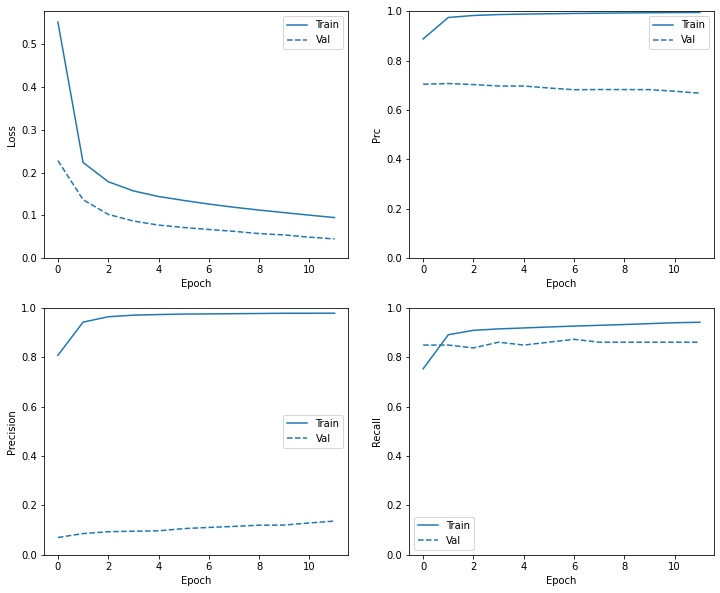

In [50]:
plot_metrics(resampled_history)

### Re-train


Because training is easier on the balanced data, the above training procedure may overfit quickly. 

So break up the epochs to give the `tf.keras.callbacks.EarlyStopping` finer control over when to stop training.

In [51]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000



 1/20 [>.............................] - ETA: 31s - loss: 2.5826 - tp: 162.0000 - fp: 706.0000 - tn: 45791.0000 - fn: 958.0000 - accuracy: 0.9651 - precision: 0.1866 - recall: 0.1446 - auc: 0.7138 - prc: 0.1385


 3/20 [===>..........................] - ETA: 0s - loss: 2.4815 - tp: 383.0000 - fp: 1167.0000 - tn: 47332.0000 - fn: 2831.0000 - accuracy: 0.9227 - precision: 0.2471 - recall: 0.1192 - auc: 0.6945 - prc: 0.1718


 5/20 [======>.......................] - ETA: 0s - loss: 2.4332 - tp: 631.0000 - fp: 1603.0000 - tn: 48879.0000 - fn: 4696.0000 - accuracy: 0.8871 - precision: 0.2825 - recall: 0.1185 - auc: 0.6806 - prc: 0.2040


 7/20 [=========>....................] - ETA: 0s - loss: 2.3681 - tp: 847.0000 - fp: 2047.0000 - tn: 50486.0000 - fn: 6525.0000 - accuracy: 0.8569 - precision: 0.2927 - recall: 0.1149 - auc: 0.6697 - prc: 0.2272


 9/20 [============>.................] - ETA: 0s - loss: 2.3005 - tp: 1131.0000 - fp: 2519.0000 - tn: 52063.0000 - fn: 8288.0000 - accuracy: 0.8311 - precision: 0.3099 - recall: 0.1201 - auc: 0.6617 - prc: 0.2486


11/20 [===============>..............] - ETA: 0s - loss: 2.2388 - tp: 1444.0000 - fp: 2977.0000 - tn: 53679.0000 - fn: 9997.0000 - accuracy: 0.8095 - precision: 0.3266 - recall: 0.1262 - auc: 0.6536 - prc: 0.2658


13/20 [==================>...........] - ETA: 0s - loss: 2.1838 - tp: 1827.0000 - fp: 3458.0000 - tn: 55221.0000 - fn: 11687.0000 - accuracy: 0.7902 - precision: 0.3457 - recall: 0.1352 - auc: 0.6475 - prc: 0.2838


15/20 [=====================>........] - ETA: 0s - loss: 2.1313 - tp: 2223.0000 - fp: 3959.0000 - tn: 56736.0000 - fn: 13371.0000 - accuracy: 0.7728 - precision: 0.3596 - recall: 0.1426 - auc: 0.6424 - prc: 0.2992


17/20 [========================>.....] - ETA: 0s - loss: 2.0813 - tp: 2649.0000 - fp: 4423.0000 - tn: 58323.0000 - fn: 14990.0000 - accuracy: 0.7585 - precision: 0.3746 - recall: 0.1502 - auc: 0.6369 - prc: 0.3127


19/20 [===========================>..] - ETA: 0s - loss: 2.0366 - tp: 3142.0000 - fp: 4911.0000 - tn: 59815.0000 - fn: 16613.0000 - accuracy: 0.7452 - precision: 0.3902 - recall: 0.1590 - auc: 0.6331 - prc: 0.3275


20/20 [==============================] - 3s 73ms/step - loss: 2.0114 - tp: 3382.0000 - fp: 5181.0000 - tn: 60589.0000 - fn: 17377.0000 - accuracy: 0.7393 - precision: 0.3950 - recall: 0.1629 - auc: 0.6308 - prc: 0.3325 - val_loss: 0.4343 - val_tp: 7.0000 - val_fp: 5042.0000 - val_tn: 40441.0000 - val_fn: 79.0000 - val_accuracy: 0.8876 - val_precision: 0.0014 - val_recall: 0.0814 - val_auc: 0.2282 - val_prc: 0.0012


Epoch 2/1000



 1/20 [>.............................] - ETA: 0s - loss: 1.5366 - tp: 275.0000 - fp: 250.0000 - tn: 748.0000 - fn: 775.0000 - accuracy: 0.4995 - precision: 0.5238 - recall: 0.2619 - auc: 0.3778 - prc: 0.4910


 4/20 [=====>........................] - ETA: 0s - loss: 1.4845 - tp: 1137.0000 - fp: 1021.0000 - tn: 3022.0000 - fn: 3012.0000 - accuracy: 0.5077 - precision: 0.5269 - recall: 0.2740 - auc: 0.3960 - prc: 0.4951


 6/20 [========>.....................] - ETA: 0s - loss: 1.4452 - tp: 1758.0000 - fp: 1502.0000 - tn: 4579.0000 - fn: 4449.0000 - accuracy: 0.5157 - precision: 0.5393 - recall: 0.2832 - auc: 0.4068 - prc: 0.5024


 8/20 [===========>..................] - ETA: 0s - loss: 1.3996 - tp: 2432.0000 - fp: 2011.0000 - tn: 6145.0000 - fn: 5796.0000 - accuracy: 0.5235 - precision: 0.5474 - recall: 0.2956 - auc: 0.4191 - prc: 0.5116


10/20 [==============>...............] - ETA: 0s - loss: 1.3729 - tp: 3133.0000 - fp: 2523.0000 - tn: 7670.0000 - fn: 7154.0000 - accuracy: 0.5275 - precision: 0.5539 - recall: 0.3046 - auc: 0.4254 - prc: 0.5196


12/20 [=================>............] - ETA: 0s - loss: 1.3351 - tp: 3890.0000 - fp: 3043.0000 - tn: 9226.0000 - fn: 8417.0000 - accuracy: 0.5337 - precision: 0.5611 - recall: 0.3161 - auc: 0.4362 - prc: 0.5311


14/20 [====================>.........] - ETA: 0s - loss: 1.3038 - tp: 4735.0000 - fp: 3551.0000 - tn: 10734.0000 - fn: 9652.0000 - accuracy: 0.5395 - precision: 0.5714 - recall: 0.3291 - auc: 0.4473 - prc: 0.5414


16/20 [=======================>......] - ETA: 0s - loss: 1.2780 - tp: 5601.0000 - fp: 4056.0000 - tn: 12216.0000 - fn: 10895.0000 - accuracy: 0.5437 - precision: 0.5800 - recall: 0.3395 - auc: 0.4562 - prc: 0.5512


18/20 [==========================>...] - ETA: 0s - loss: 1.2455 - tp: 6505.0000 - fp: 4597.0000 - tn: 13721.0000 - fn: 12041.0000 - accuracy: 0.5487 - precision: 0.5859 - recall: 0.3507 - auc: 0.4662 - prc: 0.5606


20/20 [==============================] - ETA: 0s - loss: 1.2163 - tp: 7466.0000 - fp: 5137.0000 - tn: 15257.0000 - fn: 13100.0000 - accuracy: 0.5548 - precision: 0.5924 - recall: 0.3630 - auc: 0.4763 - prc: 0.5716


20/20 [==============================] - 1s 33ms/step - loss: 1.2163 - tp: 7466.0000 - fp: 5137.0000 - tn: 15257.0000 - fn: 13100.0000 - accuracy: 0.5548 - precision: 0.5924 - recall: 0.3630 - auc: 0.4763 - prc: 0.5716 - val_loss: 0.4539 - val_tp: 36.0000 - val_fp: 5893.0000 - val_tn: 39590.0000 - val_fn: 50.0000 - val_accuracy: 0.8696 - val_precision: 0.0061 - val_recall: 0.4186 - val_auc: 0.6494 - val_prc: 0.0054


Epoch 3/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.9429 - tp: 504.0000 - fp: 272.0000 - tn: 745.0000 - fn: 527.0000 - accuracy: 0.6099 - precision: 0.6495 - recall: 0.4888 - auc: 0.5811 - prc: 0.6719


 4/20 [=====>........................] - ETA: 0s - loss: 0.8955 - tp: 2064.0000 - fp: 1058.0000 - tn: 2994.0000 - fn: 2076.0000 - accuracy: 0.6174 - precision: 0.6611 - recall: 0.4986 - auc: 0.5995 - prc: 0.6925


 6/20 [========>.....................] - ETA: 0s - loss: 0.8726 - tp: 3188.0000 - fp: 1611.0000 - tn: 4467.0000 - fn: 3022.0000 - accuracy: 0.6230 - precision: 0.6643 - recall: 0.5134 - auc: 0.6110 - prc: 0.7024


 8/20 [===========>..................] - ETA: 0s - loss: 0.8482 - tp: 4381.0000 - fp: 2168.0000 - tn: 5924.0000 - fn: 3911.0000 - accuracy: 0.6290 - precision: 0.6690 - recall: 0.5283 - auc: 0.6222 - prc: 0.7115


10/20 [==============>...............] - ETA: 0s - loss: 0.8293 - tp: 5574.0000 - fp: 2685.0000 - tn: 7439.0000 - fn: 4782.0000 - accuracy: 0.6354 - precision: 0.6749 - recall: 0.5382 - auc: 0.6312 - prc: 0.7188


12/20 [=================>............] - ETA: 0s - loss: 0.8098 - tp: 6799.0000 - fp: 3224.0000 - tn: 8968.0000 - fn: 5585.0000 - accuracy: 0.6416 - precision: 0.6783 - recall: 0.5490 - auc: 0.6409 - prc: 0.7255


14/20 [====================>.........] - ETA: 0s - loss: 0.7909 - tp: 8087.0000 - fp: 3810.0000 - tn: 10456.0000 - fn: 6319.0000 - accuracy: 0.6467 - precision: 0.6798 - recall: 0.5614 - auc: 0.6509 - prc: 0.7332


16/20 [=======================>......] - ETA: 0s - loss: 0.7741 - tp: 9426.0000 - fp: 4384.0000 - tn: 11943.0000 - fn: 7015.0000 - accuracy: 0.6521 - precision: 0.6825 - recall: 0.5733 - auc: 0.6604 - prc: 0.7407


18/20 [==========================>...] - ETA: 0s - loss: 0.7568 - tp: 10808.0000 - fp: 4943.0000 - tn: 13429.0000 - fn: 7684.0000 - accuracy: 0.6575 - precision: 0.6862 - recall: 0.5845 - auc: 0.6703 - prc: 0.7490


20/20 [==============================] - ETA: 0s - loss: 0.7406 - tp: 12289.0000 - fp: 5509.0000 - tn: 14872.0000 - fn: 8290.0000 - accuracy: 0.6631 - precision: 0.6905 - recall: 0.5972 - auc: 0.6803 - prc: 0.7580


20/20 [==============================] - 1s 33ms/step - loss: 0.7406 - tp: 12289.0000 - fp: 5509.0000 - tn: 14872.0000 - fn: 8290.0000 - accuracy: 0.6631 - precision: 0.6905 - recall: 0.5972 - auc: 0.6803 - prc: 0.7580 - val_loss: 0.4611 - val_tp: 75.0000 - val_fp: 6273.0000 - val_tn: 39210.0000 - val_fn: 11.0000 - val_accuracy: 0.8621 - val_precision: 0.0118 - val_recall: 0.8721 - val_auc: 0.9293 - val_prc: 0.4539


Epoch 4/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.5821 - tp: 721.0000 - fp: 254.0000 - tn: 760.0000 - fn: 313.0000 - accuracy: 0.7231 - precision: 0.7395 - recall: 0.6973 - auc: 0.7748 - prc: 0.8360


 4/20 [=====>........................] - ETA: 0s - loss: 0.5688 - tp: 2978.0000 - fp: 1080.0000 - tn: 2982.0000 - fn: 1152.0000 - accuracy: 0.7275 - precision: 0.7339 - recall: 0.7211 - auc: 0.7874 - prc: 0.8435


 6/20 [========>.....................] - ETA: 0s - loss: 0.5557 - tp: 4541.0000 - fp: 1591.0000 - tn: 4492.0000 - fn: 1664.0000 - accuracy: 0.7351 - precision: 0.7405 - recall: 0.7318 - auc: 0.7962 - prc: 0.8510


 8/20 [===========>..................] - ETA: 0s - loss: 0.5452 - tp: 6121.0000 - fp: 2143.0000 - tn: 5986.0000 - fn: 2134.0000 - accuracy: 0.7390 - precision: 0.7407 - recall: 0.7415 - auc: 0.8030 - prc: 0.8558


10/20 [==============>...............] - ETA: 0s - loss: 0.5357 - tp: 7705.0000 - fp: 2672.0000 - tn: 7510.0000 - fn: 2593.0000 - accuracy: 0.7429 - precision: 0.7425 - recall: 0.7482 - auc: 0.8097 - prc: 0.8603


12/20 [=================>............] - ETA: 0s - loss: 0.5287 - tp: 9301.0000 - fp: 3230.0000 - tn: 9020.0000 - fn: 3025.0000 - accuracy: 0.7455 - precision: 0.7422 - recall: 0.7546 - auc: 0.8148 - prc: 0.8634


14/20 [====================>.........] - ETA: 0s - loss: 0.5240 - tp: 10905.0000 - fp: 3796.0000 - tn: 10497.0000 - fn: 3474.0000 - accuracy: 0.7464 - precision: 0.7418 - recall: 0.7584 - auc: 0.8179 - prc: 0.8663


16/20 [=======================>......] - ETA: 0s - loss: 0.5176 - tp: 12571.0000 - fp: 4317.0000 - tn: 11989.0000 - fn: 3891.0000 - accuracy: 0.7495 - precision: 0.7444 - recall: 0.7636 - auc: 0.8222 - prc: 0.8698


18/20 [==========================>...] - ETA: 0s - loss: 0.5124 - tp: 14220.0000 - fp: 4826.0000 - tn: 13511.0000 - fn: 4307.0000 - accuracy: 0.7523 - precision: 0.7466 - recall: 0.7675 - auc: 0.8260 - prc: 0.8730


20/20 [==============================] - ETA: 0s - loss: 0.5071 - tp: 15891.0000 - fp: 5370.0000 - tn: 15013.0000 - fn: 4686.0000 - accuracy: 0.7545 - precision: 0.7474 - recall: 0.7723 - auc: 0.8298 - prc: 0.8757


20/20 [==============================] - 1s 33ms/step - loss: 0.5071 - tp: 15891.0000 - fp: 5370.0000 - tn: 15013.0000 - fn: 4686.0000 - accuracy: 0.7545 - precision: 0.7474 - recall: 0.7723 - auc: 0.8298 - prc: 0.8757 - val_loss: 0.4451 - val_tp: 78.0000 - val_fp: 5505.0000 - val_tn: 39978.0000 - val_fn: 8.0000 - val_accuracy: 0.8790 - val_precision: 0.0140 - val_recall: 0.9070 - val_auc: 0.9443 - val_prc: 0.6777


Epoch 5/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.4600 - tp: 829.0000 - fp: 249.0000 - tn: 775.0000 - fn: 195.0000 - accuracy: 0.7832 - precision: 0.7690 - recall: 0.8096 - auc: 0.8617 - prc: 0.8969


 4/20 [=====>........................] - ETA: 0s - loss: 0.4547 - tp: 3368.0000 - fp: 1077.0000 - tn: 3003.0000 - fn: 744.0000 - accuracy: 0.7777 - precision: 0.7577 - recall: 0.8191 - auc: 0.8665 - prc: 0.9041


 6/20 [========>.....................] - ETA: 0s - loss: 0.4522 - tp: 5067.0000 - fp: 1607.0000 - tn: 4510.0000 - fn: 1104.0000 - accuracy: 0.7794 - precision: 0.7592 - recall: 0.8211 - auc: 0.8679 - prc: 0.9054


 8/20 [===========>..................] - ETA: 0s - loss: 0.4476 - tp: 6741.0000 - fp: 2133.0000 - tn: 6074.0000 - fn: 1436.0000 - accuracy: 0.7822 - precision: 0.7596 - recall: 0.8244 - auc: 0.8715 - prc: 0.9073


10/20 [==============>...............] - ETA: 0s - loss: 0.4426 - tp: 8435.0000 - fp: 2608.0000 - tn: 7678.0000 - fn: 1759.0000 - accuracy: 0.7868 - precision: 0.7638 - recall: 0.8274 - auc: 0.8744 - prc: 0.9093


12/20 [=================>............] - ETA: 0s - loss: 0.4401 - tp: 10102.0000 - fp: 3123.0000 - tn: 9234.0000 - fn: 2117.0000 - accuracy: 0.7868 - precision: 0.7639 - recall: 0.8267 - auc: 0.8754 - prc: 0.9098


14/20 [====================>.........] - ETA: 0s - loss: 0.4363 - tp: 11788.0000 - fp: 3628.0000 - tn: 10836.0000 - fn: 2420.0000 - accuracy: 0.7891 - precision: 0.7647 - recall: 0.8297 - auc: 0.8779 - prc: 0.9112


16/20 [=======================>......] - ETA: 0s - loss: 0.4332 - tp: 13540.0000 - fp: 4118.0000 - tn: 12371.0000 - fn: 2739.0000 - accuracy: 0.7907 - precision: 0.7668 - recall: 0.8317 - auc: 0.8796 - prc: 0.9129


18/20 [==========================>...] - ETA: 0s - loss: 0.4305 - tp: 15299.0000 - fp: 4590.0000 - tn: 13921.0000 - fn: 3054.0000 - accuracy: 0.7926 - precision: 0.7692 - recall: 0.8336 - auc: 0.8813 - prc: 0.9142


20/20 [==============================] - ETA: 0s - loss: 0.4284 - tp: 17046.0000 - fp: 5072.0000 - tn: 15496.0000 - fn: 3346.0000 - accuracy: 0.7945 - precision: 0.7707 - recall: 0.8359 - auc: 0.8827 - prc: 0.9151


20/20 [==============================] - 1s 34ms/step - loss: 0.4284 - tp: 17046.0000 - fp: 5072.0000 - tn: 15496.0000 - fn: 3346.0000 - accuracy: 0.7945 - precision: 0.7707 - recall: 0.8359 - auc: 0.8827 - prc: 0.9151 - val_loss: 0.4140 - val_tp: 77.0000 - val_fp: 4338.0000 - val_tn: 41145.0000 - val_fn: 9.0000 - val_accuracy: 0.9046 - val_precision: 0.0174 - val_recall: 0.8953 - val_auc: 0.9463 - val_prc: 0.6903


Epoch 6/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.4119 - tp: 867.0000 - fp: 221.0000 - tn: 793.0000 - fn: 167.0000 - accuracy: 0.8105 - precision: 0.7969 - recall: 0.8385 - auc: 0.8922 - prc: 0.9220


 4/20 [=====>........................] - ETA: 0s - loss: 0.4009 - tp: 3499.0000 - fp: 885.0000 - tn: 3178.0000 - fn: 630.0000 - accuracy: 0.8151 - precision: 0.7981 - recall: 0.8474 - auc: 0.8982 - prc: 0.9270


 6/20 [========>.....................] - ETA: 0s - loss: 0.3980 - tp: 5291.0000 - fp: 1357.0000 - tn: 4729.0000 - fn: 911.0000 - accuracy: 0.8154 - precision: 0.7959 - recall: 0.8531 - auc: 0.9007 - prc: 0.9294


 8/20 [===========>..................] - ETA: 0s - loss: 0.4002 - tp: 6984.0000 - fp: 1835.0000 - tn: 6332.0000 - fn: 1233.0000 - accuracy: 0.8127 - precision: 0.7919 - recall: 0.8499 - auc: 0.8989 - prc: 0.9274


10/20 [==============>...............] - ETA: 0s - loss: 0.3966 - tp: 8691.0000 - fp: 2276.0000 - tn: 8008.0000 - fn: 1505.0000 - accuracy: 0.8154 - precision: 0.7925 - recall: 0.8524 - auc: 0.9014 - prc: 0.9285


12/20 [=================>............] - ETA: 0s - loss: 0.3935 - tp: 10443.0000 - fp: 2706.0000 - tn: 9649.0000 - fn: 1778.0000 - accuracy: 0.8175 - precision: 0.7942 - recall: 0.8545 - auc: 0.9032 - prc: 0.9296


14/20 [====================>.........] - ETA: 0s - loss: 0.3910 - tp: 12209.0000 - fp: 3145.0000 - tn: 11258.0000 - fn: 2060.0000 - accuracy: 0.8185 - precision: 0.7952 - recall: 0.8556 - auc: 0.9043 - prc: 0.9306


16/20 [=======================>......] - ETA: 0s - loss: 0.3890 - tp: 13986.0000 - fp: 3554.0000 - tn: 12878.0000 - fn: 2350.0000 - accuracy: 0.8198 - precision: 0.7974 - recall: 0.8561 - auc: 0.9050 - prc: 0.9313


18/20 [==========================>...] - ETA: 0s - loss: 0.3863 - tp: 15809.0000 - fp: 3972.0000 - tn: 14472.0000 - fn: 2611.0000 - accuracy: 0.8214 - precision: 0.7992 - recall: 0.8583 - auc: 0.9065 - prc: 0.9326


20/20 [==============================] - ETA: 0s - loss: 0.3836 - tp: 17606.0000 - fp: 4362.0000 - tn: 16113.0000 - fn: 2879.0000 - accuracy: 0.8232 - precision: 0.8014 - recall: 0.8595 - auc: 0.9080 - prc: 0.9336


20/20 [==============================] - 1s 33ms/step - loss: 0.3836 - tp: 17606.0000 - fp: 4362.0000 - tn: 16113.0000 - fn: 2879.0000 - accuracy: 0.8232 - precision: 0.8014 - recall: 0.8595 - auc: 0.9080 - prc: 0.9336 - val_loss: 0.3824 - val_tp: 77.0000 - val_fp: 3314.0000 - val_tn: 42169.0000 - val_fn: 9.0000 - val_accuracy: 0.9271 - val_precision: 0.0227 - val_recall: 0.8953 - val_auc: 0.9475 - val_prc: 0.6752


Epoch 7/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.3749 - tp: 894.0000 - fp: 212.0000 - tn: 797.0000 - fn: 145.0000 - accuracy: 0.8257 - precision: 0.8083 - recall: 0.8604 - auc: 0.9120 - prc: 0.9371


 4/20 [=====>........................] - ETA: 0s - loss: 0.3689 - tp: 3585.0000 - fp: 805.0000 - tn: 3241.0000 - fn: 561.0000 - accuracy: 0.8333 - precision: 0.8166 - recall: 0.8647 - auc: 0.9143 - prc: 0.9387


 6/20 [========>.....................] - ETA: 0s - loss: 0.3682 - tp: 5378.0000 - fp: 1206.0000 - tn: 4873.0000 - fn: 831.0000 - accuracy: 0.8342 - precision: 0.8168 - recall: 0.8662 - auc: 0.9150 - prc: 0.9395


 8/20 [===========>..................] - ETA: 0s - loss: 0.3652 - tp: 7149.0000 - fp: 1605.0000 - tn: 6527.0000 - fn: 1103.0000 - accuracy: 0.8347 - precision: 0.8167 - recall: 0.8663 - auc: 0.9170 - prc: 0.9405


10/20 [==============>...............] - ETA: 0s - loss: 0.3638 - tp: 8888.0000 - fp: 1969.0000 - tn: 8243.0000 - fn: 1380.0000 - accuracy: 0.8365 - precision: 0.8186 - recall: 0.8656 - auc: 0.9175 - prc: 0.9408


12/20 [=================>............] - ETA: 0s - loss: 0.3617 - tp: 10700.0000 - fp: 2314.0000 - tn: 9917.0000 - fn: 1645.0000 - accuracy: 0.8389 - precision: 0.8222 - recall: 0.8667 - auc: 0.9183 - prc: 0.9416


14/20 [====================>.........] - ETA: 0s - loss: 0.3625 - tp: 12443.0000 - fp: 2717.0000 - tn: 11587.0000 - fn: 1925.0000 - accuracy: 0.8381 - precision: 0.8208 - recall: 0.8660 - auc: 0.9180 - prc: 0.9412


16/20 [=======================>......] - ETA: 0s - loss: 0.3608 - tp: 14225.0000 - fp: 3111.0000 - tn: 13271.0000 - fn: 2161.0000 - accuracy: 0.8391 - precision: 0.8205 - recall: 0.8681 - auc: 0.9191 - prc: 0.9419


18/20 [==========================>...] - ETA: 0s - loss: 0.3593 - tp: 16008.0000 - fp: 3509.0000 - tn: 14923.0000 - fn: 2424.0000 - accuracy: 0.8391 - precision: 0.8202 - recall: 0.8685 - auc: 0.9198 - prc: 0.9423


20/20 [==============================] - ETA: 0s - loss: 0.3574 - tp: 17856.0000 - fp: 3894.0000 - tn: 16553.0000 - fn: 2657.0000 - accuracy: 0.8401 - precision: 0.8210 - recall: 0.8705 - auc: 0.9208 - prc: 0.9432


20/20 [==============================] - 1s 34ms/step - loss: 0.3574 - tp: 17856.0000 - fp: 3894.0000 - tn: 16553.0000 - fn: 2657.0000 - accuracy: 0.8401 - precision: 0.8210 - recall: 0.8705 - auc: 0.9208 - prc: 0.9432 - val_loss: 0.3538 - val_tp: 76.0000 - val_fp: 2592.0000 - val_tn: 42891.0000 - val_fn: 10.0000 - val_accuracy: 0.9429 - val_precision: 0.0285 - val_recall: 0.8837 - val_auc: 0.9486 - val_prc: 0.6819


Epoch 8/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.3619 - tp: 853.0000 - fp: 177.0000 - tn: 874.0000 - fn: 144.0000 - accuracy: 0.8433 - precision: 0.8282 - recall: 0.8556 - auc: 0.9169 - prc: 0.9381


 4/20 [=====>........................] - ETA: 0s - loss: 0.3539 - tp: 3514.0000 - fp: 739.0000 - tn: 3398.0000 - fn: 541.0000 - accuracy: 0.8438 - precision: 0.8262 - recall: 0.8666 - auc: 0.9209 - prc: 0.9423


 6/20 [========>.....................] - ETA: 0s - loss: 0.3505 - tp: 5274.0000 - fp: 1097.0000 - tn: 5125.0000 - fn: 792.0000 - accuracy: 0.8463 - precision: 0.8278 - recall: 0.8694 - auc: 0.9230 - prc: 0.9438


 8/20 [===========>..................] - ETA: 0s - loss: 0.3465 - tp: 7079.0000 - fp: 1466.0000 - tn: 6797.0000 - fn: 1042.0000 - accuracy: 0.8469 - precision: 0.8284 - recall: 0.8717 - auc: 0.9249 - prc: 0.9456


10/20 [==============>...............] - ETA: 0s - loss: 0.3467 - tp: 8877.0000 - fp: 1849.0000 - tn: 8446.0000 - fn: 1308.0000 - accuracy: 0.8458 - precision: 0.8276 - recall: 0.8716 - auc: 0.9239 - prc: 0.9454


12/20 [=================>............] - ETA: 0s - loss: 0.3453 - tp: 10644.0000 - fp: 2205.0000 - tn: 10173.0000 - fn: 1554.0000 - accuracy: 0.8470 - precision: 0.8284 - recall: 0.8726 - auc: 0.9248 - prc: 0.9459


14/20 [====================>.........] - ETA: 0s - loss: 0.3431 - tp: 12424.0000 - fp: 2532.0000 - tn: 11905.0000 - fn: 1811.0000 - accuracy: 0.8485 - precision: 0.8307 - recall: 0.8728 - auc: 0.9256 - prc: 0.9464


16/20 [=======================>......] - ETA: 0s - loss: 0.3419 - tp: 14212.0000 - fp: 2858.0000 - tn: 13609.0000 - fn: 2089.0000 - accuracy: 0.8490 - precision: 0.8326 - recall: 0.8718 - auc: 0.9261 - prc: 0.9468


18/20 [==========================>...] - ETA: 0s - loss: 0.3398 - tp: 15991.0000 - fp: 3181.0000 - tn: 15333.0000 - fn: 2359.0000 - accuracy: 0.8497 - precision: 0.8341 - recall: 0.8714 - auc: 0.9273 - prc: 0.9476


20/20 [==============================] - ETA: 0s - loss: 0.3377 - tp: 17766.0000 - fp: 3483.0000 - tn: 17067.0000 - fn: 2644.0000 - accuracy: 0.8504 - precision: 0.8361 - recall: 0.8705 - auc: 0.9280 - prc: 0.9481


20/20 [==============================] - 1s 34ms/step - loss: 0.3377 - tp: 17766.0000 - fp: 3483.0000 - tn: 17067.0000 - fn: 2644.0000 - accuracy: 0.8504 - precision: 0.8361 - recall: 0.8705 - auc: 0.9280 - prc: 0.9481 - val_loss: 0.3271 - val_tp: 76.0000 - val_fp: 2047.0000 - val_tn: 43436.0000 - val_fn: 10.0000 - val_accuracy: 0.9549 - val_precision: 0.0358 - val_recall: 0.8837 - val_auc: 0.9497 - val_prc: 0.6910


Epoch 9/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.3367 - tp: 857.0000 - fp: 143.0000 - tn: 880.0000 - fn: 168.0000 - accuracy: 0.8481 - precision: 0.8570 - recall: 0.8361 - auc: 0.9248 - prc: 0.9463


 4/20 [=====>........................] - ETA: 0s - loss: 0.3318 - tp: 3495.0000 - fp: 621.0000 - tn: 3506.0000 - fn: 570.0000 - accuracy: 0.8546 - precision: 0.8491 - recall: 0.8598 - auc: 0.9313 - prc: 0.9500


 6/20 [========>.....................] - ETA: 0s - loss: 0.3276 - tp: 5279.0000 - fp: 911.0000 - tn: 5259.0000 - fn: 839.0000 - accuracy: 0.8576 - precision: 0.8528 - recall: 0.8629 - auc: 0.9328 - prc: 0.9515


 8/20 [===========>..................] - ETA: 0s - loss: 0.3255 - tp: 7012.0000 - fp: 1175.0000 - tn: 7073.0000 - fn: 1124.0000 - accuracy: 0.8597 - precision: 0.8565 - recall: 0.8618 - auc: 0.9329 - prc: 0.9515


10/20 [==============>...............] - ETA: 0s - loss: 0.3233 - tp: 8860.0000 - fp: 1474.0000 - tn: 8749.0000 - fn: 1397.0000 - accuracy: 0.8598 - precision: 0.8574 - recall: 0.8638 - auc: 0.9343 - prc: 0.9529


12/20 [=================>............] - ETA: 0s - loss: 0.3227 - tp: 10578.0000 - fp: 1787.0000 - tn: 10540.0000 - fn: 1671.0000 - accuracy: 0.8593 - precision: 0.8555 - recall: 0.8636 - auc: 0.9345 - prc: 0.9526


14/20 [====================>.........] - ETA: 0s - loss: 0.3221 - tp: 12371.0000 - fp: 2073.0000 - tn: 12258.0000 - fn: 1970.0000 - accuracy: 0.8590 - precision: 0.8565 - recall: 0.8626 - auc: 0.9346 - prc: 0.9528


16/20 [=======================>......] - ETA: 0s - loss: 0.3199 - tp: 14208.0000 - fp: 2312.0000 - tn: 14013.0000 - fn: 2235.0000 - accuracy: 0.8612 - precision: 0.8600 - recall: 0.8641 - auc: 0.9355 - prc: 0.9537


18/20 [==========================>...] - ETA: 0s - loss: 0.3204 - tp: 15950.0000 - fp: 2599.0000 - tn: 15779.0000 - fn: 2536.0000 - accuracy: 0.8607 - precision: 0.8599 - recall: 0.8628 - auc: 0.9352 - prc: 0.9534


20/20 [==============================] - ETA: 0s - loss: 0.3188 - tp: 17749.0000 - fp: 2855.0000 - tn: 17547.0000 - fn: 2809.0000 - accuracy: 0.8617 - precision: 0.8614 - recall: 0.8634 - auc: 0.9360 - prc: 0.9539


20/20 [==============================] - 1s 34ms/step - loss: 0.3188 - tp: 17749.0000 - fp: 2855.0000 - tn: 17547.0000 - fn: 2809.0000 - accuracy: 0.8617 - precision: 0.8614 - recall: 0.8634 - auc: 0.9360 - prc: 0.9539 - val_loss: 0.3051 - val_tp: 74.0000 - val_fp: 1657.0000 - val_tn: 43826.0000 - val_fn: 12.0000 - val_accuracy: 0.9634 - val_precision: 0.0427 - val_recall: 0.8605 - val_auc: 0.9514 - val_prc: 0.7022


Epoch 10/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.3219 - tp: 879.0000 - fp: 140.0000 - tn: 886.0000 - fn: 143.0000 - accuracy: 0.8618 - precision: 0.8626 - recall: 0.8601 - auc: 0.9328 - prc: 0.9528


 4/20 [=====>........................] - ETA: 0s - loss: 0.3100 - tp: 3506.0000 - fp: 548.0000 - tn: 3590.0000 - fn: 548.0000 - accuracy: 0.8662 - precision: 0.8648 - recall: 0.8648 - auc: 0.9378 - prc: 0.9548


 6/20 [========>.....................] - ETA: 0s - loss: 0.3082 - tp: 5306.0000 - fp: 808.0000 - tn: 5344.0000 - fn: 830.0000 - accuracy: 0.8667 - precision: 0.8678 - recall: 0.8647 - auc: 0.9386 - prc: 0.9557


 8/20 [===========>..................] - ETA: 0s - loss: 0.3055 - tp: 7106.0000 - fp: 1072.0000 - tn: 7111.0000 - fn: 1095.0000 - accuracy: 0.8677 - precision: 0.8689 - recall: 0.8665 - auc: 0.9400 - prc: 0.9566


10/20 [==============>...............] - ETA: 0s - loss: 0.3071 - tp: 8854.0000 - fp: 1335.0000 - tn: 8914.0000 - fn: 1377.0000 - accuracy: 0.8676 - precision: 0.8690 - recall: 0.8654 - auc: 0.9391 - prc: 0.9558


12/20 [=================>............] - ETA: 0s - loss: 0.3074 - tp: 10596.0000 - fp: 1588.0000 - tn: 10728.0000 - fn: 1664.0000 - accuracy: 0.8677 - precision: 0.8697 - recall: 0.8643 - auc: 0.9388 - prc: 0.9556


14/20 [====================>.........] - ETA: 0s - loss: 0.3069 - tp: 12391.0000 - fp: 1852.0000 - tn: 12491.0000 - fn: 1938.0000 - accuracy: 0.8678 - precision: 0.8700 - recall: 0.8647 - auc: 0.9391 - prc: 0.9560


16/20 [=======================>......] - ETA: 0s - loss: 0.3059 - tp: 14197.0000 - fp: 2093.0000 - tn: 14265.0000 - fn: 2213.0000 - accuracy: 0.8686 - precision: 0.8715 - recall: 0.8651 - auc: 0.9396 - prc: 0.9564


18/20 [==========================>...] - ETA: 0s - loss: 0.3053 - tp: 15954.0000 - fp: 2350.0000 - tn: 16063.0000 - fn: 2497.0000 - accuracy: 0.8685 - precision: 0.8716 - recall: 0.8647 - auc: 0.9397 - prc: 0.9565


20/20 [==============================] - ETA: 0s - loss: 0.3046 - tp: 17772.0000 - fp: 2599.0000 - tn: 17841.0000 - fn: 2748.0000 - accuracy: 0.8695 - precision: 0.8724 - recall: 0.8661 - auc: 0.9402 - prc: 0.9570


20/20 [==============================] - 1s 33ms/step - loss: 0.3046 - tp: 17772.0000 - fp: 2599.0000 - tn: 17841.0000 - fn: 2748.0000 - accuracy: 0.8695 - precision: 0.8724 - recall: 0.8661 - auc: 0.9402 - prc: 0.9570 - val_loss: 0.2860 - val_tp: 74.0000 - val_fp: 1398.0000 - val_tn: 44085.0000 - val_fn: 12.0000 - val_accuracy: 0.9691 - val_precision: 0.0503 - val_recall: 0.8605 - val_auc: 0.9527 - val_prc: 0.6997


Epoch 11/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.3010 - tp: 878.0000 - fp: 119.0000 - tn: 928.0000 - fn: 123.0000 - accuracy: 0.8818 - precision: 0.8806 - recall: 0.8771 - auc: 0.9450 - prc: 0.9594


 4/20 [=====>........................] - ETA: 0s - loss: 0.2983 - tp: 3544.0000 - fp: 490.0000 - tn: 3631.0000 - fn: 527.0000 - accuracy: 0.8759 - precision: 0.8785 - recall: 0.8705 - auc: 0.9442 - prc: 0.9592


 6/20 [========>.....................] - ETA: 0s - loss: 0.2975 - tp: 5337.0000 - fp: 735.0000 - tn: 5430.0000 - fn: 786.0000 - accuracy: 0.8762 - precision: 0.8790 - recall: 0.8716 - auc: 0.9444 - prc: 0.9594


 8/20 [===========>..................] - ETA: 0s - loss: 0.2949 - tp: 7073.0000 - fp: 962.0000 - tn: 7296.0000 - fn: 1053.0000 - accuracy: 0.8770 - precision: 0.8803 - recall: 0.8704 - auc: 0.9450 - prc: 0.9596


10/20 [==============>...............] - ETA: 0s - loss: 0.2948 - tp: 8834.0000 - fp: 1211.0000 - tn: 9112.0000 - fn: 1323.0000 - accuracy: 0.8763 - precision: 0.8794 - recall: 0.8697 - auc: 0.9449 - prc: 0.9595


12/20 [=================>............] - ETA: 0s - loss: 0.2938 - tp: 10600.0000 - fp: 1418.0000 - tn: 10947.0000 - fn: 1611.0000 - accuracy: 0.8767 - precision: 0.8820 - recall: 0.8681 - auc: 0.9449 - prc: 0.9595


14/20 [====================>.........] - ETA: 0s - loss: 0.2936 - tp: 12387.0000 - fp: 1656.0000 - tn: 12749.0000 - fn: 1880.0000 - accuracy: 0.8767 - precision: 0.8821 - recall: 0.8682 - auc: 0.9450 - prc: 0.9597


16/20 [=======================>......] - ETA: 0s - loss: 0.2940 - tp: 14132.0000 - fp: 1889.0000 - tn: 14598.0000 - fn: 2149.0000 - accuracy: 0.8768 - precision: 0.8821 - recall: 0.8680 - auc: 0.9447 - prc: 0.9595


18/20 [==========================>...] - ETA: 0s - loss: 0.2949 - tp: 15879.0000 - fp: 2125.0000 - tn: 16446.0000 - fn: 2414.0000 - accuracy: 0.8769 - precision: 0.8820 - recall: 0.8680 - auc: 0.9442 - prc: 0.9592


20/20 [==============================] - ETA: 0s - loss: 0.2937 - tp: 17673.0000 - fp: 2352.0000 - tn: 18273.0000 - fn: 2662.0000 - accuracy: 0.8776 - precision: 0.8825 - recall: 0.8691 - auc: 0.9447 - prc: 0.9595


20/20 [==============================] - 1s 34ms/step - loss: 0.2937 - tp: 17673.0000 - fp: 2352.0000 - tn: 18273.0000 - fn: 2662.0000 - accuracy: 0.8776 - precision: 0.8825 - recall: 0.8691 - auc: 0.9447 - prc: 0.9595 - val_loss: 0.2687 - val_tp: 73.0000 - val_fp: 1235.0000 - val_tn: 44248.0000 - val_fn: 13.0000 - val_accuracy: 0.9726 - val_precision: 0.0558 - val_recall: 0.8488 - val_auc: 0.9534 - val_prc: 0.7066


Epoch 12/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2793 - tp: 901.0000 - fp: 107.0000 - tn: 907.0000 - fn: 133.0000 - accuracy: 0.8828 - precision: 0.8938 - recall: 0.8714 - auc: 0.9500 - prc: 0.9643


 4/20 [=====>........................] - ETA: 0s - loss: 0.2868 - tp: 3568.0000 - fp: 444.0000 - tn: 3646.0000 - fn: 534.0000 - accuracy: 0.8806 - precision: 0.8893 - recall: 0.8698 - auc: 0.9468 - prc: 0.9616


 6/20 [========>.....................] - ETA: 0s - loss: 0.2855 - tp: 5380.0000 - fp: 641.0000 - tn: 5457.0000 - fn: 810.0000 - accuracy: 0.8819 - precision: 0.8935 - recall: 0.8691 - auc: 0.9469 - prc: 0.9619


 8/20 [===========>..................] - ETA: 0s - loss: 0.2840 - tp: 7131.0000 - fp: 858.0000 - tn: 7323.0000 - fn: 1072.0000 - accuracy: 0.8822 - precision: 0.8926 - recall: 0.8693 - auc: 0.9475 - prc: 0.9618


10/20 [==============>...............] - ETA: 0s - loss: 0.2844 - tp: 8858.0000 - fp: 1065.0000 - tn: 9214.0000 - fn: 1343.0000 - accuracy: 0.8824 - precision: 0.8927 - recall: 0.8683 - auc: 0.9473 - prc: 0.9614


12/20 [=================>............] - ETA: 0s - loss: 0.2837 - tp: 10627.0000 - fp: 1292.0000 - tn: 11053.0000 - fn: 1604.0000 - accuracy: 0.8822 - precision: 0.8916 - recall: 0.8689 - auc: 0.9474 - prc: 0.9614


14/20 [====================>.........] - ETA: 0s - loss: 0.2835 - tp: 12342.0000 - fp: 1509.0000 - tn: 12971.0000 - fn: 1850.0000 - accuracy: 0.8828 - precision: 0.8911 - recall: 0.8696 - auc: 0.9475 - prc: 0.9612


16/20 [=======================>......] - ETA: 0s - loss: 0.2828 - tp: 14151.0000 - fp: 1716.0000 - tn: 14796.0000 - fn: 2105.0000 - accuracy: 0.8834 - precision: 0.8919 - recall: 0.8705 - auc: 0.9477 - prc: 0.9616


18/20 [==========================>...] - ETA: 0s - loss: 0.2821 - tp: 15924.0000 - fp: 1923.0000 - tn: 16677.0000 - fn: 2340.0000 - accuracy: 0.8844 - precision: 0.8923 - recall: 0.8719 - auc: 0.9482 - prc: 0.9619


20/20 [==============================] - ETA: 0s - loss: 0.2813 - tp: 17721.0000 - fp: 2109.0000 - tn: 18523.0000 - fn: 2607.0000 - accuracy: 0.8849 - precision: 0.8936 - recall: 0.8718 - auc: 0.9485 - prc: 0.9621


20/20 [==============================] - 1s 34ms/step - loss: 0.2813 - tp: 17721.0000 - fp: 2109.0000 - tn: 18523.0000 - fn: 2607.0000 - accuracy: 0.8849 - precision: 0.8936 - recall: 0.8718 - auc: 0.9485 - prc: 0.9621 - val_loss: 0.2524 - val_tp: 73.0000 - val_fp: 1098.0000 - val_tn: 44385.0000 - val_fn: 13.0000 - val_accuracy: 0.9756 - val_precision: 0.0623 - val_recall: 0.8488 - val_auc: 0.9539 - val_prc: 0.7094


Epoch 13/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2655 - tp: 905.0000 - fp: 92.0000 - tn: 925.0000 - fn: 126.0000 - accuracy: 0.8936 - precision: 0.9077 - recall: 0.8778 - auc: 0.9543 - prc: 0.9670


 4/20 [=====>........................] - ETA: 0s - loss: 0.2697 - tp: 3671.0000 - fp: 378.0000 - tn: 3642.0000 - fn: 501.0000 - accuracy: 0.8927 - precision: 0.9066 - recall: 0.8799 - auc: 0.9525 - prc: 0.9666


 6/20 [========>.....................] - ETA: 0s - loss: 0.2698 - tp: 5497.0000 - fp: 574.0000 - tn: 5461.0000 - fn: 756.0000 - accuracy: 0.8918 - precision: 0.9055 - recall: 0.8791 - auc: 0.9528 - prc: 0.9667


 8/20 [===========>..................] - ETA: 0s - loss: 0.2710 - tp: 7299.0000 - fp: 764.0000 - tn: 7293.0000 - fn: 1028.0000 - accuracy: 0.8906 - precision: 0.9052 - recall: 0.8765 - auc: 0.9520 - prc: 0.9659


10/20 [==============>...............] - ETA: 0s - loss: 0.2714 - tp: 9071.0000 - fp: 976.0000 - tn: 9158.0000 - fn: 1275.0000 - accuracy: 0.8901 - precision: 0.9029 - recall: 0.8768 - auc: 0.9520 - prc: 0.9656


12/20 [=================>............] - ETA: 0s - loss: 0.2707 - tp: 10864.0000 - fp: 1141.0000 - tn: 11043.0000 - fn: 1528.0000 - accuracy: 0.8914 - precision: 0.9050 - recall: 0.8767 - auc: 0.9521 - prc: 0.9656


14/20 [====================>.........] - ETA: 0s - loss: 0.2711 - tp: 12676.0000 - fp: 1331.0000 - tn: 12887.0000 - fn: 1778.0000 - accuracy: 0.8916 - precision: 0.9050 - recall: 0.8770 - auc: 0.9520 - prc: 0.9653


16/20 [=======================>......] - ETA: 0s - loss: 0.2720 - tp: 14443.0000 - fp: 1519.0000 - tn: 14752.0000 - fn: 2054.0000 - accuracy: 0.8910 - precision: 0.9048 - recall: 0.8755 - auc: 0.9516 - prc: 0.9649


18/20 [==========================>...] - ETA: 0s - loss: 0.2713 - tp: 16250.0000 - fp: 1700.0000 - tn: 16610.0000 - fn: 2304.0000 - accuracy: 0.8914 - precision: 0.9053 - recall: 0.8758 - auc: 0.9518 - prc: 0.9651


20/20 [==============================] - ETA: 0s - loss: 0.2706 - tp: 18031.0000 - fp: 1869.0000 - tn: 18502.0000 - fn: 2558.0000 - accuracy: 0.8919 - precision: 0.9061 - recall: 0.8758 - auc: 0.9520 - prc: 0.9652


20/20 [==============================] - 1s 36ms/step - loss: 0.2706 - tp: 18031.0000 - fp: 1869.0000 - tn: 18502.0000 - fn: 2558.0000 - accuracy: 0.8919 - precision: 0.9061 - recall: 0.8758 - auc: 0.9520 - prc: 0.9652 - val_loss: 0.2395 - val_tp: 73.0000 - val_fp: 1037.0000 - val_tn: 44446.0000 - val_fn: 13.0000 - val_accuracy: 0.9770 - val_precision: 0.0658 - val_recall: 0.8488 - val_auc: 0.9549 - val_prc: 0.7119


Epoch 14/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2747 - tp: 906.0000 - fp: 103.0000 - tn: 921.0000 - fn: 118.0000 - accuracy: 0.8921 - precision: 0.8979 - recall: 0.8848 - auc: 0.9525 - prc: 0.9658


 4/20 [=====>........................] - ETA: 0s - loss: 0.2765 - tp: 3610.0000 - fp: 387.0000 - tn: 3674.0000 - fn: 521.0000 - accuracy: 0.8892 - precision: 0.9032 - recall: 0.8739 - auc: 0.9498 - prc: 0.9645


 6/20 [========>.....................] - ETA: 0s - loss: 0.2711 - tp: 5416.0000 - fp: 554.0000 - tn: 5555.0000 - fn: 763.0000 - accuracy: 0.8928 - precision: 0.9072 - recall: 0.8765 - auc: 0.9516 - prc: 0.9654


 8/20 [===========>..................] - ETA: 0s - loss: 0.2716 - tp: 7259.0000 - fp: 729.0000 - tn: 7359.0000 - fn: 1037.0000 - accuracy: 0.8922 - precision: 0.9087 - recall: 0.8750 - auc: 0.9509 - prc: 0.9653


10/20 [==============>...............] - ETA: 0s - loss: 0.2702 - tp: 9035.0000 - fp: 904.0000 - tn: 9261.0000 - fn: 1280.0000 - accuracy: 0.8934 - precision: 0.9090 - recall: 0.8759 - auc: 0.9516 - prc: 0.9655


12/20 [=================>............] - ETA: 0s - loss: 0.2711 - tp: 10840.0000 - fp: 1088.0000 - tn: 11105.0000 - fn: 1543.0000 - accuracy: 0.8929 - precision: 0.9088 - recall: 0.8754 - auc: 0.9511 - prc: 0.9653


14/20 [====================>.........] - ETA: 0s - loss: 0.2704 - tp: 12630.0000 - fp: 1265.0000 - tn: 12983.0000 - fn: 1794.0000 - accuracy: 0.8933 - precision: 0.9090 - recall: 0.8756 - auc: 0.9513 - prc: 0.9653


16/20 [=======================>......] - ETA: 0s - loss: 0.2691 - tp: 14396.0000 - fp: 1421.0000 - tn: 14898.0000 - fn: 2053.0000 - accuracy: 0.8940 - precision: 0.9102 - recall: 0.8752 - auc: 0.9518 - prc: 0.9653


18/20 [==========================>...] - ETA: 0s - loss: 0.2684 - tp: 16203.0000 - fp: 1595.0000 - tn: 16754.0000 - fn: 2312.0000 - accuracy: 0.8940 - precision: 0.9104 - recall: 0.8751 - auc: 0.9519 - prc: 0.9655


20/20 [==============================] - ETA: 0s - loss: 0.2665 - tp: 18087.0000 - fp: 1748.0000 - tn: 18567.0000 - fn: 2558.0000 - accuracy: 0.8949 - precision: 0.9119 - recall: 0.8761 - auc: 0.9525 - prc: 0.9661


20/20 [==============================] - 1s 37ms/step - loss: 0.2665 - tp: 18087.0000 - fp: 1748.0000 - tn: 18567.0000 - fn: 2558.0000 - accuracy: 0.8949 - precision: 0.9119 - recall: 0.8761 - auc: 0.9525 - prc: 0.9661 - val_loss: 0.2283 - val_tp: 73.0000 - val_fp: 972.0000 - val_tn: 44511.0000 - val_fn: 13.0000 - val_accuracy: 0.9784 - val_precision: 0.0699 - val_recall: 0.8488 - val_auc: 0.9556 - val_prc: 0.7045


Epoch 15/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2648 - tp: 901.0000 - fp: 87.0000 - tn: 935.0000 - fn: 125.0000 - accuracy: 0.8965 - precision: 0.9119 - recall: 0.8782 - auc: 0.9546 - prc: 0.9669


 4/20 [=====>........................] - ETA: 0s - loss: 0.2646 - tp: 3583.0000 - fp: 337.0000 - tn: 3779.0000 - fn: 493.0000 - accuracy: 0.8987 - precision: 0.9140 - recall: 0.8790 - auc: 0.9540 - prc: 0.9663


 6/20 [========>.....................] - ETA: 0s - loss: 0.2608 - tp: 5412.0000 - fp: 515.0000 - tn: 5640.0000 - fn: 721.0000 - accuracy: 0.8994 - precision: 0.9131 - recall: 0.8824 - auc: 0.9552 - prc: 0.9674


 8/20 [===========>..................] - ETA: 0s - loss: 0.2607 - tp: 7220.0000 - fp: 661.0000 - tn: 7531.0000 - fn: 972.0000 - accuracy: 0.9003 - precision: 0.9161 - recall: 0.8813 - auc: 0.9554 - prc: 0.9673


10/20 [==============>...............] - ETA: 0s - loss: 0.2583 - tp: 9085.0000 - fp: 821.0000 - tn: 9368.0000 - fn: 1206.0000 - accuracy: 0.9010 - precision: 0.9171 - recall: 0.8828 - auc: 0.9560 - prc: 0.9680


12/20 [=================>............] - ETA: 0s - loss: 0.2599 - tp: 10888.0000 - fp: 995.0000 - tn: 11241.0000 - fn: 1452.0000 - accuracy: 0.9004 - precision: 0.9163 - recall: 0.8823 - auc: 0.9559 - prc: 0.9677


14/20 [====================>.........] - ETA: 0s - loss: 0.2603 - tp: 12699.0000 - fp: 1173.0000 - tn: 13110.0000 - fn: 1690.0000 - accuracy: 0.9001 - precision: 0.9154 - recall: 0.8825 - auc: 0.9556 - prc: 0.9674


16/20 [=======================>......] - ETA: 0s - loss: 0.2594 - tp: 14475.0000 - fp: 1344.0000 - tn: 15034.0000 - fn: 1915.0000 - accuracy: 0.9005 - precision: 0.9150 - recall: 0.8832 - auc: 0.9559 - prc: 0.9675


18/20 [==========================>...] - ETA: 0s - loss: 0.2602 - tp: 16254.0000 - fp: 1509.0000 - tn: 16911.0000 - fn: 2190.0000 - accuracy: 0.8997 - precision: 0.9150 - recall: 0.8813 - auc: 0.9556 - prc: 0.9672


20/20 [==============================] - ETA: 0s - loss: 0.2589 - tp: 18064.0000 - fp: 1630.0000 - tn: 18830.0000 - fn: 2436.0000 - accuracy: 0.9007 - precision: 0.9172 - recall: 0.8812 - auc: 0.9560 - prc: 0.9676


20/20 [==============================] - 1s 34ms/step - loss: 0.2589 - tp: 18064.0000 - fp: 1630.0000 - tn: 18830.0000 - fn: 2436.0000 - accuracy: 0.9007 - precision: 0.9172 - recall: 0.8812 - auc: 0.9560 - prc: 0.9676 - val_loss: 0.2180 - val_tp: 73.0000 - val_fp: 941.0000 - val_tn: 44542.0000 - val_fn: 13.0000 - val_accuracy: 0.9791 - val_precision: 0.0720 - val_recall: 0.8488 - val_auc: 0.9563 - val_prc: 0.7069


Epoch 16/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2424 - tp: 886.0000 - fp: 75.0000 - tn: 977.0000 - fn: 110.0000 - accuracy: 0.9097 - precision: 0.9220 - recall: 0.8896 - auc: 0.9627 - prc: 0.9701


 4/20 [=====>........................] - ETA: 0s - loss: 0.2455 - tp: 3601.0000 - fp: 290.0000 - tn: 3842.0000 - fn: 459.0000 - accuracy: 0.9086 - precision: 0.9255 - recall: 0.8869 - auc: 0.9613 - prc: 0.9710


 6/20 [========>.....................] - ETA: 0s - loss: 0.2498 - tp: 5381.0000 - fp: 462.0000 - tn: 5751.0000 - fn: 694.0000 - accuracy: 0.9059 - precision: 0.9209 - recall: 0.8858 - auc: 0.9597 - prc: 0.9694


 8/20 [===========>..................] - ETA: 0s - loss: 0.2519 - tp: 7174.0000 - fp: 610.0000 - tn: 7638.0000 - fn: 962.0000 - accuracy: 0.9041 - precision: 0.9216 - recall: 0.8818 - auc: 0.9584 - prc: 0.9688


10/20 [==============>...............] - ETA: 0s - loss: 0.2515 - tp: 8971.0000 - fp: 773.0000 - tn: 9534.0000 - fn: 1202.0000 - accuracy: 0.9036 - precision: 0.9207 - recall: 0.8818 - auc: 0.9583 - prc: 0.9688


12/20 [=================>............] - ETA: 0s - loss: 0.2502 - tp: 10812.0000 - fp: 890.0000 - tn: 11427.0000 - fn: 1447.0000 - accuracy: 0.9049 - precision: 0.9239 - recall: 0.8820 - auc: 0.9585 - prc: 0.9693


14/20 [====================>.........] - ETA: 0s - loss: 0.2505 - tp: 12655.0000 - fp: 1052.0000 - tn: 13285.0000 - fn: 1680.0000 - accuracy: 0.9047 - precision: 0.9233 - recall: 0.8828 - auc: 0.9585 - prc: 0.9693


16/20 [=======================>......] - ETA: 0s - loss: 0.2500 - tp: 14504.0000 - fp: 1212.0000 - tn: 15125.0000 - fn: 1927.0000 - accuracy: 0.9042 - precision: 0.9229 - recall: 0.8827 - auc: 0.9586 - prc: 0.9695


18/20 [==========================>...] - ETA: 0s - loss: 0.2496 - tp: 16330.0000 - fp: 1337.0000 - tn: 17002.0000 - fn: 2195.0000 - accuracy: 0.9042 - precision: 0.9243 - recall: 0.8815 - auc: 0.9586 - prc: 0.9695


20/20 [==============================] - ETA: 0s - loss: 0.2495 - tp: 18132.0000 - fp: 1481.0000 - tn: 18926.0000 - fn: 2421.0000 - accuracy: 0.9047 - precision: 0.9245 - recall: 0.8822 - auc: 0.9587 - prc: 0.9695


20/20 [==============================] - 1s 36ms/step - loss: 0.2495 - tp: 18132.0000 - fp: 1481.0000 - tn: 18926.0000 - fn: 2421.0000 - accuracy: 0.9047 - precision: 0.9245 - recall: 0.8822 - auc: 0.9587 - prc: 0.9695 - val_loss: 0.2079 - val_tp: 73.0000 - val_fp: 905.0000 - val_tn: 44578.0000 - val_fn: 13.0000 - val_accuracy: 0.9799 - val_precision: 0.0746 - val_recall: 0.8488 - val_auc: 0.9565 - val_prc: 0.7110


Epoch 17/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2473 - tp: 918.0000 - fp: 73.0000 - tn: 938.0000 - fn: 119.0000 - accuracy: 0.9062 - precision: 0.9263 - recall: 0.8852 - auc: 0.9604 - prc: 0.9714


 4/20 [=====>........................] - ETA: 0s - loss: 0.2436 - tp: 3605.0000 - fp: 280.0000 - tn: 3829.0000 - fn: 478.0000 - accuracy: 0.9075 - precision: 0.9279 - recall: 0.8829 - auc: 0.9608 - prc: 0.9712


 6/20 [========>.....................] - ETA: 0s - loss: 0.2444 - tp: 5357.0000 - fp: 409.0000 - tn: 5793.0000 - fn: 729.0000 - accuracy: 0.9074 - precision: 0.9291 - recall: 0.8802 - auc: 0.9602 - prc: 0.9706


 8/20 [===========>..................] - ETA: 0s - loss: 0.2440 - tp: 7167.0000 - fp: 535.0000 - tn: 7707.0000 - fn: 975.0000 - accuracy: 0.9078 - precision: 0.9305 - recall: 0.8803 - auc: 0.9603 - prc: 0.9707


10/20 [==============>...............] - ETA: 0s - loss: 0.2442 - tp: 9020.0000 - fp: 696.0000 - tn: 9549.0000 - fn: 1215.0000 - accuracy: 0.9067 - precision: 0.9284 - recall: 0.8813 - auc: 0.9604 - prc: 0.9709


12/20 [=================>............] - ETA: 0s - loss: 0.2442 - tp: 10865.0000 - fp: 850.0000 - tn: 11431.0000 - fn: 1430.0000 - accuracy: 0.9072 - precision: 0.9274 - recall: 0.8837 - auc: 0.9604 - prc: 0.9708


14/20 [====================>.........] - ETA: 0s - loss: 0.2443 - tp: 12691.0000 - fp: 971.0000 - tn: 13333.0000 - fn: 1677.0000 - accuracy: 0.9076 - precision: 0.9289 - recall: 0.8833 - auc: 0.9601 - prc: 0.9708


16/20 [=======================>......] - ETA: 0s - loss: 0.2437 - tp: 14491.0000 - fp: 1101.0000 - tn: 15261.0000 - fn: 1915.0000 - accuracy: 0.9080 - precision: 0.9294 - recall: 0.8833 - auc: 0.9603 - prc: 0.9709


18/20 [==========================>...] - ETA: 0s - loss: 0.2431 - tp: 16303.0000 - fp: 1237.0000 - tn: 17171.0000 - fn: 2153.0000 - accuracy: 0.9080 - precision: 0.9295 - recall: 0.8833 - auc: 0.9605 - prc: 0.9709


20/20 [==============================] - ETA: 0s - loss: 0.2435 - tp: 18047.0000 - fp: 1378.0000 - tn: 19144.0000 - fn: 2391.0000 - accuracy: 0.9080 - precision: 0.9291 - recall: 0.8830 - auc: 0.9601 - prc: 0.9706


20/20 [==============================] - 1s 35ms/step - loss: 0.2435 - tp: 18047.0000 - fp: 1378.0000 - tn: 19144.0000 - fn: 2391.0000 - accuracy: 0.9080 - precision: 0.9291 - recall: 0.8830 - auc: 0.9601 - prc: 0.9706 - val_loss: 0.1990 - val_tp: 73.0000 - val_fp: 882.0000 - val_tn: 44601.0000 - val_fn: 13.0000 - val_accuracy: 0.9804 - val_precision: 0.0764 - val_recall: 0.8488 - val_auc: 0.9568 - val_prc: 0.7118


Epoch 18/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2543 - tp: 902.0000 - fp: 94.0000 - tn: 939.0000 - fn: 113.0000 - accuracy: 0.8989 - precision: 0.9056 - recall: 0.8887 - auc: 0.9563 - prc: 0.9673


 4/20 [=====>........................] - ETA: 0s - loss: 0.2419 - tp: 3665.0000 - fp: 281.0000 - tn: 3793.0000 - fn: 453.0000 - accuracy: 0.9104 - precision: 0.9288 - recall: 0.8900 - auc: 0.9610 - prc: 0.9715


 6/20 [========>.....................] - ETA: 0s - loss: 0.2440 - tp: 5498.0000 - fp: 424.0000 - tn: 5674.0000 - fn: 692.0000 - accuracy: 0.9092 - precision: 0.9284 - recall: 0.8882 - auc: 0.9602 - prc: 0.9709


 8/20 [===========>..................] - ETA: 0s - loss: 0.2440 - tp: 7285.0000 - fp: 547.0000 - tn: 7607.0000 - fn: 945.0000 - accuracy: 0.9089 - precision: 0.9302 - recall: 0.8852 - auc: 0.9598 - prc: 0.9706


10/20 [==============>...............] - ETA: 0s - loss: 0.2436 - tp: 9110.0000 - fp: 671.0000 - tn: 9510.0000 - fn: 1189.0000 - accuracy: 0.9092 - precision: 0.9314 - recall: 0.8846 - auc: 0.9599 - prc: 0.9707


12/20 [=================>............] - ETA: 0s - loss: 0.2429 - tp: 10959.0000 - fp: 803.0000 - tn: 11401.0000 - fn: 1413.0000 - accuracy: 0.9098 - precision: 0.9317 - recall: 0.8858 - auc: 0.9601 - prc: 0.9708


14/20 [====================>.........] - ETA: 0s - loss: 0.2424 - tp: 12748.0000 - fp: 928.0000 - tn: 13331.0000 - fn: 1665.0000 - accuracy: 0.9096 - precision: 0.9321 - recall: 0.8845 - auc: 0.9602 - prc: 0.9708


16/20 [=======================>......] - ETA: 0s - loss: 0.2400 - tp: 14570.0000 - fp: 1036.0000 - tn: 15266.0000 - fn: 1896.0000 - accuracy: 0.9105 - precision: 0.9336 - recall: 0.8849 - auc: 0.9610 - prc: 0.9713


18/20 [==========================>...] - ETA: 0s - loss: 0.2397 - tp: 16391.0000 - fp: 1156.0000 - tn: 17188.0000 - fn: 2129.0000 - accuracy: 0.9109 - precision: 0.9341 - recall: 0.8850 - auc: 0.9610 - prc: 0.9713


20/20 [==============================] - ETA: 0s - loss: 0.2396 - tp: 18223.0000 - fp: 1289.0000 - tn: 19075.0000 - fn: 2373.0000 - accuracy: 0.9106 - precision: 0.9339 - recall: 0.8848 - auc: 0.9612 - prc: 0.9714


20/20 [==============================] - 1s 37ms/step - loss: 0.2396 - tp: 18223.0000 - fp: 1289.0000 - tn: 19075.0000 - fn: 2373.0000 - accuracy: 0.9106 - precision: 0.9339 - recall: 0.8848 - auc: 0.9612 - prc: 0.9714 - val_loss: 0.1911 - val_tp: 73.0000 - val_fp: 870.0000 - val_tn: 44613.0000 - val_fn: 13.0000 - val_accuracy: 0.9806 - val_precision: 0.0774 - val_recall: 0.8488 - val_auc: 0.9573 - val_prc: 0.7148


Epoch 19/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2435 - tp: 894.0000 - fp: 74.0000 - tn: 960.0000 - fn: 120.0000 - accuracy: 0.9053 - precision: 0.9236 - recall: 0.8817 - auc: 0.9608 - prc: 0.9702


 4/20 [=====>........................] - ETA: 0s - loss: 0.2390 - tp: 3580.0000 - fp: 268.0000 - tn: 3878.0000 - fn: 466.0000 - accuracy: 0.9104 - precision: 0.9304 - recall: 0.8848 - auc: 0.9620 - prc: 0.9713


 6/20 [========>.....................] - ETA: 0s - loss: 0.2400 - tp: 5409.0000 - fp: 392.0000 - tn: 5794.0000 - fn: 693.0000 - accuracy: 0.9117 - precision: 0.9324 - recall: 0.8864 - auc: 0.9616 - prc: 0.9712


 8/20 [===========>..................] - ETA: 0s - loss: 0.2358 - tp: 7205.0000 - fp: 492.0000 - tn: 7777.0000 - fn: 910.0000 - accuracy: 0.9144 - precision: 0.9361 - recall: 0.8879 - auc: 0.9626 - prc: 0.9719


10/20 [==============>...............] - ETA: 0s - loss: 0.2350 - tp: 9065.0000 - fp: 597.0000 - tn: 9659.0000 - fn: 1159.0000 - accuracy: 0.9143 - precision: 0.9382 - recall: 0.8866 - auc: 0.9626 - prc: 0.9722


12/20 [=================>............] - ETA: 0s - loss: 0.2345 - tp: 10911.0000 - fp: 729.0000 - tn: 11553.0000 - fn: 1383.0000 - accuracy: 0.9141 - precision: 0.9374 - recall: 0.8875 - auc: 0.9627 - prc: 0.9724


14/20 [====================>.........] - ETA: 0s - loss: 0.2335 - tp: 12757.0000 - fp: 845.0000 - tn: 13457.0000 - fn: 1613.0000 - accuracy: 0.9143 - precision: 0.9379 - recall: 0.8878 - auc: 0.9628 - prc: 0.9726


16/20 [=======================>......] - ETA: 0s - loss: 0.2325 - tp: 14594.0000 - fp: 960.0000 - tn: 15368.0000 - fn: 1846.0000 - accuracy: 0.9144 - precision: 0.9383 - recall: 0.8877 - auc: 0.9633 - prc: 0.9729


18/20 [==========================>...] - ETA: 0s - loss: 0.2324 - tp: 16380.0000 - fp: 1085.0000 - tn: 17309.0000 - fn: 2090.0000 - accuracy: 0.9139 - precision: 0.9379 - recall: 0.8868 - auc: 0.9632 - prc: 0.9728


20/20 [==============================] - ETA: 0s - loss: 0.2324 - tp: 18179.0000 - fp: 1205.0000 - tn: 19254.0000 - fn: 2322.0000 - accuracy: 0.9139 - precision: 0.9378 - recall: 0.8867 - auc: 0.9633 - prc: 0.9728


20/20 [==============================] - 1s 36ms/step - loss: 0.2324 - tp: 18179.0000 - fp: 1205.0000 - tn: 19254.0000 - fn: 2322.0000 - accuracy: 0.9139 - precision: 0.9378 - recall: 0.8867 - auc: 0.9633 - prc: 0.9728 - val_loss: 0.1839 - val_tp: 73.0000 - val_fp: 857.0000 - val_tn: 44626.0000 - val_fn: 13.0000 - val_accuracy: 0.9809 - val_precision: 0.0785 - val_recall: 0.8488 - val_auc: 0.9576 - val_prc: 0.7165


Epoch 20/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2353 - tp: 892.0000 - fp: 66.0000 - tn: 978.0000 - fn: 112.0000 - accuracy: 0.9131 - precision: 0.9311 - recall: 0.8884 - auc: 0.9625 - prc: 0.9714


 4/20 [=====>........................] - ETA: 0s - loss: 0.2341 - tp: 3571.0000 - fp: 254.0000 - tn: 3908.0000 - fn: 459.0000 - accuracy: 0.9130 - precision: 0.9336 - recall: 0.8861 - auc: 0.9636 - prc: 0.9717


 6/20 [========>.....................] - ETA: 0s - loss: 0.2337 - tp: 5363.0000 - fp: 381.0000 - tn: 5857.0000 - fn: 687.0000 - accuracy: 0.9131 - precision: 0.9337 - recall: 0.8864 - auc: 0.9637 - prc: 0.9721


 8/20 [===========>..................] - ETA: 0s - loss: 0.2344 - tp: 7220.0000 - fp: 508.0000 - tn: 7722.0000 - fn: 934.0000 - accuracy: 0.9120 - precision: 0.9343 - recall: 0.8855 - auc: 0.9633 - prc: 0.9720


10/20 [==============>...............] - ETA: 0s - loss: 0.2334 - tp: 9083.0000 - fp: 622.0000 - tn: 9599.0000 - fn: 1176.0000 - accuracy: 0.9122 - precision: 0.9359 - recall: 0.8854 - auc: 0.9634 - prc: 0.9724


12/20 [=================>............] - ETA: 0s - loss: 0.2337 - tp: 10899.0000 - fp: 746.0000 - tn: 11514.0000 - fn: 1417.0000 - accuracy: 0.9120 - precision: 0.9359 - recall: 0.8849 - auc: 0.9633 - prc: 0.9724


14/20 [====================>.........] - ETA: 0s - loss: 0.2329 - tp: 12705.0000 - fp: 872.0000 - tn: 13441.0000 - fn: 1654.0000 - accuracy: 0.9119 - precision: 0.9358 - recall: 0.8848 - auc: 0.9636 - prc: 0.9726


16/20 [=======================>......] - ETA: 0s - loss: 0.2327 - tp: 14498.0000 - fp: 983.0000 - tn: 15400.0000 - fn: 1887.0000 - accuracy: 0.9124 - precision: 0.9365 - recall: 0.8848 - auc: 0.9636 - prc: 0.9726


18/20 [==========================>...] - ETA: 0s - loss: 0.2325 - tp: 16307.0000 - fp: 1103.0000 - tn: 17345.0000 - fn: 2109.0000 - accuracy: 0.9129 - precision: 0.9366 - recall: 0.8855 - auc: 0.9637 - prc: 0.9727


20/20 [==============================] - ETA: 0s - loss: 0.2318 - tp: 18119.0000 - fp: 1224.0000 - tn: 19279.0000 - fn: 2338.0000 - accuracy: 0.9130 - precision: 0.9367 - recall: 0.8857 - auc: 0.9640 - prc: 0.9728


20/20 [==============================] - 1s 34ms/step - loss: 0.2318 - tp: 18119.0000 - fp: 1224.0000 - tn: 19279.0000 - fn: 2338.0000 - accuracy: 0.9130 - precision: 0.9367 - recall: 0.8857 - auc: 0.9640 - prc: 0.9728 - val_loss: 0.1758 - val_tp: 73.0000 - val_fp: 823.0000 - val_tn: 44660.0000 - val_fn: 13.0000 - val_accuracy: 0.9817 - val_precision: 0.0815 - val_recall: 0.8488 - val_auc: 0.9573 - val_prc: 0.7185


Epoch 21/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2332 - tp: 913.0000 - fp: 65.0000 - tn: 943.0000 - fn: 127.0000 - accuracy: 0.9062 - precision: 0.9335 - recall: 0.8779 - auc: 0.9624 - prc: 0.9725


 4/20 [=====>........................] - ETA: 0s - loss: 0.2278 - tp: 3605.0000 - fp: 213.0000 - tn: 3880.0000 - fn: 494.0000 - accuracy: 0.9137 - precision: 0.9442 - recall: 0.8795 - auc: 0.9640 - prc: 0.9735


 6/20 [========>.....................] - ETA: 0s - loss: 0.2248 - tp: 5424.0000 - fp: 296.0000 - tn: 5845.0000 - fn: 723.0000 - accuracy: 0.9171 - precision: 0.9483 - recall: 0.8824 - auc: 0.9649 - prc: 0.9744


 8/20 [===========>..................] - ETA: 0s - loss: 0.2248 - tp: 7223.0000 - fp: 414.0000 - tn: 7789.0000 - fn: 958.0000 - accuracy: 0.9163 - precision: 0.9458 - recall: 0.8829 - auc: 0.9648 - prc: 0.9741


10/20 [==============>...............] - ETA: 0s - loss: 0.2237 - tp: 8991.0000 - fp: 511.0000 - tn: 9793.0000 - fn: 1185.0000 - accuracy: 0.9172 - precision: 0.9462 - recall: 0.8835 - auc: 0.9655 - prc: 0.9744


12/20 [=================>............] - ETA: 0s - loss: 0.2232 - tp: 10807.0000 - fp: 613.0000 - tn: 11739.0000 - fn: 1417.0000 - accuracy: 0.9174 - precision: 0.9463 - recall: 0.8841 - auc: 0.9657 - prc: 0.9746


14/20 [====================>.........] - ETA: 0s - loss: 0.2229 - tp: 12577.0000 - fp: 732.0000 - tn: 13718.0000 - fn: 1645.0000 - accuracy: 0.9171 - precision: 0.9450 - recall: 0.8843 - auc: 0.9659 - prc: 0.9745


16/20 [=======================>......] - ETA: 0s - loss: 0.2225 - tp: 14403.0000 - fp: 845.0000 - tn: 15646.0000 - fn: 1874.0000 - accuracy: 0.9170 - precision: 0.9446 - recall: 0.8849 - auc: 0.9660 - prc: 0.9746


18/20 [==========================>...] - ETA: 0s - loss: 0.2228 - tp: 16227.0000 - fp: 965.0000 - tn: 17565.0000 - fn: 2107.0000 - accuracy: 0.9167 - precision: 0.9439 - recall: 0.8851 - auc: 0.9660 - prc: 0.9745


20/20 [==============================] - ETA: 0s - loss: 0.2233 - tp: 18041.0000 - fp: 1074.0000 - tn: 19514.0000 - fn: 2331.0000 - accuracy: 0.9169 - precision: 0.9438 - recall: 0.8856 - auc: 0.9660 - prc: 0.9745


20/20 [==============================] - 1s 35ms/step - loss: 0.2233 - tp: 18041.0000 - fp: 1074.0000 - tn: 19514.0000 - fn: 2331.0000 - accuracy: 0.9169 - precision: 0.9438 - recall: 0.8856 - auc: 0.9660 - prc: 0.9745 - val_loss: 0.1690 - val_tp: 73.0000 - val_fp: 813.0000 - val_tn: 44670.0000 - val_fn: 13.0000 - val_accuracy: 0.9819 - val_precision: 0.0824 - val_recall: 0.8488 - val_auc: 0.9578 - val_prc: 0.7211


Epoch 22/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2187 - tp: 925.0000 - fp: 41.0000 - tn: 958.0000 - fn: 124.0000 - accuracy: 0.9194 - precision: 0.9576 - recall: 0.8818 - auc: 0.9651 - prc: 0.9754


 4/20 [=====>........................] - ETA: 0s - loss: 0.2213 - tp: 3709.0000 - fp: 203.0000 - tn: 3824.0000 - fn: 456.0000 - accuracy: 0.9196 - precision: 0.9481 - recall: 0.8905 - auc: 0.9651 - prc: 0.9750


 6/20 [========>.....................] - ETA: 0s - loss: 0.2222 - tp: 5503.0000 - fp: 309.0000 - tn: 5786.0000 - fn: 690.0000 - accuracy: 0.9187 - precision: 0.9468 - recall: 0.8886 - auc: 0.9649 - prc: 0.9747


 8/20 [===========>..................] - ETA: 0s - loss: 0.2228 - tp: 7320.0000 - fp: 427.0000 - tn: 7718.0000 - fn: 919.0000 - accuracy: 0.9178 - precision: 0.9449 - recall: 0.8885 - auc: 0.9651 - prc: 0.9746


10/20 [==============>...............] - ETA: 0s - loss: 0.2216 - tp: 9107.0000 - fp: 520.0000 - tn: 9678.0000 - fn: 1175.0000 - accuracy: 0.9172 - precision: 0.9460 - recall: 0.8857 - auc: 0.9657 - prc: 0.9748


12/20 [=================>............] - ETA: 0s - loss: 0.2217 - tp: 10939.0000 - fp: 621.0000 - tn: 11622.0000 - fn: 1394.0000 - accuracy: 0.9180 - precision: 0.9463 - recall: 0.8870 - auc: 0.9657 - prc: 0.9748


14/20 [====================>.........] - ETA: 0s - loss: 0.2202 - tp: 12793.0000 - fp: 709.0000 - tn: 13554.0000 - fn: 1616.0000 - accuracy: 0.9189 - precision: 0.9475 - recall: 0.8878 - auc: 0.9661 - prc: 0.9751


16/20 [=======================>......] - ETA: 0s - loss: 0.2193 - tp: 14621.0000 - fp: 797.0000 - tn: 15514.0000 - fn: 1836.0000 - accuracy: 0.9196 - precision: 0.9483 - recall: 0.8884 - auc: 0.9663 - prc: 0.9752


18/20 [==========================>...] - ETA: 0s - loss: 0.2193 - tp: 16451.0000 - fp: 897.0000 - tn: 17454.0000 - fn: 2062.0000 - accuracy: 0.9197 - precision: 0.9483 - recall: 0.8886 - auc: 0.9665 - prc: 0.9753


20/20 [==============================] - ETA: 0s - loss: 0.2193 - tp: 18258.0000 - fp: 1013.0000 - tn: 19414.0000 - fn: 2275.0000 - accuracy: 0.9197 - precision: 0.9474 - recall: 0.8892 - auc: 0.9666 - prc: 0.9753


20/20 [==============================] - 1s 35ms/step - loss: 0.2193 - tp: 18258.0000 - fp: 1013.0000 - tn: 19414.0000 - fn: 2275.0000 - accuracy: 0.9197 - precision: 0.9474 - recall: 0.8892 - auc: 0.9666 - prc: 0.9753 - val_loss: 0.1634 - val_tp: 73.0000 - val_fp: 817.0000 - val_tn: 44666.0000 - val_fn: 13.0000 - val_accuracy: 0.9818 - val_precision: 0.0820 - val_recall: 0.8488 - val_auc: 0.9580 - val_prc: 0.7123


Epoch 23/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2047 - tp: 914.0000 - fp: 40.0000 - tn: 982.0000 - fn: 112.0000 - accuracy: 0.9258 - precision: 0.9581 - recall: 0.8908 - auc: 0.9712 - prc: 0.9786


 4/20 [=====>........................] - ETA: 0s - loss: 0.2123 - tp: 3712.0000 - fp: 196.0000 - tn: 3853.0000 - fn: 431.0000 - accuracy: 0.9235 - precision: 0.9498 - recall: 0.8960 - auc: 0.9694 - prc: 0.9776


 6/20 [========>.....................] - ETA: 0s - loss: 0.2121 - tp: 5554.0000 - fp: 293.0000 - tn: 5803.0000 - fn: 638.0000 - accuracy: 0.9242 - precision: 0.9499 - recall: 0.8970 - auc: 0.9696 - prc: 0.9776


 8/20 [===========>..................] - ETA: 0s - loss: 0.2118 - tp: 7364.0000 - fp: 392.0000 - tn: 7767.0000 - fn: 861.0000 - accuracy: 0.9235 - precision: 0.9495 - recall: 0.8953 - auc: 0.9697 - prc: 0.9776


10/20 [==============>...............] - ETA: 0s - loss: 0.2125 - tp: 9226.0000 - fp: 498.0000 - tn: 9687.0000 - fn: 1069.0000 - accuracy: 0.9235 - precision: 0.9488 - recall: 0.8962 - auc: 0.9693 - prc: 0.9774


12/20 [=================>............] - ETA: 0s - loss: 0.2116 - tp: 11058.0000 - fp: 604.0000 - tn: 11626.0000 - fn: 1288.0000 - accuracy: 0.9230 - precision: 0.9482 - recall: 0.8957 - auc: 0.9697 - prc: 0.9775


14/20 [====================>.........] - ETA: 0s - loss: 0.2119 - tp: 12912.0000 - fp: 699.0000 - tn: 13562.0000 - fn: 1499.0000 - accuracy: 0.9233 - precision: 0.9486 - recall: 0.8960 - auc: 0.9695 - prc: 0.9774


16/20 [=======================>......] - ETA: 0s - loss: 0.2115 - tp: 14787.0000 - fp: 792.0000 - tn: 15472.0000 - fn: 1717.0000 - accuracy: 0.9234 - precision: 0.9492 - recall: 0.8960 - auc: 0.9696 - prc: 0.9775


18/20 [==========================>...] - ETA: 0s - loss: 0.2115 - tp: 16600.0000 - fp: 891.0000 - tn: 17458.0000 - fn: 1915.0000 - accuracy: 0.9239 - precision: 0.9491 - recall: 0.8966 - auc: 0.9696 - prc: 0.9775


20/20 [==============================] - ETA: 0s - loss: 0.2114 - tp: 18439.0000 - fp: 993.0000 - tn: 19417.0000 - fn: 2111.0000 - accuracy: 0.9242 - precision: 0.9489 - recall: 0.8973 - auc: 0.9696 - prc: 0.9774


20/20 [==============================] - 1s 34ms/step - loss: 0.2114 - tp: 18439.0000 - fp: 993.0000 - tn: 19417.0000 - fn: 2111.0000 - accuracy: 0.9242 - precision: 0.9489 - recall: 0.8973 - auc: 0.9696 - prc: 0.9774 - val_loss: 0.1577 - val_tp: 73.0000 - val_fp: 807.0000 - val_tn: 44676.0000 - val_fn: 13.0000 - val_accuracy: 0.9820 - val_precision: 0.0830 - val_recall: 0.8488 - val_auc: 0.9584 - val_prc: 0.7122


Epoch 24/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2058 - tp: 907.0000 - fp: 42.0000 - tn: 1000.0000 - fn: 99.0000 - accuracy: 0.9312 - precision: 0.9557 - recall: 0.9016 - auc: 0.9713 - prc: 0.9784


 4/20 [=====>........................] - ETA: 0s - loss: 0.2089 - tp: 3648.0000 - fp: 167.0000 - tn: 3959.0000 - fn: 418.0000 - accuracy: 0.9286 - precision: 0.9562 - recall: 0.8972 - auc: 0.9693 - prc: 0.9773


 6/20 [========>.....................] - ETA: 0s - loss: 0.2083 - tp: 5503.0000 - fp: 248.0000 - tn: 5913.0000 - fn: 624.0000 - accuracy: 0.9290 - precision: 0.9569 - recall: 0.8982 - auc: 0.9693 - prc: 0.9776


 8/20 [===========>..................] - ETA: 0s - loss: 0.2082 - tp: 7302.0000 - fp: 348.0000 - tn: 7919.0000 - fn: 815.0000 - accuracy: 0.9290 - precision: 0.9545 - recall: 0.8996 - auc: 0.9692 - prc: 0.9773


10/20 [==============>...............] - ETA: 0s - loss: 0.2076 - tp: 9169.0000 - fp: 426.0000 - tn: 9864.0000 - fn: 1021.0000 - accuracy: 0.9293 - precision: 0.9556 - recall: 0.8998 - auc: 0.9693 - prc: 0.9774


12/20 [=================>............] - ETA: 0s - loss: 0.2086 - tp: 10980.0000 - fp: 523.0000 - tn: 11844.0000 - fn: 1229.0000 - accuracy: 0.9287 - precision: 0.9545 - recall: 0.8993 - auc: 0.9690 - prc: 0.9772


14/20 [====================>.........] - ETA: 0s - loss: 0.2070 - tp: 12866.0000 - fp: 611.0000 - tn: 13781.0000 - fn: 1414.0000 - accuracy: 0.9294 - precision: 0.9547 - recall: 0.9010 - auc: 0.9697 - prc: 0.9777


16/20 [=======================>......] - ETA: 0s - loss: 0.2073 - tp: 14738.0000 - fp: 710.0000 - tn: 15705.0000 - fn: 1615.0000 - accuracy: 0.9290 - precision: 0.9540 - recall: 0.9012 - auc: 0.9695 - prc: 0.9777


18/20 [==========================>...] - ETA: 0s - loss: 0.2081 - tp: 16599.0000 - fp: 816.0000 - tn: 17625.0000 - fn: 1824.0000 - accuracy: 0.9284 - precision: 0.9531 - recall: 0.9010 - auc: 0.9693 - prc: 0.9775


20/20 [==============================] - ETA: 0s - loss: 0.2076 - tp: 18459.0000 - fp: 896.0000 - tn: 19582.0000 - fn: 2023.0000 - accuracy: 0.9287 - precision: 0.9537 - recall: 0.9012 - auc: 0.9694 - prc: 0.9776


20/20 [==============================] - 1s 34ms/step - loss: 0.2076 - tp: 18459.0000 - fp: 896.0000 - tn: 19582.0000 - fn: 2023.0000 - accuracy: 0.9287 - precision: 0.9537 - recall: 0.9012 - auc: 0.9694 - prc: 0.9776 - val_loss: 0.1528 - val_tp: 73.0000 - val_fp: 807.0000 - val_tn: 44676.0000 - val_fn: 13.0000 - val_accuracy: 0.9820 - val_precision: 0.0830 - val_recall: 0.8488 - val_auc: 0.9587 - val_prc: 0.7129


Epoch 25/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2054 - tp: 920.0000 - fp: 34.0000 - tn: 974.0000 - fn: 120.0000 - accuracy: 0.9248 - precision: 0.9644 - recall: 0.8846 - auc: 0.9703 - prc: 0.9786


 4/20 [=====>........................] - ETA: 0s - loss: 0.2028 - tp: 3626.0000 - fp: 169.0000 - tn: 3960.0000 - fn: 437.0000 - accuracy: 0.9260 - precision: 0.9555 - recall: 0.8924 - auc: 0.9705 - prc: 0.9782


 6/20 [========>.....................] - ETA: 0s - loss: 0.2038 - tp: 5398.0000 - fp: 269.0000 - tn: 5980.0000 - fn: 641.0000 - accuracy: 0.9259 - precision: 0.9525 - recall: 0.8939 - auc: 0.9704 - prc: 0.9778


 8/20 [===========>..................] - ETA: 0s - loss: 0.2031 - tp: 7206.0000 - fp: 358.0000 - tn: 7977.0000 - fn: 843.0000 - accuracy: 0.9267 - precision: 0.9527 - recall: 0.8953 - auc: 0.9708 - prc: 0.9780


10/20 [==============>...............] - ETA: 0s - loss: 0.2031 - tp: 9027.0000 - fp: 449.0000 - tn: 9961.0000 - fn: 1043.0000 - accuracy: 0.9271 - precision: 0.9526 - recall: 0.8964 - auc: 0.9707 - prc: 0.9780


12/20 [=================>............] - ETA: 0s - loss: 0.2034 - tp: 10847.0000 - fp: 541.0000 - tn: 11942.0000 - fn: 1246.0000 - accuracy: 0.9273 - precision: 0.9525 - recall: 0.8970 - auc: 0.9705 - prc: 0.9779


14/20 [====================>.........] - ETA: 0s - loss: 0.2041 - tp: 12717.0000 - fp: 625.0000 - tn: 13893.0000 - fn: 1437.0000 - accuracy: 0.9281 - precision: 0.9532 - recall: 0.8985 - auc: 0.9706 - prc: 0.9780


16/20 [=======================>......] - ETA: 0s - loss: 0.2036 - tp: 14641.0000 - fp: 711.0000 - tn: 15785.0000 - fn: 1631.0000 - accuracy: 0.9285 - precision: 0.9537 - recall: 0.8998 - auc: 0.9707 - prc: 0.9783


18/20 [==========================>...] - ETA: 0s - loss: 0.2037 - tp: 16514.0000 - fp: 807.0000 - tn: 17708.0000 - fn: 1835.0000 - accuracy: 0.9283 - precision: 0.9534 - recall: 0.9000 - auc: 0.9708 - prc: 0.9784


20/20 [==============================] - ETA: 0s - loss: 0.2044 - tp: 18340.0000 - fp: 907.0000 - tn: 19664.0000 - fn: 2049.0000 - accuracy: 0.9278 - precision: 0.9529 - recall: 0.8995 - auc: 0.9707 - prc: 0.9783


20/20 [==============================] - 1s 35ms/step - loss: 0.2044 - tp: 18340.0000 - fp: 907.0000 - tn: 19664.0000 - fn: 2049.0000 - accuracy: 0.9278 - precision: 0.9529 - recall: 0.8995 - auc: 0.9707 - prc: 0.9783 - val_loss: 0.1483 - val_tp: 73.0000 - val_fp: 800.0000 - val_tn: 44683.0000 - val_fn: 13.0000 - val_accuracy: 0.9822 - val_precision: 0.0836 - val_recall: 0.8488 - val_auc: 0.9591 - val_prc: 0.7054


Epoch 26/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.1909 - tp: 946.0000 - fp: 40.0000 - tn: 962.0000 - fn: 100.0000 - accuracy: 0.9316 - precision: 0.9594 - recall: 0.9044 - auc: 0.9749 - prc: 0.9816


 4/20 [=====>........................] - ETA: 0s - loss: 0.1980 - tp: 3724.0000 - fp: 169.0000 - tn: 3894.0000 - fn: 405.0000 - accuracy: 0.9299 - precision: 0.9566 - recall: 0.9019 - auc: 0.9728 - prc: 0.9799


 6/20 [========>.....................] - ETA: 0s - loss: 0.1987 - tp: 5526.0000 - fp: 264.0000 - tn: 5884.0000 - fn: 614.0000 - accuracy: 0.9285 - precision: 0.9544 - recall: 0.9000 - auc: 0.9724 - prc: 0.9793


 8/20 [===========>..................] - ETA: 0s - loss: 0.1998 - tp: 7326.0000 - fp: 362.0000 - tn: 7875.0000 - fn: 821.0000 - accuracy: 0.9278 - precision: 0.9529 - recall: 0.8992 - auc: 0.9723 - prc: 0.9791


10/20 [==============>...............] - ETA: 0s - loss: 0.2006 - tp: 9152.0000 - fp: 461.0000 - tn: 9854.0000 - fn: 1013.0000 - accuracy: 0.9280 - precision: 0.9520 - recall: 0.9003 - auc: 0.9721 - prc: 0.9789


12/20 [=================>............] - ETA: 0s - loss: 0.1999 - tp: 10979.0000 - fp: 554.0000 - tn: 11830.0000 - fn: 1213.0000 - accuracy: 0.9281 - precision: 0.9520 - recall: 0.9005 - auc: 0.9723 - prc: 0.9789


14/20 [====================>.........] - ETA: 0s - loss: 0.1989 - tp: 12794.0000 - fp: 649.0000 - tn: 13826.0000 - fn: 1403.0000 - accuracy: 0.9284 - precision: 0.9517 - recall: 0.9012 - auc: 0.9726 - prc: 0.9791


16/20 [=======================>......] - ETA: 0s - loss: 0.1997 - tp: 14652.0000 - fp: 737.0000 - tn: 15780.0000 - fn: 1599.0000 - accuracy: 0.9287 - precision: 0.9521 - recall: 0.9016 - auc: 0.9723 - prc: 0.9790


18/20 [==========================>...] - ETA: 0s - loss: 0.1999 - tp: 16495.0000 - fp: 826.0000 - tn: 17743.0000 - fn: 1800.0000 - accuracy: 0.9288 - precision: 0.9523 - recall: 0.9016 - auc: 0.9722 - prc: 0.9789


20/20 [==============================] - ETA: 0s - loss: 0.1997 - tp: 18293.0000 - fp: 918.0000 - tn: 19749.0000 - fn: 2000.0000 - accuracy: 0.9288 - precision: 0.9522 - recall: 0.9014 - auc: 0.9722 - prc: 0.9788


20/20 [==============================] - 1s 34ms/step - loss: 0.1997 - tp: 18293.0000 - fp: 918.0000 - tn: 19749.0000 - fn: 2000.0000 - accuracy: 0.9288 - precision: 0.9522 - recall: 0.9014 - auc: 0.9722 - prc: 0.9788 - val_loss: 0.1433 - val_tp: 73.0000 - val_fp: 788.0000 - val_tn: 44695.0000 - val_fn: 13.0000 - val_accuracy: 0.9824 - val_precision: 0.0848 - val_recall: 0.8488 - val_auc: 0.9590 - val_prc: 0.7059


Epoch 27/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2142 - tp: 915.0000 - fp: 49.0000 - tn: 973.0000 - fn: 111.0000 - accuracy: 0.9219 - precision: 0.9492 - recall: 0.8918 - auc: 0.9674 - prc: 0.9761


 4/20 [=====>........................] - ETA: 0s - loss: 0.2034 - tp: 3680.0000 - fp: 175.0000 - tn: 3920.0000 - fn: 417.0000 - accuracy: 0.9277 - precision: 0.9546 - recall: 0.8982 - auc: 0.9711 - prc: 0.9783


 6/20 [========>.....................] - ETA: 0s - loss: 0.2042 - tp: 5542.0000 - fp: 267.0000 - tn: 5851.0000 - fn: 628.0000 - accuracy: 0.9272 - precision: 0.9540 - recall: 0.8982 - auc: 0.9702 - prc: 0.9779


 8/20 [===========>..................] - ETA: 0s - loss: 0.2011 - tp: 7377.0000 - fp: 352.0000 - tn: 7825.0000 - fn: 830.0000 - accuracy: 0.9279 - precision: 0.9545 - recall: 0.8989 - auc: 0.9712 - prc: 0.9783


10/20 [==============>...............] - ETA: 0s - loss: 0.2002 - tp: 9286.0000 - fp: 441.0000 - tn: 9730.0000 - fn: 1023.0000 - accuracy: 0.9285 - precision: 0.9547 - recall: 0.9008 - auc: 0.9715 - prc: 0.9788


12/20 [=================>............] - ETA: 0s - loss: 0.2006 - tp: 11136.0000 - fp: 528.0000 - tn: 11685.0000 - fn: 1227.0000 - accuracy: 0.9286 - precision: 0.9547 - recall: 0.9008 - auc: 0.9714 - prc: 0.9788


14/20 [====================>.........] - ETA: 0s - loss: 0.1998 - tp: 13018.0000 - fp: 605.0000 - tn: 13616.0000 - fn: 1433.0000 - accuracy: 0.9289 - precision: 0.9556 - recall: 0.9008 - auc: 0.9717 - prc: 0.9790


16/20 [=======================>......] - ETA: 0s - loss: 0.2000 - tp: 14872.0000 - fp: 680.0000 - tn: 15574.0000 - fn: 1642.0000 - accuracy: 0.9291 - precision: 0.9563 - recall: 0.9006 - auc: 0.9717 - prc: 0.9789


18/20 [==========================>...] - ETA: 0s - loss: 0.1987 - tp: 16735.0000 - fp: 758.0000 - tn: 17542.0000 - fn: 1829.0000 - accuracy: 0.9298 - precision: 0.9567 - recall: 0.9015 - auc: 0.9719 - prc: 0.9791


20/20 [==============================] - ETA: 0s - loss: 0.1987 - tp: 18562.0000 - fp: 848.0000 - tn: 19530.0000 - fn: 2020.0000 - accuracy: 0.9300 - precision: 0.9563 - recall: 0.9019 - auc: 0.9720 - prc: 0.9791


20/20 [==============================] - 1s 34ms/step - loss: 0.1987 - tp: 18562.0000 - fp: 848.0000 - tn: 19530.0000 - fn: 2020.0000 - accuracy: 0.9300 - precision: 0.9563 - recall: 0.9019 - auc: 0.9720 - prc: 0.9791 - val_loss: 0.1394 - val_tp: 73.0000 - val_fp: 784.0000 - val_tn: 44699.0000 - val_fn: 13.0000 - val_accuracy: 0.9825 - val_precision: 0.0852 - val_recall: 0.8488 - val_auc: 0.9595 - val_prc: 0.7062


Epoch 28/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.2046 - tp: 922.0000 - fp: 54.0000 - tn: 958.0000 - fn: 114.0000 - accuracy: 0.9180 - precision: 0.9447 - recall: 0.8900 - auc: 0.9703 - prc: 0.9778


 4/20 [=====>........................] - ETA: 0s - loss: 0.2008 - tp: 3678.0000 - fp: 178.0000 - tn: 3912.0000 - fn: 424.0000 - accuracy: 0.9265 - precision: 0.9538 - recall: 0.8966 - auc: 0.9714 - prc: 0.9787


 6/20 [========>.....................] - ETA: 0s - loss: 0.1974 - tp: 5505.0000 - fp: 251.0000 - tn: 5902.0000 - fn: 630.0000 - accuracy: 0.9283 - precision: 0.9564 - recall: 0.8973 - auc: 0.9723 - prc: 0.9793


 8/20 [===========>..................] - ETA: 0s - loss: 0.1969 - tp: 7339.0000 - fp: 341.0000 - tn: 7874.0000 - fn: 830.0000 - accuracy: 0.9285 - precision: 0.9556 - recall: 0.8984 - auc: 0.9725 - prc: 0.9794


10/20 [==============>...............] - ETA: 0s - loss: 0.1984 - tp: 9178.0000 - fp: 423.0000 - tn: 9847.0000 - fn: 1032.0000 - accuracy: 0.9290 - precision: 0.9559 - recall: 0.8989 - auc: 0.9723 - prc: 0.9792


12/20 [=================>............] - ETA: 0s - loss: 0.1968 - tp: 11016.0000 - fp: 491.0000 - tn: 11855.0000 - fn: 1214.0000 - accuracy: 0.9306 - precision: 0.9573 - recall: 0.9007 - auc: 0.9726 - prc: 0.9795


14/20 [====================>.........] - ETA: 0s - loss: 0.1968 - tp: 12786.0000 - fp: 589.0000 - tn: 13888.0000 - fn: 1409.0000 - accuracy: 0.9303 - precision: 0.9560 - recall: 0.9007 - auc: 0.9728 - prc: 0.9793


17/20 [========================>.....] - ETA: 0s - loss: 0.1958 - tp: 15579.0000 - fp: 715.0000 - tn: 16829.0000 - fn: 1693.0000 - accuracy: 0.9308 - precision: 0.9561 - recall: 0.9020 - auc: 0.9730 - prc: 0.9796


19/20 [===========================>..] - ETA: 0s - loss: 0.1954 - tp: 17409.0000 - fp: 796.0000 - tn: 18808.0000 - fn: 1899.0000 - accuracy: 0.9307 - precision: 0.9563 - recall: 0.9016 - auc: 0.9731 - prc: 0.9796


20/20 [==============================] - 1s 34ms/step - loss: 0.1944 - tp: 18320.0000 - fp: 828.0000 - tn: 19823.0000 - fn: 1989.0000 - accuracy: 0.9312 - precision: 0.9568 - recall: 0.9021 - auc: 0.9734 - prc: 0.9798 - val_loss: 0.1351 - val_tp: 73.0000 - val_fp: 766.0000 - val_tn: 44717.0000 - val_fn: 13.0000 - val_accuracy: 0.9829 - val_precision: 0.0870 - val_recall: 0.8488 - val_auc: 0.9598 - val_prc: 0.7079


Epoch 29/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.1936 - tp: 932.0000 - fp: 40.0000 - tn: 977.0000 - fn: 99.0000 - accuracy: 0.9321 - precision: 0.9588 - recall: 0.9040 - auc: 0.9737 - prc: 0.9807


 4/20 [=====>........................] - ETA: 0s - loss: 0.1960 - tp: 3666.0000 - fp: 169.0000 - tn: 3974.0000 - fn: 383.0000 - accuracy: 0.9326 - precision: 0.9559 - recall: 0.9054 - auc: 0.9729 - prc: 0.9792


 6/20 [========>.....................] - ETA: 0s - loss: 0.1957 - tp: 5498.0000 - fp: 254.0000 - tn: 5947.0000 - fn: 589.0000 - accuracy: 0.9314 - precision: 0.9558 - recall: 0.9032 - auc: 0.9728 - prc: 0.9791


 8/20 [===========>..................] - ETA: 0s - loss: 0.1973 - tp: 7342.0000 - fp: 335.0000 - tn: 7902.0000 - fn: 805.0000 - accuracy: 0.9304 - precision: 0.9564 - recall: 0.9012 - auc: 0.9720 - prc: 0.9788


10/20 [==============>...............] - ETA: 0s - loss: 0.1955 - tp: 9210.0000 - fp: 420.0000 - tn: 9857.0000 - fn: 993.0000 - accuracy: 0.9310 - precision: 0.9564 - recall: 0.9027 - auc: 0.9726 - prc: 0.9793


12/20 [=================>............] - ETA: 0s - loss: 0.1938 - tp: 11050.0000 - fp: 501.0000 - tn: 11837.0000 - fn: 1188.0000 - accuracy: 0.9313 - precision: 0.9566 - recall: 0.9029 - auc: 0.9730 - prc: 0.9795


14/20 [====================>.........] - ETA: 0s - loss: 0.1943 - tp: 12921.0000 - fp: 589.0000 - tn: 13775.0000 - fn: 1387.0000 - accuracy: 0.9311 - precision: 0.9564 - recall: 0.9031 - auc: 0.9729 - prc: 0.9795


16/20 [=======================>......] - ETA: 0s - loss: 0.1941 - tp: 14765.0000 - fp: 670.0000 - tn: 15759.0000 - fn: 1574.0000 - accuracy: 0.9315 - precision: 0.9566 - recall: 0.9037 - auc: 0.9731 - prc: 0.9795


18/20 [==========================>...] - ETA: 0s - loss: 0.1937 - tp: 16632.0000 - fp: 749.0000 - tn: 17708.0000 - fn: 1775.0000 - accuracy: 0.9315 - precision: 0.9569 - recall: 0.9036 - auc: 0.9732 - prc: 0.9796


20/20 [==============================] - ETA: 0s - loss: 0.1933 - tp: 18455.0000 - fp: 827.0000 - tn: 19704.0000 - fn: 1974.0000 - accuracy: 0.9316 - precision: 0.9571 - recall: 0.9034 - auc: 0.9732 - prc: 0.9797


20/20 [==============================] - 1s 35ms/step - loss: 0.1933 - tp: 18455.0000 - fp: 827.0000 - tn: 19704.0000 - fn: 1974.0000 - accuracy: 0.9316 - precision: 0.9571 - recall: 0.9034 - auc: 0.9732 - prc: 0.9797 - val_loss: 0.1313 - val_tp: 73.0000 - val_fp: 766.0000 - val_tn: 44717.0000 - val_fn: 13.0000 - val_accuracy: 0.9829 - val_precision: 0.0870 - val_recall: 0.8488 - val_auc: 0.9599 - val_prc: 0.7094


Epoch 30/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.1937 - tp: 934.0000 - fp: 37.0000 - tn: 976.0000 - fn: 101.0000 - accuracy: 0.9326 - precision: 0.9619 - recall: 0.9024 - auc: 0.9722 - prc: 0.9789


 4/20 [=====>........................] - ETA: 0s - loss: 0.1946 - tp: 3666.0000 - fp: 152.0000 - tn: 3980.0000 - fn: 394.0000 - accuracy: 0.9333 - precision: 0.9602 - recall: 0.9030 - auc: 0.9720 - prc: 0.9790


 6/20 [========>.....................] - ETA: 0s - loss: 0.1921 - tp: 5483.0000 - fp: 219.0000 - tn: 5997.0000 - fn: 589.0000 - accuracy: 0.9342 - precision: 0.9616 - recall: 0.9030 - auc: 0.9731 - prc: 0.9796


 8/20 [===========>..................] - ETA: 0s - loss: 0.1918 - tp: 7352.0000 - fp: 298.0000 - tn: 7966.0000 - fn: 768.0000 - accuracy: 0.9349 - precision: 0.9610 - recall: 0.9054 - auc: 0.9731 - prc: 0.9798


10/20 [==============>...............] - ETA: 0s - loss: 0.1912 - tp: 9219.0000 - fp: 376.0000 - tn: 9933.0000 - fn: 952.0000 - accuracy: 0.9352 - precision: 0.9608 - recall: 0.9064 - auc: 0.9738 - prc: 0.9801


12/20 [=================>............] - ETA: 0s - loss: 0.1913 - tp: 11038.0000 - fp: 456.0000 - tn: 11931.0000 - fn: 1151.0000 - accuracy: 0.9346 - precision: 0.9603 - recall: 0.9056 - auc: 0.9737 - prc: 0.9800


14/20 [====================>.........] - ETA: 0s - loss: 0.1910 - tp: 12845.0000 - fp: 539.0000 - tn: 13965.0000 - fn: 1323.0000 - accuracy: 0.9351 - precision: 0.9597 - recall: 0.9066 - auc: 0.9739 - prc: 0.9800


16/20 [=======================>......] - ETA: 0s - loss: 0.1910 - tp: 14693.0000 - fp: 612.0000 - tn: 15942.0000 - fn: 1521.0000 - accuracy: 0.9349 - precision: 0.9600 - recall: 0.9062 - auc: 0.9738 - prc: 0.9800


18/20 [==========================>...] - ETA: 0s - loss: 0.1908 - tp: 16527.0000 - fp: 693.0000 - tn: 17931.0000 - fn: 1713.0000 - accuracy: 0.9347 - precision: 0.9598 - recall: 0.9061 - auc: 0.9740 - prc: 0.9801


20/20 [==============================] - ETA: 0s - loss: 0.1910 - tp: 18417.0000 - fp: 768.0000 - tn: 19858.0000 - fn: 1917.0000 - accuracy: 0.9344 - precision: 0.9600 - recall: 0.9057 - auc: 0.9740 - prc: 0.9802


20/20 [==============================] - 1s 35ms/step - loss: 0.1910 - tp: 18417.0000 - fp: 768.0000 - tn: 19858.0000 - fn: 1917.0000 - accuracy: 0.9344 - precision: 0.9600 - recall: 0.9057 - auc: 0.9740 - prc: 0.9802 - val_loss: 0.1282 - val_tp: 73.0000 - val_fp: 759.0000 - val_tn: 44724.0000 - val_fn: 13.0000 - val_accuracy: 0.9831 - val_precision: 0.0877 - val_recall: 0.8488 - val_auc: 0.9602 - val_prc: 0.7094


Epoch 31/1000



 1/20 [>.............................] - ETA: 0s - loss: 0.1889 - tp: 924.0000 - fp: 39.0000 - tn: 992.0000 - fn: 93.0000 - accuracy: 0.9355 - precision: 0.9595 - recall: 0.9086 - auc: 0.9724 - prc: 0.9793


 4/20 [=====>........................] - ETA: 0s - loss: 0.1876 - tp: 3632.0000 - fp: 171.0000 - tn: 4015.0000 - fn: 374.0000 - accuracy: 0.9335 - precision: 0.9550 - recall: 0.9066 - auc: 0.9751 - prc: 0.9804


 6/20 [========>.....................] - ETA: 0s - loss: 0.1875 - tp: 5482.0000 - fp: 245.0000 - tn: 5989.0000 - fn: 572.0000 - accuracy: 0.9335 - precision: 0.9572 - recall: 0.9055 - auc: 0.9749 - prc: 0.9806


 8/20 [===========>..................] - ETA: 0s - loss: 0.1875 - tp: 7336.0000 - fp: 305.0000 - tn: 7968.0000 - fn: 775.0000 - accuracy: 0.9341 - precision: 0.9601 - recall: 0.9045 - auc: 0.9748 - prc: 0.9807


10/20 [==============>...............] - ETA: 0s - loss: 0.1864 - tp: 9188.0000 - fp: 385.0000 - tn: 9951.0000 - fn: 956.0000 - accuracy: 0.9345 - precision: 0.9598 - recall: 0.9058 - auc: 0.9752 - prc: 0.9810


12/20 [=================>............] - ETA: 0s - loss: 0.1863 - tp: 11069.0000 - fp: 461.0000 - tn: 11899.0000 - fn: 1147.0000 - accuracy: 0.9346 - precision: 0.9600 - recall: 0.9061 - auc: 0.9750 - prc: 0.9811


14/20 [====================>.........] - ETA: 0s - loss: 0.1875 - tp: 12930.0000 - fp: 537.0000 - tn: 13853.0000 - fn: 1352.0000 - accuracy: 0.9341 - precision: 0.9601 - recall: 0.9053 - auc: 0.9750 - prc: 0.9809


16/20 [=======================>......] - ETA: 0s - loss: 0.1871 - tp: 14813.0000 - fp: 616.0000 - tn: 15823.0000 - fn: 1516.0000 - accuracy: 0.9349 - precision: 0.9601 - recall: 0.9072 - auc: 0.9752 - prc: 0.9811


18/20 [==========================>...] - ETA: 0s - loss: 0.1868 - tp: 16640.0000 - fp: 685.0000 - tn: 17838.0000 - fn: 1701.0000 - accuracy: 0.9353 - precision: 0.9605 - recall: 0.9073 - auc: 0.9753 - prc: 0.9811


20/20 [==============================] - ETA: 0s - loss: 0.1866 - tp: 18494.0000 - fp: 756.0000 - tn: 19815.0000 - fn: 1895.0000 - accuracy: 0.9353 - precision: 0.9607 - recall: 0.9071 - auc: 0.9753 - prc: 0.9811

Restoring model weights from the end of the best epoch: 21.



20/20 [==============================] - 1s 34ms/step - loss: 0.1866 - tp: 18494.0000 - fp: 756.0000 - tn: 19815.0000 - fn: 1895.0000 - accuracy: 0.9353 - precision: 0.9607 - recall: 0.9071 - auc: 0.9753 - prc: 0.9811 - val_loss: 0.1246 - val_tp: 73.0000 - val_fp: 742.0000 - val_tn: 44741.0000 - val_fn: 13.0000 - val_accuracy: 0.9834 - val_precision: 0.0896 - val_recall: 0.8488 - val_auc: 0.9597 - val_prc: 0.7095


Epoch 31: early stopping


### Re-check training history

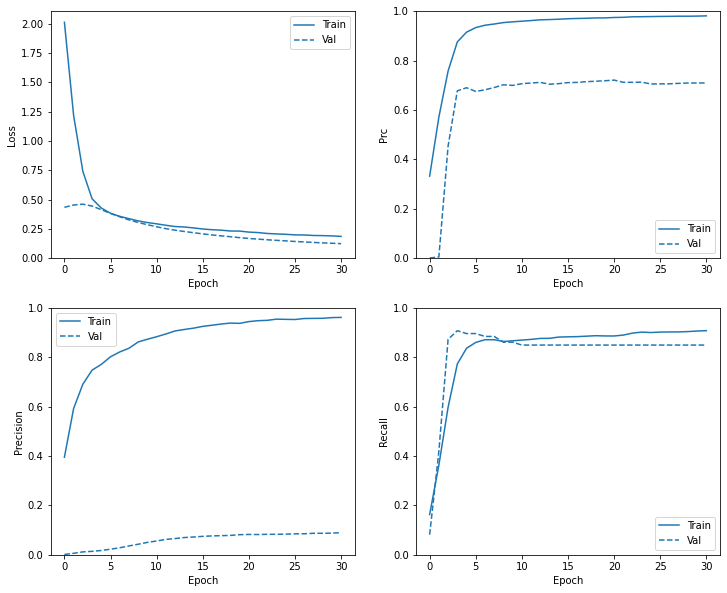

In [52]:
plot_metrics(resampled_history)

### Evaluate metrics

In [53]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.16882120072841644
tp :  71.0
fp :  1032.0
tn :  55849.0
fn :  10.0
accuracy :  0.9817070960998535
precision :  0.06436990201473236
recall :  0.8765432238578796
auc :  0.9518552422523499
prc :  0.7423797845840454

Legitimate Transactions Detected (True Negatives):  55849
Legitimate Transactions Incorrectly Detected (False Positives):  1032
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  81


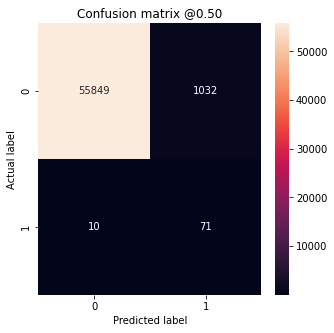

In [54]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

### Plot the ROC

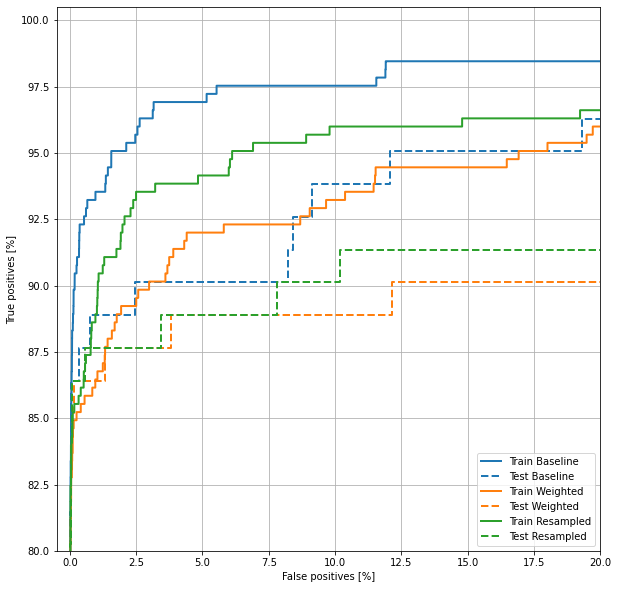

In [55]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

### Plot the AUPRC


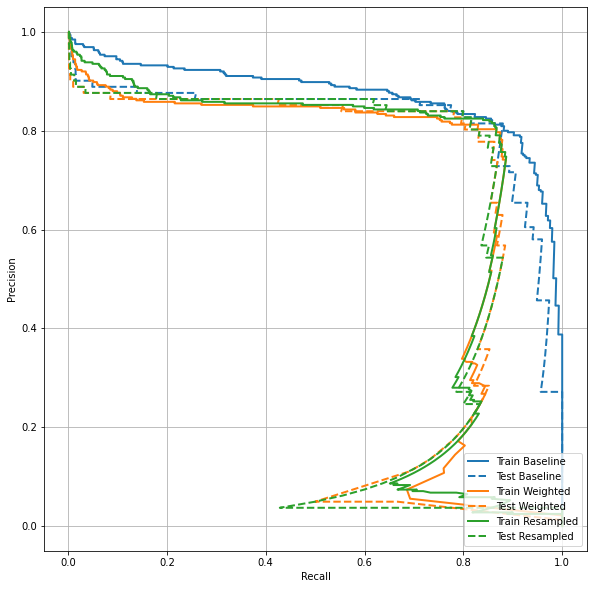

In [56]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

## Applying this tutorial to your problem

Imbalanced data classification is an inherently difficult task since there are so few samples to learn from. You should always start with the data first and do your best to collect as many samples as possible and give substantial thought to what features may be relevant so the model can get the most out of your minority class. At some point your model may struggle to improve and yield the results you want, so it is important to keep in mind the context of your problem and the trade offs between different types of errors.